In [1]:
%load_ext autoreload
%autoreload 2

import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import activation
import cpn_model
import config
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils


OBSERVER_TYPE = observer.ObserverType.gaussian
STIMULATION_TYPE = stim.StimulationType.gaussian_exp
CPN_ACTIVATION_TYPE = activation.ActivationType.Tanh
EN_ACTIVATION_TYPE = activation.ActivationType.Tanh
LESION_TYPE = lesion.LesionType.connection
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, \
        run_type_str, run_type_str_short, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


MODEL_OUT_DIR = "models"
LOG_OUT_DIR = "logs"

print("Run config:", run_type_str)
print(run_type_str_short)

Run config: gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)]_gaussianExp16.2.175_enActTanh_cpnActTanh
obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh


In [2]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus, cuda=CUDA)


mike.set_lesion(lesion_instance)

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True,
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True,
)

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


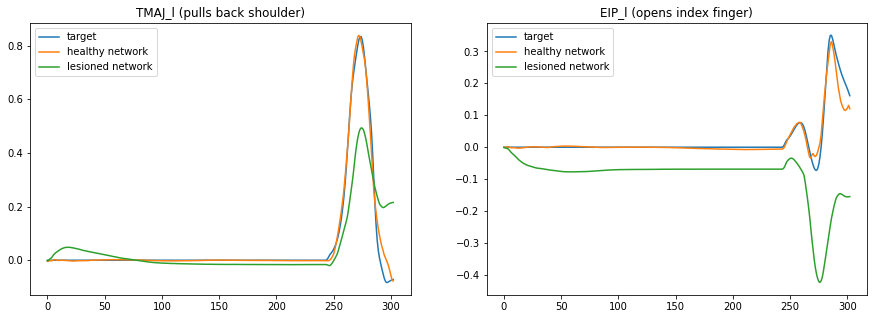

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].cpu().detach().numpy(), label="healthy network")
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].cpu().detach().numpy(), label="lesioned network")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].cpu().detach().numpy(), label="healthy network")
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].cpu().detach().numpy(), label="lesioned network")
ax[1].legend(loc="upper left")

plt.show()

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>)


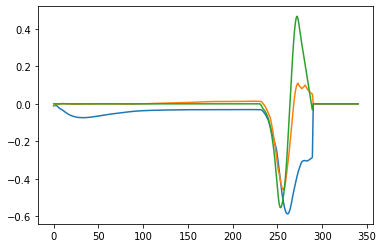

In [5]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_healthy = comp_preds_healthy.cuda(CUDA)
    
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_lesioned = comp_preds_lesioned.cuda(CUDA)
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].cpu().detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].cpu().detach().numpy())
plt.plot(dout[0, :, 20].cpu().detach().numpy())
plt.show()


In [6]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False,
           cuda=None):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim

    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)

    if cuda is not None:
        preds = preds.cuda(cuda)
        actuals = actuals.cuda(cuda)

    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)

    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(obs, axis=1).detach()
        new_obs_en = obs[0].detach()

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)

        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs_en, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]

        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)

        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]

    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])
    return actuals, preds, stims

In [7]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None, losses=None,
                cuda=None):
    # the last EN we were working on training, for easy access
    global recent_en

    obs_dim = observer.out_dim * 1
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None:
        en = stim_model.StimModelLSTM(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim+50, activation_func=torch.nn.Tanh,
                cuda=cuda)

        if cuda is not None:
            en.cuda(cuda)

        recent_en = en
    vl = torch.tensor(1.0)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.04)

    checkpoint_eidx = 0
    eidx = -1
    while True:
        for batch in data_loader:
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            eidx += 1
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()

            for p in opt_en.param_groups:
                #if eidx < 3:
                #    p['lr'] = 2e-2
                if vl.item() < 0.0007:
                    p['lr'] = 1e-4
                elif vl.item() < 0.005:
                    p['lr'] = 3e-3
                else:
                    p['lr'] = 4e-3

            cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn,
                                                          noise_var=2*(last_loss), 
                                                          #noisey_pct=0.8,
                                                          white_noise_pct=0.3,
                                                          white_noise_var=6,
                                                          cuda=cuda)

            # Just in case...
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx,
                                      cuda=cuda)

            # Update en
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()

            # Verify against the actual CPN
            if (eidx % 10) == 0:
                mike.reset()
                en.reset()
                cpn.reset()
                loss = torch.nn.MSELoss()
                actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                                  trial_end, observer,
                                                  drop_module_idx=drop_module_idx,
                                                  cuda=cuda)

                vl = loss(preds_val, actual_val)
                
            print("en", eidx, rl.item(), "val:", vl.item())
            if losses is not None:
                losses.append((rl.item(), vl.item()))

            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModelLSTM(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)

                if cuda is not None:
                    en.cuda(cuda)

                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.04)
                checkpoint_eidx = eidx

            if (vl.item() < max(0.02 * last_loss, 0.0003) and eidx > 100) or (eidx - checkpoint_eidx) == 2000:
                done = True
                break
            else:
                done = False

        if done:
            break

    opt_en.zero_grad()
    return en

In [12]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh,
                             cuda=CUDA)


cpn.load_state_dict(torch.load('models/min_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_7dec3fe4f99e11eb96dfe385a79600ab_coadapt'))
model_uuid = cpn_model.uuid.UUID(hex='7dec3fe4f99e11eb96dfe385a79600ab')
cpn._uuid = model_uuid
print(cpn.uuid)

opt_cpn = AdamW(cpn.parameters(), lr=5e-6)
opt_mike = AdamW(mike.parameters(), lr=5e-8)

model_uuid = cpn.uuid
latest_out_path = os.path.join(MODEL_OUT_DIR, f"latest_cpn_{run_type_str_short}_{model_uuid}_coadapt2")
min_out_path = os.path.join(MODEL_OUT_DIR, f"min_cpn_{run_type_str_short}_{model_uuid}_coadapt2")
log_out_path = os.path.join(LOG_OUT_DIR, f"{run_type_str_short}_{model_uuid}_coadapt2")
mike_out_path = os.path.join(LOG_OUT_DIR, f"mike_{run_type_str_short}_{model_uuid}_coadapt2")


print(model_uuid)
print(latest_out_path)
print(min_out_path)
print(log_out_path)

loss = torch.nn.MSELoss()
rli = 0.003

cpn_losses = []
en_train_losses = []
en_train_epochs = []
pred_losses = []
real_losses = []
test_losses = []
mike_losses = []
super_epoch_count = 0
en = None
eidx = 0
while True:
    super_epoch_count += 1
    
    utils.write_train_logs(log_out_path, cpn=cpn_losses, pred=pred_losses,
                               task=real_losses, test=test_losses,
                               en_train=en_train_losses, en_train_epochs=en_train_epochs)

    for param in cpn.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False

    #if super_epoch_count > 1:
    en_train_losses.append([])
    en = train_an_en(mike, observer, cpn, loader_train, last_loss=rli, losses=en_train_losses[-1],
                     cuda=CUDA)
    en_train_epochs.append(eidx)

    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=True

    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_train:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()

            if rli >= 0.008:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-3
            elif rli >= 0.006:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-5
            elif rli >= 0.002:
                for p in opt_cpn.param_groups:
                    p['lr'] = 2e-6
            else:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-6

            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            
            
            # Test
            cpn.reset()
            opt_cpn.zero_grad()
            opt_mike.zero_grad()
            en.reset()
            mike.reset()
            batch_test = next(iter(loader_test))
            din_test, trial_end_test, trial_len_test, dout_test = batch_test
            batch_size_test = din_test.shape[0]
            steps_test = din_test.shape[1]
            actuals_test, preds_test, stims_test = unroll(cpn, mike, en, din_test,
                                           trial_end_test, observer, cuda=CUDA)

            rl_test = loss(actuals_test, dout_test[:, 1:, :])
            rli_test = rl_test.item()
            test_losses.append(rli_test)

            # Train
            cpn.reset()
            opt_mike.zero_grad()
            opt_cpn.zero_grad()
            en.reset()
            mike.reset()
            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           retain_stim_grads=True,
                                           cuda=CUDA)
            preds.retain_grad()

            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()

            cpn_losses.append(rli)

            real_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :]).item()
            real_losses.append(real_loss)

            pred_loss = torch.nn.MSELoss()(preds, actuals).item()
            pred_losses.append(pred_loss)

            
            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss,
                   "test loss:", rli_test)
            recent_losses.append(real_loss)
            
            # co-adaptation step, done less often:
            if (eidx % 5) == 0:
                mike_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :])
                mike_loss.backward()
                mike_losses.append(mike_loss.item())
                mike.set_coadap_grads()
                opt_mike.step()

            torch.save(cpn.state_dict(), latest_out_path)
            if real_loss == min(real_losses):
                torch.save(cpn.state_dict(), min_out_path)
                torch.save(mike.state_dict(), mike_out_path)


            bail = False
            done = False
            
            # Done
            if rli < 1e-5:
                bail = True
                done = True
                break

            if pred_loss > max(real_loss / 10, 6e-4):
                bail = True
                break

            if len(recent_losses) >= 100:
                bail = True
                break

            if len(recent_losses) > 30:
                prev = None
                num_reg = 0
                for l in recent_losses[-30:]:
                    if prev is not None and l > prev:
                        num_reg += 1

                prev = l
                if num_reg > 15:
                    bail = True
                    break

            opt_cpn.step()

            if bail:
                break
        
        if bail:
            break

    if done:
        break
        
# Best with trial ends 0.00179

7dec3fe4f99e11eb96dfe385a79600ab
7dec3fe4f99e11eb96dfe385a79600ab
models/latest_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_7dec3fe4f99e11eb96dfe385a79600ab_coadapt2
models/min_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_7dec3fe4f99e11eb96dfe385a79600ab_coadapt2
logs/obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_7dec3fe4f99e11eb96dfe385a79600ab_coadapt2
en 0 0.02735091932117939 val: 0.019244154915213585
en 1 0.023081539198756218 val: 0.019244154915213585
en 2 0.020463207736611366 val: 0.019244154915213585
en 3 0.018819084390997887 val: 0.019244154915213585
en 4 0.017389381304383278 val: 0.019244154915213585
en 5 0.016358820721507072 val: 0.019244154915213585
en 6 0.014569968916475773 val: 0.019244154915213585
en 7 0.01382144633680582 val: 0.019244154915213585
en 8 0.013240342028439045 val: 0.019244154915213585
en 9 0.012687171809375286 val: 0.019244154915213585
en 10 0.011285342276096344 val: 0.00538

en 144 0.0022076554596424103 val: 0.0005070209153927863
en 145 0.002227144781500101 val: 0.0005070209153927863
en 146 0.0021700712386518717 val: 0.0005070209153927863
en 147 0.002228139666840434 val: 0.0005070209153927863
en 148 0.002206809353083372 val: 0.0005070209153927863
en 149 0.0021152333356440067 val: 0.0005070209153927863
en 150 0.002089395420625806 val: 0.0005002333200536668
en 151 0.002128227613866329 val: 0.0005002333200536668
en 152 0.002128021093085408 val: 0.0005002333200536668
en 153 0.0021525861229747534 val: 0.0005002333200536668
en 154 0.0021889798808842897 val: 0.0005002333200536668
en 155 0.002118525328114629 val: 0.0005002333200536668
en 156 0.0021174110006541014 val: 0.0005002333200536668
en 157 0.0021730384323745966 val: 0.0005002333200536668
en 158 0.002295446814969182 val: 0.0005002333200536668
en 159 0.0021521467715501785 val: 0.0005002333200536668
en 160 0.002187208039686084 val: 0.0004927128902636468
en 161 0.0022219554521143436 val: 0.0004927128902636468
e

en 290 0.0019310017814859748 val: 0.00039997606654651463
en 291 0.0019341966835781932 val: 0.00039997606654651463
en 292 0.0018602777272462845 val: 0.00039997606654651463
en 293 0.0018287565326318145 val: 0.00039997606654651463
en 294 0.0018719432409852743 val: 0.00039997606654651463
en 295 0.0018564857309684157 val: 0.00039997606654651463
en 296 0.0018674797611311078 val: 0.00039997606654651463
en 297 0.001918341964483261 val: 0.00039997606654651463
en 298 0.0018737998325377703 val: 0.00039997606654651463
en 299 0.001918882830068469 val: 0.00039997606654651463
en 300 0.0018985114293172956 val: 0.0003937974397558719
en 301 0.001905204146169126 val: 0.0003937974397558719
en 302 0.0018836589297279716 val: 0.0003937974397558719
en 303 0.001863435609266162 val: 0.0003937974397558719
en 304 0.0018867816543206573 val: 0.0003937974397558719
en 305 0.0018623574869707227 val: 0.0003937974397558719
en 306 0.0018603141652420163 val: 0.0003937974397558719
en 307 0.0018496100092306733 val: 0.000393

en 436 0.0016251701163128018 val: 0.0003107661032117903
en 437 0.001551068970002234 val: 0.0003107661032117903
en 438 0.0017067993758246303 val: 0.0003107661032117903
en 439 0.0016868673264980316 val: 0.0003107661032117903
en 440 0.0016821065219119191 val: 0.00030511338263750076
en 441 0.0016479265177622437 val: 0.00030511338263750076
en 442 0.0016672373749315739 val: 0.00030511338263750076
en 443 0.0015779341338202357 val: 0.00030511338263750076
en 444 0.0015981737524271011 val: 0.00030511338263750076
en 445 0.0016260551055893302 val: 0.00030511338263750076
en 446 0.0016376221319660544 val: 0.00030511338263750076
en 447 0.0015993491979315877 val: 0.00030511338263750076
en 448 0.0016284657176584005 val: 0.00030511338263750076
en 449 0.0016490294365212321 val: 0.00030511338263750076
en 450 0.0015768221346661448 val: 0.0002993811503984034
cpn 1 0.0025804168544709682 en loss: 0.00029938117950223386 actual task loss: 0.002462502336129546 test loss: 0.0023808288387954235
cpn 2 0.00244388333

cpn 57 0.0021829840261489153 en loss: 0.00029110792092978954 actual task loss: 0.002155196387320757 test loss: 0.0020985386800020933
cpn 58 0.002182451542466879 en loss: 0.0002910843468271196 actual task loss: 0.0021553433034569025 test loss: 0.0020989226177334785
cpn 59 0.002182324416935444 en loss: 0.0002910454059019685 actual task loss: 0.002156331902369857 test loss: 0.0020995375234633684
cpn 60 0.0021819781977683306 en loss: 0.0002910803887061775 actual task loss: 0.0021563018672168255 test loss: 0.0020994567312300205
cpn 61 0.002181547461077571 en loss: 0.0002910335606429726 actual task loss: 0.002155955182388425 test loss: 0.0020991810597479343
cpn 62 0.0021812848281115294 en loss: 0.00029102296684868634 actual task loss: 0.0021553596016019583 test loss: 0.0020987039897590876
cpn 63 0.0021806436125189066 en loss: 0.00029099563835188746 actual task loss: 0.0021542387548834085 test loss: 0.002097888384014368
cpn 64 0.0021801989059895277 en loss: 0.0002909674949478358 actual task l

en 45 0.003413313301280141 val: 0.0010533151216804981
en 46 0.003147717099636793 val: 0.0010533151216804981
en 47 0.003076388966292143 val: 0.0010533151216804981
en 48 0.0032186806201934814 val: 0.0010533151216804981
en 49 0.0030737484339624643 val: 0.0010533151216804981
en 50 0.00290464679710567 val: 0.0007443889626301825
en 51 0.0029799456242471933 val: 0.0007443889626301825
en 52 0.0028381121810525656 val: 0.0007443889626301825
en 53 0.0027805794961750507 val: 0.0007443889626301825
en 54 0.002714201807975769 val: 0.0007443889626301825
en 55 0.0027518838178366423 val: 0.0007443889626301825
en 56 0.0026463365647941828 val: 0.0007443889626301825
en 57 0.0025030618999153376 val: 0.0007443889626301825
en 58 0.0025591535959392786 val: 0.0007443889626301825
en 59 0.0026255433913320303 val: 0.0007443889626301825
en 60 0.002687463304027915 val: 0.0009535537683404982
en 61 0.0026824225205928087 val: 0.0009535537683404982
en 62 0.0024534740950912237 val: 0.0009535537683404982
en 63 0.002438113

en 193 0.0019915213342756033 val: 0.0003786424931604415
en 194 0.0018141540931537747 val: 0.0003786424931604415
en 195 0.0018706569680944085 val: 0.0003786424931604415
en 196 0.001961352536454797 val: 0.0003786424931604415
en 197 0.0018943039467558265 val: 0.0003786424931604415
en 198 0.0018972193356603384 val: 0.0003786424931604415
en 199 0.0019024243811145425 val: 0.0003786424931604415
en 200 0.0019190965685993433 val: 0.0003750087053049356
en 201 0.001827365136705339 val: 0.0003750087053049356
en 202 0.0018827952444553375 val: 0.0003750087053049356
en 203 0.001837402582168579 val: 0.0003750087053049356
en 204 0.0018609686521813273 val: 0.0003750087053049356
en 205 0.0018587007652968168 val: 0.0003750087053049356
en 206 0.0018783200066536665 val: 0.0003750087053049356
en 207 0.001900591072626412 val: 0.0003750087053049356
en 208 0.0018430470954626799 val: 0.0003750087053049356
en 209 0.001926796860061586 val: 0.0003750087053049356
en 210 0.0019095172174274921 val: 0.00037087546661496

en 340 0.001757061923854053 val: 0.00031921060872264206
en 341 0.0017599721904844046 val: 0.00031921060872264206
en 342 0.0016852996777743101 val: 0.00031921060872264206
en 343 0.0017972007626667619 val: 0.00031921060872264206
en 344 0.00170990324113518 val: 0.00031921060872264206
en 345 0.0017049146117642522 val: 0.00031921060872264206
en 346 0.001727203605696559 val: 0.00031921060872264206
en 347 0.0016796357231214643 val: 0.00031921060872264206
en 348 0.00172167900018394 val: 0.00031921060872264206
en 349 0.001701729721389711 val: 0.00031921060872264206
en 350 0.0017352205468341708 val: 0.00031481971382163465
en 351 0.001741759479045868 val: 0.00031481971382163465
en 352 0.001728416420519352 val: 0.00031481971382163465
en 353 0.0016808162909001112 val: 0.00031481971382163465
en 354 0.0017416992923244834 val: 0.00031481971382163465
en 355 0.0017481559189036489 val: 0.00031481971382163465
en 356 0.001776884077116847 val: 0.00031481971382163465
en 357 0.001666114549152553 val: 0.000314

cpn 137 0.0021789444144815207 en loss: 0.0002984347811434418 actual task loss: 0.0021389834582805634 test loss: 0.002082747407257557
cpn 138 0.00217863405123353 en loss: 0.00029844589880667627 actual task loss: 0.002138199284672737 test loss: 0.00208241562359035
cpn 139 0.0021780729293823242 en loss: 0.0002984452003147453 actual task loss: 0.002137613482773304 test loss: 0.002081850543618202
cpn 140 0.0021777250804007053 en loss: 0.00029844162054359913 actual task loss: 0.0021374060306698084 test loss: 0.0020815355237573385
cpn 141 0.0021774976048618555 en loss: 0.0002984706952702254 actual task loss: 0.0021368816960603 test loss: 0.002080298261716962
cpn 142 0.0021771183237433434 en loss: 0.00029848734266124666 actual task loss: 0.002136619994416833 test loss: 0.0020802693907171488
cpn 143 0.0021770179737359285 en loss: 0.0002984945895150304 actual task loss: 0.0021363210398703814 test loss: 0.0020797941833734512
cpn 144 0.0021761886309832335 en loss: 0.0002984910970553756 actual task

cpn 199 0.0021633619908243418 en loss: 0.0002990231732837856 actual task loss: 0.002116537420079112 test loss: 0.002058294601738453
cpn 200 0.0021633105352520943 en loss: 0.0002990054781548679 actual task loss: 0.002116266405209899 test loss: 0.002057591686025262
en 0 0.027605898678302765 val: 0.018588809296488762
en 1 0.023094283416867256 val: 0.018588809296488762
en 2 0.02043970860540867 val: 0.018588809296488762
en 3 0.01856013387441635 val: 0.018588809296488762
en 4 0.01705096662044525 val: 0.018588809296488762
en 5 0.01579010672867298 val: 0.018588809296488762
en 6 0.014382039196789265 val: 0.018588809296488762
en 7 0.01330658234655857 val: 0.018588809296488762
en 8 0.013242482207715511 val: 0.018588809296488762
en 9 0.012280485592782497 val: 0.018588809296488762
en 10 0.011649182066321373 val: 0.005805190186947584
en 11 0.01075990591198206 val: 0.005805190186947584
en 12 0.010253862477838993 val: 0.005805190186947584
en 13 0.009931149892508984 val: 0.005805190186947584
en 14 0.00

en 146 0.0019109328277409077 val: 0.00040352606447413564
en 147 0.001944670220836997 val: 0.00040352606447413564
en 148 0.0020185052417218685 val: 0.00040352606447413564
en 149 0.0019946065731346607 val: 0.00040352606447413564
en 150 0.001961982110515237 val: 0.00039845070568844676
en 151 0.00204935553483665 val: 0.00039845070568844676
en 152 0.002005597809329629 val: 0.00039845070568844676
en 153 0.001999989850446582 val: 0.00039845070568844676
en 154 0.00194618571549654 val: 0.00039845070568844676
en 155 0.001966567011550069 val: 0.00039845070568844676
en 156 0.001923931180499494 val: 0.00039845070568844676
en 157 0.001982577610760927 val: 0.00039845070568844676
en 158 0.001918518915772438 val: 0.00039845070568844676
en 159 0.0019003173802047968 val: 0.00039845070568844676
en 160 0.0019468008540570736 val: 0.00039511098293587565
en 161 0.0018779506208375096 val: 0.00039511098293587565
en 162 0.0019310530042275786 val: 0.00039511098293587565
en 163 0.0019075128948315978 val: 0.0003951

en 292 0.0018650968559086323 val: 0.00034175137989223003
en 293 0.0017642804887145758 val: 0.00034175137989223003
en 294 0.0018264612881466746 val: 0.00034175137989223003
en 295 0.0017673991387709975 val: 0.00034175137989223003
en 296 0.0016942824004217982 val: 0.00034175137989223003
en 297 0.0017477875808253884 val: 0.00034175137989223003
en 298 0.0017493600025773048 val: 0.00034175137989223003
en 299 0.001684537623077631 val: 0.00034175137989223003
en 300 0.0016869050450623035 val: 0.0003356853558216244
en 301 0.0017307692905887961 val: 0.0003356853558216244
en 302 0.0016934819286689162 val: 0.0003356853558216244
en 303 0.001741230022162199 val: 0.0003356853558216244
en 304 0.0017567796166986227 val: 0.0003356853558216244
en 305 0.0017574116354808211 val: 0.0003356853558216244
en 306 0.001809797715395689 val: 0.0003356853558216244
en 307 0.0017243430484086275 val: 0.0003356853558216244
en 308 0.0017505085561424494 val: 0.0003356853558216244
en 309 0.0018075356492772698 val: 0.0003356

cpn 221 0.0021586751099675894 en loss: 0.00029907497810199857 actual task loss: 0.0021048225462436676 test loss: 0.0020447203423827887
cpn 222 0.0021584404166787863 en loss: 0.0002990718639921397 actual task loss: 0.00210463535040617 test loss: 0.0020446009002625942
cpn 223 0.0021584804635494947 en loss: 0.00029907311545684934 actual task loss: 0.002104785293340683 test loss: 0.0020442616660147905
cpn 224 0.0021579121239483356 en loss: 0.00029902742244303226 actual task loss: 0.0021042563021183014 test loss: 0.00204376014880836
cpn 225 0.0021573370322585106 en loss: 0.00029893231112509966 actual task loss: 0.0021035517565906048 test loss: 0.00204357597976923
cpn 226 0.0021568823140114546 en loss: 0.00029895364423282444 actual task loss: 0.0021031193900853395 test loss: 0.0020427401177585125
cpn 227 0.002156806644052267 en loss: 0.0002989351633004844 actual task loss: 0.0021032553631812334 test loss: 0.0020424320828169584
cpn 228 0.002156415954232216 en loss: 0.00029892814927734435 actu

cpn 283 0.002142689423635602 en loss: 0.0002986859472002834 actual task loss: 0.002085302723571658 test loss: 0.0020223346073180437
cpn 284 0.002142555546015501 en loss: 0.00029872500454075634 actual task loss: 0.002084949519485235 test loss: 0.0020220214501023293
cpn 285 0.00214240956120193 en loss: 0.0002986959007102996 actual task loss: 0.0020849700085818768 test loss: 0.0020215515978634357
cpn 286 0.0021420742850750685 en loss: 0.0002987099578604102 actual task loss: 0.002084312727674842 test loss: 0.0020214521791785955
cpn 287 0.0021417420357465744 en loss: 0.0002987307670991868 actual task loss: 0.0020837581250816584 test loss: 0.002020769054070115
cpn 288 0.002141579519957304 en loss: 0.0002986891777254641 actual task loss: 0.0020833523012697697 test loss: 0.002019969280809164
cpn 289 0.002141377190127969 en loss: 0.000298726256005466 actual task loss: 0.0020830389112234116 test loss: 0.0020198773127049208
cpn 290 0.0021413248032331467 en loss: 0.00029881863156333566 actual task

en 109 0.002366822212934494 val: 0.0005097929970361292
en 110 0.002208891324698925 val: 0.0005028768791817129
en 111 0.0022672798950225115 val: 0.0005028768791817129
en 112 0.0023063812404870987 val: 0.0005028768791817129
en 113 0.0022851447574794292 val: 0.0005028768791817129
en 114 0.002299042185768485 val: 0.0005028768791817129
en 115 0.0022866467479616404 val: 0.0005028768791817129
en 116 0.0022705672308802605 val: 0.0005028768791817129
en 117 0.0022169623989611864 val: 0.0005028768791817129
en 118 0.0022374417167156935 val: 0.0005028768791817129
en 119 0.0022753027733415365 val: 0.0005028768791817129
en 120 0.0023159526754170656 val: 0.0004968693829141557
en 121 0.0022478450555354357 val: 0.0004968693829141557
en 122 0.0022669443860650063 val: 0.0004968693829141557
en 123 0.0022367138881236315 val: 0.0004968693829141557
en 124 0.0023285862989723682 val: 0.0004968693829141557
en 125 0.0022036167792975903 val: 0.0004968693829141557
en 126 0.0021528261713683605 val: 0.000496869382914

en 256 0.0020350683480501175 val: 0.00041262907325290143
en 257 0.002040206454694271 val: 0.00041262907325290143
en 258 0.0020875257905572653 val: 0.00041262907325290143
en 259 0.0019798181019723415 val: 0.00041262907325290143
en 260 0.0020245059859007597 val: 0.00040603027446195483
en 261 0.002031993353739381 val: 0.00040603027446195483
en 262 0.00196861126460135 val: 0.00040603027446195483
en 263 0.0019767710473388433 val: 0.00040603027446195483
en 264 0.002084515755996108 val: 0.00040603027446195483
en 265 0.0019844367634505033 val: 0.00040603027446195483
en 266 0.001979147084057331 val: 0.00040603027446195483
en 267 0.002025058027356863 val: 0.00040603027446195483
en 268 0.0020760102197527885 val: 0.00040603027446195483
en 269 0.0019135787151753902 val: 0.00040603027446195483
en 270 0.0019241906702518463 val: 0.0003998845349997282
en 271 0.0019793626852333546 val: 0.0003998845349997282
en 272 0.00197163806296885 val: 0.0003998845349997282
en 273 0.0019123058300465345 val: 0.0003998

en 402 0.0017807325348258018 val: 0.00032442482188344
en 403 0.0017353639705106616 val: 0.00032442482188344
en 404 0.0017173488158732653 val: 0.00032442482188344
en 405 0.001748048816807568 val: 0.00032442482188344
en 406 0.001737661543302238 val: 0.00032442482188344
en 407 0.0018281417433172464 val: 0.00032442482188344
en 408 0.001734345918521285 val: 0.00032442482188344
en 409 0.0017010339070111513 val: 0.00032442482188344
en 410 0.0017057446530088782 val: 0.00032161077251657844
en 411 0.0017461861716583371 val: 0.00032161077251657844
en 412 0.0017971850465983152 val: 0.00032161077251657844
en 413 0.0017656066920608282 val: 0.00032161077251657844
en 414 0.0017268870724365115 val: 0.00032161077251657844
en 415 0.0016834938433021307 val: 0.00032161077251657844
en 416 0.0017466881545260549 val: 0.00032161077251657844
en 417 0.001764411455951631 val: 0.00032161077251657844
en 418 0.0017865966074168682 val: 0.00032161077251657844
en 419 0.00169956695754081 val: 0.00032161077251657844
en 4

cpn 342 0.0020914028864353895 en loss: 0.0002988189517054707 actual task loss: 0.0020626294426620007 test loss: 0.0019995763432234526
cpn 343 0.002090797293931246 en loss: 0.0002988429041579366 actual task loss: 0.0020626974292099476 test loss: 0.0019996275659650564
cpn 344 0.0020909393206238747 en loss: 0.0002988378400914371 actual task loss: 0.0020633572712540627 test loss: 0.0020000829827040434
cpn 345 0.002090920927003026 en loss: 0.0002989411004818976 actual task loss: 0.0020630008075386286 test loss: 0.0020002275705337524
cpn 346 0.0020908608566969633 en loss: 0.00029903219547122717 actual task loss: 0.0020628345664590597 test loss: 0.00199993047863245
cpn 347 0.0020907041616737843 en loss: 0.00029905230621807277 actual task loss: 0.0020628306083381176 test loss: 0.0020001609809696674
cpn 348 0.002090908121317625 en loss: 0.0002990551001857966 actual task loss: 0.002063677180558443 test loss: 0.0020003491081297398
cpn 349 0.0020904189441353083 en loss: 0.00029899284709244967 actu

en 7 0.01363449264317751 val: 0.018787801265716553
en 8 0.013141660019755363 val: 0.018787801265716553
en 9 0.012680689804255962 val: 0.018787801265716553
en 10 0.011502428911626339 val: 0.005866984836757183
en 11 0.010878046974539757 val: 0.005866984836757183
en 12 0.010540831834077835 val: 0.005866984836757183
en 13 0.010258748196065426 val: 0.005866984836757183
en 14 0.009886550717055798 val: 0.005866984836757183
en 15 0.009836220182478428 val: 0.005866984836757183
en 16 0.009231355972588062 val: 0.005866984836757183
en 17 0.008676509372889996 val: 0.005866984836757183
en 18 0.008302398957312107 val: 0.005866984836757183
en 19 0.008069481700658798 val: 0.005866984836757183
en 20 0.007410948630422354 val: 0.003215859876945615
en 21 0.007285763043910265 val: 0.003215859876945615
en 22 0.006953978445380926 val: 0.003215859876945615
en 23 0.006974334362894297 val: 0.003215859876945615
en 24 0.006647791247814894 val: 0.003215859876945615
en 25 0.006365577690303326 val: 0.0032158598769456

en 158 0.002204227726906538 val: 0.0004882821813225746
en 159 0.0022693704813718796 val: 0.0004882821813225746
en 160 0.002169352723285556 val: 0.0004823148192372173
en 161 0.0021879500709474087 val: 0.0004823148192372173
en 162 0.002209631260484457 val: 0.0004823148192372173
en 163 0.002154057379812002 val: 0.0004823148192372173
en 164 0.0022276996169239283 val: 0.0004823148192372173
en 165 0.002238444983959198 val: 0.0004823148192372173
en 166 0.002155063906684518 val: 0.0004823148192372173
en 167 0.0021315407939255238 val: 0.0004823148192372173
en 168 0.002105877734720707 val: 0.0004823148192372173
en 169 0.0021239398047327995 val: 0.0004823148192372173
en 170 0.002184361917898059 val: 0.0004776296264026314
en 171 0.002164823468774557 val: 0.0004776296264026314
en 172 0.002147828694432974 val: 0.0004776296264026314
en 173 0.002219117945060134 val: 0.0004776296264026314
en 174 0.002217460423707962 val: 0.0004776296264026314
en 175 0.0021205521188676357 val: 0.0004776296264026314
en 1

en 306 0.0019659220706671476 val: 0.00040978920878842473
en 307 0.001972431316971779 val: 0.00040978920878842473
en 308 0.0018912089290097356 val: 0.00040978920878842473
en 309 0.0020681824535131454 val: 0.00040978920878842473
en 310 0.001982901245355606 val: 0.0004042144282720983
en 311 0.001977520762011409 val: 0.0004042144282720983
en 312 0.0019970498979091644 val: 0.0004042144282720983
en 313 0.0019358217250555754 val: 0.0004042144282720983
en 314 0.0019234629580751061 val: 0.0004042144282720983
en 315 0.0019354346441105008 val: 0.0004042144282720983
en 316 0.0019630168098956347 val: 0.0004042144282720983
en 317 0.0019867517985403538 val: 0.0004042144282720983
en 318 0.0019807375501841307 val: 0.0004042144282720983
en 319 0.0020299723837524652 val: 0.0004042144282720983
en 320 0.0019998943898826838 val: 0.00039888735045678914
en 321 0.002018213039264083 val: 0.00039888735045678914
en 322 0.0019722962751984596 val: 0.00039888735045678914
en 323 0.0019871224649250507 val: 0.000398887

en 453 0.0017768103862181306 val: 0.0003377774846740067
en 454 0.0017919554375112057 val: 0.0003377774846740067
en 455 0.001754450029693544 val: 0.0003377774846740067
en 456 0.0017634251853451133 val: 0.0003377774846740067
en 457 0.001748858019709587 val: 0.0003377774846740067
en 458 0.001757253659889102 val: 0.0003377774846740067
en 459 0.0018212621798738837 val: 0.0003377774846740067
en 460 0.0017310045659542084 val: 0.0003323519486002624
en 461 0.0017348866676911712 val: 0.0003323519486002624
en 462 0.001747102360241115 val: 0.0003323519486002624
en 463 0.001805744832381606 val: 0.0003323519486002624
en 464 0.0017821575747802854 val: 0.0003323519486002624
en 465 0.0017601698637008667 val: 0.0003323519486002624
en 466 0.001703588874079287 val: 0.0003323519486002624
en 467 0.0017922736005857587 val: 0.0003323519486002624
en 468 0.0017249758820980787 val: 0.0003323519486002624
en 469 0.0017689198721200228 val: 0.0003323519486002624
en 470 0.001727722235955298 val: 0.0003279004304204136

cpn 426 0.002062865998595953 en loss: 0.00029692481621168554 actual task loss: 0.0020481334067881107 test loss: 0.0019815536215901375
cpn 427 0.0020628743804991245 en loss: 0.0002969352062791586 actual task loss: 0.0020478549413383007 test loss: 0.0019812884274870157
cpn 428 0.0020626739133149385 en loss: 0.00029687926871702075 actual task loss: 0.002047268208116293 test loss: 0.001980891451239586
cpn 429 0.0020625039469450712 en loss: 0.00029687746427953243 actual task loss: 0.0020471590105444193 test loss: 0.0019801859743893147
cpn 430 0.0020625758916139603 en loss: 0.0002969742054119706 actual task loss: 0.002047221874818206 test loss: 0.0019802884198725224
cpn 431 0.0020629160571843386 en loss: 0.0002970659115817398 actual task loss: 0.0020479189697653055 test loss: 0.001980345929041505
cpn 432 0.002062957501038909 en loss: 0.00029714900301769376 actual task loss: 0.0020479578524827957 test loss: 0.001980039058253169
cpn 433 0.0020626401528716087 en loss: 0.00029716038261540234 act

cpn 488 0.002057708567008376 en loss: 0.00029796932358294725 actual task loss: 0.0020399163477122784 test loss: 0.001970351440832019
cpn 489 0.00205753231421113 en loss: 0.0002979567798320204 actual task loss: 0.0020397293847054243 test loss: 0.0019709577318280935
cpn 490 0.0020574196241796017 en loss: 0.0002980013086926192 actual task loss: 0.002039595041424036 test loss: 0.0019702559802681208
cpn 491 0.002057277364656329 en loss: 0.00029802476637996733 actual task loss: 0.002039532642811537 test loss: 0.001970525598153472
cpn 492 0.002057101810351014 en loss: 0.0002980042772833258 actual task loss: 0.002039404585957527 test loss: 0.0019700846169143915
cpn 493 0.0020570601336658 en loss: 0.0002979658602271229 actual task loss: 0.0020394313614815474 test loss: 0.0019702871795743704
cpn 494 0.0020569965709000826 en loss: 0.00029804863152094185 actual task loss: 0.002039629500359297 test loss: 0.001970263896510005
cpn 495 0.0020569292828440666 en loss: 0.0002980193530675024 actual task l

en 120 0.0022919406183063984 val: 0.0005366068216972053
en 121 0.002344664419069886 val: 0.0005366068216972053
en 122 0.0022619806695729494 val: 0.0005366068216972053
en 123 0.0023652813397347927 val: 0.0005366068216972053
en 124 0.002219762420281768 val: 0.0005366068216972053
en 125 0.002271247562021017 val: 0.0005366068216972053
en 126 0.0022202874533832073 val: 0.0005366068216972053
en 127 0.002322841202840209 val: 0.0005366068216972053
en 128 0.002290913835167885 val: 0.0005366068216972053
en 129 0.002309247152879834 val: 0.0005366068216972053
en 130 0.0022762026637792587 val: 0.0005291304551064968
en 131 0.002266191877424717 val: 0.0005291304551064968
en 132 0.002332872012630105 val: 0.0005291304551064968
en 133 0.0023753533605486155 val: 0.0005291304551064968
en 134 0.0022528027184307575 val: 0.0005291304551064968
en 135 0.0022130762226879597 val: 0.0005291304551064968
en 136 0.00234041060321033 val: 0.0005291304551064968
en 137 0.0023561890702694654 val: 0.0005291304551064968
en

en 268 0.0020247912034392357 val: 0.0004443041980266571
en 269 0.002011635573580861 val: 0.0004443041980266571
en 270 0.0020467189606279135 val: 0.0004377799923531711
en 271 0.0020024236291646957 val: 0.0004377799923531711
en 272 0.0019821219611912966 val: 0.0004377799923531711
en 273 0.002075756900012493 val: 0.0004377799923531711
en 274 0.002006100257858634 val: 0.0004377799923531711
en 275 0.002016219310462475 val: 0.0004377799923531711
en 276 0.002023525070399046 val: 0.0004377799923531711
en 277 0.0020396150648593903 val: 0.0004377799923531711
en 278 0.002048950409516692 val: 0.0004377799923531711
en 279 0.001976118888705969 val: 0.0004377799923531711
en 280 0.002031726995483041 val: 0.00043263734551146626
en 281 0.002010856056585908 val: 0.00043263734551146626
en 282 0.002048214664682746 val: 0.00043263734551146626
en 283 0.0020462709944695234 val: 0.00043263734551146626
en 284 0.001989249140024185 val: 0.00043263734551146626
en 285 0.0020078408997505903 val: 0.000432637345511466

en 415 0.001672428217716515 val: 0.00035629651392810047
en 416 0.0016909197438508272 val: 0.00035629651392810047
en 417 0.0017170062055811286 val: 0.00035629651392810047
en 418 0.0017561647109687328 val: 0.00035629651392810047
en 419 0.001680030138231814 val: 0.00035629651392810047
en 420 0.0017236690036952496 val: 0.0003517016302794218
en 421 0.001648418023250997 val: 0.0003517016302794218
en 422 0.0017241374589502811 val: 0.0003517016302794218
en 423 0.0017172106308862567 val: 0.0003517016302794218
en 424 0.0016949473647400737 val: 0.0003517016302794218
en 425 0.001682413974776864 val: 0.0003517016302794218
en 426 0.0017379572382196784 val: 0.0003517016302794218
en 427 0.0017557580722495914 val: 0.0003517016302794218
en 428 0.001666126772761345 val: 0.0003517016302794218
en 429 0.001681458088569343 val: 0.0003517016302794218
en 430 0.0016923511866480112 val: 0.000346882181474939
en 431 0.0016845765057951212 val: 0.000346882181474939
en 432 0.0016527106054127216 val: 0.000346882181474

cpn 514 0.002094387076795101 en loss: 0.0002977734839078039 actual task loss: 0.0020381147041916847 test loss: 0.0019685106817632914
cpn 515 0.00209404737688601 en loss: 0.00029773343703709543 actual task loss: 0.0020385519601404667 test loss: 0.0019685048609972
cpn 516 0.0020940019749104977 en loss: 0.0002976883260998875 actual task loss: 0.00203889817930758 test loss: 0.001969374483451247
cpn 517 0.002094462513923645 en loss: 0.0002977863769046962 actual task loss: 0.0020393284503370523 test loss: 0.0019691954366862774
cpn 518 0.0020944038406014442 en loss: 0.00029782415367662907 actual task loss: 0.002039282815530896 test loss: 0.0019691716879606247
cpn 519 0.002094496041536331 en loss: 0.00029793003341183066 actual task loss: 0.00203932193107903 test loss: 0.001969086704775691
cpn 520 0.002094373106956482 en loss: 0.00029801155324094 actual task loss: 0.002039114246144891 test loss: 0.001968775410205126
cpn 521 0.0020942206028848886 en loss: 0.00029800302581861615 actual task loss:

cpn 576 0.0020929144229739904 en loss: 0.00029869494028389454 actual task loss: 0.0020390779245644808 test loss: 0.0019689155742526054
cpn 577 0.0020931519102305174 en loss: 0.00029879758949391544 actual task loss: 0.0020389268174767494 test loss: 0.0019684999715536833
cpn 578 0.0020929777529090643 en loss: 0.00029878580244258046 actual task loss: 0.0020388560369610786 test loss: 0.001968893688172102
cpn 579 0.0020927649457007647 en loss: 0.0002987779153045267 actual task loss: 0.0020387836266309023 test loss: 0.0019689479377120733
cpn 580 0.002092889742925763 en loss: 0.00029872494633309543 actual task loss: 0.0020395363681018353 test loss: 0.001969266450032592
cpn 581 0.0020930843893438578 en loss: 0.0002987195039168 actual task loss: 0.0020399675704538822 test loss: 0.0019695062655955553
cpn 582 0.0020928934682160616 en loss: 0.0002987907500937581 actual task loss: 0.0020399109926074743 test loss: 0.001969566335901618
cpn 583 0.0020931048784404993 en loss: 0.00029886336415074766 act

en 91 0.0022153796162456274 val: 0.0005637007998302579
en 92 0.002319562016054988 val: 0.0005637007998302579
en 93 0.0022178590297698975 val: 0.0005637007998302579
en 94 0.0022062710486352444 val: 0.0005637007998302579
en 95 0.0021060118451714516 val: 0.0005637007998302579
en 96 0.0023122967686504126 val: 0.0005637007998302579
en 97 0.002231881022453308 val: 0.0005637007998302579
en 98 0.0022176378406584263 val: 0.0005637007998302579
en 99 0.0020865339320153 val: 0.0005637007998302579
en 100 0.0021256604231894016 val: 0.0005549687775783241
en 101 0.0022322467993944883 val: 0.0005549687775783241
en 102 0.002173219108954072 val: 0.0005549687775783241
en 103 0.002153368666768074 val: 0.0005549687775783241
en 104 0.0021973149850964546 val: 0.0005549687775783241
en 105 0.0021147900260984898 val: 0.0005549687775783241
en 106 0.002110541332513094 val: 0.0005549687775783241
en 107 0.0021264315582811832 val: 0.0005549687775783241
en 108 0.0022713234648108482 val: 0.0005549687775783241
en 109 0.

en 239 0.0019308313494548202 val: 0.00045420406968332827
en 240 0.0019545182585716248 val: 0.00044711350346915424
en 241 0.0019488560501486063 val: 0.00044711350346915424
en 242 0.0019379091681912541 val: 0.00044711350346915424
en 243 0.001997422892600298 val: 0.00044711350346915424
en 244 0.0019898642785847187 val: 0.00044711350346915424
en 245 0.0019793217070400715 val: 0.00044711350346915424
en 246 0.001968838507309556 val: 0.00044711350346915424
en 247 0.0019455496221780777 val: 0.00044711350346915424
en 248 0.0019565862603485584 val: 0.00044711350346915424
en 249 0.001955089857801795 val: 0.00044711350346915424
en 250 0.0018897022819146514 val: 0.0004395635041873902
en 251 0.0019089501583948731 val: 0.0004395635041873902
en 252 0.001992479432374239 val: 0.0004395635041873902
en 253 0.0019482870120555162 val: 0.0004395635041873902
en 254 0.0019676086958497763 val: 0.0004395635041873902
en 255 0.00198109052143991 val: 0.0004395635041873902
en 256 0.0019656168296933174 val: 0.0004395

en 385 0.0016645577270537615 val: 0.00034710243926383555
en 386 0.0017135478556156158 val: 0.00034710243926383555
en 387 0.0016615376807749271 val: 0.00034710243926383555
en 388 0.001642966060899198 val: 0.00034710243926383555
en 389 0.0016817426076158881 val: 0.00034710243926383555
en 390 0.0017012680182233453 val: 0.0003406653122510761
en 391 0.0016671413322910666 val: 0.0003406653122510761
en 392 0.0016271836357191205 val: 0.0003406653122510761
en 393 0.0016208987217396498 val: 0.0003406653122510761
en 394 0.0016084675444290042 val: 0.0003406653122510761
en 395 0.0016790649387985468 val: 0.0003406653122510761
en 396 0.001638495596125722 val: 0.0003406653122510761
en 397 0.0016125907422974706 val: 0.0003406653122510761
en 398 0.0016150325536727905 val: 0.0003406653122510761
en 399 0.0016288099577650428 val: 0.0003406653122510761
en 400 0.0016486258246004581 val: 0.00033400137908756733
en 401 0.0016651336336508393 val: 0.00033400137908756733
en 402 0.0016538422787562013 val: 0.0003340

cpn 627 0.0020788859110325575 en loss: 0.0002945292799267918 actual task loss: 0.0020388655830174685 test loss: 0.0019678010139614344
cpn 628 0.0020787438843399286 en loss: 0.000294609839329496 actual task loss: 0.002038270700722933 test loss: 0.0019671376794576645
cpn 629 0.0020787797402590513 en loss: 0.00029454191098921 actual task loss: 0.0020384727977216244 test loss: 0.0019675721414387226
cpn 630 0.0020785497035831213 en loss: 0.00029449816793203354 actual task loss: 0.002038420643657446 test loss: 0.001967477146536112
cpn 631 0.002078379737213254 en loss: 0.000294482393655926 actual task loss: 0.0020382730290293694 test loss: 0.001967241521924734
cpn 632 0.002078366931527853 en loss: 0.00029441414517350495 actual task loss: 0.0020385037641972303 test loss: 0.0019675299990922213
cpn 633 0.002078539691865444 en loss: 0.00029436664772219956 actual task loss: 0.0020389240235090256 test loss: 0.0019677942618727684
cpn 634 0.002078321296721697 en loss: 0.00029428640846163034 actual ta

cpn 689 0.002075720811262727 en loss: 0.00029436766635626554 actual task loss: 0.0020371004939079285 test loss: 0.0019667968153953552
cpn 690 0.0020754928700625896 en loss: 0.0002942585851997137 actual task loss: 0.0020371314603835344 test loss: 0.0019669036846607924
cpn 691 0.0020754749421030283 en loss: 0.0002941724378615618 actual task loss: 0.0020376837346702814 test loss: 0.001967257121577859
cpn 692 0.0020756295416504145 en loss: 0.00029422869556583464 actual task loss: 0.002037850907072425 test loss: 0.001967421267181635
cpn 693 0.0020756188314408064 en loss: 0.00029413614538498223 actual task loss: 0.002037967788055539 test loss: 0.0019674692302942276
cpn 694 0.0020756092853844166 en loss: 0.00029413882293738425 actual task loss: 0.00203818385489285 test loss: 0.0019675802905112505
cpn 695 0.0020755010191351175 en loss: 0.000294137978926301 actual task loss: 0.0020381207577884197 test loss: 0.0019676978699862957
cpn 696 0.00207536737434566 en loss: 0.00029415340395644307 actual

en 122 0.0018567220540717244 val: 0.00041716042323969305
en 123 0.0018406824674457312 val: 0.00041716042323969305
en 124 0.0018077235436066985 val: 0.00041716042323969305
en 125 0.0018777843797579408 val: 0.00041716042323969305
en 126 0.0018955119885504246 val: 0.00041716042323969305
en 127 0.0019226936856284738 val: 0.00041716042323969305
en 128 0.0019351330120116472 val: 0.00041716042323969305
en 129 0.001846312778070569 val: 0.00041716042323969305
en 130 0.0018273317255079746 val: 0.00041243332088924944
en 131 0.0018521694000810385 val: 0.00041243332088924944
en 132 0.001846296596340835 val: 0.00041243332088924944
en 133 0.0019136754563078284 val: 0.00041243332088924944
en 134 0.0018980844179168344 val: 0.00041243332088924944
en 135 0.0017732852138578892 val: 0.00041243332088924944
en 136 0.0018996554426848888 val: 0.00041243332088924944
en 137 0.001809884561225772 val: 0.00041243332088924944
en 138 0.0018832585774362087 val: 0.00041243332088924944
en 139 0.0018344464479014277 val: 

en 268 0.0017118456307798624 val: 0.00035445537650957704
en 269 0.0018003167351707816 val: 0.00035445537650957704
en 270 0.0017355438321828842 val: 0.0003504461783450097
en 271 0.0016988420393317938 val: 0.0003504461783450097
en 272 0.0017747613601386547 val: 0.0003504461783450097
en 273 0.0017571868374943733 val: 0.0003504461783450097
en 274 0.0017102528363466263 val: 0.0003504461783450097
en 275 0.0017221354646608233 val: 0.0003504461783450097
en 276 0.001672597136348486 val: 0.0003504461783450097
en 277 0.0017532933270558715 val: 0.0003504461783450097
en 278 0.0017290530959144235 val: 0.0003504461783450097
en 279 0.00171616580337286 val: 0.0003504461783450097
en 280 0.0017259943997487426 val: 0.0003470889350865036
en 281 0.0017011662712320685 val: 0.0003470889350865036
en 282 0.001739517436362803 val: 0.0003470889350865036
en 283 0.0017248339718207717 val: 0.0003470889350865036
en 284 0.0016924126539379358 val: 0.0003470889350865036
en 285 0.001691603334620595 val: 0.000347088935086

cpn 707 0.002079497091472149 en loss: 0.0002990266657434404 actual task loss: 0.0020367878023535013 test loss: 0.0019668966997414827
cpn 708 0.0020792344585061073 en loss: 0.0002989589120261371 actual task loss: 0.0020359293557703495 test loss: 0.001966434996575117
cpn 709 0.0020789813715964556 en loss: 0.0002989831264130771 actual task loss: 0.002035203855484724 test loss: 0.001965970965102315
cpn 710 0.0020788456313312054 en loss: 0.0002989188942592591 actual task loss: 0.0020346548408269882 test loss: 0.001965517411008477
cpn 711 0.0020784349180758 en loss: 0.0002988912456203252 actual task loss: 0.002034331439062953 test loss: 0.001965069444850087
cpn 712 0.002078221645206213 en loss: 0.00029872439336031675 actual task loss: 0.002034147037193179 test loss: 0.001964967930689454
cpn 713 0.002078219084069133 en loss: 0.0002986839390359819 actual task loss: 0.002034187549725175 test loss: 0.0019654890056699514
cpn 714 0.002078262623399496 en loss: 0.00029869054560549557 actual task los

cpn 769 0.0020744213834404945 en loss: 0.0002998604904860258 actual task loss: 0.002026860136538744 test loss: 0.001957949483767152
cpn 770 0.0020744686480611563 en loss: 0.00029989180620759726 actual task loss: 0.002026838483288884 test loss: 0.0019577823113650084
cpn 771 0.0020742181222885847 en loss: 0.00029990627081133425 actual task loss: 0.0020267388317734003 test loss: 0.001957983709871769
cpn 772 0.0020742861088365316 en loss: 0.0002998736163135618 actual task loss: 0.002026969799771905 test loss: 0.0019580835942178965
cpn 773 0.0020743529312312603 en loss: 0.0002999344142153859 actual task loss: 0.0020271437242627144 test loss: 0.0019580903463065624
cpn 774 0.0020742693450301886 en loss: 0.0002999218413606286 actual task loss: 0.0020271283574402332 test loss: 0.001958283828571439
cpn 775 0.0020740509498864412 en loss: 0.0002999277785420418 actual task loss: 0.0020268799271434546 test loss: 0.001958232605829835
cpn 776 0.0020742265041917562 en loss: 0.00029992370400577784 actua

en 74 0.0022174976766109467 val: 0.0005076124798506498
en 75 0.0022827275097370148 val: 0.0005076124798506498
en 76 0.0022852683905512094 val: 0.0005076124798506498
en 77 0.0022996452171355486 val: 0.0005076124798506498
en 78 0.0023091889452189207 val: 0.0005076124798506498
en 79 0.0023380108177661896 val: 0.0005076124798506498
en 80 0.002247694181278348 val: 0.0004949580761604011
en 81 0.0022510825656354427 val: 0.0004949580761604011
en 82 0.002305767498910427 val: 0.0004949580761604011
en 83 0.002187189646065235 val: 0.0004949580761604011
en 84 0.0021966721396893263 val: 0.0004949580761604011
en 85 0.0022387492936104536 val: 0.0004949580761604011
en 86 0.002204395132139325 val: 0.0004949580761604011
en 87 0.0022130352444946766 val: 0.0004949580761604011
en 88 0.0021408870816230774 val: 0.0004949580761604011
en 89 0.00223095016553998 val: 0.0004949580761604011
en 90 0.002260103588923812 val: 0.000488803256303072
en 91 0.0022939781192690134 val: 0.000488803256303072
en 92 0.00226425798

en 222 0.002102083992213011 val: 0.0004006097442470491
en 223 0.0020212384406477213 val: 0.0004006097442470491
en 224 0.0021208978723734617 val: 0.0004006097442470491
en 225 0.0020327207166701555 val: 0.0004006097442470491
en 226 0.0019270997727289796 val: 0.0004006097442470491
en 227 0.0020227774512022734 val: 0.0004006097442470491
en 228 0.0019454341381788254 val: 0.0004006097442470491
en 229 0.0019685092847794294 val: 0.0004006097442470491
en 230 0.0019401523750275373 val: 0.0003950046666432172
en 231 0.002003582427278161 val: 0.0003950046666432172
en 232 0.0019671740010380745 val: 0.0003950046666432172
en 233 0.0020611626096069813 val: 0.0003950046666432172
en 234 0.0020086716394871473 val: 0.0003950046666432172
en 235 0.00199978519231081 val: 0.0003950046666432172
en 236 0.0019034419674426317 val: 0.0003950046666432172
en 237 0.001879078452475369 val: 0.0003950046666432172
en 238 0.0019420241005718708 val: 0.0003950046666432172
en 239 0.0019530317513272166 val: 0.00039500466664321

en 368 0.001751697389408946 val: 0.0003164394584018737
en 369 0.0017871855525299907 val: 0.0003164394584018737
en 370 0.001730254851281643 val: 0.0003115688741672784
en 371 0.001744582667015493 val: 0.0003115688741672784
en 372 0.0017081326805055141 val: 0.0003115688741672784
en 373 0.0017049233429133892 val: 0.0003115688741672784
en 374 0.0017617077101022005 val: 0.0003115688741672784
en 375 0.0017114914953708649 val: 0.0003115688741672784
en 376 0.0018245739629492164 val: 0.0003115688741672784
en 377 0.0016757359262555838 val: 0.0003115688741672784
en 378 0.0017609521746635437 val: 0.0003115688741672784
en 379 0.001637023058719933 val: 0.0003115688741672784
en 380 0.0017324003856629133 val: 0.0003053457476198673
en 381 0.0017185251927003264 val: 0.0003053457476198673
en 382 0.0016494571464136243 val: 0.0003053457476198673
en 383 0.0017549864714965224 val: 0.0003053457476198673
en 384 0.0017133423825725913 val: 0.0003053457476198673
en 385 0.0017199738649651408 val: 0.0003053457476198

cpn 853 0.0020488828886300325 en loss: 0.0002993282105308026 actual task loss: 0.00202139257453382 test loss: 0.001953619299456477
cpn 854 0.002049004891887307 en loss: 0.00029944581910967827 actual task loss: 0.002021556254476309 test loss: 0.001953669125214219
cpn 855 0.0020490612369030714 en loss: 0.00029940533568151295 actual task loss: 0.002021574415266514 test loss: 0.0019533843733370304
cpn 856 0.0020488128066062927 en loss: 0.0002993276866618544 actual task loss: 0.0020215886179357767 test loss: 0.001953738508746028
cpn 857 0.002048861002549529 en loss: 0.0002992477093357593 actual task loss: 0.0020220675505697727 test loss: 0.0019543813541531563
cpn 858 0.00204842584207654 en loss: 0.00029919465305283666 actual task loss: 0.0020221516024321318 test loss: 0.0019551110453903675
cpn 859 0.002048477763310075 en loss: 0.00029914709739387035 actual task loss: 0.0020218309946358204 test loss: 0.001954717095941305
cpn 860 0.002048286609351635 en loss: 0.000299201812595129 actual task 

en 35 0.004508610349148512 val: 0.001874394016340375
en 36 0.004193325527012348 val: 0.001874394016340375
en 37 0.004340587183833122 val: 0.001874394016340375
en 38 0.004104547202587128 val: 0.001874394016340375
en 39 0.004007325042039156 val: 0.001874394016340375
en 40 0.0038523513358086348 val: 0.0010787983192130923
en 41 0.0036615279968827963 val: 0.0010787983192130923
en 42 0.0034790916834026575 val: 0.0010787983192130923
en 43 0.003411456709727645 val: 0.0010787983192130923
en 44 0.0033513433299958706 val: 0.0010787983192130923
en 45 0.003315388923510909 val: 0.0010787983192130923
en 46 0.003209208371117711 val: 0.0010787983192130923
en 47 0.0030355758499354124 val: 0.0010787983192130923
en 48 0.00307541829533875 val: 0.0010787983192130923
en 49 0.0028034041170030832 val: 0.0010787983192130923
en 50 0.0028250550385564566 val: 0.0007514956523664296
en 51 0.00275649456307292 val: 0.0007514956523664296
en 52 0.0027626960072666407 val: 0.0007514956523664296
en 53 0.002683453494682908 

en 183 0.0020100902765989304 val: 0.0004165168502368033
en 184 0.0019503104267641902 val: 0.0004165168502368033
en 185 0.0020947454031556845 val: 0.0004165168502368033
en 186 0.0020543253049254417 val: 0.0004165168502368033
en 187 0.0019711176864802837 val: 0.0004165168502368033
en 188 0.0020644564647227526 val: 0.0004165168502368033
en 189 0.0019919753540307283 val: 0.0004165168502368033
en 190 0.002109845634549856 val: 0.0004126232524868101
en 191 0.002010667696595192 val: 0.0004126232524868101
en 192 0.0020499960519373417 val: 0.0004126232524868101
en 193 0.002040265128016472 val: 0.0004126232524868101
en 194 0.002082613529637456 val: 0.0004126232524868101
en 195 0.0019834600389003754 val: 0.0004126232524868101
en 196 0.002027809852734208 val: 0.0004126232524868101
en 197 0.002019838197156787 val: 0.0004126232524868101
en 198 0.002075946656987071 val: 0.0004126232524868101
en 199 0.00200186506845057 val: 0.0004126232524868101
en 200 0.0019793533720076084 val: 0.0004051321011502296
e

en 330 0.001748132286593318 val: 0.00032638071570545435
en 331 0.0017746369121596217 val: 0.00032638071570545435
en 332 0.0017138754483312368 val: 0.00032638071570545435
en 333 0.0018410611664876342 val: 0.00032638071570545435
en 334 0.0018166045192629099 val: 0.00032638071570545435
en 335 0.0016750802751630545 val: 0.00032638071570545435
en 336 0.0017400108044967055 val: 0.00032638071570545435
en 337 0.0017683700425550342 val: 0.00032638071570545435
en 338 0.0017487473087385297 val: 0.00032638071570545435
en 339 0.0018357293447479606 val: 0.00032638071570545435
en 340 0.001669765915721655 val: 0.00032174462103284895
en 341 0.0018555759452283382 val: 0.00032174462103284895
en 342 0.0017425166442990303 val: 0.00032174462103284895
en 343 0.001761036110110581 val: 0.00032174462103284895
en 344 0.0017345891101285815 val: 0.00032174462103284895
en 345 0.0017165434546768665 val: 0.00032174462103284895
en 346 0.0017326613888144493 val: 0.00032174462103284895
en 347 0.0017191189108416438 val: 

cpn 937 0.0020226945634931326 en loss: 0.0002954040246549994 actual task loss: 0.0020182339940220118 test loss: 0.0019490241538733244
cpn 938 0.002022763714194298 en loss: 0.00029546362929977477 actual task loss: 0.0020182912703603506 test loss: 0.0019490673439577222
cpn 939 0.0020230726804584265 en loss: 0.0002954535884782672 actual task loss: 0.0020187601912766695 test loss: 0.0019491156563162804
cpn 940 0.0020228924695402384 en loss: 0.00029545131837949157 actual task loss: 0.002018550643697381 test loss: 0.0019492048304527998
cpn 941 0.002022811910137534 en loss: 0.00029542812262661755 actual task loss: 0.002018414903432131 test loss: 0.0019492938881739974
cpn 942 0.002022698987275362 en loss: 0.00029543208074755967 actual task loss: 0.0020182651933282614 test loss: 0.001949301571585238
cpn 943 0.002022693632170558 en loss: 0.0002954647352453321 actual task loss: 0.0020182118751108646 test loss: 0.0019492035498842597
cpn 944 0.002022678032517433 en loss: 0.00029548833845183253 actu

cpn 999 0.002022047294303775 en loss: 0.00029653191450051963 actual task loss: 0.0020187622867524624 test loss: 0.0019503638613969088
cpn 1000 0.0020222144667059183 en loss: 0.0002965819148812443 actual task loss: 0.00201899791136384 test loss: 0.0019505436066538095
en 0 0.02674015238881111 val: 0.019464073702692986
en 1 0.023110918700695038 val: 0.019464073702692986
en 2 0.02075713686645031 val: 0.019464073702692986
en 3 0.019138019531965256 val: 0.019464073702692986
en 4 0.017970692366361618 val: 0.019464073702692986
en 5 0.0160581786185503 val: 0.019464073702692986
en 6 0.015181195922195911 val: 0.019464073702692986
en 7 0.01410902664065361 val: 0.019464073702692986
en 8 0.013907874003052711 val: 0.019464073702692986
en 9 0.013166851364076138 val: 0.019464073702692986
en 10 0.01208104845136404 val: 0.005788135342299938
en 11 0.011368985287845135 val: 0.005788135342299938
en 12 0.010403929278254509 val: 0.005788135342299938
en 13 0.010085949674248695 val: 0.005788135342299938
en 14 0

en 146 0.002459615934640169 val: 0.0005568276974372566
en 147 0.0025294958613812923 val: 0.0005568276974372566
en 148 0.0025632958859205246 val: 0.0005568276974372566
en 149 0.0024877816904336214 val: 0.0005568276974372566
en 150 0.0024904769379645586 val: 0.0005477705271914601
en 151 0.002522520488128066 val: 0.0005477705271914601
en 152 0.0024263723753392696 val: 0.0005477705271914601
en 153 0.002431995002552867 val: 0.0005477705271914601
en 154 0.0024241795763373375 val: 0.0005477705271914601
en 155 0.0024641065392643213 val: 0.0005477705271914601
en 156 0.0024540177546441555 val: 0.0005477705271914601
en 157 0.0025096635799854994 val: 0.0005477705271914601
en 158 0.002584494650363922 val: 0.0005477705271914601
en 159 0.002408981556072831 val: 0.0005477705271914601
en 160 0.0025595584884285927 val: 0.0005380083457566798
en 161 0.0024133394472301006 val: 0.0005380083457566798
en 162 0.0024181895423680544 val: 0.0005380083457566798
en 163 0.0024588548112660646 val: 0.00053800834575667

en 293 0.0020293460693210363 val: 0.0004244432202540338
en 294 0.0021107778884470463 val: 0.0004244432202540338
en 295 0.002015424892306328 val: 0.0004244432202540338
en 296 0.001955422107130289 val: 0.0004244432202540338
en 297 0.0020821918733417988 val: 0.0004244432202540338
en 298 0.0020412043668329716 val: 0.0004244432202540338
en 299 0.00204098760150373 val: 0.0004244432202540338
en 300 0.0021983867045491934 val: 0.00041551946196705103
en 301 0.002129386644810438 val: 0.00041551946196705103
en 302 0.0020474500488489866 val: 0.00041551946196705103
en 303 0.0020584063604474068 val: 0.00041551946196705103
en 304 0.002069647191092372 val: 0.00041551946196705103
en 305 0.00209259195253253 val: 0.00041551946196705103
en 306 0.002060334198176861 val: 0.00041551946196705103
en 307 0.001985894748941064 val: 0.00041551946196705103
en 308 0.0020260734017938375 val: 0.00041551946196705103
en 309 0.002084757899865508 val: 0.00041551946196705103
en 310 0.0019139987416565418 val: 0.0004062753578

en 440 0.0017167564947158098 val: 0.00031418068101629615
en 441 0.0017074887873604894 val: 0.00031418068101629615
en 442 0.0017032294999808073 val: 0.00031418068101629615
en 443 0.001683094073086977 val: 0.00031418068101629615
en 444 0.0016097056213766336 val: 0.00031418068101629615
en 445 0.0016933681908994913 val: 0.00031418068101629615
en 446 0.0016387049108743668 val: 0.00031418068101629615
en 447 0.0016316300025209785 val: 0.00031418068101629615
en 448 0.0016523534432053566 val: 0.00031418068101629615
en 449 0.0016609638696536422 val: 0.00031418068101629615
en 450 0.0016613604966551065 val: 0.00030587613582611084
en 451 0.0016251938650384545 val: 0.00030587613582611084
en 452 0.0017104495782405138 val: 0.00030587613582611084
en 453 0.0016840269090607762 val: 0.00030587613582611084
en 454 0.0016298351110890508 val: 0.00030587613582611084
en 455 0.0016671490157023072 val: 0.00030587613582611084
en 456 0.0016538755735382438 val: 0.00030587613582611084
en 457 0.0017281371401622891 val

cpn 1054 0.0020629684440791607 en loss: 0.00030071372748352587 actual task loss: 0.0020228407811373472 test loss: 0.001954031642526388
cpn 1055 0.0020627258345484734 en loss: 0.00030066948966123164 actual task loss: 0.0020228144712746143 test loss: 0.001954604871571064
cpn 1056 0.002062748186290264 en loss: 0.000300736865028739 actual task loss: 0.0020227369386702776 test loss: 0.001954375533387065
cpn 1057 0.002062469022348523 en loss: 0.00030081180739216506 actual task loss: 0.002022236119955778 test loss: 0.0019537999760359526
cpn 1058 0.002062426880002022 en loss: 0.00030082539888098836 actual task loss: 0.002021834719926119 test loss: 0.0019536027684807777
cpn 1059 0.002062471816316247 en loss: 0.0003009031352121383 actual task loss: 0.002021530643105507 test loss: 0.0019531946163624525
cpn 1060 0.002062526997178793 en loss: 0.0003008345083799213 actual task loss: 0.0020218349527567625 test loss: 0.001953252824023366
cpn 1061 0.0020622846204787493 en loss: 0.0003007692575920373 ac

en 36 0.004725662060081959 val: 0.0023032044991850853
en 37 0.004663350526243448 val: 0.0023032044991850853
en 38 0.004371571354568005 val: 0.0023032044991850853
en 39 0.004497777670621872 val: 0.0023032044991850853
en 40 0.004322478547692299 val: 0.001340947113931179
en 41 0.0043357317335903645 val: 0.001340947113931179
en 42 0.004182881209999323 val: 0.001340947113931179
en 43 0.004103285260498524 val: 0.001340947113931179
en 44 0.003866086481139064 val: 0.001340947113931179
en 45 0.003720981301739812 val: 0.001340947113931179
en 46 0.0034435484558343887 val: 0.001340947113931179
en 47 0.003527803113684058 val: 0.001340947113931179
en 48 0.00346571346744895 val: 0.001340947113931179
en 49 0.0033577526919543743 val: 0.001340947113931179
en 50 0.003260290250182152 val: 0.0008319739135913551
en 51 0.0031326019670814276 val: 0.0008319739135913551
en 52 0.0030398888047784567 val: 0.0008319739135913551
en 53 0.002928210189566016 val: 0.0008319739135913551
en 54 0.0029532420448958874 val: 0

en 185 0.0021824315190315247 val: 0.00046130645205266774
en 186 0.0022026794031262398 val: 0.00046130645205266774
en 187 0.0022122806403785944 val: 0.00046130645205266774
en 188 0.002172832377254963 val: 0.00046130645205266774
en 189 0.0021392644848674536 val: 0.00046130645205266774
en 190 0.002209169091656804 val: 0.00045271581620909274
en 191 0.002151521621271968 val: 0.00045271581620909274
en 192 0.002257180167362094 val: 0.00045271581620909274
en 193 0.002217075787484646 val: 0.00045271581620909274
en 194 0.002036023186519742 val: 0.00045271581620909274
en 195 0.0021841637790203094 val: 0.00045271581620909274
en 196 0.002102855360135436 val: 0.00045271581620909274
en 197 0.0021189458202570677 val: 0.00045271581620909274
en 198 0.002088045235723257 val: 0.00045271581620909274
en 199 0.002082491060718894 val: 0.00045271581620909274
en 200 0.0021255132742226124 val: 0.0004433405993040651
en 201 0.002108442597091198 val: 0.0004433405993040651
en 202 0.0021176477894186974 val: 0.0004433

en 331 0.0018231848953291774 val: 0.0003405434254091233
en 332 0.0018899061251431704 val: 0.0003405434254091233
en 333 0.001790118869394064 val: 0.0003405434254091233
en 334 0.0019256721716374159 val: 0.0003405434254091233
en 335 0.0018660036148503423 val: 0.0003405434254091233
en 336 0.001790756592527032 val: 0.0003405434254091233
en 337 0.0018319537630304694 val: 0.0003405434254091233
en 338 0.0018185039516538382 val: 0.0003405434254091233
en 339 0.0017827803967520595 val: 0.0003405434254091233
en 340 0.0018062193412333727 val: 0.0003343830176163465
en 341 0.001808847184292972 val: 0.0003343830176163465
en 342 0.0017900001257658005 val: 0.0003343830176163465
en 343 0.0017641073791310191 val: 0.0003343830176163465
en 344 0.0018069945508614182 val: 0.0003343830176163465
en 345 0.0017950455658137798 val: 0.0003343830176163465
en 346 0.001767137087881565 val: 0.0003343830176163465
en 347 0.0017595109529793262 val: 0.0003343830176163465
en 348 0.0017725543584674597 val: 0.0003343830176163

cpn 1133 0.0020324313081800938 en loss: 0.00029802232165820897 actual task loss: 0.002014456083998084 test loss: 0.0019458894385024905
cpn 1134 0.0020323225762695074 en loss: 0.00029810681007802486 actual task loss: 0.0020141443237662315 test loss: 0.0019460099283605814
cpn 1135 0.002032315358519554 en loss: 0.000298212660709396 actual task loss: 0.0020138246472924948 test loss: 0.0019457497401162982
cpn 1136 0.002032182179391384 en loss: 0.0002982552978210151 actual task loss: 0.0020133585203438997 test loss: 0.0019452699925750494
cpn 1137 0.0020321079064160585 en loss: 0.00029834717861376703 actual task loss: 0.0020128244068473577 test loss: 0.0019445844227448106
cpn 1138 0.002032198943197727 en loss: 0.0002983362937811762 actual task loss: 0.0020125966984778643 test loss: 0.0019443068886175752
cpn 1139 0.002032318850979209 en loss: 0.0002983775339089334 actual task loss: 0.00201306096278131 test loss: 0.0019447437953203917
cpn 1140 0.0020323400385677814 en loss: 0.000298391154501587

cpn 1195 0.002029918832704425 en loss: 0.000299127830658108 actual task loss: 0.00201024254783988 test loss: 0.001943016774021089
cpn 1196 0.002029982628300786 en loss: 0.00029920341330580413 actual task loss: 0.0020105172879993916 test loss: 0.0019431003602221608
cpn 1197 0.002029940951615572 en loss: 0.00029910760349594057 actual task loss: 0.0020106860902160406 test loss: 0.0019431348191574216
cpn 1198 0.0020301269832998514 en loss: 0.00029920556698925793 actual task loss: 0.002010574098676443 test loss: 0.0019429727690294385
cpn 1199 0.00202984269708395 en loss: 0.0002991502988152206 actual task loss: 0.002010699361562729 test loss: 0.001942788134329021
cpn 1200 0.002029734430834651 en loss: 0.0002992302179336548 actual task loss: 0.0020103955175727606 test loss: 0.001942946924827993
en 0 0.027639929205179214 val: 0.019562266767024994
en 1 0.024075815454125404 val: 0.019562266767024994
en 2 0.0215690229088068 val: 0.019562266767024994
en 3 0.01934712566435337 val: 0.019562266767024

en 137 0.002308195922523737 val: 0.000508421566337347
en 138 0.0022570823784917593 val: 0.000508421566337347
en 139 0.002383539453148842 val: 0.000508421566337347
en 140 0.0023005185648798943 val: 0.0005003759288229048
en 141 0.002345395041629672 val: 0.0005003759288229048
en 142 0.0023239380680024624 val: 0.0005003759288229048
en 143 0.0022952426224946976 val: 0.0005003759288229048
en 144 0.0023633723612874746 val: 0.0005003759288229048
en 145 0.002336361678317189 val: 0.0005003759288229048
en 146 0.0022858711890876293 val: 0.0005003759288229048
en 147 0.002309780800715089 val: 0.0005003759288229048
en 148 0.0024537285789847374 val: 0.0005003759288229048
en 149 0.0022313897497951984 val: 0.0005003759288229048
en 150 0.002295966725796461 val: 0.0004922053776681423
en 151 0.002298861276358366 val: 0.0004922053776681423
en 152 0.002281533321365714 val: 0.0004922053776681423
en 153 0.0022241745609790087 val: 0.0004922053776681423
en 154 0.002263123169541359 val: 0.0004922053776681423
en 1

en 285 0.0019716585520654917 val: 0.00039802826358936727
en 286 0.0020396700128912926 val: 0.00039802826358936727
en 287 0.002091019880026579 val: 0.00039802826358936727
en 288 0.0020972308702766895 val: 0.00039802826358936727
en 289 0.0021036823745816946 val: 0.00039802826358936727
en 290 0.0020237339194864035 val: 0.0003886294143740088
en 291 0.001990565797314048 val: 0.0003886294143740088
en 292 0.001998057123273611 val: 0.0003886294143740088
en 293 0.0021392470225691795 val: 0.0003886294143740088
en 294 0.0020165112800896168 val: 0.0003886294143740088
en 295 0.002048114314675331 val: 0.0003886294143740088
en 296 0.002098141936585307 val: 0.0003886294143740088
en 297 0.0020427119452506304 val: 0.0003886294143740088
en 298 0.0019954931922256947 val: 0.0003886294143740088
en 299 0.0019514990272000432 val: 0.0003886294143740088
en 300 0.0020930517930537462 val: 0.0003826598695013672
en 301 0.002081717597320676 val: 0.0003826598695013672
en 302 0.0020716481376439333 val: 0.0003826598695

en 432 0.0018264788668602705 val: 0.0003088483936153352
en 433 0.0017804702511057258 val: 0.0003088483936153352
en 434 0.0017679212614893913 val: 0.0003088483936153352
en 435 0.0018297755159437656 val: 0.0003088483936153352
en 436 0.0017687543295323849 val: 0.0003088483936153352
en 437 0.001787035260349512 val: 0.0003088483936153352
en 438 0.0017937900265678763 val: 0.0003088483936153352
en 439 0.00178376748226583 val: 0.0003088483936153352
en 440 0.0017742549534887075 val: 0.0003042438183911145
en 441 0.0018299651565030217 val: 0.0003042438183911145
en 442 0.0017378372140228748 val: 0.0003042438183911145
en 443 0.0017388114938512444 val: 0.0003042438183911145
en 444 0.0017769504338502884 val: 0.0003042438183911145
en 445 0.001806988613680005 val: 0.0003042438183911145
en 446 0.0017472048057243228 val: 0.0003042438183911145
en 447 0.0017808499978855252 val: 0.0003042438183911145
en 448 0.001706159207969904 val: 0.0003042438183911145
en 449 0.0018194012809544802 val: 0.00030424381839111

cpn 1250 0.0020444307010620832 en loss: 0.00029256133711896837 actual task loss: 0.002008104929700494 test loss: 0.001939640031196177
cpn 1251 0.0020442530512809753 en loss: 0.0002924374712165445 actual task loss: 0.002007631119340658 test loss: 0.00193886854685843
cpn 1252 0.002044165041297674 en loss: 0.00029241142328828573 actual task loss: 0.002007843228057027 test loss: 0.0019390687812119722
cpn 1253 0.0020439119543880224 en loss: 0.0002924364525824785 actual task loss: 0.002007466508075595 test loss: 0.001938805216923356
cpn 1254 0.0020438460633158684 en loss: 0.0002924305445048958 actual task loss: 0.002007496077567339 test loss: 0.001938286004588008
cpn 1255 0.0020440067164599895 en loss: 0.00029246631311252713 actual task loss: 0.002008472103625536 test loss: 0.0019391556270420551
cpn 1256 0.0020440134685486555 en loss: 0.00029255927074700594 actual task loss: 0.002008594572544098 test loss: 0.0019391309469938278
cpn 1257 0.002044127555564046 en loss: 0.00029260621522553265 ac

en 26 0.005966848693788052 val: 0.0032471418380737305
en 27 0.005861931946128607 val: 0.0032471418380737305
en 28 0.005512265954166651 val: 0.0032471418380737305
en 29 0.005477962549775839 val: 0.0032471418380737305
en 30 0.005184589885175228 val: 0.0019721263088285923
en 31 0.005260616075247526 val: 0.0019721263088285923
en 32 0.004860955290496349 val: 0.0019721263088285923
en 33 0.004547143820673227 val: 0.0019721263088285923
en 34 0.004584180191159248 val: 0.0019721263088285923
en 35 0.004237571731209755 val: 0.0019721263088285923
en 36 0.004372295457869768 val: 0.0019721263088285923
en 37 0.00435049319639802 val: 0.0019721263088285923
en 38 0.003997810650616884 val: 0.0019721263088285923
en 39 0.003997860476374626 val: 0.0019721263088285923
en 40 0.0037976601161062717 val: 0.0011379026109352708
en 41 0.0035766982473433018 val: 0.0011379026109352708
en 42 0.003540987381711602 val: 0.0011379026109352708
en 43 0.0033798099029809237 val: 0.0011379026109352708
en 44 0.003180519677698612

en 175 0.0023704597260802984 val: 0.0005051499465480447
en 176 0.002338151913136244 val: 0.0005051499465480447
en 177 0.002269992372021079 val: 0.0005051499465480447
en 178 0.0023396627511829138 val: 0.0005051499465480447
en 179 0.002370149130001664 val: 0.0005051499465480447
en 180 0.0023605343885719776 val: 0.0004957403289154172
en 181 0.0023512134794145823 val: 0.0004957403289154172
en 182 0.00225216057151556 val: 0.0004957403289154172
en 183 0.00233475212007761 val: 0.0004957403289154172
en 184 0.002282076282426715 val: 0.0004957403289154172
en 185 0.0023119791876524687 val: 0.0004957403289154172
en 186 0.0022775863762944937 val: 0.0004957403289154172
en 187 0.0022646195720881224 val: 0.0004957403289154172
en 188 0.0022487773094326258 val: 0.0004957403289154172
en 189 0.0023601616267114878 val: 0.0004957403289154172
en 190 0.002300657331943512 val: 0.00048816308844834566
en 191 0.002195304725319147 val: 0.00048816308844834566
en 192 0.002246363088488579 val: 0.00048816308844834566


en 322 0.001932554179802537 val: 0.0003814588999375701
en 323 0.0019361869199201465 val: 0.0003814588999375701
en 324 0.002028630580753088 val: 0.0003814588999375701
en 325 0.0019462632481008768 val: 0.0003814588999375701
en 326 0.0019853555131703615 val: 0.0003814588999375701
en 327 0.001925041782669723 val: 0.0003814588999375701
en 328 0.0019403358455747366 val: 0.0003814588999375701
en 329 0.001920089591294527 val: 0.0003814588999375701
en 330 0.0018768208101391792 val: 0.0003762505075428635
en 331 0.0018025565659627318 val: 0.0003762505075428635
en 332 0.0019310677889734507 val: 0.0003762505075428635
en 333 0.002007552422583103 val: 0.0003762505075428635
en 334 0.0019249431788921356 val: 0.0003762505075428635
en 335 0.0019903474021703005 val: 0.0003762505075428635
en 336 0.0018942602910101414 val: 0.0003762505075428635
en 337 0.0019378691213205457 val: 0.0003762505075428635
en 338 0.0019406782230362296 val: 0.0003762505075428635
en 339 0.0019903185311704874 val: 0.00037625050754286

cpn 1309 0.0020131985656917095 en loss: 0.00029842794174328446 actual task loss: 0.0020004648249596357 test loss: 0.00193374406080693
cpn 1310 0.0020132220815867186 en loss: 0.0002985349565278739 actual task loss: 0.0019999623764306307 test loss: 0.0019332588417455554
cpn 1311 0.002013604622334242 en loss: 0.00029868073761463165 actual task loss: 0.0020004266407340765 test loss: 0.0019333766540512443
cpn 1312 0.0020136607345193624 en loss: 0.00029880498186685145 actual task loss: 0.002001225482672453 test loss: 0.001933950581587851
cpn 1313 0.0020135503727942705 en loss: 0.00029898766661062837 actual task loss: 0.0020020785741508007 test loss: 0.001934545231051743
cpn 1314 0.0020141731947660446 en loss: 0.0002991875517182052 actual task loss: 0.0020034783519804478 test loss: 0.0019345993641763926
cpn 1315 0.0020142740104347467 en loss: 0.0002993718662764877 actual task loss: 0.0020036976784467697 test loss: 0.0019346699118614197
cpn 1316 0.0020146318711340427 en loss: 0.000299628271022

cpn 1371 0.0020134157966822386 en loss: 0.0002996916009578854 actual task loss: 0.002004987793043256 test loss: 0.0019397943979129195
cpn 1372 0.002013432327657938 en loss: 0.0002997595292981714 actual task loss: 0.0020048455335199833 test loss: 0.0019400034798309207
cpn 1373 0.0020134667865931988 en loss: 0.00029975560028105974 actual task loss: 0.0020047181751579046 test loss: 0.0019399730954319239
cpn 1374 0.0020136763341724873 en loss: 0.0002998240233864635 actual task loss: 0.002004960086196661 test loss: 0.0019395326962694526
cpn 1375 0.002013616729527712 en loss: 0.00029984040884301066 actual task loss: 0.002005040878430009 test loss: 0.0019396275747567415
cpn 1376 0.002013435121625662 en loss: 0.00029976171208545566 actual task loss: 0.0020049780141562223 test loss: 0.0019394586561247706
cpn 1377 0.0020133578218519688 en loss: 0.0002998517593368888 actual task loss: 0.0020051542669534683 test loss: 0.0019396018469706178
cpn 1378 0.0020132276695221663 en loss: 0.0002997807459905

en 78 0.00247099157422781 val: 0.0005216127610765398
en 79 0.0024435713421553373 val: 0.0005216127610765398
en 80 0.002381459577009082 val: 0.0005106138996779919
en 81 0.0024128223303705454 val: 0.0005106138996779919
en 82 0.002350341295823455 val: 0.0005106138996779919
en 83 0.002376128453761339 val: 0.0005106138996779919
en 84 0.0024083727039396763 val: 0.0005106138996779919
en 85 0.0023493184708058834 val: 0.0005106138996779919
en 86 0.002282915636897087 val: 0.0005106138996779919
en 87 0.0023397929035127163 val: 0.0005106138996779919
en 88 0.002438548021018505 val: 0.0005106138996779919
en 89 0.002283621346578002 val: 0.0005106138996779919
en 90 0.0024900061544030905 val: 0.0005015230271965265
en 91 0.0024219052866101265 val: 0.0005015230271965265
en 92 0.002275739563629031 val: 0.0005015230271965265
en 93 0.0023229336366057396 val: 0.0005015230271965265
en 94 0.0023740536998957396 val: 0.0005015230271965265
en 95 0.0022995511535555124 val: 0.0005015230271965265
en 96 0.00232802075

en 226 0.0020209813956171274 val: 0.00041325329220853746
en 227 0.0020084246061742306 val: 0.00041325329220853746
en 228 0.002079697558656335 val: 0.00041325329220853746
en 229 0.002098013646900654 val: 0.00041325329220853746
en 230 0.0020549732726067305 val: 0.0004069428250659257
en 231 0.00211108080111444 val: 0.0004069428250659257
en 232 0.002038758946582675 val: 0.0004069428250659257
en 233 0.002047211630269885 val: 0.0004069428250659257
en 234 0.002036850433796644 val: 0.0004069428250659257
en 235 0.0020974138751626015 val: 0.0004069428250659257
en 236 0.002052813768386841 val: 0.0004069428250659257
en 237 0.002023019827902317 val: 0.0004069428250659257
en 238 0.0020218035206198692 val: 0.0004069428250659257
en 239 0.0020343419164419174 val: 0.0004069428250659257
en 240 0.0019343384774401784 val: 0.0004002143396064639
en 241 0.0020756744779646397 val: 0.0004002143396064639
en 242 0.00207002111710608 val: 0.0004002143396064639
en 243 0.001985550858080387 val: 0.0004002143396064639


en 373 0.0017544651636853814 val: 0.00032042694510892034
en 374 0.001799045829102397 val: 0.00032042694510892034
en 375 0.0017919337842613459 val: 0.00032042694510892034
en 376 0.0017418322386220098 val: 0.00032042694510892034
en 377 0.0017525203293189406 val: 0.00032042694510892034
en 378 0.0018268019193783402 val: 0.00032042694510892034
en 379 0.0017004546243697405 val: 0.00032042694510892034
en 380 0.0017281061736866832 val: 0.0003157618048135191
en 381 0.0017645327607169747 val: 0.0003157618048135191
en 382 0.0017327247187495232 val: 0.0003157618048135191
en 383 0.0018098474247381091 val: 0.0003157618048135191
en 384 0.0017556826351210475 val: 0.0003157618048135191
en 385 0.0017361259087920189 val: 0.0003157618048135191
en 386 0.00177896732930094 val: 0.0003157618048135191
en 387 0.0017562491120770574 val: 0.0003157618048135191
en 388 0.0017041917890310287 val: 0.0003157618048135191
en 389 0.0017553003272041678 val: 0.0003157618048135191
en 390 0.001784954802133143 val: 0.000309979

cpn 1447 0.002000924665480852 en loss: 0.00029919028747826815 actual task loss: 0.002008633455261588 test loss: 0.0019465875811874866
cpn 1448 0.0020005751866847277 en loss: 0.0002991871442645788 actual task loss: 0.002008305164054036 test loss: 0.001946864416822791
cpn 1449 0.0020007253624498844 en loss: 0.00029913417529314756 actual task loss: 0.0020079948008060455 test loss: 0.00194566510617733
cpn 1450 0.0020004985854029655 en loss: 0.00029912739410065114 actual task loss: 0.002007654868066311 test loss: 0.0019457574235275388
cpn 1451 0.0020004557445645332 en loss: 0.00029919896041974425 actual task loss: 0.002007842995226383 test loss: 0.0019462682539597154
cpn 1452 0.0020006445702165365 en loss: 0.0002992828085552901 actual task loss: 0.002008249284699559 test loss: 0.0019464094657450914
cpn 1453 0.0020008746068924665 en loss: 0.0002992497175000608 actual task loss: 0.0020086297299712896 test loss: 0.001946614240296185
cpn 1454 0.002000418258830905 en loss: 0.0002992070512846112 

en 19 0.007594039663672447 val: 0.006003366783261299
en 20 0.007032269611954689 val: 0.003071191720664501
en 21 0.007045075297355652 val: 0.003071191720664501
en 22 0.0069384281523525715 val: 0.003071191720664501
en 23 0.00646531768143177 val: 0.003071191720664501
en 24 0.006352955941110849 val: 0.003071191720664501
en 25 0.006076440680772066 val: 0.003071191720664501
en 26 0.005718569736927748 val: 0.003071191720664501
en 27 0.005711871199309826 val: 0.003071191720664501
en 28 0.0055255526676774025 val: 0.003071191720664501
en 29 0.005215345416218042 val: 0.003071191720664501
en 30 0.005052334628999233 val: 0.001693821744993329
en 31 0.004907825030386448 val: 0.001693821744993329
en 32 0.004829879384487867 val: 0.001693821744993329
en 33 0.004664470907300711 val: 0.001693821744993329
en 34 0.004342419095337391 val: 0.001693821744993329
en 35 0.004266262985765934 val: 0.001693821744993329
en 36 0.004244441166520119 val: 0.001693821744993329
en 37 0.004279066808521748 val: 0.00169382174

en 169 0.002004464855417609 val: 0.00042121228761970997
en 170 0.0019855713471770287 val: 0.00041479436913505197
en 171 0.0019715153612196445 val: 0.00041479436913505197
en 172 0.001994366990402341 val: 0.00041479436913505197
en 173 0.0019863492343574762 val: 0.00041479436913505197
en 174 0.0020076707005500793 val: 0.00041479436913505197
en 175 0.001968270866200328 val: 0.00041479436913505197
en 176 0.002025656634941697 val: 0.00041479436913505197
en 177 0.001956463325768709 val: 0.00041479436913505197
en 178 0.0020452330354601145 val: 0.00041479436913505197
en 179 0.002082268940284848 val: 0.00041479436913505197
en 180 0.0019605618435889482 val: 0.00040862016612663865
en 181 0.0019321412546560168 val: 0.00040862016612663865
en 182 0.0020089412573724985 val: 0.00040862016612663865
en 183 0.0019633383490145206 val: 0.00040862016612663865
en 184 0.0020139210391789675 val: 0.00040862016612663865
en 185 0.002063656458631158 val: 0.00040862016612663865
en 186 0.001984897069633007 val: 0.000

en 316 0.0017750101396813989 val: 0.0003312392218504101
en 317 0.001777926809154451 val: 0.0003312392218504101
en 318 0.001821027253754437 val: 0.0003312392218504101
en 319 0.001764149172231555 val: 0.0003312392218504101
en 320 0.0017546212766319513 val: 0.0003258467768318951
en 321 0.0018745050765573978 val: 0.0003258467768318951
en 322 0.0017599572893232107 val: 0.0003258467768318951
en 323 0.0017307000234723091 val: 0.0003258467768318951
en 324 0.0017777280882000923 val: 0.0003258467768318951
en 325 0.0017315186560153961 val: 0.0003258467768318951
en 326 0.0017137518152594566 val: 0.0003258467768318951
en 327 0.0017676693387329578 val: 0.0003258467768318951
en 328 0.0016402665060013533 val: 0.0003258467768318951
en 329 0.001697479048743844 val: 0.0003258467768318951
en 330 0.0017504943534731865 val: 0.0003202073276042938
en 331 0.0017209947109222412 val: 0.0003202073276042938
en 332 0.0017223269678652287 val: 0.0003202073276042938
en 333 0.0017758329631760716 val: 0.0003202073276042

cpn 1535 0.002030269242823124 en loss: 0.00029581162380054593 actual task loss: 0.0020014948677271605 test loss: 0.0019343948224559426
cpn 1536 0.0020300212781876326 en loss: 0.0002958213444799185 actual task loss: 0.0020013870671391487 test loss: 0.0019345238106325269
cpn 1537 0.002030082745477557 en loss: 0.000295869103865698 actual task loss: 0.0020011980086565018 test loss: 0.0019343767780810595
cpn 1538 0.0020301647018641233 en loss: 0.0002959251869469881 actual task loss: 0.0020015090703964233 test loss: 0.001934377825818956
cpn 1539 0.0020301921758800745 en loss: 0.0002959496632684022 actual task loss: 0.0020017370115965605 test loss: 0.0019341559382155538
cpn 1540 0.0020300387404859066 en loss: 0.00029597882530651987 actual task loss: 0.002001349814236164 test loss: 0.0019338083220645785
cpn 1541 0.0020300024189054966 en loss: 0.0002960040292236954 actual task loss: 0.0020012480672448874 test loss: 0.001933826133608818
cpn 1542 0.0020301039330661297 en loss: 0.00029601334244944

cpn 1597 0.00202518654987216 en loss: 0.0002960339770652354 actual task loss: 0.0019952720031142235 test loss: 0.0019260275876149535
cpn 1598 0.00202532229013741 en loss: 0.0002960434358101338 actual task loss: 0.0019953816663473845 test loss: 0.0019261616980656981
cpn 1599 0.002025394467636943 en loss: 0.0002960840065497905 actual task loss: 0.001995558850467205 test loss: 0.0019259818363934755
cpn 1600 0.0020252945832908154 en loss: 0.00029610958881676197 actual task loss: 0.001995703438296914 test loss: 0.0019260909175500274
en 0 0.02948005683720112 val: 0.020326001569628716
en 1 0.02472706139087677 val: 0.020326001569628716
en 2 0.021700862795114517 val: 0.020326001569628716
en 3 0.020089784637093544 val: 0.020326001569628716
en 4 0.018667057156562805 val: 0.020326001569628716
en 5 0.017399262636899948 val: 0.020326001569628716
en 6 0.014896306209266186 val: 0.020326001569628716
en 7 0.013548056595027447 val: 0.020326001569628716
en 8 0.013191519305109978 val: 0.020326001569628716


en 142 0.002274538855999708 val: 0.00047837349120527506
en 143 0.002309651579707861 val: 0.00047837349120527506
en 144 0.002185020362958312 val: 0.00047837349120527506
en 145 0.002307799644768238 val: 0.00047837349120527506
en 146 0.0021664563100785017 val: 0.00047837349120527506
en 147 0.0021673766896128654 val: 0.00047837349120527506
en 148 0.002250227378681302 val: 0.00047837349120527506
en 149 0.00223890645429492 val: 0.00047837349120527506
en 150 0.002262315945699811 val: 0.00047233409713953733
en 151 0.0021605987567454576 val: 0.00047233409713953733
en 152 0.0023253285326063633 val: 0.00047233409713953733
en 153 0.00220253667794168 val: 0.00047233409713953733
en 154 0.0021279763896018267 val: 0.00047233409713953733
en 155 0.002179715083912015 val: 0.00047233409713953733
en 156 0.0022168320138007402 val: 0.00047233409713953733
en 157 0.0021580993197858334 val: 0.00047233409713953733
en 158 0.002260118955746293 val: 0.00047233409713953733
en 159 0.0022670410107821226 val: 0.0004723

en 289 0.0020076518412679434 val: 0.0003832365619018674
en 290 0.0019575583282858133 val: 0.0003765177680179477
en 291 0.0019678857643157244 val: 0.0003765177680179477
en 292 0.0019444860517978668 val: 0.0003765177680179477
en 293 0.0019557259511202574 val: 0.0003765177680179477
en 294 0.0019347048364579678 val: 0.0003765177680179477
en 295 0.0019560460932552814 val: 0.0003765177680179477
en 296 0.0019150745356455445 val: 0.0003765177680179477
en 297 0.0019883750937879086 val: 0.0003765177680179477
en 298 0.0019444251665845513 val: 0.0003765177680179477
en 299 0.0019198961090296507 val: 0.0003765177680179477
en 300 0.001924094744026661 val: 0.000369528861483559
en 301 0.001953818602487445 val: 0.000369528861483559
en 302 0.0019004532368853688 val: 0.000369528861483559
en 303 0.0018393135396763682 val: 0.000369528861483559
en 304 0.0019087117398157716 val: 0.000369528861483559
en 305 0.0019506654934957623 val: 0.000369528861483559
en 306 0.0018598742317408323 val: 0.000369528861483559
e

cpn 1607 0.002044075634330511 en loss: 0.00029347368399612606 actual task loss: 0.0019934859592467546 test loss: 0.0019290321506559849
cpn 1608 0.002044080523774028 en loss: 0.0002934132353402674 actual task loss: 0.001994785852730274 test loss: 0.0019312268123030663
cpn 1609 0.0020438851788640022 en loss: 0.0002933484211098403 actual task loss: 0.001995702274143696 test loss: 0.0019325397443026304
cpn 1610 0.0020439426880329847 en loss: 0.0002935981028713286 actual task loss: 0.001996612874791026 test loss: 0.0019341657171025872
cpn 1611 0.0020437706261873245 en loss: 0.0002939043624792248 actual task loss: 0.0019970149733126163 test loss: 0.0019341491861268878
cpn 1612 0.0020437934435904026 en loss: 0.00029428466223180294 actual task loss: 0.0019974391907453537 test loss: 0.00193449342623353
cpn 1613 0.0020439764484763145 en loss: 0.0002946218883153051 actual task loss: 0.001998522784560919 test loss: 0.0019349607173353434
cpn 1614 0.0020446153357625008 en loss: 0.0002950864727608859

cpn 1668 0.0020413193851709366 en loss: 0.0002962840662803501 actual task loss: 0.002002744236961007 test loss: 0.00193761324044317
cpn 1669 0.0020412979647517204 en loss: 0.0002962797589134425 actual task loss: 0.0020030494779348373 test loss: 0.001938033732585609
cpn 1670 0.0020413408055901527 en loss: 0.0002963267033919692 actual task loss: 0.002003059256821871 test loss: 0.001937880995683372
cpn 1671 0.0020411170553416014 en loss: 0.0002963129954878241 actual task loss: 0.0020028497092425823 test loss: 0.0019376823911443353
cpn 1672 0.0020410697907209396 en loss: 0.00029632847872562706 actual task loss: 0.0020027945283800364 test loss: 0.0019375482806935906
cpn 1673 0.0020410711877048016 en loss: 0.00029633878148160875 actual task loss: 0.0020023963879793882 test loss: 0.0019375600386410952
cpn 1674 0.0020412090234458447 en loss: 0.0002963363367598504 actual task loss: 0.002002277411520481 test loss: 0.0019370203372091055
cpn 1675 0.0020410749129951 en loss: 0.0002965425665024668 a

en 71 0.002428594511002302 val: 0.0006192670552991331
en 72 0.0023496600333601236 val: 0.0006192670552991331
en 73 0.0023523392155766487 val: 0.0006192670552991331
en 74 0.0025170561857521534 val: 0.0006192670552991331
en 75 0.0022947946563363075 val: 0.0006192670552991331
en 76 0.0023694969713687897 val: 0.0006192670552991331
en 77 0.002420895267277956 val: 0.0006192670552991331
en 78 0.0025802168529480696 val: 0.0006192670552991331
en 79 0.002404304686933756 val: 0.0006192670552991331
en 80 0.002401769859716296 val: 0.0006066175410524011
en 81 0.0023707097861915827 val: 0.0006066175410524011
en 82 0.0023599497508257627 val: 0.0006066175410524011
en 83 0.0023929504677653313 val: 0.0006066175410524011
en 84 0.0024828233290463686 val: 0.0006066175410524011
en 85 0.0023831352591514587 val: 0.0006066175410524011
en 86 0.002517225919291377 val: 0.0006066175410524011
en 87 0.0023839280474931 val: 0.0006066175410524011
en 88 0.0024009684566408396 val: 0.0006066175410524011
en 89 0.0023856798

en 220 0.002137421164661646 val: 0.0004816621367353946
en 221 0.0020862275268882513 val: 0.0004816621367353946
en 222 0.002064817352220416 val: 0.0004816621367353946
en 223 0.0021123120095580816 val: 0.0004816621367353946
en 224 0.0020773024298250675 val: 0.0004816621367353946
en 225 0.002023916458711028 val: 0.0004816621367353946
en 226 0.0021392605267465115 val: 0.0004816621367353946
en 227 0.0021328229922801256 val: 0.0004816621367353946
en 228 0.0020655058324337006 val: 0.0004816621367353946
en 229 0.002068045549094677 val: 0.0004816621367353946
en 230 0.002060465980321169 val: 0.0004727417544927448
en 231 0.002146287588402629 val: 0.0004727417544927448
en 232 0.002060459926724434 val: 0.0004727417544927448
en 233 0.0020169795025140047 val: 0.0004727417544927448
en 234 0.002107247244566679 val: 0.0004727417544927448
en 235 0.002134473528712988 val: 0.0004727417544927448
en 236 0.0020869174040853977 val: 0.0004727417544927448
en 237 0.0020760423503816128 val: 0.0004727417544927448
e

en 366 0.0017979947151616216 val: 0.00035394809674471617
en 367 0.0018444167217239738 val: 0.00035394809674471617
en 368 0.0018155178986489773 val: 0.00035394809674471617
en 369 0.0018349384190514684 val: 0.00035394809674471617
en 370 0.0018600833136588335 val: 0.00034667938598431647
en 371 0.0018676207400858402 val: 0.00034667938598431647
en 372 0.0018439545528963208 val: 0.00034667938598431647
en 373 0.0017455583438277245 val: 0.00034667938598431647
en 374 0.00179132423363626 val: 0.00034667938598431647
en 375 0.001760610961355269 val: 0.00034667938598431647
en 376 0.001788042951375246 val: 0.00034667938598431647
en 377 0.0018686925759539008 val: 0.00034667938598431647
en 378 0.0017249376978725195 val: 0.00034667938598431647
en 379 0.0017343362560495734 val: 0.00034667938598431647
en 380 0.0017530149780213833 val: 0.00033906337921507657
en 381 0.0016888980753719807 val: 0.00033906337921507657
en 382 0.001791123766452074 val: 0.00033906337921507657
en 383 0.0017035504570230842 val: 0.

cpn 1731 0.002058201003819704 en loss: 0.00029773457208648324 actual task loss: 0.0020077056251466274 test loss: 0.001945042866282165
cpn 1732 0.002057727426290512 en loss: 0.0002977450203616172 actual task loss: 0.002007542410865426 test loss: 0.0019453016575425863
cpn 1733 0.0020573576912283897 en loss: 0.0002976949617732316 actual task loss: 0.00200746301561594 test loss: 0.0019455282017588615
cpn 1734 0.0020571330096572638 en loss: 0.0002976170217152685 actual task loss: 0.0020066150464117527 test loss: 0.001944196643307805
cpn 1735 0.002056980039924383 en loss: 0.0002976180403493345 actual task loss: 0.002006457420065999 test loss: 0.0019441730109974742
cpn 1736 0.0020573073998093605 en loss: 0.00029760849429294467 actual task loss: 0.0020067438017576933 test loss: 0.0019434482092037797
cpn 1737 0.002057149074971676 en loss: 0.00029758986784145236 actual task loss: 0.0020063482224941254 test loss: 0.0019432008266448975
cpn 1738 0.0020571337081491947 en loss: 0.00029749059467576444

cpn 1793 0.002057451056316495 en loss: 0.0002984008169732988 actual task loss: 0.002009003423154354 test loss: 0.001947037293575704
cpn 1794 0.0020573886577039957 en loss: 0.0002984427264891565 actual task loss: 0.002009394345805049 test loss: 0.0019470625557005405
cpn 1795 0.002057441510260105 en loss: 0.00029845256358385086 actual task loss: 0.0020093393977731466 test loss: 0.0019471306586638093
cpn 1796 0.0020573337096720934 en loss: 0.00029849179554730654 actual task loss: 0.002008790150284767 test loss: 0.0019464805955067277
cpn 1797 0.002057404490187764 en loss: 0.00029846414690837264 actual task loss: 0.0020089889876544476 test loss: 0.0019465237855911255
cpn 1798 0.0020573572255671024 en loss: 0.0002986150502692908 actual task loss: 0.0020091889891773462 test loss: 0.0019468331011012197
cpn 1799 0.0020574587397277355 en loss: 0.00029866272234357893 actual task loss: 0.002009436022490263 test loss: 0.0019467471865937114
cpn 1800 0.002057429403066635 en loss: 0.000298752012895420

en 132 0.0021878343541175127 val: 0.0004929802962578833
en 133 0.0023068084847182035 val: 0.0004929802962578833
en 134 0.002232849132269621 val: 0.0004929802962578833
en 135 0.0022320100106298923 val: 0.0004929802962578833
en 136 0.0021781257819384336 val: 0.0004929802962578833
en 137 0.0022318935953080654 val: 0.0004929802962578833
en 138 0.002188103273510933 val: 0.0004929802962578833
en 139 0.0021839162800461054 val: 0.0004929802962578833
en 140 0.0022069597616791725 val: 0.000487672834424302
en 141 0.0021875014062970877 val: 0.000487672834424302
en 142 0.002205065218731761 val: 0.000487672834424302
en 143 0.0021065091714262962 val: 0.000487672834424302
en 144 0.002290857257321477 val: 0.000487672834424302
en 145 0.0021727224811911583 val: 0.000487672834424302
en 146 0.002339168917387724 val: 0.000487672834424302
en 147 0.002160311909392476 val: 0.000487672834424302
en 148 0.0021416593808680773 val: 0.000487672834424302
en 149 0.00226518209092319 val: 0.000487672834424302
en 150 0.0

en 279 0.001973390346392989 val: 0.0004062404914293438
en 280 0.001991956029087305 val: 0.0003998746979050338
en 281 0.001982794376090169 val: 0.0003998746979050338
en 282 0.0019538046326488256 val: 0.0003998746979050338
en 283 0.001996232196688652 val: 0.0003998746979050338
en 284 0.0019809396471828222 val: 0.0003998746979050338
en 285 0.0018954856786876917 val: 0.0003998746979050338
en 286 0.0019832421094179153 val: 0.0003998746979050338
en 287 0.001941590802744031 val: 0.0003998746979050338
en 288 0.00189175212290138 val: 0.0003998746979050338
en 289 0.0020225271582603455 val: 0.0003998746979050338
en 290 0.001882206299342215 val: 0.00039307810948230326
en 291 0.0020343747455626726 val: 0.00039307810948230326
en 292 0.0018981179455295205 val: 0.00039307810948230326
en 293 0.0019620119128376245 val: 0.00039307810948230326
en 294 0.001891968073323369 val: 0.00039307810948230326
en 295 0.0018827080493792892 val: 0.00039307810948230326
en 296 0.0018642909126356244 val: 0.000393078109482

en 426 0.0017470796592533588 val: 0.00032404824742116034
en 427 0.0017507997108623385 val: 0.00032404824742116034
en 428 0.0017099811229854822 val: 0.00032404824742116034
en 429 0.0017538504907861352 val: 0.00032404824742116034
en 430 0.0016818593721836805 val: 0.0003211962466593832
en 431 0.0017631382215768099 val: 0.0003211962466593832
en 432 0.001661764457821846 val: 0.0003211962466593832
en 433 0.0016852924600243568 val: 0.0003211962466593832
en 434 0.0016149416333064437 val: 0.0003211962466593832
en 435 0.0016999384388327599 val: 0.0003211962466593832
en 436 0.0017071521142497659 val: 0.0003211962466593832
en 437 0.0017210912192240357 val: 0.0003211962466593832
en 438 0.0016835053684189916 val: 0.0003211962466593832
en 439 0.0017278281738981605 val: 0.0003211962466593832
en 440 0.0016591266030445695 val: 0.00031617944478057325
en 441 0.0016451936680823565 val: 0.00031617944478057325
en 442 0.0016381097957491875 val: 0.00031617944478057325
en 443 0.0016827021026983857 val: 0.000316

cpn 1839 0.0020598697010427713 en loss: 0.00029747720691375434 actual task loss: 0.002002820372581482 test loss: 0.0019383301259949803
cpn 1840 0.0020595260430127382 en loss: 0.00029749033274129033 actual task loss: 0.0020024008117616177 test loss: 0.001937772030942142
cpn 1841 0.0020597411785274744 en loss: 0.0002975502866320312 actual task loss: 0.00200271257199347 test loss: 0.0019379378063604236
cpn 1842 0.002059575170278549 en loss: 0.0002976031682919711 actual task loss: 0.0020026941783726215 test loss: 0.0019381422316655517
cpn 1843 0.0020597309339791536 en loss: 0.00029760529287159443 actual task loss: 0.0020031025633215904 test loss: 0.001938468310981989
cpn 1844 0.0020597667898982763 en loss: 0.00029767677187919617 actual task loss: 0.0020034322515130043 test loss: 0.001939017209224403
cpn 1845 0.002059594728052616 en loss: 0.00029761341284029186 actual task loss: 0.0020032431930303574 test loss: 0.0019390493398532271
cpn 1846 0.002059305552393198 en loss: 0.00029744656058028

cpn 1900 0.002055221004411578 en loss: 0.00029777485178783536 actual task loss: 0.0020012708846479654 test loss: 0.0019361760932952166
en 0 0.027562538161873817 val: 0.019318951293826103
en 1 0.02362927421927452 val: 0.019318951293826103
en 2 0.020471597090363503 val: 0.019318951293826103
en 3 0.018284805119037628 val: 0.019318951293826103
en 4 0.01652221754193306 val: 0.019318951293826103
en 5 0.014548484236001968 val: 0.019318951293826103
en 6 0.013588505797088146 val: 0.019318951293826103
en 7 0.01320581790059805 val: 0.019318951293826103
en 8 0.012572932057082653 val: 0.019318951293826103
en 9 0.01189496647566557 val: 0.019318951293826103
en 10 0.010750491172075272 val: 0.005561391357332468
en 11 0.010623873211443424 val: 0.005561391357332468
en 12 0.010124629363417625 val: 0.005561391357332468
en 13 0.009816070087254047 val: 0.005561391357332468
en 14 0.009236420504748821 val: 0.005561391357332468
en 15 0.009267778135836124 val: 0.005561391357332468
en 16 0.008556650951504707 val:

en 148 0.001914164051413536 val: 0.00039764418033882976
en 149 0.0019780206494033337 val: 0.00039764418033882976
en 150 0.0020303595811128616 val: 0.00039322953671216965
en 151 0.0019508025143295527 val: 0.00039322953671216965
en 152 0.0018993321573361754 val: 0.00039322953671216965
en 153 0.0019397702999413013 val: 0.00039322953671216965
en 154 0.0019778141286224127 val: 0.00039322953671216965
en 155 0.0019290504278615117 val: 0.00039322953671216965
en 156 0.001959230750799179 val: 0.00039322953671216965
en 157 0.0019333292730152607 val: 0.00039322953671216965
en 158 0.001976239960640669 val: 0.00039322953671216965
en 159 0.0018750245217233896 val: 0.00039322953671216965
en 160 0.001980456290766597 val: 0.0003881913726218045
en 161 0.0018983822083100677 val: 0.0003881913726218045
en 162 0.001961427740752697 val: 0.0003881913726218045
en 163 0.0019926156383007765 val: 0.0003881913726218045
en 164 0.0019001503242179751 val: 0.0003881913726218045
en 165 0.002009787131100893 val: 0.000388

en 295 0.0016923584043979645 val: 0.0003273425973020494
en 296 0.0017417622730135918 val: 0.0003273425973020494
en 297 0.001740942825563252 val: 0.0003273425973020494
en 298 0.0017428700812160969 val: 0.0003273425973020494
en 299 0.001698057516478002 val: 0.0003273425973020494
en 300 0.0018046661280095577 val: 0.00032170547638088465
en 301 0.0017660402227193117 val: 0.00032170547638088465
en 302 0.001761854044161737 val: 0.00032170547638088465
en 303 0.0017424180405214429 val: 0.00032170547638088465
en 304 0.0017897977959364653 val: 0.00032170547638088465
en 305 0.0017671750392764807 val: 0.00032170547638088465
en 306 0.0017646303167566657 val: 0.00032170547638088465
en 307 0.0017068427987396717 val: 0.00032170547638088465
en 308 0.0017839961219578981 val: 0.00032170547638088465
en 309 0.0017576486570760608 val: 0.00032170547638088465
en 310 0.0017135853413492441 val: 0.0003188647096976638
en 311 0.0017229033401235938 val: 0.0003188647096976638
en 312 0.0017606812762096524 val: 0.00031

cpn 1939 0.00210552173666656 en loss: 0.00029914744663983583 actual task loss: 0.001996982144191861 test loss: 0.0019269551848992705
cpn 1940 0.00210572755895555 en loss: 0.0002990812645293772 actual task loss: 0.0019976713228970766 test loss: 0.0019278654363006353
cpn 1941 0.002105812542140484 en loss: 0.0002990898210555315 actual task loss: 0.001997861312702298 test loss: 0.0019277840619906783
cpn 1942 0.002105918014422059 en loss: 0.00029920507222414017 actual task loss: 0.0019981563091278076 test loss: 0.0019276485545560718
cpn 1943 0.0021056649275124073 en loss: 0.0002991437795571983 actual task loss: 0.001997921848669648 test loss: 0.0019277692772448063
cpn 1944 0.002105925465002656 en loss: 0.00029915067716501653 actual task loss: 0.001998228020966053 test loss: 0.0019274917431175709
cpn 1945 0.0021058754064142704 en loss: 0.00029929791344329715 actual task loss: 0.0019981293007731438 test loss: 0.0019269553013145924
cpn 1946 0.0021055047400295734 en loss: 0.00029925137641839683

en 0 0.027581026777625084 val: 0.02010863833129406
en 1 0.02385508082807064 val: 0.02010863833129406
en 2 0.021024005487561226 val: 0.02010863833129406
en 3 0.019524656236171722 val: 0.02010863833129406
en 4 0.017917435616254807 val: 0.02010863833129406
en 5 0.01714269630610943 val: 0.02010863833129406
en 6 0.015087734907865524 val: 0.02010863833129406
en 7 0.014062023721635342 val: 0.02010863833129406
en 8 0.01327326986938715 val: 0.02010863833129406
en 9 0.012912506237626076 val: 0.02010863833129406
en 10 0.011932938359677792 val: 0.006056914571672678
en 11 0.011440361849963665 val: 0.006056914571672678
en 12 0.010543434880673885 val: 0.006056914571672678
en 13 0.010265899822115898 val: 0.006056914571672678
en 14 0.010024970397353172 val: 0.006056914571672678
en 15 0.009290799498558044 val: 0.006056914571672678
en 16 0.009288636967539787 val: 0.006056914571672678
en 17 0.00895582977682352 val: 0.006056914571672678
en 18 0.0083566689863801 val: 0.006056914571672678
en 19 0.00806730426

en 150 0.0021941938903182745 val: 0.00042691134149208665
en 151 0.0020846405532211065 val: 0.00042691134149208665
en 152 0.0020794705487787724 val: 0.00042691134149208665
en 153 0.002037283731624484 val: 0.00042691134149208665
en 154 0.0021525134798139334 val: 0.00042691134149208665
en 155 0.0021231977734714746 val: 0.00042691134149208665
en 156 0.0021279649809002876 val: 0.00042691134149208665
en 157 0.0019860011525452137 val: 0.00042691134149208665
en 158 0.002081123413518071 val: 0.00042691134149208665
en 159 0.002068017842248082 val: 0.00042691134149208665
en 160 0.002161062555387616 val: 0.000422242796048522
en 161 0.002129554282873869 val: 0.000422242796048522
en 162 0.0021143185440450907 val: 0.000422242796048522
en 163 0.0021266285330057144 val: 0.000422242796048522
en 164 0.0021294564940035343 val: 0.000422242796048522
en 165 0.002152724890038371 val: 0.000422242796048522
en 166 0.0021007233299314976 val: 0.000422242796048522
en 167 0.002074200427159667 val: 0.0004222427960485

en 297 0.0017573515651747584 val: 0.0003514031122904271
en 298 0.0019344172906130552 val: 0.0003514031122904271
en 299 0.0018143015913665295 val: 0.0003514031122904271
en 300 0.0017963272985070944 val: 0.00034727193997241557
en 301 0.001755017088726163 val: 0.00034727193997241557
en 302 0.0018283315002918243 val: 0.00034727193997241557
en 303 0.0018652400467544794 val: 0.00034727193997241557
en 304 0.001811264199204743 val: 0.00034727193997241557
en 305 0.0018467833288013935 val: 0.00034727193997241557
en 306 0.0018610494444146752 val: 0.00034727193997241557
en 307 0.0017971799243241549 val: 0.00034727193997241557
en 308 0.0018260679207742214 val: 0.00034727193997241557
en 309 0.001819330034777522 val: 0.00034727193997241557
en 310 0.0018342809053137898 val: 0.0003400763089302927
en 311 0.0018052321393042803 val: 0.0003400763089302927
en 312 0.00173612788785249 val: 0.0003400763089302927
en 313 0.0017984730657190084 val: 0.0003400763089302927
en 314 0.0018143958877772093 val: 0.0003400

cpn 2019 0.0020733955316245556 en loss: 0.0002962791477330029 actual task loss: 0.0020087528973817825 test loss: 0.0019387322245165706
cpn 2020 0.002073416719213128 en loss: 0.00029631078359670937 actual task loss: 0.002008614595979452 test loss: 0.0019384160405024886
cpn 2021 0.00207334547303617 en loss: 0.00029633473604917526 actual task loss: 0.002008341485634446 test loss: 0.0019375344272702932
cpn 2022 0.002073111943900585 en loss: 0.000296431768219918 actual task loss: 0.002007907023653388 test loss: 0.0019369936781004071
cpn 2023 0.002073250012472272 en loss: 0.000296498037641868 actual task loss: 0.0020076041109859943 test loss: 0.0019362115999683738
cpn 2024 0.002073086565360427 en loss: 0.0002963236765936017 actual task loss: 0.002008098876103759 test loss: 0.0019371252274140716
cpn 2025 0.002073070965707302 en loss: 0.0002962201542686671 actual task loss: 0.002009439514949918 test loss: 0.001937903929501772
cpn 2026 0.0020730472169816494 en loss: 0.0002961781865451485 actual

cpn 2081 0.0020692285615950823 en loss: 0.00029536738293245435 actual task loss: 0.0020090274047106504 test loss: 0.0019385399064049125
cpn 2082 0.0020691456738859415 en loss: 0.00029534040368162096 actual task loss: 0.0020088928285986185 test loss: 0.0019378711003810167
cpn 2083 0.002069490496069193 en loss: 0.00029552774503827095 actual task loss: 0.002008931478485465 test loss: 0.0019376082345843315
cpn 2084 0.002069384790956974 en loss: 0.0002954579540528357 actual task loss: 0.0020088686142116785 test loss: 0.0019374098628759384
cpn 2085 0.0020695296116173267 en loss: 0.00029549567261710763 actual task loss: 0.0020095405634492636 test loss: 0.0019384340848773718
cpn 2086 0.0020693044643849134 en loss: 0.0002954640658572316 actual task loss: 0.0020096316002309322 test loss: 0.0019389434019103646
cpn 2087 0.0020691361278295517 en loss: 0.00029541493859142065 actual task loss: 0.002009499818086624 test loss: 0.0019391507375985384
cpn 2088 0.002068886300548911 en loss: 0.0002953868242

en 102 0.001991745550185442 val: 0.00042141592712141573
en 103 0.0019687404856085777 val: 0.00042141592712141573
en 104 0.002055610530078411 val: 0.00042141592712141573
en 105 0.0019869613461196423 val: 0.00042141592712141573
en 106 0.0019515522290021181 val: 0.00042141592712141573
en 107 0.001903522526845336 val: 0.00042141592712141573
en 108 0.0019503789953887463 val: 0.00042141592712141573
en 109 0.0019447379745543003 val: 0.00042141592712141573
en 110 0.0019456822192296386 val: 0.00041224295273423195
en 111 0.0019378728466108441 val: 0.00041224295273423195
en 112 0.0018826564773917198 val: 0.00041224295273423195
en 113 0.001963552087545395 val: 0.00041224295273423195
en 114 0.0019270783523097634 val: 0.00041224295273423195
en 115 0.0019286699825897813 val: 0.00041224295273423195
en 116 0.001906317425891757 val: 0.00041224295273423195
en 117 0.0018473138334229589 val: 0.00041224295273423195
en 118 0.001970520941540599 val: 0.00041224295273423195
en 119 0.0019566211849451065 val: 0.0

en 249 0.001707462128251791 val: 0.0003565636870916933
en 250 0.0017879883525893092 val: 0.0003527830122038722
en 251 0.0017859151121228933 val: 0.0003527830122038722
en 252 0.0017919701058417559 val: 0.0003527830122038722
en 253 0.0018743209075182676 val: 0.0003527830122038722
en 254 0.0018581675831228495 val: 0.0003527830122038722
en 255 0.0018272744491696358 val: 0.0003527830122038722
en 256 0.0017901032697409391 val: 0.0003527830122038722
en 257 0.0018236914183944464 val: 0.0003527830122038722
en 258 0.0017735243309289217 val: 0.0003527830122038722
en 259 0.0017585601890459657 val: 0.0003527830122038722
en 260 0.0017405569087713957 val: 0.00034902404877357185
en 261 0.0017555849626660347 val: 0.00034902404877357185
en 262 0.0017738624010235071 val: 0.00034902404877357185
en 263 0.0017030650051310658 val: 0.00034902404877357185
en 264 0.0017271602991968393 val: 0.00034902404877357185
en 265 0.0017696134746074677 val: 0.00034902404877357185
en 266 0.0017712569097056985 val: 0.0003490

cpn 2103 0.0020275828428566456 en loss: 0.0002958031836897135 actual task loss: 0.00200314330868423 test loss: 0.0019337768899276853
cpn 2104 0.0020268273074179888 en loss: 0.000295579171506688 actual task loss: 0.0020008920691907406 test loss: 0.001932081882841885
cpn 2105 0.0020250831730663776 en loss: 0.00029510771855711937 actual task loss: 0.002000161213800311 test loss: 0.0019332251977175474
cpn 2106 0.002024732530117035 en loss: 0.0002947188331745565 actual task loss: 0.0020002792589366436 test loss: 0.001933673513121903
cpn 2107 0.002024255460128188 en loss: 0.0002947094035334885 actual task loss: 0.00199926202185452 test loss: 0.0019329966744408011
cpn 2108 0.0020244447514414787 en loss: 0.00029504759004339576 actual task loss: 0.0019981670193374157 test loss: 0.0019302996806800365
cpn 2109 0.002024862915277481 en loss: 0.00029523903504014015 actual task loss: 0.001997782848775387 test loss: 0.0019286208553239703
cpn 2110 0.0020249432418495417 en loss: 0.0002954770461656153 ac

cpn 2165 0.002020973013713956 en loss: 0.00029759513563476503 actual task loss: 0.0019912156276404858 test loss: 0.0019222961273044348
cpn 2166 0.002021001186221838 en loss: 0.00029755872674286366 actual task loss: 0.0019913672003895044 test loss: 0.001922456081956625
cpn 2167 0.0020210794173181057 en loss: 0.0002974912931676954 actual task loss: 0.001991758355870843 test loss: 0.001922700204886496
cpn 2168 0.002021185588091612 en loss: 0.0002974849194288254 actual task loss: 0.001991844968870282 test loss: 0.0019227364100515842
cpn 2169 0.0020210614893585443 en loss: 0.000297505030175671 actual task loss: 0.0019917029421776533 test loss: 0.0019223816925659776
cpn 2170 0.0020212694071233273 en loss: 0.00029758503660559654 actual task loss: 0.0019917169120162725 test loss: 0.0019222188275307417
cpn 2171 0.002021326217800379 en loss: 0.0002976726391352713 actual task loss: 0.001991597469896078 test loss: 0.001922200433909893
cpn 2172 0.002021279651671648 en loss: 0.0002977162366732955 ac

en 63 0.0023804642260074615 val: 0.0006610084674321115
en 64 0.0024383687414228916 val: 0.0006610084674321115
en 65 0.002361258491873741 val: 0.0006610084674321115
en 66 0.0023572042118757963 val: 0.0006610084674321115
en 67 0.0024757850915193558 val: 0.0006610084674321115
en 68 0.002378431847319007 val: 0.0006610084674321115
en 69 0.0024072565138339996 val: 0.0006610084674321115
en 70 0.0024076648987829685 val: 0.0005763839581049979
en 71 0.002315396908670664 val: 0.0005763839581049979
en 72 0.002454642439261079 val: 0.0005763839581049979
en 73 0.0023264356423169374 val: 0.0005763839581049979
en 74 0.0024741890374571085 val: 0.0005763839581049979
en 75 0.0024341472890228033 val: 0.0005763839581049979
en 76 0.002322171814739704 val: 0.0005763839581049979
en 77 0.002371731912717223 val: 0.0005763839581049979
en 78 0.0023451345041394234 val: 0.0005763839581049979
en 79 0.002289102179929614 val: 0.0005763839581049979
en 80 0.00235732551664114 val: 0.0005643961485475302
en 81 0.00230941013

en 212 0.0020523234270513058 val: 0.00047979646478779614
en 213 0.002231330145150423 val: 0.00047979646478779614
en 214 0.002134155249223113 val: 0.00047979646478779614
en 215 0.0021074977703392506 val: 0.00047979646478779614
en 216 0.0020973740611225367 val: 0.00047979646478779614
en 217 0.0020194670651108027 val: 0.00047979646478779614
en 218 0.0021132659167051315 val: 0.00047979646478779614
en 219 0.0021423464640975 val: 0.00047979646478779614
en 220 0.002139040734618902 val: 0.0004735685361083597
en 221 0.0021230927668511868 val: 0.0004735685361083597
en 222 0.002040772931650281 val: 0.0004735685361083597
en 223 0.0020744851790368557 val: 0.0004735685361083597
en 224 0.0021105969790369272 val: 0.0004735685361083597
en 225 0.002091728150844574 val: 0.0004735685361083597
en 226 0.002073537791147828 val: 0.0004735685361083597
en 227 0.0019868724048137665 val: 0.0004735685361083597
en 228 0.0020878775976598263 val: 0.0004735685361083597
en 229 0.002102041384205222 val: 0.00047356853610

en 359 0.0017904562409967184 val: 0.0003862868179567158
en 360 0.0017988134641200304 val: 0.0003807162865996361
en 361 0.0017900124657899141 val: 0.0003807162865996361
en 362 0.0018345562275499105 val: 0.0003807162865996361
en 363 0.0017408909043297172 val: 0.0003807162865996361
en 364 0.0017367133405059576 val: 0.0003807162865996361
en 365 0.0018202996579930186 val: 0.0003807162865996361
en 366 0.0017948183231055737 val: 0.0003807162865996361
en 367 0.0018540073651820421 val: 0.0003807162865996361
en 368 0.0018606517696753144 val: 0.0003807162865996361
en 369 0.0017811172874644399 val: 0.0003807162865996361
en 370 0.00184152671135962 val: 0.0003726766153704375
en 371 0.0018778472440317273 val: 0.0003726766153704375
en 372 0.0018140702741220593 val: 0.0003726766153704375
en 373 0.0018035222310572863 val: 0.0003726766153704375
en 374 0.0018186158267781138 val: 0.0003726766153704375
en 375 0.0017475178465247154 val: 0.0003726766153704375
en 376 0.0018747806316241622 val: 0.00037267661537

cpn 2203 0.0020529902540147305 en loss: 0.00029686710331588984 actual task loss: 0.0019918594043701887 test loss: 0.0019236302468925714
cpn 2204 0.0020529695320874453 en loss: 0.00029680324951186776 actual task loss: 0.0019923110958188772 test loss: 0.0019240743713453412
cpn 2205 0.002052966970950365 en loss: 0.00029683083994314075 actual task loss: 0.0019926365930587053 test loss: 0.00192468729801476
cpn 2206 0.0020526840817183256 en loss: 0.00029686916968785226 actual task loss: 0.0019922093488276005 test loss: 0.0019249141914770007
cpn 2207 0.002052650786936283 en loss: 0.00029683992033824325 actual task loss: 0.001992330187931657 test loss: 0.0019251726334914565
cpn 2208 0.0020524950232356787 en loss: 0.0002968395419884473 actual task loss: 0.0019923767540603876 test loss: 0.0019257926614955068
cpn 2209 0.0020524871069937944 en loss: 0.0002967982436530292 actual task loss: 0.0019928808324038982 test loss: 0.001926660188473761
cpn 2210 0.0020525555592030287 en loss: 0.00029676116537

cpn 2264 0.0020517928060144186 en loss: 0.0002962975122500211 actual task loss: 0.0019974608439952135 test loss: 0.0019333071541041136
cpn 2265 0.002051763702183962 en loss: 0.00029627649928443134 actual task loss: 0.001997885061427951 test loss: 0.0019332845695316792
cpn 2266 0.0020515357609838247 en loss: 0.00029619710403494537 actual task loss: 0.001998057123273611 test loss: 0.0019337644334882498
cpn 2267 0.00205165590159595 en loss: 0.0002962289727292955 actual task loss: 0.0019982096273452044 test loss: 0.0019338761921972036
cpn 2268 0.0020515802316367626 en loss: 0.0002961902355309576 actual task loss: 0.0019979269709438086 test loss: 0.0019334754906594753
cpn 2269 0.002051512012258172 en loss: 0.0002962038270197809 actual task loss: 0.0019975837785750628 test loss: 0.0019333467353135347
cpn 2270 0.002051552990451455 en loss: 0.00029617708059959114 actual task loss: 0.001997691346332431 test loss: 0.0019332697847858071
cpn 2271 0.0020514470525085926 en loss: 0.000296169513603672

en 62 0.002439733361825347 val: 0.0006124344072304666
en 63 0.0024520556908100843 val: 0.0006124344072304666
en 64 0.0024072143714874983 val: 0.0006124344072304666
en 65 0.002398565411567688 val: 0.0006124344072304666
en 66 0.002469755709171295 val: 0.0006124344072304666
en 67 0.0024495285470038652 val: 0.0006124344072304666
en 68 0.0024426064919680357 val: 0.0006124344072304666
en 69 0.0023064168635755777 val: 0.0006124344072304666
en 70 0.0023686217609792948 val: 0.0005668594967573881
en 71 0.002347843488678336 val: 0.0005668594967573881
en 72 0.0024040897842496634 val: 0.0005668594967573881
en 73 0.002370233181864023 val: 0.0005668594967573881
en 74 0.0023400946520268917 val: 0.0005668594967573881
en 75 0.002396697411313653 val: 0.0005668594967573881
en 76 0.002346840687096119 val: 0.0005668594967573881
en 77 0.0022447877563536167 val: 0.0005668594967573881
en 78 0.0023331802804023027 val: 0.0005668594967573881
en 79 0.00230049854144454 val: 0.0005668594967573881
en 80 0.00234225601

en 211 0.0020711442921310663 val: 0.00046624065726064146
en 212 0.002175270114094019 val: 0.00046624065726064146
en 213 0.002129920059815049 val: 0.00046624065726064146
en 214 0.0020635570399463177 val: 0.00046624065726064146
en 215 0.002059557707980275 val: 0.00046624065726064146
en 216 0.002159788506105542 val: 0.00046624065726064146
en 217 0.0021464363671839237 val: 0.00046624065726064146
en 218 0.0021022276487201452 val: 0.00046624065726064146
en 219 0.002084698062390089 val: 0.00046624065726064146
en 220 0.002125122118741274 val: 0.0004585636197589338
en 221 0.0021770577877759933 val: 0.0004585636197589338
en 222 0.0019953888840973377 val: 0.0004585636197589338
en 223 0.0020428060088306665 val: 0.0004585636197589338
en 224 0.0021293102763593197 val: 0.0004585636197589338
en 225 0.00206364574842155 val: 0.0004585636197589338
en 226 0.0021188734099268913 val: 0.0004585636197589338
en 227 0.0021528429351747036 val: 0.0004585636197589338
en 228 0.002108798362314701 val: 0.000458563619

en 358 0.0018445550231263041 val: 0.00037328412872739136
en 359 0.0018602694617584348 val: 0.00037328412872739136
en 360 0.0018088949145749211 val: 0.00036873482167720795
en 361 0.0017979509430006146 val: 0.00036873482167720795
en 362 0.001850685803219676 val: 0.00036873482167720795
en 363 0.001852563233114779 val: 0.00036873482167720795
en 364 0.0019107467960566282 val: 0.00036873482167720795
en 365 0.001854962669312954 val: 0.00036873482167720795
en 366 0.001774563337676227 val: 0.00036873482167720795
en 367 0.0018303843680769205 val: 0.00036873482167720795
en 368 0.001877326751127839 val: 0.00036873482167720795
en 369 0.0017769434489309788 val: 0.00036873482167720795
en 370 0.001853116904385388 val: 0.00036095481482334435
en 371 0.0018645793898031116 val: 0.00036095481482334435
en 372 0.0018277625786140561 val: 0.00036095481482334435
en 373 0.0019098512129858136 val: 0.00036095481482334435
en 374 0.0018520227167755365 val: 0.00036095481482334435
en 375 0.0018518416909500957 val: 0.0

cpn 2303 0.0020376360043883324 en loss: 0.00029955999343656003 actual task loss: 0.001997116021811962 test loss: 0.0019322505686432123
cpn 2304 0.002038306090980768 en loss: 0.00029983214335516095 actual task loss: 0.001997367711737752 test loss: 0.0019320760620757937
cpn 2305 0.0020375987514853477 en loss: 0.00029972600168548524 actual task loss: 0.0019980822689831257 test loss: 0.0019326378824189305
cpn 2306 0.002037378028035164 en loss: 0.0002996614493895322 actual task loss: 0.001999232219532132 test loss: 0.0019337325356900692
cpn 2307 0.002037307946011424 en loss: 0.0002997185802087188 actual task loss: 0.0019989244174212217 test loss: 0.0019332807278260589
cpn 2308 0.002037409460172057 en loss: 0.0002997997507918626 actual task loss: 0.001998160732910037 test loss: 0.0019320382270962
cpn 2309 0.00203697313554585 en loss: 0.0002996621769852936 actual task loss: 0.0019969751592725515 test loss: 0.0019309999188408256
cpn 2310 0.002037208527326584 en loss: 0.0002995657850988209 actu

cpn 2365 0.0020330967381596565 en loss: 0.0003003631136380136 actual task loss: 0.001993820769712329 test loss: 0.001928094425238669
cpn 2366 0.0020330820698291063 en loss: 0.00030044536106288433 actual task loss: 0.0019932508002966642 test loss: 0.0019276752136647701
cpn 2367 0.002033076249063015 en loss: 0.00030049937777221203 actual task loss: 0.001993063371628523 test loss: 0.0019273232901468873
cpn 2368 0.002033321186900139 en loss: 0.00030065985629335046 actual task loss: 0.0019936920143663883 test loss: 0.0019279721891507506
cpn 2369 0.0020328050013631582 en loss: 0.00030046229949221015 actual task loss: 0.0019934382289648056 test loss: 0.001927388017065823
cpn 2370 0.0020327980164438486 en loss: 0.00030038791010156274 actual task loss: 0.0019936212338507175 test loss: 0.0019276197999715805
cpn 2371 0.0020325782243162394 en loss: 0.00030037027318030596 actual task loss: 0.001992977224290371 test loss: 0.0019271913915872574
cpn 2372 0.0020325614605098963 en loss: 0.00030037551186

en 63 0.002602578140795231 val: 0.0006922418833710253
en 64 0.002704986371099949 val: 0.0006922418833710253
en 65 0.002689879620447755 val: 0.0006922418833710253
en 66 0.0026575857773423195 val: 0.0006922418833710253
en 67 0.0026343283243477345 val: 0.0006922418833710253
en 68 0.002551503013819456 val: 0.0006922418833710253
en 69 0.00249723088927567 val: 0.0006922418833710253
en 70 0.0026628237683326006 val: 0.0006158928154036403
en 71 0.002658467972651124 val: 0.0006158928154036403
en 72 0.002630458679050207 val: 0.0006158928154036403
en 73 0.00249826000072062 val: 0.0006158928154036403
en 74 0.002564353635534644 val: 0.0006158928154036403
en 75 0.0026030882727354765 val: 0.0006158928154036403
en 76 0.0026209044735878706 val: 0.0006158928154036403
en 77 0.002502660034224391 val: 0.0006158928154036403
en 78 0.0025917247403413057 val: 0.0006158928154036403
en 79 0.0025307126343250275 val: 0.0006158928154036403
en 80 0.00252276798710227 val: 0.0006094485870562494
en 81 0.0026272726245224

en 212 0.0022702987771481276 val: 0.0004953138413839042
en 213 0.002313251607120037 val: 0.0004953138413839042
en 214 0.0022781617008149624 val: 0.0004953138413839042
en 215 0.002477706642821431 val: 0.0004953138413839042
en 216 0.002353086369112134 val: 0.0004953138413839042
en 217 0.0022631525062024593 val: 0.0004953138413839042
en 218 0.002316909609362483 val: 0.0004953138413839042
en 219 0.0023238826543092728 val: 0.0004953138413839042
en 220 0.0023877585772424936 val: 0.0004876181483268738
en 221 0.002252782927826047 val: 0.0004876181483268738
en 222 0.0022750545758754015 val: 0.0004876181483268738
en 223 0.002233997220173478 val: 0.0004876181483268738
en 224 0.002201746916398406 val: 0.0004876181483268738
en 225 0.002306694397702813 val: 0.0004876181483268738
en 226 0.0021931601222604513 val: 0.0004876181483268738
en 227 0.0022612952161580324 val: 0.0004876181483268738
en 228 0.002284531481564045 val: 0.0004876181483268738
en 229 0.0022736508399248123 val: 0.0004876181483268738
e

en 359 0.0019926936365664005 val: 0.00039535260293632746
en 360 0.0020395400933921337 val: 0.00038797923480160534
en 361 0.0020200354047119617 val: 0.00038797923480160534
en 362 0.001992786070331931 val: 0.00038797923480160534
en 363 0.002034181961789727 val: 0.00038797923480160534
en 364 0.002028813585639 val: 0.00038797923480160534
en 365 0.002015650738030672 val: 0.00038797923480160534
en 366 0.001969478791579604 val: 0.00038797923480160534
en 367 0.001935559674166143 val: 0.00038797923480160534
en 368 0.0020424274262040854 val: 0.00038797923480160534
en 369 0.0020459131337702274 val: 0.00038797923480160534
en 370 0.0019520794739946723 val: 0.000382783793611452
en 371 0.0019198203226551414 val: 0.000382783793611452
en 372 0.002022845670580864 val: 0.000382783793611452
en 373 0.0019774301908910275 val: 0.000382783793611452
en 374 0.0020238198339939117 val: 0.000382783793611452
en 375 0.00203911866992712 val: 0.000382783793611452
en 376 0.0020396707113832235 val: 0.000382783793611452


en 507 0.0017083267448469996 val: 0.0003055857087019831
en 508 0.0017786184325814247 val: 0.0003055857087019831
en 509 0.0016969462158158422 val: 0.0003055857087019831
en 510 0.0017026207642629743 val: 0.0003012638771906495
en 511 0.0017819326603785157 val: 0.0003012638771906495
en 512 0.0017367241671308875 val: 0.0003012638771906495
en 513 0.001762638334184885 val: 0.0003012638771906495
en 514 0.00172325037419796 val: 0.0003012638771906495
en 515 0.0017421484226360917 val: 0.0003012638771906495
en 516 0.0017029877053573728 val: 0.0003012638771906495
en 517 0.0016977072227746248 val: 0.0003012638771906495
en 518 0.0016917112516239285 val: 0.0003012638771906495
en 519 0.0017612316878512502 val: 0.0003012638771906495
en 520 0.0016749755013734102 val: 0.00029525047284550965
cpn 2401 0.0020926177967339754 en loss: 0.0002952505019493401 actual task loss: 0.001991347409784794 test loss: 0.001925407676026225
cpn 2402 0.002092263661324978 en loss: 0.0002951693022623658 actual task loss: 0.0019

cpn 2457 0.0020860417280346155 en loss: 0.00029465329134836793 actual task loss: 0.0019946868997067213 test loss: 0.0019270360935479403
cpn 2458 0.0020862657111138105 en loss: 0.0002946787280961871 actual task loss: 0.0019946920219808817 test loss: 0.001927120378240943
cpn 2459 0.0020859579090029 en loss: 0.0002945646701846272 actual task loss: 0.0019943849183619022 test loss: 0.0019271118799224496
cpn 2460 0.002086140215396881 en loss: 0.0002946307940874249 actual task loss: 0.0019950270652770996 test loss: 0.001927678589709103
cpn 2461 0.00208586105145514 en loss: 0.00029455992626026273 actual task loss: 0.0019953674636781216 test loss: 0.0019281244603917003
cpn 2462 0.0020859655924141407 en loss: 0.00029460436780937016 actual task loss: 0.0019956151954829693 test loss: 0.0019281330751255155
cpn 2463 0.002086145104840398 en loss: 0.00029458521748892963 actual task loss: 0.0019959211349487305 test loss: 0.0019284657901152968
cpn 2464 0.002086163964122534 en loss: 0.0002945931337308138

en 43 0.0038702753372490406 val: 0.0013218680396676064
en 44 0.003959173336625099 val: 0.0013218680396676064
en 45 0.0038326766807585955 val: 0.0013218680396676064
en 46 0.0037731165066361427 val: 0.0013218680396676064
en 47 0.0034269122406840324 val: 0.0013218680396676064
en 48 0.0035230510402470827 val: 0.0013218680396676064
en 49 0.0034165934193879366 val: 0.0013218680396676064
en 50 0.003314143279567361 val: 0.0007844274514354765
en 51 0.003092758357524872 val: 0.0007844274514354765
en 52 0.003074381034821272 val: 0.0007844274514354765
en 53 0.0030557080172002316 val: 0.0007844274514354765
en 54 0.002867206698283553 val: 0.0007844274514354765
en 55 0.0027828672900795937 val: 0.0007844274514354765
en 56 0.0029825579840689898 val: 0.0007844274514354765
en 57 0.00284403283149004 val: 0.0007844274514354765
en 58 0.002687005791813135 val: 0.0007844274514354765
en 59 0.0026824967935681343 val: 0.0007844274514354765
en 60 0.0026153281796723604 val: 0.0006423390586860478
en 61 0.0025854983

en 192 0.0022713153157383204 val: 0.0004680031561292708
en 193 0.002142454031854868 val: 0.0004680031561292708
en 194 0.002327516907826066 val: 0.0004680031561292708
en 195 0.0022289210464805365 val: 0.0004680031561292708
en 196 0.0022551994770765305 val: 0.0004680031561292708
en 197 0.00229782541282475 val: 0.0004680031561292708
en 198 0.002270120196044445 val: 0.0004680031561292708
en 199 0.0022509011905640364 val: 0.0004680031561292708
en 200 0.002294562989845872 val: 0.00046154335723258555
en 201 0.002352822804823518 val: 0.00046154335723258555
en 202 0.0022880288306623697 val: 0.00046154335723258555
en 203 0.0021936579141765833 val: 0.00046154335723258555
en 204 0.0021829952020198107 val: 0.00046154335723258555
en 205 0.0021854385267943144 val: 0.00046154335723258555
en 206 0.002285217633470893 val: 0.00046154335723258555
en 207 0.0021816128864884377 val: 0.00046154335723258555
en 208 0.0023020871449261904 val: 0.00046154335723258555
en 209 0.002371983602643013 val: 0.000461543357

en 339 0.0018863151781260967 val: 0.00037484915810637176
en 340 0.0020007560960948467 val: 0.0003698302316479385
en 341 0.0020142842549830675 val: 0.0003698302316479385
en 342 0.0019288742914795876 val: 0.0003698302316479385
en 343 0.0019543541129678488 val: 0.0003698302316479385
en 344 0.0019336213590577245 val: 0.0003698302316479385
en 345 0.0020229616202414036 val: 0.0003698302316479385
en 346 0.0020105985458940268 val: 0.0003698302316479385
en 347 0.001943110255524516 val: 0.0003698302316479385
en 348 0.0019766553305089474 val: 0.0003698302316479385
en 349 0.001910298247821629 val: 0.0003698302316479385
en 350 0.0019277115352451801 val: 0.00036128616193309426
en 351 0.0019515433814376593 val: 0.00036128616193309426
en 352 0.0018760116072371602 val: 0.00036128616193309426
en 353 0.0019538176711648703 val: 0.00036128616193309426
en 354 0.0019291472854092717 val: 0.00036128616193309426
en 355 0.0019229508470743895 val: 0.00036128616193309426
en 356 0.002006411086767912 val: 0.00036128

cpn 2511 0.002045044209808111 en loss: 0.0002990214270539582 actual task loss: 0.0020044397097080946 test loss: 0.0019352686358615756
cpn 2512 0.0020448248833417892 en loss: 0.0002991624642163515 actual task loss: 0.0020040320232510567 test loss: 0.0019353937823325396
cpn 2513 0.0020448281429708004 en loss: 0.00029941025422886014 actual task loss: 0.0020036939531564713 test loss: 0.0019349883077666163
cpn 2514 0.0020450190640985966 en loss: 0.00029965818976052105 actual task loss: 0.002003669971600175 test loss: 0.0019359131110832095
cpn 2515 0.002044911263510585 en loss: 0.00029948391602374613 actual task loss: 0.002004361478611827 test loss: 0.001936477841809392
cpn 2516 0.0020449268631637096 en loss: 0.00029931150493212044 actual task loss: 0.002005149843171239 test loss: 0.0019370117224752903
cpn 2517 0.0020451517775654793 en loss: 0.0002992962545249611 actual task loss: 0.0020060879178345203 test loss: 0.0019382663303986192
cpn 2518 0.0020449901930987835 en loss: 0.000299350504064

cpn 2572 0.0020415647886693478 en loss: 0.00029883458046242595 actual task loss: 0.0020030676387250423 test loss: 0.001935402164235711
cpn 2573 0.0020415857434272766 en loss: 0.00029883586103096604 actual task loss: 0.0020031570456922054 test loss: 0.0019353949464857578
cpn 2574 0.0020411666482686996 en loss: 0.00029906522831879556 actual task loss: 0.002002021064981818 test loss: 0.0019343793392181396
cpn 2575 0.002041352679952979 en loss: 0.000299153383821249 actual task loss: 0.002001616870984435 test loss: 0.0019337282283231616
cpn 2576 0.0020411366131156683 en loss: 0.0002988009073305875 actual task loss: 0.0020025200210511684 test loss: 0.0019348601344972849
cpn 2577 0.0020409889984875917 en loss: 0.00029879677458666265 actual task loss: 0.0020022422540932894 test loss: 0.0019344495376572013
cpn 2578 0.0020408686250448227 en loss: 0.00029896441265009344 actual task loss: 0.0020015540067106485 test loss: 0.001933980267494917
cpn 2579 0.002041327301412821 en loss: 0.000299012142932

en 81 0.0025339212734252214 val: 0.0005510305636562407
en 82 0.002323162741959095 val: 0.0005510305636562407
en 83 0.002345386426895857 val: 0.0005510305636562407
en 84 0.0022995409090071917 val: 0.0005510305636562407
en 85 0.0023471571039408445 val: 0.0005510305636562407
en 86 0.0022741309367120266 val: 0.0005510305636562407
en 87 0.002338879508897662 val: 0.0005510305636562407
en 88 0.002394692040979862 val: 0.0005510305636562407
en 89 0.002377611817792058 val: 0.0005510305636562407
en 90 0.002376802731305361 val: 0.0005435358034446836
en 91 0.0023864181712269783 val: 0.0005435358034446836
en 92 0.00235476391389966 val: 0.0005435358034446836
en 93 0.002444439334794879 val: 0.0005435358034446836
en 94 0.002428228734061122 val: 0.0005435358034446836
en 95 0.0023387703113257885 val: 0.0005435358034446836
en 96 0.0023945383727550507 val: 0.0005435358034446836
en 97 0.002359866164624691 val: 0.0005435358034446836
en 98 0.0023490311577916145 val: 0.0005435358034446836
en 99 0.0023190199863

en 228 0.0020865355618298054 val: 0.00043950718827545643
en 229 0.0020151177886873484 val: 0.00043950718827545643
en 230 0.0020625272300094366 val: 0.00042885568109340966
en 231 0.001995739294216037 val: 0.00042885568109340966
en 232 0.002036051359027624 val: 0.00042885568109340966
en 233 0.0020664664916694164 val: 0.00042885568109340966
en 234 0.002148234285414219 val: 0.00042885568109340966
en 235 0.002120952121913433 val: 0.00042885568109340966
en 236 0.0020298331510275602 val: 0.00042885568109340966
en 237 0.002051728777587414 val: 0.00042885568109340966
en 238 0.001928870566189289 val: 0.00042885568109340966
en 239 0.002053790260106325 val: 0.00042885568109340966
en 240 0.0020796763710677624 val: 0.00041988835437223315
en 241 0.0020868047140538692 val: 0.00041988835437223315
en 242 0.002107321983203292 val: 0.00041988835437223315
en 243 0.0019336299737915397 val: 0.00041988835437223315
en 244 0.0021460552234202623 val: 0.00041988835437223315
en 245 0.001981731504201889 val: 0.0004

en 374 0.001734439400024712 val: 0.00032311270479112864
en 375 0.0017054099589586258 val: 0.00032311270479112864
en 376 0.0018450879724696279 val: 0.00032311270479112864
en 377 0.0017418049974367023 val: 0.00032311270479112864
en 378 0.0018296327907592058 val: 0.00032311270479112864
en 379 0.0017299321480095387 val: 0.00032311270479112864
en 380 0.0017496318323537707 val: 0.0003175868478138
en 381 0.0017473520711064339 val: 0.0003175868478138
en 382 0.0017289790557697415 val: 0.0003175868478138
en 383 0.001676713116466999 val: 0.0003175868478138
en 384 0.0017265472561120987 val: 0.0003175868478138
en 385 0.00170921441167593 val: 0.0003175868478138
en 386 0.0016539653297513723 val: 0.0003175868478138
en 387 0.001710296142846346 val: 0.0003175868478138
en 388 0.0016977383056655526 val: 0.0003175868478138
en 389 0.0017189064528793097 val: 0.0003175868478138
en 390 0.0017127137398347259 val: 0.00031224320991896093
en 391 0.001701829954981804 val: 0.00031224320991896093
en 392 0.00170105975

cpn 2647 0.0020534417126327753 en loss: 0.0002975388488266617 actual task loss: 0.0019978198688477278 test loss: 0.001929831923916936
cpn 2648 0.0020533502101898193 en loss: 0.00029750398243777454 actual task loss: 0.001997680403292179 test loss: 0.0019297335529699922
cpn 2649 0.002053238218650222 en loss: 0.0002975167881231755 actual task loss: 0.0019974266178905964 test loss: 0.0019293101504445076
cpn 2650 0.0020531993359327316 en loss: 0.000297489546937868 actual task loss: 0.0019974440801888704 test loss: 0.0019294086378067732
cpn 2651 0.0020531429909169674 en loss: 0.0002974421076942235 actual task loss: 0.001997712068259716 test loss: 0.0019293164368718863
cpn 2652 0.0020532116759568453 en loss: 0.0002974281378556043 actual task loss: 0.0019975609611719847 test loss: 0.0019292727811262012
cpn 2653 0.002053244737908244 en loss: 0.00029743710183538496 actual task loss: 0.0019973721355199814 test loss: 0.0019288293551653624
cpn 2654 0.002053242176771164 en loss: 0.000297560240142047

en 19 0.0072179981507360935 val: 0.005452778190374374
en 20 0.006967006251215935 val: 0.0026722766924649477
en 21 0.006733717396855354 val: 0.0026722766924649477
en 22 0.006585522089153528 val: 0.0026722766924649477
en 23 0.0064294724725186825 val: 0.0026722766924649477
en 24 0.006308687385171652 val: 0.0026722766924649477
en 25 0.005837317556142807 val: 0.0026722766924649477
en 26 0.0058342646807432175 val: 0.0026722766924649477
en 27 0.005485428962856531 val: 0.0026722766924649477
en 28 0.005122999660670757 val: 0.0026722766924649477
en 29 0.005086059682071209 val: 0.0026722766924649477
en 30 0.005178992170840502 val: 0.0015617429744452238
en 31 0.004732553847134113 val: 0.0015617429744452238
en 32 0.004732981324195862 val: 0.0015617429744452238
en 33 0.00428797909989953 val: 0.0015617429744452238
en 34 0.004271765239536762 val: 0.0015617429744452238
en 35 0.004208001773804426 val: 0.0015617429744452238
en 36 0.004200094845145941 val: 0.0015617429744452238
en 37 0.00399962579831481 v

en 168 0.0020861858502030373 val: 0.00042865739669650793
en 169 0.002184669952839613 val: 0.00042865739669650793
en 170 0.0020630918443202972 val: 0.0004223798168823123
en 171 0.002077413722872734 val: 0.0004223798168823123
en 172 0.0020505916327238083 val: 0.0004223798168823123
en 173 0.0020306261721998453 val: 0.0004223798168823123
en 174 0.002020463813096285 val: 0.0004223798168823123
en 175 0.002006646478548646 val: 0.0004223798168823123
en 176 0.0019681823905557394 val: 0.0004223798168823123
en 177 0.002109573455527425 val: 0.0004223798168823123
en 178 0.0020786384120583534 val: 0.0004223798168823123
en 179 0.0021061354782432318 val: 0.0004223798168823123
en 180 0.0019811636302620173 val: 0.00041855082963593304
en 181 0.0021095136180520058 val: 0.00041855082963593304
en 182 0.00209497450850904 val: 0.00041855082963593304
en 183 0.0019692671485245228 val: 0.00041855082963593304
en 184 0.002040274441242218 val: 0.00041855082963593304
en 185 0.0019966813270002604 val: 0.0004185508296

en 315 0.0018356099026277661 val: 0.00035453957389108837
en 316 0.0018345896387472749 val: 0.00035453957389108837
en 317 0.001969041535630822 val: 0.00035453957389108837
en 318 0.0018152500269934535 val: 0.00035453957389108837
en 319 0.0017716425936669111 val: 0.00035453957389108837
en 320 0.0018222170183435082 val: 0.0003510276146698743
en 321 0.0018224427476525307 val: 0.0003510276146698743
en 322 0.0018688170239329338 val: 0.0003510276146698743
en 323 0.0018554710550233722 val: 0.0003510276146698743
en 324 0.0018026825273409486 val: 0.0003510276146698743
en 325 0.0019048051908612251 val: 0.0003510276146698743
en 326 0.0017791403224691749 val: 0.0003510276146698743
en 327 0.0018642640206962824 val: 0.0003510276146698743
en 328 0.001823116559535265 val: 0.0003510276146698743
en 329 0.0018127326620742679 val: 0.0003510276146698743
en 330 0.0018583075143396854 val: 0.00034413495450280607
en 331 0.0017921238904818892 val: 0.00034413495450280607
en 332 0.001815721159800887 val: 0.00034413

cpn 2714 0.002044579479843378 en loss: 0.0002989298664033413 actual task loss: 0.0020030541345477104 test loss: 0.0019376619020476937
cpn 2715 0.0020448092836886644 en loss: 0.00029911487945355475 actual task loss: 0.0020037866197526455 test loss: 0.001938456087373197
cpn 2716 0.0020447219721972942 en loss: 0.0002991996007040143 actual task loss: 0.002003836678341031 test loss: 0.0019387092906981707
cpn 2717 0.0020446793641895056 en loss: 0.0002991575747728348 actual task loss: 0.002003744011744857 test loss: 0.0019386366475373507
cpn 2718 0.002044187393039465 en loss: 0.00029910902958363295 actual task loss: 0.0020030352752655745 test loss: 0.0019385366467759013
cpn 2719 0.002044206252321601 en loss: 0.0002991815854329616 actual task loss: 0.0020030755549669266 test loss: 0.0019382559694349766
cpn 2720 0.002044013934209943 en loss: 0.0002990915672853589 actual task loss: 0.002003647154197097 test loss: 0.0019387640058994293
cpn 2721 0.0020439180079847574 en loss: 0.0002991117944475263

cpn 2775 0.002040803199633956 en loss: 0.0003005506587214768 actual task loss: 0.0020003323443233967 test loss: 0.0019352243980392814
cpn 2776 0.0020408236887305975 en loss: 0.00030056218383833766 actual task loss: 0.002000340260565281 test loss: 0.0019352464005351067
cpn 2777 0.002040856285020709 en loss: 0.00030054987291805446 actual task loss: 0.0020002424716949463 test loss: 0.00193483114708215
cpn 2778 0.002040835563093424 en loss: 0.0003005943144671619 actual task loss: 0.002000147709622979 test loss: 0.0019349704962223768
cpn 2779 0.002040943130850792 en loss: 0.0003006471961271018 actual task loss: 0.0020001011434942484 test loss: 0.0019344628090038896
cpn 2780 0.002040715655311942 en loss: 0.0003005701000802219 actual task loss: 0.0019997230265289545 test loss: 0.0019345408072695136
cpn 2781 0.0020404185634106398 en loss: 0.00030060060089454055 actual task loss: 0.00199996680021286 test loss: 0.0019349227659404278
cpn 2782 0.002040409715846181 en loss: 0.00030063148005865514 a

en 88 0.002527911216020584 val: 0.0005164300091564655
en 89 0.0023961099795997143 val: 0.0005164300091564655
en 90 0.002411703346297145 val: 0.0005040946998633444
en 91 0.0024825662840157747 val: 0.0005040946998633444
en 92 0.002428282517939806 val: 0.0005040946998633444
en 93 0.0024611845146864653 val: 0.0005040946998633444
en 94 0.0024333607871085405 val: 0.0005040946998633444
en 95 0.0023492344189435244 val: 0.0005040946998633444
en 96 0.002397027797996998 val: 0.0005040946998633444
en 97 0.002537351567298174 val: 0.0005040946998633444
en 98 0.0024262573570013046 val: 0.0005040946998633444
en 99 0.0025392607785761356 val: 0.0005040946998633444
en 100 0.0024435485247522593 val: 0.0004928972921334207
en 101 0.0023975581862032413 val: 0.0004928972921334207
en 102 0.002457651309669018 val: 0.0004928972921334207
en 103 0.0023928117007017136 val: 0.0004928972921334207
en 104 0.0024951740633696318 val: 0.0004928972921334207
en 105 0.0023833781015127897 val: 0.0004928972921334207
en 106 0.0

en 236 0.0020743662025779486 val: 0.00039555810508318245
en 237 0.0020358844194561243 val: 0.00039555810508318245
en 238 0.002052176743745804 val: 0.00039555810508318245
en 239 0.0021864629816263914 val: 0.00039555810508318245
en 240 0.0020789781119674444 val: 0.0003894503752235323
en 241 0.0021812652703374624 val: 0.0003894503752235323
en 242 0.002153293462470174 val: 0.0003894503752235323
en 243 0.0020605125464498997 val: 0.0003894503752235323
en 244 0.0022181805688887835 val: 0.0003894503752235323
en 245 0.0021949547808617353 val: 0.0003894503752235323
en 246 0.001985313603654504 val: 0.0003894503752235323
en 247 0.002120648743584752 val: 0.0003894503752235323
en 248 0.0020683417096734047 val: 0.0003894503752235323
en 249 0.0020889604929834604 val: 0.0003894503752235323
en 250 0.0021369007881730795 val: 0.0003824954037554562
en 251 0.0021037037950009108 val: 0.0003824954037554562
en 252 0.002072748029604554 val: 0.0003824954037554562
en 253 0.0020116837695240974 val: 0.0003824954037

en 383 0.0019152878085151315 val: 0.00031823167228139937
en 384 0.0019280101405456662 val: 0.00031823167228139937
en 385 0.001822939608246088 val: 0.00031823167228139937
en 386 0.0018110565142706037 val: 0.00031823167228139937
en 387 0.001798219047486782 val: 0.00031823167228139937
en 388 0.0018274004105478525 val: 0.00031823167228139937
en 389 0.0017458131769672036 val: 0.00031823167228139937
en 390 0.0018460459541529417 val: 0.0003100117319263518
en 391 0.0018885257886722684 val: 0.0003100117319263518
en 392 0.0017961310222744942 val: 0.0003100117319263518
en 393 0.0018056087428703904 val: 0.0003100117319263518
en 394 0.0018277722410857677 val: 0.0003100117319263518
en 395 0.0017759280744940042 val: 0.0003100117319263518
en 396 0.0017790893325582147 val: 0.0003100117319263518
en 397 0.0018251689616590738 val: 0.0003100117319263518
en 398 0.001809470821171999 val: 0.0003100117319263518
en 399 0.0017607781337574124 val: 0.0003100117319263518
en 400 0.001805896288715303 val: 0.000304538

cpn 2851 0.0020052415784448385 en loss: 0.00029683703905902803 actual task loss: 0.001991693861782551 test loss: 0.001920398324728012
cpn 2852 0.002005175454542041 en loss: 0.00029683776665478945 actual task loss: 0.001991653349250555 test loss: 0.0019205381395295262
cpn 2853 0.002005327958613634 en loss: 0.0002968560438603163 actual task loss: 0.0019917318131774664 test loss: 0.001920467708259821
cpn 2854 0.002005039481446147 en loss: 0.0002967196924146265 actual task loss: 0.0019911588169634342 test loss: 0.0019201991381123662
cpn 2855 0.0020047943107783794 en loss: 0.0002966735337395221 actual task loss: 0.0019907017704099417 test loss: 0.0019199069356545806
cpn 2856 0.0020050262100994587 en loss: 0.0002966551692225039 actual task loss: 0.0019908875692635775 test loss: 0.001919992733746767
cpn 2857 0.002005168702453375 en loss: 0.000296706915833056 actual task loss: 0.0019911036361008883 test loss: 0.0019198674708604813
cpn 2858 0.0020049153827130795 en loss: 0.0002966273750644177 a

en 29 0.005923589691519737 val: 0.003547907108440995
en 30 0.005997595842927694 val: 0.0022399681620299816
en 31 0.0058024912141263485 val: 0.0022399681620299816
en 32 0.005568773485720158 val: 0.0022399681620299816
en 33 0.005555674899369478 val: 0.0022399681620299816
en 34 0.0051104482263326645 val: 0.0022399681620299816
en 35 0.005065895151346922 val: 0.0022399681620299816
en 36 0.005155039019882679 val: 0.0022399681620299816
en 37 0.004799145273864269 val: 0.0022399681620299816
en 38 0.004764660727232695 val: 0.0022399681620299816
en 39 0.0044670794159173965 val: 0.0022399681620299816
en 40 0.004333982244133949 val: 0.0013111550360918045
en 41 0.004323276225477457 val: 0.0013111550360918045
en 42 0.0043051037937402725 val: 0.0013111550360918045
en 43 0.004120065830647945 val: 0.0013111550360918045
en 44 0.0038432881701737642 val: 0.0013111550360918045
en 45 0.0038490998558700085 val: 0.0013111550360918045
en 46 0.0038834295701235533 val: 0.0013111550360918045
en 47 0.00381292426027

en 178 0.0023902873508632183 val: 0.000529250712133944
en 179 0.002326082903891802 val: 0.000529250712133944
en 180 0.0023591467179358006 val: 0.0005209233495406806
en 181 0.002338103484362364 val: 0.0005209233495406806
en 182 0.0023923481348901987 val: 0.0005209233495406806
en 183 0.002390679670497775 val: 0.0005209233495406806
en 184 0.0022994454484432936 val: 0.0005209233495406806
en 185 0.0021475721150636673 val: 0.0005209233495406806
en 186 0.0022865133360028267 val: 0.0005209233495406806
en 187 0.0023078504018485546 val: 0.0005209233495406806
en 188 0.002332717413082719 val: 0.0005209233495406806
en 189 0.0022259352263063192 val: 0.0005209233495406806
en 190 0.0022880020551383495 val: 0.000511751975864172
en 191 0.0022609359584748745 val: 0.000511751975864172
en 192 0.002313626930117607 val: 0.000511751975864172
en 193 0.002390124136582017 val: 0.000511751975864172
en 194 0.0022373374085873365 val: 0.000511751975864172
en 195 0.0022920132614672184 val: 0.000511751975864172
en 196

en 325 0.0019598195794969797 val: 0.000407978892326355
en 326 0.0019451729021966457 val: 0.000407978892326355
en 327 0.002046495908871293 val: 0.000407978892326355
en 328 0.001986793242394924 val: 0.000407978892326355
en 329 0.00195785122923553 val: 0.000407978892326355
en 330 0.0020192088559269905 val: 0.0004005426599178463
en 331 0.0020460975356400013 val: 0.0004005426599178463
en 332 0.0020004899706691504 val: 0.0004005426599178463
en 333 0.0020280051976442337 val: 0.0004005426599178463
en 334 0.0019224990392103791 val: 0.0004005426599178463
en 335 0.0019320370629429817 val: 0.0004005426599178463
en 336 0.0019965681713074446 val: 0.0004005426599178463
en 337 0.0019215233623981476 val: 0.0004005426599178463
en 338 0.00195010204333812 val: 0.0004005426599178463
en 339 0.0019338297424837947 val: 0.0004005426599178463
en 340 0.0019153797766193748 val: 0.0003947456425521523
en 341 0.0019305419409647584 val: 0.0003947456425521523
en 342 0.0020131845958530903 val: 0.0003947456425521523
en 

en 471 0.0016767121851444244 val: 0.0003090717946179211
en 472 0.0016497804317623377 val: 0.0003090717946179211
en 473 0.0016597143840044737 val: 0.0003090717946179211
en 474 0.001729471841827035 val: 0.0003090717946179211
en 475 0.0016686058370396495 val: 0.0003090717946179211
en 476 0.0015960026066750288 val: 0.0003090717946179211
en 477 0.0016084726667031646 val: 0.0003090717946179211
en 478 0.0017069160239771008 val: 0.0003090717946179211
en 479 0.0016204306157305837 val: 0.0003090717946179211
en 480 0.0016336253611370921 val: 0.0003027768980246037
en 481 0.001658017048612237 val: 0.0003027768980246037
en 482 0.0016969284042716026 val: 0.0003027768980246037
en 483 0.0015883867163211107 val: 0.0003027768980246037
en 484 0.0016415715217590332 val: 0.0003027768980246037
en 485 0.0016356786945834756 val: 0.0003027768980246037
en 486 0.001660505193285644 val: 0.0003027768980246037
en 487 0.001708027790300548 val: 0.0003027768980246037
en 488 0.0015855656238272786 val: 0.0003027768980246

cpn 2954 0.0020514826755970716 en loss: 0.0002973792143166065 actual task loss: 0.001985655166208744 test loss: 0.0019149653380736709
cpn 2955 0.0020512877963483334 en loss: 0.0002972886723000556 actual task loss: 0.0019862735643982887 test loss: 0.0019165431149303913
cpn 2956 0.002051491290330887 en loss: 0.00029727889341302216 actual task loss: 0.0019863604102283716 test loss: 0.0019161736126989126
cpn 2957 0.002051530871540308 en loss: 0.0002973947557620704 actual task loss: 0.0019858190789818764 test loss: 0.0019153231987729669
cpn 2958 0.002051503397524357 en loss: 0.00029741707840003073 actual task loss: 0.0019860020838677883 test loss: 0.0019151815213263035
cpn 2959 0.002051297575235367 en loss: 0.0002973854716401547 actual task loss: 0.0019862086046487093 test loss: 0.0019158382201567292
cpn 2960 0.0020513327326625586 en loss: 0.0002973201626446098 actual task loss: 0.001986553892493248 test loss: 0.0019162693060934544
cpn 2961 0.0020511718466877937 en loss: 0.00029731937684118

en 36 0.0046418942511081696 val: 0.0019445911748334765
en 37 0.004485078621655703 val: 0.0019445911748334765
en 38 0.004399206954985857 val: 0.0019445911748334765
en 39 0.004589996300637722 val: 0.0019445911748334765
en 40 0.004266072530299425 val: 0.001604436431080103
en 41 0.004252346232533455 val: 0.001604436431080103
en 42 0.003902369411662221 val: 0.001604436431080103
en 43 0.004201815463602543 val: 0.001604436431080103
en 44 0.0037862705066800117 val: 0.001604436431080103
en 45 0.003936410415917635 val: 0.001604436431080103
en 46 0.0035283195320516825 val: 0.001604436431080103
en 47 0.003625674871727824 val: 0.001604436431080103
en 48 0.0034824043978005648 val: 0.001604436431080103
en 49 0.003400934161618352 val: 0.001604436431080103
en 50 0.0032374458387494087 val: 0.0008878707303665578
en 51 0.003335152752697468 val: 0.0008878707303665578
en 52 0.0030678368639200926 val: 0.0008878707303665578
en 53 0.0031212640460580587 val: 0.0008878707303665578
en 54 0.003066640580072999 val:

en 186 0.002303068758919835 val: 0.0005305844242684543
en 187 0.0022683485876768827 val: 0.0005305844242684543
en 188 0.0023216907866299152 val: 0.0005305844242684543
en 189 0.0022184394765645266 val: 0.0005305844242684543
en 190 0.002302315551787615 val: 0.0005245200009085238
en 191 0.002249747049063444 val: 0.0005245200009085238
en 192 0.002289320109412074 val: 0.0005245200009085238
en 193 0.0023219373542815447 val: 0.0005245200009085238
en 194 0.002271573757752776 val: 0.0005245200009085238
en 195 0.002253672108054161 val: 0.0005245200009085238
en 196 0.002282729372382164 val: 0.0005245200009085238
en 197 0.0023174446541815996 val: 0.0005245200009085238
en 198 0.0022992282174527645 val: 0.0005245200009085238
en 199 0.002297414466738701 val: 0.0005245200009085238
en 200 0.0022649771999567747 val: 0.0005161367007531226
en 201 0.002215605927631259 val: 0.0005161367007531226
en 202 0.0023153203073889017 val: 0.0005161367007531226
en 203 0.0023104033898562193 val: 0.0005161367007531226
e

en 333 0.001961330184713006 val: 0.00041925639379769564
en 334 0.0019324079621583223 val: 0.00041925639379769564
en 335 0.0020021747332066298 val: 0.00041925639379769564
en 336 0.0019671304617077112 val: 0.00041925639379769564
en 337 0.0019518302287906408 val: 0.00041925639379769564
en 338 0.0019602691754698753 val: 0.00041925639379769564
en 339 0.0020132451318204403 val: 0.00041925639379769564
en 340 0.001993680838495493 val: 0.00041209039045497775
en 341 0.0019617837388068438 val: 0.00041209039045497775
en 342 0.0019421237520873547 val: 0.00041209039045497775
en 343 0.0019119149073958397 val: 0.00041209039045497775
en 344 0.0020013831090182066 val: 0.00041209039045497775
en 345 0.0019396133720874786 val: 0.00041209039045497775
en 346 0.0019477464957162738 val: 0.00041209039045497775
en 347 0.0019844728522002697 val: 0.00041209039045497775
en 348 0.0018653747392818332 val: 0.00041209039045497775
en 349 0.0019048795802518725 val: 0.00041209039045497775
en 350 0.0018791587790474296 val:

en 479 0.0017314294818788767 val: 0.0003179400519002229
en 480 0.001678929664194584 val: 0.00031190336449071765
en 481 0.0017045078566297889 val: 0.00031190336449071765
en 482 0.0016755348769947886 val: 0.00031190336449071765
en 483 0.001764186890795827 val: 0.00031190336449071765
en 484 0.00169458391610533 val: 0.00031190336449071765
en 485 0.0017870698357000947 val: 0.00031190336449071765
en 486 0.0017015241319313645 val: 0.00031190336449071765
en 487 0.001684791874140501 val: 0.00031190336449071765
en 488 0.001744021661579609 val: 0.00031190336449071765
en 489 0.001655683503486216 val: 0.00031190336449071765
en 490 0.001621421193704009 val: 0.0003057578578591347
en 491 0.001629874692298472 val: 0.0003057578578591347
en 492 0.0017216128762811422 val: 0.0003057578578591347
en 493 0.0016562824603170156 val: 0.0003057578578591347
en 494 0.0016786942724138498 val: 0.0003057578578591347
en 495 0.0016833491390570998 val: 0.0003057578578591347
en 496 0.0016945230308920145 val: 0.00030575785

cpn 3053 0.002019076142460108 en loss: 0.00030442530987784266 actual task loss: 0.0019930393900722265 test loss: 0.0019308046903461218
cpn 3054 0.002019154839217663 en loss: 0.00030440883710980415 actual task loss: 0.0019931853748857975 test loss: 0.0019309602212160826
cpn 3055 0.0020191092044115067 en loss: 0.0003043626493308693 actual task loss: 0.0019931027200073004 test loss: 0.0019309233175590634
cpn 3056 0.002019137842580676 en loss: 0.00030433188658207655 actual task loss: 0.001992996549233794 test loss: 0.001929993974044919
cpn 3057 0.0020191483199596405 en loss: 0.0003044000477530062 actual task loss: 0.001992723671719432 test loss: 0.001929965685121715
cpn 3058 0.0020191979128867388 en loss: 0.00030436553061008453 actual task loss: 0.0019928417168557644 test loss: 0.0019298756960779428
cpn 3059 0.0020190905779600143 en loss: 0.0003043806937057525 actual task loss: 0.001992752542719245 test loss: 0.0019298320403322577
cpn 3060 0.0020191327203065157 en loss: 0.00030426529701799

en 34 0.00440511479973793 val: 0.0017209757352247834
en 35 0.004278481472283602 val: 0.0017209757352247834
en 36 0.004025604575872421 val: 0.0017209757352247834
en 37 0.003883587196469307 val: 0.0017209757352247834
en 38 0.003718760795891285 val: 0.0017209757352247834
en 39 0.0038674287497997284 val: 0.0017209757352247834
en 40 0.0035618250258266926 val: 0.0010178018128499389
en 41 0.003457397688180208 val: 0.0010178018128499389
en 42 0.0033925785683095455 val: 0.0010178018128499389
en 43 0.0032678961288183928 val: 0.0010178018128499389
en 44 0.0032555139623582363 val: 0.0010178018128499389
en 45 0.0033345127012580633 val: 0.0010178018128499389
en 46 0.003149418393149972 val: 0.0010178018128499389
en 47 0.002956656739115715 val: 0.0010178018128499389
en 48 0.002801086287945509 val: 0.0010178018128499389
en 49 0.002839283552020788 val: 0.0010178018128499389
en 50 0.0029885938856750727 val: 0.0006894392427057028
en 51 0.0027324261609464884 val: 0.0006894392427057028
en 52 0.0027014811057

en 184 0.002341099549084902 val: 0.000508444441948086
en 185 0.0023133279755711555 val: 0.000508444441948086
en 186 0.0022699469700455666 val: 0.000508444441948086
en 187 0.0023004948161542416 val: 0.000508444441948086
en 188 0.0022088775876909494 val: 0.000508444441948086
en 189 0.0022241161204874516 val: 0.000508444441948086
en 190 0.0023585897870361805 val: 0.0004994115442968905
en 191 0.00233654142357409 val: 0.0004994115442968905
en 192 0.002249692101031542 val: 0.0004994115442968905
en 193 0.0022657220251858234 val: 0.0004994115442968905
en 194 0.0022849547676742077 val: 0.0004994115442968905
en 195 0.0022998356726020575 val: 0.0004994115442968905
en 196 0.0022784918546676636 val: 0.0004994115442968905
en 197 0.0021926462650299072 val: 0.0004994115442968905
en 198 0.002216689521446824 val: 0.0004994115442968905
en 199 0.0022841969039291143 val: 0.0004994115442968905
en 200 0.0022043874487280846 val: 0.0004905861569568515
en 201 0.0023794490844011307 val: 0.0004905861569568515
en 

en 331 0.0019322425359860063 val: 0.00038926603156141937
en 332 0.0020187143236398697 val: 0.00038926603156141937
en 333 0.00195527751930058 val: 0.00038926603156141937
en 334 0.001932445913553238 val: 0.00038926603156141937
en 335 0.0018966880161315203 val: 0.00038926603156141937
en 336 0.001989072421565652 val: 0.00038926603156141937
en 337 0.001921004382893443 val: 0.00038926603156141937
en 338 0.001932252198457718 val: 0.00038926603156141937
en 339 0.0018776246579363942 val: 0.00038926603156141937
en 340 0.0019659472163766623 val: 0.00038020487409085035
en 341 0.0018793623894453049 val: 0.00038020487409085035
en 342 0.00195947103202343 val: 0.00038020487409085035
en 343 0.0019299041014164686 val: 0.00038020487409085035
en 344 0.0018957029096782207 val: 0.00038020487409085035
en 345 0.0019680215045809746 val: 0.00038020487409085035
en 346 0.001944420742802322 val: 0.00038020487409085035
en 347 0.001831832923926413 val: 0.00038020487409085035
en 348 0.0019319843268021941 val: 0.00038

cpn 3104 0.0020467834547162056 en loss: 0.00029996244120411575 actual task loss: 0.0019971656147390604 test loss: 0.0019321042345836759
cpn 3105 0.0020461352542042732 en loss: 0.00030015234369784594 actual task loss: 0.001995992846786976 test loss: 0.0019310042262077332
cpn 3106 0.0020463252440094948 en loss: 0.00030031846836209297 actual task loss: 0.0019962117075920105 test loss: 0.00193087721709162
cpn 3107 0.0020458807703107595 en loss: 0.0003003997844643891 actual task loss: 0.001996306935325265 test loss: 0.0019312414806336164
cpn 3108 0.0020457087084650993 en loss: 0.0003003740275744349 actual task loss: 0.0019970848225057125 test loss: 0.001932367798872292
cpn 3109 0.002044961554929614 en loss: 0.000300074607366696 actual task loss: 0.0019958922639489174 test loss: 0.0019314588280394673
cpn 3110 0.0020442057866603136 en loss: 0.0002992416557390243 actual task loss: 0.001993524841964245 test loss: 0.0019293272634968162
cpn 3111 0.002043238142505288 en loss: 0.0002988616179209202

cpn 3166 0.0020346944220364094 en loss: 0.0002989415661431849 actual task loss: 0.001985268434509635 test loss: 0.0019187581492587924
cpn 3167 0.0020350657869130373 en loss: 0.0002992650552187115 actual task loss: 0.001986442133784294 test loss: 0.0019199202070012689
cpn 3168 0.0020347509998828173 en loss: 0.0002989248314406723 actual task loss: 0.0019852675031870604 test loss: 0.0019185332348570228
cpn 3169 0.0020345936063677073 en loss: 0.0002988305932376534 actual task loss: 0.001984718255698681 test loss: 0.0019175771158188581
cpn 3170 0.002034445758908987 en loss: 0.0002989242202602327 actual task loss: 0.00198459904640913 test loss: 0.0019173211185261607
cpn 3171 0.0020345086231827736 en loss: 0.0002990531793329865 actual task loss: 0.0019850856624543667 test loss: 0.001917742076329887
cpn 3172 0.0020344960503280163 en loss: 0.00029911589808762074 actual task loss: 0.0019850500393658876 test loss: 0.00191779644228518
cpn 3173 0.0020343817304819822 en loss: 0.00029904089751653373 

en 67 0.0024016285315155983 val: 0.0006637971964664757
en 68 0.002402240876108408 val: 0.0006637971964664757
en 69 0.0024611526168882847 val: 0.0006637971964664757
en 70 0.0024178852327167988 val: 0.0006324642454273999
en 71 0.0023988832253962755 val: 0.0006324642454273999
en 72 0.00242534838616848 val: 0.0006324642454273999
en 73 0.002378398086875677 val: 0.0006324642454273999
en 74 0.0023879013024270535 val: 0.0006324642454273999
en 75 0.0024205504450947046 val: 0.0006324642454273999
en 76 0.0024147038348019123 val: 0.0006324642454273999
en 77 0.0023495496716350317 val: 0.0006324642454273999
en 78 0.00235474924556911 val: 0.0006324642454273999
en 79 0.002352761570364237 val: 0.0006324642454273999
en 80 0.002374158939346671 val: 0.0005910116015002131
en 81 0.002382084494456649 val: 0.0005910116015002131
en 82 0.002401662291958928 val: 0.0005910116015002131
en 83 0.0023127577733248472 val: 0.0005910116015002131
en 84 0.0023687875363975763 val: 0.0005910116015002131
en 85 0.002399918623

en 216 0.0021101629827171564 val: 0.0004912904114462435
en 217 0.0021257330663502216 val: 0.0004912904114462435
en 218 0.002149012638255954 val: 0.0004912904114462435
en 219 0.002164701232686639 val: 0.0004912904114462435
en 220 0.0020659160800278187 val: 0.0004814969433937222
en 221 0.002129953820258379 val: 0.0004814969433937222
en 222 0.002088270615786314 val: 0.0004814969433937222
en 223 0.002194569678977132 val: 0.0004814969433937222
en 224 0.002110440982505679 val: 0.0004814969433937222
en 225 0.0021158778108656406 val: 0.0004814969433937222
en 226 0.002104568062350154 val: 0.0004814969433937222
en 227 0.0021306320559233427 val: 0.0004814969433937222
en 228 0.002163168042898178 val: 0.0004814969433937222
en 229 0.002057933947071433 val: 0.0004814969433937222
en 230 0.002100523328408599 val: 0.00047690141946077347
en 231 0.002129653235897422 val: 0.00047690141946077347
en 232 0.002113221911713481 val: 0.00047690141946077347
en 233 0.002081456361338496 val: 0.00047690141946077347
e

en 363 0.0018601490883156657 val: 0.0003746001166291535
en 364 0.0018158926395699382 val: 0.0003746001166291535
en 365 0.0018210995476692915 val: 0.0003746001166291535
en 366 0.0018938102293759584 val: 0.0003746001166291535
en 367 0.0018032231600955129 val: 0.0003746001166291535
en 368 0.0018342806724831462 val: 0.0003746001166291535
en 369 0.001786037115380168 val: 0.0003746001166291535
en 370 0.0018261362565681338 val: 0.0003700369270518422
en 371 0.001779968268238008 val: 0.0003700369270518422
en 372 0.001828228123486042 val: 0.0003700369270518422
en 373 0.0018374347127974033 val: 0.0003700369270518422
en 374 0.0018423000583425164 val: 0.0003700369270518422
en 375 0.001805607695132494 val: 0.0003700369270518422
en 376 0.0017771144630387425 val: 0.0003700369270518422
en 377 0.0018293792381882668 val: 0.0003700369270518422
en 378 0.0017956941155716777 val: 0.0003700369270518422
en 379 0.0018499945290386677 val: 0.0003700369270518422
en 380 0.0017571410862728953 val: 0.0003624165547080

cpn 3209 0.0020290298853069544 en loss: 0.0002948580076918006 actual task loss: 0.0019906884990632534 test loss: 0.00192171277012676
cpn 3210 0.002028396353125572 en loss: 0.0002945614978671074 actual task loss: 0.001988256350159645 test loss: 0.0019200985552743077
cpn 3211 0.0020284380298107862 en loss: 0.0002944179286714643 actual task loss: 0.0019859641324728727 test loss: 0.001918114605359733
cpn 3212 0.0020276212599128485 en loss: 0.0002942936262115836 actual task loss: 0.0019876882433891296 test loss: 0.0019206306897103786
cpn 3213 0.0020271996036171913 en loss: 0.0002941841958090663 actual task loss: 0.0019878007005900145 test loss: 0.0019218187080696225
cpn 3214 0.002026866190135479 en loss: 0.0002941219136118889 actual task loss: 0.0019874388817697763 test loss: 0.0019217294175177813
cpn 3215 0.002026848727837205 en loss: 0.0002940695558208972 actual task loss: 0.0019870863761752844 test loss: 0.0019213669002056122
cpn 3216 0.0020267160143703222 en loss: 0.00029414400341920555

cpn 3271 0.002024370711296797 en loss: 0.00029491144232451916 actual task loss: 0.0019882945343852043 test loss: 0.0019220152171328664
cpn 3272 0.0020243870094418526 en loss: 0.0002949121408164501 actual task loss: 0.001989005832001567 test loss: 0.0019225911237299442
cpn 3273 0.0020241369493305683 en loss: 0.00029472014284692705 actual task loss: 0.0019900735933333635 test loss: 0.0019247372401878238
cpn 3274 0.002023955574259162 en loss: 0.00029469875153154135 actual task loss: 0.001989548560231924 test loss: 0.0019239663379266858
cpn 3275 0.0020237485878169537 en loss: 0.00029460922814905643 actual task loss: 0.001986926421523094 test loss: 0.0019210835453122854
cpn 3276 0.0020237925928086042 en loss: 0.0002945968881249428 actual task loss: 0.0019869774114340544 test loss: 0.0019210659665986896
cpn 3277 0.0020235562697052956 en loss: 0.0002945982269011438 actual task loss: 0.0019880880136042833 test loss: 0.0019226276781409979
cpn 3278 0.0020240237936377525 en loss: 0.00029467593412

en 78 0.003020753851160407 val: 0.0006550587713718414
en 79 0.0029692717362195253 val: 0.0006550587713718414
en 80 0.002844950882717967 val: 0.0006421865546144545
en 81 0.0029283829499036074 val: 0.0006421865546144545
en 82 0.00310819735750556 val: 0.0006421865546144545
en 83 0.0028566529508680105 val: 0.0006421865546144545
en 84 0.003047618782147765 val: 0.0006421865546144545
en 85 0.0027860370464622974 val: 0.0006421865546144545
en 86 0.002788911573588848 val: 0.0006421865546144545
en 87 0.002884861547499895 val: 0.0006421865546144545
en 88 0.0030295541509985924 val: 0.0006421865546144545
en 89 0.002965716179460287 val: 0.0006421865546144545
en 90 0.0028851672541350126 val: 0.0006276132189668715
en 91 0.002778594382107258 val: 0.0006276132189668715
en 92 0.0030115842819213867 val: 0.0006276132189668715
en 93 0.002867541741579771 val: 0.0006276132189668715
en 94 0.0027473142836242914 val: 0.0006276132189668715
en 95 0.002900111023336649 val: 0.0006276132189668715
en 96 0.0027958799619

en 227 0.0023713160771876574 val: 0.0005042894626967609
en 228 0.002552819438278675 val: 0.0005042894626967609
en 229 0.002439672127366066 val: 0.0005042894626967609
en 230 0.0024232130963355303 val: 0.0004982668906450272
en 231 0.002431129338219762 val: 0.0004982668906450272
en 232 0.0025085562374442816 val: 0.0004982668906450272
en 233 0.002477550646290183 val: 0.0004982668906450272
en 234 0.00239211181178689 val: 0.0004982668906450272
en 235 0.0024105936754494905 val: 0.0004982668906450272
en 236 0.002435101894661784 val: 0.0004982668906450272
en 237 0.002474566688761115 val: 0.0004982668906450272
en 238 0.00252573867328465 val: 0.0004982668906450272
en 239 0.0024684227537363768 val: 0.0004982668906450272
en 240 0.002353671472519636 val: 0.0004911745782010257
en 241 0.0023913783952593803 val: 0.0004911745782010257
en 242 0.0025291319470852613 val: 0.0004911745782010257
en 243 0.0025350835639983416 val: 0.0004911745782010257
en 244 0.002483412390574813 val: 0.0004911745782010257
en 2

en 374 0.0022369688376784325 val: 0.00039702889625914395
en 375 0.002152813132852316 val: 0.00039702889625914395
en 376 0.0020766642410308123 val: 0.00039702889625914395
en 377 0.0020613358356058598 val: 0.00039702889625914395
en 378 0.0020651237573474646 val: 0.00039702889625914395
en 379 0.002066962420940399 val: 0.00039702889625914395
en 380 0.0020083582494407892 val: 0.0003944904310628772
en 381 0.0020461862441152334 val: 0.0003944904310628772
en 382 0.00205629481934011 val: 0.0003944904310628772
en 383 0.0020181250292807817 val: 0.0003944904310628772
en 384 0.0019975577015429735 val: 0.0003944904310628772
en 385 0.0020788214169442654 val: 0.0003944904310628772
en 386 0.002056000055745244 val: 0.0003944904310628772
en 387 0.002177970949560404 val: 0.0003944904310628772
en 388 0.0020981538109481335 val: 0.0003944904310628772
en 389 0.001985131297260523 val: 0.0003944904310628772
en 390 0.0020913181360810995 val: 0.0003861826262436807
en 391 0.0020546233281493187 val: 0.0003861826262

en 520 0.001726120593957603 val: 0.00031117547769099474
en 521 0.0017568490002304316 val: 0.00031117547769099474
en 522 0.0017837773775681853 val: 0.00031117547769099474
en 523 0.0018347124569118023 val: 0.00031117547769099474
en 524 0.0018471009097993374 val: 0.00031117547769099474
en 525 0.0017860904335975647 val: 0.00031117547769099474
en 526 0.001787580898962915 val: 0.00031117547769099474
en 527 0.001784794614650309 val: 0.00031117547769099474
en 528 0.0018354629864916205 val: 0.00031117547769099474
en 529 0.0017566678579896688 val: 0.00031117547769099474
en 530 0.0017800743225961924 val: 0.0003064755874220282
en 531 0.0017045910935848951 val: 0.0003064755874220282
en 532 0.0017905704444274306 val: 0.0003064755874220282
en 533 0.001794510055333376 val: 0.0003064755874220282
en 534 0.0017344588413834572 val: 0.0003064755874220282
en 535 0.0018317069625481963 val: 0.0003064755874220282
en 536 0.0017664002953097224 val: 0.0003064755874220282
en 537 0.0017432302702218294 val: 0.000306

cpn 3354 0.0019897092133760452 en loss: 0.00029764941427856684 actual task loss: 0.0019790285732597113 test loss: 0.0019073199946433306
cpn 3355 0.0019896249286830425 en loss: 0.0002976404794026166 actual task loss: 0.0019792276434600353 test loss: 0.0019075077725574374
cpn 3356 0.0019894761499017477 en loss: 0.0002976455434691161 actual task loss: 0.0019791019149124622 test loss: 0.0019075846066698432
cpn 3357 0.0019895064178854227 en loss: 0.0002976451942231506 actual task loss: 0.001979334047064185 test loss: 0.0019074989249929786
cpn 3358 0.0019894426222890615 en loss: 0.0002976583200506866 actual task loss: 0.001979114953428507 test loss: 0.0019073238363489509
cpn 3359 0.0019894898869097233 en loss: 0.0002976729883812368 actual task loss: 0.0019790136720985174 test loss: 0.00190721673425287
cpn 3360 0.001989454962313175 en loss: 0.00029767127125523984 actual task loss: 0.0019789745565503836 test loss: 0.0019070907728746533
cpn 3361 0.001989219570532441 en loss: 0.00029769001412205

en 36 0.004560002125799656 val: 0.0018586809746921062
en 37 0.0043019987642765045 val: 0.0018586809746921062
en 38 0.004082854837179184 val: 0.0018586809746921062
en 39 0.0040582166984677315 val: 0.0018586809746921062
en 40 0.003970168996602297 val: 0.0009579543257132173
en 41 0.00385496043600142 val: 0.0009579543257132173
en 42 0.0036693403962999582 val: 0.0009579543257132173
en 43 0.00364553090184927 val: 0.0009579543257132173
en 44 0.003341016126796603 val: 0.0009579543257132173
en 45 0.00335142994299531 val: 0.0009579543257132173
en 46 0.0033130503725260496 val: 0.0009579543257132173
en 47 0.003088061697781086 val: 0.0009579543257132173
en 48 0.00304338987916708 val: 0.0009579543257132173
en 49 0.0029631219804286957 val: 0.0009579543257132173
en 50 0.0028875605203211308 val: 0.0006485157646238804
en 51 0.002895279321819544 val: 0.0006485157646238804
en 52 0.002961579477414489 val: 0.0006485157646238804
en 53 0.0027671423740684986 val: 0.0006485157646238804
en 54 0.00292802974581718

en 185 0.0022545529063791037 val: 0.00046861267765052617
en 186 0.002290592063218355 val: 0.00046861267765052617
en 187 0.0023779182229191065 val: 0.00046861267765052617
en 188 0.002292365301400423 val: 0.00046861267765052617
en 189 0.0022995423059910536 val: 0.00046861267765052617
en 190 0.002362864790484309 val: 0.0004607221344485879
en 191 0.0022962186485528946 val: 0.0004607221344485879
en 192 0.0023219678550958633 val: 0.0004607221344485879
en 193 0.0022933499421924353 val: 0.0004607221344485879
en 194 0.002288107294589281 val: 0.0004607221344485879
en 195 0.0023082445841282606 val: 0.0004607221344485879
en 196 0.00231672334484756 val: 0.0004607221344485879
en 197 0.002297687344253063 val: 0.0004607221344485879
en 198 0.002235292224213481 val: 0.0004607221344485879
en 199 0.0023944235872477293 val: 0.0004607221344485879
en 200 0.0023021032102406025 val: 0.00045299564953893423
en 201 0.002340225502848625 val: 0.00045299564953893423
en 202 0.0022622658871114254 val: 0.00045299564953

en 332 0.0019378395518288016 val: 0.0003592239518184215
en 333 0.001956998137757182 val: 0.0003592239518184215
en 334 0.0019151045707985759 val: 0.0003592239518184215
en 335 0.001933185150846839 val: 0.0003592239518184215
en 336 0.0018699602223932743 val: 0.0003592239518184215
en 337 0.0018751444295048714 val: 0.0003592239518184215
en 338 0.0019442701013758779 val: 0.0003592239518184215
en 339 0.001855694456025958 val: 0.0003592239518184215
en 340 0.0019273675279691815 val: 0.00035301141906529665
en 341 0.0019688347820192575 val: 0.00035301141906529665
en 342 0.0019113250309601426 val: 0.00035301141906529665
en 343 0.0019294804660603404 val: 0.00035301141906529665
en 344 0.0019073861185461283 val: 0.00035301141906529665
en 345 0.0018931231461465359 val: 0.00035301141906529665
en 346 0.0019006176153197885 val: 0.00035301141906529665
en 347 0.001869473373517394 val: 0.00035301141906529665
en 348 0.0019220061367377639 val: 0.00035301141906529665
en 349 0.001918789348565042 val: 0.00035301

cpn 3417 0.002037075813859701 en loss: 0.00029467581771314144 actual task loss: 0.001985111739486456 test loss: 0.00192063651047647
cpn 3418 0.0020365335512906313 en loss: 0.0002944467414636165 actual task loss: 0.0019827501382678747 test loss: 0.0019179309019818902
cpn 3419 0.0020365684758871794 en loss: 0.00029436242766678333 actual task loss: 0.0019824483897536993 test loss: 0.0019172434695065022
cpn 3420 0.0020360462367534637 en loss: 0.00029434909811243415 actual task loss: 0.0019833592232316732 test loss: 0.0019183288095518947
cpn 3421 0.0020359691698104143 en loss: 0.0002943266008514911 actual task loss: 0.001984677277505398 test loss: 0.0019195607164874673
cpn 3422 0.002035513985902071 en loss: 0.0002943564031738788 actual task loss: 0.001983846537768841 test loss: 0.0019186690915375948
cpn 3423 0.002035488374531269 en loss: 0.00029449883732013404 actual task loss: 0.001983164343982935 test loss: 0.0019167102873325348
cpn 3424 0.002035808051005006 en loss: 0.0002947114408016205

cpn 3479 0.0020317314192652702 en loss: 0.000294674769975245 actual task loss: 0.001985699636861682 test loss: 0.0019191378960385919
cpn 3480 0.002031766576692462 en loss: 0.00029469100991263986 actual task loss: 0.001985719194635749 test loss: 0.0019187885336577892
cpn 3481 0.002031739102676511 en loss: 0.0002946569584310055 actual task loss: 0.0019854481797665358 test loss: 0.001918437541462481
cpn 3482 0.0020317372400313616 en loss: 0.0002946202293969691 actual task loss: 0.0019857713486999273 test loss: 0.0019188378937542439
cpn 3483 0.0020317300222814083 en loss: 0.0002947006723843515 actual task loss: 0.0019850365351885557 test loss: 0.001917528104968369
cpn 3484 0.0020315104629844427 en loss: 0.0002947148459497839 actual task loss: 0.001985172973945737 test loss: 0.0019178941147401929
cpn 3485 0.002031587529927492 en loss: 0.00029475698829628527 actual task loss: 0.0019857429433614016 test loss: 0.0019185886485502124
cpn 3486 0.0020315442234277725 en loss: 0.00029478708165697753

en 98 0.0021529996301978827 val: 0.0005305192898958921
en 99 0.002244743052870035 val: 0.0005305192898958921
en 100 0.002313784323632717 val: 0.0005209774826653302
en 101 0.002348567359149456 val: 0.0005209774826653302
en 102 0.002323086140677333 val: 0.0005209774826653302
en 103 0.002259915927425027 val: 0.0005209774826653302
en 104 0.0022709951736032963 val: 0.0005209774826653302
en 105 0.0023201394360512495 val: 0.0005209774826653302
en 106 0.0022682580165565014 val: 0.0005209774826653302
en 107 0.0023072375915944576 val: 0.0005209774826653302
en 108 0.0022768420167267323 val: 0.0005209774826653302
en 109 0.002325093373656273 val: 0.0005209774826653302
en 110 0.002373556839302182 val: 0.0005132700898684561
en 111 0.002210060367360711 val: 0.0005132700898684561
en 112 0.0021880832500755787 val: 0.0005132700898684561
en 113 0.00221556075848639 val: 0.0005132700898684561
en 114 0.0021764209959656 val: 0.0005132700898684561
en 115 0.0023126567248255014 val: 0.0005132700898684561
en 116 

en 246 0.001972802681848407 val: 0.0004250596393831074
en 247 0.001999469706788659 val: 0.0004250596393831074
en 248 0.002038991777226329 val: 0.0004250596393831074
en 249 0.0019421003526076674 val: 0.0004250596393831074
en 250 0.001984288915991783 val: 0.00041738798609003425
en 251 0.0019409606466069818 val: 0.00041738798609003425
en 252 0.0019573941826820374 val: 0.00041738798609003425
en 253 0.0019273377256467938 val: 0.00041738798609003425
en 254 0.0018693589372560382 val: 0.00041738798609003425
en 255 0.0020538256503641605 val: 0.00041738798609003425
en 256 0.0019366751657798886 val: 0.00041738798609003425
en 257 0.001941744121722877 val: 0.00041738798609003425
en 258 0.001875098911114037 val: 0.00041738798609003425
en 259 0.002034536562860012 val: 0.00041738798609003425
en 260 0.0019362162565812469 val: 0.00040988047840073705
en 261 0.001993002602830529 val: 0.00040988047840073705
en 262 0.0019314353121444583 val: 0.00040988047840073705
en 263 0.0019552242010831833 val: 0.0004098

en 392 0.0017062911065295339 val: 0.0003295694768894464
en 393 0.0016967434203252196 val: 0.0003295694768894464
en 394 0.0016547980485484004 val: 0.0003295694768894464
en 395 0.0017400505021214485 val: 0.0003295694768894464
en 396 0.0016545414691790938 val: 0.0003295694768894464
en 397 0.0016891666455194354 val: 0.0003295694768894464
en 398 0.0016834358684718609 val: 0.0003295694768894464
en 399 0.0016839482123032212 val: 0.0003295694768894464
en 400 0.0017032483592629433 val: 0.00032272335374727845
en 401 0.0016673963982611895 val: 0.00032272335374727845
en 402 0.0016499495832249522 val: 0.00032272335374727845
en 403 0.0017516163643449545 val: 0.00032272335374727845
en 404 0.001690650125965476 val: 0.00032272335374727845
en 405 0.0016918343026190996 val: 0.00032272335374727845
en 406 0.0016470522386953235 val: 0.00032272335374727845
en 407 0.0016277615213766694 val: 0.00032272335374727845
en 408 0.001674475846812129 val: 0.00032272335374727845
en 409 0.001615017419680953 val: 0.000322

cpn 3542 0.001995093422010541 en loss: 0.00029968671151436865 actual task loss: 0.001984998816624284 test loss: 0.001915831700898707
cpn 3543 0.001994948135688901 en loss: 0.00029975458164699376 actual task loss: 0.0019845960196107626 test loss: 0.0019157965434715152
cpn 3544 0.0019948191475123167 en loss: 0.00029974113567732275 actual task loss: 0.0019841231405735016 test loss: 0.001915054046548903
cpn 3545 0.0019948468543589115 en loss: 0.00029985091532580554 actual task loss: 0.0019842113833874464 test loss: 0.0019147529965266585
cpn 3546 0.0019949357956647873 en loss: 0.00029989256290718913 actual task loss: 0.0019842542242258787 test loss: 0.0019147886196151376
cpn 3547 0.001994994468986988 en loss: 0.0002998583950102329 actual task loss: 0.0019848220981657505 test loss: 0.001915336586534977
cpn 3548 0.001994843827560544 en loss: 0.0002997545525431633 actual task loss: 0.001984580885618925 test loss: 0.001915297587402165
cpn 3549 0.0019949409179389477 en loss: 0.000299793959129601

en 6 0.013436856679618359 val: 0.017938941717147827
en 7 0.013381049036979675 val: 0.017938941717147827
en 8 0.012484246864914894 val: 0.017938941717147827
en 9 0.011296577751636505 val: 0.017938941717147827
en 10 0.010815595276653767 val: 0.005769333336502314
en 11 0.010595418512821198 val: 0.005769333336502314
en 12 0.009953881613910198 val: 0.005769333336502314
en 13 0.01020053680986166 val: 0.005769333336502314
en 14 0.009585119783878326 val: 0.005769333336502314
en 15 0.009381686337292194 val: 0.005769333336502314
en 16 0.008945636451244354 val: 0.005769333336502314
en 17 0.008349398151040077 val: 0.005769333336502314
en 18 0.008021382614970207 val: 0.005769333336502314
en 19 0.007749688345938921 val: 0.005769333336502314
en 20 0.0074262432754039764 val: 0.0031797876581549644
en 21 0.007087546866387129 val: 0.0031797876581549644
en 22 0.006931341253221035 val: 0.0031797876581549644
en 23 0.0068399966694414616 val: 0.0031797876581549644
en 24 0.006616635248064995 val: 0.00317978765

en 156 0.002056543016806245 val: 0.00045233446871861815
en 157 0.0020365410018712282 val: 0.00045233446871861815
en 158 0.0020679233130067587 val: 0.00045233446871861815
en 159 0.0019983346574008465 val: 0.00045233446871861815
en 160 0.00203121779486537 val: 0.0004470691201277077
en 161 0.0020664315670728683 val: 0.0004470691201277077
en 162 0.0020186137408018112 val: 0.0004470691201277077
en 163 0.002064121887087822 val: 0.0004470691201277077
en 164 0.0019471157575026155 val: 0.0004470691201277077
en 165 0.0020818496122956276 val: 0.0004470691201277077
en 166 0.0020455222111195326 val: 0.0004470691201277077
en 167 0.0019502306822687387 val: 0.0004470691201277077
en 168 0.002021169988438487 val: 0.0004470691201277077
en 169 0.0020082297269254923 val: 0.0004470691201277077
en 170 0.0019877597223967314 val: 0.00043997279135510325
en 171 0.0021036763209849596 val: 0.00043997279135510325
en 172 0.0020270177628844976 val: 0.00043997279135510325
en 173 0.0019458262249827385 val: 0.0004399727

en 302 0.0018112952820956707 val: 0.00036622327752411366
en 303 0.0018224172526970506 val: 0.00036622327752411366
en 304 0.001899975468404591 val: 0.00036622327752411366
en 305 0.0017919325036928058 val: 0.00036622327752411366
en 306 0.0017363829538226128 val: 0.00036622327752411366
en 307 0.0017768365796655416 val: 0.00036622327752411366
en 308 0.0017814087914302945 val: 0.00036622327752411366
en 309 0.0018225526437163353 val: 0.00036622327752411366
en 310 0.0017996475799009204 val: 0.0003607764665503055
en 311 0.0017632775707170367 val: 0.0003607764665503055
en 312 0.001822809805162251 val: 0.0003607764665503055
en 313 0.0018003744771704078 val: 0.0003607764665503055
en 314 0.0018325758865103126 val: 0.0003607764665503055
en 315 0.0018254234455525875 val: 0.0003607764665503055
en 316 0.0017749378457665443 val: 0.0003607764665503055
en 317 0.0017614637035876513 val: 0.0003607764665503055
en 318 0.0017322583589702845 val: 0.0003607764665503055
en 319 0.001745031913742423 val: 0.0003607

cpn 3609 0.0020361149217933416 en loss: 0.0002989768981933594 actual task loss: 0.0019919828046113253 test loss: 0.0019252869533374906
cpn 3610 0.0020354213193058968 en loss: 0.0002989266358781606 actual task loss: 0.0019921171478927135 test loss: 0.0019269982585683465
cpn 3611 0.00203529791906476 en loss: 0.00029892672318965197 actual task loss: 0.0019917835015803576 test loss: 0.0019268125761300325
cpn 3612 0.002035267651081085 en loss: 0.0002991278888657689 actual task loss: 0.001990704098716378 test loss: 0.0019258407410234213
cpn 3613 0.0020346695091575384 en loss: 0.00029921281384304166 actual task loss: 0.0019892414566129446 test loss: 0.0019245781004428864
cpn 3614 0.002034693956375122 en loss: 0.0002991326618939638 actual task loss: 0.0019900277256965637 test loss: 0.001925566466525197
cpn 3615 0.0020350683480501175 en loss: 0.00029910620651207864 actual task loss: 0.00199136626906693 test loss: 0.0019268376054242253
cpn 3616 0.0020355836022645235 en loss: 0.000299485516734421

cpn 3671 0.0020343910437077284 en loss: 0.00029915088089182973 actual task loss: 0.0019938251934945583 test loss: 0.0019306899048388004
cpn 3672 0.0020343209616839886 en loss: 0.0002992138033732772 actual task loss: 0.0019933790899813175 test loss: 0.0019302340224385262
cpn 3673 0.0020339558832347393 en loss: 0.0002992089430335909 actual task loss: 0.0019923518411815166 test loss: 0.0019295549718663096
cpn 3674 0.002034255303442478 en loss: 0.00029921921668574214 actual task loss: 0.0019930319394916296 test loss: 0.0019302048021927476
cpn 3675 0.0020338729955255985 en loss: 0.0002991650835610926 actual task loss: 0.001992424251511693 test loss: 0.0019301907159388065
cpn 3676 0.002033637836575508 en loss: 0.0002990745415445417 actual task loss: 0.0019919280894100666 test loss: 0.001929639489389956
cpn 3677 0.0020334774162620306 en loss: 0.0002989206986967474 actual task loss: 0.001992141595110297 test loss: 0.001930078724399209
cpn 3678 0.002033430151641369 en loss: 0.000298890459816902

en 78 0.0022681388072669506 val: 0.0005291203851811588
en 79 0.0023372068535536528 val: 0.0005291203851811588
en 80 0.0022797712590545416 val: 0.0005140897119417787
en 81 0.0023237059358507395 val: 0.0005140897119417787
en 82 0.0021819868125021458 val: 0.0005140897119417787
en 83 0.002318220678716898 val: 0.0005140897119417787
en 84 0.0023429812863469124 val: 0.0005140897119417787
en 85 0.0023333497811108828 val: 0.0005140897119417787
en 86 0.0022748904302716255 val: 0.0005140897119417787
en 87 0.0024673915468156338 val: 0.0005140897119417787
en 88 0.0023381125647574663 val: 0.0005140897119417787
en 89 0.002372963121160865 val: 0.0005140897119417787
en 90 0.0023322205524891615 val: 0.0004980191588401794
en 91 0.0022953732404857874 val: 0.0004980191588401794
en 92 0.0021956549026072025 val: 0.0004980191588401794
en 93 0.002317801583558321 val: 0.0004980191588401794
en 94 0.002235549269244075 val: 0.0004980191588401794
en 95 0.0022860849276185036 val: 0.0004980191588401794
en 96 0.002311

en 226 0.0020944748539477587 val: 0.0004214534710627049
en 227 0.002098449505865574 val: 0.0004214534710627049
en 228 0.002028117189183831 val: 0.0004214534710627049
en 229 0.0019962680526077747 val: 0.0004214534710627049
en 230 0.002008825773373246 val: 0.0004179883108008653
en 231 0.00205309153534472 val: 0.0004179883108008653
en 232 0.0020944124553352594 val: 0.0004179883108008653
en 233 0.002022994915023446 val: 0.0004179883108008653
en 234 0.0020431019365787506 val: 0.0004179883108008653
en 235 0.0019017503364011645 val: 0.0004179883108008653
en 236 0.0020009397994726896 val: 0.0004179883108008653
en 237 0.0021536925341933966 val: 0.0004179883108008653
en 238 0.0019779549911618233 val: 0.0004179883108008653
en 239 0.0019677220843732357 val: 0.0004179883108008653
en 240 0.0020064569544047117 val: 0.0004110071749892086
en 241 0.001984755974262953 val: 0.0004110071749892086
en 242 0.0019745121244341135 val: 0.0004110071749892086
en 243 0.0019319760613143444 val: 0.0004110071749892086

en 373 0.001797506003640592 val: 0.0003391095669940114
en 374 0.0017352845752611756 val: 0.0003391095669940114
en 375 0.0018578841118142009 val: 0.0003391095669940114
en 376 0.0017834074096754193 val: 0.0003391095669940114
en 377 0.0018493110546842217 val: 0.0003391095669940114
en 378 0.001790735637769103 val: 0.0003391095669940114
en 379 0.0018273438327014446 val: 0.0003391095669940114
en 380 0.0017356587341055274 val: 0.00033327480196021497
en 381 0.0017456967616453767 val: 0.00033327480196021497
en 382 0.0017993293004110456 val: 0.00033327480196021497
en 383 0.001818033866584301 val: 0.00033327480196021497
en 384 0.00181895203422755 val: 0.00033327480196021497
en 385 0.0017602946609258652 val: 0.00033327480196021497
en 386 0.0017680744640529156 val: 0.00033327480196021497
en 387 0.0018044462194666266 val: 0.00033327480196021497
en 388 0.0017542960122227669 val: 0.00033327480196021497
en 389 0.0017997834365814924 val: 0.00033327480196021497
en 390 0.0017924333224073052 val: 0.0003283

cpn 3730 0.002050164621323347 en loss: 0.0002990438078995794 actual task loss: 0.001983877969905734 test loss: 0.00192136294208467
cpn 3731 0.0020498207304626703 en loss: 0.0002994581591337919 actual task loss: 0.0019829710945487022 test loss: 0.001919992733746767
cpn 3732 0.002049404662102461 en loss: 0.0002998311538249254 actual task loss: 0.001981891691684723 test loss: 0.0019179469672963023
cpn 3733 0.002048904076218605 en loss: 0.00029976668884046376 actual task loss: 0.001981128938496113 test loss: 0.0019178750226274133
cpn 3734 0.002048908732831478 en loss: 0.00029958991217426956 actual task loss: 0.0019815033301711082 test loss: 0.0019181480165570974
cpn 3735 0.0020491161849349737 en loss: 0.00029916761559434235 actual task loss: 0.0019820723682641983 test loss: 0.0019190972670912743
cpn 3736 0.0020489960443228483 en loss: 0.00029909246950410306 actual task loss: 0.0019819813314825296 test loss: 0.0019188540754839778
cpn 3737 0.002048544818535447 en loss: 0.00029934736085124314

cpn 3791 0.002047040266916156 en loss: 0.00030089999199844897 actual task loss: 0.0019827093929052353 test loss: 0.0019171163439750671
cpn 3792 0.002046894747763872 en loss: 0.0003011983062606305 actual task loss: 0.001982139190658927 test loss: 0.001916019944474101
cpn 3793 0.0020471918396651745 en loss: 0.0003010604705195874 actual task loss: 0.0019829634111374617 test loss: 0.001917559653520584
cpn 3794 0.0020468251314014196 en loss: 0.00030099129071459174 actual task loss: 0.0019826460629701614 test loss: 0.0019174107583239675
cpn 3795 0.0020466644782572985 en loss: 0.0003011756925843656 actual task loss: 0.0019820069428533316 test loss: 0.0019160857191309333
cpn 3796 0.0020464619155973196 en loss: 0.0003012805536855012 actual task loss: 0.0019817629363387823 test loss: 0.0019159616203978658
cpn 3797 0.002046954119578004 en loss: 0.0003009839274454862 actual task loss: 0.0019829915836453438 test loss: 0.0019170439336448908
cpn 3798 0.00204660976305604 en loss: 0.0003010804357472807

en 127 0.0021462372969835997 val: 0.0004806288343388587
en 128 0.0021126861684024334 val: 0.0004806288343388587
en 129 0.002147219143807888 val: 0.0004806288343388587
en 130 0.00204914016649127 val: 0.0004729258653242141
en 131 0.002056056633591652 val: 0.0004729258653242141
en 132 0.002107999986037612 val: 0.0004729258653242141
en 133 0.002231053076684475 val: 0.0004729258653242141
en 134 0.0021559789311140776 val: 0.0004729258653242141
en 135 0.0021616024896502495 val: 0.0004729258653242141
en 136 0.002131958492100239 val: 0.0004729258653242141
en 137 0.002190439961850643 val: 0.0004729258653242141
en 138 0.0020541520789265633 val: 0.0004729258653242141
en 139 0.002027657814323902 val: 0.0004729258653242141
en 140 0.0021099059376865625 val: 0.00046689939335919917
en 141 0.002124743303284049 val: 0.00046689939335919917
en 142 0.002093150280416012 val: 0.00046689939335919917
en 143 0.0021515395492315292 val: 0.00046689939335919917
en 144 0.0020646764896810055 val: 0.0004668993933591991

en 274 0.0018239242490381002 val: 0.00038197694811969995
en 275 0.0018333055777475238 val: 0.00038197694811969995
en 276 0.0018698028288781643 val: 0.00038197694811969995
en 277 0.0018144245259463787 val: 0.00038197694811969995
en 278 0.001808451022952795 val: 0.00038197694811969995
en 279 0.0018879392882809043 val: 0.00038197694811969995
en 280 0.0018654592568054795 val: 0.00037625114782713354
en 281 0.00185420922935009 val: 0.00037625114782713354
en 282 0.0018827164312824607 val: 0.00037625114782713354
en 283 0.0018332949839532375 val: 0.00037625114782713354
en 284 0.0018482636660337448 val: 0.00037625114782713354
en 285 0.001839883509092033 val: 0.00037625114782713354
en 286 0.0018445542082190514 val: 0.00037625114782713354
en 287 0.0017393553862348199 val: 0.00037625114782713354
en 288 0.0018097199499607086 val: 0.00037625114782713354
en 289 0.0017901938408613205 val: 0.00037625114782713354
en 290 0.0018821636913344264 val: 0.00036967764026485384
en 291 0.0018254705937579274 val: 0

en 420 0.0016390456585213542 val: 0.00029922486282885075
cpn 3801 0.0020343265496194363 en loss: 0.0002992248337250203 actual task loss: 0.00198242231272161 test loss: 0.0019167069112882018
cpn 3802 0.002033192664384842 en loss: 0.0002988401975017041 actual task loss: 0.0019828793592751026 test loss: 0.0019179111113771796
cpn 3803 0.002032322809100151 en loss: 0.00029815902234986424 actual task loss: 0.0019844609778374434 test loss: 0.001920780399814248
cpn 3804 0.0020302801858633757 en loss: 0.0002978605043608695 actual task loss: 0.0019819040317088366 test loss: 0.0019194571068510413
cpn 3805 0.0020288920495659113 en loss: 0.0002976942923851311 actual task loss: 0.001980140805244446 test loss: 0.0019183140248060226
cpn 3806 0.0020286859944462776 en loss: 0.00029753902344964445 actual task loss: 0.001980146858841181 test loss: 0.0019183475524187088
cpn 3807 0.002028384245932102 en loss: 0.000297501333989203 actual task loss: 0.0019807633943855762 test loss: 0.0019196576904505491
cpn 3

cpn 3862 0.0020226803608238697 en loss: 0.00029867514967918396 actual task loss: 0.001979846740141511 test loss: 0.0019155225018039346
cpn 3863 0.0020226247143000364 en loss: 0.0002987883926834911 actual task loss: 0.0019793135579675436 test loss: 0.0019155225018039346
cpn 3864 0.0020228135399520397 en loss: 0.000298806611681357 actual task loss: 0.0019799256697297096 test loss: 0.0019152690656483173
cpn 3865 0.0020229544024914503 en loss: 0.0002987241605296731 actual task loss: 0.001980514032766223 test loss: 0.0019160780357196927
cpn 3866 0.0020229315850883722 en loss: 0.0002986838517244905 actual task loss: 0.0019804646726697683 test loss: 0.001916116802021861
cpn 3867 0.002021973254159093 en loss: 0.000298751809168607 actual task loss: 0.0019785859622061253 test loss: 0.001914075342938304
cpn 3868 0.0020219956059008837 en loss: 0.0002986486942972988 actual task loss: 0.001979043474420905 test loss: 0.0019147570710629225
cpn 3869 0.002022029832005501 en loss: 0.00029861039365641773 

en 56 0.002997876610606909 val: 0.0008293263963423669
en 57 0.0028801339212805033 val: 0.0008293263963423669
en 58 0.0027153959963470697 val: 0.0008293263963423669
en 59 0.002731668995693326 val: 0.0008293263963423669
en 60 0.002849545795470476 val: 0.0005795479519292712
en 61 0.002709283260628581 val: 0.0005795479519292712
en 62 0.0026123076677322388 val: 0.0005795479519292712
en 63 0.0026642323937267065 val: 0.0005795479519292712
en 64 0.00265246513299644 val: 0.0005795479519292712
en 65 0.002790603321045637 val: 0.0005795479519292712
en 66 0.002625260269269347 val: 0.0005795479519292712
en 67 0.002585882321000099 val: 0.0005795479519292712
en 68 0.0026314565911889076 val: 0.0005795479519292712
en 69 0.0025989057030528784 val: 0.0005795479519292712
en 70 0.002585806418210268 val: 0.0005385708645917475
en 71 0.002704916289076209 val: 0.0005385708645917475
en 72 0.002611408242955804 val: 0.0005385708645917475
en 73 0.0026584481820464134 val: 0.0005385708645917475
en 74 0.00259850849397

en 205 0.0022617883514612913 val: 0.00045067997416481376
en 206 0.0022872998379170895 val: 0.00045067997416481376
en 207 0.0022237838711589575 val: 0.00045067997416481376
en 208 0.0022605492267757654 val: 0.00045067997416481376
en 209 0.0023407060652971268 val: 0.00045067997416481376
en 210 0.002320012543350458 val: 0.00044509911094792187
en 211 0.0022779295686632395 val: 0.00044509911094792187
en 212 0.002275235950946808 val: 0.00044509911094792187
en 213 0.0022950288839638233 val: 0.00044509911094792187
en 214 0.0022859489545226097 val: 0.00044509911094792187
en 215 0.0023700010497123003 val: 0.00044509911094792187
en 216 0.0022544069215655327 val: 0.00044509911094792187
en 217 0.002359782811254263 val: 0.00044509911094792187
en 218 0.0022681045811623335 val: 0.00044509911094792187
en 219 0.002211004961282015 val: 0.00044509911094792187
en 220 0.0022418848238885403 val: 0.00043998012552037835
en 221 0.002298124833032489 val: 0.00043998012552037835
en 222 0.002348435577005148 val: 0.0

en 352 0.001958345528692007 val: 0.00037037720903754234
en 353 0.0019271564669907093 val: 0.00037037720903754234
en 354 0.0019481126219034195 val: 0.00037037720903754234
en 355 0.002005980582907796 val: 0.00037037720903754234
en 356 0.002005612477660179 val: 0.00037037720903754234
en 357 0.001935027539730072 val: 0.00037037720903754234
en 358 0.002066535409539938 val: 0.00037037720903754234
en 359 0.002126965904608369 val: 0.00037037720903754234
en 360 0.0020223762840032578 val: 0.000364667852409184
en 361 0.0021020614076405764 val: 0.000364667852409184
en 362 0.0020274834241718054 val: 0.000364667852409184
en 363 0.0020047184079885483 val: 0.000364667852409184
en 364 0.0020105165895074606 val: 0.000364667852409184
en 365 0.0019857073202729225 val: 0.000364667852409184
en 366 0.0019684061408042908 val: 0.000364667852409184
en 367 0.0019559236243367195 val: 0.000364667852409184
en 368 0.0019610992167145014 val: 0.000364667852409184
en 369 0.002017540391534567 val: 0.000364667852409184
e

en 499 0.0017040119273588061 val: 0.0003054164117202163
en 500 0.001749700983054936 val: 0.0003001157019753009
en 501 0.0017793147126212716 val: 0.0003001157019753009
en 502 0.0017961271805688739 val: 0.0003001157019753009
en 503 0.0017937618540599942 val: 0.0003001157019753009
en 504 0.001681989524513483 val: 0.0003001157019753009
en 505 0.0017950184410437942 val: 0.0003001157019753009
en 506 0.0017492725746706128 val: 0.0003001157019753009
en 507 0.0017050399910658598 val: 0.0003001157019753009
en 508 0.0017322668572887778 val: 0.0003001157019753009
en 509 0.0017440913943573833 val: 0.0003001157019753009
en 510 0.001744069973938167 val: 0.00029548691236414015
cpn 3901 0.002034547505900264 en loss: 0.00029548691236414015 actual task loss: 0.001979489577934146 test loss: 0.0019149328581988811
cpn 3902 0.0020341365598142147 en loss: 0.00029550399631261826 actual task loss: 0.001979639520868659 test loss: 0.0019144637044519186
cpn 3903 0.0020336774177849293 en loss: 0.0002957148244604468

cpn 3957 0.0020297595765441656 en loss: 0.0002957925316877663 actual task loss: 0.0019778250716626644 test loss: 0.0019108818378299475
cpn 3958 0.002029797062277794 en loss: 0.0002958068798761815 actual task loss: 0.0019778599962592125 test loss: 0.0019108114065602422
cpn 3959 0.0020296473521739244 en loss: 0.00029581767739728093 actual task loss: 0.001978215528652072 test loss: 0.00191175052896142
cpn 3960 0.002029803581535816 en loss: 0.00029586601885966957 actual task loss: 0.0019789040088653564 test loss: 0.0019121160730719566
cpn 3961 0.00202991534024477 en loss: 0.00029603761504404247 actual task loss: 0.001977708423510194 test loss: 0.0019101632060483098
cpn 3962 0.0020298482850193977 en loss: 0.000295887584798038 actual task loss: 0.0019792751409113407 test loss: 0.0019125291146337986
cpn 3963 0.0020298282615840435 en loss: 0.00029614000231958926 actual task loss: 0.0019786476623266935 test loss: 0.0019114837050437927
cpn 3964 0.0020295826252549887 en loss: 0.000295995530905202

en 44 0.003247441491112113 val: 0.0009121213224716485
en 45 0.0033762939274311066 val: 0.0009121213224716485
en 46 0.003159882267937064 val: 0.0009121213224716485
en 47 0.003103400580585003 val: 0.0009121213224716485
en 48 0.0031388222705572844 val: 0.0009121213224716485
en 49 0.0029714317061007023 val: 0.0009121213224716485
en 50 0.0028050781693309546 val: 0.0006427395856007934
en 51 0.0028807290364056826 val: 0.0006427395856007934
en 52 0.002815461251884699 val: 0.0006427395856007934
en 53 0.002770298393443227 val: 0.0006427395856007934
en 54 0.002930697053670883 val: 0.0006427395856007934
en 55 0.002883744891732931 val: 0.0006427395856007934
en 56 0.0027531932573765516 val: 0.0006427395856007934
en 57 0.0027797578368335962 val: 0.0006427395856007934
en 58 0.0028605496045202017 val: 0.0006427395856007934
en 59 0.002821180736646056 val: 0.0006427395856007934
en 60 0.00281998747959733 val: 0.000623975065536797
en 61 0.0027231809217482805 val: 0.000623975065536797
en 62 0.00289472308941

en 193 0.0024584184866398573 val: 0.00047388701932504773
en 194 0.0025081199128180742 val: 0.00047388701932504773
en 195 0.0024695536121726036 val: 0.00047388701932504773
en 196 0.0023856896441429853 val: 0.00047388701932504773
en 197 0.002558788051828742 val: 0.00047388701932504773
en 198 0.0023816984612494707 val: 0.00047388701932504773
en 199 0.0024112181272357702 val: 0.00047388701932504773
en 200 0.0024201383348554373 val: 0.0004645940789487213
en 201 0.0024039573036134243 val: 0.0004645940789487213
en 202 0.002391476184129715 val: 0.0004645940789487213
en 203 0.002359373727813363 val: 0.0004645940789487213
en 204 0.002332485979422927 val: 0.0004645940789487213
en 205 0.0023275481071323156 val: 0.0004645940789487213
en 206 0.0023350026458501816 val: 0.0004645940789487213
en 207 0.002459804993122816 val: 0.0004645940789487213
en 208 0.0022654153872281313 val: 0.0004645940789487213
en 209 0.0023636557161808014 val: 0.0004645940789487213
en 210 0.0023829026613384485 val: 0.0004563695

en 340 0.002033594762906432 val: 0.0003628013364505023
en 341 0.0019988627173006535 val: 0.0003628013364505023
en 342 0.001979613909497857 val: 0.0003628013364505023
en 343 0.0019811673555523157 val: 0.0003628013364505023
en 344 0.002038786420598626 val: 0.0003628013364505023
en 345 0.0020175776444375515 val: 0.0003628013364505023
en 346 0.0019284480949863791 val: 0.0003628013364505023
en 347 0.002022999804466963 val: 0.0003628013364505023
en 348 0.002052327850833535 val: 0.0003628013364505023
en 349 0.001992190955206752 val: 0.0003628013364505023
en 350 0.001949993777088821 val: 0.00035296351416036487
en 351 0.0020603558514267206 val: 0.00035296351416036487
en 352 0.0019747898913919926 val: 0.00035296351416036487
en 353 0.00194709247443825 val: 0.00035296351416036487
en 354 0.0020434765610843897 val: 0.00035296351416036487
en 355 0.0019975833129137754 val: 0.00035296351416036487
en 356 0.001938219298608601 val: 0.00035296351416036487
en 357 0.001993691548705101 val: 0.0003529635141603

cpn 4016 0.002021032152697444 en loss: 0.0002997627016156912 actual task loss: 0.0019746168982237577 test loss: 0.0019053438445553184
cpn 4017 0.0020206309854984283 en loss: 0.0002999316493514925 actual task loss: 0.0019736741669476032 test loss: 0.0019048266112804413
cpn 4018 0.0020203422755002975 en loss: 0.00029990964685566723 actual task loss: 0.001973007805645466 test loss: 0.001904292032122612
cpn 4019 0.002019735286012292 en loss: 0.00029986389563418925 actual task loss: 0.001972475089132786 test loss: 0.0019042250933125615
cpn 4020 0.0020200316794216633 en loss: 0.0002996092662215233 actual task loss: 0.0019731586799025536 test loss: 0.0019046560628339648
cpn 4021 0.002019491046667099 en loss: 0.00029964017448946834 actual task loss: 0.0019722888246178627 test loss: 0.001904382836073637
cpn 4022 0.0020194859243929386 en loss: 0.00029994334909133613 actual task loss: 0.0019718848634511232 test loss: 0.001903679920360446
cpn 4023 0.002019441220909357 en loss: 0.000299973413348197

cpn 4078 0.002016473328694701 en loss: 0.0003002416342496872 actual task loss: 0.0019699803087860346 test loss: 0.0019015338039025664
cpn 4079 0.0020164879970252514 en loss: 0.0003002401499543339 actual task loss: 0.001970231533050537 test loss: 0.001901805866509676
cpn 4080 0.002016638871282339 en loss: 0.0003003101737704128 actual task loss: 0.0019706296734511852 test loss: 0.0019022596534341574
cpn 4081 0.0020167226903140545 en loss: 0.000300349376630038 actual task loss: 0.0019708704203367233 test loss: 0.0019024773500859737
cpn 4082 0.0020166903268545866 en loss: 0.000300424377201125 actual task loss: 0.0019706308376044035 test loss: 0.0019022533670067787
cpn 4083 0.0020166763570159674 en loss: 0.0003004984464496374 actual task loss: 0.0019704324658960104 test loss: 0.001902098534628749
cpn 4084 0.0020166828762739897 en loss: 0.00030043942388147116 actual task loss: 0.001970752142369747 test loss: 0.001902637886814773
cpn 4085 0.002016769489273429 en loss: 0.00030024736770428717 a

en 96 0.002199927344918251 val: 0.00047779770102351904
en 97 0.0022054449655115604 val: 0.00047779770102351904
en 98 0.0021971368696540594 val: 0.00047779770102351904
en 99 0.0022070740815252066 val: 0.00047779770102351904
en 100 0.0022180350497365 val: 0.0004719755379483104
en 101 0.0021544124465435743 val: 0.0004719755379483104
en 102 0.0021920932922512293 val: 0.0004719755379483104
en 103 0.00218054442666471 val: 0.0004719755379483104
en 104 0.0021865388844162226 val: 0.0004719755379483104
en 105 0.0021918308921158314 val: 0.0004719755379483104
en 106 0.0021939962171018124 val: 0.0004719755379483104
en 107 0.0022142899688333273 val: 0.0004719755379483104
en 108 0.00210907612927258 val: 0.0004719755379483104
en 109 0.0021387378219515085 val: 0.0004719755379483104
en 110 0.002263240981847048 val: 0.00046481186291202903
en 111 0.002186687896028161 val: 0.00046481186291202903
en 112 0.002184721641242504 val: 0.00046481186291202903
en 113 0.0021356665529310703 val: 0.00046481186291202903

en 243 0.0019070294220000505 val: 0.000392447313060984
en 244 0.0019057008903473616 val: 0.000392447313060984
en 245 0.0018716707127168775 val: 0.000392447313060984
en 246 0.002002158435061574 val: 0.000392447313060984
en 247 0.0019201188115403056 val: 0.000392447313060984
en 248 0.0019340635044500232 val: 0.000392447313060984
en 249 0.0019194780616089702 val: 0.000392447313060984
en 250 0.0018755851779133081 val: 0.00038566923467442393
en 251 0.0019437976879999042 val: 0.00038566923467442393
en 252 0.001907339901663363 val: 0.00038566923467442393
en 253 0.0019056214950978756 val: 0.00038566923467442393
en 254 0.0018883822485804558 val: 0.00038566923467442393
en 255 0.0019284439040347934 val: 0.00038566923467442393
en 256 0.0019505780655890703 val: 0.00038566923467442393
en 257 0.001895895809866488 val: 0.00038566923467442393
en 258 0.0018755880882963538 val: 0.00038566923467442393
en 259 0.0019335956312716007 val: 0.00038566923467442393
en 260 0.001962690381333232 val: 0.0003791093186

en 390 0.0017495560459792614 val: 0.00031074180151335895
en 391 0.0016547117847949266 val: 0.00031074180151335895
en 392 0.0017795863095670938 val: 0.00031074180151335895
en 393 0.0017221375601366162 val: 0.00031074180151335895
en 394 0.0016237380914390087 val: 0.00031074180151335895
en 395 0.0017063332488760352 val: 0.00031074180151335895
en 396 0.0017087791347876191 val: 0.00031074180151335895
en 397 0.0016966271214187145 val: 0.00031074180151335895
en 398 0.001682716771028936 val: 0.00031074180151335895
en 399 0.001698968349955976 val: 0.00031074180151335895
en 400 0.001729728770442307 val: 0.0003062675823457539
en 401 0.0017133685760200024 val: 0.0003062675823457539
en 402 0.0016977529739961028 val: 0.0003062675823457539
en 403 0.0016297135734930634 val: 0.0003062675823457539
en 404 0.0016738134436309338 val: 0.0003062675823457539
en 405 0.0017078196397051215 val: 0.0003062675823457539
en 406 0.0017154235392808914 val: 0.0003062675823457539
en 407 0.001687326468527317 val: 0.000306

cpn 4150 0.0020060513634234667 en loss: 0.00029640828142873943 actual task loss: 0.0019770245999097824 test loss: 0.0019124825485050678
cpn 4151 0.002006221329793334 en loss: 0.0002964836894534528 actual task loss: 0.001977231353521347 test loss: 0.001912441453896463
cpn 4152 0.002006497932597995 en loss: 0.0002965256862808019 actual task loss: 0.001977589912712574 test loss: 0.0019125170074403286
cpn 4153 0.0020063903648406267 en loss: 0.00029661873122677207 actual task loss: 0.001977770822122693 test loss: 0.001913260668516159
cpn 4154 0.0020061954855918884 en loss: 0.0002965621242765337 actual task loss: 0.0019775659311562777 test loss: 0.001913123414851725
cpn 4155 0.002006016205996275 en loss: 0.0002964982995763421 actual task loss: 0.001977288629859686 test loss: 0.0019126638071611524
cpn 4156 0.002006174298003316 en loss: 0.00029644780443049967 actual task loss: 0.001977399457246065 test loss: 0.0019127114210277796
cpn 4157 0.0020060029346495867 en loss: 0.0002964493178296834 ac

en 26 0.005956846754997969 val: 0.002767514903098345
en 27 0.005617321468889713 val: 0.002767514903098345
en 28 0.005498169921338558 val: 0.002767514903098345
en 29 0.0053165387362241745 val: 0.002767514903098345
en 30 0.005058798007667065 val: 0.0015165552031248808
en 31 0.004993850830942392 val: 0.0015165552031248808
en 32 0.004967523273080587 val: 0.0015165552031248808
en 33 0.004675747826695442 val: 0.0015165552031248808
en 34 0.004739158321171999 val: 0.0015165552031248808
en 35 0.0046044024638831615 val: 0.0015165552031248808
en 36 0.004549453966319561 val: 0.0015165552031248808
en 37 0.004260629415512085 val: 0.0015165552031248808
en 38 0.004196758382022381 val: 0.0015165552031248808
en 39 0.004211731720715761 val: 0.0015165552031248808
en 40 0.0039324285462498665 val: 0.0011237545404583216
en 41 0.003963842988014221 val: 0.0011237545404583216
en 42 0.0035074190236628056 val: 0.0011237545404583216
en 43 0.003560473909601569 val: 0.0011237545404583216
en 44 0.0034735689405351877 

en 175 0.0020360786002129316 val: 0.00039588933577761054
en 176 0.002079671248793602 val: 0.00039588933577761054
en 177 0.0020886810962110758 val: 0.00039588933577761054
en 178 0.002101088874042034 val: 0.00039588933577761054
en 179 0.002042165258899331 val: 0.00039588933577761054
en 180 0.0020170940551906824 val: 0.00038869070704095066
en 181 0.0020385077223181725 val: 0.00038869070704095066
en 182 0.002029848750680685 val: 0.00038869070704095066
en 183 0.0019838991574943066 val: 0.00038869070704095066
en 184 0.0020274296402931213 val: 0.00038869070704095066
en 185 0.002013765973970294 val: 0.00038869070704095066
en 186 0.002073436975479126 val: 0.00038869070704095066
en 187 0.00203200476244092 val: 0.00038869070704095066
en 188 0.0020286650396883488 val: 0.00038869070704095066
en 189 0.0020746439695358276 val: 0.00038869070704095066
en 190 0.0020179124549031258 val: 0.00038195017259567976
en 191 0.0019914216827601194 val: 0.00038195017259567976
en 192 0.0019807375501841307 val: 0.000

en 321 0.0017534740036353469 val: 0.0003022565506398678
en 322 0.0017153228400275111 val: 0.0003022565506398678
en 323 0.001769255381077528 val: 0.0003022565506398678
en 324 0.0017131444765254855 val: 0.0003022565506398678
en 325 0.0017759844195097685 val: 0.0003022565506398678
en 326 0.0017698240699246526 val: 0.0003022565506398678
en 327 0.0017418061615899205 val: 0.0003022565506398678
en 328 0.0018365627620369196 val: 0.0003022565506398678
en 329 0.0017172200605273247 val: 0.0003022565506398678
en 330 0.0017522386042401195 val: 0.00029850026476196945
cpn 4201 0.0020254480186849833 en loss: 0.0002985002938657999 actual task loss: 0.0019770734943449497 test loss: 0.0019116731127724051
cpn 4202 0.002024381887167692 en loss: 0.0002979526179842651 actual task loss: 0.0019766790792346 test loss: 0.0019118433119729161
cpn 4203 0.00202454742975533 en loss: 0.0002971556386910379 actual task loss: 0.0019775761757045984 test loss: 0.0019119427306577563
cpn 4204 0.0020217234268784523 en loss: 0

cpn 4258 0.002014566445723176 en loss: 0.00029776612063869834 actual task loss: 0.001964910887181759 test loss: 0.0018933146493509412
cpn 4259 0.002014820696786046 en loss: 0.00029772162088193 actual task loss: 0.0019654138013720512 test loss: 0.0018934077816084027
cpn 4260 0.002014805795624852 en loss: 0.00029807843384332955 actual task loss: 0.001965111121535301 test loss: 0.0018931328086182475
cpn 4261 0.00201521348208189 en loss: 0.0002984158927574754 actual task loss: 0.0019652885384857655 test loss: 0.0018928797217085958
cpn 4262 0.002014923607930541 en loss: 0.0002982219448313117 actual task loss: 0.001965487375855446 test loss: 0.0018931449158117175
cpn 4263 0.0020149829797446728 en loss: 0.00029800308402627707 actual task loss: 0.0019657821394503117 test loss: 0.0018932936945930123
cpn 4264 0.002015108009800315 en loss: 0.000297991675324738 actual task loss: 0.001965827075764537 test loss: 0.0018930683145299554
cpn 4265 0.002014769706875086 en loss: 0.0002981059078592807 actua

en 46 0.0033217084128409624 val: 0.0010274125961586833
en 47 0.0032243523746728897 val: 0.0010274125961586833
en 48 0.0030604826752096415 val: 0.0010274125961586833
en 49 0.00304959318600595 val: 0.0010274125961586833
en 50 0.0029336558654904366 val: 0.0007986308773979545
en 51 0.002876558108255267 val: 0.0007986308773979545
en 52 0.0027731736190617085 val: 0.0007986308773979545
en 53 0.0027437610551714897 val: 0.0007986308773979545
en 54 0.0026587392203509808 val: 0.0007986308773979545
en 55 0.002703136997297406 val: 0.0007986308773979545
en 56 0.0025882262270897627 val: 0.0007986308773979545
en 57 0.0025028076488524675 val: 0.0007986308773979545
en 58 0.0026076743379235268 val: 0.0007986308773979545
en 59 0.0024355053901672363 val: 0.0007986308773979545
en 60 0.0023457128554582596 val: 0.0005622659809887409
en 61 0.002415226073935628 val: 0.0005622659809887409
en 62 0.0022525405511260033 val: 0.0005622659809887409
en 63 0.0022196429781615734 val: 0.0005622659809887409
en 64 0.0023041

en 195 0.0019412556430324912 val: 0.0004388480738271028
en 196 0.002008253475651145 val: 0.0004388480738271028
en 197 0.002012464217841625 val: 0.0004388480738271028
en 198 0.001965857110917568 val: 0.0004388480738271028
en 199 0.0019474459113553166 val: 0.0004388480738271028
en 200 0.0020334897562861443 val: 0.0004328295181039721
en 201 0.0020564699079841375 val: 0.0004328295181039721
en 202 0.001982996007427573 val: 0.0004328295181039721
en 203 0.0020417605992406607 val: 0.0004328295181039721
en 204 0.0019067955436185002 val: 0.0004328295181039721
en 205 0.002010660246014595 val: 0.0004328295181039721
en 206 0.0018842522986233234 val: 0.0004328295181039721
en 207 0.0018989797681570053 val: 0.0004328295181039721
en 208 0.0019201496616005898 val: 0.0004328295181039721
en 209 0.002008784795179963 val: 0.0004328295181039721
en 210 0.0019459531176835299 val: 0.00042562599992379546
en 211 0.0019852612167596817 val: 0.00042562599992379546
en 212 0.001976759871467948 val: 0.00042562599992379

en 342 0.0018104928312823176 val: 0.000337884237524122
en 343 0.001638864167034626 val: 0.000337884237524122
en 344 0.0017690033419057727 val: 0.000337884237524122
en 345 0.001709290430881083 val: 0.000337884237524122
en 346 0.001715003396384418 val: 0.000337884237524122
en 347 0.0017916102660819888 val: 0.000337884237524122
en 348 0.0016562697710469365 val: 0.000337884237524122
en 349 0.001740184728987515 val: 0.000337884237524122
en 350 0.0017601348226889968 val: 0.00033220264595001936
en 351 0.0017228785436600447 val: 0.00033220264595001936
en 352 0.0017396461917087436 val: 0.00033220264595001936
en 353 0.0017613950185477734 val: 0.00033220264595001936
en 354 0.0017376526957377791 val: 0.00033220264595001936
en 355 0.0017273123376071453 val: 0.00033220264595001936
en 356 0.0016536443727090955 val: 0.00033220264595001936
en 357 0.001772455987520516 val: 0.00033220264595001936
en 358 0.0016208558809012175 val: 0.00033220264595001936
en 359 0.0016860536998137832 val: 0.0003322026459500

cpn 4334 0.00196564057841897 en loss: 0.00029870562138967216 actual task loss: 0.0019630100578069687 test loss: 0.0018943989416584373
cpn 4335 0.0019655865617096424 en loss: 0.00029861752409487963 actual task loss: 0.001962920418009162 test loss: 0.0018942367751151323
cpn 4336 0.0019656203221529722 en loss: 0.00029862677911296487 actual task loss: 0.001962929731234908 test loss: 0.0018940967274829745
cpn 4337 0.0019653895869851112 en loss: 0.0002985972387250513 actual task loss: 0.0019628945738077164 test loss: 0.0018938349094241858
cpn 4338 0.0019653907511383295 en loss: 0.0002985707251355052 actual task loss: 0.0019627048168331385 test loss: 0.0018934840336441994
cpn 4339 0.0019652105402201414 en loss: 0.0002985948813147843 actual task loss: 0.0019625702407211065 test loss: 0.0018936023116111755
cpn 4340 0.001965271309018135 en loss: 0.0002986091421917081 actual task loss: 0.001962571870535612 test loss: 0.0018933933461084962
cpn 4341 0.001965234288945794 en loss: 0.00029866638942621

cpn 4395 0.0019639183301478624 en loss: 0.0002989118220284581 actual task loss: 0.001962092239409685 test loss: 0.0018927843775600195
cpn 4396 0.0019639749079942703 en loss: 0.00029891112353652716 actual task loss: 0.001962224254384637 test loss: 0.001892987173050642
cpn 4397 0.0019638091325759888 en loss: 0.00029893318424001336 actual task loss: 0.001962109701707959 test loss: 0.0018926623743027449
cpn 4398 0.001963868038728833 en loss: 0.0002987892657984048 actual task loss: 0.001962326467037201 test loss: 0.001893028849735856
cpn 4399 0.001963838702067733 en loss: 0.00029877328779548407 actual task loss: 0.0019622703548520803 test loss: 0.0018928191857412457
cpn 4400 0.0019637425430119038 en loss: 0.00029886633274145424 actual task loss: 0.0019621308892965317 test loss: 0.0018924978794530034
en 0 0.02704031579196453 val: 0.019119497388601303
en 1 0.023403212428092957 val: 0.019119497388601303
en 2 0.020964229479432106 val: 0.019119497388601303
en 3 0.018933048471808434 val: 0.019119

en 137 0.002813904080539942 val: 0.0005675034481100738
en 138 0.0027201538905501366 val: 0.0005675034481100738
en 139 0.0027723468374460936 val: 0.0005675034481100738
en 140 0.0026619667187333107 val: 0.000557215535081923
en 141 0.00269418116658926 val: 0.000557215535081923
en 142 0.002687362488359213 val: 0.000557215535081923
en 143 0.0027123468462377787 val: 0.000557215535081923
en 144 0.002624229295179248 val: 0.000557215535081923
en 145 0.0027339174412190914 val: 0.000557215535081923
en 146 0.002603997942060232 val: 0.000557215535081923
en 147 0.002608588431030512 val: 0.000557215535081923
en 148 0.002545718103647232 val: 0.000557215535081923
en 149 0.0026864618994295597 val: 0.000557215535081923
en 150 0.0027904484886676073 val: 0.0005499393446370959
en 151 0.0027183680795133114 val: 0.0005499393446370959
en 152 0.0027022003196179867 val: 0.0005499393446370959
en 153 0.0027110043447464705 val: 0.0005499393446370959
en 154 0.0026241217274218798 val: 0.0005499393446370959
en 155 0.0

en 285 0.0022171589080244303 val: 0.0004406425869092345
en 286 0.002278980566188693 val: 0.0004406425869092345
en 287 0.0021957920398563147 val: 0.0004406425869092345
en 288 0.0022449081297963858 val: 0.0004406425869092345
en 289 0.002375470707193017 val: 0.0004406425869092345
en 290 0.0022819791920483112 val: 0.0004323781467974186
en 291 0.0022421805188059807 val: 0.0004323781467974186
en 292 0.0023556030355393887 val: 0.0004323781467974186
en 293 0.002383689396083355 val: 0.0004323781467974186
en 294 0.0021956779528409243 val: 0.0004323781467974186
en 295 0.0024341263342648745 val: 0.0004323781467974186
en 296 0.002199530368670821 val: 0.0004323781467974186
en 297 0.002337224083021283 val: 0.0004323781467974186
en 298 0.0022066542878746986 val: 0.0004323781467974186
en 299 0.0021679475903511047 val: 0.0004323781467974186
en 300 0.0023591401986777782 val: 0.0004258979170117527
en 301 0.0023711214307695627 val: 0.0004258979170117527
en 302 0.002284625545144081 val: 0.000425897917011752

en 433 0.0018995251739397645 val: 0.0003457206767052412
en 434 0.0019480156479403377 val: 0.0003457206767052412
en 435 0.0020098602399230003 val: 0.0003457206767052412
en 436 0.0019211199833080173 val: 0.0003457206767052412
en 437 0.0019652305636554956 val: 0.0003457206767052412
en 438 0.0019132589222863317 val: 0.0003457206767052412
en 439 0.0018803408602252603 val: 0.0003457206767052412
en 440 0.001866743667051196 val: 0.0003404372255317867
en 441 0.0019227633019909263 val: 0.0003404372255317867
en 442 0.0019445313373580575 val: 0.0003404372255317867
en 443 0.0018589649116620421 val: 0.0003404372255317867
en 444 0.0018396504456177354 val: 0.0003404372255317867
en 445 0.0018339302623644471 val: 0.0003404372255317867
en 446 0.0019049213733524084 val: 0.0003404372255317867
en 447 0.001889309729449451 val: 0.0003404372255317867
en 448 0.0018302187090739608 val: 0.0003404372255317867
en 449 0.00192964484449476 val: 0.0003404372255317867
en 450 0.0018749100854620337 val: 0.0003353548818267

cpn 4426 0.0019685132429003716 en loss: 0.0003008640487678349 actual task loss: 0.001969274366274476 test loss: 0.0019070786656811833
cpn 4427 0.001968204043805599 en loss: 0.00030077467090450227 actual task loss: 0.001969383331015706 test loss: 0.0019069727277383208
cpn 4428 0.001968077616766095 en loss: 0.0003007535997312516 actual task loss: 0.001969607314094901 test loss: 0.0019067478133365512
cpn 4429 0.0019681286066770554 en loss: 0.0003007687337230891 actual task loss: 0.0019689814653247595 test loss: 0.0019057824974879622
cpn 4430 0.001968499505892396 en loss: 0.0003007700142916292 actual task loss: 0.0019685719162225723 test loss: 0.001904834876768291
cpn 4431 0.001968245953321457 en loss: 0.0003007274935953319 actual task loss: 0.0019680862314999104 test loss: 0.0019043736392632127
cpn 4432 0.0019679637625813484 en loss: 0.0003006488550454378 actual task loss: 0.001967758173123002 test loss: 0.0019041949417442083
cpn 4433 0.0019684212747961283 en loss: 0.00030066262115724385 

cpn 4488 0.0019662349950522184 en loss: 0.0003007252234965563 actual task loss: 0.0019698310643434525 test loss: 0.0019064974039793015
cpn 4489 0.001966136507689953 en loss: 0.000300715648336336 actual task loss: 0.0019700035918504 test loss: 0.00190661137457937
cpn 4490 0.0019661590922623873 en loss: 0.0003006870101671666 actual task loss: 0.001970484387129545 test loss: 0.0019069862319156528
cpn 4491 0.001965831033885479 en loss: 0.0003006903571076691 actual task loss: 0.0019700832199305296 test loss: 0.0019069253467023373
cpn 4492 0.001966069685295224 en loss: 0.00030066605540923774 actual task loss: 0.0019700683187693357 test loss: 0.0019065923988819122
cpn 4493 0.001966045470908284 en loss: 0.000300692772725597 actual task loss: 0.0019696466624736786 test loss: 0.0019062627106904984
cpn 4494 0.0019663318525999784 en loss: 0.00030068404157646 actual task loss: 0.0019699321128427982 test loss: 0.001906005316413939
cpn 4495 0.0019661509431898594 en loss: 0.00030068913474678993 actual

en 120 0.002307843416929245 val: 0.0004872706485912204
en 121 0.002256041159853339 val: 0.0004872706485912204
en 122 0.0023001572117209435 val: 0.0004872706485912204
en 123 0.002285518916323781 val: 0.0004872706485912204
en 124 0.002241546753793955 val: 0.0004872706485912204
en 125 0.0022774129174649715 val: 0.0004872706485912204
en 126 0.002208462916314602 val: 0.0004872706485912204
en 127 0.0021930064540356398 val: 0.0004872706485912204
en 128 0.002331248251721263 val: 0.0004872706485912204
en 129 0.002328054513782263 val: 0.0004872706485912204
en 130 0.0022196737118065357 val: 0.00047965391422621906
en 131 0.002359556034207344 val: 0.00047965391422621906
en 132 0.002208591438829899 val: 0.00047965391422621906
en 133 0.00220389012247324 val: 0.00047965391422621906
en 134 0.0022669124882668257 val: 0.00047965391422621906
en 135 0.002319991122931242 val: 0.00047965391422621906
en 136 0.002299410989508033 val: 0.00047965391422621906
en 137 0.002213594503700733 val: 0.0004796539142262190

en 267 0.001979885157197714 val: 0.0003916769928764552
en 268 0.0019743964076042175 val: 0.0003916769928764552
en 269 0.0020284908823668957 val: 0.0003916769928764552
en 270 0.0020144942682236433 val: 0.00038454189780168235
en 271 0.0020463718101382256 val: 0.00038454189780168235
en 272 0.0019735326059162617 val: 0.00038454189780168235
en 273 0.0019060978665947914 val: 0.00038454189780168235
en 274 0.0020222365856170654 val: 0.00038454189780168235
en 275 0.0018990040989592671 val: 0.00038454189780168235
en 276 0.0019278977997601032 val: 0.00038454189780168235
en 277 0.001999535132199526 val: 0.00038454189780168235
en 278 0.0019818192813545465 val: 0.00038454189780168235
en 279 0.0019567261915653944 val: 0.00038454189780168235
en 280 0.001876898924820125 val: 0.0003784900764003396
en 281 0.0020335419103503227 val: 0.0003784900764003396
en 282 0.0019028877140954137 val: 0.0003784900764003396
en 283 0.0019595299381762743 val: 0.0003784900764003396
en 284 0.001962126698344946 val: 0.000378

cpn 4502 0.0020309153478592634 en loss: 0.0002989595232065767 actual task loss: 0.0019704250153154135 test loss: 0.0019072744762524962
cpn 4503 0.002031206153333187 en loss: 0.00029914648621343076 actual task loss: 0.001973811537027359 test loss: 0.0019107763655483723
cpn 4504 0.0020306366495788097 en loss: 0.00029965414432808757 actual task loss: 0.001973317237570882 test loss: 0.0019090691348537803
cpn 4505 0.0020308333914726973 en loss: 0.0003001432050950825 actual task loss: 0.001973031787201762 test loss: 0.0019076875178143382
cpn 4506 0.0020305481739342213 en loss: 0.0003002828161697835 actual task loss: 0.001972619676962495 test loss: 0.00190737284719944
cpn 4507 0.0020298671443015337 en loss: 0.00030000030528753996 actual task loss: 0.001972378697246313 test loss: 0.0019069314002990723
cpn 4508 0.0020297595765441656 en loss: 0.0002992668014485389 actual task loss: 0.0019737205002456903 test loss: 0.001908973790705204
cpn 4509 0.0020281390752643347 en loss: 0.0002988250344060361

cpn 4564 0.0020240594167262316 en loss: 0.0002997065894305706 actual task loss: 0.001967944437637925 test loss: 0.0019012242555618286
cpn 4565 0.0020242042373865843 en loss: 0.00029970856849104166 actual task loss: 0.0019682457204908133 test loss: 0.0019011374097317457
cpn 4566 0.0020240074954926968 en loss: 0.0002998008858412504 actual task loss: 0.0019685630686581135 test loss: 0.0019021317129954696
cpn 4567 0.002024373970925808 en loss: 0.0002998505369760096 actual task loss: 0.0019693532958626747 test loss: 0.0019025008659809828
cpn 4568 0.0020243071485310793 en loss: 0.0003000189608428627 actual task loss: 0.0019690922927111387 test loss: 0.0019023902714252472
cpn 4569 0.0020243837498128414 en loss: 0.0002999139251187444 actual task loss: 0.001968550728634 test loss: 0.0019011066760867834
cpn 4570 0.0020242081955075264 en loss: 0.0002999167481902987 actual task loss: 0.001968368887901306 test loss: 0.001901374664157629
cpn 4571 0.002024053130298853 en loss: 0.00029984343564137816 

en 61 0.002359451027587056 val: 0.0005398544599302113
en 62 0.0023923960980027914 val: 0.0005398544599302113
en 63 0.002244913252070546 val: 0.0005398544599302113
en 64 0.002274464350193739 val: 0.0005398544599302113
en 65 0.002273768885061145 val: 0.0005398544599302113
en 66 0.0023034766782075167 val: 0.0005398544599302113
en 67 0.0023264300543814898 val: 0.0005398544599302113
en 68 0.0022593659814447165 val: 0.0005398544599302113
en 69 0.0022495754528790712 val: 0.0005398544599302113
en 70 0.0022950596176087856 val: 0.000499475107062608
en 71 0.0023084022104740143 val: 0.000499475107062608
en 72 0.002448416780680418 val: 0.000499475107062608
en 73 0.002208398189395666 val: 0.000499475107062608
en 74 0.002283539390191436 val: 0.000499475107062608
en 75 0.002273953054100275 val: 0.000499475107062608
en 76 0.002185786608606577 val: 0.000499475107062608
en 77 0.0021931705996394157 val: 0.000499475107062608
en 78 0.0021828883327543736 val: 0.000499475107062608
en 79 0.0022291482891887426 

en 210 0.001985004870221019 val: 0.00039431426557712257
en 211 0.002004518872126937 val: 0.00039431426557712257
en 212 0.0020293521229177713 val: 0.00039431426557712257
en 213 0.002056818688288331 val: 0.00039431426557712257
en 214 0.0019387196516618133 val: 0.00039431426557712257
en 215 0.0019453235436230898 val: 0.00039431426557712257
en 216 0.0019757826812565327 val: 0.00039431426557712257
en 217 0.0019527551485225558 val: 0.00039431426557712257
en 218 0.002064639702439308 val: 0.00039431426557712257
en 219 0.0019975921604782343 val: 0.00039431426557712257
en 220 0.00204369961284101 val: 0.00038682532613165677
en 221 0.002057808917015791 val: 0.00038682532613165677
en 222 0.001960161840543151 val: 0.00038682532613165677
en 223 0.0018488920759409666 val: 0.00038682532613165677
en 224 0.0019233260536566377 val: 0.00038682532613165677
en 225 0.0020461396779865026 val: 0.00038682532613165677
en 226 0.00193594372831285 val: 0.00038682532613165677
en 227 0.001929670455865562 val: 0.000386

en 357 0.0017304745269939303 val: 0.0003079479793086648
en 358 0.0016996918711811304 val: 0.0003079479793086648
en 359 0.0017180420691147447 val: 0.0003079479793086648
en 360 0.0017285466892644763 val: 0.0003028065839316696
en 361 0.0016901255585253239 val: 0.0003028065839316696
en 362 0.0017377121839672327 val: 0.0003028065839316696
en 363 0.001683489652350545 val: 0.0003028065839316696
en 364 0.0017441866220906377 val: 0.0003028065839316696
en 365 0.0017111669294536114 val: 0.0003028065839316696
en 366 0.0016807689098641276 val: 0.0003028065839316696
en 367 0.0017541419947519898 val: 0.0003028065839316696
en 368 0.0016975353937596083 val: 0.0003028065839316696
en 369 0.0016614396590739489 val: 0.0003028065839316696
en 370 0.001678638276644051 val: 0.00029602248105220497
cpn 4601 0.001976228319108486 en loss: 0.00029602248105220497 actual task loss: 0.0019688354805111885 test loss: 0.0019008948002010584
cpn 4602 0.0019775736145675182 en loss: 0.00029616625397466123 actual task loss: 0

cpn 4657 0.0019742215517908335 en loss: 0.0002966189640574157 actual task loss: 0.0019663311541080475 test loss: 0.0018976255087181926
cpn 4658 0.001974244136363268 en loss: 0.00029657178674824536 actual task loss: 0.0019662424456328154 test loss: 0.0018973677651956677
cpn 4659 0.0019741610158234835 en loss: 0.00029657501727342606 actual task loss: 0.001966051757335663 test loss: 0.0018973523983731866
cpn 4660 0.0019742657896131277 en loss: 0.00029663086752407253 actual task loss: 0.0019659679383039474 test loss: 0.0018972255056723952
cpn 4661 0.0019743407610803843 en loss: 0.0002966219908557832 actual task loss: 0.0019660270772874355 test loss: 0.0018973598489537835
cpn 4662 0.001974032260477543 en loss: 0.0002965638705063611 actual task loss: 0.0019655395299196243 test loss: 0.001897127483971417
cpn 4663 0.0019742348231375217 en loss: 0.00029655316029675305 actual task loss: 0.0019658412784337997 test loss: 0.0018971390090882778
cpn 4664 0.001974111655727029 en loss: 0.00029670048388

en 43 0.003696478670462966 val: 0.0010882968781515956
en 44 0.0036516282707452774 val: 0.0010882968781515956
en 45 0.0033972421661019325 val: 0.0010882968781515956
en 46 0.003285881131887436 val: 0.0010882968781515956
en 47 0.0032075929921120405 val: 0.0010882968781515956
en 48 0.0030444941949099302 val: 0.0010882968781515956
en 49 0.003182298969477415 val: 0.0010882968781515956
en 50 0.002883451757952571 val: 0.0007435388979502022
en 51 0.0028072784189134836 val: 0.0007435388979502022
en 52 0.002803540090098977 val: 0.0007435388979502022
en 53 0.0027571488171815872 val: 0.0007435388979502022
en 54 0.002811598125845194 val: 0.0007435388979502022
en 55 0.0027044492308050394 val: 0.0007435388979502022
en 56 0.0028237684164196253 val: 0.0007435388979502022
en 57 0.002590655582025647 val: 0.0007435388979502022
en 58 0.0025192294269800186 val: 0.0007435388979502022
en 59 0.002421123208478093 val: 0.0007435388979502022
en 60 0.0022789735812693834 val: 0.0004966215346939862
en 61 0.0022891394

en 191 0.002171511063352227 val: 0.0003944546333514154
en 192 0.0020730786491185427 val: 0.0003944546333514154
en 193 0.0020207108464092016 val: 0.0003944546333514154
en 194 0.002121808473020792 val: 0.0003944546333514154
en 195 0.0020670932717621326 val: 0.0003944546333514154
en 196 0.0019734236411750317 val: 0.0003944546333514154
en 197 0.001981662819162011 val: 0.0003944546333514154
en 198 0.0020011616870760918 val: 0.0003944546333514154
en 199 0.002016298705711961 val: 0.0003944546333514154
en 200 0.002164859091863036 val: 0.0003897460119333118
en 201 0.0020496374927461147 val: 0.0003897460119333118
en 202 0.002023551380261779 val: 0.0003897460119333118
en 203 0.001962702488526702 val: 0.0003897460119333118
en 204 0.0019822237081825733 val: 0.0003897460119333118
en 205 0.0020929481834173203 val: 0.0003897460119333118
en 206 0.001982248155400157 val: 0.0003897460119333118
en 207 0.0020827900152653456 val: 0.0003897460119333118
en 208 0.0019657097291201353 val: 0.0003897460119333118


en 338 0.0018008225597441196 val: 0.0003237094497308135
en 339 0.001794347888790071 val: 0.0003237094497308135
en 340 0.0018174200085923076 val: 0.00031926139490678906
en 341 0.0017834464088082314 val: 0.00031926139490678906
en 342 0.0017282412154600024 val: 0.00031926139490678906
en 343 0.001800019759684801 val: 0.00031926139490678906
en 344 0.0018272780580446124 val: 0.00031926139490678906
en 345 0.0017825724789872766 val: 0.00031926139490678906
en 346 0.0018533383263275027 val: 0.00031926139490678906
en 347 0.001826116582378745 val: 0.00031926139490678906
en 348 0.0017282440094277263 val: 0.00031926139490678906
en 349 0.0017907688161358237 val: 0.00031926139490678906
en 350 0.0017919065430760384 val: 0.00031214195769280195
en 351 0.0017590047791600227 val: 0.00031214195769280195
en 352 0.001804270432330668 val: 0.00031214195769280195
en 353 0.0017960092518478632 val: 0.00031214195769280195
en 354 0.0017696252325549722 val: 0.00031214195769280195
en 355 0.0018060806905850768 val: 0.0

cpn 4744 0.0020326238591223955 en loss: 0.0002998880809172988 actual task loss: 0.0019679951947182417 test loss: 0.0019035612931475043
cpn 4745 0.0020327491220086813 en loss: 0.000299894338240847 actual task loss: 0.001967465039342642 test loss: 0.0019026750233024359
cpn 4746 0.0020325982477515936 en loss: 0.00029985338915139437 actual task loss: 0.0019674503710120916 test loss: 0.0019027246162295341
cpn 4747 0.0020324557553976774 en loss: 0.00029977038502693176 actual task loss: 0.0019675297662615776 test loss: 0.0019029832910746336
cpn 4748 0.0020325330551713705 en loss: 0.0002997356641571969 actual task loss: 0.0019680813420563936 test loss: 0.001903558848425746
cpn 4749 0.002032285090535879 en loss: 0.00029974381322972476 actual task loss: 0.001967465039342642 test loss: 0.001902883406728506
cpn 4750 0.0020324462093412876 en loss: 0.0002997803094331175 actual task loss: 0.0019674189388751984 test loss: 0.0019026555819436908
cpn 4751 0.0020323777571320534 en loss: 0.0002998241689056

en 11 0.010706057772040367 val: 0.006066133733838797
en 12 0.010545112192630768 val: 0.006066133733838797
en 13 0.010337921790778637 val: 0.006066133733838797
en 14 0.010012933984398842 val: 0.006066133733838797
en 15 0.00955069251358509 val: 0.006066133733838797
en 16 0.009268936701118946 val: 0.006066133733838797
en 17 0.008853877894580364 val: 0.006066133733838797
en 18 0.008411713875830173 val: 0.006066133733838797
en 19 0.007972143590450287 val: 0.006066133733838797
en 20 0.0075417193584144115 val: 0.003025603946298361
en 21 0.007315603084862232 val: 0.003025603946298361
en 22 0.0071250260807573795 val: 0.003025603946298361
en 23 0.007059688679873943 val: 0.003025603946298361
en 24 0.006354552693665028 val: 0.003025603946298361
en 25 0.006257824134081602 val: 0.003025603946298361
en 26 0.006510298699140549 val: 0.003025603946298361
en 27 0.006024115718901157 val: 0.003025603946298361
en 28 0.005988674703985453 val: 0.003025603946298361
en 29 0.005807268433272839 val: 0.00302560394

en 161 0.0021974174305796623 val: 0.00041329674422740936
en 162 0.0021154654677957296 val: 0.00041329674422740936
en 163 0.0023596826940774918 val: 0.00041329674422740936
en 164 0.0022789807990193367 val: 0.00041329674422740936
en 165 0.0023224398028105497 val: 0.00041329674422740936
en 166 0.0021913049276918173 val: 0.00041329674422740936
en 167 0.002136517083272338 val: 0.00041329674422740936
en 168 0.0022093316074460745 val: 0.00041329674422740936
en 169 0.0022074319422245026 val: 0.00041329674422740936
en 170 0.0021609787363559008 val: 0.00040621153311803937
en 171 0.0022005578503012657 val: 0.00040621153311803937
en 172 0.0022585815750062466 val: 0.00040621153311803937
en 173 0.0021581994369626045 val: 0.00040621153311803937
en 174 0.002175860572606325 val: 0.00040621153311803937
en 175 0.002238056156784296 val: 0.00040621153311803937
en 176 0.002166671911254525 val: 0.00040621153311803937
en 177 0.00221276399679482 val: 0.00040621153311803937
en 178 0.0022815894335508347 val: 0.0

en 308 0.0019551538862288 val: 0.0003359142574481666
en 309 0.0019625527784228325 val: 0.0003359142574481666
en 310 0.0018795179203152657 val: 0.0003307101142127067
en 311 0.0019511501304805279 val: 0.0003307101142127067
en 312 0.0019187525613233447 val: 0.0003307101142127067
en 313 0.0020406385883688927 val: 0.0003307101142127067
en 314 0.0019236985826864839 val: 0.0003307101142127067
en 315 0.0019416946452111006 val: 0.0003307101142127067
en 316 0.0018292012391611934 val: 0.0003307101142127067
en 317 0.0019338999409228563 val: 0.0003307101142127067
en 318 0.001814153278246522 val: 0.0003307101142127067
en 319 0.0018766948487609625 val: 0.0003307101142127067
en 320 0.0019164616242051125 val: 0.0003262018726672977
en 321 0.0019382641185075045 val: 0.0003262018726672977
en 322 0.001894257846288383 val: 0.0003262018726672977
en 323 0.0018232457805424929 val: 0.0003262018726672977
en 324 0.0019147193524986506 val: 0.0003262018726672977
en 325 0.0018600610783323646 val: 0.00032620187266729

cpn 4832 0.002004974987357855 en loss: 0.00029917401843704283 actual task loss: 0.0019676738884299994 test loss: 0.0019001384498551488
cpn 4833 0.002004863927140832 en loss: 0.0002990276843775064 actual task loss: 0.001968119293451309 test loss: 0.0019000667380169034
cpn 4834 0.002004917012527585 en loss: 0.0002990238426718861 actual task loss: 0.00196835957467556 test loss: 0.0019003599882125854
cpn 4835 0.0020050564780831337 en loss: 0.0002990452921949327 actual task loss: 0.0019682564307004213 test loss: 0.0019001116743311286
cpn 4836 0.002004875335842371 en loss: 0.00029915018239989877 actual task loss: 0.0019676692318171263 test loss: 0.0018992845434695482
cpn 4837 0.002004997804760933 en loss: 0.0002992211957462132 actual task loss: 0.0019676864612847567 test loss: 0.0018993199337273836
cpn 4838 0.0020053242333233356 en loss: 0.00029941898537799716 actual task loss: 0.0019685656297951937 test loss: 0.0019001673208549619
cpn 4839 0.0020052955951541662 en loss: 0.000299474515486508

cpn 4893 0.0020033535547554493 en loss: 0.0003005240869242698 actual task loss: 0.0019687029998749495 test loss: 0.0019005557987838984
cpn 4894 0.0020032841712236404 en loss: 0.0003005548205692321 actual task loss: 0.0019685246516019106 test loss: 0.0019005296053364873
cpn 4895 0.002003609901294112 en loss: 0.00030059614800848067 actual task loss: 0.001969478093087673 test loss: 0.0019010697724297643
cpn 4896 0.002003554254770279 en loss: 0.0003005826147273183 actual task loss: 0.001969660399481654 test loss: 0.0019014962017536163
cpn 4897 0.002003415022045374 en loss: 0.0003006022598128766 actual task loss: 0.001968962140381336 test loss: 0.001900694565847516
cpn 4898 0.0020035188645124435 en loss: 0.00030072772642597556 actual task loss: 0.0019683465361595154 test loss: 0.0019001560285687447
cpn 4899 0.0020036897622048855 en loss: 0.00030079303542152047 actual task loss: 0.0019693467766046524 test loss: 0.001901007373817265
cpn 4900 0.0020038262009620667 en loss: 0.000300819956464692

en 132 0.002180681098252535 val: 0.0004757032438647002
en 133 0.002099783858284354 val: 0.0004757032438647002
en 134 0.0021703967358917 val: 0.0004757032438647002
en 135 0.0022280793637037277 val: 0.0004757032438647002
en 136 0.002233206294476986 val: 0.0004757032438647002
en 137 0.002275749808177352 val: 0.0004757032438647002
en 138 0.002184762619435787 val: 0.0004757032438647002
en 139 0.002164734760299325 val: 0.0004757032438647002
en 140 0.002248645992949605 val: 0.0004688691988121718
en 141 0.002176375826820731 val: 0.0004688691988121718
en 142 0.0022366212215274572 val: 0.0004688691988121718
en 143 0.0021054598037153482 val: 0.0004688691988121718
en 144 0.0020970299374312162 val: 0.0004688691988121718
en 145 0.002163077937439084 val: 0.0004688691988121718
en 146 0.00218378659337759 val: 0.0004688691988121718
en 147 0.002218611305579543 val: 0.0004688691988121718
en 148 0.0021757828071713448 val: 0.0004688691988121718
en 149 0.002152391243726015 val: 0.0004688691988121718
en 150 0

en 279 0.0018578030867502093 val: 0.0003795188677031547
en 280 0.0019156265771016479 val: 0.0003729007439687848
en 281 0.0019255176885053515 val: 0.0003729007439687848
en 282 0.0019077080069109797 val: 0.0003729007439687848
en 283 0.0019169634906575084 val: 0.0003729007439687848
en 284 0.0018448096234351397 val: 0.0003729007439687848
en 285 0.0018655355088412762 val: 0.0003729007439687848
en 286 0.001881608390249312 val: 0.0003729007439687848
en 287 0.0019067785469815135 val: 0.0003729007439687848
en 288 0.0018678265623748302 val: 0.0003729007439687848
en 289 0.0018850511405616999 val: 0.0003729007439687848
en 290 0.0017947134329006076 val: 0.00036525781615637243
en 291 0.001812779693864286 val: 0.00036525781615637243
en 292 0.001949538942426443 val: 0.00036525781615637243
en 293 0.0018536089919507504 val: 0.00036525781615637243
en 294 0.0018866989994421601 val: 0.00036525781615637243
en 295 0.001924286363646388 val: 0.00036525781615637243
en 296 0.001859931624494493 val: 0.00036525781

cpn 4912 0.0020270911045372486 en loss: 0.0002983722952194512 actual task loss: 0.0019689465407282114 test loss: 0.0019022633787244558
cpn 4913 0.002026723697781563 en loss: 0.0002982262521982193 actual task loss: 0.001968214986845851 test loss: 0.0019018944585695863
cpn 4914 0.0020268475636839867 en loss: 0.00029821883072145283 actual task loss: 0.0019684266299009323 test loss: 0.0019015212310478091
cpn 4915 0.002026854082942009 en loss: 0.00029818053008057177 actual task loss: 0.0019684857688844204 test loss: 0.0019014228601008654
cpn 4916 0.002026681322604418 en loss: 0.00029809438274241984 actual task loss: 0.00196842267177999 test loss: 0.0019012376433238387
cpn 4917 0.0020265006460249424 en loss: 0.0002978600386995822 actual task loss: 0.0019678191747516394 test loss: 0.001900302479043603
cpn 4918 0.0020266713108867407 en loss: 0.00029805596568621695 actual task loss: 0.001969118369743228 test loss: 0.0019023111090064049
cpn 4919 0.0020266701467335224 en loss: 0.00029806193197146

cpn 4973 0.0020245767664164305 en loss: 0.0002987063489854336 actual task loss: 0.001969459466636181 test loss: 0.001901877811178565
cpn 4974 0.002024611458182335 en loss: 0.0002987585903611034 actual task loss: 0.001970954006537795 test loss: 0.0019038834143429995
cpn 4975 0.0020248505752533674 en loss: 0.00029883196111768484 actual task loss: 0.0019726757891476154 test loss: 0.0019057703902944922
cpn 4976 0.0020244133193045855 en loss: 0.00029880047077313066 actual task loss: 0.0019717044197022915 test loss: 0.001905055483803153
cpn 4977 0.002024433808401227 en loss: 0.000298860773909837 actual task loss: 0.0019707540050148964 test loss: 0.0019038092577829957
cpn 4978 0.0020244652405381203 en loss: 0.0002988404012285173 actual task loss: 0.0019701540004462004 test loss: 0.0019023854983970523
cpn 4979 0.002024207729846239 en loss: 0.0002988171763718128 actual task loss: 0.001970432698726654 test loss: 0.0019035652512684464
cpn 4980 0.002024145098403096 en loss: 0.00029892660677433014 

en 83 0.0023059018421918154 val: 0.0005207983194850385
en 84 0.0022563219536095858 val: 0.0005207983194850385
en 85 0.0022024267818778753 val: 0.0005207983194850385
en 86 0.0023034666664898396 val: 0.0005207983194850385
en 87 0.002281920751556754 val: 0.0005207983194850385
en 88 0.002288393210619688 val: 0.0005207983194850385
en 89 0.0022921825293451548 val: 0.0005207983194850385
en 90 0.0021562627516686916 val: 0.0005123294540680945
en 91 0.0022787852212786674 val: 0.0005123294540680945
en 92 0.0022513035219162703 val: 0.0005123294540680945
en 93 0.0022244632709771395 val: 0.0005123294540680945
en 94 0.0022132997401058674 val: 0.0005123294540680945
en 95 0.002293664962053299 val: 0.0005123294540680945
en 96 0.0021766945719718933 val: 0.0005123294540680945
en 97 0.0022180690430104733 val: 0.0005123294540680945
en 98 0.002168973907828331 val: 0.0005123294540680945
en 99 0.002206942066550255 val: 0.0005123294540680945
en 100 0.0022580199874937534 val: 0.0005036206566728652
en 101 0.00218

en 230 0.0020273448899388313 val: 0.00042120655416511
en 231 0.002040538238361478 val: 0.00042120655416511
en 232 0.0019490279955789447 val: 0.00042120655416511
en 233 0.002018103376030922 val: 0.00042120655416511
en 234 0.0020202749874442816 val: 0.00042120655416511
en 235 0.0019834537524729967 val: 0.00042120655416511
en 236 0.001996755599975586 val: 0.00042120655416511
en 237 0.001984263537451625 val: 0.00042120655416511
en 238 0.0019088020781055093 val: 0.00042120655416511
en 239 0.002019360661506653 val: 0.00042120655416511
en 240 0.0019752117805182934 val: 0.0004162263066973537
en 241 0.0019500682828947902 val: 0.0004162263066973537
en 242 0.0020001442171633244 val: 0.0004162263066973537
en 243 0.0019689099863171577 val: 0.0004162263066973537
en 244 0.0018910834332928061 val: 0.0004162263066973537
en 245 0.001988709671422839 val: 0.0004162263066973537
en 246 0.0019273683428764343 val: 0.0004162263066973537
en 247 0.0020496028009802103 val: 0.0004162263066973537
en 248 0.002013741

en 377 0.001785683212801814 val: 0.000340255384799093
en 378 0.0016831071116030216 val: 0.000340255384799093
en 379 0.0017287194496020675 val: 0.000340255384799093
en 380 0.0017514864448457956 val: 0.00033396785147488117
en 381 0.0017407904379069805 val: 0.00033396785147488117
en 382 0.001734413206577301 val: 0.00033396785147488117
en 383 0.0016714390367269516 val: 0.00033396785147488117
en 384 0.00166691979393363 val: 0.00033396785147488117
en 385 0.001733529381453991 val: 0.00033396785147488117
en 386 0.0017322127241641283 val: 0.00033396785147488117
en 387 0.0017303514759987593 val: 0.00033396785147488117
en 388 0.001700803404673934 val: 0.00033396785147488117
en 389 0.001719300402328372 val: 0.00033396785147488117
en 390 0.0016577125061303377 val: 0.0003284679842181504
en 391 0.0017385921673849225 val: 0.0003284679842181504
en 392 0.0016763190506026149 val: 0.0003284679842181504
en 393 0.0016762198647484183 val: 0.0003284679842181504
en 394 0.0017238036962226033 val: 0.000328467984

cpn 5028 0.0020247241482138634 en loss: 0.0002964440791402012 actual task loss: 0.0019652179908007383 test loss: 0.0018955644918605685
cpn 5029 0.0020246172789484262 en loss: 0.0002962502767331898 actual task loss: 0.001965584699064493 test loss: 0.0018957301508635283
cpn 5030 0.002024091314524412 en loss: 0.0002962913131341338 actual task loss: 0.0019645760767161846 test loss: 0.0018945947522297502
cpn 5031 0.0020239234436303377 en loss: 0.00029649498173967004 actual task loss: 0.0019637802615761757 test loss: 0.0018935083644464612
cpn 5032 0.0020235965494066477 en loss: 0.00029629399068653584 actual task loss: 0.001963940914720297 test loss: 0.001893328852020204
cpn 5033 0.0020237944554537535 en loss: 0.0002960975398309529 actual task loss: 0.001964687369763851 test loss: 0.0018942083697766066
cpn 5034 0.0020239169243723154 en loss: 0.00029622079455293715 actual task loss: 0.0019647437147796154 test loss: 0.0018936155829578638
cpn 5035 0.002024176297709346 en loss: 0.0002968695189338

cpn 5089 0.002021480118855834 en loss: 0.0002971205103676766 actual task loss: 0.00196317327208817 test loss: 0.0018932322273030877
cpn 5090 0.0020214386750012636 en loss: 0.00029724871274083853 actual task loss: 0.0019628864247351885 test loss: 0.0018928938079625368
cpn 5091 0.0020212666131556034 en loss: 0.0002974244998767972 actual task loss: 0.0019618351943790913 test loss: 0.0018915148684754968
cpn 5092 0.0020211574155837297 en loss: 0.00029751835973002017 actual task loss: 0.0019616587087512016 test loss: 0.0018914901884272695
cpn 5093 0.0020212058443576097 en loss: 0.00029726544744335115 actual task loss: 0.001962612383067608 test loss: 0.0018930226797237992
cpn 5094 0.0020212270319461823 en loss: 0.00029725025524385273 actual task loss: 0.0019629483576864004 test loss: 0.0018936831038445234
cpn 5095 0.002020884770900011 en loss: 0.0002974084054585546 actual task loss: 0.00196232576854527 test loss: 0.0018931087106466293
cpn 5096 0.00202121096663177 en loss: 0.000297765131108462

en 122 0.002408454427495599 val: 0.0005389106227084994
en 123 0.002320306608453393 val: 0.0005389106227084994
en 124 0.0022396021522581577 val: 0.0005389106227084994
en 125 0.0022645953577011824 val: 0.0005389106227084994
en 126 0.00237732264213264 val: 0.0005389106227084994
en 127 0.00225976575165987 val: 0.0005389106227084994
en 128 0.002391272457316518 val: 0.0005389106227084994
en 129 0.002297098282724619 val: 0.0005389106227084994
en 130 0.0023262358736246824 val: 0.0005322596407495439
en 131 0.0022948964033275843 val: 0.0005322596407495439
en 132 0.0023350922856479883 val: 0.0005322596407495439
en 133 0.0024700467474758625 val: 0.0005322596407495439
en 134 0.0022720478009432554 val: 0.0005322596407495439
en 135 0.0022890737745910883 val: 0.0005322596407495439
en 136 0.002339495811611414 val: 0.0005322596407495439
en 137 0.002353691728785634 val: 0.0005322596407495439
en 138 0.0023298682644963264 val: 0.0005322596407495439
en 139 0.002294402802363038 val: 0.0005322596407495439
en 

en 270 0.001970505341887474 val: 0.00043652005842886865
en 271 0.002066398272290826 val: 0.00043652005842886865
en 272 0.002042490756139159 val: 0.00043652005842886865
en 273 0.0020184016320854425 val: 0.00043652005842886865
en 274 0.00202616467140615 val: 0.00043652005842886865
en 275 0.002090725116431713 val: 0.00043652005842886865
en 276 0.0020510083995759487 val: 0.00043652005842886865
en 277 0.002025490626692772 val: 0.00043652005842886865
en 278 0.0020559236872941256 val: 0.00043652005842886865
en 279 0.002063151216134429 val: 0.00043652005842886865
en 280 0.002037152647972107 val: 0.00043055324931629
en 281 0.00207121716812253 val: 0.00043055324931629
en 282 0.0019552824087440968 val: 0.00043055324931629
en 283 0.0019910321570932865 val: 0.00043055324931629
en 284 0.00197178078815341 val: 0.00043055324931629
en 285 0.0020081764087080956 val: 0.00043055324931629
en 286 0.0018600956536829472 val: 0.00043055324931629
en 287 0.002006918890401721 val: 0.00043055324931629
en 288 0.001

en 417 0.0018472655210644007 val: 0.00034359414712525904
en 418 0.0017144649755209684 val: 0.00034359414712525904
en 419 0.0017123724101111293 val: 0.00034359414712525904
en 420 0.0017504203133285046 val: 0.00033668469404801726
en 421 0.001682328642345965 val: 0.00033668469404801726
en 422 0.0017297909362241626 val: 0.00033668469404801726
en 423 0.0017099034739658237 val: 0.00033668469404801726
en 424 0.001800923841074109 val: 0.00033668469404801726
en 425 0.001710530836135149 val: 0.00033668469404801726
en 426 0.0017142355209216475 val: 0.00033668469404801726
en 427 0.0016946292016655207 val: 0.00033668469404801726
en 428 0.0017610694048926234 val: 0.00033668469404801726
en 429 0.0018221249338239431 val: 0.00033668469404801726
en 430 0.001754695433191955 val: 0.0003309151215944439
en 431 0.0017630447400733829 val: 0.0003309151215944439
en 432 0.0017673231195658445 val: 0.0003309151215944439
en 433 0.0016550455475226045 val: 0.0003309151215944439
en 434 0.001695057493634522 val: 0.0003

cpn 5131 0.0020351053681224585 en loss: 0.00029569995240308344 actual task loss: 0.001957833068445325 test loss: 0.0018877404509112239
cpn 5132 0.0020360061898827553 en loss: 0.0002956198586616665 actual task loss: 0.001959236105903983 test loss: 0.0018884246237576008
cpn 5133 0.0020354080479592085 en loss: 0.00029563414864242077 actual task loss: 0.001958281034603715 test loss: 0.0018882554722949862
cpn 5134 0.002035279758274555 en loss: 0.0002956222160719335 actual task loss: 0.001957600237801671 test loss: 0.0018874023808166385
cpn 5135 0.0020351179409772158 en loss: 0.0002955918025691062 actual task loss: 0.0019576118793338537 test loss: 0.0018872444052249193
cpn 5136 0.0020346350502222776 en loss: 0.00029548589373007417 actual task loss: 0.00195684633217752 test loss: 0.0018872321816161275
cpn 5137 0.002034274395555258 en loss: 0.0002955620002467185 actual task loss: 0.0019562258385121822 test loss: 0.0018869646592065692
cpn 5138 0.002033930504694581 en loss: 0.0002955385134555399

cpn 5193 0.0020315940491855145 en loss: 0.00029570524930022657 actual task loss: 0.001953951083123684 test loss: 0.001885764067992568
cpn 5194 0.0020319309551268816 en loss: 0.00029561499832198024 actual task loss: 0.0019548602867871523 test loss: 0.001886751502752304
cpn 5195 0.0020320196636021137 en loss: 0.00029564485885202885 actual task loss: 0.0019548670388758183 test loss: 0.0018864992307499051
cpn 5196 0.0020315907895565033 en loss: 0.00029562992858700454 actual task loss: 0.0019539818167686462 test loss: 0.0018857137765735388
cpn 5197 0.0020314797293394804 en loss: 0.0002956734097097069 actual task loss: 0.0019536770414561033 test loss: 0.001885556266643107
cpn 5198 0.0020313712302595377 en loss: 0.00029564352007582784 actual task loss: 0.0019537212792783976 test loss: 0.0018854191293939948
cpn 5199 0.0020316983573138714 en loss: 0.00029558053938671947 actual task loss: 0.001954313600435853 test loss: 0.0018862702418118715
cpn 5200 0.00203136820346117 en loss: 0.00029557457310

en 131 0.002569260075688362 val: 0.0005409414297901094
en 132 0.0025298381224274635 val: 0.0005409414297901094
en 133 0.0024851011112332344 val: 0.0005409414297901094
en 134 0.0024366299621760845 val: 0.0005409414297901094
en 135 0.0024327985011041164 val: 0.0005409414297901094
en 136 0.002440244657918811 val: 0.0005409414297901094
en 137 0.0024399582762271166 val: 0.0005409414297901094
en 138 0.002526585478335619 val: 0.0005409414297901094
en 139 0.0024760097730904818 val: 0.0005409414297901094
en 140 0.0024216417223215103 val: 0.0005292800487950444
en 141 0.0023722813930362463 val: 0.0005292800487950444
en 142 0.00248674931935966 val: 0.0005292800487950444
en 143 0.002448829123750329 val: 0.0005292800487950444
en 144 0.0024932334199547768 val: 0.0005292800487950444
en 145 0.0024180663749575615 val: 0.0005292800487950444
en 146 0.002444285899400711 val: 0.0005292800487950444
en 147 0.002318518701940775 val: 0.0005292800487950444
en 148 0.002460342599079013 val: 0.0005292800487950444
e

en 278 0.002070468384772539 val: 0.00039601902244612575
en 279 0.0020085929427295923 val: 0.00039601902244612575
en 280 0.0020671337842941284 val: 0.00038522062823176384
en 281 0.0021389881148934364 val: 0.00038522062823176384
en 282 0.002045602072030306 val: 0.00038522062823176384
en 283 0.0019769230857491493 val: 0.00038522062823176384
en 284 0.0019947628024965525 val: 0.00038522062823176384
en 285 0.0019607634749263525 val: 0.00038522062823176384
en 286 0.002037138445302844 val: 0.00038522062823176384
en 287 0.0020027640275657177 val: 0.00038522062823176384
en 288 0.0020688697695732117 val: 0.00038522062823176384
en 289 0.001989210955798626 val: 0.00038522062823176384
en 290 0.002004605019465089 val: 0.000376247480744496
en 291 0.0019621008541435003 val: 0.000376247480744496
en 292 0.001948517863638699 val: 0.000376247480744496
en 293 0.002157607115805149 val: 0.000376247480744496
en 294 0.001993974670767784 val: 0.000376247480744496
en 295 0.002043865853920579 val: 0.00037624748074

cpn 5211 0.0019826816860586405 en loss: 0.00029674562392756343 actual task loss: 0.001956140622496605 test loss: 0.001894165645353496
cpn 5212 0.0019837163854390383 en loss: 0.0002972202200908214 actual task loss: 0.0019582193344831467 test loss: 0.0018967565847560763
cpn 5213 0.0019843403715640306 en loss: 0.0002974096278194338 actual task loss: 0.0019595304038375616 test loss: 0.0018988173687830567
cpn 5214 0.001984252128750086 en loss: 0.00029755604919046164 actual task loss: 0.0019601108506321907 test loss: 0.0018993865232914686
cpn 5215 0.001984283560886979 en loss: 0.0002978520642500371 actual task loss: 0.00196017581038177 test loss: 0.0018991645192727447
cpn 5216 0.0019836074206978083 en loss: 0.0002979093405883759 actual task loss: 0.0019595264457166195 test loss: 0.0018985553178936243
cpn 5217 0.0019835818093270063 en loss: 0.0002980908611789346 actual task loss: 0.001959580462425947 test loss: 0.001898672548122704
cpn 5218 0.0019836497958749533 en loss: 0.00029803576762788 a

cpn 5273 0.0019797885324805975 en loss: 0.0002967185864690691 actual task loss: 0.0019573471508920193 test loss: 0.0018944846233353019
cpn 5274 0.001979616703465581 en loss: 0.0002967699838336557 actual task loss: 0.001956935739144683 test loss: 0.0018941863672807813
cpn 5275 0.001979681896045804 en loss: 0.0002967471955344081 actual task loss: 0.0019570430740714073 test loss: 0.00189385493285954
cpn 5276 0.00198002508841455 en loss: 0.0002967836626339704 actual task loss: 0.0019574707839637995 test loss: 0.0018941016169264913
cpn 5277 0.0019801859743893147 en loss: 0.00029680022271350026 actual task loss: 0.001957799308001995 test loss: 0.0018943320028483868
cpn 5278 0.001980122644454241 en loss: 0.00029687900678254664 actual task loss: 0.001957674277946353 test loss: 0.0018942103488370776
cpn 5279 0.0019801324233412743 en loss: 0.0002968276967294514 actual task loss: 0.001957750180736184 test loss: 0.0018940827576443553
cpn 5280 0.0019802500028163195 en loss: 0.0002968643675558269 ac

en 83 0.00227304152213037 val: 0.0004977040225639939
en 84 0.0022770066279917955 val: 0.0004977040225639939
en 85 0.0022078740876168013 val: 0.0004977040225639939
en 86 0.00225896667689085 val: 0.0004977040225639939
en 87 0.002278223168104887 val: 0.0004977040225639939
en 88 0.00222982931882143 val: 0.0004977040225639939
en 89 0.002203023061156273 val: 0.0004977040225639939
en 90 0.0022296758834272623 val: 0.00048778080963529646
en 91 0.0021593414712697268 val: 0.00048778080963529646
en 92 0.0022612062748521566 val: 0.00048778080963529646
en 93 0.002162671647965908 val: 0.00048778080963529646
en 94 0.002233571605756879 val: 0.00048778080963529646
en 95 0.002335864584892988 val: 0.00048778080963529646
en 96 0.002105074469000101 val: 0.00048778080963529646
en 97 0.0021931487135589123 val: 0.00048778080963529646
en 98 0.002216610126197338 val: 0.00048778080963529646
en 99 0.0022086992394179106 val: 0.00048778080963529646
en 100 0.002154286252334714 val: 0.0004806543583981693
en 101 0.0022

en 231 0.0019462312338873744 val: 0.0003968871897086501
en 232 0.0019498354522511363 val: 0.0003968871897086501
en 233 0.001996742794290185 val: 0.0003968871897086501
en 234 0.0018982661422342062 val: 0.0003968871897086501
en 235 0.0019355459371581674 val: 0.0003968871897086501
en 236 0.0019447167869657278 val: 0.0003968871897086501
en 237 0.0019772748928517103 val: 0.0003968871897086501
en 238 0.0019960820209234953 val: 0.0003968871897086501
en 239 0.0019579085055738688 val: 0.0003968871897086501
en 240 0.0019871594849973917 val: 0.0003884177131112665
en 241 0.0019696152303367853 val: 0.0003884177131112665
en 242 0.0019349417416378856 val: 0.0003884177131112665
en 243 0.00192977802362293 val: 0.0003884177131112665
en 244 0.001940405578352511 val: 0.0003884177131112665
en 245 0.001950988546013832 val: 0.0003884177131112665
en 246 0.00198779022321105 val: 0.0003884177131112665
en 247 0.001883807242847979 val: 0.0003884177131112665
en 248 0.0019202253315597773 val: 0.0003884177131112665


en 378 0.0016662413254380226 val: 0.0003095956635661423
en 379 0.0016902483766898513 val: 0.0003095956635661423
en 380 0.0017647302011027932 val: 0.0003041389281861484
en 381 0.001678593922406435 val: 0.0003041389281861484
en 382 0.0017423363169655204 val: 0.0003041389281861484
en 383 0.0016568878199905157 val: 0.0003041389281861484
en 384 0.0016777937998995185 val: 0.0003041389281861484
en 385 0.0017086402513086796 val: 0.0003041389281861484
en 386 0.0017561671556904912 val: 0.0003041389281861484
en 387 0.0016911326674744487 val: 0.0003041389281861484
en 388 0.0016620421083644032 val: 0.0003041389281861484
en 389 0.0016865351935848594 val: 0.0003041389281861484
en 390 0.0016940342029556632 val: 0.00029997905949130654
cpn 5301 0.002008317969739437 en loss: 0.00029997900128364563 actual task loss: 0.001957819564267993 test loss: 0.0018945462070405483
cpn 5302 0.0020078313536942005 en loss: 0.00029999655089341104 actual task loss: 0.0019569098949432373 test loss: 0.0018931606318801641
cp

cpn 5357 0.002000636886805296 en loss: 0.00030032743234187365 actual task loss: 0.001960678957402706 test loss: 0.0018955388804897666
cpn 5358 0.002000776119530201 en loss: 0.00030011250055395067 actual task loss: 0.001961349742487073 test loss: 0.0018960286397486925
cpn 5359 0.0020005577243864536 en loss: 0.0003000900032930076 actual task loss: 0.0019612598698586226 test loss: 0.00189593352843076
cpn 5360 0.0020004455000162125 en loss: 0.00030038817203603685 actual task loss: 0.0019608240108937025 test loss: 0.0018955320119857788
cpn 5361 0.002000651089474559 en loss: 0.0003005425969604403 actual task loss: 0.0019610910676419735 test loss: 0.0018954669358208776
cpn 5362 0.0020004732068628073 en loss: 0.00030045193852856755 actual task loss: 0.0019611534662544727 test loss: 0.0018957681022584438
cpn 5363 0.0020005949772894382 en loss: 0.000300172483548522 actual task loss: 0.0019619143567979336 test loss: 0.0018965804483741522
cpn 5364 0.00200040265917778 en loss: 0.000300218554912135 

en 43 0.0037658335641026497 val: 0.0012911687372252345
en 44 0.0035917784553021193 val: 0.0012911687372252345
en 45 0.003516444470733404 val: 0.0012911687372252345
en 46 0.003394674975425005 val: 0.0012911687372252345
en 47 0.00373558490537107 val: 0.0012911687372252345
en 48 0.003485877765342593 val: 0.0012911687372252345
en 49 0.0034761405549943447 val: 0.0012911687372252345
en 50 0.003201954998075962 val: 0.0009822869906201959
en 51 0.00325764250010252 val: 0.0009822869906201959
en 52 0.0030808921437710524 val: 0.0009822869906201959
en 53 0.002950322115793824 val: 0.0009822869906201959
en 54 0.002895416459068656 val: 0.0009822869906201959
en 55 0.0030583597254008055 val: 0.0009822869906201959
en 56 0.0026556416414678097 val: 0.0009822869906201959
en 57 0.0028113240841776133 val: 0.0009822869906201959
en 58 0.0027723272796720266 val: 0.0009822869906201959
en 59 0.0025920220650732517 val: 0.0009822869906201959
en 60 0.002562203910201788 val: 0.000618891092017293
en 61 0.00264384341426

en 192 0.002186955651268363 val: 0.00046468860819004476
en 193 0.00232477905228734 val: 0.00046468860819004476
en 194 0.00228122784756124 val: 0.00046468860819004476
en 195 0.002291344804689288 val: 0.00046468860819004476
en 196 0.0021544776391237974 val: 0.00046468860819004476
en 197 0.0022036805748939514 val: 0.00046468860819004476
en 198 0.0021464696619659662 val: 0.00046468860819004476
en 199 0.0022083937656134367 val: 0.00046468860819004476
en 200 0.0022904446814209223 val: 0.0004584560520015657
en 201 0.0021841770503669977 val: 0.0004584560520015657
en 202 0.002224232302978635 val: 0.0004584560520015657
en 203 0.002198695670813322 val: 0.0004584560520015657
en 204 0.002280074404552579 val: 0.0004584560520015657
en 205 0.0021891798824071884 val: 0.0004584560520015657
en 206 0.0022326530888676643 val: 0.0004584560520015657
en 207 0.002215168671682477 val: 0.0004584560520015657
en 208 0.0022485554218292236 val: 0.0004584560520015657
en 209 0.002261269139125943 val: 0.000458456052001

en 339 0.0019583760295063257 val: 0.0003943346091546118
en 340 0.001925026997923851 val: 0.0003879853175021708
en 341 0.002043117769062519 val: 0.0003879853175021708
en 342 0.0019705838058143854 val: 0.0003879853175021708
en 343 0.001997817773371935 val: 0.0003879853175021708
en 344 0.001979488180950284 val: 0.0003879853175021708
en 345 0.0019641665276139975 val: 0.0003879853175021708
en 346 0.002000197069719434 val: 0.0003879853175021708
en 347 0.0020071419421583414 val: 0.0003879853175021708
en 348 0.0019537736661732197 val: 0.0003879853175021708
en 349 0.001979247434064746 val: 0.0003879853175021708
en 350 0.0019522326765581965 val: 0.0003841087454929948
en 351 0.002008986659348011 val: 0.0003841087454929948
en 352 0.0020046746358275414 val: 0.0003841087454929948
en 353 0.0019342541927471757 val: 0.0003841087454929948
en 354 0.0019028974929824471 val: 0.0003841087454929948
en 355 0.0019419343443587422 val: 0.0003841087454929948
en 356 0.0019837068393826485 val: 0.0003841087454929948

en 485 0.0017159322742372751 val: 0.000327047222526744
en 486 0.0017297613667324185 val: 0.000327047222526744
en 487 0.0016881389310583472 val: 0.000327047222526744
en 488 0.0017111734487116337 val: 0.000327047222526744
en 489 0.0016626024153083563 val: 0.000327047222526744
en 490 0.0017390658613294363 val: 0.0003202594816684723
en 491 0.0017500421963632107 val: 0.0003202594816684723
en 492 0.0016935685416683555 val: 0.0003202594816684723
en 493 0.0016860503237694502 val: 0.0003202594816684723
en 494 0.0016833952395245433 val: 0.0003202594816684723
en 495 0.0017131875501945615 val: 0.0003202594816684723
en 496 0.0017392802983522415 val: 0.0003202594816684723
en 497 0.0016538143390789628 val: 0.0003202594816684723
en 498 0.00170450983569026 val: 0.0003202594816684723
en 499 0.0017038022633641958 val: 0.0003202594816684723
en 500 0.0016964765964075923 val: 0.00031721481354907155
en 501 0.0016828866209834814 val: 0.00031721481354907155
en 502 0.0017674885457381606 val: 0.00031721481354907

cpn 5439 0.0020218798890709877 en loss: 0.00030066652107052505 actual task loss: 0.0019674731884151697 test loss: 0.0019052993739023805
cpn 5440 0.00202163215726614 en loss: 0.0003007558989338577 actual task loss: 0.0019671409390866756 test loss: 0.0019045956432819366
cpn 5441 0.002021661726757884 en loss: 0.00030089259962551296 actual task loss: 0.001966751180589199 test loss: 0.0019043198553845286
cpn 5442 0.0020218081772327423 en loss: 0.0003010372456628829 actual task loss: 0.001967288553714752 test loss: 0.0019045192748308182
cpn 5443 0.0020219958387315273 en loss: 0.0003010229847859591 actual task loss: 0.0019684128928929567 test loss: 0.0019061638740822673
cpn 5444 0.002021947642788291 en loss: 0.0003011313092429191 actual task loss: 0.0019682126585394144 test loss: 0.001905743614770472
cpn 5445 0.0020217245910316706 en loss: 0.000301134743494913 actual task loss: 0.0019670859910547733 test loss: 0.001904041855596006
cpn 5446 0.0020216326229274273 en loss: 0.00030109385261312127

en 0 0.026471659541130066 val: 0.019246559590101242
en 1 0.023136230185627937 val: 0.019246559590101242
en 2 0.02081630378961563 val: 0.019246559590101242
en 3 0.018885545432567596 val: 0.019246559590101242
en 4 0.01741703785955906 val: 0.019246559590101242
en 5 0.015895413234829903 val: 0.019246559590101242
en 6 0.014478510245680809 val: 0.019246559590101242
en 7 0.013682417571544647 val: 0.019246559590101242
en 8 0.014203596860170364 val: 0.019246559590101242
en 9 0.01251834724098444 val: 0.019246559590101242
en 10 0.011297380551695824 val: 0.006288445554673672
en 11 0.011231541633605957 val: 0.006288445554673672
en 12 0.010369528084993362 val: 0.006288445554673672
en 13 0.010216719470918179 val: 0.006288445554673672
en 14 0.009966260753571987 val: 0.006288445554673672
en 15 0.009251300245523453 val: 0.006288445554673672
en 16 0.009066390804946423 val: 0.006288445554673672
en 17 0.008569722063839436 val: 0.006288445554673672
en 18 0.008190188556909561 val: 0.006288445554673672
en 19 

en 151 0.002064321655780077 val: 0.000462168623926118
en 152 0.0020561220590025187 val: 0.000462168623926118
en 153 0.0020608818158507347 val: 0.000462168623926118
en 154 0.0019872889388352633 val: 0.000462168623926118
en 155 0.0020765867084264755 val: 0.000462168623926118
en 156 0.002130954759195447 val: 0.000462168623926118
en 157 0.0020447266288101673 val: 0.000462168623926118
en 158 0.0020745068322867155 val: 0.000462168623926118
en 159 0.0021114186383783817 val: 0.000462168623926118
en 160 0.0020957032684236765 val: 0.00045471073826774955
en 161 0.002036005025729537 val: 0.00045471073826774955
en 162 0.0020259718876332045 val: 0.00045471073826774955
en 163 0.001989381154999137 val: 0.00045471073826774955
en 164 0.001958682667464018 val: 0.00045471073826774955
en 165 0.002032636199146509 val: 0.00045471073826774955
en 166 0.002040732419118285 val: 0.00045471073826774955
en 167 0.0020204882603138685 val: 0.00045471073826774955
en 168 0.0019976510666310787 val: 0.00045471073826774955

en 298 0.0018282843520864844 val: 0.0003724503330886364
en 299 0.0017997720278799534 val: 0.0003724503330886364
en 300 0.0017844048561528325 val: 0.000366840889910236
en 301 0.0017708911327645183 val: 0.000366840889910236
en 302 0.0017976351082324982 val: 0.000366840889910236
en 303 0.0017816392937675118 val: 0.000366840889910236
en 304 0.001836485811509192 val: 0.000366840889910236
en 305 0.001844903570599854 val: 0.000366840889910236
en 306 0.0017800051718950272 val: 0.000366840889910236
en 307 0.0017664413899183273 val: 0.000366840889910236
en 308 0.001848056330345571 val: 0.000366840889910236
en 309 0.0017316838493570685 val: 0.000366840889910236
en 310 0.001710443408228457 val: 0.0003585700469557196
en 311 0.001777313998900354 val: 0.0003585700469557196
en 312 0.001799428486265242 val: 0.0003585700469557196
en 313 0.0017521959962323308 val: 0.0003585700469557196
en 314 0.0017020872328430414 val: 0.0003585700469557196
en 315 0.0016603944823145866 val: 0.0003585700469557196
en 316 0

cpn 5515 0.0019566130358725786 en loss: 0.0002973457158077508 actual task loss: 0.0019671490881592035 test loss: 0.0019003188936039805
cpn 5516 0.001956889173015952 en loss: 0.00029757226002402604 actual task loss: 0.0019675190560519695 test loss: 0.0019006349612027407
cpn 5517 0.001957183936610818 en loss: 0.0002976425166707486 actual task loss: 0.00196801102720201 test loss: 0.0019006485817953944
cpn 5518 0.0019574223551899195 en loss: 0.00029776812880299985 actual task loss: 0.0019684606231749058 test loss: 0.0019009530078619719
cpn 5519 0.001957353437319398 en loss: 0.0002978185657411814 actual task loss: 0.001968142343685031 test loss: 0.0019010786199942231
cpn 5520 0.0019572977907955647 en loss: 0.00029775992152281106 actual task loss: 0.0019682091660797596 test loss: 0.0019009122624993324
cpn 5521 0.001956990920007229 en loss: 0.00029766777879558504 actual task loss: 0.001967978896573186 test loss: 0.0019014579011127353
cpn 5522 0.001956856343895197 en loss: 0.000297556922305375

cpn 5577 0.001954112434759736 en loss: 0.00029752650880254805 actual task loss: 0.0019643267150968313 test loss: 0.0019002705812454224
cpn 5578 0.0019542784430086613 en loss: 0.000297572958515957 actual task loss: 0.0019644799176603556 test loss: 0.0018998876912519336
cpn 5579 0.001954376697540283 en loss: 0.0002975889074150473 actual task loss: 0.0019645732827484608 test loss: 0.0018995264545083046
cpn 5580 0.001954035134986043 en loss: 0.00029754452407360077 actual task loss: 0.001964275259524584 test loss: 0.0019000316970050335
cpn 5581 0.0019540649373084307 en loss: 0.00029754071147181094 actual task loss: 0.0019644370768219233 test loss: 0.0018995021237060428
cpn 5582 0.0019539620261639357 en loss: 0.0002975902461912483 actual task loss: 0.0019642277620732784 test loss: 0.0018995841965079308
cpn 5583 0.0019540514331310987 en loss: 0.0002975992683786899 actual task loss: 0.001964361872524023 test loss: 0.0018994695274159312
cpn 5584 0.0019540716893970966 en loss: 0.0002976518298964

en 93 0.0023217378184199333 val: 0.0004996340721845627
en 94 0.0023769207764416933 val: 0.0004996340721845627
en 95 0.002222810871899128 val: 0.0004996340721845627
en 96 0.00228668749332428 val: 0.0004996340721845627
en 97 0.0022739653941243887 val: 0.0004996340721845627
en 98 0.002234836108982563 val: 0.0004996340721845627
en 99 0.002231542719528079 val: 0.0004996340721845627
en 100 0.0022236432414501905 val: 0.0004917015321552753
en 101 0.002263059839606285 val: 0.0004917015321552753
en 102 0.002171875210478902 val: 0.0004917015321552753
en 103 0.0023116867523640394 val: 0.0004917015321552753
en 104 0.0022325855679810047 val: 0.0004917015321552753
en 105 0.00221830396912992 val: 0.0004917015321552753
en 106 0.002174844266846776 val: 0.0004917015321552753
en 107 0.002201799536123872 val: 0.0004917015321552753
en 108 0.002201722003519535 val: 0.0004917015321552753
en 109 0.002298862673342228 val: 0.0004917015321552753
en 110 0.0021999110467731953 val: 0.00048435881035402417
en 111 0.00

en 240 0.001933006220497191 val: 0.0003954415733460337
en 241 0.0018940967274829745 val: 0.0003954415733460337
en 242 0.002017995109781623 val: 0.0003954415733460337
en 243 0.001886542420834303 val: 0.0003954415733460337
en 244 0.0019384187180548906 val: 0.0003954415733460337
en 245 0.0018783101113513112 val: 0.0003954415733460337
en 246 0.001992809819057584 val: 0.0003954415733460337
en 247 0.001921647461131215 val: 0.0003954415733460337
en 248 0.001989959040656686 val: 0.0003954415733460337
en 249 0.001998994266614318 val: 0.0003954415733460337
en 250 0.0018874487141147256 val: 0.0003885830519720912
en 251 0.0018716342747211456 val: 0.0003885830519720912
en 252 0.0019190312596037984 val: 0.0003885830519720912
en 253 0.0019573878962546587 val: 0.0003885830519720912
en 254 0.001960979076102376 val: 0.0003885830519720912
en 255 0.0019241778645664454 val: 0.0003885830519720912
en 256 0.001969770761206746 val: 0.0003885830519720912
en 257 0.0019265635637566447 val: 0.0003885830519720912
e

en 387 0.001636935630813241 val: 0.00030666825477965176
en 388 0.001698808977380395 val: 0.00030666825477965176
en 389 0.0016218232922255993 val: 0.00030666825477965176
en 390 0.0016299799317494035 val: 0.00030835316283628345
en 391 0.001694513252004981 val: 0.00030835316283628345
en 392 0.0016788288485258818 val: 0.00030835316283628345
en 393 0.0016544298268854618 val: 0.00030835316283628345
en 394 0.0016782344318926334 val: 0.00030835316283628345
en 395 0.0017255150014534593 val: 0.00030835316283628345
en 396 0.0016479961341246963 val: 0.00030835316283628345
en 397 0.0016151060117408633 val: 0.00030835316283628345
en 398 0.0016864470671862364 val: 0.00030835316283628345
en 399 0.0016050130361691117 val: 0.00030835316283628345
en 400 0.001690685166977346 val: 0.00029890178120695055
cpn 5601 0.0020277604926377535 en loss: 0.0002989017521031201 actual task loss: 0.001963383052498102 test loss: 0.0018986156210303307
cpn 5602 0.0020275621209293604 en loss: 0.00029876537155359983 actual ta

cpn 5657 0.0020153990481048822 en loss: 0.00029761902987957 actual task loss: 0.0019609984010457993 test loss: 0.0018933069659397006
cpn 5658 0.002015454927459359 en loss: 0.00029762781923636794 actual task loss: 0.0019615970086306334 test loss: 0.0018941330490633845
cpn 5659 0.0020156297832727432 en loss: 0.00029759170138277113 actual task loss: 0.0019617911893874407 test loss: 0.0018943467875942588
cpn 5660 0.0020153990481048822 en loss: 0.00029777458985336125 actual task loss: 0.0019605476409196854 test loss: 0.001893067848868668
cpn 5661 0.0020154675003141165 en loss: 0.0002977694966830313 actual task loss: 0.001960547873750329 test loss: 0.0018927917117252946
cpn 5662 0.002015751553699374 en loss: 0.00029759196331724524 actual task loss: 0.001961550209671259 test loss: 0.00189396517816931
cpn 5663 0.0020156472455710173 en loss: 0.00029755214927718043 actual task loss: 0.0019614901393651962 test loss: 0.0018937252461910248
cpn 5664 0.0020155662205070257 en loss: 0.00029759187600575

en 44 0.0035855534952133894 val: 0.0010874634608626366
en 45 0.003424206282943487 val: 0.0010874634608626366
en 46 0.00320389773696661 val: 0.0010874634608626366
en 47 0.0031818640418350697 val: 0.0010874634608626366
en 48 0.003070387290790677 val: 0.0010874634608626366
en 49 0.003065407508984208 val: 0.0010874634608626366
en 50 0.0029409723356366158 val: 0.0007021589553914964
en 51 0.0030331634916365147 val: 0.0007021589553914964
en 52 0.0029967655427753925 val: 0.0007021589553914964
en 53 0.002770339837297797 val: 0.0007021589553914964
en 54 0.002806259784847498 val: 0.0007021589553914964
en 55 0.0027000594418495893 val: 0.0007021589553914964
en 56 0.0025446228682994843 val: 0.0007021589553914964
en 57 0.002564712194725871 val: 0.0007021589553914964
en 58 0.0025876215659081936 val: 0.0007021589553914964
en 59 0.0026005280669778585 val: 0.0007021589553914964
en 60 0.002388480119407177 val: 0.0005725916707888246
en 61 0.0023765177465975285 val: 0.0005725916707888246
en 62 0.00233451928

en 192 0.002090844791382551 val: 0.0003945274802390486
en 193 0.0020341738127171993 val: 0.0003945274802390486
en 194 0.0020995575468987226 val: 0.0003945274802390486
en 195 0.002028555143624544 val: 0.0003945274802390486
en 196 0.002003233879804611 val: 0.0003945274802390486
en 197 0.0020923144184052944 val: 0.0003945274802390486
en 198 0.0020525900181382895 val: 0.0003945274802390486
en 199 0.0020241376478224993 val: 0.0003945274802390486
en 200 0.0020033102482557297 val: 0.00038884059176780283
en 201 0.0019956971518695354 val: 0.00038884059176780283
en 202 0.0020561444107443094 val: 0.00038884059176780283
en 203 0.002008932176977396 val: 0.00038884059176780283
en 204 0.002021565567702055 val: 0.00038884059176780283
en 205 0.002009894698858261 val: 0.00038884059176780283
en 206 0.0020198540296405554 val: 0.00038884059176780283
en 207 0.0020393533632159233 val: 0.00038884059176780283
en 208 0.0020292899571359158 val: 0.00038884059176780283
en 209 0.0020183015149086714 val: 0.000388840

en 339 0.001812203787267208 val: 0.00032046326668933034
en 340 0.0018027328187599778 val: 0.00031608561403118074
en 341 0.0017719282768666744 val: 0.00031608561403118074
en 342 0.0017773114377632737 val: 0.00031608561403118074
en 343 0.0018196532037109137 val: 0.00031608561403118074
en 344 0.0017672321991994977 val: 0.00031608561403118074
en 345 0.0017831124132499099 val: 0.00031608561403118074
en 346 0.0017722048796713352 val: 0.00031608561403118074
en 347 0.0018075350672006607 val: 0.00031608561403118074
en 348 0.001867800485342741 val: 0.00031608561403118074
en 349 0.0017769573023542762 val: 0.00031608561403118074
en 350 0.0018298777285963297 val: 0.0003126829396933317
en 351 0.0018295829650014639 val: 0.0003126829396933317
en 352 0.0018079397268593311 val: 0.0003126829396933317
en 353 0.001774705946445465 val: 0.0003126829396933317
en 354 0.0018218555487692356 val: 0.0003126829396933317
en 355 0.001794083509594202 val: 0.0003126829396933317
en 356 0.0017272407421842217 val: 0.00031

cpn 5745 0.0019951360300183296 en loss: 0.0002966818865388632 actual task loss: 0.0019562486559152603 test loss: 0.0018892278894782066
cpn 5746 0.0019954494200646877 en loss: 0.0002967483887914568 actual task loss: 0.001955684507265687 test loss: 0.0018879449926316738
cpn 5747 0.0019957704935222864 en loss: 0.0002967911714222282 actual task loss: 0.0019555953331291676 test loss: 0.0018876397516578436
cpn 5748 0.0019953963346779346 en loss: 0.0002967476029880345 actual task loss: 0.001955576939508319 test loss: 0.0018878817791119218
cpn 5749 0.0019951299764215946 en loss: 0.0002966723404824734 actual task loss: 0.0019561878871172667 test loss: 0.0018888188060373068
cpn 5750 0.0019949411507695913 en loss: 0.00029662635643035173 actual task loss: 0.0019563003443181515 test loss: 0.0018891418585553765
cpn 5751 0.001994966994971037 en loss: 0.0002965452731586993 actual task loss: 0.001956427237018943 test loss: 0.0018890848150476813
cpn 5752 0.0019950740970671177 en loss: 0.0002966177125927

en 13 0.009519203566014767 val: 0.00552460178732872
en 14 0.009113750420510769 val: 0.00552460178732872
en 15 0.008818459697067738 val: 0.00552460178732872
en 16 0.00856703333556652 val: 0.00552460178732872
en 17 0.007952130399644375 val: 0.00552460178732872
en 18 0.00812010932713747 val: 0.00552460178732872
en 19 0.007827304303646088 val: 0.00552460178732872
en 20 0.007180179934948683 val: 0.002694679656997323
en 21 0.006618076469749212 val: 0.002694679656997323
en 22 0.006594943348318338 val: 0.002694679656997323
en 23 0.006261524278670549 val: 0.002694679656997323
en 24 0.006057695485651493 val: 0.002694679656997323
en 25 0.00597553001716733 val: 0.002694679656997323
en 26 0.005701820366084576 val: 0.002694679656997323
en 27 0.005625031888484955 val: 0.002694679656997323
en 28 0.005411006044596434 val: 0.002694679656997323
en 29 0.005169307347387075 val: 0.002694679656997323
en 30 0.005118190310895443 val: 0.0016355372499674559
en 31 0.004785220138728619 val: 0.0016355372499674559
e

en 162 0.00215696869418025 val: 0.000441594427684322
en 163 0.0021717285271734 val: 0.000441594427684322
en 164 0.002122007543221116 val: 0.000441594427684322
en 165 0.002203214680776 val: 0.000441594427684322
en 166 0.002189261605963111 val: 0.000441594427684322
en 167 0.0021346299909055233 val: 0.000441594427684322
en 168 0.0021834629587829113 val: 0.000441594427684322
en 169 0.0022211046889424324 val: 0.000441594427684322
en 170 0.0021797295194119215 val: 0.00043509609531611204
en 171 0.0021326476708054543 val: 0.00043509609531611204
en 172 0.002137724542990327 val: 0.00043509609531611204
en 173 0.0020968057215213776 val: 0.00043509609531611204
en 174 0.00213978486135602 val: 0.00043509609531611204
en 175 0.002224787138402462 val: 0.00043509609531611204
en 176 0.002169078914448619 val: 0.00043509609531611204
en 177 0.0021057897247374058 val: 0.00043509609531611204
en 178 0.00208578840829432 val: 0.00043509609531611204
en 179 0.0020723023917526007 val: 0.00043509609531611204
en 180 0

en 309 0.0018383382121101022 val: 0.0003535626456141472
en 310 0.0019441577605903149 val: 0.00034680371754802763
en 311 0.001895110821351409 val: 0.00034680371754802763
en 312 0.001890387968160212 val: 0.00034680371754802763
en 313 0.0018263192614540458 val: 0.00034680371754802763
en 314 0.0019504347583279014 val: 0.00034680371754802763
en 315 0.0019379029981791973 val: 0.00034680371754802763
en 316 0.0018473751842975616 val: 0.00034680371754802763
en 317 0.001875218003988266 val: 0.00034680371754802763
en 318 0.0019556242041289806 val: 0.00034680371754802763
en 319 0.0018219302874058485 val: 0.00034680371754802763
en 320 0.0018038920825347304 val: 0.0003418660198803991
en 321 0.0017987361643463373 val: 0.0003418660198803991
en 322 0.0018583437195047736 val: 0.0003418660198803991
en 323 0.0018453483935445547 val: 0.0003418660198803991
en 324 0.0018441462889313698 val: 0.0003418660198803991
en 325 0.0019009086536243558 val: 0.0003418660198803991
en 326 0.0017935214564204216 val: 0.00034

cpn 5820 0.0020093817729502916 en loss: 0.00029806041857227683 actual task loss: 0.001957604894414544 test loss: 0.0018922366434708238
cpn 5821 0.0020092653576284647 en loss: 0.00029803981306031346 actual task loss: 0.0019583571702241898 test loss: 0.0018931819358840585
cpn 5822 0.0020091042388230562 en loss: 0.0002979276468977332 actual task loss: 0.001959090121090412 test loss: 0.0018936521373689175
cpn 5823 0.002009063959121704 en loss: 0.00029808940598741174 actual task loss: 0.0019590568263083696 test loss: 0.0018932196544483304
cpn 5824 0.0020089000463485718 en loss: 0.0002981685393024236 actual task loss: 0.0019589813891798258 test loss: 0.0018929040525108576
cpn 5825 0.002008830662816763 en loss: 0.0002980479912366718 actual task loss: 0.001959437970072031 test loss: 0.0018930607475340366
cpn 5826 0.0020085701253265142 en loss: 0.0002980438293889165 actual task loss: 0.0019589446019381285 test loss: 0.001892831060104072
cpn 5827 0.002008444396778941 en loss: 0.00029801734490320

cpn 5881 0.002005693968385458 en loss: 0.0002982779697049409 actual task loss: 0.0019600638188421726 test loss: 0.0018921447917819023
cpn 5882 0.00200563482940197 en loss: 0.00029832086875103414 actual task loss: 0.001960344146937132 test loss: 0.0018923693569377065
cpn 5883 0.0020055437926203012 en loss: 0.0002983689191751182 actual task loss: 0.0019604472909122705 test loss: 0.0018927485216408968
cpn 5884 0.0020055065397173166 en loss: 0.0002984965976793319 actual task loss: 0.0019604559056460857 test loss: 0.0018925938056781888
cpn 5885 0.002005842048674822 en loss: 0.0002985691244248301 actual task loss: 0.001960576744750142 test loss: 0.0018927056808024645
cpn 5886 0.0020055908244103193 en loss: 0.00029862404335290194 actual task loss: 0.0019603658001869917 test loss: 0.0018925564363598824
cpn 5887 0.002005296526476741 en loss: 0.0002985641185659915 actual task loss: 0.0019606694113463163 test loss: 0.0018931622616946697
cpn 5888 0.002005406189709902 en loss: 0.0002985696191899478

en 103 0.0020651298109441996 val: 0.0004379482415970415
en 104 0.0020773739088326693 val: 0.0004379482415970415
en 105 0.0020992914214730263 val: 0.0004379482415970415
en 106 0.0020628415513783693 val: 0.0004379482415970415
en 107 0.002144214464351535 val: 0.0004379482415970415
en 108 0.002097371267154813 val: 0.0004379482415970415
en 109 0.0021417902316898108 val: 0.0004379482415970415
en 110 0.0021118882577866316 val: 0.00042787136044353247
en 111 0.0020942925475537777 val: 0.00042787136044353247
en 112 0.0021569030359387398 val: 0.00042787136044353247
en 113 0.002057829173281789 val: 0.00042787136044353247
en 114 0.002069709822535515 val: 0.00042787136044353247
en 115 0.002118808450177312 val: 0.00042787136044353247
en 116 0.0020802048966288567 val: 0.00042787136044353247
en 117 0.0020819073542952538 val: 0.00042787136044353247
en 118 0.0020257048308849335 val: 0.00042787136044353247
en 119 0.0020841702353209257 val: 0.00042787136044353247
en 120 0.0020994357764720917 val: 0.0004209

en 250 0.0018308928702026606 val: 0.00034174034954048693
en 251 0.001878112554550171 val: 0.00034174034954048693
en 252 0.0018488826462998986 val: 0.00034174034954048693
en 253 0.0018007245380431414 val: 0.00034174034954048693
en 254 0.001802093698643148 val: 0.00034174034954048693
en 255 0.0018647792749106884 val: 0.00034174034954048693
en 256 0.0018247725674882531 val: 0.00034174034954048693
en 257 0.0017891315510496497 val: 0.00034174034954048693
en 258 0.0017846777336671948 val: 0.00034174034954048693
en 259 0.0018745901761576533 val: 0.00034174034954048693
en 260 0.001790327369235456 val: 0.000335717893904075
en 261 0.0019540332723408937 val: 0.000335717893904075
en 262 0.0017251273384317756 val: 0.000335717893904075
en 263 0.0017895008204504848 val: 0.000335717893904075
en 264 0.001782632083632052 val: 0.000335717893904075
en 265 0.0018097517313435674 val: 0.000335717893904075
en 266 0.0018050266662612557 val: 0.000335717893904075
en 267 0.0019152642926201224 val: 0.0003357178939

cpn 5929 0.001972962636500597 en loss: 0.0002993802772834897 actual task loss: 0.00195587077178061 test loss: 0.0018900143913924694
cpn 5930 0.001972839469090104 en loss: 0.00029955749050714076 actual task loss: 0.001955151790753007 test loss: 0.0018890537321567535
cpn 5931 0.0019732429645955563 en loss: 0.000299761799396947 actual task loss: 0.001955263316631317 test loss: 0.0018886681646108627
cpn 5932 0.001972922356799245 en loss: 0.00029964162968099117 actual task loss: 0.0019549429416656494 test loss: 0.0018886070465669036
cpn 5933 0.0019727142062038183 en loss: 0.00029936115606687963 actual task loss: 0.0019552488811314106 test loss: 0.0018890638602897525
cpn 5934 0.0019726373720914125 en loss: 0.0002993493399117142 actual task loss: 0.001954995794221759 test loss: 0.0018888454651460052
cpn 5935 0.001972696278244257 en loss: 0.00029934998019598424 actual task loss: 0.001954954583197832 test loss: 0.001888722530566156
cpn 5936 0.001972650410607457 en loss: 0.0002994885726366192 ac

cpn 5991 0.001971326069906354 en loss: 0.0002999310090672225 actual task loss: 0.001955611165612936 test loss: 0.0018917397828772664
cpn 5992 0.001971362391486764 en loss: 0.0003000156721100211 actual task loss: 0.0019555003382265568 test loss: 0.0018915242981165648
cpn 5993 0.0019715658854693174 en loss: 0.00030004739528521895 actual task loss: 0.001955669838935137 test loss: 0.0018916623666882515
cpn 5994 0.001971149118617177 en loss: 0.00029994803480803967 actual task loss: 0.001955511048436165 test loss: 0.001891867839731276
cpn 5995 0.0019714785739779472 en loss: 0.00029996485682204366 actual task loss: 0.001955914543941617 test loss: 0.0018920607399195433
cpn 5996 0.0019711987115442753 en loss: 0.0002999396820086986 actual task loss: 0.0019556062761694193 test loss: 0.0018919011345133185
cpn 5997 0.0019711737986654043 en loss: 0.000299899373203516 actual task loss: 0.0019556100014597178 test loss: 0.0018919373396784067
cpn 5998 0.0019711689092218876 en loss: 0.000299838837236166 

en 127 0.002051582094281912 val: 0.00044014505692757666
en 128 0.002076277742162347 val: 0.00044014505692757666
en 129 0.0020217460114508867 val: 0.00044014505692757666
en 130 0.0020878459326922894 val: 0.000432888773502782
en 131 0.002138740848749876 val: 0.000432888773502782
en 132 0.0020810875575989485 val: 0.000432888773502782
en 133 0.002105351770296693 val: 0.000432888773502782
en 134 0.002054927870631218 val: 0.000432888773502782
en 135 0.002057000994682312 val: 0.000432888773502782
en 136 0.002056373516097665 val: 0.000432888773502782
en 137 0.0019875771831721067 val: 0.000432888773502782
en 138 0.0021184287033975124 val: 0.000432888773502782
en 139 0.0020300201140344143 val: 0.000432888773502782
en 140 0.001962508074939251 val: 0.0004267352051101625
en 141 0.0019986587576568127 val: 0.0004267352051101625
en 142 0.0019943322986364365 val: 0.0004267352051101625
en 143 0.0020847355481237173 val: 0.0004267352051101625
en 144 0.0019967297557741404 val: 0.0004267352051101625
en 145 

en 274 0.0018042831216007471 val: 0.00035327294608578086
en 275 0.0018618558533489704 val: 0.00035327294608578086
en 276 0.0018551255343481898 val: 0.00035327294608578086
en 277 0.0017601908184587955 val: 0.00035327294608578086
en 278 0.001830976689234376 val: 0.00035327294608578086
en 279 0.0017978831892833114 val: 0.00035327294608578086
en 280 0.0018145530484616756 val: 0.00034703477285802364
en 281 0.0018751409370452166 val: 0.00034703477285802364
en 282 0.0018339002272114158 val: 0.00034703477285802364
en 283 0.001859884476289153 val: 0.00034703477285802364
en 284 0.0018889466300606728 val: 0.00034703477285802364
en 285 0.0017596051329746842 val: 0.00034703477285802364
en 286 0.0018401925917714834 val: 0.00034703477285802364
en 287 0.001744078821502626 val: 0.00034703477285802364
en 288 0.0018556044669821858 val: 0.00034703477285802364
en 289 0.001800908357836306 val: 0.00034703477285802364
en 290 0.0018318897346034646 val: 0.0003409328346606344
en 291 0.0018177081365138292 val: 0.

cpn 6018 0.0019241146510466933 en loss: 0.00029382406501099467 actual task loss: 0.0019530780846253037 test loss: 0.001878755516372621
cpn 6019 0.0019242136040702462 en loss: 0.00029398553306236863 actual task loss: 0.0019536418840289116 test loss: 0.0018792971968650818
cpn 6020 0.0019245012663304806 en loss: 0.0002941571001429111 actual task loss: 0.0019541766960173845 test loss: 0.0018796526128426194
cpn 6021 0.0019247080199420452 en loss: 0.000294115103315562 actual task loss: 0.001954339211806655 test loss: 0.00187964690849185
cpn 6022 0.0019248278113082051 en loss: 0.00029415442259050906 actual task loss: 0.0019544970709830523 test loss: 0.0018805087311193347
cpn 6023 0.0019248932367190719 en loss: 0.00029422747320495546 actual task loss: 0.0019545063842087984 test loss: 0.0018807597225531936
cpn 6024 0.0019253556383773685 en loss: 0.00029431728762574494 actual task loss: 0.001955216284841299 test loss: 0.0018810797482728958
cpn 6025 0.0019255977822467685 en loss: 0.00029432619339

cpn 6079 0.0019252116326242685 en loss: 0.0002940683625638485 actual task loss: 0.0019540183711797 test loss: 0.001882471377030015
cpn 6080 0.001924969838000834 en loss: 0.00029409382841549814 actual task loss: 0.001953891944140196 test loss: 0.0018826060695573688
cpn 6081 0.0019252110505476594 en loss: 0.0002941182174254209 actual task loss: 0.001954166917130351 test loss: 0.0018827378517016768
cpn 6082 0.0019249505130574107 en loss: 0.00029411399737000465 actual task loss: 0.0019539266359061003 test loss: 0.0018825526349246502
cpn 6083 0.0019252264173701406 en loss: 0.00029410250135697424 actual task loss: 0.0019541275687515736 test loss: 0.0018825122388079762
cpn 6084 0.0019253483042120934 en loss: 0.0002940800040960312 actual task loss: 0.0019539103377610445 test loss: 0.001882679294794798
cpn 6085 0.0019252575002610683 en loss: 0.00029407034162431955 actual task loss: 0.001953809754922986 test loss: 0.0018826212035492063
cpn 6086 0.0019247742602601647 en loss: 0.000294144963845610

en 98 0.0020344930235296488 val: 0.00043169892160221934
en 99 0.002046091016381979 val: 0.00043169892160221934
en 100 0.002120954217389226 val: 0.0004271290672477335
en 101 0.0020175317768007517 val: 0.0004271290672477335
en 102 0.002078502206131816 val: 0.0004271290672477335
en 103 0.001937564113177359 val: 0.0004271290672477335
en 104 0.001996325794607401 val: 0.0004271290672477335
en 105 0.0021218436304479837 val: 0.0004271290672477335
en 106 0.0021017156541347504 val: 0.0004271290672477335
en 107 0.0020624471362680197 val: 0.0004271290672477335
en 108 0.0020137224346399307 val: 0.0004271290672477335
en 109 0.0021619400940835476 val: 0.0004271290672477335
en 110 0.0019985507242381573 val: 0.0004204848373774439
en 111 0.0019730166532099247 val: 0.0004204848373774439
en 112 0.002022606087848544 val: 0.0004204848373774439
en 113 0.001993189100176096 val: 0.0004204848373774439
en 114 0.0020576410461217165 val: 0.0004204848373774439
en 115 0.0021326756104826927 val: 0.0004204848373774439

en 245 0.0019362922757863998 val: 0.000363605679012835
en 246 0.001953149912878871 val: 0.000363605679012835
en 247 0.001875702291727066 val: 0.000363605679012835
en 248 0.0018383925780653954 val: 0.000363605679012835
en 249 0.0019236207008361816 val: 0.000363605679012835
en 250 0.0019251684425398707 val: 0.00035963751724921167
en 251 0.0019369852961972356 val: 0.00035963751724921167
en 252 0.001873008906841278 val: 0.00035963751724921167
en 253 0.0018854992231354117 val: 0.00035963751724921167
en 254 0.0018969132797792554 val: 0.00035963751724921167
en 255 0.0019143439130857587 val: 0.00035963751724921167
en 256 0.0018088738434016705 val: 0.00035963751724921167
en 257 0.0017991438508033752 val: 0.00035963751724921167
en 258 0.0018561623292043805 val: 0.00035963751724921167
en 259 0.0018693598685786128 val: 0.00035963751724921167
en 260 0.0018476394470781088 val: 0.00035551009932532907
en 261 0.0018555704737082124 val: 0.00035551009932532907
en 262 0.001852413290180266 val: 0.000355510

cpn 6101 0.0019705852027982473 en loss: 0.00029718168661929667 actual task loss: 0.0019533075392246246 test loss: 0.0018823432037606835
cpn 6102 0.0019699041731655598 en loss: 0.0002968546177726239 actual task loss: 0.0019529537530615926 test loss: 0.0018821732373908162
cpn 6103 0.0019693400245159864 en loss: 0.00029659445863217115 actual task loss: 0.001952820224687457 test loss: 0.0018825109582394361
cpn 6104 0.001968083204701543 en loss: 0.0002964656741824001 actual task loss: 0.0019514501327648759 test loss: 0.0018820996629074216
cpn 6105 0.001967656658962369 en loss: 0.00029653983074240386 actual task loss: 0.0019506622338667512 test loss: 0.00188177521340549
cpn 6106 0.0019667211454361677 en loss: 0.00029647230985574424 actual task loss: 0.0019492030842229724 test loss: 0.0018815932562574744
cpn 6107 0.0019664906430989504 en loss: 0.0002964895684272051 actual task loss: 0.001948714954778552 test loss: 0.0018815736984834075
cpn 6108 0.0019660780671983957 en loss: 0.000296461861580

cpn 6162 0.001961408881470561 en loss: 0.00029666436603292823 actual task loss: 0.0019511452410370111 test loss: 0.0018848845502361655
cpn 6163 0.0019614235498011112 en loss: 0.00029683858156204224 actual task loss: 0.001950809033587575 test loss: 0.0018846902530640364
cpn 6164 0.001961521804332733 en loss: 0.00029691634699702263 actual task loss: 0.001950626727193594 test loss: 0.001884192693978548
cpn 6165 0.0019613460171967745 en loss: 0.00029687676578760147 actual task loss: 0.001950715435668826 test loss: 0.0018840311095118523
cpn 6166 0.001961149275302887 en loss: 0.00029673363314941525 actual task loss: 0.0019510537385940552 test loss: 0.0018850319320335984
cpn 6167 0.001960941357538104 en loss: 0.000296704878564924 actual task loss: 0.0019510157871991396 test loss: 0.001885193632915616
cpn 6168 0.0019609255250543356 en loss: 0.00029677292332053185 actual task loss: 0.001951000071130693 test loss: 0.0018850112101063132
cpn 6169 0.001960966968908906 en loss: 0.0002967948967125267

en 57 0.002661721780896187 val: 0.0007667046156711876
en 58 0.00266263447701931 val: 0.0007667046156711876
en 59 0.0026143162976950407 val: 0.0007667046156711876
en 60 0.0024834792129695415 val: 0.0005387519486248493
en 61 0.002441457938402891 val: 0.0005387519486248493
en 62 0.0024069161154329777 val: 0.0005387519486248493
en 63 0.002425717655569315 val: 0.0005387519486248493
en 64 0.002358812838792801 val: 0.0005387519486248493
en 65 0.0024135815910995007 val: 0.0005387519486248493
en 66 0.002478349953889847 val: 0.0005387519486248493
en 67 0.0024811821058392525 val: 0.0005387519486248493
en 68 0.0024898929987102747 val: 0.0005387519486248493
en 69 0.0024829565081745386 val: 0.0005387519486248493
en 70 0.0023973374627530575 val: 0.0005205547786317766
en 71 0.002427927451208234 val: 0.0005205547786317766
en 72 0.002427352126687765 val: 0.0005205547786317766
en 73 0.002355547621846199 val: 0.0005205547786317766
en 74 0.002412207191810012 val: 0.0005205547786317766
en 75 0.0023663041647

en 205 0.0020228479988873005 val: 0.00040409344364888966
en 206 0.001980041153728962 val: 0.00040409344364888966
en 207 0.0021025717724114656 val: 0.00040409344364888966
en 208 0.0019731197971850634 val: 0.00040409344364888966
en 209 0.0019642990082502365 val: 0.00040409344364888966
en 210 0.0021929764188826084 val: 0.0003970688849221915
en 211 0.002072986215353012 val: 0.0003970688849221915
en 212 0.0019905888475477695 val: 0.0003970688849221915
en 213 0.0019825317431241274 val: 0.0003970688849221915
en 214 0.0020348781254142523 val: 0.0003970688849221915
en 215 0.00202296394854784 val: 0.0003970688849221915
en 216 0.002006061840802431 val: 0.0003970688849221915
en 217 0.00198931572958827 val: 0.0003970688849221915
en 218 0.0020888959988951683 val: 0.0003970688849221915
en 219 0.0020416679326444864 val: 0.0003970688849221915
en 220 0.002057134872302413 val: 0.0003908837679773569
en 221 0.0020055484492331743 val: 0.0003908837679773569
en 222 0.0021003573201596737 val: 0.000390883767977

en 352 0.001762982807122171 val: 0.00030722114024683833
en 353 0.0017567704198881984 val: 0.00030722114024683833
en 354 0.0017783745424821973 val: 0.00030722114024683833
en 355 0.0017244798364117742 val: 0.00030722114024683833
en 356 0.0016839245799928904 val: 0.00030722114024683833
en 357 0.001743124215863645 val: 0.00030722114024683833
en 358 0.0017485982971265912 val: 0.00030722114024683833
en 359 0.0017729696119204164 val: 0.00030722114024683833
en 360 0.0017665786435827613 val: 0.000300432468065992
en 361 0.0017491546459496021 val: 0.000300432468065992
en 362 0.0016943857772275805 val: 0.000300432468065992
en 363 0.0016965680988505483 val: 0.000300432468065992
en 364 0.0017200023867189884 val: 0.000300432468065992
en 365 0.0017512234626337886 val: 0.000300432468065992
en 366 0.0016873750137165189 val: 0.000300432468065992
en 367 0.0017420678632333875 val: 0.000300432468065992
en 368 0.00168391945771873 val: 0.000300432468065992
en 369 0.001729595591314137 val: 0.000300432468065992

cpn 6255 0.002011879114434123 en loss: 0.0002949182235170156 actual task loss: 0.0019546570256352425 test loss: 0.0018854986410588026
cpn 6256 0.0020119384862482548 en loss: 0.00029512139735743403 actual task loss: 0.001954728038981557 test loss: 0.0018849190091714263
cpn 6257 0.002011780859902501 en loss: 0.0002951982896775007 actual task loss: 0.001954644685611129 test loss: 0.0018848089966922998
cpn 6258 0.0020119159016758204 en loss: 0.0002952920040115714 actual task loss: 0.0019548083655536175 test loss: 0.0018847695318982005
cpn 6259 0.002011965960264206 en loss: 0.00029517748043872416 actual task loss: 0.001955487532541156 test loss: 0.0018860152922570705
cpn 6260 0.002011863049119711 en loss: 0.00029521845863200724 actual task loss: 0.001955443061888218 test loss: 0.0018856145907193422
cpn 6261 0.002011476783081889 en loss: 0.00029529971652664244 actual task loss: 0.00195455108769238 test loss: 0.0018851617351174355
cpn 6262 0.0020114737562835217 en loss: 0.0002952251525130123 

en 38 0.004339418839663267 val: 0.0023465414997190237
en 39 0.004430816974490881 val: 0.0023465414997190237
en 40 0.004255347419530153 val: 0.0012935578124597669
en 41 0.004033784847706556 val: 0.0012935578124597669
en 42 0.0039206682704389095 val: 0.0012935578124597669
en 43 0.003803825471550226 val: 0.0012935578124597669
en 44 0.0034825331531465054 val: 0.0012935578124597669
en 45 0.003518729703500867 val: 0.0012935578124597669
en 46 0.003462638473138213 val: 0.0012935578124597669
en 47 0.003424382768571377 val: 0.0012935578124597669
en 48 0.0031758800614625216 val: 0.0012935578124597669
en 49 0.003106725635007024 val: 0.0012935578124597669
en 50 0.0031028129160404205 val: 0.0008508313912898302
en 51 0.0030637504532933235 val: 0.0008508313912898302
en 52 0.002915018703788519 val: 0.0008508313912898302
en 53 0.0027200744953006506 val: 0.0008508313912898302
en 54 0.0026033965405076742 val: 0.0008508313912898302
en 55 0.002632617950439453 val: 0.0008508313912898302
en 56 0.0026671919040

en 187 0.0019911525305360556 val: 0.0004508476995397359
en 188 0.00213049678131938 val: 0.0004508476995397359
en 189 0.0020735105499625206 val: 0.0004508476995397359
en 190 0.0020487539004534483 val: 0.0004428400716278702
en 191 0.0020882952958345413 val: 0.0004428400716278702
en 192 0.0020388970151543617 val: 0.0004428400716278702
en 193 0.002126542618498206 val: 0.0004428400716278702
en 194 0.002073013922199607 val: 0.0004428400716278702
en 195 0.0020948026794940233 val: 0.0004428400716278702
en 196 0.0020482998806983232 val: 0.0004428400716278702
en 197 0.00207324861548841 val: 0.0004428400716278702
en 198 0.002027528826147318 val: 0.0004428400716278702
en 199 0.001961430301889777 val: 0.0004428400716278702
en 200 0.002010551979765296 val: 0.0004349343362264335
en 201 0.002061643172055483 val: 0.0004349343362264335
en 202 0.0020817951299250126 val: 0.0004349343362264335
en 203 0.0021280241198837757 val: 0.0004349343362264335
en 204 0.002063126303255558 val: 0.0004349343362264335
en 

en 334 0.0017437611240893602 val: 0.0003389101766515523
en 335 0.001846727100200951 val: 0.0003389101766515523
en 336 0.0017492974875494838 val: 0.0003389101766515523
en 337 0.0017736884765326977 val: 0.0003389101766515523
en 338 0.0017680611927062273 val: 0.0003389101766515523
en 339 0.0017543539870530367 val: 0.0003389101766515523
en 340 0.0016867000376805663 val: 0.0003314501664135605
en 341 0.0018291437299922109 val: 0.0003314501664135605
en 342 0.0017813817830756307 val: 0.0003314501664135605
en 343 0.0017938357777893543 val: 0.0003314501664135605
en 344 0.0017845256952568889 val: 0.0003314501664135605
en 345 0.001758109894581139 val: 0.0003314501664135605
en 346 0.0016812632093206048 val: 0.0003314501664135605
en 347 0.001730718999169767 val: 0.0003314501664135605
en 348 0.001775575801730156 val: 0.0003314501664135605
en 349 0.0017900506500154734 val: 0.0003314501664135605
en 350 0.0017312304116785526 val: 0.00032575902878306806
en 351 0.001672541256994009 val: 0.0003257590287830

cpn 6339 0.001984314527362585 en loss: 0.00029998086392879486 actual task loss: 0.0019561955705285072 test loss: 0.0018890001811087132
cpn 6340 0.00198463280685246 en loss: 0.00029993170755915344 actual task loss: 0.0019574034959077835 test loss: 0.0018905197503045201
cpn 6341 0.0019845536444336176 en loss: 0.0002999342104885727 actual task loss: 0.001957555301487446 test loss: 0.0018905289471149445
cpn 6342 0.001984549919143319 en loss: 0.0002999985299538821 actual task loss: 0.001957526197656989 test loss: 0.00189065036829561
cpn 6343 0.0019846418872475624 en loss: 0.000299982784781605 actual task loss: 0.001957711996510625 test loss: 0.0018908417550846934
cpn 6344 0.0019843690097332 en loss: 0.0002999928838107735 actual task loss: 0.001957110594958067 test loss: 0.0018901247531175613
cpn 6345 0.001984257949516177 en loss: 0.0002999641583301127 actual task loss: 0.0019568856805562973 test loss: 0.0018900149734690785
cpn 6346 0.001984213711693883 en loss: 0.00029989812173880637 actual

en 0 0.026535460725426674 val: 0.017980262637138367
en 1 0.02182217873632908 val: 0.017980262637138367
en 2 0.020015710964798927 val: 0.017980262637138367
en 3 0.018056731671094894 val: 0.017980262637138367
en 4 0.016533922404050827 val: 0.017980262637138367
en 5 0.015325717628002167 val: 0.017980262637138367
en 6 0.0138433538377285 val: 0.017980262637138367
en 7 0.013273671269416809 val: 0.017980262637138367
en 8 0.01263480819761753 val: 0.017980262637138367
en 9 0.011735444888472557 val: 0.017980262637138367
en 10 0.011313061229884624 val: 0.005993239115923643
en 11 0.010972995311021805 val: 0.005993239115923643
en 12 0.010505836457014084 val: 0.005993239115923643
en 13 0.009932232089340687 val: 0.005993239115923643
en 14 0.00967259332537651 val: 0.005993239115923643
en 15 0.009287595748901367 val: 0.005993239115923643
en 16 0.008985014632344246 val: 0.005993239115923643
en 17 0.008198549039661884 val: 0.005993239115923643
en 18 0.007956203073263168 val: 0.005993239115923643
en 19 0.

en 150 0.002087450586259365 val: 0.00042764071258716285
en 151 0.0021397972013801336 val: 0.00042764071258716285
en 152 0.0020828540436923504 val: 0.00042764071258716285
en 153 0.002105492167174816 val: 0.00042764071258716285
en 154 0.0021385671570897102 val: 0.00042764071258716285
en 155 0.0021584529895335436 val: 0.00042764071258716285
en 156 0.0022054086439311504 val: 0.00042764071258716285
en 157 0.00209567928686738 val: 0.00042764071258716285
en 158 0.0021450568456202745 val: 0.00042764071258716285
en 159 0.0020926177967339754 val: 0.00042764071258716285
en 160 0.002111612120643258 val: 0.00042039278196170926
en 161 0.0020441273227334023 val: 0.00042039278196170926
en 162 0.002068757312372327 val: 0.00042039278196170926
en 163 0.002179848961532116 val: 0.00042039278196170926
en 164 0.002074523363262415 val: 0.00042039278196170926
en 165 0.00210675410926342 val: 0.00042039278196170926
en 166 0.0021122179459780455 val: 0.00042039278196170926
en 167 0.002095224102959037 val: 0.000420

en 297 0.0018617581808939576 val: 0.00035159126855432987
en 298 0.0018270723521709442 val: 0.00035159126855432987
en 299 0.001913991873152554 val: 0.00035159126855432987
en 300 0.0018162686610594392 val: 0.0003440578584559262
en 301 0.001897383714094758 val: 0.0003440578584559262
en 302 0.001845552702434361 val: 0.0003440578584559262
en 303 0.0018384779104962945 val: 0.0003440578584559262
en 304 0.0019294379744678736 val: 0.0003440578584559262
en 305 0.0017787249526008964 val: 0.0003440578584559262
en 306 0.0019331228686496615 val: 0.0003440578584559262
en 307 0.0018317665671929717 val: 0.0003440578584559262
en 308 0.0018662397051230073 val: 0.0003440578584559262
en 309 0.001879893010482192 val: 0.0003440578584559262
en 310 0.0018152446718886495 val: 0.0003388706245459616
en 311 0.0017937503289431334 val: 0.0003388706245459616
en 312 0.0018584596691653132 val: 0.0003388706245459616
en 313 0.0018682737136259675 val: 0.0003388706245459616
en 314 0.00187900650780648 val: 0.000338870624545

cpn 6419 0.0019434853456914425 en loss: 0.00029415314202196896 actual task loss: 0.0019515962339937687 test loss: 0.0018777389777824283
cpn 6420 0.0019431033870205283 en loss: 0.00029388730763457716 actual task loss: 0.001951867714524269 test loss: 0.0018783890409395099
cpn 6421 0.001942857401445508 en loss: 0.00029374135192483664 actual task loss: 0.0019515459425747395 test loss: 0.0018779233796522021
cpn 6422 0.0019424250349402428 en loss: 0.0002935798838734627 actual task loss: 0.0019512595608830452 test loss: 0.0018786494620144367
cpn 6423 0.001942200935445726 en loss: 0.00029367260867729783 actual task loss: 0.0019503853982314467 test loss: 0.0018776891520246863
cpn 6424 0.0019422145560383797 en loss: 0.0002939191472250968 actual task loss: 0.0019499140325933695 test loss: 0.001877591130323708
cpn 6425 0.0019418736919760704 en loss: 0.00029399892082437873 actual task loss: 0.00194939982611686 test loss: 0.0018771964823827147
cpn 6426 0.0019418426090851426 en loss: 0.00029384365188

cpn 6480 0.0019399751909077168 en loss: 0.00029335799627006054 actual task loss: 0.0019483655923977494 test loss: 0.001878494513221085
cpn 6481 0.0019398683216422796 en loss: 0.0002932095085270703 actual task loss: 0.001948497723788023 test loss: 0.001878748880699277
cpn 6482 0.0019397673895582557 en loss: 0.00029319393797777593 actual task loss: 0.001948329503647983 test loss: 0.0018786368891596794
cpn 6483 0.0019399186130613089 en loss: 0.00029315819847397506 actual task loss: 0.0019484724616631866 test loss: 0.0018787457374855876
cpn 6484 0.0019396530697122216 en loss: 0.00029317307053133845 actual task loss: 0.0019481353228911757 test loss: 0.0018787176813930273
cpn 6485 0.0019397828727960587 en loss: 0.0002933095383923501 actual task loss: 0.0019480817718431354 test loss: 0.0018782798433676362
cpn 6486 0.001939911744557321 en loss: 0.00029327935772016644 actual task loss: 0.0019481772324070334 test loss: 0.001878142706118524
cpn 6487 0.0019397629657760262 en loss: 0.00029326853109

en 100 0.0022437172010540962 val: 0.0004670094058383256
en 101 0.0021781071554869413 val: 0.0004670094058383256
en 102 0.002312158001586795 val: 0.0004670094058383256
en 103 0.0022845459170639515 val: 0.0004670094058383256
en 104 0.002261700574308634 val: 0.0004670094058383256
en 105 0.002250181045383215 val: 0.0004670094058383256
en 106 0.0022396882995963097 val: 0.0004670094058383256
en 107 0.002209974452853203 val: 0.0004670094058383256
en 108 0.002243009163066745 val: 0.0004670094058383256
en 109 0.0022396487183868885 val: 0.0004670094058383256
en 110 0.0022027527447789907 val: 0.0004608236195053905
en 111 0.0021872168872505426 val: 0.0004608236195053905
en 112 0.002308365423232317 val: 0.0004608236195053905
en 113 0.002244132338091731 val: 0.0004608236195053905
en 114 0.0021321482490748167 val: 0.0004608236195053905
en 115 0.0021697781048715115 val: 0.0004608236195053905
en 116 0.0021023573353886604 val: 0.0004608236195053905
en 117 0.0022153244353830814 val: 0.0004608236195053905

en 247 0.0020080883987247944 val: 0.00038823558134026825
en 248 0.0019640338141471148 val: 0.00038823558134026825
en 249 0.0019564933609217405 val: 0.00038823558134026825
en 250 0.0019127428531646729 val: 0.0003822438884526491
en 251 0.0019953532610088587 val: 0.0003822438884526491
en 252 0.002008244628086686 val: 0.0003822438884526491
en 253 0.0020016354974359274 val: 0.0003822438884526491
en 254 0.0019361671293154359 val: 0.0003822438884526491
en 255 0.0019871508702635765 val: 0.0003822438884526491
en 256 0.002004422014579177 val: 0.0003822438884526491
en 257 0.0020308666862547398 val: 0.0003822438884526491
en 258 0.0020162437576800585 val: 0.0003822438884526491
en 259 0.002078711288049817 val: 0.0003822438884526491
en 260 0.0019574505276978016 val: 0.00037644061376340687
en 261 0.0020003251265734434 val: 0.00037644061376340687
en 262 0.001936118002049625 val: 0.00037644061376340687
en 263 0.0019474949222058058 val: 0.00037644061376340687
en 264 0.002017978113144636 val: 0.0003764406

en 394 0.0018267794512212276 val: 0.00030918719130568206
en 395 0.001796787022612989 val: 0.00030918719130568206
en 396 0.0017696584109216928 val: 0.00030918719130568206
en 397 0.0017444451805204153 val: 0.00030918719130568206
en 398 0.0017129043117165565 val: 0.00030918719130568206
en 399 0.001687738229520619 val: 0.00030918719130568206
en 400 0.0017023147083818913 val: 0.0003066938079427928
en 401 0.0017513325437903404 val: 0.0003066938079427928
en 402 0.001708217547275126 val: 0.0003066938079427928
en 403 0.0018285647965967655 val: 0.0003066938079427928
en 404 0.001806165324524045 val: 0.0003066938079427928
en 405 0.0017392097506672144 val: 0.0003066938079427928
en 406 0.001703345333226025 val: 0.0003066938079427928
en 407 0.001758331200107932 val: 0.0003066938079427928
en 408 0.0018218614859506488 val: 0.0003066938079427928
en 409 0.0017536961240693927 val: 0.0003066938079427928
en 410 0.0017244633054360747 val: 0.00030021765269339085
en 411 0.0017253317637369037 val: 0.00030021765

cpn 6551 0.0019263167632743716 en loss: 0.0002973865484818816 actual task loss: 0.0019526976393535733 test loss: 0.0018891922663897276
cpn 6552 0.0019261533161625266 en loss: 0.0002972254005726427 actual task loss: 0.0019530971767380834 test loss: 0.0018901638686656952
cpn 6553 0.0019260697299614549 en loss: 0.0002972236252389848 actual task loss: 0.0019530891440808773 test loss: 0.0018900143913924694
cpn 6554 0.0019262622809037566 en loss: 0.0002972582005895674 actual task loss: 0.0019529025303199887 test loss: 0.001889282837510109
cpn 6555 0.001926057506352663 en loss: 0.0002972243819385767 actual task loss: 0.0019525564275681973 test loss: 0.001889426726847887
cpn 6556 0.0019261327106505632 en loss: 0.00029725636704824865 actual task loss: 0.0019523437367752194 test loss: 0.0018889859784394503
cpn 6557 0.0019261162960901856 en loss: 0.0002972422807943076 actual task loss: 0.0019522315124049783 test loss: 0.0018888721242547035
cpn 6558 0.0019260040717199445 en loss: 0.000297299615340

en 28 0.005826303269714117 val: 0.0031706183217465878
en 29 0.00560443289577961 val: 0.0031706183217465878
en 30 0.005316368769854307 val: 0.0019977311603724957
en 31 0.005131449084728956 val: 0.0019977311603724957
en 32 0.004978606943041086 val: 0.0019977311603724957
en 33 0.004724135156720877 val: 0.0019977311603724957
en 34 0.004688385408371687 val: 0.0019977311603724957
en 35 0.00451007392257452 val: 0.0019977311603724957
en 36 0.004412805195897818 val: 0.0019977311603724957
en 37 0.004391608294099569 val: 0.0019977311603724957
en 38 0.003977772314101458 val: 0.0019977311603724957
en 39 0.003880793694406748 val: 0.0019977311603724957
en 40 0.003968057222664356 val: 0.001077646971680224
en 41 0.00368332676589489 val: 0.001077646971680224
en 42 0.003682580776512623 val: 0.001077646971680224
en 43 0.0038449650164693594 val: 0.001077646971680224
en 44 0.0034492802806198597 val: 0.001077646971680224
en 45 0.003354145446792245 val: 0.001077646971680224
en 46 0.0033570099622011185 val: 0.

en 178 0.002189696067944169 val: 0.0004954221076332033
en 179 0.002205759985372424 val: 0.0004954221076332033
en 180 0.0021710507571697235 val: 0.0004880768829025328
en 181 0.002197419526055455 val: 0.0004880768829025328
en 182 0.00215815263800323 val: 0.0004880768829025328
en 183 0.0022687672171741724 val: 0.0004880768829025328
en 184 0.0022395660635083914 val: 0.0004880768829025328
en 185 0.0022805442567914724 val: 0.0004880768829025328
en 186 0.002206563949584961 val: 0.0004880768829025328
en 187 0.0021588080562651157 val: 0.0004880768829025328
en 188 0.0022054777946323156 val: 0.0004880768829025328
en 189 0.002156080910935998 val: 0.0004880768829025328
en 190 0.0021678083576261997 val: 0.0004821292241103947
en 191 0.002269396558403969 val: 0.0004821292241103947
en 192 0.002238738816231489 val: 0.0004821292241103947
en 193 0.0022616833448410034 val: 0.0004821292241103947
en 194 0.002078037243336439 val: 0.0004821292241103947
en 195 0.0021679589990526438 val: 0.0004821292241103947
en

en 326 0.0019263351568952203 val: 0.0003987204981967807
en 327 0.0020169061608612537 val: 0.0003987204981967807
en 328 0.001989490818232298 val: 0.0003987204981967807
en 329 0.0020156202372163534 val: 0.0003987204981967807
en 330 0.0020092963241040707 val: 0.0003928242949768901
en 331 0.0019744711462408304 val: 0.0003928242949768901
en 332 0.0020069449674338102 val: 0.0003928242949768901
en 333 0.0019607581198215485 val: 0.0003928242949768901
en 334 0.0020349626429378986 val: 0.0003928242949768901
en 335 0.0019974878523498774 val: 0.0003928242949768901
en 336 0.0020391952712088823 val: 0.0003928242949768901
en 337 0.0020294238347560167 val: 0.0003928242949768901
en 338 0.0020546503365039825 val: 0.0003928242949768901
en 339 0.0019906286615878344 val: 0.0003928242949768901
en 340 0.0019426705548539758 val: 0.0003838892444036901
en 341 0.0019015357829630375 val: 0.0003838892444036901
en 342 0.0019933064468204975 val: 0.0003838892444036901
en 343 0.002044009044766426 val: 0.00038388924440

en 472 0.0018005974125117064 val: 0.0003047884674742818
en 473 0.0017169537022709846 val: 0.0003047884674742818
en 474 0.0017042459221556783 val: 0.0003047884674742818
en 475 0.001715064630843699 val: 0.0003047884674742818
en 476 0.001716076279990375 val: 0.0003047884674742818
en 477 0.0016910034464672208 val: 0.0003047884674742818
en 478 0.0017486970173195004 val: 0.0003047884674742818
en 479 0.0017572655342519283 val: 0.0003047884674742818
en 480 0.0017310886178165674 val: 0.00030067047919146717
en 481 0.0017198050627484918 val: 0.00030067047919146717
en 482 0.001768457586877048 val: 0.00030067047919146717
en 483 0.0017779584741219878 val: 0.00030067047919146717
en 484 0.0017379042692482471 val: 0.00030067047919146717
en 485 0.0017538780812174082 val: 0.00030067047919146717
en 486 0.0018228967674076557 val: 0.00030067047919146717
en 487 0.0016784007893875241 val: 0.00030067047919146717
en 488 0.0017413266468793154 val: 0.00030067047919146717
en 489 0.001687623094767332 val: 0.0003006

cpn 6654 0.00196521426551044 en loss: 0.0002955655218102038 actual task loss: 0.0019508597906678915 test loss: 0.0018841578857973218
cpn 6655 0.0019651921465992928 en loss: 0.0002955526579171419 actual task loss: 0.0019509941339492798 test loss: 0.0018840937409549952
cpn 6656 0.0019651686307042837 en loss: 0.0002955597883556038 actual task loss: 0.0019510154379531741 test loss: 0.00188456941395998
cpn 6657 0.0019649737514555454 en loss: 0.0002955042873509228 actual task loss: 0.0019510973943397403 test loss: 0.0018843496218323708
cpn 6658 0.001965194009244442 en loss: 0.0002956002135761082 actual task loss: 0.0019513398874551058 test loss: 0.001884467201307416
cpn 6659 0.001965367002412677 en loss: 0.00029559197719208896 actual task loss: 0.0019514871528372169 test loss: 0.0018844628939405084
cpn 6660 0.0019653805065900087 en loss: 0.00029563167481683195 actual task loss: 0.0019516933243721724 test loss: 0.0018846370512619615
cpn 6661 0.0019650834146887064 en loss: 0.000295583682600408

en 36 0.005010841879993677 val: 0.002269554417580366
en 37 0.00481673888862133 val: 0.002269554417580366
en 38 0.004508655983954668 val: 0.002269554417580366
en 39 0.00468063447624445 val: 0.002269554417580366
en 40 0.004544250201433897 val: 0.0012721462408080697
en 41 0.004361542873084545 val: 0.0012721462408080697
en 42 0.004166606348007917 val: 0.0012721462408080697
en 43 0.004031881224364042 val: 0.0012721462408080697
en 44 0.003784946398809552 val: 0.0012721462408080697
en 45 0.003781781531870365 val: 0.0012721462408080697
en 46 0.003650518599897623 val: 0.0012721462408080697
en 47 0.0038679938297718763 val: 0.0012721462408080697
en 48 0.0033480909187346697 val: 0.0012721462408080697
en 49 0.003465664340183139 val: 0.0012721462408080697
en 50 0.0032099918462336063 val: 0.0008377638878300786
en 51 0.003383444854989648 val: 0.0008377638878300786
en 52 0.0031829557847231627 val: 0.0008377638878300786
en 53 0.0032311733812093735 val: 0.0008377638878300786
en 54 0.0030037551186978817 v

en 185 0.002368553774431348 val: 0.00048461160622537136
en 186 0.0023262433242052794 val: 0.00048461160622537136
en 187 0.0022659616079181433 val: 0.00048461160622537136
en 188 0.0023198677226901054 val: 0.00048461160622537136
en 189 0.002242949092760682 val: 0.00048461160622537136
en 190 0.002233672421425581 val: 0.00047783643822185695
en 191 0.002203477779403329 val: 0.00047783643822185695
en 192 0.002168151782825589 val: 0.00047783643822185695
en 193 0.002269397024065256 val: 0.00047783643822185695
en 194 0.0023129512555897236 val: 0.00047783643822185695
en 195 0.0021841363050043583 val: 0.00047783643822185695
en 196 0.0022133933380246162 val: 0.00047783643822185695
en 197 0.002285453025251627 val: 0.00047783643822185695
en 198 0.002223934978246689 val: 0.00047783643822185695
en 199 0.0022206760477274656 val: 0.00047783643822185695
en 200 0.002394622191786766 val: 0.00046880150330252945
en 201 0.0022378861904144287 val: 0.00046880150330252945
en 202 0.0021940406877547503 val: 0.0004

en 332 0.001901443931274116 val: 0.00037442203029058874
en 333 0.0019262636778876185 val: 0.00037442203029058874
en 334 0.001970690907910466 val: 0.00037442203029058874
en 335 0.0018512910464778543 val: 0.00037442203029058874
en 336 0.0019110084977000952 val: 0.00037442203029058874
en 337 0.0018929633079096675 val: 0.00037442203029058874
en 338 0.002032375195994973 val: 0.00037442203029058874
en 339 0.0019327406771481037 val: 0.00037442203029058874
en 340 0.0019339140271767974 val: 0.0003650446597021073
en 341 0.001870320294983685 val: 0.0003650446597021073
en 342 0.0019318474223837256 val: 0.0003650446597021073
en 343 0.0018903607269749045 val: 0.0003650446597021073
en 344 0.0018719504587352276 val: 0.0003650446597021073
en 345 0.0019241479458287358 val: 0.0003650446597021073
en 346 0.0019870540127158165 val: 0.0003650446597021073
en 347 0.001896266476251185 val: 0.0003650446597021073
en 348 0.0019415587885305285 val: 0.0003650446597021073
en 349 0.0018061327282339334 val: 0.000365044

cpn 6713 0.0019874610006809235 en loss: 0.0002973122464027256 actual task loss: 0.0019526674877852201 test loss: 0.0018856882816180587
cpn 6714 0.0019871406257152557 en loss: 0.00029728200752288103 actual task loss: 0.0019523169612511992 test loss: 0.0018852432258427143
cpn 6715 0.00198696693405509 en loss: 0.0002972052607219666 actual task loss: 0.0019529126584529877 test loss: 0.0018861432326957583
cpn 6716 0.0019869040697813034 en loss: 0.0002971540379803628 actual task loss: 0.0019528665579855442 test loss: 0.0018858551047742367
cpn 6717 0.001986623276025057 en loss: 0.00029707158682867885 actual task loss: 0.0019528483971953392 test loss: 0.0018861397402361035
cpn 6718 0.0019867054652422667 en loss: 0.0002972687652800232 actual task loss: 0.001952904392965138 test loss: 0.0018859283300116658
cpn 6719 0.0019867082592099905 en loss: 0.00029731402173638344 actual task loss: 0.001952711958438158 test loss: 0.0018853646470233798
cpn 6720 0.0019866342190653086 en loss: 0.000297303864499

cpn 6774 0.001984351547434926 en loss: 0.0002970816276501864 actual task loss: 0.001950819161720574 test loss: 0.0018833806971088052
cpn 6775 0.001984325470402837 en loss: 0.00029708314104937017 actual task loss: 0.001950728357769549 test loss: 0.0018834135262295604
cpn 6776 0.0019841459579765797 en loss: 0.0002971148060169071 actual task loss: 0.0019507295219227672 test loss: 0.0018836641684174538
cpn 6777 0.0019844043999910355 en loss: 0.00029722994077019393 actual task loss: 0.0019514972809702158 test loss: 0.001884428784251213
cpn 6778 0.0019842656329274178 en loss: 0.0002971356734633446 actual task loss: 0.0019513790030032396 test loss: 0.001884314464405179
cpn 6779 0.001984297763556242 en loss: 0.0002971614303532988 actual task loss: 0.0019514941377565265 test loss: 0.0018846159800887108
cpn 6780 0.0019841722678393126 en loss: 0.00029710837407037616 actual task loss: 0.0019511160207912326 test loss: 0.0018841030541807413
cpn 6781 0.0019840041641145945 en loss: 0.00029711826937273

en 85 0.0020501320250332355 val: 0.00046960325562395155
en 86 0.0020686103962361813 val: 0.00046960325562395155
en 87 0.0020677715074270964 val: 0.00046960325562395155
en 88 0.002070294925943017 val: 0.00046960325562395155
en 89 0.0020139513071626425 val: 0.00046960325562395155
en 90 0.0020837748888880014 val: 0.0004592362092807889
en 91 0.002060296945273876 val: 0.0004592362092807889
en 92 0.00210679997690022 val: 0.0004592362092807889
en 93 0.002045060507953167 val: 0.0004592362092807889
en 94 0.0020376713946461678 val: 0.0004592362092807889
en 95 0.002005603862926364 val: 0.0004592362092807889
en 96 0.0020504503045231104 val: 0.0004592362092807889
en 97 0.002135458867996931 val: 0.0004592362092807889
en 98 0.0020134916994720697 val: 0.0004592362092807889
en 99 0.0020358464680612087 val: 0.0004592362092807889
en 100 0.002024529967457056 val: 0.0004402391205076128
en 101 0.002060064347460866 val: 0.0004402391205076128
en 102 0.001909633749164641 val: 0.0004402391205076128
en 103 0.002

en 232 0.0018209082772955298 val: 0.00038975037750788033
en 233 0.0019440402975305915 val: 0.00038975037750788033
en 234 0.0018987180665135384 val: 0.00038975037750788033
en 235 0.0019191098399460316 val: 0.00038975037750788033
en 236 0.0018406707094982266 val: 0.00038975037750788033
en 237 0.0019387488719075918 val: 0.00038975037750788033
en 238 0.0019264910370111465 val: 0.00038975037750788033
en 239 0.0018642870709300041 val: 0.00038975037750788033
en 240 0.0018155431607738137 val: 0.00038450805004686117
en 241 0.0018673541489988565 val: 0.00038450805004686117
en 242 0.0018558937590569258 val: 0.00038450805004686117
en 243 0.0018729005241766572 val: 0.00038450805004686117
en 244 0.0018422076245769858 val: 0.00038450805004686117
en 245 0.0018410788616165519 val: 0.00038450805004686117
en 246 0.0018106171628460288 val: 0.00038450805004686117
en 247 0.001851768814958632 val: 0.00038450805004686117
en 248 0.001888264436274767 val: 0.00038450805004686117
en 249 0.0018708235584199429 val:

en 378 0.0016692155040800571 val: 0.0003337161906529218
en 379 0.00169470370747149 val: 0.0003337161906529218
en 380 0.0017032206524163485 val: 0.0003273950715083629
en 381 0.0016327821649610996 val: 0.0003273950715083629
en 382 0.0017816914478316903 val: 0.0003273950715083629
en 383 0.0016497448086738586 val: 0.0003273950715083629
en 384 0.0016724920133128762 val: 0.0003273950715083629
en 385 0.001723310211673379 val: 0.0003273950715083629
en 386 0.001605304074473679 val: 0.0003273950715083629
en 387 0.0016657015075907111 val: 0.0003273950715083629
en 388 0.0016256324015557766 val: 0.0003273950715083629
en 389 0.00172675761859864 val: 0.0003273950715083629
en 390 0.0017109181499108672 val: 0.00032434912282042205
en 391 0.0016983050154522061 val: 0.00032434912282042205
en 392 0.0017371885478496552 val: 0.00032434912282042205
en 393 0.0017542142886668444 val: 0.00032434912282042205
en 394 0.0016395353013649583 val: 0.00032434912282042205
en 395 0.0016609998419880867 val: 0.0003243491228

cpn 6832 0.002006928203627467 en loss: 0.0002965444582514465 actual task loss: 0.0019467135425657034 test loss: 0.0018802278209477663
cpn 6833 0.0020070963073521852 en loss: 0.0002967483887914568 actual task loss: 0.0019465922378003597 test loss: 0.00187957554589957
cpn 6834 0.0020069910679012537 en loss: 0.0002964648592751473 actual task loss: 0.001947412732988596 test loss: 0.0018807895248755813
cpn 6835 0.002007114002481103 en loss: 0.00029642818844877183 actual task loss: 0.0019475206499919295 test loss: 0.0018807773012667894
cpn 6836 0.0020069137681275606 en loss: 0.0002964049344882369 actual task loss: 0.0019472412532195449 test loss: 0.001880346448160708
cpn 6837 0.002006653929129243 en loss: 0.00029645816539414227 actual task loss: 0.0019466187804937363 test loss: 0.0018798969686031342
cpn 6838 0.0020065652206540108 en loss: 0.0002963767619803548 actual task loss: 0.0019465713994577527 test loss: 0.0018799388781189919
cpn 6839 0.002006164751946926 en loss: 0.0002960821439046412

cpn 6893 0.0020054576452821493 en loss: 0.0002949188929051161 actual task loss: 0.0019464701181277633 test loss: 0.0018793678609654307
cpn 6894 0.0020055247005075216 en loss: 0.0002949573390651494 actual task loss: 0.0019465818768367171 test loss: 0.00187957554589957
cpn 6895 0.002005357528105378 en loss: 0.0002948333276435733 actual task loss: 0.0019471286796033382 test loss: 0.0018807286396622658
cpn 6896 0.0020053281914442778 en loss: 0.00029475369956344366 actual task loss: 0.001947319135069847 test loss: 0.0018810825422406197
cpn 6897 0.0020053787156939507 en loss: 0.0002950003545265645 actual task loss: 0.0019464479992166162 test loss: 0.0018794980132952332
cpn 6898 0.0020050436723977327 en loss: 0.0002951208152808249 actual task loss: 0.0019454228458926082 test loss: 0.0018790505127981305
cpn 6899 0.0020048643928021193 en loss: 0.0002946683671325445 actual task loss: 0.0019466016674414277 test loss: 0.0018811050103977323
cpn 6900 0.0020048238802701235 en loss: 0.0002947740722447

en 132 0.0019635118078440428 val: 0.00038462382508441806
en 133 0.0018998184241354465 val: 0.00038462382508441806
en 134 0.0019063088111579418 val: 0.00038462382508441806
en 135 0.002020835177972913 val: 0.00038462382508441806
en 136 0.0019721644930541515 val: 0.00038462382508441806
en 137 0.0018634849693626165 val: 0.00038462382508441806
en 138 0.001977094914764166 val: 0.00038462382508441806
en 139 0.0018956954590976238 val: 0.00038462382508441806
en 140 0.001895169261842966 val: 0.00037937567685730755
en 141 0.001970789162442088 val: 0.00037937567685730755
en 142 0.001923272619023919 val: 0.00037937567685730755
en 143 0.001879001036286354 val: 0.00037937567685730755
en 144 0.0019565392285585403 val: 0.00037937567685730755
en 145 0.0019786544144153595 val: 0.00037937567685730755
en 146 0.0019401372410356998 val: 0.00037937567685730755
en 147 0.0019960561767220497 val: 0.00037937567685730755
en 148 0.001962820766493678 val: 0.00037937567685730755
en 149 0.001891725929453969 val: 0.000

en 278 0.0016948934644460678 val: 0.0003224213724024594
en 279 0.00171915371902287 val: 0.0003224213724024594
en 280 0.0017094601644203067 val: 0.0003180853964295238
en 281 0.0017758378526195884 val: 0.0003180853964295238
en 282 0.0017527320887893438 val: 0.0003180853964295238
en 283 0.0016787754138931632 val: 0.0003180853964295238
en 284 0.001729257288388908 val: 0.0003180853964295238
en 285 0.001705956063233316 val: 0.0003180853964295238
en 286 0.0017460890812799335 val: 0.0003180853964295238
en 287 0.0017808600096032023 val: 0.0003180853964295238
en 288 0.0017523319693282247 val: 0.0003180853964295238
en 289 0.0017989606130868196 val: 0.0003180853964295238
en 290 0.0017111527267843485 val: 0.00031204556580632925
en 291 0.001695453654974699 val: 0.00031204556580632925
en 292 0.0017383926315233111 val: 0.00031204556580632925
en 293 0.0016446925001218915 val: 0.00031204556580632925
en 294 0.0017215856350958347 val: 0.00031204556580632925
en 295 0.0017489357851445675 val: 0.000312045565

cpn 6945 0.001997391227632761 en loss: 0.0003028901992365718 actual task loss: 0.0019478348549455404 test loss: 0.001884849858470261
cpn 6946 0.0019977702759206295 en loss: 0.0003029932267963886 actual task loss: 0.0019474121509119868 test loss: 0.0018846318125724792
cpn 6947 0.0019976841285824776 en loss: 0.0003029911022167653 actual task loss: 0.0019475572044029832 test loss: 0.001884676399640739
cpn 6948 0.0019974280148744583 en loss: 0.00030295239412225783 actual task loss: 0.0019480844493955374 test loss: 0.0018853791989386082
cpn 6949 0.001997114857658744 en loss: 0.0003025759942829609 actual task loss: 0.0019491203129291534 test loss: 0.001887428225018084
cpn 6950 0.001997642684727907 en loss: 0.0003024327161256224 actual task loss: 0.0019508452387526631 test loss: 0.0018888270715251565
cpn 6951 0.001997305080294609 en loss: 0.00030243914807215333 actual task loss: 0.0019501507049426436 test loss: 0.001888645812869072
cpn 6952 0.001997108571231365 en loss: 0.00030271263676695526

en 13 0.009654481895267963 val: 0.005899554118514061
en 14 0.009485040791332722 val: 0.005899554118514061
en 15 0.008846410550177097 val: 0.005899554118514061
en 16 0.00836512167006731 val: 0.005899554118514061
en 17 0.008176073431968689 val: 0.005899554118514061
en 18 0.007725572679191828 val: 0.005899554118514061
en 19 0.007518353872001171 val: 0.005899554118514061
en 20 0.007381098344922066 val: 0.002932898933067918
en 21 0.007032463792711496 val: 0.002932898933067918
en 22 0.00666942959651351 val: 0.002932898933067918
en 23 0.006418793927878141 val: 0.002932898933067918
en 24 0.0062812017276883125 val: 0.002932898933067918
en 25 0.006193795707076788 val: 0.002932898933067918
en 26 0.005746198818087578 val: 0.002932898933067918
en 27 0.005629818420857191 val: 0.002932898933067918
en 28 0.0055720265954732895 val: 0.002932898933067918
en 29 0.005294398870319128 val: 0.002932898933067918
en 30 0.005014058668166399 val: 0.001624664175324142
en 31 0.004825428128242493 val: 0.001624664175

en 163 0.0020202037412673235 val: 0.00045288598630577326
en 164 0.0021201022900640965 val: 0.00045288598630577326
en 165 0.0020610117353498936 val: 0.00045288598630577326
en 166 0.002112608402967453 val: 0.00045288598630577326
en 167 0.0020140442065894604 val: 0.00045288598630577326
en 168 0.0021167262457311153 val: 0.00045288598630577326
en 169 0.0020548405591398478 val: 0.00045288598630577326
en 170 0.002047813031822443 val: 0.00044495295151136816
en 171 0.0021279652137309313 val: 0.00044495295151136816
en 172 0.002071060473099351 val: 0.00044495295151136816
en 173 0.001996084814891219 val: 0.00044495295151136816
en 174 0.0020568538457155228 val: 0.00044495295151136816
en 175 0.001988890115171671 val: 0.00044495295151136816
en 176 0.0020787257235497236 val: 0.00044495295151136816
en 177 0.0020295416470617056 val: 0.00044495295151136816
en 178 0.0020632934756577015 val: 0.00044495295151136816
en 179 0.001995708793401718 val: 0.00044495295151136816
en 180 0.001997261540964246 val: 0.00

en 310 0.001855228329077363 val: 0.00036247618845663965
en 311 0.0018031501676887274 val: 0.00036247618845663965
en 312 0.0018650377169251442 val: 0.00036247618845663965
en 313 0.0018621371127665043 val: 0.00036247618845663965
en 314 0.001804523402824998 val: 0.00036247618845663965
en 315 0.001858352916315198 val: 0.00036247618845663965
en 316 0.0018216291209682822 val: 0.00036247618845663965
en 317 0.0018551385728642344 val: 0.00036247618845663965
en 318 0.00187846424523741 val: 0.00036247618845663965
en 319 0.0018617060268297791 val: 0.00036247618845663965
en 320 0.001812420436181128 val: 0.0003572010900825262
en 321 0.0017859878716990352 val: 0.0003572010900825262
en 322 0.0017549016047269106 val: 0.0003572010900825262
en 323 0.0018587644444778562 val: 0.0003572010900825262
en 324 0.0018091051606461406 val: 0.0003572010900825262
en 325 0.0018129544332623482 val: 0.0003572010900825262
en 326 0.0017370039131492376 val: 0.0003572010900825262
en 327 0.0018227092223241925 val: 0.00035720

cpn 7012 0.001958836568519473 en loss: 0.00029878559871576726 actual task loss: 0.0019463642966002226 test loss: 0.0018828504253178835
cpn 7013 0.001958641689270735 en loss: 0.00029870570870116353 actual task loss: 0.0019460044568404555 test loss: 0.0018819175893440843
cpn 7014 0.001958349486812949 en loss: 0.0002984447928611189 actual task loss: 0.001945768715813756 test loss: 0.0018819170072674751
cpn 7015 0.0019580754451453686 en loss: 0.00029818087932653725 actual task loss: 0.0019455262226983905 test loss: 0.0018823030404746532
cpn 7016 0.0019579525105655193 en loss: 0.0002979924902319908 actual task loss: 0.0019454278517514467 test loss: 0.0018822355195879936
cpn 7017 0.0019578931387513876 en loss: 0.00029786580125801265 actual task loss: 0.0019451475236564875 test loss: 0.0018817265518009663
cpn 7018 0.001957833068445325 en loss: 0.00029785241349600255 actual task loss: 0.0019450625404715538 test loss: 0.0018814640352502465
cpn 7019 0.0019574519246816635 en loss: 0.0002978537522

cpn 7073 0.0019553701858967543 en loss: 0.00029717799043282866 actual task loss: 0.0019466161029413342 test loss: 0.0018822136335074902
cpn 7074 0.001955401385203004 en loss: 0.00029720799648202956 actual task loss: 0.0019467079546302557 test loss: 0.0018824392464011908
cpn 7075 0.001955268206074834 en loss: 0.0002973515947815031 actual task loss: 0.0019466107478365302 test loss: 0.0018819049000740051
cpn 7076 0.0019552474841475487 en loss: 0.00029732100665569305 actual task loss: 0.001946452190168202 test loss: 0.0018821235280483961
cpn 7077 0.0019554549362510443 en loss: 0.0002972011861857027 actual task loss: 0.0019471601117402315 test loss: 0.0018833487993106246
cpn 7078 0.001955611864104867 en loss: 0.0002971376816276461 actual task loss: 0.001947471173480153 test loss: 0.0018835075898095965
cpn 7079 0.0019553592428565025 en loss: 0.00029721306054852903 actual task loss: 0.001947034033946693 test loss: 0.0018825845327228308
cpn 7080 0.001955305924639106 en loss: 0.0002972466172650

en 83 0.0026277368888258934 val: 0.0005805966793559492
en 84 0.0025052116252481937 val: 0.0005805966793559492
en 85 0.002473716391250491 val: 0.0005805966793559492
en 86 0.002550557255744934 val: 0.0005805966793559492
en 87 0.0024538016878068447 val: 0.0005805966793559492
en 88 0.002440368989482522 val: 0.0005805966793559492
en 89 0.002526902360841632 val: 0.0005805966793559492
en 90 0.002464092569425702 val: 0.000576387217734009
en 91 0.002480332041159272 val: 0.000576387217734009
en 92 0.002544066635891795 val: 0.000576387217734009
en 93 0.0024371163453906775 val: 0.000576387217734009
en 94 0.0024602075573056936 val: 0.000576387217734009
en 95 0.002476051915436983 val: 0.000576387217734009
en 96 0.0024274378083646297 val: 0.000576387217734009
en 97 0.0024384292773902416 val: 0.000576387217734009
en 98 0.002338494174182415 val: 0.000576387217734009
en 99 0.0024943759199231863 val: 0.000576387217734009
en 100 0.002499066526070237 val: 0.0005602506571449339
en 101 0.0024993454571813345 

en 231 0.0021355024073272943 val: 0.0004580200184136629
en 232 0.0021004790905863047 val: 0.0004580200184136629
en 233 0.002188015729188919 val: 0.0004580200184136629
en 234 0.0021166717633605003 val: 0.0004580200184136629
en 235 0.0021427993196994066 val: 0.0004580200184136629
en 236 0.00217447429895401 val: 0.0004580200184136629
en 237 0.002234085462987423 val: 0.0004580200184136629
en 238 0.002112598391249776 val: 0.0004580200184136629
en 239 0.0021052048541605473 val: 0.0004580200184136629
en 240 0.0021286052651703358 val: 0.00044715413241647184
en 241 0.002166229300200939 val: 0.00044715413241647184
en 242 0.002221364062279463 val: 0.00044715413241647184
en 243 0.0020665456540882587 val: 0.00044715413241647184
en 244 0.0021068973001092672 val: 0.00044715413241647184
en 245 0.0022204979322850704 val: 0.00044715413241647184
en 246 0.0020588606130331755 val: 0.00044715413241647184
en 247 0.002063935389742255 val: 0.00044715413241647184
en 248 0.002205237280577421 val: 0.0004471541324

en 378 0.0018725080881267786 val: 0.0003628886479418725
en 379 0.001848887070082128 val: 0.0003628886479418725
en 380 0.001848863554187119 val: 0.00035666071926243603
en 381 0.0019509900594130158 val: 0.00035666071926243603
en 382 0.0019041510531678796 val: 0.00035666071926243603
en 383 0.0019132702145725489 val: 0.00035666071926243603
en 384 0.001886160927824676 val: 0.00035666071926243603
en 385 0.0018965679919347167 val: 0.00035666071926243603
en 386 0.0019671740010380745 val: 0.00035666071926243603
en 387 0.001963361632078886 val: 0.00035666071926243603
en 388 0.001847516163252294 val: 0.00035666071926243603
en 389 0.0018589816754683852 val: 0.00035666071926243603
en 390 0.0018204879015684128 val: 0.0003496764984447509
en 391 0.001887605176307261 val: 0.0003496764984447509
en 392 0.001984740374609828 val: 0.0003496764984447509
en 393 0.0018542800098657608 val: 0.0003496764984447509
en 394 0.0017639638390392065 val: 0.0003496764984447509
en 395 0.0018711118027567863 val: 0.000349676

cpn 7111 0.002023665001615882 en loss: 0.0002950635098386556 actual task loss: 0.001944536343216896 test loss: 0.0018751365132629871
cpn 7112 0.002024267101660371 en loss: 0.0002949186018668115 actual task loss: 0.0019449414685368538 test loss: 0.0018755766795948148
cpn 7113 0.002023133682087064 en loss: 0.00029486557468771935 actual task loss: 0.0019440233008936048 test loss: 0.0018748537404462695
cpn 7114 0.0020223790779709816 en loss: 0.00029489511507563293 actual task loss: 0.0019433061825111508 test loss: 0.0018749004229903221
cpn 7115 0.002022023778408766 en loss: 0.0002950567868538201 actual task loss: 0.0019432725384831429 test loss: 0.0018748024012893438
cpn 7116 0.002021891763433814 en loss: 0.0002949784102384001 actual task loss: 0.0019431078108027577 test loss: 0.001874585053883493
cpn 7117 0.0020213101524859667 en loss: 0.00029486799030564725 actual task loss: 0.0019426982617005706 test loss: 0.0018751355819404125
cpn 7118 0.0020214703399688005 en loss: 0.00029485431150533

cpn 7172 0.002015662845224142 en loss: 0.00029668494244106114 actual task loss: 0.001939767156727612 test loss: 0.0018745261477306485
cpn 7173 0.002015376463532448 en loss: 0.00029671486117877066 actual task loss: 0.0019396524876356125 test loss: 0.0018743844702839851
cpn 7174 0.0020156027749180794 en loss: 0.00029655080288648605 actual task loss: 0.0019398157019168139 test loss: 0.001874346286058426
cpn 7175 0.0020154379308223724 en loss: 0.00029655982507392764 actual task loss: 0.001939747715368867 test loss: 0.001874428940936923
cpn 7176 0.002015559235587716 en loss: 0.00029670604271814227 actual task loss: 0.0019398254808038473 test loss: 0.0018742106622084975
cpn 7177 0.0020155676174908876 en loss: 0.0002968013286590576 actual task loss: 0.0019398463191464543 test loss: 0.0018740688683465123
cpn 7178 0.00201551616191864 en loss: 0.000296740181511268 actual task loss: 0.0019398124422878027 test loss: 0.0018740645609796047
cpn 7179 0.0020155408419668674 en loss: 0.000296727375825867

en 81 0.0026083767879754305 val: 0.0006080721504986286
en 82 0.002699983539059758 val: 0.0006080721504986286
en 83 0.002753770211711526 val: 0.0006080721504986286
en 84 0.0027022999711334705 val: 0.0006080721504986286
en 85 0.0026505431160330772 val: 0.0006080721504986286
en 86 0.002794718835502863 val: 0.0006080721504986286
en 87 0.002639890881255269 val: 0.0006080721504986286
en 88 0.0025928616523742676 val: 0.0006080721504986286
en 89 0.002584473229944706 val: 0.0006080721504986286
en 90 0.0025887268129736185 val: 0.0005958634428679943
en 91 0.002648042980581522 val: 0.0005958634428679943
en 92 0.002735982881858945 val: 0.0005958634428679943
en 93 0.0025840799789875746 val: 0.0005958634428679943
en 94 0.002559263724833727 val: 0.0005958634428679943
en 95 0.002627078676596284 val: 0.0005958634428679943
en 96 0.002571557415649295 val: 0.0005958634428679943
en 97 0.0026791992131620646 val: 0.0005958634428679943
en 98 0.0025554648600518703 val: 0.0005958634428679943
en 99 0.002699227537

en 229 0.002180712530389428 val: 0.00046084419591352344
en 230 0.0022051555570214987 val: 0.00045142386807128787
en 231 0.002195433946326375 val: 0.00045142386807128787
en 232 0.0022151281591504812 val: 0.00045142386807128787
en 233 0.0022915848530828953 val: 0.00045142386807128787
en 234 0.002216050634160638 val: 0.00045142386807128787
en 235 0.002236498985439539 val: 0.00045142386807128787
en 236 0.0022462126798927784 val: 0.00045142386807128787
en 237 0.002265442628413439 val: 0.00045142386807128787
en 238 0.0022388261277228594 val: 0.00045142386807128787
en 239 0.0021691331639885902 val: 0.00045142386807128787
en 240 0.002237201202660799 val: 0.00044351088581606746
en 241 0.0020668215584009886 val: 0.00044351088581606746
en 242 0.002148578641936183 val: 0.00044351088581606746
en 243 0.0022551491856575012 val: 0.00044351088581606746
en 244 0.002202037489041686 val: 0.00044351088581606746
en 245 0.002167283557355404 val: 0.00044351088581606746
en 246 0.0021454538218677044 val: 0.0004

en 375 0.0018582703778520226 val: 0.00033665754017420113
en 376 0.0018560701282694936 val: 0.00033665754017420113
en 377 0.0018899778369814157 val: 0.00033665754017420113
en 378 0.00179421273060143 val: 0.00033665754017420113
en 379 0.001757374033331871 val: 0.00033665754017420113
en 380 0.0018224576488137245 val: 0.00032651310903020203
en 381 0.001813626615330577 val: 0.00032651310903020203
en 382 0.0018833857029676437 val: 0.00032651310903020203
en 383 0.001865473110228777 val: 0.00032651310903020203
en 384 0.0018002556171268225 val: 0.00032651310903020203
en 385 0.001784760388545692 val: 0.00032651310903020203
en 386 0.0017892976757138968 val: 0.00032651310903020203
en 387 0.0018489561043679714 val: 0.00032651310903020203
en 388 0.0017540230182930827 val: 0.00032651310903020203
en 389 0.0017095160437747836 val: 0.00032651310903020203
en 390 0.0018276488408446312 val: 0.00031972400029189885
en 391 0.0017895648488774896 val: 0.00031972400029189885
en 392 0.0018256747862324119 val: 0.0

cpn 7243 0.0019581520464271307 en loss: 0.00030085741309449077 actual task loss: 0.0019426856888458133 test loss: 0.0018772759940475225
cpn 7244 0.001957867294549942 en loss: 0.00030086011975072324 actual task loss: 0.0019420420285314322 test loss: 0.0018767556175589561
cpn 7245 0.0019579341169446707 en loss: 0.0003008926287293434 actual task loss: 0.0019420388853177428 test loss: 0.0018765070708468556
cpn 7246 0.0019579208455979824 en loss: 0.0003009539213962853 actual task loss: 0.0019419308518990874 test loss: 0.00187652837485075
cpn 7247 0.0019580062944442034 en loss: 0.0003009787469636649 actual task loss: 0.001941670197993517 test loss: 0.0018760757520794868
cpn 7248 0.001958149252459407 en loss: 0.0003009383217431605 actual task loss: 0.0019416214199736714 test loss: 0.001875796471722424
cpn 7249 0.001958188135176897 en loss: 0.0003009533684235066 actual task loss: 0.0019416585564613342 test loss: 0.0018756124190986156
cpn 7250 0.0019578193314373493 en loss: 0.000300956657156348

en 8 0.013472627848386765 val: 0.01941417157649994
en 9 0.012880390509963036 val: 0.01941417157649994
en 10 0.012190830893814564 val: 0.006363969296216965
en 11 0.011196902953088284 val: 0.006363969296216965
en 12 0.010663369670510292 val: 0.006363969296216965
en 13 0.010527641512453556 val: 0.006363969296216965
en 14 0.010012446902692318 val: 0.006363969296216965
en 15 0.00958295539021492 val: 0.006363969296216965
en 16 0.00883238110691309 val: 0.006363969296216965
en 17 0.008733311668038368 val: 0.006363969296216965
en 18 0.008279647678136826 val: 0.006363969296216965
en 19 0.007774217054247856 val: 0.006363969296216965
en 20 0.007916868664324284 val: 0.002890761010348797
en 21 0.007754842285066843 val: 0.002890761010348797
en 22 0.007374999113380909 val: 0.002890761010348797
en 23 0.007219420745968819 val: 0.002890761010348797
en 24 0.0068132090382277966 val: 0.002890761010348797
en 25 0.006517363712191582 val: 0.002890761010348797
en 26 0.006609607487916946 val: 0.00289076101034879

en 159 0.0021319675724953413 val: 0.0004469280829653144
en 160 0.0020679582376033068 val: 0.0004408586537465453
en 161 0.002065415261313319 val: 0.0004408586537465453
en 162 0.0020484095439314842 val: 0.0004408586537465453
en 163 0.002101811347529292 val: 0.0004408586537465453
en 164 0.002082683378830552 val: 0.0004408586537465453
en 165 0.0020805583335459232 val: 0.0004408586537465453
en 166 0.0020053903572261333 val: 0.0004408586537465453
en 167 0.002085651969537139 val: 0.0004408586537465453
en 168 0.0020553413778543472 val: 0.0004408586537465453
en 169 0.0021167616359889507 val: 0.0004408586537465453
en 170 0.0020488507580012083 val: 0.00043413147795945406
en 171 0.0020775655284523964 val: 0.00043413147795945406
en 172 0.002113320864737034 val: 0.00043413147795945406
en 173 0.002095930278301239 val: 0.00043413147795945406
en 174 0.002091530244797468 val: 0.00043413147795945406
en 175 0.0021456133108586073 val: 0.00043413147795945406
en 176 0.002057991223409772 val: 0.00043413147795

en 306 0.001762133208103478 val: 0.00035471373121254146
en 307 0.001809800392948091 val: 0.00035471373121254146
en 308 0.0018720953958109021 val: 0.00035471373121254146
en 309 0.0017602002480998635 val: 0.00035471373121254146
en 310 0.001889882143586874 val: 0.00034872040851041675
en 311 0.0018917752895504236 val: 0.00034872040851041675
en 312 0.0018700044602155685 val: 0.00034872040851041675
en 313 0.0017774919979274273 val: 0.00034872040851041675
en 314 0.0018267773557454348 val: 0.00034872040851041675
en 315 0.0018441950669512153 val: 0.00034872040851041675
en 316 0.001903289696201682 val: 0.00034872040851041675
en 317 0.0018072492675855756 val: 0.00034872040851041675
en 318 0.0019118334166705608 val: 0.00034872040851041675
en 319 0.0017863706452772021 val: 0.00034872040851041675
en 320 0.0017532269703224301 val: 0.0003426983021199703
en 321 0.0018079513683915138 val: 0.0003426983021199703
en 322 0.0018141580512747169 val: 0.0003426983021199703
en 323 0.0018788654124364257 val: 0.00

cpn 7323 0.0019614240154623985 en loss: 0.0002970741770695895 actual task loss: 0.00194283586461097 test loss: 0.001881910371594131
cpn 7324 0.0019611387979239225 en loss: 0.00029695266857743263 actual task loss: 0.0019427723018452525 test loss: 0.001881929230876267
cpn 7325 0.001961184898391366 en loss: 0.0002969524066429585 actual task loss: 0.0019432202680036426 test loss: 0.0018820918630808592
cpn 7326 0.0019609625451266766 en loss: 0.00029698380967602134 actual task loss: 0.0019430468091741204 test loss: 0.0018816521624103189
cpn 7327 0.0019606747664511204 en loss: 0.0002968691405840218 actual task loss: 0.0019425643840804696 test loss: 0.00188131642062217
cpn 7328 0.0019606545101851225 en loss: 0.00029690953670069575 actual task loss: 0.0019422945333644748 test loss: 0.0018805224681273103
cpn 7329 0.0019608798902481794 en loss: 0.00029689690563827753 actual task loss: 0.001942240633070469 test loss: 0.0018798030214384198
cpn 7330 0.00196089968085289 en loss: 0.0002968881453853100

cpn 7384 0.0019592077005654573 en loss: 0.0002972942020278424 actual task loss: 0.0019450040999799967 test loss: 0.001882473356090486
cpn 7385 0.001959262415766716 en loss: 0.0002972277579829097 actual task loss: 0.0019455095753073692 test loss: 0.0018833843059837818
cpn 7386 0.0019592037424445152 en loss: 0.0002972786605823785 actual task loss: 0.0019452661508694291 test loss: 0.0018826347077265382
cpn 7387 0.001959166256710887 en loss: 0.00029734615236520767 actual task loss: 0.0019446124788373709 test loss: 0.0018822458805516362
cpn 7388 0.0019592095632106066 en loss: 0.000297407153993845 actual task loss: 0.0019444781355559826 test loss: 0.0018818756798282266
cpn 7389 0.0019591208547353745 en loss: 0.0002973591908812523 actual task loss: 0.0019446401856839657 test loss: 0.0018822494894266129
cpn 7390 0.001959085464477539 en loss: 0.00029735983116552234 actual task loss: 0.0019447039812803268 test loss: 0.001882547396235168
cpn 7391 0.0019590193405747414 en loss: 0.00029740898753516

en 110 0.0025164668913930655 val: 0.0005778369377367198
en 111 0.0024648013059049845 val: 0.0005778369377367198
en 112 0.002377093071117997 val: 0.0005778369377367198
en 113 0.0024135007988661528 val: 0.0005778369377367198
en 114 0.0025603866670280695 val: 0.0005778369377367198
en 115 0.002439986215904355 val: 0.0005778369377367198
en 116 0.002403401769697666 val: 0.0005778369377367198
en 117 0.0024109946098178625 val: 0.0005778369377367198
en 118 0.002386185573413968 val: 0.0005778369377367198
en 119 0.0023137605749070644 val: 0.0005778369377367198
en 120 0.002364814979955554 val: 0.0005697482265532017
en 121 0.0023162050638347864 val: 0.0005697482265532017
en 122 0.0023660538718104362 val: 0.0005697482265532017
en 123 0.0022983411327004433 val: 0.0005697482265532017
en 124 0.002392993774265051 val: 0.0005697482265532017
en 125 0.002297275699675083 val: 0.0005697482265532017
en 126 0.0023311588447541 val: 0.0005697482265532017
en 127 0.0023237562272697687 val: 0.0005697482265532017
en

en 258 0.002123631304129958 val: 0.0004501705407164991
en 259 0.002005874179303646 val: 0.0004501705407164991
en 260 0.0020577525720000267 val: 0.0004395429277792573
en 261 0.001989595824852586 val: 0.0004395429277792573
en 262 0.0021149551030248404 val: 0.0004395429277792573
en 263 0.0021030427888035774 val: 0.0004395429277792573
en 264 0.002095610834658146 val: 0.0004395429277792573
en 265 0.0020496060606092215 val: 0.0004395429277792573
en 266 0.002149976324290037 val: 0.0004395429277792573
en 267 0.002101559890434146 val: 0.0004395429277792573
en 268 0.0021073753014206886 val: 0.0004395429277792573
en 269 0.002042529871687293 val: 0.0004395429277792573
en 270 0.0020493590272963047 val: 0.00043150963028892875
en 271 0.002080520847812295 val: 0.00043150963028892875
en 272 0.002099442295730114 val: 0.00043150963028892875
en 273 0.0020176307298243046 val: 0.00043150963028892875
en 274 0.0021010390482842922 val: 0.00043150963028892875
en 275 0.002017413266003132 val: 0.00043150963028892

en 405 0.001706652925349772 val: 0.0003248048888053745
en 406 0.0018332648323848844 val: 0.0003248048888053745
en 407 0.0017803715309128165 val: 0.0003248048888053745
en 408 0.0018247494008392096 val: 0.0003248048888053745
en 409 0.0018585638608783484 val: 0.0003248048888053745
en 410 0.001761212944984436 val: 0.0003174131561536342
en 411 0.00173759157769382 val: 0.0003174131561536342
en 412 0.001826641266234219 val: 0.0003174131561536342
en 413 0.0017899128142744303 val: 0.0003174131561536342
en 414 0.001715919584967196 val: 0.0003174131561536342
en 415 0.0017883359687402844 val: 0.0003174131561536342
en 416 0.0017254464328289032 val: 0.0003174131561536342
en 417 0.0018177444580942392 val: 0.0003174131561536342
en 418 0.0018270955188199878 val: 0.0003174131561536342
en 419 0.001724262721836567 val: 0.0003174131561536342
en 420 0.001787210931070149 val: 0.0003100121393799782
en 421 0.001799831516109407 val: 0.0003100121393799782
en 422 0.0018076616106554866 val: 0.0003100121393799782
e

cpn 7448 0.001974018756300211 en loss: 0.0002977818076033145 actual task loss: 0.0019500849302858114 test loss: 0.0018862915458157659
cpn 7449 0.001974217128008604 en loss: 0.000297761958790943 actual task loss: 0.0019502503564581275 test loss: 0.001886377576738596
cpn 7450 0.001974130282178521 en loss: 0.000297725637210533 actual task loss: 0.001950145117007196 test loss: 0.001886478392407298
cpn 7451 0.001974158687517047 en loss: 0.00029772144625894725 actual task loss: 0.0019500898197293282 test loss: 0.0018862918950617313
cpn 7452 0.001974155195057392 en loss: 0.0002976575051434338 actual task loss: 0.0019495468586683273 test loss: 0.0018854173831641674
cpn 7453 0.001973905600607395 en loss: 0.0002975563984364271 actual task loss: 0.0019487844547256827 test loss: 0.0018844959558919072
cpn 7454 0.001974040875211358 en loss: 0.0002975233946926892 actual task loss: 0.0019492669962346554 test loss: 0.0018848798936232924
cpn 7455 0.001973876263946295 en loss: 0.00029755503055639565 actu

en 21 0.006898499093949795 val: 0.0029905952978879213
en 22 0.0069512189365923405 val: 0.0029905952978879213
en 23 0.006631423719227314 val: 0.0029905952978879213
en 24 0.006484698969870806 val: 0.0029905952978879213
en 25 0.006143674720078707 val: 0.0029905952978879213
en 26 0.0061202202923595905 val: 0.0029905952978879213
en 27 0.005938558839261532 val: 0.0029905952978879213
en 28 0.005648188758641481 val: 0.0029905952978879213
en 29 0.005473321303725243 val: 0.0029905952978879213
en 30 0.005237425211817026 val: 0.0017576416721567512
en 31 0.005186731927096844 val: 0.0017576416721567512
en 32 0.00495643075555563 val: 0.0017576416721567512
en 33 0.004818986635655165 val: 0.0017576416721567512
en 34 0.004852544516324997 val: 0.0017576416721567512
en 35 0.0042669870890676975 val: 0.0017576416721567512
en 36 0.004328035283833742 val: 0.0017576416721567512
en 37 0.00420437240973115 val: 0.0017576416721567512
en 38 0.004228773061186075 val: 0.0017576416721567512
en 39 0.003986900672316551 

en 171 0.0021205395460128784 val: 0.00047521566739305854
en 172 0.002032205229625106 val: 0.00047521566739305854
en 173 0.002150115789845586 val: 0.00047521566739305854
en 174 0.0021619992330670357 val: 0.00047521566739305854
en 175 0.002218080684542656 val: 0.00047521566739305854
en 176 0.002154508139938116 val: 0.00047521566739305854
en 177 0.002212848048657179 val: 0.00047521566739305854
en 178 0.002147412160411477 val: 0.00047521566739305854
en 179 0.0021607214584946632 val: 0.00047521566739305854
en 180 0.002179282484576106 val: 0.0004687189939431846
en 181 0.0021459683775901794 val: 0.0004687189939431846
en 182 0.0021406852174550295 val: 0.0004687189939431846
en 183 0.002185963559895754 val: 0.0004687189939431846
en 184 0.002239675261080265 val: 0.0004687189939431846
en 185 0.002119925804436207 val: 0.0004687189939431846
en 186 0.0021143758203834295 val: 0.0004687189939431846
en 187 0.0021664476953446865 val: 0.0004687189939431846
en 188 0.0021030528005212545 val: 0.0004687189939

en 318 0.001829400542192161 val: 0.00038502574898302555
en 319 0.001918749650940299 val: 0.00038502574898302555
en 320 0.0018488130299374461 val: 0.0003787424648180604
en 321 0.001980756176635623 val: 0.0003787424648180604
en 322 0.0019038589671254158 val: 0.0003787424648180604
en 323 0.001902589574456215 val: 0.0003787424648180604
en 324 0.0018424612935632467 val: 0.0003787424648180604
en 325 0.0018129829550161958 val: 0.0003787424648180604
en 326 0.0018480479484423995 val: 0.0003787424648180604
en 327 0.0018500251462683082 val: 0.0003787424648180604
en 328 0.0018614066066220403 val: 0.0003787424648180604
en 329 0.0018431234639137983 val: 0.0003787424648180604
en 330 0.0018006700556725264 val: 0.00037255522329360247
en 331 0.001897128764539957 val: 0.00037255522329360247
en 332 0.0018153241835534573 val: 0.00037255522329360247
en 333 0.0018563709454610944 val: 0.00037255522329360247
en 334 0.0019045418594032526 val: 0.00037255522329360247
en 335 0.0018565341597422957 val: 0.0003725552

en 464 0.0016566108679398894 val: 0.0003000487922690809
en 465 0.0016562207601964474 val: 0.0003000487922690809
en 466 0.001638791523873806 val: 0.0003000487922690809
en 467 0.0016532274894416332 val: 0.0003000487922690809
en 468 0.001645450247451663 val: 0.0003000487922690809
en 469 0.001606509555131197 val: 0.0003000487922690809
en 470 0.001666261930949986 val: 0.0002950807975139469
cpn 7501 0.0019754935055971146 en loss: 0.00029508076841011643 actual task loss: 0.0019487313693389297 test loss: 0.001884737517684698
cpn 7502 0.00197531352750957 en loss: 0.00029503589030355215 actual task loss: 0.001948024844750762 test loss: 0.0018838708056136966
cpn 7503 0.001974987331777811 en loss: 0.0002950206398963928 actual task loss: 0.0019474453292787075 test loss: 0.0018831448396667838
cpn 7504 0.001974293729290366 en loss: 0.0002947275643236935 actual task loss: 0.0019466016674414277 test loss: 0.0018827042076736689
cpn 7505 0.0019738024566322565 en loss: 0.0002946049498859793 actual task lo

cpn 7560 0.00197188020683825 en loss: 0.0002941666461993009 actual task loss: 0.0019425734644755721 test loss: 0.0018765663262456656
cpn 7561 0.0019717668183147907 en loss: 0.00029408239061012864 actual task loss: 0.0019428711384534836 test loss: 0.0018768130103126168
cpn 7562 0.001971708843484521 en loss: 0.00029403858934529126 actual task loss: 0.0019431323744356632 test loss: 0.001877176109701395
cpn 7563 0.001971554011106491 en loss: 0.0002940529666375369 actual task loss: 0.0019427468068897724 test loss: 0.001877016737125814
cpn 7564 0.001971435034647584 en loss: 0.0002940918493550271 actual task loss: 0.001942397328093648 test loss: 0.0018767238361760974
cpn 7565 0.001971358899027109 en loss: 0.00029410363640636206 actual task loss: 0.0019419940654188395 test loss: 0.0018762795953080058
cpn 7566 0.0019715605303645134 en loss: 0.0002942277060355991 actual task loss: 0.0019415407441556454 test loss: 0.0018754919292405248
cpn 7567 0.0019714694935828447 en loss: 0.0002941278507933020

en 51 0.003051173873245716 val: 0.0007739590364508331
en 52 0.0028326273895800114 val: 0.0007739590364508331
en 53 0.002878102008253336 val: 0.0007739590364508331
en 54 0.0029180620331317186 val: 0.0007739590364508331
en 55 0.002682932885363698 val: 0.0007739590364508331
en 56 0.0027612093836069107 val: 0.0007739590364508331
en 57 0.0025261095724999905 val: 0.0007739590364508331
en 58 0.002627080539241433 val: 0.0007739590364508331
en 59 0.002548323944211006 val: 0.0007739590364508331
en 60 0.0024665796663612127 val: 0.0005626976490020752
en 61 0.0024964595213532448 val: 0.0005626976490020752
en 62 0.0023887059651315212 val: 0.0005626976490020752
en 63 0.002437198767438531 val: 0.0005626976490020752
en 64 0.0023917315993458033 val: 0.0005626976490020752
en 65 0.0024952497333288193 val: 0.0005626976490020752
en 66 0.002519461326301098 val: 0.0005626976490020752
en 67 0.00240892032161355 val: 0.0005626976490020752
en 68 0.002426398452371359 val: 0.0005626976490020752
en 69 0.002427670871

en 200 0.0021141835022717714 val: 0.0004613797354977578
en 201 0.002095051109790802 val: 0.0004613797354977578
en 202 0.002184818731620908 val: 0.0004613797354977578
en 203 0.0021925317123532295 val: 0.0004613797354977578
en 204 0.0021220396738499403 val: 0.0004613797354977578
en 205 0.002129446715116501 val: 0.0004613797354977578
en 206 0.00218792911618948 val: 0.0004613797354977578
en 207 0.002072714501991868 val: 0.0004613797354977578
en 208 0.0021220711059868336 val: 0.0004613797354977578
en 209 0.002066642977297306 val: 0.0004613797354977578
en 210 0.0021782019175589085 val: 0.00045448652235791087
en 211 0.002126140985637903 val: 0.00045448652235791087
en 212 0.002091118134558201 val: 0.00045448652235791087
en 213 0.00215916451998055 val: 0.00045448652235791087
en 214 0.0020907374564558268 val: 0.00045448652235791087
en 215 0.0021789995953440666 val: 0.00045448652235791087
en 216 0.00214261282235384 val: 0.00045448652235791087
en 217 0.002184381941333413 val: 0.0004544865223579108

en 348 0.0019130397122353315 val: 0.000371582864318043
en 349 0.0018516967538744211 val: 0.000371582864318043
en 350 0.00186448753811419 val: 0.0003648089477792382
en 351 0.001876395777799189 val: 0.0003648089477792382
en 352 0.0019172620959579945 val: 0.0003648089477792382
en 353 0.0018704375252127647 val: 0.0003648089477792382
en 354 0.001877687289379537 val: 0.0003648089477792382
en 355 0.0018378263339400291 val: 0.0003648089477792382
en 356 0.0018727617571130395 val: 0.0003648089477792382
en 357 0.0019013086566701531 val: 0.0003648089477792382
en 358 0.0018495181575417519 val: 0.0003648089477792382
en 359 0.001804566360078752 val: 0.0003648089477792382
en 360 0.0018652200233191252 val: 0.00035880200448445976
en 361 0.0018270735163241625 val: 0.00035880200448445976
en 362 0.001866225153207779 val: 0.00035880200448445976
en 363 0.0018050532089546323 val: 0.00035880200448445976
en 364 0.0017934172647073865 val: 0.00035880200448445976
en 365 0.0019378714496269822 val: 0.000358802004484

cpn 7615 0.0020172821823507547 en loss: 0.0002958343829959631 actual task loss: 0.001939263311214745 test loss: 0.0018730189185589552
cpn 7616 0.0020163296721875668 en loss: 0.00029595839441753924 actual task loss: 0.0019381867023184896 test loss: 0.0018730252049863338
cpn 7617 0.002015604404732585 en loss: 0.0002961333666462451 actual task loss: 0.0019369901856407523 test loss: 0.0018722682725638151
cpn 7618 0.0020152877550572157 en loss: 0.0002962159051094204 actual task loss: 0.0019365627085790038 test loss: 0.0018727300921455026
cpn 7619 0.002015103353187442 en loss: 0.00029615554376505315 actual task loss: 0.001936784596182406 test loss: 0.001873366185463965
cpn 7620 0.002015510341152549 en loss: 0.0002961131976917386 actual task loss: 0.0019377362914383411 test loss: 0.0018748713191598654
cpn 7621 0.002015741541981697 en loss: 0.00029612681828439236 actual task loss: 0.0019382075406610966 test loss: 0.0018756960052996874
cpn 7622 0.002015701262280345 en loss: 0.000296386395348235

cpn 7676 0.0020154397934675217 en loss: 0.0002965548192150891 actual task loss: 0.001941072172485292 test loss: 0.0018801671685650945
cpn 7677 0.0020155569072812796 en loss: 0.0002965400053653866 actual task loss: 0.0019412401597946882 test loss: 0.0018800896359607577
cpn 7678 0.002015595557168126 en loss: 0.00029656002880074084 actual task loss: 0.0019411752000451088 test loss: 0.001880104304291308
cpn 7679 0.0020156376995146275 en loss: 0.00029660342261195183 actual task loss: 0.0019413064001128078 test loss: 0.0018801979022100568
cpn 7680 0.0020156747195869684 en loss: 0.00029657583218067884 actual task loss: 0.001941242371685803 test loss: 0.0018802783451974392
cpn 7681 0.002015544567257166 en loss: 0.00029653566889464855 actual task loss: 0.0019412527326494455 test loss: 0.0018802365520969033
cpn 7682 0.002015557838603854 en loss: 0.00029633549274876714 actual task loss: 0.0019417378352954984 test loss: 0.0018808254972100258
cpn 7683 0.002015357371419668 en loss: 0.000296583632007

en 91 0.002277443651109934 val: 0.000493482977617532
en 92 0.0024157091975212097 val: 0.000493482977617532
en 93 0.002372661605477333 val: 0.000493482977617532
en 94 0.002405499340966344 val: 0.000493482977617532
en 95 0.002305245492607355 val: 0.000493482977617532
en 96 0.002327136229723692 val: 0.000493482977617532
en 97 0.0023887918796390295 val: 0.000493482977617532
en 98 0.0023240114096552134 val: 0.000493482977617532
en 99 0.0023474530316889286 val: 0.000493482977617532
en 100 0.002294277772307396 val: 0.0004818549787160009
en 101 0.0024469958152621984 val: 0.0004818549787160009
en 102 0.0022948046680539846 val: 0.0004818549787160009
en 103 0.0022505493834614754 val: 0.0004818549787160009
en 104 0.002325492212548852 val: 0.0004818549787160009
en 105 0.002386904088780284 val: 0.0004818549787160009
en 106 0.0023106711450964212 val: 0.0004818549787160009
en 107 0.0023052727337926626 val: 0.0004818549787160009
en 108 0.0022627641446888447 val: 0.0004818549787160009
en 109 0.002420598

en 239 0.001956583932042122 val: 0.00039024281431920826
en 240 0.0020375000312924385 val: 0.00038672727532684803
en 241 0.0020304745994508266 val: 0.00038672727532684803
en 242 0.002031984506174922 val: 0.00038672727532684803
en 243 0.002004204550758004 val: 0.00038672727532684803
en 244 0.001993154641240835 val: 0.00038672727532684803
en 245 0.0020249425433576107 val: 0.00038672727532684803
en 246 0.0019471906125545502 val: 0.00038672727532684803
en 247 0.0021085890475660563 val: 0.00038672727532684803
en 248 0.0019976890180259943 val: 0.00038672727532684803
en 249 0.002023083623498678 val: 0.00038672727532684803
en 250 0.0020385573152452707 val: 0.0003794074582401663
en 251 0.0020324033685028553 val: 0.0003794074582401663
en 252 0.0020654548425227404 val: 0.0003794074582401663
en 253 0.001954092411324382 val: 0.0003794074582401663
en 254 0.0020638147834688425 val: 0.0003794074582401663
en 255 0.0020096120424568653 val: 0.0003794074582401663
en 256 0.002077013486996293 val: 0.00037940

en 386 0.0017301269108429551 val: 0.000306875619571656
en 387 0.0016884038923308253 val: 0.000306875619571656
en 388 0.0017180230934172869 val: 0.000306875619571656
en 389 0.001840398064814508 val: 0.000306875619571656
en 390 0.001740282867103815 val: 0.0003034652036149055
en 391 0.0017217379063367844 val: 0.0003034652036149055
en 392 0.0017812505830079317 val: 0.0003034652036149055
en 393 0.0016471192939206958 val: 0.0003034652036149055
en 394 0.001721854554489255 val: 0.0003034652036149055
en 395 0.0017972529167309403 val: 0.0003034652036149055
en 396 0.0017237341962754726 val: 0.0003034652036149055
en 397 0.0017621563747525215 val: 0.0003034652036149055
en 398 0.0016842641634866595 val: 0.0003034652036149055
en 399 0.0016857651062309742 val: 0.0003034652036149055
en 400 0.0017214530380442739 val: 0.0002984297461807728
cpn 7701 0.001970316283404827 en loss: 0.0002984297461807728 actual task loss: 0.0019417745061218739 test loss: 0.0018807712476700544
cpn 7702 0.0019699980039149523 en

cpn 7756 0.0019665875006467104 en loss: 0.00029872433515265584 actual task loss: 0.0019441351760178804 test loss: 0.0018809152534231544
cpn 7757 0.0019668000750243664 en loss: 0.00029877826455049217 actual task loss: 0.0019444236531853676 test loss: 0.00188071234151721
cpn 7758 0.00196662126109004 en loss: 0.0002988229680340737 actual task loss: 0.0019443792989477515 test loss: 0.001881146221421659
cpn 7759 0.0019667090382426977 en loss: 0.0002988892374560237 actual task loss: 0.0019444978097453713 test loss: 0.00188058044295758
cpn 7760 0.001966618001461029 en loss: 0.0002989070490002632 actual task loss: 0.001944113988429308 test loss: 0.0018802843987941742
cpn 7761 0.001966811716556549 en loss: 0.00029904377879574895 actual task loss: 0.0019444144563749433 test loss: 0.0018808200256899
cpn 7762 0.0019667502492666245 en loss: 0.00029899150831624866 actual task loss: 0.001944318413734436 test loss: 0.0018810302717611194
cpn 7763 0.001966525800526142 en loss: 0.0002990193897858262 actu

en 41 0.0036585836205631495 val: 0.0010349974036216736
en 42 0.003614171640947461 val: 0.0010349974036216736
en 43 0.0036452175118029118 val: 0.0010349974036216736
en 44 0.0034542703069746494 val: 0.0010349974036216736
en 45 0.0033991090022027493 val: 0.0010349974036216736
en 46 0.0032632327638566494 val: 0.0010349974036216736
en 47 0.003307176986709237 val: 0.0010349974036216736
en 48 0.003177405335009098 val: 0.0010349974036216736
en 49 0.0030116471461951733 val: 0.0010349974036216736
en 50 0.0031377840787172318 val: 0.001063972944393754
en 51 0.0032804091461002827 val: 0.001063972944393754
en 52 0.00310854846611619 val: 0.001063972944393754
en 53 0.0028876359574496746 val: 0.001063972944393754
en 54 0.0027911460492759943 val: 0.001063972944393754
en 55 0.0029582506977021694 val: 0.001063972944393754
en 56 0.0029662942979484797 val: 0.001063972944393754
en 57 0.002746830228716135 val: 0.001063972944393754
en 58 0.0032778827007859945 val: 0.001063972944393754
en 59 0.00281747477129101

en 190 0.0023535967338830233 val: 0.0004760354058817029
en 191 0.0022300505079329014 val: 0.0004760354058817029
en 192 0.0021888092160224915 val: 0.0004760354058817029
en 193 0.0023247923236340284 val: 0.0004760354058817029
en 194 0.0022956780157983303 val: 0.0004760354058817029
en 195 0.0022522059734910727 val: 0.0004760354058817029
en 196 0.0023397270124405622 val: 0.0004760354058817029
en 197 0.0022438860032707453 val: 0.0004760354058817029
en 198 0.002182213356718421 val: 0.0004760354058817029
en 199 0.0021821921691298485 val: 0.0004760354058817029
en 200 0.0022106629330664873 val: 0.00047266273759305477
en 201 0.0022031820844858885 val: 0.00047266273759305477
en 202 0.002241079695522785 val: 0.00047266273759305477
en 203 0.002158631104975939 val: 0.00047266273759305477
en 204 0.002222319133579731 val: 0.00047266273759305477
en 205 0.0021991978865116835 val: 0.00047266273759305477
en 206 0.002230662852525711 val: 0.00047266273759305477
en 207 0.002219561953097582 val: 0.00047266273

en 337 0.0020268061198294163 val: 0.00039881846169009805
en 338 0.0020058031659573317 val: 0.00039881846169009805
en 339 0.001921441056765616 val: 0.00039881846169009805
en 340 0.0019392181420698762 val: 0.0003915618872269988
en 341 0.002013440942391753 val: 0.0003915618872269988
en 342 0.0019593059550970793 val: 0.0003915618872269988
en 343 0.0019339615246281028 val: 0.0003915618872269988
en 344 0.0019650610629469156 val: 0.0003915618872269988
en 345 0.0019859925378113985 val: 0.0003915618872269988
en 346 0.0019830281380563974 val: 0.0003915618872269988
en 347 0.0019998184870928526 val: 0.0003915618872269988
en 348 0.0020765182562172413 val: 0.0003915618872269988
en 349 0.0018780187238007784 val: 0.0003915618872269988
en 350 0.0019302364671602845 val: 0.00038809783291071653
en 351 0.0020404336974024773 val: 0.00038809783291071653
en 352 0.0019629979506134987 val: 0.00038809783291071653
en 353 0.0019288097973912954 val: 0.00038809783291071653
en 354 0.001969563541933894 val: 0.00038809

en 483 0.0017349482513964176 val: 0.0003182358341291547
en 484 0.001819309894926846 val: 0.0003182358341291547
en 485 0.001747699687257409 val: 0.0003182358341291547
en 486 0.0017966788727790117 val: 0.0003182358341291547
en 487 0.0017635721014812589 val: 0.0003182358341291547
en 488 0.0017281899927183986 val: 0.0003182358341291547
en 489 0.0017361348727717996 val: 0.0003182358341291547
en 490 0.0017323833890259266 val: 0.0003107776865363121
en 491 0.0017260377062484622 val: 0.0003107776865363121
en 492 0.0016942063812166452 val: 0.0003107776865363121
en 493 0.001750859315507114 val: 0.0003107776865363121
en 494 0.00173777190502733 val: 0.0003107776865363121
en 495 0.0016873030690476298 val: 0.0003107776865363121
en 496 0.0018240677891299129 val: 0.0003107776865363121
en 497 0.001742911757901311 val: 0.0003107776865363121
en 498 0.0017548090545460582 val: 0.0003107776865363121
en 499 0.0016572020249441266 val: 0.0003107776865363121
en 500 0.0017690830864012241 val: 0.000307441136101260

cpn 7847 0.001960077090188861 en loss: 0.0002950545458588749 actual task loss: 0.0019426404032856226 test loss: 0.0018762737745419145
cpn 7848 0.001959895947948098 en loss: 0.0002950745401903987 actual task loss: 0.00194235157687217 test loss: 0.0018761437386274338
cpn 7849 0.001960052875801921 en loss: 0.00029522026306949556 actual task loss: 0.0019423851044848561 test loss: 0.0018758245278149843
cpn 7850 0.001959952525794506 en loss: 0.0002953485818579793 actual task loss: 0.0019419081509113312 test loss: 0.0018754099728539586
cpn 7851 0.001960308523848653 en loss: 0.0002955805684905499 actual task loss: 0.0019423209596425295 test loss: 0.001875380170531571
cpn 7852 0.0019599669612944126 en loss: 0.00029551138868555427 actual task loss: 0.0019421057077124715 test loss: 0.001875493093393743
cpn 7853 0.0019599669612944126 en loss: 0.00029543120763264596 actual task loss: 0.0019424722995609045 test loss: 0.001875970046967268
cpn 7854 0.001960031921043992 en loss: 0.0002953536168206483 a

en 18 0.008650057017803192 val: 0.006152840331196785
en 19 0.008484508842229843 val: 0.006152840331196785
en 20 0.007948989979922771 val: 0.003177050733938813
en 21 0.007552331779152155 val: 0.003177050733938813
en 22 0.007603086996823549 val: 0.003177050733938813
en 23 0.007240988779813051 val: 0.003177050733938813
en 24 0.007281457539647818 val: 0.003177050733938813
en 25 0.00687887379899621 val: 0.003177050733938813
en 26 0.006456916220486164 val: 0.003177050733938813
en 27 0.006809406913816929 val: 0.003177050733938813
en 28 0.006652912590652704 val: 0.003177050733938813
en 29 0.006201392970979214 val: 0.003177050733938813
en 30 0.006136692129075527 val: 0.0021676039323210716
en 31 0.005915740039199591 val: 0.0021676039323210716
en 32 0.00572140421718359 val: 0.0021676039323210716
en 33 0.005498628132045269 val: 0.0021676039323210716
en 34 0.005454737693071365 val: 0.0021676039323210716
en 35 0.005160121712833643 val: 0.0021676039323210716
en 36 0.005156666971743107 val: 0.00216760

en 168 0.0021732307504862547 val: 0.0004965309635736048
en 169 0.002224111929535866 val: 0.0004965309635736048
en 170 0.0023031008895486593 val: 0.0004892227589152753
en 171 0.002220690017566085 val: 0.0004892227589152753
en 172 0.0022083718795329332 val: 0.0004892227589152753
en 173 0.0022019660100340843 val: 0.0004892227589152753
en 174 0.00215436820872128 val: 0.0004892227589152753
en 175 0.0021616900339722633 val: 0.0004892227589152753
en 176 0.0022587687708437443 val: 0.0004892227589152753
en 177 0.0021779197268188 val: 0.0004892227589152753
en 178 0.0021573365665972233 val: 0.0004892227589152753
en 179 0.0021768342703580856 val: 0.0004892227589152753
en 180 0.0022149481810629368 val: 0.00048207410145550966
en 181 0.002244299976155162 val: 0.00048207410145550966
en 182 0.0021856725215911865 val: 0.00048207410145550966
en 183 0.0022351196967065334 val: 0.00048207410145550966
en 184 0.0021785092540085316 val: 0.00048207410145550966
en 185 0.0020895875059068203 val: 0.000482074101455

en 315 0.0019555322360247374 val: 0.00039249658584594727
en 316 0.0019531177822500467 val: 0.00039249658584594727
en 317 0.0019159192452207208 val: 0.00039249658584594727
en 318 0.001968829659745097 val: 0.00039249658584594727
en 319 0.0019382560858502984 val: 0.00039249658584594727
en 320 0.0018787940498441458 val: 0.0003857228730339557
en 321 0.0019032496493309736 val: 0.0003857228730339557
en 322 0.0019152772147208452 val: 0.0003857228730339557
en 323 0.001978594111278653 val: 0.0003857228730339557
en 324 0.0019900184124708176 val: 0.0003857228730339557
en 325 0.0019527197582647204 val: 0.0003857228730339557
en 326 0.0018882546573877335 val: 0.0003857228730339557
en 327 0.001991447526961565 val: 0.0003857228730339557
en 328 0.0019554169848561287 val: 0.0003857228730339557
en 329 0.001978496089577675 val: 0.0003857228730339557
en 330 0.0018860007403418422 val: 0.00037895390414632857
en 331 0.0018977215513586998 val: 0.00037895390414632857
en 332 0.0018933688988909125 val: 0.000378953

en 462 0.0016845448408275843 val: 0.00030402891570702195
en 463 0.0016885536024346948 val: 0.00030402891570702195
en 464 0.001651577651500702 val: 0.00030402891570702195
en 465 0.0017863515531644225 val: 0.00030402891570702195
en 466 0.0017104437574744225 val: 0.00030402891570702195
en 467 0.0016426591901108623 val: 0.00030402891570702195
en 468 0.0016919085755944252 val: 0.00030402891570702195
en 469 0.0016689844196662307 val: 0.00030402891570702195
en 470 0.0016557449707761407 val: 0.0002997364499606192
cpn 7901 0.001990859629586339 en loss: 0.0002997364499606192 actual task loss: 0.0019420598400756717 test loss: 0.0018763304688036442
cpn 7902 0.001990547636523843 en loss: 0.0002994797832798213 actual task loss: 0.0019429204985499382 test loss: 0.0018771582981571555
cpn 7903 0.0019908593967556953 en loss: 0.00029924564296379685 actual task loss: 0.0019444299396127462 test loss: 0.001878742827102542
cpn 7904 0.0019915930461138487 en loss: 0.0002990605717059225 actual task loss: 0.0019

cpn 7959 0.001984322676435113 en loss: 0.0002972712100017816 actual task loss: 0.0019422678742557764 test loss: 0.0018765964778140187
cpn 7960 0.001984400674700737 en loss: 0.00029725846252404153 actual task loss: 0.0019420775352045894 test loss: 0.0018765885615721345
cpn 7961 0.0019842826295644045 en loss: 0.00029725467902608216 actual task loss: 0.0019423167686909437 test loss: 0.0018769673770293593
cpn 7962 0.0019842195324599743 en loss: 0.00029726384673267603 actual task loss: 0.0019424426136538386 test loss: 0.0018770310562103987
cpn 7963 0.0019843250047415495 en loss: 0.0002972266520373523 actual task loss: 0.0019426848739385605 test loss: 0.0018773190677165985
cpn 7964 0.001983943860977888 en loss: 0.0002971881767734885 actual task loss: 0.0019424554193392396 test loss: 0.00187771231867373
cpn 7965 0.0019842793699353933 en loss: 0.00029726990032941103 actual task loss: 0.0019427506485953927 test loss: 0.001877555507235229
cpn 7966 0.0019842935726046562 en loss: 0.000297393882647

en 49 0.0030633043497800827 val: 0.0011576979886740446
en 50 0.002929569687694311 val: 0.0008392402669414878
en 51 0.002736514899879694 val: 0.0008392402669414878
en 52 0.002779320813715458 val: 0.0008392402669414878
en 53 0.002651952439919114 val: 0.0008392402669414878
en 54 0.0026730226818472147 val: 0.0008392402669414878
en 55 0.0025059690233319998 val: 0.0008392402669414878
en 56 0.0025219598319381475 val: 0.0008392402669414878
en 57 0.0024447247851639986 val: 0.0008392402669414878
en 58 0.002447483828291297 val: 0.0008392402669414878
en 59 0.002471891464665532 val: 0.0008392402669414878
en 60 0.0023175589740276337 val: 0.0006622340879403055
en 61 0.002365764928981662 val: 0.0006622340879403055
en 62 0.0023761361371725798 val: 0.0006622340879403055
en 63 0.0023679265286773443 val: 0.0006622340879403055
en 64 0.002323497785255313 val: 0.0006622340879403055
en 65 0.0023098858073353767 val: 0.0006622340879403055
en 66 0.00228128582239151 val: 0.0006622340879403055
en 67 0.002302819630

en 198 0.0019384477054700255 val: 0.0005026677972637117
en 199 0.0020057496149092913 val: 0.0005026677972637117
en 200 0.0020749466493725777 val: 0.0004958853241987526
en 201 0.0019373344257473946 val: 0.0004958853241987526
en 202 0.002022420521825552 val: 0.0004958853241987526
en 203 0.0019653767812997103 val: 0.0004958853241987526
en 204 0.001959125977009535 val: 0.0004958853241987526
en 205 0.0019496676977723837 val: 0.0004958853241987526
en 206 0.0018956190906465054 val: 0.0004958853241987526
en 207 0.001973366132006049 val: 0.0004958853241987526
en 208 0.0020379316993057728 val: 0.0004958853241987526
en 209 0.001979109365493059 val: 0.0004958853241987526
en 210 0.002010728232562542 val: 0.0004885548260062933
en 211 0.001960604451596737 val: 0.0004885548260062933
en 212 0.0020260915625840425 val: 0.0004885548260062933
en 213 0.0019260706612840295 val: 0.0004885548260062933
en 214 0.0019247313030064106 val: 0.0004885548260062933
en 215 0.0019495160086080432 val: 0.000488554826006293

en 345 0.0017604897730052471 val: 0.000399139680666849
en 346 0.0017613330855965614 val: 0.000399139680666849
en 347 0.0017212723614647985 val: 0.000399139680666849
en 348 0.0017491908511146903 val: 0.000399139680666849
en 349 0.0017770936246961355 val: 0.000399139680666849
en 350 0.0017412581946700811 val: 0.00039145551272667944
en 351 0.0016941113863140345 val: 0.00039145551272667944
en 352 0.0017102058045566082 val: 0.00039145551272667944
en 353 0.0017549931071698666 val: 0.00039145551272667944
en 354 0.0017028478905558586 val: 0.00039145551272667944
en 355 0.001683878363110125 val: 0.00039145551272667944
en 356 0.0016722832806408405 val: 0.00039145551272667944
en 357 0.0017239795997738838 val: 0.00039145551272667944
en 358 0.001718297484330833 val: 0.00039145551272667944
en 359 0.0017068673623725772 val: 0.00039145551272667944
en 360 0.0017700503813102841 val: 0.0003846382023766637
en 361 0.001746686757542193 val: 0.0003846382023766637
en 362 0.0016737069236114621 val: 0.0003846382

cpn 8001 0.001959871733561158 en loss: 0.0002997596748173237 actual task loss: 0.0019441378535702825 test loss: 0.0018784585408866405
cpn 8002 0.0019595983903855085 en loss: 0.00029974067001603544 actual task loss: 0.0019434539135545492 test loss: 0.0018778668018057942
cpn 8003 0.0019592272583395243 en loss: 0.00029974186327308416 actual task loss: 0.001942531787790358 test loss: 0.001876989845186472
cpn 8004 0.001959411660209298 en loss: 0.00029976078076288104 actual task loss: 0.0019424720667302608 test loss: 0.0018765270942822099
cpn 8005 0.0019589660223573446 en loss: 0.0002996769326273352 actual task loss: 0.0019419780001044273 test loss: 0.0018761600367724895
cpn 8006 0.001958780689164996 en loss: 0.0002996248658746481 actual task loss: 0.0019419229356572032 test loss: 0.0018759375670924783
cpn 8007 0.001958694541826844 en loss: 0.00029956779326312244 actual task loss: 0.0019420626340433955 test loss: 0.0018757558427751064
cpn 8008 0.001958453794941306 en loss: 0.0002995954419020

cpn 8062 0.001956724328920245 en loss: 0.0003001218137796968 actual task loss: 0.0019448782550171018 test loss: 0.0018779331585392356
cpn 8063 0.001956395572051406 en loss: 0.00030016564414836466 actual task loss: 0.0019444986246526241 test loss: 0.001877785543911159
cpn 8064 0.0019564039539545774 en loss: 0.0003002005978487432 actual task loss: 0.0019443341298028827 test loss: 0.0018774374620988965
cpn 8065 0.001956667983904481 en loss: 0.0003004380560014397 actual task loss: 0.001944362884387374 test loss: 0.0018768555019050837
cpn 8066 0.0019563687965273857 en loss: 0.0003003844467457384 actual task loss: 0.0019441709155216813 test loss: 0.0018770915921777487
cpn 8067 0.001956475665792823 en loss: 0.0003003868041560054 actual task loss: 0.0019441935000941157 test loss: 0.001877051079645753
cpn 8068 0.0019562281668186188 en loss: 0.0003002882294822484 actual task loss: 0.0019445816287770867 test loss: 0.001877550152130425
cpn 8069 0.00195653666742146 en loss: 0.0003002627345267683 ac

en 56 0.0027524211909621954 val: 0.0008319666958414018
en 57 0.0026808544062078 val: 0.0008319666958414018
en 58 0.0026542539708316326 val: 0.0008319666958414018
en 59 0.0027262456715106964 val: 0.0008319666958414018
en 60 0.002427417319267988 val: 0.0005905017023906112
en 61 0.0024519297294318676 val: 0.0005905017023906112
en 62 0.0025671187322586775 val: 0.0005905017023906112
en 63 0.0024619759060442448 val: 0.0005905017023906112
en 64 0.00246859947219491 val: 0.0005905017023906112
en 65 0.0024427990429103374 val: 0.0005905017023906112
en 66 0.002450410043820739 val: 0.0005905017023906112
en 67 0.002451881766319275 val: 0.0005905017023906112
en 68 0.0024285658728331327 val: 0.0005905017023906112
en 69 0.0024398749228566885 val: 0.0005905017023906112
en 70 0.00244327075779438 val: 0.0005658468580804765
en 71 0.002500285394489765 val: 0.0005658468580804765
en 72 0.0024426747113466263 val: 0.0005658468580804765
en 73 0.0023811976425349712 val: 0.0005658468580804765
en 74 0.0024163716007

en 205 0.0020954394713044167 val: 0.00045863655395805836
en 206 0.002189754508435726 val: 0.00045863655395805836
en 207 0.0020883530378341675 val: 0.00045863655395805836
en 208 0.0020727096125483513 val: 0.00045863655395805836
en 209 0.0020913355983793736 val: 0.00045863655395805836
en 210 0.002089365152642131 val: 0.00045185093767941
en 211 0.002118314616382122 val: 0.00045185093767941
en 212 0.0020767897367477417 val: 0.00045185093767941
en 213 0.002155860187485814 val: 0.00045185093767941
en 214 0.0021938278805464506 val: 0.00045185093767941
en 215 0.0020681892056018114 val: 0.00045185093767941
en 216 0.0021115983836352825 val: 0.00045185093767941
en 217 0.0021104549523442984 val: 0.00045185093767941
en 218 0.002141812350600958 val: 0.00045185093767941
en 219 0.0021182966884225607 val: 0.00045185093767941
en 220 0.001981841865926981 val: 0.0004426520026754588
en 221 0.001996582606807351 val: 0.0004426520026754588
en 222 0.0020467503927648067 val: 0.0004426520026754588
en 223 0.00212

en 352 0.0017950049368664622 val: 0.0003423382295295596
en 353 0.0019340051803737879 val: 0.0003423382295295596
en 354 0.001813662238419056 val: 0.0003423382295295596
en 355 0.0018227702239528298 val: 0.0003423382295295596
en 356 0.001803344814106822 val: 0.0003423382295295596
en 357 0.0017440685769543052 val: 0.0003423382295295596
en 358 0.0017614051466807723 val: 0.0003423382295295596
en 359 0.0017897580983117223 val: 0.0003423382295295596
en 360 0.00173267035279423 val: 0.00033690501004457474
en 361 0.0017489970196038485 val: 0.00033690501004457474
en 362 0.0018298826180398464 val: 0.00033690501004457474
en 363 0.0017352340510115027 val: 0.00033690501004457474
en 364 0.0017395592294633389 val: 0.00033690501004457474
en 365 0.0017424703110009432 val: 0.00033690501004457474
en 366 0.0017806903924793005 val: 0.00033690501004457474
en 367 0.0017457479843869805 val: 0.00033690501004457474
en 368 0.0016970551805570722 val: 0.00033690501004457474
en 369 0.0018203178187832236 val: 0.0003369

cpn 8134 0.0019580291118472815 en loss: 0.00029475236078724265 actual task loss: 0.0019458385650068521 test loss: 0.0018810585606843233
cpn 8135 0.0019579774234443903 en loss: 0.0002948558540083468 actual task loss: 0.001945676514878869 test loss: 0.0018811713671311736
cpn 8136 0.0019580901134759188 en loss: 0.0002949281479232013 actual task loss: 0.001945792930200696 test loss: 0.0018807867309078574
cpn 8137 0.0019580090884119272 en loss: 0.0002948289329651743 actual task loss: 0.0019460603361949325 test loss: 0.001881302217952907
cpn 8138 0.001958189532160759 en loss: 0.0002948013716377318 actual task loss: 0.0019468126120045781 test loss: 0.001882126904092729
cpn 8139 0.001958375796675682 en loss: 0.000294815341476351 actual task loss: 0.0019475013250485063 test loss: 0.0018827964086085558
cpn 8140 0.001958199543878436 en loss: 0.0002949950285255909 actual task loss: 0.001946834265254438 test loss: 0.001882079872302711
cpn 8141 0.001958267530426383 en loss: 0.0002951371716335416 act

cpn 8195 0.0019575292244553566 en loss: 0.00029551840270869434 actual task loss: 0.001948996796272695 test loss: 0.0018851695349439979
cpn 8196 0.001957504078745842 en loss: 0.0002954185474663973 actual task loss: 0.0019490586128085852 test loss: 0.0018854939844459295
cpn 8197 0.001957465661689639 en loss: 0.00029529648600146174 actual task loss: 0.0019493940053507686 test loss: 0.0018861166900023818
cpn 8198 0.001957346685230732 en loss: 0.0002953656075987965 actual task loss: 0.0019491577986627817 test loss: 0.0018860251875594258
cpn 8199 0.0019573993049561977 en loss: 0.0002954654337372631 actual task loss: 0.0019490240374580026 test loss: 0.0018855667440220714
cpn 8200 0.001957228407263756 en loss: 0.0002955308591481298 actual task loss: 0.0019487189128994942 test loss: 0.0018857376417145133
en 0 0.027928197756409645 val: 0.01966594159603119
en 1 0.02386905811727047 val: 0.01966594159603119
en 2 0.02166752517223358 val: 0.01966594159603119
en 3 0.019441060721874237 val: 0.019665941

en 136 0.0020804584491997957 val: 0.00045499426778405905
en 137 0.0021616010926663876 val: 0.00045499426778405905
en 138 0.0020612680818885565 val: 0.00045499426778405905
en 139 0.0020366646349430084 val: 0.00045499426778405905
en 140 0.002119912765920162 val: 0.0004489528073463589
en 141 0.0021615689620375633 val: 0.0004489528073463589
en 142 0.0022977194748818874 val: 0.0004489528073463589
en 143 0.0020743152126669884 val: 0.0004489528073463589
en 144 0.002185435499995947 val: 0.0004489528073463589
en 145 0.0021759362425655127 val: 0.0004489528073463589
en 146 0.002124152844771743 val: 0.0004489528073463589
en 147 0.0021059412974864244 val: 0.0004489528073463589
en 148 0.002208955818787217 val: 0.0004489528073463589
en 149 0.002121558180078864 val: 0.0004489528073463589
en 150 0.002046814654022455 val: 0.00044323288602754474
en 151 0.002120611723512411 val: 0.00044323288602754474
en 152 0.002092498354613781 val: 0.00044323288602754474
en 153 0.0021478368435055017 val: 0.0004432328860

en 282 0.0019039683975279331 val: 0.0003632917650975287
en 283 0.0019118109485134482 val: 0.0003632917650975287
en 284 0.0018766345456242561 val: 0.0003632917650975287
en 285 0.0019121338846161962 val: 0.0003632917650975287
en 286 0.0019663269631564617 val: 0.0003632917650975287
en 287 0.0018788239685818553 val: 0.0003632917650975287
en 288 0.0019208003068342805 val: 0.0003632917650975287
en 289 0.0019403952173888683 val: 0.0003632917650975287
en 290 0.0018287297571077943 val: 0.00035849533742293715
en 291 0.0019029758404940367 val: 0.00035849533742293715
en 292 0.0019341646693646908 val: 0.00035849533742293715
en 293 0.0018786006839945912 val: 0.00035849533742293715
en 294 0.0019293026998639107 val: 0.00035849533742293715
en 295 0.0018484152387827635 val: 0.00035849533742293715
en 296 0.0019258097745478153 val: 0.00035849533742293715
en 297 0.0017903773114085197 val: 0.00035849533742293715
en 298 0.0018544575432315469 val: 0.00035849533742293715
en 299 0.0018804393475875258 val: 0.000

cpn 8213 0.001992130884900689 en loss: 0.0002966659958474338 actual task loss: 0.00195120123680681 test loss: 0.0018863389268517494
cpn 8214 0.0019919411279261112 en loss: 0.0002966366591863334 actual task loss: 0.001951180282048881 test loss: 0.0018860467243939638
cpn 8215 0.0019917802419513464 en loss: 0.0002966937026940286 actual task loss: 0.0019509403500705957 test loss: 0.0018860739655792713
cpn 8216 0.0019920687191188335 en loss: 0.00029694251134060323 actual task loss: 0.0019508803961798549 test loss: 0.0018856379901990294
cpn 8217 0.0019920384511351585 en loss: 0.00029694897239096463 actual task loss: 0.0019510368583723903 test loss: 0.0018864080775529146
cpn 8218 0.0019920621998608112 en loss: 0.0002969077613670379 actual task loss: 0.0019513905281201005 test loss: 0.001886519487015903
cpn 8219 0.0019922959618270397 en loss: 0.0002969075576402247 actual task loss: 0.001951998914591968 test loss: 0.0018870235653594136
cpn 8220 0.001992669189348817 en loss: 0.000296947604510933

cpn 8274 0.001990328310057521 en loss: 0.0002963265869766474 actual task loss: 0.0019523483933880925 test loss: 0.0018877758411690593
cpn 8275 0.0019904125947505236 en loss: 0.00029647204792127013 actual task loss: 0.0019520758651196957 test loss: 0.0018875583773478866
cpn 8276 0.001990449847653508 en loss: 0.00029642056324519217 actual task loss: 0.0019522799411788583 test loss: 0.001887619262561202
cpn 8277 0.001991042634472251 en loss: 0.0002962993457913399 actual task loss: 0.001953775528818369 test loss: 0.001888952567242086
cpn 8278 0.0019907669629901648 en loss: 0.0002963979495689273 actual task loss: 0.001953164814040065 test loss: 0.0018884585006162524
cpn 8279 0.001990780932828784 en loss: 0.00029647088376805186 actual task loss: 0.001953188329935074 test loss: 0.0018885249737650156
cpn 8280 0.0019904791843146086 en loss: 0.0002964523737318814 actual task loss: 0.001952730817720294 test loss: 0.0018884085584431887
cpn 8281 0.0019905425142496824 en loss: 0.000296395126497373 a

en 86 0.0027124392800033092 val: 0.0006200412753969431
en 87 0.00280491029843688 val: 0.0006200412753969431
en 88 0.002841443056240678 val: 0.0006200412753969431
en 89 0.0027527171187102795 val: 0.0006200412753969431
en 90 0.002837051870301366 val: 0.0006046725902706385
en 91 0.002649473724886775 val: 0.0006046725902706385
en 92 0.002748266328126192 val: 0.0006046725902706385
en 93 0.0026956447400152683 val: 0.0006046725902706385
en 94 0.0028132109437137842 val: 0.0006046725902706385
en 95 0.002746955258771777 val: 0.0006046725902706385
en 96 0.0028502095956355333 val: 0.0006046725902706385
en 97 0.0026871038135141134 val: 0.0006046725902706385
en 98 0.0027570147067308426 val: 0.0006046725902706385
en 99 0.0027588941156864166 val: 0.0006046725902706385
en 100 0.0027701689396053553 val: 0.0005906434962525964
en 101 0.0027203804347664118 val: 0.0005906434962525964
en 102 0.0026618652045726776 val: 0.0005906434962525964
en 103 0.0026523899286985397 val: 0.0005906434962525964
en 104 0.0028

en 234 0.002382454229518771 val: 0.00047874139272607863
en 235 0.0023122671991586685 val: 0.00047874139272607863
en 236 0.0023754360154271126 val: 0.00047874139272607863
en 237 0.0023532677441835403 val: 0.00047874139272607863
en 238 0.0023725375067442656 val: 0.00047874139272607863
en 239 0.00243070675060153 val: 0.00047874139272607863
en 240 0.00234668399207294 val: 0.00047082494711503386
en 241 0.002396619413048029 val: 0.00047082494711503386
en 242 0.0022068482358008623 val: 0.00047082494711503386
en 243 0.002322677755728364 val: 0.00047082494711503386
en 244 0.00236713420599699 val: 0.00047082494711503386
en 245 0.0022558451164513826 val: 0.00047082494711503386
en 246 0.002290961565449834 val: 0.00047082494711503386
en 247 0.002271168865263462 val: 0.00047082494711503386
en 248 0.002320903819054365 val: 0.00047082494711503386
en 249 0.0022310465574264526 val: 0.00047082494711503386
en 250 0.0021786135621368885 val: 0.00046426814515143633
en 251 0.0022906020749360323 val: 0.0004642

en 380 0.002000312553718686 val: 0.00037140518543310463
en 381 0.0019480505725368857 val: 0.00037140518543310463
en 382 0.0020040913950651884 val: 0.00037140518543310463
en 383 0.001950180041603744 val: 0.00037140518543310463
en 384 0.0019323921296745539 val: 0.00037140518543310463
en 385 0.002082043094560504 val: 0.00037140518543310463
en 386 0.0020094159990549088 val: 0.00037140518543310463
en 387 0.0019654794596135616 val: 0.00037140518543310463
en 388 0.0019404756603762507 val: 0.00037140518543310463
en 389 0.0019004225032404065 val: 0.00037140518543310463
en 390 0.0019718629773706198 val: 0.0003656925691757351
en 391 0.002001396846026182 val: 0.0003656925691757351
en 392 0.002023728098720312 val: 0.0003656925691757351
en 393 0.001909853657707572 val: 0.0003656925691757351
en 394 0.001926802797242999 val: 0.0003656925691757351
en 395 0.0019628265872597694 val: 0.0003656925691757351
en 396 0.0019185056444257498 val: 0.0003656925691757351
en 397 0.0019320575520396233 val: 0.000365692

cpn 8312 0.0019829256925731897 en loss: 0.00029603566508740187 actual task loss: 0.001956457272171974 test loss: 0.0018997889710590243
cpn 8313 0.0019829797092825174 en loss: 0.000296107871690765 actual task loss: 0.0019560372456908226 test loss: 0.0018994677811861038
cpn 8314 0.001982951071113348 en loss: 0.000296122016152367 actual task loss: 0.0019558926578611135 test loss: 0.0018997351871803403
cpn 8315 0.0019829683005809784 en loss: 0.00029608834302052855 actual task loss: 0.0019560011569410563 test loss: 0.0018997329752892256
cpn 8316 0.0019827899523079395 en loss: 0.0002959448320325464 actual task loss: 0.0019560400396585464 test loss: 0.0018995358841493726
cpn 8317 0.001982658402994275 en loss: 0.0002959605189971626 actual task loss: 0.0019558146595954895 test loss: 0.0018991122487932444
cpn 8318 0.0019827818032354116 en loss: 0.00029614081722684205 actual task loss: 0.0019550365395843983 test loss: 0.0018976301653310657
cpn 8319 0.0019828625954687595 en loss: 0.000296191050438

cpn 8373 0.00198186794295907 en loss: 0.0002966631727758795 actual task loss: 0.001953491009771824 test loss: 0.0018955303821712732
cpn 8374 0.0019817976281046867 en loss: 0.0002967317122966051 actual task loss: 0.0019534144084900618 test loss: 0.0018950402736663818
cpn 8375 0.0019819443114101887 en loss: 0.0002967164618894458 actual task loss: 0.0019537259358912706 test loss: 0.0018952700775116682
cpn 8376 0.001981880981475115 en loss: 0.00029679303406737745 actual task loss: 0.0019532807637006044 test loss: 0.0018950364319607615
cpn 8377 0.001981888897716999 en loss: 0.0002967350301332772 actual task loss: 0.0019533121958374977 test loss: 0.0018947682110592723
cpn 8378 0.0019818947184830904 en loss: 0.0002967302571050823 actual task loss: 0.0019534036982804537 test loss: 0.0018951485399156809
cpn 8379 0.0019816579297184944 en loss: 0.0002966986212413758 actual task loss: 0.0019530897261574864 test loss: 0.001895272289402783
cpn 8380 0.001981631387025118 en loss: 0.0002966923639178276

en 83 0.0024029146879911423 val: 0.0005252653500065207
en 84 0.0023657071869820356 val: 0.0005252653500065207
en 85 0.00229274551384151 val: 0.0005252653500065207
en 86 0.0024441108107566833 val: 0.0005252653500065207
en 87 0.0023887122515589 val: 0.0005252653500065207
en 88 0.002471678424626589 val: 0.0005252653500065207
en 89 0.002411703811958432 val: 0.0005252653500065207
en 90 0.0024227998219430447 val: 0.0005094640073366463
en 91 0.002496439963579178 val: 0.0005094640073366463
en 92 0.0024131229147315025 val: 0.0005094640073366463
en 93 0.0023263772018253803 val: 0.0005094640073366463
en 94 0.0023545229341834784 val: 0.0005094640073366463
en 95 0.002353850519284606 val: 0.0005094640073366463
en 96 0.002349657705053687 val: 0.0005094640073366463
en 97 0.002346827881410718 val: 0.0005094640073366463
en 98 0.002274367492645979 val: 0.0005094640073366463
en 99 0.0023625416215509176 val: 0.0005094640073366463
en 100 0.002348008332774043 val: 0.0005017996882088482
en 101 0.0023000384680

en 230 0.002063381252810359 val: 0.0004230595368426293
en 231 0.0020881041418761015 val: 0.0004230595368426293
en 232 0.0020715254358947277 val: 0.0004230595368426293
en 233 0.0020374609157443047 val: 0.0004230595368426293
en 234 0.0020494158379733562 val: 0.0004230595368426293
en 235 0.0019741400610655546 val: 0.0004230595368426293
en 236 0.0020815276075154543 val: 0.0004230595368426293
en 237 0.0020267225336283445 val: 0.0004230595368426293
en 238 0.0019813026301562786 val: 0.0004230595368426293
en 239 0.002031149109825492 val: 0.0004230595368426293
en 240 0.0020956003572791815 val: 0.00041697450797073543
en 241 0.002041090512648225 val: 0.00041697450797073543
en 242 0.0020432863384485245 val: 0.00041697450797073543
en 243 0.002069588517770171 val: 0.00041697450797073543
en 244 0.0020268368534743786 val: 0.00041697450797073543
en 245 0.0020186775363981724 val: 0.00041697450797073543
en 246 0.002137821866199374 val: 0.00041697450797073543
en 247 0.002017786493524909 val: 0.00041697450

en 377 0.0016904911026358604 val: 0.00034567780676297843
en 378 0.001747102476656437 val: 0.00034567780676297843
en 379 0.0016759674763306975 val: 0.00034567780676297843
en 380 0.001711218268610537 val: 0.0003389051416888833
en 381 0.0017467159777879715 val: 0.0003389051416888833
en 382 0.0016816196730360389 val: 0.0003389051416888833
en 383 0.0017252039397135377 val: 0.0003389051416888833
en 384 0.0017516507068648934 val: 0.0003389051416888833
en 385 0.001659878995269537 val: 0.0003389051416888833
en 386 0.001686112373135984 val: 0.0003389051416888833
en 387 0.0016951649449765682 val: 0.0003389051416888833
en 388 0.0017014916520565748 val: 0.0003389051416888833
en 389 0.0017186510376632214 val: 0.0003389051416888833
en 390 0.001716206083074212 val: 0.0003331053303554654
en 391 0.0017501679249107838 val: 0.0003331053303554654
en 392 0.001683128997683525 val: 0.0003331053303554654
en 393 0.001716000260785222 val: 0.0003331053303554654
en 394 0.0017686065984889865 val: 0.0003331053303554

cpn 8427 0.0020129650365561247 en loss: 0.0003002787125296891 actual task loss: 0.001955618616193533 test loss: 0.0018971007084473968
cpn 8428 0.0020125843584537506 en loss: 0.00030017795506864786 actual task loss: 0.0019536379259079695 test loss: 0.0018946180352941155
cpn 8429 0.0020121876150369644 en loss: 0.00030004215659573674 actual task loss: 0.0019523728406056762 test loss: 0.0018934723921120167
cpn 8430 0.002012103097513318 en loss: 0.0002999252756126225 actual task loss: 0.0019529382698237896 test loss: 0.0018941196613013744
cpn 8431 0.002011907985433936 en loss: 0.00029981695115566254 actual task loss: 0.0019533655140548944 test loss: 0.0018948687938973308
cpn 8432 0.0020120167173445225 en loss: 0.000299886945867911 actual task loss: 0.0019535082392394543 test loss: 0.001895115477964282
cpn 8433 0.0020119394175708294 en loss: 0.00029985603759996593 actual task loss: 0.0019524804083630443 test loss: 0.0018937477143481374
cpn 8434 0.0020121317356824875 en loss: 0.00029993415228

cpn 8489 0.002009954769164324 en loss: 0.00029936424107290804 actual task loss: 0.0019495870219543576 test loss: 0.001889503444544971
cpn 8490 0.0020100984256714582 en loss: 0.00029940204694867134 actual task loss: 0.0019499381305649877 test loss: 0.0018898878479376435
cpn 8491 0.002009899355471134 en loss: 0.0002994450624100864 actual task loss: 0.0019491766579449177 test loss: 0.0018890819046646357
cpn 8492 0.0020100066903978586 en loss: 0.00029939651722088456 actual task loss: 0.0019490717677399516 test loss: 0.0018888060003519058
cpn 8493 0.002009602729231119 en loss: 0.00029930411255918443 actual task loss: 0.0019488128600642085 test loss: 0.0018889600178226829
cpn 8494 0.0020096120424568653 en loss: 0.00029927605646662414 actual task loss: 0.0019493158906698227 test loss: 0.0018896401161327958
cpn 8495 0.0020096255466341972 en loss: 0.0002992962545249611 actual task loss: 0.0019494094885885715 test loss: 0.0018894270760938525
cpn 8496 0.0020095761865377426 en loss: 0.000299296865

en 122 0.002305099042132497 val: 0.00046035146806389093
en 123 0.002257693326100707 val: 0.00046035146806389093
en 124 0.002234093612059951 val: 0.00046035146806389093
en 125 0.0022542888764292 val: 0.00046035146806389093
en 126 0.002257628832012415 val: 0.00046035146806389093
en 127 0.0022334058303385973 val: 0.00046035146806389093
en 128 0.0022966007236391306 val: 0.00046035146806389093
en 129 0.0022201722022145987 val: 0.00046035146806389093
en 130 0.002207511104643345 val: 0.0004548323922790587
en 131 0.0021983266342431307 val: 0.0004548323922790587
en 132 0.0022758294362574816 val: 0.0004548323922790587
en 133 0.002200833987444639 val: 0.0004548323922790587
en 134 0.0021811439655721188 val: 0.0004548323922790587
en 135 0.0021201770287007093 val: 0.0004548323922790587
en 136 0.0022107823751866817 val: 0.0004548323922790587
en 137 0.002209787955507636 val: 0.0004548323922790587
en 138 0.0021110011730343103 val: 0.0004548323922790587
en 139 0.0021608120296150446 val: 0.00045483239227

en 269 0.001966233132407069 val: 0.00038213570951484144
en 270 0.00195313710719347 val: 0.0003751232579816133
en 271 0.0019290706841275096 val: 0.0003751232579816133
en 272 0.0019453524146229029 val: 0.0003751232579816133
en 273 0.0018872242653742433 val: 0.0003751232579816133
en 274 0.0019452774431556463 val: 0.0003751232579816133
en 275 0.0019150178413838148 val: 0.0003751232579816133
en 276 0.0019261837005615234 val: 0.0003751232579816133
en 277 0.0019165721023455262 val: 0.0003751232579816133
en 278 0.001976985950022936 val: 0.0003751232579816133
en 279 0.0019099465571343899 val: 0.0003751232579816133
en 280 0.0019384713377803564 val: 0.00036995604750700295
en 281 0.0019296230748295784 val: 0.00036995604750700295
en 282 0.0018535710405558348 val: 0.00036995604750700295
en 283 0.002051530173048377 val: 0.00036995604750700295
en 284 0.0019401023164391518 val: 0.00036995604750700295
en 285 0.001978800166398287 val: 0.00036995604750700295
en 286 0.0019473196007311344 val: 0.00036995604

en 416 0.001673791091889143 val: 0.0003044566255994141
en 417 0.0016731428913772106 val: 0.0003044566255994141
en 418 0.0016823376063257456 val: 0.0003044566255994141
en 419 0.00170003657694906 val: 0.0003044566255994141
en 420 0.001711835153400898 val: 0.000299279170576483
cpn 8501 0.001945988042280078 en loss: 0.00029927919968031347 actual task loss: 0.001949836267158389 test loss: 0.0018898756243288517
cpn 8502 0.001946100383065641 en loss: 0.00029901647940278053 actual task loss: 0.001951490412466228 test loss: 0.0018912353552877903
cpn 8503 0.0019461984047666192 en loss: 0.00029892651946283877 actual task loss: 0.0019521904177963734 test loss: 0.0018921180162578821
cpn 8504 0.0019463434582576156 en loss: 0.0002989328932017088 actual task loss: 0.0019522994989529252 test loss: 0.0018918343121185899
cpn 8505 0.0019454977009445429 en loss: 0.0002990763168781996 actual task loss: 0.0019505383679643273 test loss: 0.0018896504770964384
cpn 8506 0.0019450732506811619 en loss: 0.000299261

cpn 8560 0.0019412164110690355 en loss: 0.00030010350747033954 actual task loss: 0.0019462398486211896 test loss: 0.0018813405185937881
cpn 8561 0.0019411412067711353 en loss: 0.00030004302971065044 actual task loss: 0.001946739968843758 test loss: 0.0018822061829268932
cpn 8562 0.001941297436133027 en loss: 0.0002999001007992774 actual task loss: 0.001947281532920897 test loss: 0.0018825612496584654
cpn 8563 0.0019411643734201789 en loss: 0.00029992734198458493 actual task loss: 0.0019471298437565565 test loss: 0.0018828780157491565
cpn 8564 0.0019410747336223722 en loss: 0.00029993942007422447 actual task loss: 0.0019466865342110395 test loss: 0.001882088021375239
cpn 8565 0.0019412162946537137 en loss: 0.0003000330470968038 actual task loss: 0.0019468918908387423 test loss: 0.0018819865072146058
cpn 8566 0.0019410320091992617 en loss: 0.0003001526347361505 actual task loss: 0.0019467021338641644 test loss: 0.001881857286207378
cpn 8567 0.001940752612426877 en loss: 0.000300084298942

en 51 0.0030418906826525927 val: 0.0008248413214460015
en 52 0.00280690286308527 val: 0.0008248413214460015
en 53 0.0028262832202017307 val: 0.0008248413214460015
en 54 0.0027541336603462696 val: 0.0008248413214460015
en 55 0.0025011752732098103 val: 0.0008248413214460015
en 56 0.002538977889344096 val: 0.0008248413214460015
en 57 0.002566626761108637 val: 0.0008248413214460015
en 58 0.0023923865519464016 val: 0.0008248413214460015
en 59 0.002361249178647995 val: 0.0008248413214460015
en 60 0.0026071693282574415 val: 0.0008081533596850932
en 61 0.0025368386413902044 val: 0.0008081533596850932
en 62 0.0022530625574290752 val: 0.0008081533596850932
en 63 0.00223772251047194 val: 0.0008081533596850932
en 64 0.002284413669258356 val: 0.0008081533596850932
en 65 0.002157060196623206 val: 0.0008081533596850932
en 66 0.002085559768602252 val: 0.0008081533596850932
en 67 0.0020613244269043207 val: 0.0008081533596850932
en 68 0.002103061880916357 val: 0.0008081533596850932
en 69 0.0020725075155

en 199 0.0017531533958390355 val: 0.0003347302845213562
en 200 0.0017072674818336964 val: 0.00032984791323542595
en 201 0.0017830439610406756 val: 0.00032984791323542595
en 202 0.0017648162320256233 val: 0.00032984791323542595
en 203 0.00174476089887321 val: 0.00032984791323542595
en 204 0.0017890504095703363 val: 0.00032984791323542595
en 205 0.0017162803560495377 val: 0.00032984791323542595
en 206 0.0017806196119636297 val: 0.00032984791323542595
en 207 0.0017837940249592066 val: 0.00032984791323542595
en 208 0.0017546943854540586 val: 0.00032984791323542595
en 209 0.0017585488967597485 val: 0.00032984791323542595
en 210 0.0017321491613984108 val: 0.00032642186852172017
en 211 0.0017748945392668247 val: 0.00032642186852172017
en 212 0.001707878545857966 val: 0.00032642186852172017
en 213 0.0017292220145463943 val: 0.00032642186852172017
en 214 0.0018065782496705651 val: 0.00032642186852172017
en 215 0.0017786640673875809 val: 0.00032642186852172017
en 216 0.001748180016875267 val: 0.

cpn 8628 0.001930715050548315 en loss: 0.0002967449545394629 actual task loss: 0.0019402416655793786 test loss: 0.0018761722603812814
cpn 8629 0.0019304953748360276 en loss: 0.00029681678279303014 actual task loss: 0.0019398204749450088 test loss: 0.0018757054349407554
cpn 8630 0.0019305502064526081 en loss: 0.00029691949021071196 actual task loss: 0.001939722103998065 test loss: 0.0018752501346170902
cpn 8631 0.0019306833855807781 en loss: 0.00029692528187297285 actual task loss: 0.0019398493459448218 test loss: 0.0018756466452032328
cpn 8632 0.0019310764037072659 en loss: 0.0002970182104036212 actual task loss: 0.0019407338695600629 test loss: 0.0018759571248665452
cpn 8633 0.0019310421776026487 en loss: 0.0002970792120322585 actual task loss: 0.0019406573846936226 test loss: 0.0018761976389214396
cpn 8634 0.0019307000329717994 en loss: 0.000297120917821303 actual task loss: 0.0019403817132115364 test loss: 0.0018757061334326863
cpn 8635 0.0019310173811390996 en loss: 0.0002971978683

cpn 8689 0.0019296052632853389 en loss: 0.00029799487674608827 actual task loss: 0.0019435631111264229 test loss: 0.0018795985961332917
cpn 8690 0.0019295348320156336 en loss: 0.0002979732526000589 actual task loss: 0.0019432409899309278 test loss: 0.0018797565717250109
cpn 8691 0.0019296075915917754 en loss: 0.00029799569165334105 actual task loss: 0.0019433670677244663 test loss: 0.0018796627409756184
cpn 8692 0.0019294036319479346 en loss: 0.00029807587270624936 actual task loss: 0.0019433378474786878 test loss: 0.0018792860209941864
cpn 8693 0.0019294456578791142 en loss: 0.0002981178695335984 actual task loss: 0.0019435976864770055 test loss: 0.0018797412049025297
cpn 8694 0.0019295539241284132 en loss: 0.00029812820139341056 actual task loss: 0.0019435342401266098 test loss: 0.0018795941723510623
cpn 8695 0.0019296064274385571 en loss: 0.00029808151884935796 actual task loss: 0.0019437761511653662 test loss: 0.0018800402758643031
cpn 8696 0.001929522375576198 en loss: 0.000298127

en 122 0.002235766500234604 val: 0.0004489053681027144
en 123 0.0023736956063658 val: 0.0004489053681027144
en 124 0.002406166400760412 val: 0.0004489053681027144
en 125 0.002302921377122402 val: 0.0004489053681027144
en 126 0.002263076137751341 val: 0.0004489053681027144
en 127 0.002255530096590519 val: 0.0004489053681027144
en 128 0.0023513806518167257 val: 0.0004489053681027144
en 129 0.002290407894179225 val: 0.0004489053681027144
en 130 0.0022379341535270214 val: 0.00044316708226688206
en 131 0.0023313062265515327 val: 0.00044316708226688206
en 132 0.0022782301530241966 val: 0.00044316708226688206
en 133 0.002242575166746974 val: 0.00044316708226688206
en 134 0.0022406845819205046 val: 0.00044316708226688206
en 135 0.0023371705319732428 val: 0.00044316708226688206
en 136 0.0022770159412175417 val: 0.00044316708226688206
en 137 0.0023696445859968662 val: 0.00044316708226688206
en 138 0.00230526365339756 val: 0.00044316708226688206
en 139 0.0023305066861212254 val: 0.000443167082266

en 269 0.0020791154820472 val: 0.0003771339834202081
en 270 0.002084388630464673 val: 0.00037081408663652837
en 271 0.0020805259700864553 val: 0.00037081408663652837
en 272 0.002052584895864129 val: 0.00037081408663652837
en 273 0.0020111517515033484 val: 0.00037081408663652837
en 274 0.0020095035433769226 val: 0.00037081408663652837
en 275 0.002120905090123415 val: 0.00037081408663652837
en 276 0.0020656909327954054 val: 0.00037081408663652837
en 277 0.002072372939437628 val: 0.00037081408663652837
en 278 0.0019241661066189408 val: 0.00037081408663652837
en 279 0.002023282228037715 val: 0.00037081408663652837
en 280 0.0020536789670586586 val: 0.00036640543839894235
en 281 0.0019590607844293118 val: 0.00036640543839894235
en 282 0.002020937856286764 val: 0.00036640543839894235
en 283 0.002024831250309944 val: 0.00036640543839894235
en 284 0.001942380447871983 val: 0.00036640543839894235
en 285 0.002091184724122286 val: 0.00036640543839894235
en 286 0.0019095571478828788 val: 0.00036640

en 415 0.0017688458319753408 val: 0.0003038114227820188
en 416 0.001741980784572661 val: 0.0003038114227820188
en 417 0.0016788190696388483 val: 0.0003038114227820188
en 418 0.0018081549787893891 val: 0.0003038114227820188
en 419 0.0017327885143458843 val: 0.0003038114227820188
en 420 0.0017241071909666061 val: 0.00029855110915377736
cpn 8701 0.001985826762393117 en loss: 0.00029855110915377736 actual task loss: 0.001943926909007132 test loss: 0.0018806698499247432
cpn 8702 0.0019854234997183084 en loss: 0.0002988818450830877 actual task loss: 0.0019434787100180984 test loss: 0.0018799034878611565
cpn 8703 0.0019853818230330944 en loss: 0.0002994530077558011 actual task loss: 0.0019438591552898288 test loss: 0.0018796088406816125
cpn 8704 0.0019858002196997404 en loss: 0.0003000023716595024 actual task loss: 0.0019450489198789 test loss: 0.0018798521487042308
cpn 8705 0.001986165763810277 en loss: 0.00030014701769687235 actual task loss: 0.0019467439269647002 test loss: 0.0018816791707

cpn 8760 0.001983760856091976 en loss: 0.0003000246360898018 actual task loss: 0.0019471884006634355 test loss: 0.0018852705834433436
cpn 8761 0.001983855152502656 en loss: 0.0003000893339049071 actual task loss: 0.0019472058629617095 test loss: 0.001884731464087963
cpn 8762 0.0019837806466966867 en loss: 0.00030007754685357213 actual task loss: 0.0019470182014629245 test loss: 0.001884314464405179
cpn 8763 0.0019834311679005623 en loss: 0.00030006360611878335 actual task loss: 0.00194660818669945 test loss: 0.0018840482225641608
cpn 8764 0.001983820693567395 en loss: 0.0003000747528858483 actual task loss: 0.0019470526603981853 test loss: 0.0018842897843569517
cpn 8765 0.001983395079150796 en loss: 0.0002998231502715498 actual task loss: 0.0019466703524813056 test loss: 0.001884260680526495
cpn 8766 0.001983037916943431 en loss: 0.0002999071730300784 actual task loss: 0.001946160802617669 test loss: 0.0018842979334294796
cpn 8767 0.001983124064281583 en loss: 0.000300028536003083 actu

en 51 0.0030302973464131355 val: 0.0007720144931226969
en 52 0.002998304320499301 val: 0.0007720144931226969
en 53 0.002922597574070096 val: 0.0007720144931226969
en 54 0.0029560730326920748 val: 0.0007720144931226969
en 55 0.0027593246195465326 val: 0.0007720144931226969
en 56 0.002757570706307888 val: 0.0007720144931226969
en 57 0.002794323954731226 val: 0.0007720144931226969
en 58 0.002611874369904399 val: 0.0007720144931226969
en 59 0.002542487345635891 val: 0.0007720144931226969
en 60 0.002501019509509206 val: 0.0005090878112241626
en 61 0.0024131254758685827 val: 0.0005090878112241626
en 62 0.002297655213624239 val: 0.0005090878112241626
en 63 0.0024067105259746313 val: 0.0005090878112241626
en 64 0.0024371712934225798 val: 0.0005090878112241626
en 65 0.0023163806181401014 val: 0.0005090878112241626
en 66 0.0024048355408012867 val: 0.0005090878112241626
en 67 0.0023528863675892353 val: 0.0005090878112241626
en 68 0.002454436616972089 val: 0.0005090878112241626
en 69 0.00240961322

en 199 0.0020632664673030376 val: 0.00040697597432881594
en 200 0.0021743515972048044 val: 0.00040083308704197407
en 201 0.0022051078267395496 val: 0.00040083308704197407
en 202 0.0021214100997895002 val: 0.00040083308704197407
en 203 0.0021432950161397457 val: 0.00040083308704197407
en 204 0.002071197610348463 val: 0.00040083308704197407
en 205 0.0021311750169843435 val: 0.00040083308704197407
en 206 0.0020951894111931324 val: 0.00040083308704197407
en 207 0.0021151837427169085 val: 0.00040083308704197407
en 208 0.0021485507022589445 val: 0.00040083308704197407
en 209 0.002120610559359193 val: 0.00040083308704197407
en 210 0.002071945695206523 val: 0.0003945533244404942
en 211 0.002236363012343645 val: 0.0003945533244404942
en 212 0.002203891985118389 val: 0.0003945533244404942
en 213 0.002204915974289179 val: 0.0003945533244404942
en 214 0.002043110551312566 val: 0.0003945533244404942
en 215 0.002163019496947527 val: 0.0003945533244404942
en 216 0.002144949045032263 val: 0.0003945533

en 346 0.0017788232071325183 val: 0.00031393772223964334
en 347 0.0018801939440891147 val: 0.00031393772223964334
en 348 0.0018255130853503942 val: 0.00031393772223964334
en 349 0.00187241833191365 val: 0.00031393772223964334
en 350 0.0018357043154537678 val: 0.0003114163991995156
en 351 0.0018353208433836699 val: 0.0003114163991995156
en 352 0.001821745652705431 val: 0.0003114163991995156
en 353 0.001924331416375935 val: 0.0003114163991995156
en 354 0.0018418262479826808 val: 0.0003114163991995156
en 355 0.0018453936791047454 val: 0.0003114163991995156
en 356 0.0018798167584463954 val: 0.0003114163991995156
en 357 0.0017802451038733125 val: 0.0003114163991995156
en 358 0.0019045277731493115 val: 0.0003114163991995156
en 359 0.0017993560759350657 val: 0.0003114163991995156
en 360 0.0018372103804722428 val: 0.0003071175597142428
en 361 0.0018842881545424461 val: 0.0003071175597142428
en 362 0.0017831550212576985 val: 0.0003071175597142428
en 363 0.0018504243344068527 val: 0.000307117559

cpn 8852 0.0019478061003610492 en loss: 0.00029804022051393986 actual task loss: 0.0019459599861875176 test loss: 0.0018850462511181831
cpn 8853 0.0019480357877910137 en loss: 0.0002980079152621329 actual task loss: 0.001946252421475947 test loss: 0.001885153236798942
cpn 8854 0.0019479638431221247 en loss: 0.0002979855635203421 actual task loss: 0.0019464502111077309 test loss: 0.0018852882785722613
cpn 8855 0.0019479651236906648 en loss: 0.0002980814315378666 actual task loss: 0.0019462367054075003 test loss: 0.0018849280895665288
cpn 8856 0.001947990502230823 en loss: 0.00029810829437337816 actual task loss: 0.0019465830409899354 test loss: 0.0018853024812415242
cpn 8857 0.0019481237977743149 en loss: 0.0002981074503622949 actual task loss: 0.0019467115635052323 test loss: 0.0018850764026865363
cpn 8858 0.0019481476629152894 en loss: 0.0002981785510201007 actual task loss: 0.001946710515767336 test loss: 0.0018854212248697877
cpn 8859 0.001948105520568788 en loss: 0.0002981396100949

en 31 0.005119870882481337 val: 0.00157740933354944
en 32 0.004975049756467342 val: 0.00157740933354944
en 33 0.004935404285788536 val: 0.00157740933354944
en 34 0.004588373936712742 val: 0.00157740933354944
en 35 0.004542456939816475 val: 0.00157740933354944
en 36 0.004282568581402302 val: 0.00157740933354944
en 37 0.004210903309285641 val: 0.00157740933354944
en 38 0.00404253089800477 val: 0.00157740933354944
en 39 0.004024401772767305 val: 0.00157740933354944
en 40 0.0037197009660303593 val: 0.0009683981188572943
en 41 0.0039888545870780945 val: 0.0009683981188572943
en 42 0.003693341976031661 val: 0.0009683981188572943
en 43 0.0036096188705414534 val: 0.0009683981188572943
en 44 0.003382675116881728 val: 0.0009683981188572943
en 45 0.0032827509567141533 val: 0.0009683981188572943
en 46 0.003094751387834549 val: 0.0009683981188572943
en 47 0.003107331460341811 val: 0.0009683981188572943
en 48 0.003141499124467373 val: 0.0009683981188572943
en 49 0.0030376764480024576 val: 0.00096839

en 181 0.0021536073181778193 val: 0.00046594298328273
en 182 0.002110710833221674 val: 0.00046594298328273
en 183 0.0021199414040893316 val: 0.00046594298328273
en 184 0.0020969086326658726 val: 0.00046594298328273
en 185 0.002063956344500184 val: 0.00046594298328273
en 186 0.002127220621332526 val: 0.00046594298328273
en 187 0.002125794067978859 val: 0.00046594298328273
en 188 0.002116498304530978 val: 0.00046594298328273
en 189 0.0020839327480643988 val: 0.00046594298328273
en 190 0.0020662155002355576 val: 0.0004587423463817686
en 191 0.002069724490866065 val: 0.0004587423463817686
en 192 0.0020275141578167677 val: 0.0004587423463817686
en 193 0.002142993500456214 val: 0.0004587423463817686
en 194 0.0020697410218417645 val: 0.0004587423463817686
en 195 0.002039944287389517 val: 0.0004587423463817686
en 196 0.0020613879896700382 val: 0.0004587423463817686
en 197 0.002104824408888817 val: 0.0004587423463817686
en 198 0.002101869322359562 val: 0.0004587423463817686
en 199 0.00213450612

en 328 0.0018482437590137124 val: 0.0003785422595683485
en 329 0.0018645054660737514 val: 0.0003785422595683485
en 330 0.0018694244790822268 val: 0.00037030602106824517
en 331 0.0018584646750241518 val: 0.00037030602106824517
en 332 0.0018510903464630246 val: 0.00037030602106824517
en 333 0.0018628269899636507 val: 0.00037030602106824517
en 334 0.0018568704836070538 val: 0.00037030602106824517
en 335 0.0018176648300141096 val: 0.00037030602106824517
en 336 0.0018956203712150455 val: 0.00037030602106824517
en 337 0.0018655855674296618 val: 0.00037030602106824517
en 338 0.0017955200746655464 val: 0.00037030602106824517
en 339 0.0019018137827515602 val: 0.00037030602106824517
en 340 0.00187862163875252 val: 0.0003650942526292056
en 341 0.0018572628032416105 val: 0.0003650942526292056
en 342 0.0018212010618299246 val: 0.0003650942526292056
en 343 0.0018904920434579253 val: 0.0003650942526292056
en 344 0.0019146311096847057 val: 0.0003650942526292056
en 345 0.0017731036059558392 val: 0.0003

cpn 8907 0.0019564605318009853 en loss: 0.0002974748786073178 actual task loss: 0.001939622568897903 test loss: 0.0018773108022287488
cpn 8908 0.001956039108335972 en loss: 0.0002973613445647061 actual task loss: 0.0019387566717341542 test loss: 0.0018756756326183677
cpn 8909 0.001955915940925479 en loss: 0.00029718579025939107 actual task loss: 0.0019384039333090186 test loss: 0.0018750374438241124
cpn 8910 0.0019555515609681606 en loss: 0.00029706137138418853 actual task loss: 0.0019376628333702683 test loss: 0.0018736225320026278
cpn 8911 0.0019553990568965673 en loss: 0.0002969476627185941 actual task loss: 0.0019375127740204334 test loss: 0.0018728991271927953
cpn 8912 0.001955174608156085 en loss: 0.00029685941990464926 actual task loss: 0.0019372758688405156 test loss: 0.0018727484857663512
cpn 8913 0.0019550418946892023 en loss: 0.0002970365749206394 actual task loss: 0.0019369899528101087 test loss: 0.0018718971405178308
cpn 8914 0.0019554493483155966 en loss: 0.00029732179245

cpn 8968 0.001954122679308057 en loss: 0.0002991855435539037 actual task loss: 0.001936944667249918 test loss: 0.0018738176440820098
cpn 8969 0.0019540993962436914 en loss: 0.00029919188818894327 actual task loss: 0.0019369766814634204 test loss: 0.001873648026958108
cpn 8970 0.0019541115034371614 en loss: 0.000299166509648785 actual task loss: 0.0019369506044313312 test loss: 0.0018737142672762275
cpn 8971 0.001954192528501153 en loss: 0.00029919148073531687 actual task loss: 0.001936989719979465 test loss: 0.0018736515194177628
cpn 8972 0.0019540830980986357 en loss: 0.00029918592190369964 actual task loss: 0.00193706713616848 test loss: 0.0018738359212875366
cpn 8973 0.00195406936109066 en loss: 0.0002990968932863325 actual task loss: 0.001937221735715866 test loss: 0.0018742956453934312
cpn 8974 0.001954185776412487 en loss: 0.0002991453802678734 actual task loss: 0.0019372546812519431 test loss: 0.001874122186563909
cpn 8975 0.001953983912244439 en loss: 0.0002992296649608761 actu

en 71 0.0026255331467837095 val: 0.0006194387096911669
en 72 0.0025831852108240128 val: 0.0006194387096911669
en 73 0.002586556598544121 val: 0.0006194387096911669
en 74 0.0026934011839330196 val: 0.0006194387096911669
en 75 0.0024563090410083532 val: 0.0006194387096911669
en 76 0.0025643957778811455 val: 0.0006194387096911669
en 77 0.0025878711603581905 val: 0.0006194387096911669
en 78 0.0025558953639119864 val: 0.0006194387096911669
en 79 0.002589663490653038 val: 0.0006194387096911669
en 80 0.0025490783154964447 val: 0.0005985409952700138
en 81 0.0026619001291692257 val: 0.0005985409952700138
en 82 0.0026773118879646063 val: 0.0005985409952700138
en 83 0.0025658528320491314 val: 0.0005985409952700138
en 84 0.002528570592403412 val: 0.0005985409952700138
en 85 0.0024727366399019957 val: 0.0005985409952700138
en 86 0.002564743161201477 val: 0.0005985409952700138
en 87 0.002581991720944643 val: 0.0005985409952700138
en 88 0.0027228088583797216 val: 0.0005985409952700138
en 89 0.0025705

en 220 0.0021403569262474775 val: 0.00048079900443553925
en 221 0.0022760278079658747 val: 0.00048079900443553925
en 222 0.002195456763729453 val: 0.00048079900443553925
en 223 0.002260548062622547 val: 0.00048079900443553925
en 224 0.0022448431700468063 val: 0.00048079900443553925
en 225 0.002159345429390669 val: 0.00048079900443553925
en 226 0.002163260942324996 val: 0.00048079900443553925
en 227 0.002249347046017647 val: 0.00048079900443553925
en 228 0.0022373006213456392 val: 0.00048079900443553925
en 229 0.0021869235206395388 val: 0.00048079900443553925
en 230 0.002234132494777441 val: 0.00047225822345353663
en 231 0.0022432554978877306 val: 0.00047225822345353663
en 232 0.0021419839467853308 val: 0.00047225822345353663
en 233 0.002154033863916993 val: 0.00047225822345353663
en 234 0.0022127428092062473 val: 0.00047225822345353663
en 235 0.002162459772080183 val: 0.00047225822345353663
en 236 0.00217032665386796 val: 0.00047225822345353663
en 237 0.0022163460962474346 val: 0.00047

en 367 0.0019399066222831607 val: 0.0003831007343251258
en 368 0.001962865935638547 val: 0.0003831007343251258
en 369 0.0019564845133572817 val: 0.0003831007343251258
en 370 0.0019440777832642198 val: 0.0003787189780268818
en 371 0.0019813755061477423 val: 0.0003787189780268818
en 372 0.0019619534723460674 val: 0.0003787189780268818
en 373 0.0019582852255553007 val: 0.0003787189780268818
en 374 0.0020069023594260216 val: 0.0003787189780268818
en 375 0.0018607673700898886 val: 0.0003787189780268818
en 376 0.001907071564346552 val: 0.0003787189780268818
en 377 0.0019345356849953532 val: 0.0003787189780268818
en 378 0.0019336544210091233 val: 0.0003787189780268818
en 379 0.0018687986303120852 val: 0.0003787189780268818
en 380 0.0019272833596915007 val: 0.0003717021318152547
en 381 0.0019561536610126495 val: 0.0003717021318152547
en 382 0.0019473510328680277 val: 0.0003717021318152547
en 383 0.0019173226319253445 val: 0.0003717021318152547
en 384 0.0018423066940158606 val: 0.00037170213181

cpn 9002 0.0019476276356726885 en loss: 0.0002976180403493345 actual task loss: 0.0019374210387468338 test loss: 0.0018740424420684576
cpn 9003 0.0019476504530757666 en loss: 0.0002976326213683933 actual task loss: 0.0019386159256100655 test loss: 0.0018752350006252527
cpn 9004 0.0019477545283734798 en loss: 0.00029759915196336806 actual task loss: 0.0019396578427404165 test loss: 0.001876459107734263
cpn 9005 0.001948265009559691 en loss: 0.00029798701871186495 actual task loss: 0.0019403075566515326 test loss: 0.0018768376903608441
cpn 9006 0.0019484147196635604 en loss: 0.0002983298327308148 actual task loss: 0.0019405940547585487 test loss: 0.001877043629065156
cpn 9007 0.0019486095989122987 en loss: 0.0002985390601679683 actual task loss: 0.0019413767149671912 test loss: 0.0018780044047161937
cpn 9008 0.0019486320670694113 en loss: 0.00029882643138989806 actual task loss: 0.0019416770664975047 test loss: 0.0018782310653477907
cpn 9009 0.0019487728131935 en loss: 0.0002989626082126

cpn 9063 0.0019457119051367044 en loss: 0.0002992950612679124 actual task loss: 0.0019451609114184976 test loss: 0.0018837847746908665
cpn 9064 0.0019459202885627747 en loss: 0.0002993600501213223 actual task loss: 0.001945150550454855 test loss: 0.0018833752255886793
cpn 9065 0.0019459992181509733 en loss: 0.0002993270172737539 actual task loss: 0.0019453021232038736 test loss: 0.001883330405689776
cpn 9066 0.0019457708112895489 en loss: 0.0002993858070112765 actual task loss: 0.0019451549742370844 test loss: 0.0018832432106137276
cpn 9067 0.0019457265734672546 en loss: 0.00029913787147961557 actual task loss: 0.0019453288987278938 test loss: 0.0018838056130334735
cpn 9068 0.0019455468282103539 en loss: 0.0002992171503137797 actual task loss: 0.0019451958360150456 test loss: 0.0018839442636817694
cpn 9069 0.0019457500893622637 en loss: 0.0002994314127136022 actual task loss: 0.0019454717403277755 test loss: 0.0018839335534721613
cpn 9070 0.0019456016598269343 en loss: 0.00029935076599

en 58 0.00240485486574471 val: 0.0007157028885558248
en 59 0.0023642410524189472 val: 0.0007157028885558248
en 60 0.002379177836701274 val: 0.0005988403572700918
en 61 0.00239871209487319 val: 0.0005988403572700918
en 62 0.0024227553512901068 val: 0.0005988403572700918
en 63 0.0022668472956866026 val: 0.0005988403572700918
en 64 0.002389225410297513 val: 0.0005988403572700918
en 65 0.002221898175776005 val: 0.0005988403572700918
en 66 0.002297708299010992 val: 0.0005988403572700918
en 67 0.002186357043683529 val: 0.0005988403572700918
en 68 0.002303148154169321 val: 0.0005988403572700918
en 69 0.0022517372854053974 val: 0.0005988403572700918
en 70 0.0022284951992332935 val: 0.0005266450461931527
en 71 0.0022808925714343786 val: 0.0005266450461931527
en 72 0.0021950078662484884 val: 0.0005266450461931527
en 73 0.0023176013492047787 val: 0.0005266450461931527
en 74 0.00219620019197464 val: 0.0005266450461931527
en 75 0.0022854686249047518 val: 0.0005266450461931527
en 76 0.00229872181080

en 206 0.002066154731437564 val: 0.0004279700806364417
en 207 0.0020258636213839054 val: 0.0004279700806364417
en 208 0.001999117899686098 val: 0.0004279700806364417
en 209 0.001976924017071724 val: 0.0004279700806364417
en 210 0.0019796639680862427 val: 0.0004219489055685699
en 211 0.0020277765579521656 val: 0.0004219489055685699
en 212 0.0020385715179145336 val: 0.0004219489055685699
en 213 0.001963638700544834 val: 0.0004219489055685699
en 214 0.001988613046705723 val: 0.0004219489055685699
en 215 0.0019543045200407505 val: 0.0004219489055685699
en 216 0.001985815353691578 val: 0.0004219489055685699
en 217 0.002037130296230316 val: 0.0004219489055685699
en 218 0.0020397172775119543 val: 0.0004219489055685699
en 219 0.001974288607016206 val: 0.0004219489055685699
en 220 0.0019742154981940985 val: 0.0004156791546847671
en 221 0.0019554065074771643 val: 0.0004156791546847671
en 222 0.0019114116439595819 val: 0.0004156791546847671
en 223 0.002005846705287695 val: 0.0004156791546847671
e

en 352 0.0017362297512590885 val: 0.00033767285640351474
en 353 0.0017610029317438602 val: 0.00033767285640351474
en 354 0.0017540905391797423 val: 0.00033767285640351474
en 355 0.0017611710354685783 val: 0.00033767285640351474
en 356 0.0017807133262977004 val: 0.00033767285640351474
en 357 0.001772972522303462 val: 0.00033767285640351474
en 358 0.0017483417177572846 val: 0.00033767285640351474
en 359 0.001686867792159319 val: 0.00033767285640351474
en 360 0.0017337215831503272 val: 0.00033110385993495584
en 361 0.0016963438829407096 val: 0.00033110385993495584
en 362 0.0017420336371287704 val: 0.00033110385993495584
en 363 0.0017226519994437695 val: 0.00033110385993495584
en 364 0.0018197314348071814 val: 0.00033110385993495584
en 365 0.0017013498581945896 val: 0.00033110385993495584
en 366 0.0017870236188173294 val: 0.00033110385993495584
en 367 0.0017903305124491453 val: 0.00033110385993495584
en 368 0.001758454367518425 val: 0.00033110385993495584
en 369 0.00169079948682338 val: 0.

cpn 9133 0.0019727961625903845 en loss: 0.00029912381432950497 actual task loss: 0.0019451839616522193 test loss: 0.001885614125058055
cpn 9134 0.001972917001694441 en loss: 0.00029913929756730795 actual task loss: 0.0019453384447842836 test loss: 0.0018854199443012476
cpn 9135 0.0019724764861166477 en loss: 0.0002991970395669341 actual task loss: 0.0019447135273367167 test loss: 0.001885464764200151
cpn 9136 0.001972534926608205 en loss: 0.00029904014081694186 actual task loss: 0.0019453532295301557 test loss: 0.0018858463736250997
cpn 9137 0.001972425729036331 en loss: 0.00029908347642049193 actual task loss: 0.0019450776744633913 test loss: 0.00188525824341923
cpn 9138 0.0019723649602383375 en loss: 0.00029901901143603027 actual task loss: 0.0019454692956060171 test loss: 0.0018859384581446648
cpn 9139 0.0019721658900380135 en loss: 0.00029915524646639824 actual task loss: 0.001944631920196116 test loss: 0.0018852027133107185
cpn 9140 0.0019722229335457087 en loss: 0.000299303035717

cpn 9194 0.0019703940488398075 en loss: 0.0002994963724631816 actual task loss: 0.0019459216855466366 test loss: 0.0018875807290896773
cpn 9195 0.001970626413822174 en loss: 0.0002995134855154902 actual task loss: 0.001946360687725246 test loss: 0.00188750633969903
cpn 9196 0.0019703321158885956 en loss: 0.00029951188480481505 actual task loss: 0.0019457919988781214 test loss: 0.0018875779351219535
cpn 9197 0.0019705286249518394 en loss: 0.00029949474264867604 actual task loss: 0.001946155563928187 test loss: 0.0018876243848353624
cpn 9198 0.0019703798461705446 en loss: 0.0002995813556481153 actual task loss: 0.0019460220355540514 test loss: 0.001887231832370162
cpn 9199 0.0019706059247255325 en loss: 0.0002996545808855444 actual task loss: 0.0019461465999484062 test loss: 0.0018877583788707852
cpn 9200 0.0019703556317836046 en loss: 0.0002996140974573791 actual task loss: 0.0019459674367681146 test loss: 0.0018875141395255923
en 0 0.028622794896364212 val: 0.019992249086499214
en 1 0.

en 133 0.001986173214390874 val: 0.0003996707673650235
en 134 0.0019886489026248455 val: 0.0003996707673650235
en 135 0.0020239935256540775 val: 0.0003996707673650235
en 136 0.0019344675820320845 val: 0.0003996707673650235
en 137 0.0020643286406993866 val: 0.0003996707673650235
en 138 0.0020422241650521755 val: 0.0003996707673650235
en 139 0.001977907493710518 val: 0.0003996707673650235
en 140 0.0020197019912302494 val: 0.00039517792174592614
en 141 0.001961540197953582 val: 0.00039517792174592614
en 142 0.0020044581033289433 val: 0.00039517792174592614
en 143 0.0019166147103533149 val: 0.00039517792174592614
en 144 0.001957123400643468 val: 0.00039517792174592614
en 145 0.0019128512358292937 val: 0.00039517792174592614
en 146 0.002033375669270754 val: 0.00039517792174592614
en 147 0.00200944603420794 val: 0.00039517792174592614
en 148 0.0020083796698600054 val: 0.00039517792174592614
en 149 0.0019257868407294154 val: 0.00039517792174592614
en 150 0.0019654922652989626 val: 0.000392500

en 280 0.001841683522798121 val: 0.0003360960690770298
en 281 0.0018210074631497264 val: 0.0003360960690770298
en 282 0.0018098625587299466 val: 0.0003360960690770298
en 283 0.0019098769407719374 val: 0.0003360960690770298
en 284 0.0018330494640395045 val: 0.0003360960690770298
en 285 0.001751628122292459 val: 0.0003360960690770298
en 286 0.0018002450233325362 val: 0.0003360960690770298
en 287 0.001723528723232448 val: 0.0003360960690770298
en 288 0.001744601409882307 val: 0.0003360960690770298
en 289 0.0018566105281934142 val: 0.0003360960690770298
en 290 0.0017794895684346557 val: 0.0003317367227282375
en 291 0.0017824496608227491 val: 0.0003317367227282375
en 292 0.0018096594139933586 val: 0.0003317367227282375
en 293 0.0018061737064272165 val: 0.0003317367227282375
en 294 0.0018567540682852268 val: 0.0003317367227282375
en 295 0.0018451143987476826 val: 0.0003317367227282375
en 296 0.0017244615592062473 val: 0.0003317367227282375
en 297 0.0017549664480611682 val: 0.0003317367227282

cpn 9225 0.001972505822777748 en loss: 0.00029821335920132697 actual task loss: 0.0019495644373819232 test loss: 0.0018911916995421052
cpn 9226 0.0019726399332284927 en loss: 0.00029829502454958856 actual task loss: 0.0019483488285914063 test loss: 0.0018891788786277175
cpn 9227 0.0019720732234418392 en loss: 0.0002983416779898107 actual task loss: 0.0019463110947981477 test loss: 0.0018884803866967559
cpn 9228 0.0019721908029168844 en loss: 0.00029841464129276574 actual task loss: 0.0019456674344837666 test loss: 0.0018872406799346209
cpn 9229 0.0019721556454896927 en loss: 0.00029849004931747913 actual task loss: 0.0019452674314379692 test loss: 0.0018869205377995968
cpn 9230 0.0019719782285392284 en loss: 0.00029841455398127437 actual task loss: 0.0019461849005892873 test loss: 0.0018879781709983945
cpn 9231 0.0019717300310730934 en loss: 0.0002982293954119086 actual task loss: 0.0019468459067866206 test loss: 0.0018890079809352756
cpn 9232 0.001971761928871274 en loss: 0.0002980947

cpn 9286 0.001969358418136835 en loss: 0.00029774452559649944 actual task loss: 0.001943313400261104 test loss: 0.0018840879201889038
cpn 9287 0.0019690892659127712 en loss: 0.0002977183030452579 actual task loss: 0.0019430508837103844 test loss: 0.0018841719720512629
cpn 9288 0.0019692773930728436 en loss: 0.000297654332825914 actual task loss: 0.0019437073497101665 test loss: 0.0018846895545721054
cpn 9289 0.0019694638904184103 en loss: 0.0002976294490508735 actual task loss: 0.0019441141048446298 test loss: 0.0018844730220735073
cpn 9290 0.0019692787900567055 en loss: 0.00029768701642751694 actual task loss: 0.001943746698088944 test loss: 0.0018848590552806854
cpn 9291 0.0019691598135977983 en loss: 0.0002976218529511243 actual task loss: 0.0019437571754679084 test loss: 0.0018845961894840002
cpn 9292 0.001969143282622099 en loss: 0.00029760703910142183 actual task loss: 0.0019433979177847505 test loss: 0.0018840838456526399
cpn 9293 0.0019690068438649178 en loss: 0.000297633494483

en 115 0.0023319439496845007 val: 0.0005457092775031924
en 116 0.0023410739377141 val: 0.0005457092775031924
en 117 0.0023129733745008707 val: 0.0005457092775031924
en 118 0.002359772101044655 val: 0.0005457092775031924
en 119 0.0023676303680986166 val: 0.0005457092775031924
en 120 0.0023225608747452497 val: 0.0005360344075597823
en 121 0.0021880262065678835 val: 0.0005360344075597823
en 122 0.002407060470432043 val: 0.0005360344075597823
en 123 0.0023312680423259735 val: 0.0005360344075597823
en 124 0.00231168488971889 val: 0.0005360344075597823
en 125 0.0022612318862229586 val: 0.0005360344075597823
en 126 0.0023827075492590666 val: 0.0005360344075597823
en 127 0.002187486505135894 val: 0.0005360344075597823
en 128 0.0022853845730423927 val: 0.0005360344075597823
en 129 0.0023801785428076982 val: 0.0005360344075597823
en 130 0.0023280945606529713 val: 0.0005280021578073502
en 131 0.0022418806329369545 val: 0.0005280021578073502
en 132 0.0023188588675111532 val: 0.0005280021578073502


en 262 0.002083565341308713 val: 0.0004300953878555447
en 263 0.0019828621298074722 val: 0.0004300953878555447
en 264 0.0021080169826745987 val: 0.0004300953878555447
en 265 0.002026058966293931 val: 0.0004300953878555447
en 266 0.002062828978523612 val: 0.0004300953878555447
en 267 0.001996005419641733 val: 0.0004300953878555447
en 268 0.002036120044067502 val: 0.0004300953878555447
en 269 0.00209355098195374 val: 0.0004300953878555447
en 270 0.001988159492611885 val: 0.0004238185938447714
en 271 0.002043225569650531 val: 0.0004238185938447714
en 272 0.0019808546639978886 val: 0.0004238185938447714
en 273 0.0019603485707193613 val: 0.0004238185938447714
en 274 0.0019877636805176735 val: 0.0004238185938447714
en 275 0.001990456599742174 val: 0.0004238185938447714
en 276 0.002054103184491396 val: 0.0004238185938447714
en 277 0.0020746001973748207 val: 0.0004238185938447714
en 278 0.00200742413289845 val: 0.0004238185938447714
en 279 0.0019207223085686564 val: 0.0004238185938447714
en 28

en 408 0.0017828309210017323 val: 0.0003419324348215014
en 409 0.0017790584824979305 val: 0.0003419324348215014
en 410 0.0017005635891109705 val: 0.00033607310615479946
en 411 0.0017875235062092543 val: 0.00033607310615479946
en 412 0.001742553198710084 val: 0.00033607310615479946
en 413 0.0017493958584964275 val: 0.00033607310615479946
en 414 0.0018491451628506184 val: 0.00033607310615479946
en 415 0.0017625183099880815 val: 0.00033607310615479946
en 416 0.001759650418534875 val: 0.00033607310615479946
en 417 0.0017583095468580723 val: 0.00033607310615479946
en 418 0.0017379698110744357 val: 0.00033607310615479946
en 419 0.0017486091237515211 val: 0.00033607310615479946
en 420 0.001802657963708043 val: 0.00033061610884033144
en 421 0.0018107843352481723 val: 0.00033061610884033144
en 422 0.001770082046277821 val: 0.00033061610884033144
en 423 0.0016804658807814121 val: 0.00033061610884033144
en 424 0.0017087351297959685 val: 0.00033061610884033144
en 425 0.0017863892717286944 val: 0.0

cpn 9332 0.001960323890671134 en loss: 0.00029692481621168554 actual task loss: 0.0019374567782506347 test loss: 0.0018757255747914314
cpn 9333 0.0019604384433478117 en loss: 0.00029680735315196216 actual task loss: 0.0019378431607037783 test loss: 0.0018764459528028965
cpn 9334 0.00196043006144464 en loss: 0.0002967325854115188 actual task loss: 0.0019378088181838393 test loss: 0.001876471913419664
cpn 9335 0.0019601029343903065 en loss: 0.0002967921318486333 actual task loss: 0.0019370384979993105 test loss: 0.0018758767982944846
cpn 9336 0.0019603457767516375 en loss: 0.0002970090426970273 actual task loss: 0.0019367451313883066 test loss: 0.00187463010661304
cpn 9337 0.0019603015389293432 en loss: 0.0002970725472550839 actual task loss: 0.0019365977495908737 test loss: 0.001874600537121296
cpn 9338 0.001960222376510501 en loss: 0.00029691937379539013 actual task loss: 0.0019365919288247824 test loss: 0.0018743503605946898
cpn 9339 0.0019601339008659124 en loss: 0.000296882179100066

cpn 9393 0.001958859618753195 en loss: 0.00029774181894026697 actual task loss: 0.001934204949066043 test loss: 0.0018702895613387227
cpn 9394 0.0019587110728025436 en loss: 0.0002975272655021399 actual task loss: 0.0019342921441420913 test loss: 0.0018705119146034122
cpn 9395 0.001958874287083745 en loss: 0.0002973764203488827 actual task loss: 0.0019348831847310066 test loss: 0.001871198881417513
cpn 9396 0.001958784181624651 en loss: 0.0002972726651933044 actual task loss: 0.0019349706126376987 test loss: 0.0018712375313043594
cpn 9397 0.001958632143214345 en loss: 0.00029751096735708416 actual task loss: 0.0019344364991411567 test loss: 0.0018709686119109392
cpn 9398 0.001958605833351612 en loss: 0.000297759281238541 actual task loss: 0.0019338943529874086 test loss: 0.001870040432550013
cpn 9399 0.0019583189859986305 en loss: 0.00029781178454868495 actual task loss: 0.001933672814629972 test loss: 0.0018701432272791862
cpn 9400 0.0019584011752158403 en loss: 0.00029773893766105175

en 132 0.002108956454321742 val: 0.0004868768446613103
en 133 0.002118556760251522 val: 0.0004868768446613103
en 134 0.0020556950476020575 val: 0.0004868768446613103
en 135 0.0022387937642633915 val: 0.0004868768446613103
en 136 0.002134948503226042 val: 0.0004868768446613103
en 137 0.0020701088942587376 val: 0.0004868768446613103
en 138 0.0021952695678919554 val: 0.0004868768446613103
en 139 0.0022663287818431854 val: 0.0004868768446613103
en 140 0.0020909192971885204 val: 0.00048061792040243745
en 141 0.002193993655964732 val: 0.00048061792040243745
en 142 0.002150608692318201 val: 0.00048061792040243745
en 143 0.0021312213502824306 val: 0.00048061792040243745
en 144 0.002174664754420519 val: 0.00048061792040243745
en 145 0.002182596828788519 val: 0.00048061792040243745
en 146 0.0021318632643669844 val: 0.00048061792040243745
en 147 0.0021228815894573927 val: 0.00048061792040243745
en 148 0.0021373305935412645 val: 0.00048061792040243745
en 149 0.002118164673447609 val: 0.00048061792

en 279 0.001987350406125188 val: 0.0003852474910672754
en 280 0.0019099252531304955 val: 0.00038048202986828983
en 281 0.0019401906756684184 val: 0.00038048202986828983
en 282 0.0019081945065408945 val: 0.00038048202986828983
en 283 0.0018474512035027146 val: 0.00038048202986828983
en 284 0.001848591142334044 val: 0.00038048202986828983
en 285 0.0018803811399266124 val: 0.00038048202986828983
en 286 0.0019307805923745036 val: 0.00038048202986828983
en 287 0.0018853399669751525 val: 0.00038048202986828983
en 288 0.0018571731634438038 val: 0.00038048202986828983
en 289 0.001861907308921218 val: 0.00038048202986828983
en 290 0.0019495805026963353 val: 0.00037312530912458897
en 291 0.0018699470674619079 val: 0.00037312530912458897
en 292 0.0018454535165801644 val: 0.00037312530912458897
en 293 0.0018852045759558678 val: 0.00037312530912458897
en 294 0.0018740530358627439 val: 0.00037312530912458897
en 295 0.0018365922151133418 val: 0.00037312530912458897
en 296 0.0018234731396660209 val: 0

cpn 9403 0.0019239609828218818 en loss: 0.00029443702078424394 actual task loss: 0.001934280153363943 test loss: 0.0018711407901719213
cpn 9404 0.0019239080138504505 en loss: 0.0002947898465208709 actual task loss: 0.0019342307932674885 test loss: 0.0018709503347054124
cpn 9405 0.0019240175606682897 en loss: 0.0002949377812910825 actual task loss: 0.0019345767796039581 test loss: 0.0018713731551542878
cpn 9406 0.0019238758832216263 en loss: 0.0002949801564682275 actual task loss: 0.0019354282412678003 test loss: 0.0018727167043834925
cpn 9407 0.0019240370020270348 en loss: 0.00029498300864361227 actual task loss: 0.0019361295271664858 test loss: 0.0018742200918495655
cpn 9408 0.0019236954394727945 en loss: 0.0002950222115032375 actual task loss: 0.001936109154485166 test loss: 0.0018746597925201058
cpn 9409 0.0019235797226428986 en loss: 0.00029525099671445787 actual task loss: 0.0019361365120857954 test loss: 0.0018748108996078372
cpn 9410 0.0019234901992604136 en loss: 0.000295346282

cpn 9464 0.0019221927504986525 en loss: 0.0002954394440166652 actual task loss: 0.0019389763474464417 test loss: 0.0018781585386022925
cpn 9465 0.0019220305839553475 en loss: 0.00029548228485509753 actual task loss: 0.0019388528307899833 test loss: 0.0018784597050398588
cpn 9466 0.001921932096593082 en loss: 0.0002955057716462761 actual task loss: 0.0019388168584555387 test loss: 0.0018783124396577477
cpn 9467 0.0019218515371903777 en loss: 0.0002954781521111727 actual task loss: 0.0019386819330975413 test loss: 0.0018781244289129972
cpn 9468 0.0019218731904402375 en loss: 0.00029547305894084275 actual task loss: 0.0019387614447623491 test loss: 0.0018785145366564393
cpn 9469 0.0019218360539525747 en loss: 0.000295484671369195 actual task loss: 0.0019386856583878398 test loss: 0.0018786436412483454
cpn 9470 0.0019219546811655164 en loss: 0.00029555289074778557 actual task loss: 0.0019390668021515012 test loss: 0.0018784009153023362
cpn 9471 0.00192205049097538 en loss: 0.00029561042902

en 61 0.0024490077048540115 val: 0.0005594065296463668
en 62 0.0024517602287232876 val: 0.0005594065296463668
en 63 0.0025484678335487843 val: 0.0005594065296463668
en 64 0.0024941624142229557 val: 0.0005594065296463668
en 65 0.0023963842540979385 val: 0.0005594065296463668
en 66 0.002469303784891963 val: 0.0005594065296463668
en 67 0.0025315682869404554 val: 0.0005594065296463668
en 68 0.0025338134728372097 val: 0.0005594065296463668
en 69 0.0024127506185323 val: 0.0005594065296463668
en 70 0.002484384924173355 val: 0.0005379722570069134
en 71 0.0025498229078948498 val: 0.0005379722570069134
en 72 0.002514083869755268 val: 0.0005379722570069134
en 73 0.002379177836701274 val: 0.0005379722570069134
en 74 0.002381064696237445 val: 0.0005379722570069134
en 75 0.0024771338794380426 val: 0.0005379722570069134
en 76 0.002595704048871994 val: 0.0005379722570069134
en 77 0.002473598113283515 val: 0.0005379722570069134
en 78 0.002513551153242588 val: 0.0005379722570069134
en 79 0.0024213741999

en 210 0.0021632625721395016 val: 0.0004285737522877753
en 211 0.002161025069653988 val: 0.0004285737522877753
en 212 0.0021466747857630253 val: 0.0004285737522877753
en 213 0.002157008508220315 val: 0.0004285737522877753
en 214 0.002164572011679411 val: 0.0004285737522877753
en 215 0.002149332780390978 val: 0.0004285737522877753
en 216 0.002230992540717125 val: 0.0004285737522877753
en 217 0.002180863870307803 val: 0.0004285737522877753
en 218 0.0022425216156989336 val: 0.0004285737522877753
en 219 0.002259786007925868 val: 0.0004285737522877753
en 220 0.002129326807335019 val: 0.00042211590334773064
en 221 0.0021049771457910538 val: 0.00042211590334773064
en 222 0.0021946346387267113 val: 0.00042211590334773064
en 223 0.002156414557248354 val: 0.00042211590334773064
en 224 0.0021216755267232656 val: 0.00042211590334773064
en 225 0.0021146659273654222 val: 0.00042211590334773064
en 226 0.0021691792644560337 val: 0.00042211590334773064
en 227 0.0021283344831317663 val: 0.00042211590334

en 357 0.0018301382660865784 val: 0.0003400542482268065
en 358 0.0018989731324836612 val: 0.0003400542482268065
en 359 0.001792754279449582 val: 0.0003400542482268065
en 360 0.0018590503605082631 val: 0.00033458066172897816
en 361 0.001871622633188963 val: 0.00033458066172897816
en 362 0.0018055354012176394 val: 0.00033458066172897816
en 363 0.0018875962123274803 val: 0.00033458066172897816
en 364 0.0018794456264004111 val: 0.00033458066172897816
en 365 0.0017886104760691524 val: 0.00033458066172897816
en 366 0.0018303381511941552 val: 0.00033458066172897816
en 367 0.0018351844046264887 val: 0.00033458066172897816
en 368 0.001867877901531756 val: 0.00033458066172897816
en 369 0.0018882318399846554 val: 0.00033458066172897816
en 370 0.0018508030334487557 val: 0.0003285786951892078
en 371 0.0018054827814921737 val: 0.0003285786951892078
en 372 0.001800841186195612 val: 0.0003285786951892078
en 373 0.0018810373730957508 val: 0.0003285786951892078
en 374 0.0018413192592561245 val: 0.000328

cpn 9532 0.0019686929881572723 en loss: 0.00029642172739841044 actual task loss: 0.0019404307240620255 test loss: 0.001879385206848383
cpn 9533 0.0019684694707393646 en loss: 0.0002964019658975303 actual task loss: 0.0019401684403419495 test loss: 0.0018792417831718922
cpn 9534 0.001968586351722479 en loss: 0.00029641896253451705 actual task loss: 0.0019405054626986384 test loss: 0.0018795818323269486
cpn 9535 0.001968288328498602 en loss: 0.0002963258884847164 actual task loss: 0.0019402302568778396 test loss: 0.0018800152465701103
cpn 9536 0.001968187279999256 en loss: 0.00029635895043611526 actual task loss: 0.001940053072758019 test loss: 0.0018799087265506387
cpn 9537 0.0019683765713125467 en loss: 0.0002964122104458511 actual task loss: 0.0019405267667025328 test loss: 0.0018802082631736994
cpn 9538 0.001968220341950655 en loss: 0.000296427751891315 actual task loss: 0.0019405398052185774 test loss: 0.0018805974395945668
cpn 9539 0.0019680315162986517 en loss: 0.00029636101680807

cpn 9593 0.0019666794687509537 en loss: 0.0002961991121992469 actual task loss: 0.001941091031767428 test loss: 0.0018817303935065866
cpn 9594 0.0019665483850985765 en loss: 0.0002962648286484182 actual task loss: 0.0019409493543207645 test loss: 0.0018816012889146805
cpn 9595 0.0019665760919451714 en loss: 0.000296314392471686 actual task loss: 0.0019406898645684123 test loss: 0.0018809521570801735
cpn 9596 0.0019666000735014677 en loss: 0.0002963566221296787 actual task loss: 0.001940531306900084 test loss: 0.001880763447843492
cpn 9597 0.0019666634034365416 en loss: 0.00029633715166710317 actual task loss: 0.0019405036000534892 test loss: 0.0018808200256899
cpn 9598 0.0019665141589939594 en loss: 0.0002962492289952934 actual task loss: 0.0019406360806897283 test loss: 0.0018808001186698675
cpn 9599 0.0019662745762616396 en loss: 0.00029623162117786705 actual task loss: 0.0019407749641686678 test loss: 0.0018818066455423832
cpn 9600 0.001966390758752823 en loss: 0.0002962642756756395

en 132 0.002486123703420162 val: 0.0005419309600256383
en 133 0.002529785968363285 val: 0.0005419309600256383
en 134 0.002513700630515814 val: 0.0005419309600256383
en 135 0.0024442521389573812 val: 0.0005419309600256383
en 136 0.0025125532411038876 val: 0.0005419309600256383
en 137 0.0025106812827289104 val: 0.0005419309600256383
en 138 0.0024258445482701063 val: 0.0005419309600256383
en 139 0.0025802769232541323 val: 0.0005419309600256383
en 140 0.002474623266607523 val: 0.000531176570802927
en 141 0.0024237586185336113 val: 0.000531176570802927
en 142 0.002402013633400202 val: 0.000531176570802927
en 143 0.0025703872088342905 val: 0.000531176570802927
en 144 0.002478789770975709 val: 0.000531176570802927
en 145 0.002490386599674821 val: 0.000531176570802927
en 146 0.0024419582914561033 val: 0.000531176570802927
en 147 0.002459410112351179 val: 0.000531176570802927
en 148 0.0024780593812465668 val: 0.000531176570802927
en 149 0.002399191725999117 val: 0.000531176570802927
en 150 0.00

en 280 0.0020996343810111284 val: 0.00040787397301755846
en 281 0.0020846498664468527 val: 0.00040787397301755846
en 282 0.0020867667626589537 val: 0.00040787397301755846
en 283 0.002065258799120784 val: 0.00040787397301755846
en 284 0.0021284783724695444 val: 0.00040787397301755846
en 285 0.0020143683068454266 val: 0.00040787397301755846
en 286 0.0019862428307533264 val: 0.00040787397301755846
en 287 0.0021234527230262756 val: 0.00040787397301755846
en 288 0.0020604208111763 val: 0.00040787397301755846
en 289 0.0020633104722946882 val: 0.00040787397301755846
en 290 0.002043344546109438 val: 0.0004004049696959555
en 291 0.0021757876966148615 val: 0.0004004049696959555
en 292 0.0021073604002594948 val: 0.0004004049696959555
en 293 0.002124343067407608 val: 0.0004004049696959555
en 294 0.0021628558170050383 val: 0.0004004049696959555
en 295 0.0020711286924779415 val: 0.0004004049696959555
en 296 0.0019676194060593843 val: 0.0004004049696959555
en 297 0.0020917633082717657 val: 0.00040040

en 427 0.0017563565634191036 val: 0.0003071090904995799
en 428 0.0017266576178371906 val: 0.0003071090904995799
en 429 0.001784494030289352 val: 0.0003071090904995799
en 430 0.0017802939983084798 val: 0.0002995565009769052
cpn 9601 0.001963013783097267 en loss: 0.0002995565009769052 actual task loss: 0.0019411253742873669 test loss: 0.001882046228274703
cpn 9602 0.0019629700109362602 en loss: 0.00029952035401947796 actual task loss: 0.0019409740343689919 test loss: 0.0018818717217072845
cpn 9603 0.001962605630978942 en loss: 0.00029946258291602135 actual task loss: 0.0019401106983423233 test loss: 0.001881133415736258
cpn 9604 0.0019626119174063206 en loss: 0.0002994519891217351 actual task loss: 0.0019396832212805748 test loss: 0.001880441210232675
cpn 9605 0.0019622743129730225 en loss: 0.00029922532849013805 actual task loss: 0.001939329318702221 test loss: 0.0018799621611833572
cpn 9606 0.0019619138911366463 en loss: 0.00029905507108196616 actual task loss: 0.0019390246598049998 te

cpn 9661 0.001960505498573184 en loss: 0.00029960021493025124 actual task loss: 0.0019417982548475266 test loss: 0.0018830751068890095
cpn 9662 0.0019604815170168877 en loss: 0.000299558654660359 actual task loss: 0.0019413534319028258 test loss: 0.001882203621789813
cpn 9663 0.001960494788363576 en loss: 0.00029959299718029797 actual task loss: 0.001941066700965166 test loss: 0.001882157288491726
cpn 9664 0.0019605550915002823 en loss: 0.0002996128750964999 actual task loss: 0.0019409857923164964 test loss: 0.0018816619412973523
cpn 9665 0.0019605616107583046 en loss: 0.0002995535614900291 actual task loss: 0.0019408094231039286 test loss: 0.0018816861556842923
cpn 9666 0.0019605248235166073 en loss: 0.0002995370887219906 actual task loss: 0.001941136782988906 test loss: 0.0018819035030901432
cpn 9667 0.001960264053195715 en loss: 0.0002995783288497478 actual task loss: 0.0019410985987633467 test loss: 0.0018821705598384142
cpn 9668 0.0019602563697844744 en loss: 0.0002995704999193549

en 53 0.0027194484136998653 val: 0.0007699585403315723
en 54 0.002844380447641015 val: 0.0007699585403315723
en 55 0.0026587434113025665 val: 0.0007699585403315723
en 56 0.0026542821433395147 val: 0.0007699585403315723
en 57 0.0025459814351052046 val: 0.0007699585403315723
en 58 0.0025818110443651676 val: 0.0007699585403315723
en 59 0.0024949936196208 val: 0.0007699585403315723
en 60 0.002591228112578392 val: 0.0007264812593348324
en 61 0.0023943562991917133 val: 0.0007264812593348324
en 62 0.0022985453251749277 val: 0.0007264812593348324
en 63 0.0024255348835140467 val: 0.0007264812593348324
en 64 0.0023304081987589598 val: 0.0007264812593348324
en 65 0.002239567693322897 val: 0.0007264812593348324
en 66 0.002177254529669881 val: 0.0007264812593348324
en 67 0.0021532943937927485 val: 0.0007264812593348324
en 68 0.002100632293149829 val: 0.0007264812593348324
en 69 0.002048736670985818 val: 0.0007264812593348324
en 70 0.001972326310351491 val: 0.00042348436545580626
en 71 0.00199380749

en 200 0.0019157413626089692 val: 0.00034448225051164627
en 201 0.0018095038831233978 val: 0.00034448225051164627
en 202 0.0018290048465132713 val: 0.00034448225051164627
en 203 0.0018640373600646853 val: 0.00034448225051164627
en 204 0.0018230911809951067 val: 0.00034448225051164627
en 205 0.0018457848345860839 val: 0.00034448225051164627
en 206 0.00180251884739846 val: 0.00034448225051164627
en 207 0.001892140251584351 val: 0.00034448225051164627
en 208 0.0018651591381058097 val: 0.00034448225051164627
en 209 0.0019071497954428196 val: 0.00034448225051164627
en 210 0.001783528015948832 val: 0.0003408381890039891
en 211 0.001856630900874734 val: 0.0003408381890039891
en 212 0.0018326039426028728 val: 0.0003408381890039891
en 213 0.0019410417880862951 val: 0.0003408381890039891
en 214 0.0018373123602941632 val: 0.0003408381890039891
en 215 0.0018610189436003566 val: 0.0003408381890039891
en 216 0.001794557087123394 val: 0.0003408381890039891
en 217 0.0018218737095594406 val: 0.00034083

cpn 9720 0.0019573119934648275 en loss: 0.0002984946477226913 actual task loss: 0.0019411849789321423 test loss: 0.0018833777867257595
cpn 9721 0.0019572575110942125 en loss: 0.00029858038760721684 actual task loss: 0.0019407100044190884 test loss: 0.001882132375612855
cpn 9722 0.0019574016332626343 en loss: 0.0002985710452776402 actual task loss: 0.0019410221138969064 test loss: 0.0018823068821802735
cpn 9723 0.0019574398174881935 en loss: 0.00029860917129553854 actual task loss: 0.0019413921982049942 test loss: 0.0018825373845174909
cpn 9724 0.001957208150997758 en loss: 0.0002984381571877748 actual task loss: 0.0019416763680055737 test loss: 0.0018833082867786288
cpn 9725 0.0019573604222387075 en loss: 0.00029844726668670774 actual task loss: 0.0019421241013333201 test loss: 0.0018834042130038142
cpn 9726 0.001957379747182131 en loss: 0.00029854560852982104 actual task loss: 0.0019420781172811985 test loss: 0.001883115852251649
cpn 9727 0.001957693137228489 en loss: 0.00029868193087

cpn 9781 0.0019565774127840996 en loss: 0.0002983089070767164 actual task loss: 0.0019449511310085654 test loss: 0.0018853823421522975
cpn 9782 0.001956699648872018 en loss: 0.0002983242447953671 actual task loss: 0.001945114228874445 test loss: 0.0018849998014047742
cpn 9783 0.00195676414296031 en loss: 0.000298394268611446 actual task loss: 0.0019451394909992814 test loss: 0.0018850479973480105
cpn 9784 0.0019567522685974836 en loss: 0.00029832503059878945 actual task loss: 0.00194561539683491 test loss: 0.001885856967419386
cpn 9785 0.0019568379502743483 en loss: 0.00029820812051184475 actual task loss: 0.0019462485797703266 test loss: 0.0018864781595766544
cpn 9786 0.0019566051196306944 en loss: 0.0002981745346914977 actual task loss: 0.0019459733739495277 test loss: 0.001886477810330689
cpn 9787 0.0019566132687032223 en loss: 0.0002982103906106204 actual task loss: 0.0019459422910586 test loss: 0.0018865637248381972
cpn 9788 0.00195626774802804 en loss: 0.00029813885339535773 actu

en 103 0.00226196413859725 val: 0.0005360590294003487
en 104 0.0023273364640772343 val: 0.0005360590294003487
en 105 0.0021914804819971323 val: 0.0005360590294003487
en 106 0.002378400880843401 val: 0.0005360590294003487
en 107 0.0023355570156127214 val: 0.0005360590294003487
en 108 0.0023149163462221622 val: 0.0005360590294003487
en 109 0.0023224635515362024 val: 0.0005360590294003487
en 110 0.0023329334799200296 val: 0.0005286382511258125
en 111 0.002225262811407447 val: 0.0005286382511258125
en 112 0.0022410335950553417 val: 0.0005286382511258125
en 113 0.002270488766953349 val: 0.0005286382511258125
en 114 0.002231502439826727 val: 0.0005286382511258125
en 115 0.002265908755362034 val: 0.0005286382511258125
en 116 0.002311179880052805 val: 0.0005286382511258125
en 117 0.002268542069941759 val: 0.0005286382511258125
en 118 0.002202382078394294 val: 0.0005286382511258125
en 119 0.0022541971411556005 val: 0.0005286382511258125
en 120 0.0022572523448616266 val: 0.0005207255599088967
en

en 250 0.0019773528911173344 val: 0.0004206614103168249
en 251 0.0020178426057100296 val: 0.0004206614103168249
en 252 0.002061019418761134 val: 0.0004206614103168249
en 253 0.0019383342005312443 val: 0.0004206614103168249
en 254 0.0019784169271588326 val: 0.0004206614103168249
en 255 0.002041490748524666 val: 0.0004206614103168249
en 256 0.001995131839066744 val: 0.0004206614103168249
en 257 0.002085537649691105 val: 0.0004206614103168249
en 258 0.0019049901748076081 val: 0.0004206614103168249
en 259 0.00201023044064641 val: 0.0004206614103168249
en 260 0.0019548870623111725 val: 0.0004126746498513967
en 261 0.0019667784217745066 val: 0.0004126746498513967
en 262 0.0019379128934815526 val: 0.0004126746498513967
en 263 0.0020222042221575975 val: 0.0004126746498513967
en 264 0.0019693297799676657 val: 0.0004126746498513967
en 265 0.001974476268514991 val: 0.0004126746498513967
en 266 0.002002058317884803 val: 0.0004126746498513967
en 267 0.002020377665758133 val: 0.0004126746498513967
e

en 397 0.0017781245987862349 val: 0.0003197142796125263
en 398 0.0017074253410100937 val: 0.0003197142796125263
en 399 0.00173147430177778 val: 0.0003197142796125263
en 400 0.0017284343484789133 val: 0.00031358329579234123
en 401 0.001693401369266212 val: 0.00031358329579234123
en 402 0.0016617006622254848 val: 0.00031358329579234123
en 403 0.0016945350216701627 val: 0.00031358329579234123
en 404 0.0017540791304782033 val: 0.00031358329579234123
en 405 0.0017136753303930163 val: 0.00031358329579234123
en 406 0.0016277419636026025 val: 0.00031358329579234123
en 407 0.0016652713529765606 val: 0.00031358329579234123
en 408 0.00171635951846838 val: 0.00031358329579234123
en 409 0.0018195228185504675 val: 0.00031358329579234123
en 410 0.0016837522853165865 val: 0.000306408095639199
en 411 0.0016805976629257202 val: 0.000306408095639199
en 412 0.0016900233458727598 val: 0.000306408095639199
en 413 0.0016454317374154925 val: 0.000306408095639199
en 414 0.0017188169294968247 val: 0.00030640809

cpn 9848 0.001943312818184495 en loss: 0.00029507538420148194 actual task loss: 0.0019397455034777522 test loss: 0.0018770077731460333
cpn 9849 0.0019431839464232326 en loss: 0.0002951103379018605 actual task loss: 0.0019394009141251445 test loss: 0.0018770762253552675
cpn 9850 0.001943076029419899 en loss: 0.0002951191272586584 actual task loss: 0.0019390406087040901 test loss: 0.0018764373380690813
cpn 9851 0.0019427393563091755 en loss: 0.000295030273264274 actual task loss: 0.0019387416541576385 test loss: 0.0018765961285680532
cpn 9852 0.001942704664543271 en loss: 0.0002950237540062517 actual task loss: 0.001938608824275434 test loss: 0.0018764884443953633
cpn 9853 0.0019428756786510348 en loss: 0.00029491953318938613 actual task loss: 0.0019391172099858522 test loss: 0.0018767528235912323
cpn 9854 0.001942864735610783 en loss: 0.0002948578039649874 actual task loss: 0.0019392318790778518 test loss: 0.0018769993912428617
cpn 9855 0.0019427534425631166 en loss: 0.00029483897378668

en 21 0.007153341546654701 val: 0.0029890453442931175
en 22 0.006729654502123594 val: 0.0029890453442931175
en 23 0.006496613845229149 val: 0.0029890453442931175
en 24 0.006251114420592785 val: 0.0029890453442931175
en 25 0.0061736032366752625 val: 0.0029890453442931175
en 26 0.005973700899630785 val: 0.0029890453442931175
en 27 0.005850088782608509 val: 0.0029890453442931175
en 28 0.005442560650408268 val: 0.0029890453442931175
en 29 0.0052361031994223595 val: 0.0029890453442931175
en 30 0.005313054658472538 val: 0.0018258841009810567
en 31 0.005008040927350521 val: 0.0018258841009810567
en 32 0.004789298865944147 val: 0.0018258841009810567
en 33 0.004683935549110174 val: 0.0018258841009810567
en 34 0.004522556904703379 val: 0.0018258841009810567
en 35 0.00438400125131011 val: 0.0018258841009810567
en 36 0.0044603911228477955 val: 0.0018258841009810567
en 37 0.004187706392258406 val: 0.0018258841009810567
en 38 0.004110369831323624 val: 0.0018258841009810567
en 39 0.003835209179669618

en 171 0.0020047007128596306 val: 0.0004453584551811218
en 172 0.002032325603067875 val: 0.0004453584551811218
en 173 0.0019602025859057903 val: 0.0004453584551811218
en 174 0.0020516025833785534 val: 0.0004453584551811218
en 175 0.0021356497891247272 val: 0.0004453584551811218
en 176 0.001991132041439414 val: 0.0004453584551811218
en 177 0.0020967579912394285 val: 0.0004453584551811218
en 178 0.002041261177510023 val: 0.0004453584551811218
en 179 0.0020175825338810682 val: 0.0004453584551811218
en 180 0.0019921106286346912 val: 0.0004380703903734684
en 181 0.0021028853952884674 val: 0.0004380703903734684
en 182 0.002013859339058399 val: 0.0004380703903734684
en 183 0.0019897730089724064 val: 0.0004380703903734684
en 184 0.0020256750285625458 val: 0.0004380703903734684
en 185 0.0019800185691565275 val: 0.0004380703903734684
en 186 0.002051339251920581 val: 0.0004380703903734684
en 187 0.0020083519630134106 val: 0.0004380703903734684
en 188 0.001992784207686782 val: 0.000438070390373468

en 318 0.001775950426235795 val: 0.0003529974492266774
en 319 0.0017798106418922544 val: 0.0003529974492266774
en 320 0.0017420114018023014 val: 0.0003449734067544341
en 321 0.0018371186451986432 val: 0.0003449734067544341
en 322 0.0017682997277006507 val: 0.0003449734067544341
en 323 0.0018030800856649876 val: 0.0003449734067544341
en 324 0.0018116810824722052 val: 0.0003449734067544341
en 325 0.0017806683899834752 val: 0.0003449734067544341
en 326 0.0017454494955018163 val: 0.0003449734067544341
en 327 0.0018121912144124508 val: 0.0003449734067544341
en 328 0.001729471841827035 val: 0.0003449734067544341
en 329 0.0017410059226676822 val: 0.0003449734067544341
en 330 0.0016527657862752676 val: 0.0003410825738683343
en 331 0.0017421318916603923 val: 0.0003410825738683343
en 332 0.0016908592078834772 val: 0.0003410825738683343
en 333 0.001747979549691081 val: 0.0003410825738683343
en 334 0.0017110848566517234 val: 0.0003410825738683343
en 335 0.0017584958113729954 val: 0.000341082573868

cpn 9928 0.002022088970988989 en loss: 0.0002997469564434141 actual task loss: 0.0019405110506340861 test loss: 0.0018792295595631003
cpn 9929 0.0020206612534821033 en loss: 0.0002992782974615693 actual task loss: 0.0019418182782828808 test loss: 0.0018817521631717682
cpn 9930 0.0020219392608851194 en loss: 0.0002992122317664325 actual task loss: 0.0019475218141451478 test loss: 0.0018869020277634263
cpn 9931 0.002021041000261903 en loss: 0.0002994407550431788 actual task loss: 0.0019430469255894423 test loss: 0.0018828680040314794
cpn 9932 0.002021673135459423 en loss: 0.0002997042320203036 actual task loss: 0.001941153546795249 test loss: 0.0018804147839546204
cpn 9933 0.0020211469382047653 en loss: 0.0002996280381921679 actual task loss: 0.0019425536738708615 test loss: 0.001882116892375052
cpn 9934 0.0020212451927363873 en loss: 0.0002993954112753272 actual task loss: 0.0019445582292973995 test loss: 0.0018847400788217783
cpn 9935 0.0020211811643093824 en loss: 0.000299384235404431

cpn 9989 0.0020191739313304424 en loss: 0.0002992031804751605 actual task loss: 0.0019403742626309395 test loss: 0.0018784166313707829
cpn 9990 0.0020193953532725573 en loss: 0.00029931621975265443 actual task loss: 0.001940226531587541 test loss: 0.0018780468963086605
cpn 9991 0.0020191604271531105 en loss: 0.0002992649970110506 actual task loss: 0.0019403776386752725 test loss: 0.0018787733279168606
cpn 9992 0.00201937323436141 en loss: 0.0002992595254909247 actual task loss: 0.0019404967315495014 test loss: 0.0018782858969643712
cpn 9993 0.002019053092226386 en loss: 0.00029917925712652504 actual task loss: 0.0019402748439460993 test loss: 0.0018782824045047164
cpn 9994 0.0020190393552184105 en loss: 0.0002992683439515531 actual task loss: 0.0019399772863835096 test loss: 0.0018779311794787645
cpn 9995 0.002018897794187069 en loss: 0.0002992801018990576 actual task loss: 0.0019391323439776897 test loss: 0.001877065165899694
cpn 9996 0.002018896397203207 en loss: 0.000299171748338267

en 122 0.0024314713664352894 val: 0.0005163961905054748
en 123 0.0024525756016373634 val: 0.0005163961905054748
en 124 0.0024903679732233286 val: 0.0005163961905054748
en 125 0.0023837953340262175 val: 0.0005163961905054748
en 126 0.002474352717399597 val: 0.0005163961905054748
en 127 0.0024765944108366966 val: 0.0005163961905054748
en 128 0.002517779590561986 val: 0.0005163961905054748
en 129 0.002445427468046546 val: 0.0005163961905054748
en 130 0.0024796545039862394 val: 0.0005095509113743901
en 131 0.0024594536516815424 val: 0.0005095509113743901
en 132 0.002480104798451066 val: 0.0005095509113743901
en 133 0.0023673030082136393 val: 0.0005095509113743901
en 134 0.002395502757281065 val: 0.0005095509113743901
en 135 0.0024260745849460363 val: 0.0005095509113743901
en 136 0.0024593898560851812 val: 0.0005095509113743901
en 137 0.00228033191524446 val: 0.0005095509113743901
en 138 0.002522729802876711 val: 0.0005095509113743901
en 139 0.002488556085154414 val: 0.0005095509113743901
e

en 269 0.002154703950509429 val: 0.0004185075231362134
en 270 0.002228743862360716 val: 0.0004138631047680974
en 271 0.0021729611326009035 val: 0.0004138631047680974
en 272 0.00222595501691103 val: 0.0004138631047680974
en 273 0.002133067464455962 val: 0.0004138631047680974
en 274 0.0020967265591025352 val: 0.0004138631047680974
en 275 0.002171429106965661 val: 0.0004138631047680974
en 276 0.00213622790761292 val: 0.0004138631047680974
en 277 0.0022120666690170765 val: 0.0004138631047680974
en 278 0.002076060976833105 val: 0.0004138631047680974
en 279 0.002159543801099062 val: 0.0004138631047680974
en 280 0.002179778879508376 val: 0.000406772771384567
en 281 0.0022392557002604008 val: 0.000406772771384567
en 282 0.0020553702488541603 val: 0.000406772771384567
en 283 0.0021641880739480257 val: 0.000406772771384567
en 284 0.0020754567813128233 val: 0.000406772771384567
en 285 0.0022778005804866552 val: 0.000406772771384567
en 286 0.002250676043331623 val: 0.000406772771384567
en 287 0.00

en 416 0.0019167332211509347 val: 0.00033662442001514137
en 417 0.0018995499704033136 val: 0.00033662442001514137
en 418 0.0019008191302418709 val: 0.00033662442001514137
en 419 0.0018747710855677724 val: 0.00033662442001514137
en 420 0.002018814207985997 val: 0.00033237336901947856
en 421 0.0018719846848398447 val: 0.00033237336901947856
en 422 0.0019362550228834152 val: 0.00033237336901947856
en 423 0.001932671177200973 val: 0.00033237336901947856
en 424 0.001982386689633131 val: 0.00033237336901947856
en 425 0.0019189821323379874 val: 0.00033237336901947856
en 426 0.0019487456884235144 val: 0.00033237336901947856
en 427 0.001960952300578356 val: 0.00033237336901947856
en 428 0.0019921530038118362 val: 0.00033237336901947856
en 429 0.0018876638496294618 val: 0.00033237336901947856
en 430 0.001915399101562798 val: 0.0003284590202383697
en 431 0.0019276427337899804 val: 0.0003284590202383697
en 432 0.0019527068361639977 val: 0.0003284590202383697
en 433 0.0018216450698673725 val: 0.000

cpn 10027 0.0019343881867825985 en loss: 0.00029467305284924805 actual task loss: 0.0019333058735355735 test loss: 0.0018716162303462625
cpn 10028 0.0019345434848219156 en loss: 0.00029482931131497025 actual task loss: 0.0019330440554767847 test loss: 0.0018710024887695909
cpn 10029 0.0019347360357642174 en loss: 0.00029484921833500266 actual task loss: 0.0019329758360981941 test loss: 0.0018707804847508669
cpn 10030 0.0019345363834872842 en loss: 0.00029491455643437803 actual task loss: 0.0019327870104461908 test loss: 0.001870910171419382
cpn 10031 0.00193457817658782 en loss: 0.00029487741994671524 actual task loss: 0.0019328531343489885 test loss: 0.0018709395080804825
cpn 10032 0.0019343289313837886 en loss: 0.00029490821179933846 actual task loss: 0.0019328391645103693 test loss: 0.0018709145952016115
cpn 10033 0.001934453728608787 en loss: 0.0002949064946733415 actual task loss: 0.0019329935312271118 test loss: 0.0018709341529756784
cpn 10034 0.0019343147287145257 en loss: 0.000

cpn 10088 0.0019335245015099645 en loss: 0.0002953849034383893 actual task loss: 0.0019334998214617372 test loss: 0.001871553948149085
cpn 10089 0.001933109830133617 en loss: 0.00029520763200707734 actual task loss: 0.0019343051826581359 test loss: 0.001872853608801961
cpn 10090 0.001933080842718482 en loss: 0.00029523641569539905 actual task loss: 0.001934352796524763 test loss: 0.0018730232259258628
cpn 10091 0.001933193881995976 en loss: 0.00029520472162403166 actual task loss: 0.0019339609425514936 test loss: 0.0018721387023106217
cpn 10092 0.001933222752995789 en loss: 0.00029522122349590063 actual task loss: 0.0019338371930643916 test loss: 0.001871919841505587
cpn 10093 0.0019331477815285325 en loss: 0.00029525996069423854 actual task loss: 0.0019337988924235106 test loss: 0.0018720384687185287
cpn 10094 0.001932999468408525 en loss: 0.00029518696828745306 actual task loss: 0.0019339084392413497 test loss: 0.0018724516266956925
cpn 10095 0.001933082938194275 en loss: 0.000295168

en 119 0.002203297568485141 val: 0.0004636544326785952
en 120 0.002220356138423085 val: 0.00045703048817813396
en 121 0.0021927421912550926 val: 0.00045703048817813396
en 122 0.002130844397470355 val: 0.00045703048817813396
en 123 0.002299468731507659 val: 0.00045703048817813396
en 124 0.0021263768430799246 val: 0.00045703048817813396
en 125 0.002143721329048276 val: 0.00045703048817813396
en 126 0.0021129786036908627 val: 0.00045703048817813396
en 127 0.0022358642891049385 val: 0.00045703048817813396
en 128 0.0021511379163712263 val: 0.00045703048817813396
en 129 0.002186037600040436 val: 0.00045703048817813396
en 130 0.0021175139117985964 val: 0.00044951477320864797
en 131 0.002193998545408249 val: 0.00044951477320864797
en 132 0.002217518165707588 val: 0.00044951477320864797
en 133 0.0022754454985260963 val: 0.00044951477320864797
en 134 0.0021706263069063425 val: 0.00044951477320864797
en 135 0.0021864762529730797 val: 0.00044951477320864797
en 136 0.002130600856617093 val: 0.00044

en 267 0.0019873848650604486 val: 0.0003820476704277098
en 268 0.0019476856105029583 val: 0.0003820476704277098
en 269 0.0020171927753835917 val: 0.0003820476704277098
en 270 0.0018205804517492652 val: 0.0003776251687668264
en 271 0.0019850460812449455 val: 0.0003776251687668264
en 272 0.0019506393000483513 val: 0.0003776251687668264
en 273 0.0019360705045983195 val: 0.0003776251687668264
en 274 0.001977053238078952 val: 0.0003776251687668264
en 275 0.0019018312450498343 val: 0.0003776251687668264
en 276 0.001995283178985119 val: 0.0003776251687668264
en 277 0.0019194677006453276 val: 0.0003776251687668264
en 278 0.0019453192362561822 val: 0.0003776251687668264
en 279 0.001954645151272416 val: 0.0003776251687668264
en 280 0.0019506055396050215 val: 0.00037069819518364966
en 281 0.0018271948210895061 val: 0.00037069819518364966
en 282 0.0018524033948779106 val: 0.00037069819518364966
en 283 0.001932720304466784 val: 0.00037069819518364966
en 284 0.0018848521867766976 val: 0.000370698195

en 413 0.0017807276453822851 val: 0.00030327338026836514
en 414 0.0017146727768704295 val: 0.00030327338026836514
en 415 0.0016674012877047062 val: 0.00030327338026836514
en 416 0.0017358013428747654 val: 0.00030327338026836514
en 417 0.001647850382141769 val: 0.00030327338026836514
en 418 0.001661516958847642 val: 0.00030327338026836514
en 419 0.0017428540159016848 val: 0.00030327338026836514
en 420 0.0016775628319010139 val: 0.00030085319303907454
en 421 0.001689438708126545 val: 0.00030085319303907454
en 422 0.0016536075854673982 val: 0.00030085319303907454
en 423 0.0017370908753946424 val: 0.00030085319303907454
en 424 0.001707100891508162 val: 0.00030085319303907454
en 425 0.0017138553084805608 val: 0.00030085319303907454
en 426 0.0016630681930109859 val: 0.00030085319303907454
en 427 0.001767516601830721 val: 0.00030085319303907454
en 428 0.0017015975899994373 val: 0.00030085319303907454
en 429 0.0016970913857221603 val: 0.00030085319303907454
en 430 0.001705000875517726 val: 0.0

cpn 10154 0.001986028393730521 en loss: 0.00029488056316040456 actual task loss: 0.00193593034055084 test loss: 0.0018743331311270595
cpn 10155 0.0019860502798110247 en loss: 0.00029492255998775363 actual task loss: 0.0019361472222954035 test loss: 0.0018742986721917987
cpn 10156 0.001985824666917324 en loss: 0.00029500253731384873 actual task loss: 0.0019356943666934967 test loss: 0.0018740063533186913
cpn 10157 0.0019862072076648474 en loss: 0.00029506621649488807 actual task loss: 0.0019357337150722742 test loss: 0.001873756991699338
cpn 10158 0.0019862912595272064 en loss: 0.0002950001216959208 actual task loss: 0.0019363840110599995 test loss: 0.0018744959961622953
cpn 10159 0.0019861687906086445 en loss: 0.00029493082547560334 actual task loss: 0.0019366748165339231 test loss: 0.0018747776048257947
cpn 10160 0.0019860388711094856 en loss: 0.0002950508496724069 actual task loss: 0.0019359795842319727 test loss: 0.0018740777159109712
cpn 10161 0.001986148301512003 en loss: 0.000295

en 35 0.004773512948304415 val: 0.0023350906558334827
en 36 0.004615082871168852 val: 0.0023350906558334827
en 37 0.004329887684434652 val: 0.0023350906558334827
en 38 0.004102449398487806 val: 0.0023350906558334827
en 39 0.004141046199947596 val: 0.0023350906558334827
en 40 0.003992912825196981 val: 0.0011484249262139201
en 41 0.0038323812186717987 val: 0.0011484249262139201
en 42 0.0036480643320828676 val: 0.0011484249262139201
en 43 0.0035946860443800688 val: 0.0011484249262139201
en 44 0.0035963754635304213 val: 0.0011484249262139201
en 45 0.003392812330275774 val: 0.0011484249262139201
en 46 0.0031392639502882957 val: 0.0011484249262139201
en 47 0.003108312375843525 val: 0.0011484249262139201
en 48 0.0029443823732435703 val: 0.0011484249262139201
en 49 0.0030199557077139616 val: 0.0011484249262139201
en 50 0.0029050724115222692 val: 0.0008292593411169946
en 51 0.0027767354622483253 val: 0.0008292593411169946
en 52 0.0027088518254458904 val: 0.0008292593411169946
en 53 0.0026943471

en 185 0.0021728365682065487 val: 0.0005023186095058918
en 186 0.0021410370245575905 val: 0.0005023186095058918
en 187 0.002215651562437415 val: 0.0005023186095058918
en 188 0.0021046623587608337 val: 0.0005023186095058918
en 189 0.00205104798078537 val: 0.0005023186095058918
en 190 0.002063823165372014 val: 0.0004950544680468738
en 191 0.002020664978772402 val: 0.0004950544680468738
en 192 0.0020648790523409843 val: 0.0004950544680468738
en 193 0.0021113555412739515 val: 0.0004950544680468738
en 194 0.002037067897617817 val: 0.0004950544680468738
en 195 0.002148587489500642 val: 0.0004950544680468738
en 196 0.0020863881800323725 val: 0.0004950544680468738
en 197 0.002059136051684618 val: 0.0004950544680468738
en 198 0.0021465790923684835 val: 0.0004950544680468738
en 199 0.0020998285617679358 val: 0.0004950544680468738
en 200 0.0021314132027328014 val: 0.00048779798089526594
en 201 0.0020901551470160484 val: 0.00048779798089526594
en 202 0.0021913170348852873 val: 0.000487797980895265

en 331 0.0018326654098927975 val: 0.00039892984204925597
en 332 0.0019041936611756682 val: 0.00039892984204925597
en 333 0.0019185247365385294 val: 0.00039892984204925597
en 334 0.0019058407051488757 val: 0.00039892984204925597
en 335 0.0018450935604050756 val: 0.00039892984204925597
en 336 0.001853175344876945 val: 0.00039892984204925597
en 337 0.0018966450588777661 val: 0.00039892984204925597
en 338 0.001954881241545081 val: 0.00039892984204925597
en 339 0.0018445671303197742 val: 0.00039892984204925597
en 340 0.0018387343734502792 val: 0.00039269166882149875
en 341 0.001864660531282425 val: 0.00039269166882149875
en 342 0.001788548892363906 val: 0.00039269166882149875
en 343 0.001866655657067895 val: 0.00039269166882149875
en 344 0.0018836980452761054 val: 0.00039269166882149875
en 345 0.001878498587757349 val: 0.00039269166882149875
en 346 0.0018284852849319577 val: 0.00039269166882149875
en 347 0.0017307389061897993 val: 0.00039269166882149875
en 348 0.0018747990252450109 val: 0.0

en 477 0.0016192062757909298 val: 0.0003139316104352474
en 478 0.0016337124397978187 val: 0.0003139316104352474
en 479 0.001696521183475852 val: 0.0003139316104352474
en 480 0.0016581484815105796 val: 0.00030948739731684327
en 481 0.00167968834284693 val: 0.00030948739731684327
en 482 0.001652040984481573 val: 0.00030948739731684327
en 483 0.0015985998325049877 val: 0.00030948739731684327
en 484 0.0016626317519694567 val: 0.00030948739731684327
en 485 0.001643901807256043 val: 0.00030948739731684327
en 486 0.001653706538490951 val: 0.00030948739731684327
en 487 0.0016628251178190112 val: 0.00030948739731684327
en 488 0.0016952365403994918 val: 0.00030948739731684327
en 489 0.0016418877057731152 val: 0.00030948739731684327
en 490 0.0016290912171825767 val: 0.0003037910792045295
en 491 0.0015726847341284156 val: 0.0003037910792045295
en 492 0.0016185675049200654 val: 0.0003037910792045295
en 493 0.0016421173932030797 val: 0.0003037910792045295
en 494 0.0016838841838762164 val: 0.00030379

cpn 10252 0.0019730946514755487 en loss: 0.00029934901976957917 actual task loss: 0.001935229287482798 test loss: 0.0018755319761112332
cpn 10253 0.001973060891032219 en loss: 0.00029931555036455393 actual task loss: 0.0019352224189788103 test loss: 0.0018758228980004787
cpn 10254 0.001973459729924798 en loss: 0.00029959611129015684 actual task loss: 0.0019348806235939264 test loss: 0.0018748909933492541
cpn 10255 0.001973526319488883 en loss: 0.000299841514788568 actual task loss: 0.001934660249389708 test loss: 0.001874528476037085
cpn 10256 0.0019732811488211155 en loss: 0.00029969477327540517 actual task loss: 0.001934623927809298 test loss: 0.0018747438443824649
cpn 10257 0.0019731316715478897 en loss: 0.00029955877107568085 actual task loss: 0.0019347313791513443 test loss: 0.0018751476891338825
cpn 10258 0.0019732846412807703 en loss: 0.0002994379319716245 actual task loss: 0.0019355583935976028 test loss: 0.001875834772363305
cpn 10259 0.0019732669461518526 en loss: 0.000299640

en 30 0.006195783149451017 val: 0.002303448738530278
en 31 0.005734322126954794 val: 0.002303448738530278
en 32 0.005482873879373074 val: 0.002303448738530278
en 33 0.005429408513009548 val: 0.002303448738530278
en 34 0.00514420960098505 val: 0.002303448738530278
en 35 0.00505792023614049 val: 0.002303448738530278
en 36 0.004894099663943052 val: 0.002303448738530278
en 37 0.004662607796490192 val: 0.002303448738530278
en 38 0.004524678457528353 val: 0.002303448738530278
en 39 0.004345153458416462 val: 0.002303448738530278
en 40 0.004181533120572567 val: 0.0012611579149961472
en 41 0.004187608603388071 val: 0.0012611579149961472
en 42 0.00393123272806406 val: 0.0012611579149961472
en 43 0.003961766604334116 val: 0.0012611579149961472
en 44 0.0036604192573577166 val: 0.0012611579149961472
en 45 0.0036316209007054567 val: 0.0012611579149961472
en 46 0.003609691048040986 val: 0.0012611579149961472
en 47 0.003501695115119219 val: 0.0012611579149961472
en 48 0.0032494699116796255 val: 0.0012

en 180 0.002105053747072816 val: 0.0004747423226945102
en 181 0.002202332019805908 val: 0.0004747423226945102
en 182 0.0022847631480544806 val: 0.0004747423226945102
en 183 0.0021962469909340143 val: 0.0004747423226945102
en 184 0.002247157972306013 val: 0.0004747423226945102
en 185 0.002175625879317522 val: 0.0004747423226945102
en 186 0.002244402654469013 val: 0.0004747423226945102
en 187 0.002161832293495536 val: 0.0004747423226945102
en 188 0.0022517803590744734 val: 0.0004747423226945102
en 189 0.0021871014032512903 val: 0.0004747423226945102
en 190 0.0021038041450083256 val: 0.0004659259575419128
en 191 0.0021600069012492895 val: 0.0004659259575419128
en 192 0.002215794287621975 val: 0.0004659259575419128
en 193 0.0021810894832015038 val: 0.0004659259575419128
en 194 0.0021703410893678665 val: 0.0004659259575419128
en 195 0.0022016509901732206 val: 0.0004659259575419128
en 196 0.002152311848476529 val: 0.0004659259575419128
en 197 0.0021075925324112177 val: 0.0004659259575419128


en 327 0.001883548917248845 val: 0.0003659226931631565
en 328 0.00197414169088006 val: 0.0003659226931631565
en 329 0.00186750921420753 val: 0.0003659226931631565
en 330 0.0018999901367351413 val: 0.0003592353023122996
en 331 0.0018667433178052306 val: 0.0003592353023122996
en 332 0.0019085105741396546 val: 0.0003592353023122996
en 333 0.001848350977525115 val: 0.0003592353023122996
en 334 0.001878833631053567 val: 0.0003592353023122996
en 335 0.0018586127553135157 val: 0.0003592353023122996
en 336 0.0019375125411897898 val: 0.0003592353023122996
en 337 0.001876319176517427 val: 0.0003592353023122996
en 338 0.0018985583446919918 val: 0.0003592353023122996
en 339 0.0018816315568983555 val: 0.0003592353023122996
en 340 0.00182266253978014 val: 0.0003514486597850919
en 341 0.0018391659250482917 val: 0.0003514486597850919
en 342 0.0018927252385765314 val: 0.0003514486597850919
en 343 0.0018895647954195738 val: 0.0003514486597850919
en 344 0.0018505601910874248 val: 0.0003514486597850919
en

cpn 10319 0.001950202975422144 en loss: 0.00029987096786499023 actual task loss: 0.001940729096531868 test loss: 0.0018825741717591882
cpn 10320 0.0019502715440467 en loss: 0.00029981002444401383 actual task loss: 0.0019415845163166523 test loss: 0.0018837661482393742
cpn 10321 0.0019503225339576602 en loss: 0.0002998169220518321 actual task loss: 0.0019420728785917163 test loss: 0.0018838656833395362
cpn 10322 0.0019502962240949273 en loss: 0.0002996572002302855 actual task loss: 0.001942795468494296 test loss: 0.001885384670458734
cpn 10323 0.0019500491907820106 en loss: 0.00029975236975587904 actual task loss: 0.001941612339578569 test loss: 0.0018830980407074094
cpn 10324 0.0019500820199027658 en loss: 0.00029982361593283713 actual task loss: 0.0019417236326262355 test loss: 0.001882815733551979
cpn 10325 0.0019498462788760662 en loss: 0.0002997834817506373 actual task loss: 0.0019416799768805504 test loss: 0.0018825281877070665
cpn 10326 0.001950364443473518 en loss: 0.00029967614

cpn 10380 0.0019480314804241061 en loss: 0.0002986264880746603 actual task loss: 0.0019429326057434082 test loss: 0.0018831078195944428
cpn 10381 0.0019480627961456776 en loss: 0.00029860922950319946 actual task loss: 0.0019427880179136992 test loss: 0.001882811076939106
cpn 10382 0.0019476859597489238 en loss: 0.00029857756453566253 actual task loss: 0.0019428341183811426 test loss: 0.0018831692868843675
cpn 10383 0.0019481497583910823 en loss: 0.0002985885366797447 actual task loss: 0.0019434965215623379 test loss: 0.0018833773210644722
cpn 10384 0.0019479342736303806 en loss: 0.0002985423489008099 actual task loss: 0.0019433338893577456 test loss: 0.0018835288938134909
cpn 10385 0.0019479014445096254 en loss: 0.0002986029430758208 actual task loss: 0.0019432142144069076 test loss: 0.0018835454247891903
cpn 10386 0.0019479588372632861 en loss: 0.0002985477331094444 actual task loss: 0.0019429351668804884 test loss: 0.0018831564811989665
cpn 10387 0.0019479518523439765 en loss: 0.0002

en 100 0.00227870955131948 val: 0.0004950911388732493
en 101 0.0022658491507172585 val: 0.0004950911388732493
en 102 0.002289332216605544 val: 0.0004950911388732493
en 103 0.002283247886225581 val: 0.0004950911388732493
en 104 0.002314857207238674 val: 0.0004950911388732493
en 105 0.002131391316652298 val: 0.0004950911388732493
en 106 0.0022000304888933897 val: 0.0004950911388732493
en 107 0.002150737913325429 val: 0.0004950911388732493
en 108 0.0021161201875656843 val: 0.0004950911388732493
en 109 0.002281453227624297 val: 0.0004950911388732493
en 110 0.0021927854977548122 val: 0.0004855848092120141
en 111 0.0021924846805632114 val: 0.0004855848092120141
en 112 0.0021322285756468773 val: 0.0004855848092120141
en 113 0.002196752931922674 val: 0.0004855848092120141
en 114 0.0022148441057652235 val: 0.0004855848092120141
en 115 0.0021319612860679626 val: 0.0004855848092120141
en 116 0.002272031968459487 val: 0.0004855848092120141
en 117 0.002180753741413355 val: 0.0004855848092120141
en 

en 247 0.001962286652997136 val: 0.0004017014871351421
en 248 0.0020394716411828995 val: 0.0004017014871351421
en 249 0.0020031186286360025 val: 0.0004017014871351421
en 250 0.0019516056636348367 val: 0.0003971172554884106
en 251 0.001996151637285948 val: 0.0003971172554884106
en 252 0.0019508531549945474 val: 0.0003971172554884106
en 253 0.001920980983413756 val: 0.0003971172554884106
en 254 0.002018764615058899 val: 0.0003971172554884106
en 255 0.0020185706671327353 val: 0.0003971172554884106
en 256 0.0020479848608374596 val: 0.0003971172554884106
en 257 0.002074969932436943 val: 0.0003971172554884106
en 258 0.0018938302528113127 val: 0.0003971172554884106
en 259 0.0018895358080044389 val: 0.0003971172554884106
en 260 0.0019311001524329185 val: 0.0003894608234986663
en 261 0.0019352951785549521 val: 0.0003894608234986663
en 262 0.002019906882196665 val: 0.0003894608234986663
en 263 0.001956865657120943 val: 0.0003894608234986663
en 264 0.0019393942784518003 val: 0.0003894608234986663

en 393 0.0017520502442494035 val: 0.000317423022352159
en 394 0.0017613886157050729 val: 0.000317423022352159
en 395 0.001770421047694981 val: 0.000317423022352159
en 396 0.0017456805799156427 val: 0.000317423022352159
en 397 0.0017565357265993953 val: 0.000317423022352159
en 398 0.0017710576066747308 val: 0.000317423022352159
en 399 0.0018186180386692286 val: 0.000317423022352159
en 400 0.0016787106869742274 val: 0.000313953758450225
en 401 0.0017373246373608708 val: 0.000313953758450225
en 402 0.0017066020518541336 val: 0.000313953758450225
en 403 0.0017341736238449812 val: 0.000313953758450225
en 404 0.0017754718428477645 val: 0.000313953758450225
en 405 0.0016606320859864354 val: 0.000313953758450225
en 406 0.0017019188962876797 val: 0.000313953758450225
en 407 0.001658912980929017 val: 0.000313953758450225
en 408 0.0017051363829523325 val: 0.000313953758450225
en 409 0.001767258159816265 val: 0.000313953758450225
en 410 0.001734153600409627 val: 0.0003063415642827749
en 411 0.0016

cpn 10446 0.0019505418604239821 en loss: 0.0002985580649692565 actual task loss: 0.001937770051881671 test loss: 0.0018765083514153957
cpn 10447 0.0019504039082676172 en loss: 0.00029868679121136665 actual task loss: 0.001937505672685802 test loss: 0.001876771217212081
cpn 10448 0.0019504388328641653 en loss: 0.0002987604821100831 actual task loss: 0.0019375489791855216 test loss: 0.001876689842902124
cpn 10449 0.0019502898212522268 en loss: 0.000298976810881868 actual task loss: 0.0019374252296984196 test loss: 0.0018760741222649813
cpn 10450 0.0019500869093462825 en loss: 0.0002990490465890616 actual task loss: 0.0019372696988284588 test loss: 0.00187639647629112
cpn 10451 0.0019506170647218823 en loss: 0.00029892256134189665 actual task loss: 0.0019379951991140842 test loss: 0.0018765943823382258
cpn 10452 0.0019504555966705084 en loss: 0.00029891618760302663 actual task loss: 0.0019379416480660439 test loss: 0.0018768589943647385
cpn 10453 0.0019504461670294404 en loss: 0.000298776

en 15 0.009796506725251675 val: 0.005994779989123344
en 16 0.00901583768427372 val: 0.005994779989123344
en 17 0.00874713622033596 val: 0.005994779989123344
en 18 0.007969970814883709 val: 0.005994779989123344
en 19 0.007932759821414948 val: 0.005994779989123344
en 20 0.007761287968605757 val: 0.003049745922908187
en 21 0.006917324382811785 val: 0.003049745922908187
en 22 0.006946245674043894 val: 0.003049745922908187
en 23 0.0068181538954377174 val: 0.003049745922908187
en 24 0.006724825594574213 val: 0.003049745922908187
en 25 0.006287197582423687 val: 0.003049745922908187
en 26 0.005971510894596577 val: 0.003049745922908187
en 27 0.005812855437397957 val: 0.003049745922908187
en 28 0.005720730405300856 val: 0.003049745922908187
en 29 0.005519446451216936 val: 0.003049745922908187
en 30 0.005492073483765125 val: 0.0020089922472834587
en 31 0.005309524480253458 val: 0.0020089922472834587
en 32 0.005023905076086521 val: 0.0020089922472834587
en 33 0.004847211763262749 val: 0.0020089922

en 166 0.0020653726533055305 val: 0.0004617922240868211
en 167 0.0020452120807021856 val: 0.0004617922240868211
en 168 0.0020106022711843252 val: 0.0004617922240868211
en 169 0.0020880158990621567 val: 0.0004617922240868211
en 170 0.0020061188843101263 val: 0.00045626884093508124
en 171 0.0021077704150229692 val: 0.00045626884093508124
en 172 0.0020110602490603924 val: 0.00045626884093508124
en 173 0.0021071736700832844 val: 0.00045626884093508124
en 174 0.0020634711254388094 val: 0.00045626884093508124
en 175 0.001998094841837883 val: 0.00045626884093508124
en 176 0.00211561331525445 val: 0.00045626884093508124
en 177 0.0020054862834513187 val: 0.00045626884093508124
en 178 0.0019952168222516775 val: 0.00045626884093508124
en 179 0.0020563206635415554 val: 0.00045626884093508124
en 180 0.0020650746300816536 val: 0.0004498059570323676
en 181 0.001981343375518918 val: 0.0004498059570323676
en 182 0.002041682368144393 val: 0.0004498059570323676
en 183 0.0021285032853484154 val: 0.0004498

en 313 0.0017890622839331627 val: 0.00036855414509773254
en 314 0.001801575068384409 val: 0.00036855414509773254
en 315 0.0018559773452579975 val: 0.00036855414509773254
en 316 0.001786175649613142 val: 0.00036855414509773254
en 317 0.001784290187060833 val: 0.00036855414509773254
en 318 0.0018433708464726806 val: 0.00036855414509773254
en 319 0.0018473770469427109 val: 0.00036855414509773254
en 320 0.001906783552840352 val: 0.00036197504960000515
en 321 0.001840404700487852 val: 0.00036197504960000515
en 322 0.0018013952067121863 val: 0.00036197504960000515
en 323 0.0017834100872278214 val: 0.00036197504960000515
en 324 0.0018785466672852635 val: 0.00036197504960000515
en 325 0.0018424649024382234 val: 0.00036197504960000515
en 326 0.0018628202378749847 val: 0.00036197504960000515
en 327 0.001762369996868074 val: 0.00036197504960000515
en 328 0.0017766953678801656 val: 0.00036197504960000515
en 329 0.0017847607377916574 val: 0.00036197504960000515
en 330 0.001815581344999373 val: 0.00

cpn 10513 0.0019583520479500294 en loss: 0.00029952588374726474 actual task loss: 0.0019409136148169637 test loss: 0.001881039934232831
cpn 10514 0.0019579932559281588 en loss: 0.0002991908695548773 actual task loss: 0.001941477763466537 test loss: 0.0018824038561433554
cpn 10515 0.0019584563560783863 en loss: 0.000298675789963454 actual task loss: 0.0019430969841778278 test loss: 0.001883652643300593
cpn 10516 0.001957603730261326 en loss: 0.0002988204068969935 actual task loss: 0.0019411264220252633 test loss: 0.001881686388514936
cpn 10517 0.0019576172344386578 en loss: 0.0002992770751006901 actual task loss: 0.0019381570164114237 test loss: 0.0018780702957883477
cpn 10518 0.001957537606358528 en loss: 0.0002992108929902315 actual task loss: 0.0019380006706342101 test loss: 0.001877984614111483
cpn 10519 0.001957210013642907 en loss: 0.00029848646954633296 actual task loss: 0.0019407488871365786 test loss: 0.0018811288755387068
cpn 10520 0.0019572130404412746 en loss: 0.000298342085

cpn 10574 0.0019560116343200207 en loss: 0.000298842292977497 actual task loss: 0.0019412075635045767 test loss: 0.0018798265373334289
cpn 10575 0.001955964369699359 en loss: 0.00029882544185966253 actual task loss: 0.0019412183901295066 test loss: 0.0018798749661073089
cpn 10576 0.0019559510983526707 en loss: 0.0002987295447383076 actual task loss: 0.0019413804402574897 test loss: 0.001880084746517241
cpn 10577 0.0019562647212296724 en loss: 0.00029881930095143616 actual task loss: 0.001941636553965509 test loss: 0.001879768562503159
cpn 10578 0.001956209307536483 en loss: 0.0002988008491229266 actual task loss: 0.0019419774180278182 test loss: 0.001880319439806044
cpn 10579 0.001956176944077015 en loss: 0.0002988903725054115 actual task loss: 0.0019412869587540627 test loss: 0.0018799278186634183
cpn 10580 0.001956490334123373 en loss: 0.00029890669975429773 actual task loss: 0.0019417621660977602 test loss: 0.0018800478428602219
cpn 10581 0.0019562849774956703 en loss: 0.00029888405

en 85 0.0023617991246283054 val: 0.0005161098670214415
en 86 0.0022989832796156406 val: 0.0005161098670214415
en 87 0.002418994903564453 val: 0.0005161098670214415
en 88 0.0023636282421648502 val: 0.0005161098670214415
en 89 0.0023763999342918396 val: 0.0005161098670214415
en 90 0.002313286764547229 val: 0.0005069223698228598
en 91 0.0023663861211389303 val: 0.0005069223698228598
en 92 0.0023718795273452997 val: 0.0005069223698228598
en 93 0.0023722173646092415 val: 0.0005069223698228598
en 94 0.0024900257121771574 val: 0.0005069223698228598
en 95 0.0024835877120494843 val: 0.0005069223698228598
en 96 0.002352713141590357 val: 0.0005069223698228598
en 97 0.0024496407713741064 val: 0.0005069223698228598
en 98 0.0023327404633164406 val: 0.0005069223698228598
en 99 0.0023602552246302366 val: 0.0005069223698228598
en 100 0.002343525644391775 val: 0.0005005520069971681
en 101 0.0022320349235087633 val: 0.0005005520069971681
en 102 0.002255447208881378 val: 0.0005005520069971681
en 103 0.002

en 232 0.002087519271299243 val: 0.0004231503407936543
en 233 0.001950877602212131 val: 0.0004231503407936543
en 234 0.0019932552240788937 val: 0.0004231503407936543
en 235 0.0020403258968144655 val: 0.0004231503407936543
en 236 0.0020273160189390182 val: 0.0004231503407936543
en 237 0.0019949073903262615 val: 0.0004231503407936543
en 238 0.002020391635596752 val: 0.0004231503407936543
en 239 0.0020151478238403797 val: 0.0004231503407936543
en 240 0.0021234049927443266 val: 0.00041662013973109424
en 241 0.0020398737397044897 val: 0.00041662013973109424
en 242 0.001984475878998637 val: 0.00041662013973109424
en 243 0.0021125313360244036 val: 0.00041662013973109424
en 244 0.002086404711008072 val: 0.00041662013973109424
en 245 0.002050969749689102 val: 0.00041662013973109424
en 246 0.002009408315643668 val: 0.00041662013973109424
en 247 0.00199977052398026 val: 0.00041662013973109424
en 248 0.001999084372073412 val: 0.00041662013973109424
en 249 0.0019812695682048798 val: 0.0004166201397

en 378 0.0017770457779988647 val: 0.00034171825973317027
en 379 0.0017597529804334044 val: 0.00034171825973317027
en 380 0.0018412689678370953 val: 0.000334994780132547
en 381 0.001761626685038209 val: 0.000334994780132547
en 382 0.0017516149673610926 val: 0.000334994780132547
en 383 0.0017620030557736754 val: 0.000334994780132547
en 384 0.0017833162564784288 val: 0.000334994780132547
en 385 0.0017922113183885813 val: 0.000334994780132547
en 386 0.0018561320612207055 val: 0.000334994780132547
en 387 0.0017975993687286973 val: 0.000334994780132547
en 388 0.001751714968122542 val: 0.000334994780132547
en 389 0.001729255192913115 val: 0.000334994780132547
en 390 0.0018309932202100754 val: 0.0003300276002846658
en 391 0.0018225311068817973 val: 0.0003300276002846658
en 392 0.001806663814932108 val: 0.0003300276002846658
en 393 0.0017521217232570052 val: 0.0003300276002846658
en 394 0.0017955437069758773 val: 0.0003300276002846658
en 395 0.0018547199433669448 val: 0.0003300276002846658
en 3

cpn 10632 0.0019374273251742125 en loss: 0.00029832118889316916 actual task loss: 0.0019391943933442235 test loss: 0.0018796768272295594
cpn 10633 0.00193726213183254 en loss: 0.00029833902954123914 actual task loss: 0.0019392258254811168 test loss: 0.001879777410067618
cpn 10634 0.0019371515372768044 en loss: 0.00029844921664334834 actual task loss: 0.0019386340864002705 test loss: 0.00187950418330729
cpn 10635 0.0019374307012185454 en loss: 0.00029848291887901723 actual task loss: 0.001938945148140192 test loss: 0.001879196148365736
cpn 10636 0.0019374624826014042 en loss: 0.00029851309955120087 actual task loss: 0.0019391529494896531 test loss: 0.0018794807838276029
cpn 10637 0.0019374393159523606 en loss: 0.00029852992156520486 actual task loss: 0.0019392055692151189 test loss: 0.0018796783406287432
cpn 10638 0.0019374355906620622 en loss: 0.00029858871130272746 actual task loss: 0.0019397122086957097 test loss: 0.0018805345753207803
cpn 10639 0.0019373194081708789 en loss: 0.00029

cpn 10693 0.001935893320478499 en loss: 0.0002993090311065316 actual task loss: 0.0019390955567359924 test loss: 0.0018803930142894387
cpn 10694 0.0019359425641596317 en loss: 0.0002994104288518429 actual task loss: 0.001939142937771976 test loss: 0.0018799899844452739
cpn 10695 0.0019356856355443597 en loss: 0.000299482315313071 actual task loss: 0.0019387007923796773 test loss: 0.001879675779491663
cpn 10696 0.001935639069415629 en loss: 0.00029944826383143663 actual task loss: 0.0019386053318157792 test loss: 0.0018796760123223066
cpn 10697 0.0019356705015525222 en loss: 0.0002993945963680744 actual task loss: 0.0019388551590964198 test loss: 0.0018800407415255904
cpn 10698 0.0019360409351065755 en loss: 0.0002992501831613481 actual task loss: 0.001939757145009935 test loss: 0.0018807965097948909
cpn 10699 0.0019358706194907427 en loss: 0.0002993684902321547 actual task loss: 0.0019391762325540185 test loss: 0.0018804121064022183
cpn 10700 0.0019358881982043386 en loss: 0.0002993603

en 131 0.002153068548068404 val: 0.0004468364058993757
en 132 0.0021442894358187914 val: 0.0004468364058993757
en 133 0.0021158349700272083 val: 0.0004468364058993757
en 134 0.0021608700044453144 val: 0.0004468364058993757
en 135 0.0021328697912395 val: 0.0004468364058993757
en 136 0.002073058858513832 val: 0.0004468364058993757
en 137 0.0021274900063872337 val: 0.0004468364058993757
en 138 0.00215199519880116 val: 0.0004468364058993757
en 139 0.0020961412228643894 val: 0.0004468364058993757
en 140 0.0020718532614409924 val: 0.0004409753018990159
en 141 0.0021004965528845787 val: 0.0004409753018990159
en 142 0.00206170417368412 val: 0.0004409753018990159
en 143 0.00207448354922235 val: 0.0004409753018990159
en 144 0.0020652401726692915 val: 0.0004409753018990159
en 145 0.0020001966040581465 val: 0.0004409753018990159
en 146 0.0021030008792877197 val: 0.0004409753018990159
en 147 0.002079613506793976 val: 0.0004409753018990159
en 148 0.0021373226772993803 val: 0.0004409753018990159
en 1

en 278 0.001915962086059153 val: 0.00036345008993521333
en 279 0.001855278853327036 val: 0.00036345008993521333
en 280 0.0018593781860545278 val: 0.0003575378214009106
en 281 0.0018102852627635002 val: 0.0003575378214009106
en 282 0.0018718310166150331 val: 0.0003575378214009106
en 283 0.0018466833280399442 val: 0.0003575378214009106
en 284 0.0018511051312088966 val: 0.0003575378214009106
en 285 0.0017550467746332288 val: 0.0003575378214009106
en 286 0.0018368246965110302 val: 0.0003575378214009106
en 287 0.0019130323780700564 val: 0.0003575378214009106
en 288 0.001859608106315136 val: 0.0003575378214009106
en 289 0.001861822442151606 val: 0.0003575378214009106
en 290 0.0018152155680581927 val: 0.00035081926034763455
en 291 0.0018555232090875506 val: 0.00035081926034763455
en 292 0.0018349451711401343 val: 0.00035081926034763455
en 293 0.0018134625861421227 val: 0.00035081926034763455
en 294 0.0018324238481000066 val: 0.00035081926034763455
en 295 0.0018061569426208735 val: 0.000350819

cpn 10715 0.0019515373278409243 en loss: 0.00029560652910731733 actual task loss: 0.001937511027790606 test loss: 0.001873515546321869
cpn 10716 0.0019513178849592805 en loss: 0.00029552672640420496 actual task loss: 0.0019369592191651464 test loss: 0.0018730885349214077
cpn 10717 0.0019510517595335841 en loss: 0.0002951051283162087 actual task loss: 0.0019383224425837398 test loss: 0.0018743454711511731
cpn 10718 0.0019509696867316961 en loss: 0.0002951822243630886 actual task loss: 0.0019379020668566227 test loss: 0.0018744291737675667
cpn 10719 0.0019508838886395097 en loss: 0.0002953296934720129 actual task loss: 0.0019374726107344031 test loss: 0.001874266774393618
cpn 10720 0.0019509303383529186 en loss: 0.0002954796946141869 actual task loss: 0.0019369047367945313 test loss: 0.0018738387152552605
cpn 10721 0.0019513509469106793 en loss: 0.00029573249048553407 actual task loss: 0.0019370784284546971 test loss: 0.001873872010037303
cpn 10722 0.0019510643323883414 en loss: 0.000295

cpn 10776 0.0019494453445076942 en loss: 0.00029456024640239775 actual task loss: 0.0019352389499545097 test loss: 0.0018724646652117372
cpn 10777 0.0019496724708005786 en loss: 0.0002947118191514164 actual task loss: 0.0019350043730810285 test loss: 0.0018720616353675723
cpn 10778 0.0019496290478855371 en loss: 0.0002946248569060117 actual task loss: 0.0019350890070199966 test loss: 0.001872109598480165
cpn 10779 0.0019494987791404128 en loss: 0.0002944494190160185 actual task loss: 0.0019354718970134854 test loss: 0.001872559660114348
cpn 10780 0.0019493992440402508 en loss: 0.0002944299776572734 actual task loss: 0.0019355793483555317 test loss: 0.0018726519774645567
cpn 10781 0.0019494752632454038 en loss: 0.0002944091393146664 actual task loss: 0.0019356179982423782 test loss: 0.0018727240385487676
cpn 10782 0.0019493672298267484 en loss: 0.00029442855156958103 actual task loss: 0.0019355338299646974 test loss: 0.001872502500191331
cpn 10783 0.0019495226442813873 en loss: 0.000294

en 90 0.0023172092624008656 val: 0.0004876584862358868
en 91 0.002235797233879566 val: 0.0004876584862358868
en 92 0.0023136662784963846 val: 0.0004876584862358868
en 93 0.002193417865782976 val: 0.0004876584862358868
en 94 0.0022762278094887733 val: 0.0004876584862358868
en 95 0.0022545768879354 val: 0.0004876584862358868
en 96 0.002317334059625864 val: 0.0004876584862358868
en 97 0.002260195091366768 val: 0.0004876584862358868
en 98 0.002327305730432272 val: 0.0004876584862358868
en 99 0.0022837237920612097 val: 0.0004876584862358868
en 100 0.0022954479791224003 val: 0.0004816310538444668
en 101 0.0022299904376268387 val: 0.0004816310538444668
en 102 0.0021358684170991182 val: 0.0004816310538444668
en 103 0.0022954768501222134 val: 0.0004816310538444668
en 104 0.0022870011162012815 val: 0.0004816310538444668
en 105 0.002214151667430997 val: 0.0004816310538444668
en 106 0.002278066473081708 val: 0.0004816310538444668
en 107 0.0022221666295081377 val: 0.0004816310538444668
en 108 0.002

en 238 0.0020784393418580294 val: 0.0004118321230635047
en 239 0.002068367786705494 val: 0.0004118321230635047
en 240 0.002004222711548209 val: 0.0004073324962519109
en 241 0.0020350725390017033 val: 0.0004073324962519109
en 242 0.0020161853171885014 val: 0.0004073324962519109
en 243 0.0020969039760529995 val: 0.0004073324962519109
en 244 0.0019308541668578982 val: 0.0004073324962519109
en 245 0.0020553392823785543 val: 0.0004073324962519109
en 246 0.0020284613128751516 val: 0.0004073324962519109
en 247 0.0020622038282454014 val: 0.0004073324962519109
en 248 0.001931968261487782 val: 0.0004073324962519109
en 249 0.0019819731824100018 val: 0.0004073324962519109
en 250 0.0020206491462886333 val: 0.00040083134081214666
en 251 0.001920350594446063 val: 0.00040083134081214666
en 252 0.0020854882895946503 val: 0.00040083134081214666
en 253 0.002028658287599683 val: 0.00040083134081214666
en 254 0.0020091221667826176 val: 0.00040083134081214666
en 255 0.0020470614545047283 val: 0.000400831340

en 385 0.0017296505393460393 val: 0.00033707666443660855
en 386 0.0018076356500387192 val: 0.00033707666443660855
en 387 0.0017369476845487952 val: 0.00033707666443660855
en 388 0.0018044200260192156 val: 0.00033707666443660855
en 389 0.0017529327888041735 val: 0.00033707666443660855
en 390 0.0017746470402926207 val: 0.00033142848405987024
en 391 0.0017958137905225158 val: 0.00033142848405987024
en 392 0.0018177067395299673 val: 0.00033142848405987024
en 393 0.0018262137891724706 val: 0.00033142848405987024
en 394 0.0017386289546266198 val: 0.00033142848405987024
en 395 0.0017671347595751286 val: 0.00033142848405987024
en 396 0.0018049461068585515 val: 0.00033142848405987024
en 397 0.0017976860981434584 val: 0.00033142848405987024
en 398 0.0018323049880564213 val: 0.00033142848405987024
en 399 0.0018075244734063745 val: 0.00033142848405987024
en 400 0.001779968966729939 val: 0.00032751928665675223
en 401 0.0018060229485854506 val: 0.00032751928665675223
en 402 0.0018601688789203763 val

cpn 10830 0.0019527949625626206 en loss: 0.0002981239231303334 actual task loss: 0.0019367472268640995 test loss: 0.0018766705179587007
cpn 10831 0.001952715334482491 en loss: 0.00029823777731508017 actual task loss: 0.0019362304592505097 test loss: 0.0018764048581942916
cpn 10832 0.0019529142882674932 en loss: 0.0002982427249662578 actual task loss: 0.0019365402404218912 test loss: 0.001876544440165162
cpn 10833 0.001953211845830083 en loss: 0.0002981367288157344 actual task loss: 0.0019374190596863627 test loss: 0.00187743513379246
cpn 10834 0.001953328028321266 en loss: 0.0002981554716825485 actual task loss: 0.0019381046295166016 test loss: 0.0018786430591717362
cpn 10835 0.0019531704019755125 en loss: 0.0002981954603455961 actual task loss: 0.0019374781986698508 test loss: 0.001877770060673356
cpn 10836 0.0019530720310285687 en loss: 0.0002983413578476757 actual task loss: 0.0019373227842152119 test loss: 0.00187800417188555
cpn 10837 0.0019531711004674435 en loss: 0.0002983471204

cpn 10891 0.0019525833195075393 en loss: 0.000298355269478634 actual task loss: 0.0019375140545889735 test loss: 0.0018785587744787335
cpn 10892 0.0019527939148247242 en loss: 0.0002983653685078025 actual task loss: 0.001937686000019312 test loss: 0.0018788115121424198
cpn 10893 0.0019524665549397469 en loss: 0.0002982956648338586 actual task loss: 0.0019376972923055291 test loss: 0.0018791361944749951
cpn 10894 0.0019523961236700416 en loss: 0.00029822735814377666 actual task loss: 0.0019378837896510959 test loss: 0.0018795040668919683
cpn 10895 0.00195212138351053 en loss: 0.00029820995405316353 actual task loss: 0.0019374883268028498 test loss: 0.0018793590134009719
cpn 10896 0.0019523395458236337 en loss: 0.0002982014266308397 actual task loss: 0.0019377925200387836 test loss: 0.0018792706541717052
cpn 10897 0.0019521875074133277 en loss: 0.0002982712467201054 actual task loss: 0.0019375178962945938 test loss: 0.0018790223402902484
cpn 10898 0.0019522192887961864 en loss: 0.0002982

en 128 0.0020589292980730534 val: 0.0004601253313012421
en 129 0.0019969444256275892 val: 0.0004601253313012421
en 130 0.00204814737662673 val: 0.00045416239299811423
en 131 0.00218846439383924 val: 0.00045416239299811423
en 132 0.0020584415178745985 val: 0.00045416239299811423
en 133 0.0020936939399689436 val: 0.00045416239299811423
en 134 0.0021762242540717125 val: 0.00045416239299811423
en 135 0.002060400787740946 val: 0.00045416239299811423
en 136 0.0021446675527840853 val: 0.00045416239299811423
en 137 0.0020373640581965446 val: 0.00045416239299811423
en 138 0.002117448253557086 val: 0.00045416239299811423
en 139 0.0020799122285097837 val: 0.00045416239299811423
en 140 0.0020196340046823025 val: 0.0004482956137508154
en 141 0.0021433173678815365 val: 0.0004482956137508154
en 142 0.0020590212661772966 val: 0.0004482956137508154
en 143 0.0021255221217870712 val: 0.0004482956137508154
en 144 0.002048670779913664 val: 0.0004482956137508154
en 145 0.002065862063318491 val: 0.0004482956

en 275 0.001945037511177361 val: 0.0003884591278620064
en 276 0.0019452872220426798 val: 0.0003884591278620064
en 277 0.0018299150979146361 val: 0.0003884591278620064
en 278 0.001924472744576633 val: 0.0003884591278620064
en 279 0.00184095639269799 val: 0.0003884591278620064
en 280 0.0019330846844241023 val: 0.00038411811692640185
en 281 0.001928783138282597 val: 0.00038411811692640185
en 282 0.0017933319322764874 val: 0.00038411811692640185
en 283 0.0018695254111662507 val: 0.00038411811692640185
en 284 0.0018829607870429754 val: 0.00038411811692640185
en 285 0.0019484609365463257 val: 0.00038411811692640185
en 286 0.0017783077200874686 val: 0.00038411811692640185
en 287 0.0018729426665231586 val: 0.00038411811692640185
en 288 0.0018688456621021032 val: 0.00038411811692640185
en 289 0.001832623966038227 val: 0.00038411811692640185
en 290 0.0018154485151171684 val: 0.0003808580804616213
en 291 0.0018477459670975804 val: 0.0003808580804616213
en 292 0.0019454037537798285 val: 0.00038085

en 421 0.001690346747636795 val: 0.0003204848908353597
en 422 0.0016360763693228364 val: 0.0003204848908353597
en 423 0.0016536469338461757 val: 0.0003204848908353597
en 424 0.0016546944389119744 val: 0.0003204848908353597
en 425 0.0016931071877479553 val: 0.0003204848908353597
en 426 0.0016476953169330955 val: 0.0003204848908353597
en 427 0.0016456315061077476 val: 0.0003204848908353597
en 428 0.0016543935053050518 val: 0.0003204848908353597
en 429 0.0016543387901037931 val: 0.0003204848908353597
en 430 0.0016454311553388834 val: 0.00031578255584463477
en 431 0.001602433156222105 val: 0.00031578255584463477
en 432 0.0017036180943250656 val: 0.00031578255584463477
en 433 0.0016533995512872934 val: 0.00031578255584463477
en 434 0.0016104246024042368 val: 0.00031578255584463477
en 435 0.0016974273603409529 val: 0.00031578255584463477
en 436 0.0016554964240640402 val: 0.00031578255584463477
en 437 0.0016377480933442712 val: 0.00031578255584463477
en 438 0.00157848559319973 val: 0.00031578

cpn 10937 0.0019960461650043726 en loss: 0.00029553091735579073 actual task loss: 0.0019373471150174737 test loss: 0.0018755883211269975
cpn 10938 0.0019964659586548805 en loss: 0.0002956330426968634 actual task loss: 0.0019366982160136104 test loss: 0.0018746072892099619
cpn 10939 0.001996283419430256 en loss: 0.00029568281024694443 actual task loss: 0.001936467015184462 test loss: 0.0018743646796792746
cpn 10940 0.001996393781155348 en loss: 0.0002956819371320307 actual task loss: 0.0019366433843970299 test loss: 0.0018741268431767821
cpn 10941 0.0019960501231253147 en loss: 0.00029559372342191637 actual task loss: 0.0019371847156435251 test loss: 0.0018752244068309665
cpn 10942 0.001996383536607027 en loss: 0.00029554570210166276 actual task loss: 0.0019383815815672278 test loss: 0.0018760180100798607
cpn 10943 0.001996085047721863 en loss: 0.00029564875876531005 actual task loss: 0.0019383248873054981 test loss: 0.0018765415297821164
cpn 10944 0.0019966361578553915 en loss: 0.00029

cpn 10998 0.001994732767343521 en loss: 0.00029525821446441114 actual task loss: 0.001937810447998345 test loss: 0.0018776030046865344
cpn 10999 0.0019947909750044346 en loss: 0.0002952687500510365 actual task loss: 0.0019378972938284278 test loss: 0.001877869013696909
cpn 11000 0.001995299942791462 en loss: 0.0002954640949610621 actual task loss: 0.0019379397854208946 test loss: 0.001877490314655006
en 0 0.029135428369045258 val: 0.020070208236575127
en 1 0.024579528719186783 val: 0.020070208236575127
en 2 0.021810971200466156 val: 0.020070208236575127
en 3 0.019971299916505814 val: 0.020070208236575127
en 4 0.018365664407610893 val: 0.020070208236575127
en 5 0.01693231798708439 val: 0.020070208236575127
en 6 0.015517571941018105 val: 0.020070208236575127
en 7 0.014008189551532269 val: 0.020070208236575127
en 8 0.013682625256478786 val: 0.020070208236575127
en 9 0.013442056253552437 val: 0.020070208236575127
en 10 0.012601619586348534 val: 0.006805277895182371
en 11 0.0116172395646572

en 144 0.0020930508617311716 val: 0.00041503593092784286
en 145 0.0019854609854519367 val: 0.00041503593092784286
en 146 0.002086506923660636 val: 0.00041503593092784286
en 147 0.002146812155842781 val: 0.00041503593092784286
en 148 0.0020077675580978394 val: 0.00041503593092784286
en 149 0.0020672520622611046 val: 0.00041503593092784286
en 150 0.0020722984336316586 val: 0.00040965733933262527
en 151 0.0020316948648542166 val: 0.00040965733933262527
en 152 0.002108172047883272 val: 0.00040965733933262527
en 153 0.0019908396061509848 val: 0.00040965733933262527
en 154 0.002052130876109004 val: 0.00040965733933262527
en 155 0.0020508638117462397 val: 0.00040965733933262527
en 156 0.0020193669479340315 val: 0.00040965733933262527
en 157 0.0020359205082058907 val: 0.00040965733933262527
en 158 0.0020207567140460014 val: 0.00040965733933262527
en 159 0.0020857241470366716 val: 0.00040965733933262527
en 160 0.002035276498645544 val: 0.0004052510194014758
en 161 0.002090326976031065 val: 0.00

en 290 0.0019311661599203944 val: 0.00034332714858464897
en 291 0.0018647407414391637 val: 0.00034332714858464897
en 292 0.00194873649161309 val: 0.00034332714858464897
en 293 0.0019074823940172791 val: 0.00034332714858464897
en 294 0.0019554467871785164 val: 0.00034332714858464897
en 295 0.0019120578654110432 val: 0.00034332714858464897
en 296 0.0017924376297742128 val: 0.00034332714858464897
en 297 0.0018667479744181037 val: 0.00034332714858464897
en 298 0.0018618577159941196 val: 0.00034332714858464897
en 299 0.0018582139164209366 val: 0.00034332714858464897
en 300 0.0018238016637042165 val: 0.00034052220871672034
en 301 0.0017651616362854838 val: 0.00034052220871672034
en 302 0.0018267350969836116 val: 0.00034052220871672034
en 303 0.0018220540368929505 val: 0.00034052220871672034
en 304 0.0017912902403622866 val: 0.00034052220871672034
en 305 0.0018207132816314697 val: 0.00034052220871672034
en 306 0.001884427503682673 val: 0.00034052220871672034
en 307 0.0019058603793382645 val: 

cpn 11016 0.001943359849974513 en loss: 0.00029626901960000396 actual task loss: 0.0019430523971095681 test loss: 0.001889917184598744
cpn 11017 0.0019432631088420749 en loss: 0.00029629672644659877 actual task loss: 0.0019423821941018105 test loss: 0.0018887983169406652
cpn 11018 0.0019431180553510785 en loss: 0.00029629861819557846 actual task loss: 0.001941442838869989 test loss: 0.0018875709502026439
cpn 11019 0.001943119685165584 en loss: 0.0002961968712043017 actual task loss: 0.0019421575125306845 test loss: 0.0018879971466958523
cpn 11020 0.0019431079272180796 en loss: 0.000295955192996189 actual task loss: 0.0019424807978793979 test loss: 0.00188847491517663
cpn 11021 0.001942994655109942 en loss: 0.00029585440643131733 actual task loss: 0.0019420561147853732 test loss: 0.0018873661756515503
cpn 11022 0.001942341448739171 en loss: 0.00029578193789348006 actual task loss: 0.0019406536594033241 test loss: 0.0018855812959372997
cpn 11023 0.0019422289915382862 en loss: 0.000295774

cpn 11077 0.0019411258399486542 en loss: 0.00029640269349329174 actual task loss: 0.0019419689197093248 test loss: 0.0018860087729990482
cpn 11078 0.0019407797371968627 en loss: 0.00029628851916640997 actual task loss: 0.0019420869648456573 test loss: 0.0018866610480472445
cpn 11079 0.001940757967531681 en loss: 0.0002962707949336618 actual task loss: 0.001942112110555172 test loss: 0.0018869886407628655
cpn 11080 0.0019408402731642127 en loss: 0.0002962932048831135 actual task loss: 0.001942402683198452 test loss: 0.0018870900385081768
cpn 11081 0.0019409897504374385 en loss: 0.00029643980087712407 actual task loss: 0.0019419814925640821 test loss: 0.0018860776908695698
cpn 11082 0.0019411274697631598 en loss: 0.00029646046459674835 actual task loss: 0.0019418622832745314 test loss: 0.0018857769900932908
cpn 11083 0.0019405613420531154 en loss: 0.0002963303995784372 actual task loss: 0.0019417756702750921 test loss: 0.0018862830474972725
cpn 11084 0.001940628862939775 en loss: 0.00029

en 92 0.0023610254283994436 val: 0.0005218751612119377
en 93 0.002292477758601308 val: 0.0005218751612119377
en 94 0.0022543217055499554 val: 0.0005218751612119377
en 95 0.002331588650122285 val: 0.0005218751612119377
en 96 0.0021720898803323507 val: 0.0005218751612119377
en 97 0.00247556553222239 val: 0.0005218751612119377
en 98 0.002305899979546666 val: 0.0005218751612119377
en 99 0.0022629243321716785 val: 0.0005218751612119377
en 100 0.0023024333640933037 val: 0.0005131966900080442
en 101 0.002298806793987751 val: 0.0005131966900080442
en 102 0.00233967462554574 val: 0.0005131966900080442
en 103 0.0023703351616859436 val: 0.0005131966900080442
en 104 0.0022133952006697655 val: 0.0005131966900080442
en 105 0.002265994669869542 val: 0.0005131966900080442
en 106 0.0023119563702493906 val: 0.0005131966900080442
en 107 0.00227460078895092 val: 0.0005131966900080442
en 108 0.0022725993767380714 val: 0.0005131966900080442
en 109 0.0023181226570159197 val: 0.0005131966900080442
en 110 0.00

en 241 0.0020726744551211596 val: 0.0004048827395308763
en 242 0.0020426895935088396 val: 0.0004048827395308763
en 243 0.001912692328915 val: 0.0004048827395308763
en 244 0.00206721480935812 val: 0.0004048827395308763
en 245 0.0019523572409525514 val: 0.0004048827395308763
en 246 0.001977639039978385 val: 0.0004048827395308763
en 247 0.0020611840300261974 val: 0.0004048827395308763
en 248 0.0019743104930967093 val: 0.0004048827395308763
en 249 0.002070579444989562 val: 0.0004048827395308763
en 250 0.001881718053482473 val: 0.00039721131906844676
en 251 0.0019415406277403235 val: 0.00039721131906844676
en 252 0.0020649153739213943 val: 0.00039721131906844676
en 253 0.0019581224769353867 val: 0.00039721131906844676
en 254 0.0019633155316114426 val: 0.00039721131906844676
en 255 0.001966051524505019 val: 0.00039721131906844676
en 256 0.0020386322867125273 val: 0.00039721131906844676
en 257 0.0019392177928239107 val: 0.00039721131906844676
en 258 0.001957957400009036 val: 0.000397211319068

en 387 0.0016633742488920689 val: 0.00030878063989803195
en 388 0.001776815508492291 val: 0.00030878063989803195
en 389 0.0017100181430578232 val: 0.00030878063989803195
en 390 0.0017433998873457313 val: 0.0003041286254301667
en 391 0.0016720258863642812 val: 0.0003041286254301667
en 392 0.001747147529385984 val: 0.0003041286254301667
en 393 0.0016736111138015985 val: 0.0003041286254301667
en 394 0.0017363803926855326 val: 0.0003041286254301667
en 395 0.001657773507758975 val: 0.0003041286254301667
en 396 0.001674318453297019 val: 0.0003041286254301667
en 397 0.00172813527751714 val: 0.0003041286254301667
en 398 0.0016950914869084954 val: 0.0003041286254301667
en 399 0.0016547333216294646 val: 0.0003041286254301667
en 400 0.0016415172722190619 val: 0.0002981729048769921
cpn 11101 0.001948472228832543 en loss: 0.0002981729048769921 actual task loss: 0.0019426915096119046 test loss: 0.001886979560367763
cpn 11102 0.0019479893380776048 en loss: 0.00029801487107761204 actual task loss: 0.0

cpn 11156 0.001942324684932828 en loss: 0.00029967474984005094 actual task loss: 0.0019403466721996665 test loss: 0.0018814057111740112
cpn 11157 0.0019424485508352518 en loss: 0.0002995748654939234 actual task loss: 0.0019407868385314941 test loss: 0.001881626551039517
cpn 11158 0.0019422756740823388 en loss: 0.000299649138469249 actual task loss: 0.0019405803177505732 test loss: 0.0018817363306879997
cpn 11159 0.0019421190954744816 en loss: 0.00029963121050968766 actual task loss: 0.0019408903317525983 test loss: 0.0018825663719326258
cpn 11160 0.0019420309690758586 en loss: 0.00030000178958289325 actual task loss: 0.0019405236234888434 test loss: 0.0018813953502103686
cpn 11161 0.0019421944161877036 en loss: 0.00030016855453141034 actual task loss: 0.0019405847415328026 test loss: 0.0018810104811564088
cpn 11162 0.0019417762523517013 en loss: 0.0002999024873133749 actual task loss: 0.0019405210623517632 test loss: 0.0018817608943209052
cpn 11163 0.00194171245675534 en loss: 0.000299

en 40 0.003808778477832675 val: 0.0010727568296715617
en 41 0.0037050056271255016 val: 0.0010727568296715617
en 42 0.003678781446069479 val: 0.0010727568296715617
en 43 0.0035225222818553448 val: 0.0010727568296715617
en 44 0.003484917338937521 val: 0.0010727568296715617
en 45 0.003382339607924223 val: 0.0010727568296715617
en 46 0.0032732042018324137 val: 0.0010727568296715617
en 47 0.0031573991291224957 val: 0.0010727568296715617
en 48 0.003178289858624339 val: 0.0010727568296715617
en 49 0.003003080375492573 val: 0.0010727568296715617
en 50 0.00312055298127234 val: 0.0007523765088990331
en 51 0.0029395753517746925 val: 0.0007523765088990331
en 52 0.003025419544428587 val: 0.0007523765088990331
en 53 0.002989186206832528 val: 0.0007523765088990331
en 54 0.0029249878134578466 val: 0.0007523765088990331
en 55 0.0026570684276521206 val: 0.0007523765088990331
en 56 0.002845418406650424 val: 0.0007523765088990331
en 57 0.002570552285760641 val: 0.0007523765088990331
en 58 0.00251933280378

en 188 0.0021504743490368128 val: 0.0004133752081543207
en 189 0.0022298817057162523 val: 0.0004133752081543207
en 190 0.0022922412026673555 val: 0.0004087116685695946
en 191 0.002197304740548134 val: 0.0004087116685695946
en 192 0.0022124492097646 val: 0.0004087116685695946
en 193 0.0022777472622692585 val: 0.0004087116685695946
en 194 0.002257839310914278 val: 0.0004087116685695946
en 195 0.0021856422536075115 val: 0.0004087116685695946
en 196 0.0021952453535050154 val: 0.0004087116685695946
en 197 0.002159073017537594 val: 0.0004087116685695946
en 198 0.0021172992419451475 val: 0.0004087116685695946
en 199 0.00211960356682539 val: 0.0004087116685695946
en 200 0.002103193895891309 val: 0.0004035176825709641
en 201 0.002084009815007448 val: 0.0004035176825709641
en 202 0.0020524119026958942 val: 0.0004035176825709641
en 203 0.002154355635866523 val: 0.0004035176825709641
en 204 0.0021254494786262512 val: 0.0004035176825709641
en 205 0.002159463707357645 val: 0.0004035176825709641
en 2

en 335 0.0017926960717886686 val: 0.00033652313868515193
en 336 0.0018914913525804877 val: 0.00033652313868515193
en 337 0.001914932276122272 val: 0.00033652313868515193
en 338 0.0018167082453146577 val: 0.00033652313868515193
en 339 0.0018496607663109899 val: 0.00033652313868515193
en 340 0.0018451915821060538 val: 0.0003326913283672184
en 341 0.0019368983339518309 val: 0.0003326913283672184
en 342 0.0018471094081178308 val: 0.0003326913283672184
en 343 0.001839358825236559 val: 0.0003326913283672184
en 344 0.0018436210229992867 val: 0.0003326913283672184
en 345 0.0018849013140425086 val: 0.0003326913283672184
en 346 0.0018362499540671706 val: 0.0003326913283672184
en 347 0.0019359749276190996 val: 0.0003326913283672184
en 348 0.0018122618785127997 val: 0.0003326913283672184
en 349 0.0018214299343526363 val: 0.0003326913283672184
en 350 0.0017755940789356828 val: 0.00032799746259115636
en 351 0.001832712790928781 val: 0.00032799746259115636
en 352 0.001917586661875248 val: 0.000327997

cpn 11226 0.0019676319789141417 en loss: 0.0002931638737209141 actual task loss: 0.001941251801326871 test loss: 0.0018796438816934824
cpn 11227 0.001967201940715313 en loss: 0.000293179415166378 actual task loss: 0.0019401829922571778 test loss: 0.0018778556259348989
cpn 11228 0.0019667954184114933 en loss: 0.0002931419003289193 actual task loss: 0.00193935411516577 test loss: 0.0018769721500575542
cpn 11229 0.0019664803985506296 en loss: 0.0002929153270088136 actual task loss: 0.0019391545793041587 test loss: 0.0018770606257021427
cpn 11230 0.0019659146200865507 en loss: 0.00029263654141686857 actual task loss: 0.0019391417736187577 test loss: 0.001878282055258751
cpn 11231 0.0019658345263451338 en loss: 0.0002925486769527197 actual task loss: 0.0019387620268389583 test loss: 0.0018778078956529498
cpn 11232 0.001965572591871023 en loss: 0.00029254434048198164 actual task loss: 0.001938446657732129 test loss: 0.0018777020741254091
cpn 11233 0.001965627307072282 en loss: 0.000292580109

cpn 11287 0.0019631613977253437 en loss: 0.0002918287937063724 actual task loss: 0.0019415480783209205 test loss: 0.0018807712476700544
cpn 11288 0.001963383750990033 en loss: 0.0002920348779298365 actual task loss: 0.0019414147827774286 test loss: 0.0018803759012371302
cpn 11289 0.0019629199523478746 en loss: 0.00029160885605961084 actual task loss: 0.0019418852170929313 test loss: 0.0018813227070495486
cpn 11290 0.0019628731533885 en loss: 0.000291469827061519 actual task loss: 0.0019421729957684875 test loss: 0.0018822245765477419
cpn 11291 0.0019625709392130375 en loss: 0.0002914313517976552 actual task loss: 0.0019417863804847002 test loss: 0.001881742151454091
cpn 11292 0.0019626605790108442 en loss: 0.00029149101465009153 actual task loss: 0.001941733411513269 test loss: 0.0018810825422406197
cpn 11293 0.0019629006274044514 en loss: 0.0002916427329182625 actual task loss: 0.0019415084971114993 test loss: 0.0018807138549163938
cpn 11294 0.00196285848505795 en loss: 0.000291627016

en 117 0.0022973876912146807 val: 0.0004773941182065755
en 118 0.0022825198248028755 val: 0.0004773941182065755
en 119 0.0022959618363529444 val: 0.0004773941182065755
en 120 0.0023573702201247215 val: 0.00047166927834041417
en 121 0.0022535414900630713 val: 0.00047166927834041417
en 122 0.002284534275531769 val: 0.00047166927834041417
en 123 0.002275242004543543 val: 0.00047166927834041417
en 124 0.002226943615823984 val: 0.00047166927834041417
en 125 0.002282643923535943 val: 0.00047166927834041417
en 126 0.002244959818199277 val: 0.00047166927834041417
en 127 0.0021955017000436783 val: 0.00047166927834041417
en 128 0.002270088531076908 val: 0.00047166927834041417
en 129 0.0022715311497449875 val: 0.00047166927834041417
en 130 0.0022058351896703243 val: 0.000467406352981925
en 131 0.002348200883716345 val: 0.000467406352981925
en 132 0.0023606165777891874 val: 0.000467406352981925
en 133 0.0023223161697387695 val: 0.000467406352981925
en 134 0.002261677524074912 val: 0.00046740635298

en 265 0.002001168904826045 val: 0.0003989763790741563
en 266 0.002040183637291193 val: 0.0003989763790741563
en 267 0.0019900340121239424 val: 0.0003989763790741563
en 268 0.002102394588291645 val: 0.0003989763790741563
en 269 0.002042696811258793 val: 0.0003989763790741563
en 270 0.0019166277488693595 val: 0.0003940245951525867
en 271 0.001961985370144248 val: 0.0003940245951525867
en 272 0.0020338327158242464 val: 0.0003940245951525867
en 273 0.001974578946828842 val: 0.0003940245951525867
en 274 0.001973290229216218 val: 0.0003940245951525867
en 275 0.002030977513641119 val: 0.0003940245951525867
en 276 0.002033412456512451 val: 0.0003940245951525867
en 277 0.0019235354848206043 val: 0.0003940245951525867
en 278 0.001965493429452181 val: 0.0003940245951525867
en 279 0.0019571324810385704 val: 0.0003940245951525867
en 280 0.001973194070160389 val: 0.0003880579024553299
en 281 0.001993719255551696 val: 0.0003880579024553299
en 282 0.0019909036345779896 val: 0.0003880579024553299
en 2

en 412 0.001692680874839425 val: 0.000316793069941923
en 413 0.0016110643045976758 val: 0.000316793069941923
en 414 0.0017448966391384602 val: 0.000316793069941923
en 415 0.0016632921760901809 val: 0.000316793069941923
en 416 0.001719921943731606 val: 0.000316793069941923
en 417 0.0017248059157282114 val: 0.000316793069941923
en 418 0.0016877236776053905 val: 0.000316793069941923
en 419 0.001745504094287753 val: 0.000316793069941923
en 420 0.0015885218745097518 val: 0.0003121711197309196
en 421 0.001635848544538021 val: 0.0003121711197309196
en 422 0.0017081158002838492 val: 0.0003121711197309196
en 423 0.0016665528528392315 val: 0.0003121711197309196
en 424 0.001720873056910932 val: 0.0003121711197309196
en 425 0.0016525911632925272 val: 0.0003121711197309196
en 426 0.0016790889203548431 val: 0.0003121711197309196
en 427 0.0016216239891946316 val: 0.0003121711197309196
en 428 0.0017375849420204759 val: 0.0003121711197309196
en 429 0.0017114238580688834 val: 0.0003121711197309196
en 43

cpn 11346 0.0019413400441408157 en loss: 0.00029594285297207534 actual task loss: 0.001941172406077385 test loss: 0.001879585557617247
cpn 11347 0.0019412601832300425 en loss: 0.00029592428472824395 actual task loss: 0.0019412159454077482 test loss: 0.001879526418633759
cpn 11348 0.0019410514505580068 en loss: 0.00029586016898974776 actual task loss: 0.0019412159454077482 test loss: 0.0018799449317157269
cpn 11349 0.0019410500535741448 en loss: 0.00029584020376205444 actual task loss: 0.0019416140858083963 test loss: 0.001880271709524095
cpn 11350 0.001940833404660225 en loss: 0.00029576485394500196 actual task loss: 0.0019420983735471964 test loss: 0.001880941679701209
cpn 11351 0.0019409771775826812 en loss: 0.0002957269607577473 actual task loss: 0.001941997790709138 test loss: 0.0018809189787134528
cpn 11352 0.001940920832566917 en loss: 0.0002958309487439692 actual task loss: 0.0019413375994190574 test loss: 0.0018801115220412612
cpn 11353 0.0019408921943977475 en loss: 0.00029585

en 15 0.008784265257418156 val: 0.0058389646001160145
en 16 0.008827023208141327 val: 0.0058389646001160145
en 17 0.008077111095190048 val: 0.0058389646001160145
en 18 0.007770145777612925 val: 0.0058389646001160145
en 19 0.00783323124051094 val: 0.0058389646001160145
en 20 0.007416057400405407 val: 0.003092415165156126
en 21 0.007143113762140274 val: 0.003092415165156126
en 22 0.007142472080886364 val: 0.003092415165156126
en 23 0.006765083875507116 val: 0.003092415165156126
en 24 0.006428380496799946 val: 0.003092415165156126
en 25 0.006010355893522501 val: 0.003092415165156126
en 26 0.006273576524108648 val: 0.003092415165156126
en 27 0.005779125262051821 val: 0.003092415165156126
en 28 0.005809463560581207 val: 0.003092415165156126
en 29 0.005711383651942015 val: 0.003092415165156126
en 30 0.005340092349797487 val: 0.0020965873263776302
en 31 0.005411625374108553 val: 0.0020965873263776302
en 32 0.004902222193777561 val: 0.0020965873263776302
en 33 0.004872240126132965 val: 0.00209

en 165 0.002084986073896289 val: 0.0004831802216358483
en 166 0.0021883673034608364 val: 0.0004831802216358483
en 167 0.0020987004972994328 val: 0.0004831802216358483
en 168 0.0021908972412347794 val: 0.0004831802216358483
en 169 0.0020577600225806236 val: 0.0004831802216358483
en 170 0.002115893643349409 val: 0.00047776481369510293
en 171 0.0021839675027877092 val: 0.00047776481369510293
en 172 0.002118452684953809 val: 0.00047776481369510293
en 173 0.002110327361151576 val: 0.00047776481369510293
en 174 0.0020882345270365477 val: 0.00047776481369510293
en 175 0.0020383265800774097 val: 0.00047776481369510293
en 176 0.0020711978431791067 val: 0.00047776481369510293
en 177 0.0020594587549567223 val: 0.00047776481369510293
en 178 0.0021170559339225292 val: 0.00047776481369510293
en 179 0.002065510954707861 val: 0.00047776481369510293
en 180 0.0020207404159009457 val: 0.0004728179192170501
en 181 0.002123571000993252 val: 0.0004728179192170501
en 182 0.0022179526276886463 val: 0.00047281

en 312 0.0018566932994872332 val: 0.00038600555853918195
en 313 0.0018336405046284199 val: 0.00038600555853918195
en 314 0.001825197832658887 val: 0.00038600555853918195
en 315 0.0018446572357788682 val: 0.00038600555853918195
en 316 0.0018216847674921155 val: 0.00038600555853918195
en 317 0.0018610055558383465 val: 0.00038600555853918195
en 318 0.0019774974789470434 val: 0.00038600555853918195
en 319 0.0018464418826624751 val: 0.00038600555853918195
en 320 0.0018158162711188197 val: 0.0003804759180638939
en 321 0.001826672232709825 val: 0.0003804759180638939
en 322 0.0018574056448414922 val: 0.0003804759180638939
en 323 0.0018619345501065254 val: 0.0003804759180638939
en 324 0.001829724758863449 val: 0.0003804759180638939
en 325 0.0018382057314738631 val: 0.0003804759180638939
en 326 0.001868235762231052 val: 0.0003804759180638939
en 327 0.0017823416274040937 val: 0.0003804759180638939
en 328 0.0018346557626500726 val: 0.0003804759180638939
en 329 0.0018146376824006438 val: 0.00038047

en 458 0.0016140681691467762 val: 0.0003074251872021705
en 459 0.0016115927137434483 val: 0.0003074251872021705
en 460 0.0015845118323341012 val: 0.00030161612085066736
en 461 0.0016963174566626549 val: 0.00030161612085066736
en 462 0.0015697359340265393 val: 0.00030161612085066736
en 463 0.0015526158967986703 val: 0.00030161612085066736
en 464 0.0015964577905833721 val: 0.00030161612085066736
en 465 0.0015646381070837379 val: 0.00030161612085066736
en 466 0.001606191974133253 val: 0.00030161612085066736
en 467 0.0016054955776780844 val: 0.00030161612085066736
en 468 0.0016087745316326618 val: 0.00030161612085066736
en 469 0.0015938436845317483 val: 0.00030161612085066736
en 470 0.0015907216584309936 val: 0.0002966433821711689
cpn 11401 0.001972741447389126 en loss: 0.0002966433821711689 actual task loss: 0.001940299873240292 test loss: 0.0018785041756927967
cpn 11402 0.0019727039616554976 en loss: 0.0002971454232465476 actual task loss: 0.001939115347340703 test loss: 0.00187568482942

cpn 11457 0.001971637597307563 en loss: 0.00029754076967947185 actual task loss: 0.001942267525009811 test loss: 0.0018815085059031844
cpn 11458 0.001971624791622162 en loss: 0.0002975362294819206 actual task loss: 0.00194226810708642 test loss: 0.0018817728850990534
cpn 11459 0.001971431775018573 en loss: 0.0002975123352371156 actual task loss: 0.0019418911542743444 test loss: 0.0018813387723639607
cpn 11460 0.001971367048099637 en loss: 0.00029747968073934317 actual task loss: 0.001942089176736772 test loss: 0.0018820168916136026
cpn 11461 0.001971347024664283 en loss: 0.0002974282833747566 actual task loss: 0.0019424433121457696 test loss: 0.0018822895362973213
cpn 11462 0.0019715786911547184 en loss: 0.0002974953386001289 actual task loss: 0.0019424653146415949 test loss: 0.0018824252765625715
cpn 11463 0.0019713982474058867 en loss: 0.00029748777160421014 actual task loss: 0.001942196860909462 test loss: 0.0018817968666553497
cpn 11464 0.0019714743830263615 en loss: 0.000297456077

en 43 0.0039032152853906155 val: 0.0011736891465261579
en 44 0.0037858786527067423 val: 0.0011736891465261579
en 45 0.003605620702728629 val: 0.0011736891465261579
en 46 0.0034329628106206656 val: 0.0011736891465261579
en 47 0.0035029142163693905 val: 0.0011736891465261579
en 48 0.003411531914025545 val: 0.0011736891465261579
en 49 0.0034015350975096226 val: 0.0011736891465261579
en 50 0.0033079287968575954 val: 0.0008199909934774041
en 51 0.003130568889901042 val: 0.0008199909934774041
en 52 0.0030625667423009872 val: 0.0008199909934774041
en 53 0.002853235462680459 val: 0.0008199909934774041
en 54 0.0029461458325386047 val: 0.0008199909934774041
en 55 0.002795161446556449 val: 0.0008199909934774041
en 56 0.0027670494746416807 val: 0.0008199909934774041
en 57 0.002660147612914443 val: 0.0008199909934774041
en 58 0.002588144037872553 val: 0.0008199909934774041
en 59 0.0024563018232584 val: 0.0008199909934774041
en 60 0.002481685020029545 val: 0.0006268098950386047
en 61 0.0024461452849

en 192 0.0020637453999370337 val: 0.00044734764378517866
en 193 0.002071996685117483 val: 0.00044734764378517866
en 194 0.002229208592325449 val: 0.00044734764378517866
en 195 0.0021642742212861776 val: 0.00044734764378517866
en 196 0.002119125332683325 val: 0.00044734764378517866
en 197 0.002103782957419753 val: 0.00044734764378517866
en 198 0.0021307349670678377 val: 0.00044734764378517866
en 199 0.0021417702082544565 val: 0.00044734764378517866
en 200 0.0021473835222423077 val: 0.00043948733946308494
en 201 0.002103776205331087 val: 0.00043948733946308494
en 202 0.0021546257194131613 val: 0.00043948733946308494
en 203 0.0020503040868788958 val: 0.00043948733946308494
en 204 0.0021257626358419657 val: 0.00043948733946308494
en 205 0.0021627708338201046 val: 0.00043948733946308494
en 206 0.0021357215009629726 val: 0.00043948733946308494
en 207 0.0021532352548092604 val: 0.00043948733946308494
en 208 0.002096715848892927 val: 0.00043948733946308494
en 209 0.002027321606874466 val: 0.00

en 338 0.0018632080173119903 val: 0.00035080319503322244
en 339 0.001776207354851067 val: 0.00035080319503322244
en 340 0.0017796409083530307 val: 0.00034476316068321466
en 341 0.0018318176735192537 val: 0.00034476316068321466
en 342 0.001795146963559091 val: 0.00034476316068321466
en 343 0.001899091643281281 val: 0.00034476316068321466
en 344 0.0018196230521425605 val: 0.00034476316068321466
en 345 0.0017308987444266677 val: 0.00034476316068321466
en 346 0.0017306103836745024 val: 0.00034476316068321466
en 347 0.001815806026570499 val: 0.00034476316068321466
en 348 0.0017065656138584018 val: 0.00034476316068321466
en 349 0.0018111206591129303 val: 0.00034476316068321466
en 350 0.0018699842039495707 val: 0.00033848831662908196
en 351 0.0018376123625785112 val: 0.00033848831662908196
en 352 0.0018050343496724963 val: 0.00033848831662908196
en 353 0.0018400718690827489 val: 0.00033848831662908196
en 354 0.001772553427144885 val: 0.00033848831662908196
en 355 0.0018497970886528492 val: 0.

cpn 11527 0.0019360589794814587 en loss: 0.0002981148427352309 actual task loss: 0.001944136107340455 test loss: 0.0018869218183681369
cpn 11528 0.001935972017236054 en loss: 0.00029809234547428787 actual task loss: 0.0019438002491369843 test loss: 0.001886485144495964
cpn 11529 0.0019357837736606598 en loss: 0.00029810317209921777 actual task loss: 0.0019435521680861712 test loss: 0.0018861104035750031
cpn 11530 0.0019356945995241404 en loss: 0.0002980666176881641 actual task loss: 0.001943890005350113 test loss: 0.0018867296166718006
cpn 11531 0.001935824635438621 en loss: 0.0002980776771437377 actual task loss: 0.0019440471660345793 test loss: 0.0018868305487558246
cpn 11532 0.0019356156699359417 en loss: 0.00029811388230882585 actual task loss: 0.0019436419242992997 test loss: 0.0018866037717089057
cpn 11533 0.0019356526900082827 en loss: 0.0002980928111355752 actual task loss: 0.0019432915141806006 test loss: 0.0018862824654206634
cpn 11534 0.001935741282068193 en loss: 0.00029818

cpn 11588 0.0019346072804182768 en loss: 0.0002984080056194216 actual task loss: 0.0019416899885982275 test loss: 0.0018839577678591013
cpn 11589 0.0019346418557688594 en loss: 0.0002983821032103151 actual task loss: 0.001942592323757708 test loss: 0.0018850028282031417
cpn 11590 0.0019342954037711024 en loss: 0.0002983922604471445 actual task loss: 0.001942601171322167 test loss: 0.0018856031820178032
cpn 11591 0.0019344520987942815 en loss: 0.00029835719033144414 actual task loss: 0.0019423612393438816 test loss: 0.0018849230837076902
cpn 11592 0.0019344245083630085 en loss: 0.00029837244073860347 actual task loss: 0.0019417541334405541 test loss: 0.0018842691788449883
cpn 11593 0.001934477360919118 en loss: 0.00029836883186362684 actual task loss: 0.0019416882423684 test loss: 0.0018839181866496801
cpn 11594 0.0019343970343470573 en loss: 0.0002983722079079598 actual task loss: 0.0019415896385908127 test loss: 0.0018838723190128803
cpn 11595 0.0019344579195603728 en loss: 0.00029833

en 119 0.002262509660795331 val: 0.0005110476049594581
en 120 0.0022803291212767363 val: 0.0005033062770962715
en 121 0.0022239654790610075 val: 0.0005033062770962715
en 122 0.002213561674579978 val: 0.0005033062770962715
en 123 0.0022786103654652834 val: 0.0005033062770962715
en 124 0.0021475786343216896 val: 0.0005033062770962715
en 125 0.0022164301481097937 val: 0.0005033062770962715
en 126 0.002110876841470599 val: 0.0005033062770962715
en 127 0.0022381350863724947 val: 0.0005033062770962715
en 128 0.0022270698100328445 val: 0.0005033062770962715
en 129 0.0022549473214894533 val: 0.0005033062770962715
en 130 0.0022405292838811874 val: 0.0004955044714733958
en 131 0.002178977709263563 val: 0.0004955044714733958
en 132 0.002192287938669324 val: 0.0004955044714733958
en 133 0.002239065244793892 val: 0.0004955044714733958
en 134 0.002260076580569148 val: 0.0004955044714733958
en 135 0.0022185430862009525 val: 0.0004955044714733958
en 136 0.002171269152313471 val: 0.0004955044714733958


en 266 0.001941837021149695 val: 0.0003999322361778468
en 267 0.0019682252313941717 val: 0.0003999322361778468
en 268 0.0018979643937200308 val: 0.0003999322361778468
en 269 0.0018712729215621948 val: 0.0003999322361778468
en 270 0.0019036740995943546 val: 0.0003896644338965416
en 271 0.001974665094166994 val: 0.0003896644338965416
en 272 0.001936703105457127 val: 0.0003896644338965416
en 273 0.001977732637897134 val: 0.0003896644338965416
en 274 0.0019631311297416687 val: 0.0003896644338965416
en 275 0.001960975816473365 val: 0.0003896644338965416
en 276 0.001969140488654375 val: 0.0003896644338965416
en 277 0.0019489428959786892 val: 0.0003896644338965416
en 278 0.0019462347263470292 val: 0.0003896644338965416
en 279 0.0019767992198467255 val: 0.0003896644338965416
en 280 0.0019880221225321293 val: 0.00038267450872808695
en 281 0.001914573716931045 val: 0.00038267450872808695
en 282 0.0018906589830294251 val: 0.00038267450872808695
en 283 0.0018918721470981836 val: 0.0003826745087280

cpn 11602 0.001949703204445541 en loss: 0.00029837919282726943 actual task loss: 0.0019402540056034923 test loss: 0.0018816768424585462
cpn 11603 0.001948641031049192 en loss: 0.00029836053727194667 actual task loss: 0.001940398127771914 test loss: 0.0018807012820616364
cpn 11604 0.0019473937572911382 en loss: 0.0002980469143949449 actual task loss: 0.0019404810154810548 test loss: 0.0018807767191901803
cpn 11605 0.0019470176193863153 en loss: 0.0002979799173772335 actual task loss: 0.0019414687994867563 test loss: 0.0018807643791660666
cpn 11606 0.001946743344888091 en loss: 0.0002979181008413434 actual task loss: 0.0019425110658630729 test loss: 0.0018801388796418905
cpn 11607 0.0019477023743093014 en loss: 0.00029812229331582785 actual task loss: 0.001944845193065703 test loss: 0.0018813140923157334
cpn 11608 0.0019483508076518774 en loss: 0.00029810608248226345 actual task loss: 0.0019462208729237318 test loss: 0.0018817983800545335
cpn 11609 0.001948601915501058 en loss: 0.0002979

cpn 11663 0.0019436811562627554 en loss: 0.0002954669762402773 actual task loss: 0.0019410457462072372 test loss: 0.001879771938547492
cpn 11664 0.001943490351550281 en loss: 0.00029540990362875164 actual task loss: 0.0019409706583246589 test loss: 0.0018798321252688766
cpn 11665 0.0019430647371336818 en loss: 0.0002953970106318593 actual task loss: 0.0019407813670113683 test loss: 0.0018806494772434235
cpn 11666 0.001943260314874351 en loss: 0.00029546537552960217 actual task loss: 0.0019407477229833603 test loss: 0.0018801713595166802
cpn 11667 0.0019435357535257936 en loss: 0.00029560166876763105 actual task loss: 0.0019406465580686927 test loss: 0.0018797804368659854
cpn 11668 0.0019435122376307845 en loss: 0.00029560670373030007 actual task loss: 0.0019404756603762507 test loss: 0.001879424205981195
cpn 11669 0.0019432870903983712 en loss: 0.0002956374955829233 actual task loss: 0.001940178102813661 test loss: 0.0018794690258800983
cpn 11670 0.0019432249246165156 en loss: 0.000295

en 58 0.002757551148533821 val: 0.0008767604595050216
en 59 0.0028074183501303196 val: 0.0008767604595050216
en 60 0.0026788723189383745 val: 0.000586662266869098
en 61 0.002510915044695139 val: 0.000586662266869098
en 62 0.0025320122949779034 val: 0.000586662266869098
en 63 0.002372223883867264 val: 0.000586662266869098
en 64 0.0024127336218953133 val: 0.000586662266869098
en 65 0.0024638622999191284 val: 0.000586662266869098
en 66 0.0024618208408355713 val: 0.000586662266869098
en 67 0.0023991880007088184 val: 0.000586662266869098
en 68 0.0024804663844406605 val: 0.000586662266869098
en 69 0.0024030946660786867 val: 0.000586662266869098
en 70 0.0024805949069559574 val: 0.0005490684416145086
en 71 0.0025414605624973774 val: 0.0005490684416145086
en 72 0.002567836083471775 val: 0.0005490684416145086
en 73 0.0024879861157387495 val: 0.0005490684416145086
en 74 0.002509632147848606 val: 0.0005490684416145086
en 75 0.0025030579417943954 val: 0.0005490684416145086
en 76 0.00237449607811868

en 207 0.00216507981531322 val: 0.0004320893785916269
en 208 0.00210198643617332 val: 0.0004320893785916269
en 209 0.0020702045876532793 val: 0.0004320893785916269
en 210 0.0021698956843465567 val: 0.0004243366129230708
en 211 0.002123240614309907 val: 0.0004243366129230708
en 212 0.0021460496354848146 val: 0.0004243366129230708
en 213 0.0021707951091229916 val: 0.0004243366129230708
en 214 0.002029052237048745 val: 0.0004243366129230708
en 215 0.0022045783698558807 val: 0.0004243366129230708
en 216 0.002124388702213764 val: 0.0004243366129230708
en 217 0.0020494922064244747 val: 0.0004243366129230708
en 218 0.002063461346551776 val: 0.0004243366129230708
en 219 0.0020811958238482475 val: 0.0004243366129230708
en 220 0.002096280688419938 val: 0.00041571224573999643
en 221 0.0020909288432449102 val: 0.00041571224573999643
en 222 0.0020943456329405308 val: 0.00041571224573999643
en 223 0.0021871437784284353 val: 0.00041571224573999643
en 224 0.0020537758246064186 val: 0.00041571224573999

en 354 0.0018814062932506204 val: 0.0003264983824919909
en 355 0.0018696935148909688 val: 0.0003264983824919909
en 356 0.0018918714486062527 val: 0.0003264983824919909
en 357 0.0018146778456866741 val: 0.0003264983824919909
en 358 0.0018051150254905224 val: 0.0003264983824919909
en 359 0.001782145001925528 val: 0.0003264983824919909
en 360 0.0019593623001128435 val: 0.0003191964642610401
en 361 0.0018888835329562426 val: 0.0003191964642610401
en 362 0.0018014083616435528 val: 0.0003191964642610401
en 363 0.001829759101383388 val: 0.0003191964642610401
en 364 0.0019000458996742964 val: 0.0003191964642610401
en 365 0.0018067192286252975 val: 0.0003191964642610401
en 366 0.0018643159419298172 val: 0.0003191964642610401
en 367 0.001803980558179319 val: 0.0003191964642610401
en 368 0.0018066986231133342 val: 0.0003191964642610401
en 369 0.001796603319235146 val: 0.0003191964642610401
en 370 0.0018393544014543295 val: 0.00031387220951728523
en 371 0.0017974256770685315 val: 0.000313872209517

cpn 11742 0.001902709249407053 en loss: 0.0002962439612019807 actual task loss: 0.001935675390996039 test loss: 0.0018782574916258454
cpn 11743 0.0019027853850275278 en loss: 0.0002962413418572396 actual task loss: 0.0019351510563865304 test loss: 0.0018771197646856308
cpn 11744 0.0019027648959308863 en loss: 0.000296316749881953 actual task loss: 0.0019344461616128683 test loss: 0.0018761222017928958
cpn 11745 0.0019027912057936192 en loss: 0.0002963047591038048 actual task loss: 0.0019344547763466835 test loss: 0.001876083784736693
cpn 11746 0.0019027208909392357 en loss: 0.00029619812266901135 actual task loss: 0.0019350027432665229 test loss: 0.001876977039501071
cpn 11747 0.0019026855006814003 en loss: 0.0002962585131172091 actual task loss: 0.0019352815579622984 test loss: 0.0018774305935949087
cpn 11748 0.0019030171679332852 en loss: 0.0002962317375931889 actual task loss: 0.0019361012382432818 test loss: 0.0018782365368679166
cpn 11749 0.0019029336981475353 en loss: 0.000296228

en 4 0.0172804556787014 val: 0.019820375367999077
en 5 0.015702025964856148 val: 0.019820375367999077
en 6 0.014114352874457836 val: 0.019820375367999077
en 7 0.0139976991340518 val: 0.019820375367999077
en 8 0.013321652077138424 val: 0.019820375367999077
en 9 0.012758901342749596 val: 0.019820375367999077
en 10 0.01131017878651619 val: 0.005956355482339859
en 11 0.011014367453753948 val: 0.005956355482339859
en 12 0.010541693307459354 val: 0.005956355482339859
en 13 0.010389737784862518 val: 0.005956355482339859
en 14 0.010045988485217094 val: 0.005956355482339859
en 15 0.009620004333555698 val: 0.005956355482339859
en 16 0.009309795685112476 val: 0.005956355482339859
en 17 0.008607513271272182 val: 0.005956355482339859
en 18 0.008317683823406696 val: 0.005956355482339859
en 19 0.007718692533671856 val: 0.005956355482339859
en 20 0.007437968160957098 val: 0.002947661094367504
en 21 0.0071309288032352924 val: 0.002947661094367504
en 22 0.006983324885368347 val: 0.002947661094367504
en 

en 155 0.0021589542739093304 val: 0.00045062959543429315
en 156 0.002141134114935994 val: 0.00045062959543429315
en 157 0.0021517539862543344 val: 0.00045062959543429315
en 158 0.0021823435090482235 val: 0.00045062959543429315
en 159 0.002138234907761216 val: 0.00045062959543429315
en 160 0.0021614159923046827 val: 0.00044507699203677475
en 161 0.0021343522239476442 val: 0.00044507699203677475
en 162 0.0021682544611394405 val: 0.00044507699203677475
en 163 0.0020353717263787985 val: 0.00044507699203677475
en 164 0.0020997882820665836 val: 0.00044507699203677475
en 165 0.00203196844086051 val: 0.00044507699203677475
en 166 0.002119759563356638 val: 0.00044507699203677475
en 167 0.0022024274803698063 val: 0.00044507699203677475
en 168 0.002182928379625082 val: 0.00044507699203677475
en 169 0.0022179933730512857 val: 0.00044507699203677475
en 170 0.0021954060066491365 val: 0.00043946903315372765
en 171 0.002135781105607748 val: 0.00043946903315372765
en 172 0.0021580627653747797 val: 0.00

en 302 0.0018323151161894202 val: 0.0003583269426599145
en 303 0.0017803928349167109 val: 0.0003583269426599145
en 304 0.0018506594933569431 val: 0.0003583269426599145
en 305 0.0018287465209141374 val: 0.0003583269426599145
en 306 0.0018153073033317924 val: 0.0003583269426599145
en 307 0.001919217873364687 val: 0.0003583269426599145
en 308 0.0017635475378483534 val: 0.0003583269426599145
en 309 0.001893009408377111 val: 0.0003583269426599145
en 310 0.0017816268373280764 val: 0.00035184755688533187
en 311 0.001802596845664084 val: 0.00035184755688533187
en 312 0.0018462245352566242 val: 0.00035184755688533187
en 313 0.0018369591562077403 val: 0.00035184755688533187
en 314 0.0018334456253796816 val: 0.00035184755688533187
en 315 0.0018502926686778665 val: 0.00035184755688533187
en 316 0.0018297139322385192 val: 0.00035184755688533187
en 317 0.0018065168987959623 val: 0.00035184755688533187
en 318 0.0018485301407054067 val: 0.00035184755688533187
en 319 0.001755218836478889 val: 0.0003518

cpn 11821 0.0019573401659727097 en loss: 0.00029804155929014087 actual task loss: 0.001932188868522644 test loss: 0.0018718673381954432
cpn 11822 0.001957315020263195 en loss: 0.0002981038414873183 actual task loss: 0.0019320446299389005 test loss: 0.0018716376507654786
cpn 11823 0.0019567327108234167 en loss: 0.00029831010033376515 actual task loss: 0.0019312342628836632 test loss: 0.0018713063327595592
cpn 11824 0.00195683934725821 en loss: 0.00029841859941370785 actual task loss: 0.0019309946801513433 test loss: 0.0018702312372624874
cpn 11825 0.0019570328295230865 en loss: 0.000298419501632452 actual task loss: 0.0019312595250084996 test loss: 0.0018705078400671482
cpn 11826 0.001956564374268055 en loss: 0.0002983777958434075 actual task loss: 0.0019311821088194847 test loss: 0.0018704923568293452
cpn 11827 0.0019566405098885298 en loss: 0.00029813474975526333 actual task loss: 0.0019321577856317163 test loss: 0.0018720115767791867
cpn 11828 0.0019561327062547207 en loss: 0.0002982

cpn 11882 0.001954737352207303 en loss: 0.0002983396116178483 actual task loss: 0.001934392610564828 test loss: 0.0018734642071649432
cpn 11883 0.0019547080155462027 en loss: 0.00029840366914868355 actual task loss: 0.001934399944730103 test loss: 0.0018737941281870008
cpn 11884 0.0019549699500203133 en loss: 0.00029838463524356484 actual task loss: 0.0019346714252606034 test loss: 0.001873551751486957
cpn 11885 0.0019548707641661167 en loss: 0.00029840285424143076 actual task loss: 0.0019346619956195354 test loss: 0.0018739367369562387
cpn 11886 0.0019545673858374357 en loss: 0.0002983601007144898 actual task loss: 0.001934476662427187 test loss: 0.001873829634860158
cpn 11887 0.0019546388648450375 en loss: 0.0002984749444294721 actual task loss: 0.0019343947060406208 test loss: 0.0018732539610937238
cpn 11888 0.0019544661045074463 en loss: 0.00029842782532796264 actual task loss: 0.0019342175219208002 test loss: 0.0018734418554231524
cpn 11889 0.001954753650352359 en loss: 0.00029830

en 105 0.0024087352212518454 val: 0.0005347018013708293
en 106 0.00238579954020679 val: 0.0005347018013708293
en 107 0.0024027866311371326 val: 0.0005347018013708293
en 108 0.0024614061694592237 val: 0.0005347018013708293
en 109 0.002387391636148095 val: 0.0005347018013708293
en 110 0.0024132707621902227 val: 0.0005256170406937599
en 111 0.002407919615507126 val: 0.0005256170406937599
en 112 0.00234001106582582 val: 0.0005256170406937599
en 113 0.002399091375991702 val: 0.0005256170406937599
en 114 0.002298009116202593 val: 0.0005256170406937599
en 115 0.002446926897391677 val: 0.0005256170406937599
en 116 0.0022895867004990578 val: 0.0005256170406937599
en 117 0.002401677193120122 val: 0.0005256170406937599
en 118 0.0023613106459379196 val: 0.0005256170406937599
en 119 0.002405405743047595 val: 0.0005256170406937599
en 120 0.0022749160416424274 val: 0.0005162542802281678
en 121 0.0023577609099447727 val: 0.0005162542802281678
en 122 0.0023738453164696693 val: 0.0005162542802281678
en 

en 252 0.0021478384733200073 val: 0.00041488956776447594
en 253 0.0021490443032234907 val: 0.00041488956776447594
en 254 0.0021139346063137054 val: 0.00041488956776447594
en 255 0.0021193705033510923 val: 0.00041488956776447594
en 256 0.002132674679160118 val: 0.00041488956776447594
en 257 0.0020466807764023542 val: 0.00041488956776447594
en 258 0.0020251653622835875 val: 0.00041488956776447594
en 259 0.0020243108738213778 val: 0.00041488956776447594
en 260 0.0020475280471146107 val: 0.0004110114823561162
en 261 0.00207084440626204 val: 0.0004110114823561162
en 262 0.002095839474350214 val: 0.0004110114823561162
en 263 0.002120781922712922 val: 0.0004110114823561162
en 264 0.0020634529646486044 val: 0.0004110114823561162
en 265 0.002030017552897334 val: 0.0004110114823561162
en 266 0.0020129035692662 val: 0.0004110114823561162
en 267 0.0019803105387836695 val: 0.0004110114823561162
en 268 0.002082341816276312 val: 0.0004110114823561162
en 269 0.0021122226025909185 val: 0.00041101148235

en 399 0.0018282741075381637 val: 0.0003285611164756119
en 400 0.0018102917820215225 val: 0.00032452595769427717
en 401 0.001758087077178061 val: 0.00032452595769427717
en 402 0.001831039902754128 val: 0.00032452595769427717
en 403 0.0017100574914366007 val: 0.00032452595769427717
en 404 0.0017881032545119524 val: 0.00032452595769427717
en 405 0.0017992324428632855 val: 0.00032452595769427717
en 406 0.001741598709486425 val: 0.00032452595769427717
en 407 0.00168861192651093 val: 0.00032452595769427717
en 408 0.001756018027663231 val: 0.00032452595769427717
en 409 0.001772169372998178 val: 0.00032452595769427717
en 410 0.0017639403231441975 val: 0.0003181541105732322
en 411 0.0017142336582764983 val: 0.0003181541105732322
en 412 0.001683565555140376 val: 0.0003181541105732322
en 413 0.0017524254508316517 val: 0.0003181541105732322
en 414 0.001659245928749442 val: 0.0003181541105732322
en 415 0.001733244163915515 val: 0.0003181541105732322
en 416 0.001741022802889347 val: 0.0003181541105

cpn 11940 0.001929482794366777 en loss: 0.0002990007633343339 actual task loss: 0.0019351821392774582 test loss: 0.0018758282531052828
cpn 11941 0.0019291265634819865 en loss: 0.00029900530353188515 actual task loss: 0.0019348020432516932 test loss: 0.0018758649239316583
cpn 11942 0.001929113524965942 en loss: 0.00029896682826802135 actual task loss: 0.001935009378939867 test loss: 0.0018760099774226546
cpn 11943 0.0019288180628791451 en loss: 0.0002990369393955916 actual task loss: 0.0019346295157447457 test loss: 0.0018756185891106725
cpn 11944 0.0019288664916530252 en loss: 0.00029903074027970433 actual task loss: 0.0019347401103004813 test loss: 0.0018753837794065475
cpn 11945 0.0019288952462375164 en loss: 0.00029910606099292636 actual task loss: 0.001934913219884038 test loss: 0.0018754638731479645
cpn 11946 0.0019289671909064054 en loss: 0.0002990564680658281 actual task loss: 0.001934984466060996 test loss: 0.0018756974022835493
cpn 11947 0.001928864629007876 en loss: 0.0002992

en 0 0.02674776129424572 val: 0.018910285085439682
en 1 0.02336227335035801 val: 0.018910285085439682
en 2 0.021030237898230553 val: 0.018910285085439682
en 3 0.018925989046692848 val: 0.018910285085439682
en 4 0.01717415452003479 val: 0.018910285085439682
en 5 0.01558830589056015 val: 0.018910285085439682
en 6 0.013537324033677578 val: 0.018910285085439682
en 7 0.013706579804420471 val: 0.018910285085439682
en 8 0.012500849552452564 val: 0.018910285085439682
en 9 0.011677165515720844 val: 0.018910285085439682
en 10 0.010950662195682526 val: 0.006008406635373831
en 11 0.010569692589342594 val: 0.006008406635373831
en 12 0.010598411783576012 val: 0.006008406635373831
en 13 0.010130077600479126 val: 0.006008406635373831
en 14 0.009968592785298824 val: 0.006008406635373831
en 15 0.009561964310705662 val: 0.006008406635373831
en 16 0.009090163744986057 val: 0.006008406635373831
en 17 0.008718299679458141 val: 0.006008406635373831
en 18 0.007920308969914913 val: 0.006008406635373831
en 19 0

en 151 0.0020640394650399685 val: 0.0004272493242751807
en 152 0.002066727029159665 val: 0.0004272493242751807
en 153 0.00202980637550354 val: 0.0004272493242751807
en 154 0.001994265941902995 val: 0.0004272493242751807
en 155 0.0020423142705112696 val: 0.0004272493242751807
en 156 0.0020033877808600664 val: 0.0004272493242751807
en 157 0.0020065612625330687 val: 0.0004272493242751807
en 158 0.0020342085044831038 val: 0.0004272493242751807
en 159 0.002117932541295886 val: 0.0004272493242751807
en 160 0.002051479881629348 val: 0.00042054030927829444
en 161 0.002028986345976591 val: 0.00042054030927829444
en 162 0.0020488372538238764 val: 0.00042054030927829444
en 163 0.0020515809301286936 val: 0.00042054030927829444
en 164 0.002053821925073862 val: 0.00042054030927829444
en 165 0.0020271269604563713 val: 0.00042054030927829444
en 166 0.0021272809244692326 val: 0.00042054030927829444
en 167 0.0020587905310094357 val: 0.00042054030927829444
en 168 0.0020503441337496042 val: 0.000420540309

en 298 0.0017473127227276564 val: 0.0003301059186924249
en 299 0.0017328617395833135 val: 0.0003301059186924249
en 300 0.0017681182362139225 val: 0.00032302617910318077
en 301 0.0017726724036037922 val: 0.00032302617910318077
en 302 0.0017827008850872517 val: 0.00032302617910318077
en 303 0.0016712634824216366 val: 0.00032302617910318077
en 304 0.0018204564694315195 val: 0.00032302617910318077
en 305 0.0017031020252034068 val: 0.00032302617910318077
en 306 0.0018462155712768435 val: 0.00032302617910318077
en 307 0.0017147439066320658 val: 0.00032302617910318077
en 308 0.0017547043971717358 val: 0.00032302617910318077
en 309 0.0017027988797053695 val: 0.00032302617910318077
en 310 0.0017063198611140251 val: 0.00031648713047616184
en 311 0.0017356772441416979 val: 0.00031648713047616184
en 312 0.0017876042984426022 val: 0.00031648713047616184
en 313 0.0017591234063729644 val: 0.00031648713047616184
en 314 0.0016773298848420382 val: 0.00031648713047616184
en 315 0.0017727932427078485 val:

cpn 12044 0.001962412614375353 en loss: 0.0003001062723342329 actual task loss: 0.0019374664407223463 test loss: 0.0018756529316306114
cpn 12045 0.0019624256528913975 en loss: 0.00030019989935681224 actual task loss: 0.001936942571774125 test loss: 0.0018750512972474098
cpn 12046 0.001962436595931649 en loss: 0.00030025880550965667 actual task loss: 0.0019364830804988742 test loss: 0.0018740625819191337
cpn 12047 0.001962084788829088 en loss: 0.0003002697485499084 actual task loss: 0.0019363817991688848 test loss: 0.0018740815576165915
cpn 12048 0.0019621795509010553 en loss: 0.0003001964360009879 actual task loss: 0.0019367017084732652 test loss: 0.0018747483845800161
cpn 12049 0.0019622354302555323 en loss: 0.00030017588869668543 actual task loss: 0.0019372607348486781 test loss: 0.0018751570023596287
cpn 12050 0.0019621727988123894 en loss: 0.00030018563847988844 actual task loss: 0.0019373117247596383 test loss: 0.0018753737676888704
cpn 12051 0.001962119247764349 en loss: 0.000300

en 9 0.012414433062076569 val: 0.020254969596862793
en 10 0.011431143619120121 val: 0.005939935799688101
en 11 0.010809097439050674 val: 0.005939935799688101
en 12 0.01048374269157648 val: 0.005939935799688101
en 13 0.009859951213002205 val: 0.005939935799688101
en 14 0.009309784509241581 val: 0.005939935799688101
en 15 0.008833899162709713 val: 0.005939935799688101
en 16 0.008684420958161354 val: 0.005939935799688101
en 17 0.00817586574703455 val: 0.005939935799688101
en 18 0.007788738701492548 val: 0.005939935799688101
en 19 0.007250565569847822 val: 0.005939935799688101
en 20 0.007256743498146534 val: 0.0028196419589221478
en 21 0.006999292876571417 val: 0.0028196419589221478
en 22 0.006788799073547125 val: 0.0028196419589221478
en 23 0.006587564013898373 val: 0.0028196419589221478
en 24 0.0062091536819934845 val: 0.0028196419589221478
en 25 0.006067563313990831 val: 0.0028196419589221478
en 26 0.005928603932261467 val: 0.0028196419589221478
en 27 0.005617327988147736 val: 0.0028196

en 159 0.002184853656217456 val: 0.0004615260404534638
en 160 0.002124191727489233 val: 0.00045641977339982986
en 161 0.0020921037066727877 val: 0.00045641977339982986
en 162 0.002154123969376087 val: 0.00045641977339982986
en 163 0.0021316567435860634 val: 0.00045641977339982986
en 164 0.002171645872294903 val: 0.00045641977339982986
en 165 0.002062264597043395 val: 0.00045641977339982986
en 166 0.002094017341732979 val: 0.00045641977339982986
en 167 0.0021982230246067047 val: 0.00045641977339982986
en 168 0.0020911432802677155 val: 0.00045641977339982986
en 169 0.0020945966243743896 val: 0.00045641977339982986
en 170 0.0021932523231953382 val: 0.00044936753693036735
en 171 0.0020797760225832462 val: 0.00044936753693036735
en 172 0.002075654687359929 val: 0.00044936753693036735
en 173 0.0022114943712949753 val: 0.00044936753693036735
en 174 0.0021038008853793144 val: 0.00044936753693036735
en 175 0.0021192405838519335 val: 0.00044936753693036735
en 176 0.0021454766392707825 val: 0.000

en 306 0.0018578110029920936 val: 0.0003735301143024117
en 307 0.0019127497216686606 val: 0.0003735301143024117
en 308 0.0018436764366924763 val: 0.0003735301143024117
en 309 0.0019001917680725455 val: 0.0003735301143024117
en 310 0.0018388713942840695 val: 0.0003685792034957558
en 311 0.001875058514997363 val: 0.0003685792034957558
en 312 0.0018800782272592187 val: 0.0003685792034957558
en 313 0.0019015097059309483 val: 0.0003685792034957558
en 314 0.0019070424605160952 val: 0.0003685792034957558
en 315 0.0018486211774870753 val: 0.0003685792034957558
en 316 0.0018505929037928581 val: 0.0003685792034957558
en 317 0.0018240183126181364 val: 0.0003685792034957558
en 318 0.0018432841170579195 val: 0.0003685792034957558
en 319 0.0018400365952402353 val: 0.0003685792034957558
en 320 0.0018360308604314923 val: 0.0003636755282059312
en 321 0.0018279728246852756 val: 0.0003636755282059312
en 322 0.0018097065621986985 val: 0.0003636755282059312
en 323 0.001811906462535262 val: 0.00036367552820

cpn 12106 0.0019963830709457397 en loss: 0.0002976477553602308 actual task loss: 0.0019377393182367086 test loss: 0.0018773627234622836
cpn 12107 0.0019961537327617407 en loss: 0.0002975375682581216 actual task loss: 0.0019375478150323033 test loss: 0.001877583097666502
cpn 12108 0.001995695289224386 en loss: 0.0002974550880026072 actual task loss: 0.0019370592199265957 test loss: 0.0018772445619106293
cpn 12109 0.001995905302464962 en loss: 0.0002976598625537008 actual task loss: 0.0019368273206055164 test loss: 0.0018766477005556226
cpn 12110 0.0019958962220698595 en loss: 0.00029786868253722787 actual task loss: 0.0019365025218576193 test loss: 0.0018762043910101056
cpn 12111 0.001996163511648774 en loss: 0.00029796050512231886 actual task loss: 0.0019365916959941387 test loss: 0.0018758338410407305
cpn 12112 0.001995993312448263 en loss: 0.0002979836135637015 actual task loss: 0.0019368110224604607 test loss: 0.0018768425798043609
cpn 12113 0.0019962640944868326 en loss: 0.00029794

cpn 12167 0.00199567130766809 en loss: 0.00029833806911483407 actual task loss: 0.0019365681800991297 test loss: 0.0018775609787553549
cpn 12168 0.0019956890027970076 en loss: 0.0002982713922392577 actual task loss: 0.0019366536289453506 test loss: 0.001878080191090703
cpn 12169 0.001995472237467766 en loss: 0.00029829112463630736 actual task loss: 0.0019363057799637318 test loss: 0.0018777967197820544
cpn 12170 0.0019955504685640335 en loss: 0.0002983967715408653 actual task loss: 0.001936172368004918 test loss: 0.0018770501483231783
cpn 12171 0.0019955907482653856 en loss: 0.00029838792397640646 actual task loss: 0.0019358531571924686 test loss: 0.0018769922899082303
cpn 12172 0.0019956056494265795 en loss: 0.00029842552612535655 actual task loss: 0.0019357948331162333 test loss: 0.0018766182474792004
cpn 12173 0.0019953795708715916 en loss: 0.00029833862208761275 actual task loss: 0.0019355606054887176 test loss: 0.0018768582958728075
cpn 12174 0.001995484810322523 en loss: 0.000298

en 67 0.002505318261682987 val: 0.0005696620210073888
en 68 0.002504038857296109 val: 0.0005696620210073888
en 69 0.00247019762173295 val: 0.0005696620210073888
en 70 0.0023858684580773115 val: 0.0005255494615994394
en 71 0.0023949239403009415 val: 0.0005255494615994394
en 72 0.002480821218341589 val: 0.0005255494615994394
en 73 0.002622850239276886 val: 0.0005255494615994394
en 74 0.002500115893781185 val: 0.0005255494615994394
en 75 0.002522310707718134 val: 0.0005255494615994394
en 76 0.0024216510355472565 val: 0.0005255494615994394
en 77 0.0023752765264362097 val: 0.0005255494615994394
en 78 0.002366736764088273 val: 0.0005255494615994394
en 79 0.0024322406388819218 val: 0.0005255494615994394
en 80 0.0024066385813057423 val: 0.0005079826223663986
en 81 0.0023619544226676226 val: 0.0005079826223663986
en 82 0.0024315735790878534 val: 0.0005079826223663986
en 83 0.002368920249864459 val: 0.0005079826223663986
en 84 0.0024680716451257467 val: 0.0005079826223663986
en 85 0.002384427236

en 216 0.0021154312416911125 val: 0.00042382781975902617
en 217 0.002103121019899845 val: 0.00042382781975902617
en 218 0.0021054840181022882 val: 0.00042382781975902617
en 219 0.002081237267702818 val: 0.00042382781975902617
en 220 0.002131049521267414 val: 0.00041674604290165007
en 221 0.0021548864897340536 val: 0.00041674604290165007
en 222 0.0021061906591057777 val: 0.00041674604290165007
en 223 0.0021799809765070677 val: 0.00041674604290165007
en 224 0.002219720743596554 val: 0.00041674604290165007
en 225 0.002148785162717104 val: 0.00041674604290165007
en 226 0.002107464475557208 val: 0.00041674604290165007
en 227 0.0021549558732658625 val: 0.00041674604290165007
en 228 0.0020498824305832386 val: 0.00041674604290165007
en 229 0.002166741993278265 val: 0.00041674604290165007
en 230 0.002176182810217142 val: 0.0004115257761441171
en 231 0.0021332737524062395 val: 0.0004115257761441171
en 232 0.0021555402781814337 val: 0.0004115257761441171
en 233 0.0021027550101280212 val: 0.000411

en 363 0.0018880575662478805 val: 0.0003421524597797543
en 364 0.0019526956602931023 val: 0.0003421524597797543
en 365 0.0018921649316325784 val: 0.0003421524597797543
en 366 0.0018799902172759175 val: 0.0003421524597797543
en 367 0.0018885170575231314 val: 0.0003421524597797543
en 368 0.0019166120328009129 val: 0.0003421524597797543
en 369 0.0019072573632001877 val: 0.0003421524597797543
en 370 0.0019215765642002225 val: 0.0003382114809937775
en 371 0.0020256866700947285 val: 0.0003382114809937775
en 372 0.0018506785854697227 val: 0.0003382114809937775
en 373 0.0018407636089250445 val: 0.0003382114809937775
en 374 0.0018265813123434782 val: 0.0003382114809937775
en 375 0.001821835176087916 val: 0.0003382114809937775
en 376 0.0018669903511181474 val: 0.0003382114809937775
en 377 0.00183018553070724 val: 0.0003382114809937775
en 378 0.0018283659592270851 val: 0.0003382114809937775
en 379 0.0018631789134815335 val: 0.0003382114809937775
en 380 0.0017239433946087956 val: 0.000333606469212

cpn 12221 0.001963994698598981 en loss: 0.0002962580765597522 actual task loss: 0.0019330495269969106 test loss: 0.0018742098473012447
cpn 12222 0.001964290626347065 en loss: 0.00029638464911840856 actual task loss: 0.0019334699027240276 test loss: 0.0018742340616881847
cpn 12223 0.0019636298529803753 en loss: 0.000296239712042734 actual task loss: 0.0019332761876285076 test loss: 0.001874985988251865
cpn 12224 0.001963732298463583 en loss: 0.0002963101433124393 actual task loss: 0.0019337700214236975 test loss: 0.0018751212628558278
cpn 12225 0.001963720191270113 en loss: 0.0002964079612866044 actual task loss: 0.0019337204284965992 test loss: 0.0018748219590634108
cpn 12226 0.0019637474324554205 en loss: 0.00029657079721800983 actual task loss: 0.0019339020363986492 test loss: 0.0018755431519821286
cpn 12227 0.0019637076184153557 en loss: 0.0002967283653561026 actual task loss: 0.0019337255507707596 test loss: 0.001875151414424181
cpn 12228 0.001963640796020627 en loss: 0.00029672987

cpn 12282 0.0019622487016022205 en loss: 0.00029709134832955897 actual task loss: 0.0019330497598275542 test loss: 0.0018740645609796047
cpn 12283 0.001962309004738927 en loss: 0.00029699684819206595 actual task loss: 0.0019330487120896578 test loss: 0.0018740803934633732
cpn 12284 0.0019620731472969055 en loss: 0.00029692615498788655 actual task loss: 0.001932937535457313 test loss: 0.001874154550023377
cpn 12285 0.0019622736144810915 en loss: 0.0002968659100588411 actual task loss: 0.0019331080839037895 test loss: 0.0018741271924227476
cpn 12286 0.0019621048122644424 en loss: 0.0002968659100588411 actual task loss: 0.0019330778159201145 test loss: 0.0018741223029792309
cpn 12287 0.001962051959708333 en loss: 0.0002969538327306509 actual task loss: 0.0019326690817251801 test loss: 0.0018736233469098806
cpn 12288 0.001962008886039257 en loss: 0.0002969423367176205 actual task loss: 0.0019324950408190489 test loss: 0.0018736100755631924
cpn 12289 0.0019622682593762875 en loss: 0.0002968

en 105 0.0023008198477327824 val: 0.0005276771262288094
en 106 0.0023017064668238163 val: 0.0005276771262288094
en 107 0.0021750989835709333 val: 0.0005276771262288094
en 108 0.0022512178402394056 val: 0.0005276771262288094
en 109 0.002308878116309643 val: 0.0005276771262288094
en 110 0.002270763972774148 val: 0.0005173245444893837
en 111 0.0022625038400292397 val: 0.0005173245444893837
en 112 0.0022292195353657007 val: 0.0005173245444893837
en 113 0.0022448578383773565 val: 0.0005173245444893837
en 114 0.0022777654230594635 val: 0.0005173245444893837
en 115 0.002213261788710952 val: 0.0005173245444893837
en 116 0.0022083555813878775 val: 0.0005173245444893837
en 117 0.0021611277479678392 val: 0.0005173245444893837
en 118 0.002264790702611208 val: 0.0005173245444893837
en 119 0.0023108890745788813 val: 0.0005173245444893837
en 120 0.0022315129172056913 val: 0.0005085296579636633
en 121 0.002157911192625761 val: 0.0005085296579636633
en 122 0.002261487999930978 val: 0.000508529657963663

en 252 0.0019534090533852577 val: 0.00041669237543828785
en 253 0.0020071661565452814 val: 0.00041669237543828785
en 254 0.0020616636611521244 val: 0.00041669237543828785
en 255 0.0020229138899594545 val: 0.00041669237543828785
en 256 0.0020226892083883286 val: 0.00041669237543828785
en 257 0.0019692343194037676 val: 0.00041669237543828785
en 258 0.001935738604515791 val: 0.00041669237543828785
en 259 0.0019695397932082415 val: 0.00041669237543828785
en 260 0.001967963296920061 val: 0.0004091108567081392
en 261 0.001973724225535989 val: 0.0004091108567081392
en 262 0.0019998475909233093 val: 0.0004091108567081392
en 263 0.0019188163569197059 val: 0.0004091108567081392
en 264 0.0019597536884248257 val: 0.0004091108567081392
en 265 0.0020259045995771885 val: 0.0004091108567081392
en 266 0.0019783033058047295 val: 0.0004091108567081392
en 267 0.0019643378909677267 val: 0.0004091108567081392
en 268 0.0020052343606948853 val: 0.0004091108567081392
en 269 0.00200956454500556 val: 0.000409110

en 398 0.0017872619209811091 val: 0.00032736899447627366
en 399 0.0017391645815223455 val: 0.00032736899447627366
en 400 0.0016613599145784974 val: 0.00032202692818827927
en 401 0.0017270557582378387 val: 0.00032202692818827927
en 402 0.0016820949967950583 val: 0.00032202692818827927
en 403 0.0016867025988176465 val: 0.00032202692818827927
en 404 0.0017017527716234326 val: 0.00032202692818827927
en 405 0.0016807421343401074 val: 0.00032202692818827927
en 406 0.001724450383335352 val: 0.00032202692818827927
en 407 0.001714304438792169 val: 0.00032202692818827927
en 408 0.0017211184604093432 val: 0.00032202692818827927
en 409 0.0016764767933636904 val: 0.00032202692818827927
en 410 0.001721364795230329 val: 0.00031617903732694685
en 411 0.001655871164985001 val: 0.00031617903732694685
en 412 0.0017459325026720762 val: 0.00031617903732694685
en 413 0.0017082237172871828 val: 0.00031617903732694685
en 414 0.0016230028122663498 val: 0.00031617903732694685
en 415 0.0016740279970690608 val: 0

cpn 12344 0.0019382619066163898 en loss: 0.00030313784372992814 actual task loss: 0.001941703842021525 test loss: 0.0018873324152082205
cpn 12345 0.0019381409510970116 en loss: 0.000303239154163748 actual task loss: 0.0019416925497353077 test loss: 0.001887588412500918
cpn 12346 0.0019382615573704243 en loss: 0.0003032722743228078 actual task loss: 0.0019414921989664435 test loss: 0.0018868331098929048
cpn 12347 0.0019380393205210567 en loss: 0.00030321013764478266 actual task loss: 0.0019413502886891365 test loss: 0.0018860355485230684
cpn 12348 0.0019377019489184022 en loss: 0.00030320475343614817 actual task loss: 0.001941003603860736 test loss: 0.0018863675650209188
cpn 12349 0.001937440480105579 en loss: 0.00030322137172333896 actual task loss: 0.0019414203707128763 test loss: 0.0018869832856580615
cpn 12350 0.0019374795956537127 en loss: 0.00030321168014779687 actual task loss: 0.0019417013972997665 test loss: 0.0018876075046136975
cpn 12351 0.0019373784307390451 en loss: 0.00030

en 10 0.012242658995091915 val: 0.006437358912080526
en 11 0.011194910854101181 val: 0.006437358912080526
en 12 0.010749069042503834 val: 0.006437358912080526
en 13 0.010490767657756805 val: 0.006437358912080526
en 14 0.009528686292469501 val: 0.006437358912080526
en 15 0.008865488693118095 val: 0.006437358912080526
en 16 0.008677827194333076 val: 0.006437358912080526
en 17 0.008006244897842407 val: 0.006437358912080526
en 18 0.008387207984924316 val: 0.006437358912080526
en 19 0.007635508198291063 val: 0.006437358912080526
en 20 0.007398922927677631 val: 0.0028563402593135834
en 21 0.0071641867980360985 val: 0.0028563402593135834
en 22 0.007138534914702177 val: 0.0028563402593135834
en 23 0.006542257498949766 val: 0.0028563402593135834
en 24 0.006403971463441849 val: 0.0028563402593135834
en 25 0.006484511774033308 val: 0.0028563402593135834
en 26 0.005993515718728304 val: 0.0028563402593135834
en 27 0.005936967208981514 val: 0.0028563402593135834
en 28 0.005480061750859022 val: 0.002

en 160 0.002286246744915843 val: 0.00047112430911511183
en 161 0.0021456927061080933 val: 0.00047112430911511183
en 162 0.0021870986092835665 val: 0.00047112430911511183
en 163 0.002162630669772625 val: 0.00047112430911511183
en 164 0.002214986365288496 val: 0.00047112430911511183
en 165 0.00218528276309371 val: 0.00047112430911511183
en 166 0.0021512536332011223 val: 0.00047112430911511183
en 167 0.002147937659174204 val: 0.00047112430911511183
en 168 0.0021044595632702112 val: 0.00047112430911511183
en 169 0.0021392253693193197 val: 0.00047112430911511183
en 170 0.0021555398125201464 val: 0.0004666345485020429
en 171 0.0022365027107298374 val: 0.0004666345485020429
en 172 0.0021468577906489372 val: 0.0004666345485020429
en 173 0.002258783206343651 val: 0.0004666345485020429
en 174 0.002099227625876665 val: 0.0004666345485020429
en 175 0.002273308578878641 val: 0.0004666345485020429
en 176 0.002107747830450535 val: 0.0004666345485020429
en 177 0.0021442624274641275 val: 0.000466634548

en 307 0.0019830188248306513 val: 0.00040380714926868677
en 308 0.001989164389669895 val: 0.00040380714926868677
en 309 0.001984270988032222 val: 0.00040380714926868677
en 310 0.001961081987246871 val: 0.00039974707760848105
en 311 0.0020400970242917538 val: 0.00039974707760848105
en 312 0.0019952571019530296 val: 0.00039974707760848105
en 313 0.0018890227656811476 val: 0.00039974707760848105
en 314 0.0019864169880747795 val: 0.00039974707760848105
en 315 0.001980060013011098 val: 0.00039974707760848105
en 316 0.0019566258415579796 val: 0.00039974707760848105
en 317 0.001933293417096138 val: 0.00039974707760848105
en 318 0.0019640722312033176 val: 0.00039974707760848105
en 319 0.0019288016483187675 val: 0.00039974707760848105
en 320 0.001913169166073203 val: 0.0003947669465560466
en 321 0.0018872537184506655 val: 0.0003947669465560466
en 322 0.001989753684028983 val: 0.0003947669465560466
en 323 0.0018731086747720838 val: 0.0003947669465560466
en 324 0.0019182617543265224 val: 0.000394

en 452 0.0017579759005457163 val: 0.000331426301272586
en 453 0.0017598005943000317 val: 0.000331426301272586
en 454 0.001812316128052771 val: 0.000331426301272586
en 455 0.0017511812038719654 val: 0.000331426301272586
en 456 0.0017338963225483894 val: 0.000331426301272586
en 457 0.00173628656193614 val: 0.000331426301272586
en 458 0.0017574443481862545 val: 0.000331426301272586
en 459 0.0017318836180493236 val: 0.000331426301272586
en 460 0.0017015127232298255 val: 0.0003247619024477899
en 461 0.0017463214462623 val: 0.0003247619024477899
en 462 0.001729077659547329 val: 0.0003247619024477899
en 463 0.0017122415592893958 val: 0.0003247619024477899
en 464 0.001702003413811326 val: 0.0003247619024477899
en 465 0.001710049924440682 val: 0.0003247619024477899
en 466 0.001728413044475019 val: 0.0003247619024477899
en 467 0.001747055328451097 val: 0.0003247619024477899
en 468 0.0017495629144832492 val: 0.0003247619024477899
en 469 0.0017517275409772992 val: 0.0003247619024477899
en 470 0.00

cpn 12433 0.0019747032783925533 en loss: 0.00029469464789144695 actual task loss: 0.0019417511066421866 test loss: 0.0018863470759242773
cpn 12434 0.001974917482584715 en loss: 0.00029468833236023784 actual task loss: 0.0019419954624027014 test loss: 0.0018861274002119899
cpn 12435 0.0019750024657696486 en loss: 0.00029465529951266944 actual task loss: 0.0019419149029999971 test loss: 0.0018858726834878325
cpn 12436 0.001974786864593625 en loss: 0.00029476601048372686 actual task loss: 0.0019411776447668672 test loss: 0.0018848457839339972
cpn 12437 0.001974679995328188 en loss: 0.0002947187458630651 actual task loss: 0.0019410300301387906 test loss: 0.0018847968894988298
cpn 12438 0.0019745388999581337 en loss: 0.0002946404565591365 actual task loss: 0.001940990099683404 test loss: 0.001885136472992599
cpn 12439 0.0019743109587579966 en loss: 0.00029450064175762236 actual task loss: 0.0019409839296713471 test loss: 0.0018850603373721242
cpn 12440 0.0019740017596632242 en loss: 0.00029

cpn 12494 0.0019720483105629683 en loss: 0.00029397112666629255 actual task loss: 0.001936796004883945 test loss: 0.0018803294515237212
cpn 12495 0.0019721388816833496 en loss: 0.0002938997349701822 actual task loss: 0.0019367480417713523 test loss: 0.0018802961567416787
cpn 12496 0.0019720105919986963 en loss: 0.00029413041193038225 actual task loss: 0.0019361126469448209 test loss: 0.0018797421362251043
cpn 12497 0.0019720387645065784 en loss: 0.00029430558788590133 actual task loss: 0.0019359263824298978 test loss: 0.0018791273469105363
cpn 12498 0.001971991267055273 en loss: 0.00029414930031634867 actual task loss: 0.0019362685270607471 test loss: 0.0018796016229316592
cpn 12499 0.0019718778785318136 en loss: 0.000294043478788808 actual task loss: 0.0019364587496966124 test loss: 0.0018801118712872267
cpn 12500 0.0019720634445548058 en loss: 0.00029394793091341853 actual task loss: 0.0019366774940863252 test loss: 0.0018800976686179638
en 0 0.027672303840517998 val: 0.0190037041902

en 134 0.002259376924484968 val: 0.0005069109611213207
en 135 0.0022029411047697067 val: 0.0005069109611213207
en 136 0.002233424922451377 val: 0.0005069109611213207
en 137 0.002258687512949109 val: 0.0005069109611213207
en 138 0.0023377106990665197 val: 0.0005069109611213207
en 139 0.002241649432107806 val: 0.0005069109611213207
en 140 0.002263415139168501 val: 0.0004988743457943201
en 141 0.0022215188946574926 val: 0.0004988743457943201
en 142 0.00235284143127501 val: 0.0004988743457943201
en 143 0.002350987633690238 val: 0.0004988743457943201
en 144 0.0022253317292779684 val: 0.0004988743457943201
en 145 0.0022336519323289394 val: 0.0004988743457943201
en 146 0.002297316212207079 val: 0.0004988743457943201
en 147 0.0022948540281504393 val: 0.0004988743457943201
en 148 0.0022504969965666533 val: 0.0004988743457943201
en 149 0.0023386450484395027 val: 0.0004988743457943201
en 150 0.002256111241877079 val: 0.0004912440199404955
en 151 0.0022780110593885183 val: 0.0004912440199404955
en

en 281 0.0021161120384931564 val: 0.00039279795601032674
en 282 0.001948872464708984 val: 0.00039279795601032674
en 283 0.00200773891992867 val: 0.00039279795601032674
en 284 0.0019248545868322253 val: 0.00039279795601032674
en 285 0.0019542721565812826 val: 0.00039279795601032674
en 286 0.0020352203864604235 val: 0.00039279795601032674
en 287 0.001958884298801422 val: 0.00039279795601032674
en 288 0.002008898416534066 val: 0.00039279795601032674
en 289 0.0020331228151917458 val: 0.00039279795601032674
en 290 0.0018883118173107505 val: 0.0003863932506646961
en 291 0.0019533035811036825 val: 0.0003863932506646961
en 292 0.0019402478355914354 val: 0.0003863932506646961
en 293 0.002109623048454523 val: 0.0003863932506646961
en 294 0.0019559706561267376 val: 0.0003863932506646961
en 295 0.0020357437897473574 val: 0.0003863932506646961
en 296 0.001959804445505142 val: 0.0003863932506646961
en 297 0.002018595580011606 val: 0.0003863932506646961
en 298 0.002007275354117155 val: 0.000386393250

en 428 0.0017741835908964276 val: 0.0003018593415617943
en 429 0.0016931521240621805 val: 0.0003018593415617943
en 430 0.0017236507264897227 val: 0.0002968644257634878
cpn 12501 0.0019424703205004334 en loss: 0.0002968644257634878 actual task loss: 0.0019366106716915965 test loss: 0.0018804100109264255
cpn 12502 0.0019421072211116552 en loss: 0.000296856218483299 actual task loss: 0.001936415326781571 test loss: 0.0018797925440594554
cpn 12503 0.0019416824216023088 en loss: 0.0002968939079437405 actual task loss: 0.0019361666636541486 test loss: 0.0018792307237163186
cpn 12504 0.0019416343420743942 en loss: 0.00029708578949794173 actual task loss: 0.0019356374396011233 test loss: 0.0018774812342599034
cpn 12505 0.0019417336443439126 en loss: 0.00029716649441979825 actual task loss: 0.0019360097358003259 test loss: 0.0018769748276099563
cpn 12506 0.0019418929005041718 en loss: 0.0002972281654365361 actual task loss: 0.001936094369739294 test loss: 0.001875993562862277
cpn 12507 0.001941

cpn 12561 0.0019410117529332638 en loss: 0.0002979662676807493 actual task loss: 0.0019374970579519868 test loss: 0.0018788330489769578
cpn 12562 0.00194097263738513 en loss: 0.0002979901619255543 actual task loss: 0.0019376591080799699 test loss: 0.0018792374758049846
cpn 12563 0.0019409646047279239 en loss: 0.0002979635610245168 actual task loss: 0.0019377892604097724 test loss: 0.0018791832262650132
cpn 12564 0.0019410010427236557 en loss: 0.00029798850300721824 actual task loss: 0.0019377224380150437 test loss: 0.0018795047653838992
cpn 12565 0.001941403141245246 en loss: 0.00029805951635353267 actual task loss: 0.0019377918215468526 test loss: 0.0018791238544508815
cpn 12566 0.001941996393725276 en loss: 0.0002981822763103992 actual task loss: 0.0019380669109523296 test loss: 0.0018790990579873323
cpn 12567 0.001942032016813755 en loss: 0.0002981920843012631 actual task loss: 0.0019381020683795214 test loss: 0.0018787604058161378
cpn 12568 0.0019414399284869432 en loss: 0.00029802

en 52 0.002671591006219387 val: 0.0006471546366810799
en 53 0.0027674927841871977 val: 0.0006471546366810799
en 54 0.0028264904394745827 val: 0.0006471546366810799
en 55 0.0027836777735501528 val: 0.0006471546366810799
en 56 0.002685998799279332 val: 0.0006471546366810799
en 57 0.002697793999686837 val: 0.0006471546366810799
en 58 0.0026928065344691277 val: 0.0006471546366810799
en 59 0.0027327544521540403 val: 0.0006471546366810799
en 60 0.0026610440108925104 val: 0.000614222779404372
en 61 0.0026935264468193054 val: 0.000614222779404372
en 62 0.0027393391355872154 val: 0.000614222779404372
en 63 0.002845894545316696 val: 0.000614222779404372
en 64 0.002718210918828845 val: 0.000614222779404372
en 65 0.0027855881489813328 val: 0.000614222779404372
en 66 0.002662425860762596 val: 0.000614222779404372
en 67 0.002669396111741662 val: 0.000614222779404372
en 68 0.002740722382441163 val: 0.000614222779404372
en 69 0.0026019287761300802 val: 0.000614222779404372
en 70 0.002657894743606448 v

en 201 0.0022912067361176014 val: 0.0004595130740199238
en 202 0.0023484043776988983 val: 0.0004595130740199238
en 203 0.002281950553879142 val: 0.0004595130740199238
en 204 0.0023015723563730717 val: 0.0004595130740199238
en 205 0.0023458620999008417 val: 0.0004595130740199238
en 206 0.0023184188175946474 val: 0.0004595130740199238
en 207 0.002291155280545354 val: 0.0004595130740199238
en 208 0.002298321109265089 val: 0.0004595130740199238
en 209 0.0023023434914648533 val: 0.0004595130740199238
en 210 0.0022349003702402115 val: 0.00045220550964586437
en 211 0.0022923420183360577 val: 0.00045220550964586437
en 212 0.002259395783767104 val: 0.00045220550964586437
en 213 0.002172452863305807 val: 0.00045220550964586437
en 214 0.0021601933985948563 val: 0.00045220550964586437
en 215 0.0021873279474675655 val: 0.00045220550964586437
en 216 0.0022753311786800623 val: 0.00045220550964586437
en 217 0.0023496909998357296 val: 0.00045220550964586437
en 218 0.002158689545467496 val: 0.0004522055

en 348 0.001992849400267005 val: 0.0003512749099172652
en 349 0.001873150235041976 val: 0.0003512749099172652
en 350 0.001890523941256106 val: 0.00034651276655495167
en 351 0.0019189452286809683 val: 0.00034651276655495167
en 352 0.0019526988035067916 val: 0.00034651276655495167
en 353 0.0019566083792597055 val: 0.00034651276655495167
en 354 0.0018153955461457372 val: 0.00034651276655495167
en 355 0.0019092571455985308 val: 0.00034651276655495167
en 356 0.0019615376368165016 val: 0.00034651276655495167
en 357 0.0019636652432382107 val: 0.00034651276655495167
en 358 0.001870002830401063 val: 0.00034651276655495167
en 359 0.0019201780669391155 val: 0.00034651276655495167
en 360 0.0018207068787887692 val: 0.0003407489275559783
en 361 0.0019302655709907413 val: 0.0003407489275559783
en 362 0.0018084250623360276 val: 0.0003407489275559783
en 363 0.0019085579551756382 val: 0.0003407489275559783
en 364 0.0019900158513337374 val: 0.0003407489275559783
en 365 0.0019708448089659214 val: 0.000340

cpn 12623 0.0019471608102321625 en loss: 0.00029832974541932344 actual task loss: 0.0019393527181819081 test loss: 0.0018837262177839875
cpn 12624 0.001946749398484826 en loss: 0.00029817631002515554 actual task loss: 0.0019391346722841263 test loss: 0.0018835156224668026
cpn 12625 0.0019466906087473035 en loss: 0.000298122875392437 actual task loss: 0.001939023262821138 test loss: 0.0018829085165634751
cpn 12626 0.0019464887445792556 en loss: 0.0002980349527206272 actual task loss: 0.0019386530620977283 test loss: 0.0018819227116182446
cpn 12627 0.0019465633668005466 en loss: 0.0002980491553898901 actual task loss: 0.0019386842614039779 test loss: 0.0018815783550962806
cpn 12628 0.001946292701177299 en loss: 0.00029797942261211574 actual task loss: 0.001938370754942298 test loss: 0.0018810151377692819
cpn 12629 0.0019461438059806824 en loss: 0.00029791786801069975 actual task loss: 0.001938128494657576 test loss: 0.0018800911493599415
cpn 12630 0.0019458375172689557 en loss: 0.0002978

cpn 12684 0.0019431532127782702 en loss: 0.00029597553657367826 actual task loss: 0.0019374004332348704 test loss: 0.001878615003079176
cpn 12685 0.0019433649722486734 en loss: 0.0002960390702355653 actual task loss: 0.001937647582963109 test loss: 0.0018787083681672812
cpn 12686 0.0019434081623330712 en loss: 0.0002960521378554404 actual task loss: 0.0019375078845769167 test loss: 0.001878460985608399
cpn 12687 0.001943069975823164 en loss: 0.00029600062407553196 actual task loss: 0.0019371623639017344 test loss: 0.0018783301347866654
cpn 12688 0.0019433095585554838 en loss: 0.00029599133995361626 actual task loss: 0.0019375276751816273 test loss: 0.001878725248388946
cpn 12689 0.0019430743996053934 en loss: 0.000295936013571918 actual task loss: 0.0019376279087737203 test loss: 0.0018788508605211973
cpn 12690 0.001943215960636735 en loss: 0.00029579110560007393 actual task loss: 0.0019376007840037346 test loss: 0.001879098592326045
cpn 12691 0.0019427429651841521 en loss: 0.000295675

en 110 0.002201222814619541 val: 0.00046007445780560374
en 111 0.002161309588700533 val: 0.00046007445780560374
en 112 0.0023417703341692686 val: 0.00046007445780560374
en 113 0.002216544235125184 val: 0.00046007445780560374
en 114 0.00228908215649426 val: 0.00046007445780560374
en 115 0.002224370138719678 val: 0.00046007445780560374
en 116 0.0022026817314326763 val: 0.00046007445780560374
en 117 0.0021362206898629665 val: 0.00046007445780560374
en 118 0.0021718554198741913 val: 0.00046007445780560374
en 119 0.0023032082244753838 val: 0.00046007445780560374
en 120 0.002179197035729885 val: 0.00045310286805033684
en 121 0.002249231329187751 val: 0.00045310286805033684
en 122 0.002200322924181819 val: 0.00045310286805033684
en 123 0.0022533240262418985 val: 0.00045310286805033684
en 124 0.002315682824701071 val: 0.00045310286805033684
en 125 0.0022451826371252537 val: 0.00045310286805033684
en 126 0.0021631452254951 val: 0.00045310286805033684
en 127 0.0021113676484674215 val: 0.00045310

en 257 0.0019219348905608058 val: 0.0003687053103931248
en 258 0.0018216033931821585 val: 0.0003687053103931248
en 259 0.0018859528936445713 val: 0.0003687053103931248
en 260 0.001982342451810837 val: 0.0003609514678828418
en 261 0.0019067662069573998 val: 0.0003609514678828418
en 262 0.0018502320162951946 val: 0.0003609514678828418
en 263 0.0018747998401522636 val: 0.0003609514678828418
en 264 0.001960085006430745 val: 0.0003609514678828418
en 265 0.0019444093341007829 val: 0.0003609514678828418
en 266 0.0019255770603194833 val: 0.0003609514678828418
en 267 0.0019037894671782851 val: 0.0003609514678828418
en 268 0.001936855260282755 val: 0.0003609514678828418
en 269 0.0019391454989090562 val: 0.0003609514678828418
en 270 0.0019708960317075253 val: 0.0003552451962605119
en 271 0.0019681339617818594 val: 0.0003552451962605119
en 272 0.0018899544375017285 val: 0.0003552451962605119
en 273 0.001916040782816708 val: 0.0003552451962605119
en 274 0.0018840450793504715 val: 0.0003552451962605

cpn 12715 0.0019317468395456672 en loss: 0.00029608680051751435 actual task loss: 0.001934786094352603 test loss: 0.0018730767769739032
cpn 12716 0.001931993174366653 en loss: 0.00029604817973449826 actual task loss: 0.0019353118259459734 test loss: 0.0018741831881925464
cpn 12717 0.0019324301974847913 en loss: 0.0002960193087346852 actual task loss: 0.0019362926250323653 test loss: 0.0018748362781479955
cpn 12718 0.0019319314742460847 en loss: 0.00029602335416711867 actual task loss: 0.0019359373254701495 test loss: 0.0018756797071546316
cpn 12719 0.0019320475403219461 en loss: 0.0002961461723316461 actual task loss: 0.0019361597951501608 test loss: 0.001876030582934618
cpn 12720 0.0019321395084261894 en loss: 0.00029610059573315084 actual task loss: 0.0019363288301974535 test loss: 0.0018763813422992826
cpn 12721 0.0019319579005241394 en loss: 0.00029604238807223737 actual task loss: 0.001936359447427094 test loss: 0.0018768210429698229
cpn 12722 0.0019317780388519168 en loss: 0.0002

cpn 12776 0.0019323675660416484 en loss: 0.00029738678131252527 actual task loss: 0.0019421656616032124 test loss: 0.0018865292659029365
cpn 12777 0.0019323386950418353 en loss: 0.0002973538648802787 actual task loss: 0.0019424543716013432 test loss: 0.0018868854967877269
cpn 12778 0.0019324967870488763 en loss: 0.00029737784643657506 actual task loss: 0.0019426794024184346 test loss: 0.0018870406784117222
cpn 12779 0.0019324206514284015 en loss: 0.0002973238588310778 actual task loss: 0.0019428841769695282 test loss: 0.0018877421971410513
cpn 12780 0.0019326438196003437 en loss: 0.0002972909715026617 actual task loss: 0.001943577197380364 test loss: 0.0018882197327911854
cpn 12781 0.0019326737383380532 en loss: 0.00029742313199676573 actual task loss: 0.0019431887194514275 test loss: 0.0018880624556913972
cpn 12782 0.001932601211592555 en loss: 0.0002973742666654289 actual task loss: 0.0019433997804298997 test loss: 0.0018879877170547843
cpn 12783 0.0019325168104842305 en loss: 0.0002

en 90 0.0026226849295198917 val: 0.0006074444972909987
en 91 0.0026462560053914785 val: 0.0006074444972909987
en 92 0.0025622330140322447 val: 0.0006074444972909987
en 93 0.0025110035203397274 val: 0.0006074444972909987
en 94 0.0027384767308831215 val: 0.0006074444972909987
en 95 0.0026515647768974304 val: 0.0006074444972909987
en 96 0.002793986350297928 val: 0.0006074444972909987
en 97 0.00257744244299829 val: 0.0006074444972909987
en 98 0.0026121900882571936 val: 0.0006074444972909987
en 99 0.0027067014016211033 val: 0.0006074444972909987
en 100 0.0027751789893954992 val: 0.0005956064560450613
en 101 0.0026322712656110525 val: 0.0005956064560450613
en 102 0.0026364794466644526 val: 0.0005956064560450613
en 103 0.0024768859148025513 val: 0.0005956064560450613
en 104 0.0025210552848875523 val: 0.0005956064560450613
en 105 0.0025673178024590015 val: 0.0005956064560450613
en 106 0.002602899447083473 val: 0.0005956064560450613
en 107 0.0026040365919470787 val: 0.0005956064560450613
en 108

en 238 0.002203121082857251 val: 0.0004683436418417841
en 239 0.002206845209002495 val: 0.0004683436418417841
en 240 0.002160073956474662 val: 0.00046014878898859024
en 241 0.002212026622146368 val: 0.00046014878898859024
en 242 0.0021750552114099264 val: 0.00046014878898859024
en 243 0.002101876540109515 val: 0.00046014878898859024
en 244 0.0022123733069747686 val: 0.00046014878898859024
en 245 0.0020988197065889835 val: 0.00046014878898859024
en 246 0.0022220409009605646 val: 0.00046014878898859024
en 247 0.002231152728199959 val: 0.00046014878898859024
en 248 0.0021846857853233814 val: 0.00046014878898859024
en 249 0.002282638568431139 val: 0.00046014878898859024
en 250 0.0021882907021790743 val: 0.00044802293996326625
en 251 0.002125017810612917 val: 0.00044802293996326625
en 252 0.0021640679333359003 val: 0.00044802293996326625
en 253 0.002153136534616351 val: 0.00044802293996326625
en 254 0.0022738466504961252 val: 0.00044802293996326625
en 255 0.0021464836318045855 val: 0.000448

en 385 0.0018292143940925598 val: 0.000327702728100121
en 386 0.0018711184384301305 val: 0.000327702728100121
en 387 0.0017470292514190078 val: 0.000327702728100121
en 388 0.0018447706243023276 val: 0.000327702728100121
en 389 0.0017047170549631119 val: 0.000327702728100121
en 390 0.0018548823427408934 val: 0.0003194876480847597
en 391 0.0018127431394532323 val: 0.0003194876480847597
en 392 0.0018142972839996219 val: 0.0003194876480847597
en 393 0.0017902407562360168 val: 0.0003194876480847597
en 394 0.0018467255868017673 val: 0.0003194876480847597
en 395 0.0018354948842898011 val: 0.0003194876480847597
en 396 0.0017762976931408048 val: 0.0003194876480847597
en 397 0.001764214364811778 val: 0.0003194876480847597
en 398 0.0017094194190576673 val: 0.0003194876480847597
en 399 0.001816500793211162 val: 0.0003194876480847597
en 400 0.001719545922242105 val: 0.0003119361062999815
en 401 0.001734449528157711 val: 0.0003119361062999815
en 402 0.0018246709369122982 val: 0.0003119361062999815
e

cpn 12847 0.001987767405807972 en loss: 0.00029865518445149064 actual task loss: 0.0019377663265913725 test loss: 0.0018806009320542216
cpn 12848 0.001987412106245756 en loss: 0.00029876819462515414 actual task loss: 0.0019374507246538997 test loss: 0.0018795848591253161
cpn 12849 0.0019870419055223465 en loss: 0.00029885521507821977 actual task loss: 0.0019371183589100838 test loss: 0.0018793812487274408
cpn 12850 0.0019871387630701065 en loss: 0.00029883935349062085 actual task loss: 0.00193724874407053 test loss: 0.0018795045325532556
cpn 12851 0.0019879075698554516 en loss: 0.0002985981700476259 actual task loss: 0.0019380385056138039 test loss: 0.0018811550689861178
cpn 12852 0.0019880998879671097 en loss: 0.0002986060571856797 actual task loss: 0.0019382366444915533 test loss: 0.0018816033843904734
cpn 12853 0.0019878591410815716 en loss: 0.0002986667677760124 actual task loss: 0.0019378724973648787 test loss: 0.0018810366746038198
cpn 12854 0.0019871832337230444 en loss: 0.00029

en 17 0.008340811356902122 val: 0.0059798466973006725
en 18 0.008373976685106754 val: 0.0059798466973006725
en 19 0.008132794871926308 val: 0.0059798466973006725
en 20 0.0076985652558505535 val: 0.002836974337697029
en 21 0.007052787113934755 val: 0.002836974337697029
en 22 0.006931257899850607 val: 0.002836974337697029
en 23 0.006804700009524822 val: 0.002836974337697029
en 24 0.006583976559340954 val: 0.002836974337697029
en 25 0.00635845772922039 val: 0.002836974337697029
en 26 0.006037008948624134 val: 0.002836974337697029
en 27 0.005987025797367096 val: 0.002836974337697029
en 28 0.0058449325151741505 val: 0.002836974337697029
en 29 0.005898765288293362 val: 0.002836974337697029
en 30 0.005501244682818651 val: 0.0017100712284445763
en 31 0.005310396198183298 val: 0.0017100712284445763
en 32 0.005183730740100145 val: 0.0017100712284445763
en 33 0.0049987295642495155 val: 0.0017100712284445763
en 34 0.0048418291844427586 val: 0.0017100712284445763
en 35 0.004764676559716463 val: 0.0

en 166 0.0022584765683859587 val: 0.00043560826452448964
en 167 0.002179307397454977 val: 0.00043560826452448964
en 168 0.0022282341960817575 val: 0.00043560826452448964
en 169 0.002236952306702733 val: 0.00043560826452448964
en 170 0.0021294301841408014 val: 0.0004287482297513634
en 171 0.002186486730352044 val: 0.0004287482297513634
en 172 0.0022385739721357822 val: 0.0004287482297513634
en 173 0.002278740983456373 val: 0.0004287482297513634
en 174 0.0022899219766259193 val: 0.0004287482297513634
en 175 0.002224341034889221 val: 0.0004287482297513634
en 176 0.002162148477509618 val: 0.0004287482297513634
en 177 0.002266693627461791 val: 0.0004287482297513634
en 178 0.0020869560539722443 val: 0.0004287482297513634
en 179 0.0021373764611780643 val: 0.0004287482297513634
en 180 0.002238333923742175 val: 0.00042569829383865
en 181 0.002156018279492855 val: 0.00042569829383865
en 182 0.0021429075859487057 val: 0.00042569829383865
en 183 0.002192939631640911 val: 0.00042569829383865
en 184

en 313 0.0020207357592880726 val: 0.00035040307557210326
en 314 0.0019256885861977935 val: 0.00035040307557210326
en 315 0.0019623725675046444 val: 0.00035040307557210326
en 316 0.001891545718535781 val: 0.00035040307557210326
en 317 0.001926314551383257 val: 0.00035040307557210326
en 318 0.001941415132023394 val: 0.00035040307557210326
en 319 0.0019018147140741348 val: 0.00035040307557210326
en 320 0.001880078692920506 val: 0.00034481543116271496
en 321 0.001945786876603961 val: 0.00034481543116271496
en 322 0.0018900538561865687 val: 0.00034481543116271496
en 323 0.0018885298632085323 val: 0.00034481543116271496
en 324 0.001965639879927039 val: 0.00034481543116271496
en 325 0.0019356514094397426 val: 0.00034481543116271496
en 326 0.0018438532715663314 val: 0.00034481543116271496
en 327 0.0018799883546307683 val: 0.00034481543116271496
en 328 0.0018979475134983659 val: 0.00034481543116271496
en 329 0.00195880769751966 val: 0.00034481543116271496
en 330 0.0018709753639996052 val: 0.000

cpn 12921 0.001939940731972456 en loss: 0.0002971351786982268 actual task loss: 0.0019387362990528345 test loss: 0.0018811770714819431
cpn 12922 0.0019405290950089693 en loss: 0.0002975955721922219 actual task loss: 0.0019394567934796214 test loss: 0.0018801752012223005
cpn 12923 0.0019417351577430964 en loss: 0.0002978545962832868 actual task loss: 0.0019407746149227023 test loss: 0.0018801505211740732
cpn 12924 0.0019416444702073932 en loss: 0.0002980875433422625 actual task loss: 0.0019412633264437318 test loss: 0.0018815912771970034
cpn 12925 0.0019423716003075242 en loss: 0.000298207625746727 actual task loss: 0.0019424093188717961 test loss: 0.0018831522902473807
cpn 12926 0.001942555303685367 en loss: 0.0002982586738653481 actual task loss: 0.0019431546097621322 test loss: 0.0018847151659429073
cpn 12927 0.0019425750942900777 en loss: 0.00029836944304406643 actual task loss: 0.0019432378467172384 test loss: 0.0018844143487513065
cpn 12928 0.0019422747427597642 en loss: 0.0002984

cpn 12982 0.0019383782055228949 en loss: 0.00029813111177645624 actual task loss: 0.0019388056825846434 test loss: 0.001880383468233049
cpn 12983 0.0019384078914299607 en loss: 0.00029816568712703884 actual task loss: 0.0019386133644729853 test loss: 0.0018792868359014392
cpn 12984 0.0019382289610803127 en loss: 0.0002982138248626143 actual task loss: 0.0019383919425308704 test loss: 0.001879282295703888
cpn 12985 0.0019386113854125142 en loss: 0.0002983497397508472 actual task loss: 0.0019385736668482423 test loss: 0.001878290786407888
cpn 12986 0.0019383206963539124 en loss: 0.0002982733421958983 actual task loss: 0.0019386514322832227 test loss: 0.0018791601760312915
cpn 12987 0.001938307541422546 en loss: 0.0002982845762744546 actual task loss: 0.0019387673819437623 test loss: 0.0018802752019837499
cpn 12988 0.0019383628387004137 en loss: 0.0002983100712299347 actual task loss: 0.0019388721557334065 test loss: 0.0018805464496836066
cpn 12989 0.0019386966014280915 en loss: 0.0002984

en 105 0.0024340650998055935 val: 0.000505403964780271
en 106 0.0023405621759593487 val: 0.000505403964780271
en 107 0.002431075554341078 val: 0.000505403964780271
en 108 0.0023037970531731844 val: 0.000505403964780271
en 109 0.0022742939181625843 val: 0.000505403964780271
en 110 0.0023425668478012085 val: 0.000498612760566175
en 111 0.0023789764381945133 val: 0.000498612760566175
en 112 0.0024437978863716125 val: 0.000498612760566175
en 113 0.0023991467896848917 val: 0.000498612760566175
en 114 0.002311988268047571 val: 0.000498612760566175
en 115 0.002245140727609396 val: 0.000498612760566175
en 116 0.0022587853018194437 val: 0.000498612760566175
en 117 0.0022826148197054863 val: 0.000498612760566175
en 118 0.0021367324516177177 val: 0.000498612760566175
en 119 0.0023212952073663473 val: 0.000498612760566175
en 120 0.0022168494760990143 val: 0.0004916313919238746
en 121 0.002361697843298316 val: 0.0004916313919238746
en 122 0.002358407014980912 val: 0.0004916313919238746
en 123 0.002

en 252 0.001975744031369686 val: 0.0004020145279355347
en 253 0.0020115997176617384 val: 0.0004020145279355347
en 254 0.002014404395595193 val: 0.0004020145279355347
en 255 0.002038139384239912 val: 0.0004020145279355347
en 256 0.002106232801452279 val: 0.0004020145279355347
en 257 0.0019667327869683504 val: 0.0004020145279355347
en 258 0.002099228324368596 val: 0.0004020145279355347
en 259 0.002018768573179841 val: 0.0004020145279355347
en 260 0.0020072415936738253 val: 0.00039889721665531397
en 261 0.001986269373446703 val: 0.00039889721665531397
en 262 0.001996674109250307 val: 0.00039889721665531397
en 263 0.002035189652815461 val: 0.00039889721665531397
en 264 0.002023966982960701 val: 0.00039889721665531397
en 265 0.002060940256342292 val: 0.00039889721665531397
en 266 0.0020089680328965187 val: 0.00039889721665531397
en 267 0.0019254127983003855 val: 0.00039889721665531397
en 268 0.0019872088450938463 val: 0.00039889721665531397
en 269 0.0021031636279076338 val: 0.00039889721665

en 399 0.0016980600776150823 val: 0.00032209540950134397
en 400 0.0017177294939756393 val: 0.0003152565914206207
en 401 0.001680688583292067 val: 0.0003152565914206207
en 402 0.0016819820739328861 val: 0.0003152565914206207
en 403 0.0017664131009951234 val: 0.0003152565914206207
en 404 0.0017874125624075532 val: 0.0003152565914206207
en 405 0.0017361468635499477 val: 0.0003152565914206207
en 406 0.0017141643911600113 val: 0.0003152565914206207
en 407 0.0017095740186050534 val: 0.0003152565914206207
en 408 0.0016793679678812623 val: 0.0003152565914206207
en 409 0.0017052296316251159 val: 0.0003152565914206207
en 410 0.0017142097931355238 val: 0.0003089572419412434
en 411 0.0016979865031316876 val: 0.0003089572419412434
en 412 0.0017651320667937398 val: 0.0003089572419412434
en 413 0.0017250276869162917 val: 0.0003089572419412434
en 414 0.001717439154163003 val: 0.0003089572419412434
en 415 0.0017542842542752624 val: 0.0003089572419412434
en 416 0.0016924121882766485 val: 0.0003089572419

cpn 13049 0.0018950562225654721 en loss: 0.0002982863807119429 actual task loss: 0.0019381761085242033 test loss: 0.0018821709090843797
cpn 13050 0.001894991029985249 en loss: 0.000298552680760622 actual task loss: 0.0019380643498152494 test loss: 0.001881125965155661
cpn 13051 0.0018949384102597833 en loss: 0.000298598111839965 actual task loss: 0.0019379943842068315 test loss: 0.0018807387677952647
cpn 13052 0.0018948490032926202 en loss: 0.00029844208620488644 actual task loss: 0.0019378900760784745 test loss: 0.0018806528532877564
cpn 13053 0.0018953026738017797 en loss: 0.0002981513971462846 actual task loss: 0.0019386602798476815 test loss: 0.0018822922138497233
cpn 13054 0.001895227120257914 en loss: 0.0002980470017064363 actual task loss: 0.0019388217478990555 test loss: 0.001882930751889944
cpn 13055 0.001895047491416335 en loss: 0.0002981947618536651 actual task loss: 0.0019383678445592523 test loss: 0.0018815647345036268
cpn 13056 0.0018950478406623006 en loss: 0.00029835186

en 22 0.007246352732181549 val: 0.0025578876957297325
en 23 0.006889377720654011 val: 0.0025578876957297325
en 24 0.006490401923656464 val: 0.0025578876957297325
en 25 0.006529689766466618 val: 0.0025578876957297325
en 26 0.006402213126420975 val: 0.0025578876957297325
en 27 0.006292466074228287 val: 0.0025578876957297325
en 28 0.006101829931139946 val: 0.0025578876957297325
en 29 0.005826480221003294 val: 0.0025578876957297325
en 30 0.0055097066797316074 val: 0.0015679746866226196
en 31 0.005351182073354721 val: 0.0015679746866226196
en 32 0.005460900720208883 val: 0.0015679746866226196
en 33 0.005285236518830061 val: 0.0015679746866226196
en 34 0.0049712383188307285 val: 0.0015679746866226196
en 35 0.004995695780962706 val: 0.0015679746866226196
en 36 0.004459667019546032 val: 0.0015679746866226196
en 37 0.004625855013728142 val: 0.0015679746866226196
en 38 0.004323253408074379 val: 0.0015679746866226196
en 39 0.004302541725337505 val: 0.0015679746866226196
en 40 0.004294316284358501

en 171 0.0022156410850584507 val: 0.00043539810576476157
en 172 0.0021803583949804306 val: 0.00043539810576476157
en 173 0.002240789122879505 val: 0.00043539810576476157
en 174 0.0021793232299387455 val: 0.00043539810576476157
en 175 0.002179158618673682 val: 0.00043539810576476157
en 176 0.0023114958312362432 val: 0.00043539810576476157
en 177 0.0022238162346184254 val: 0.00043539810576476157
en 178 0.002301975851878524 val: 0.00043539810576476157
en 179 0.002246215008199215 val: 0.00043539810576476157
en 180 0.002191863488405943 val: 0.00042996270349249244
en 181 0.002181506948545575 val: 0.00042996270349249244
en 182 0.002233832608908415 val: 0.00042996270349249244
en 183 0.002152473898604512 val: 0.00042996270349249244
en 184 0.002250876510515809 val: 0.00042996270349249244
en 185 0.002176032168790698 val: 0.00042996270349249244
en 186 0.00218877918086946 val: 0.00042996270349249244
en 187 0.0022361052688211203 val: 0.00042996270349249244
en 188 0.002150444546714425 val: 0.00042996

en 318 0.0020282126497477293 val: 0.0003611214051488787
en 319 0.001924623386003077 val: 0.0003611214051488787
en 320 0.00200332747772336 val: 0.00035563227720558643
en 321 0.001934821717441082 val: 0.00035563227720558643
en 322 0.0019021957414224744 val: 0.00035563227720558643
en 323 0.0019582363311201334 val: 0.00035563227720558643
en 324 0.0019226165022701025 val: 0.00035563227720558643
en 325 0.0018175530713051558 val: 0.00035563227720558643
en 326 0.0019319338025525212 val: 0.00035563227720558643
en 327 0.001998733263462782 val: 0.00035563227720558643
en 328 0.001942712813615799 val: 0.00035563227720558643
en 329 0.0020185268949717283 val: 0.00035563227720558643
en 330 0.0018491874216124415 val: 0.0003522528277244419
en 331 0.0019174892222508788 val: 0.0003522528277244419
en 332 0.0020088860765099525 val: 0.0003522528277244419
en 333 0.0020438951905816793 val: 0.0003522528277244419
en 334 0.0019248368917033076 val: 0.0003522528277244419
en 335 0.002006798516958952 val: 0.000352252

cpn 13107 0.0019617739599198103 en loss: 0.0002958396798931062 actual task loss: 0.001941230264492333 test loss: 0.0018889979692175984
cpn 13108 0.0019619823433458805 en loss: 0.00029565676231868565 actual task loss: 0.0019420592579990625 test loss: 0.0018899996066465974
cpn 13109 0.0019614933989942074 en loss: 0.0002956825774163008 actual task loss: 0.0019415527349337935 test loss: 0.0018898923881351948
cpn 13110 0.001961164176464081 en loss: 0.0002958113036584109 actual task loss: 0.0019409318920224905 test loss: 0.001888714381493628
cpn 13111 0.0019615201745182276 en loss: 0.00029582041315734386 actual task loss: 0.0019413206027820706 test loss: 0.0018889961065724492
cpn 13112 0.0019611897878348827 en loss: 0.00029561665724031627 actual task loss: 0.0019416562281548977 test loss: 0.001890079933218658
cpn 13113 0.0019616757053881884 en loss: 0.00029521065880544484 actual task loss: 0.0019428773084655404 test loss: 0.0018920018337666988
cpn 13114 0.0019613001495599747 en loss: 0.00029

cpn 13168 0.0019591234158724546 en loss: 0.0002935328520834446 actual task loss: 0.0019387126667425036 test loss: 0.0018848475301638246
cpn 13169 0.0019590978045016527 en loss: 0.0002934571239165962 actual task loss: 0.0019389449153095484 test loss: 0.0018848222680389881
cpn 13170 0.001958600478246808 en loss: 0.0002936654491350055 actual task loss: 0.0019382043974474072 test loss: 0.001884291647002101
cpn 13171 0.0019586386624723673 en loss: 0.00029369365074671805 actual task loss: 0.001938207889907062 test loss: 0.0018838399555534124
cpn 13172 0.0019587422721087933 en loss: 0.0002936936216428876 actual task loss: 0.0019382791360840201 test loss: 0.0018835103837773204
cpn 13173 0.001958548091351986 en loss: 0.0002937287790700793 actual task loss: 0.0019380663288757205 test loss: 0.0018837270326912403
cpn 13174 0.001958718989044428 en loss: 0.00029372109565883875 actual task loss: 0.0019381678430363536 test loss: 0.001883536227978766
cpn 13175 0.0019588079303503036 en loss: 0.000293502

en 70 0.0027001737616956234 val: 0.000568087212741375
en 71 0.0025681578554213047 val: 0.000568087212741375
en 72 0.0025547626428306103 val: 0.000568087212741375
en 73 0.00268168025650084 val: 0.000568087212741375
en 74 0.0025540089700371027 val: 0.000568087212741375
en 75 0.0024669428821653128 val: 0.000568087212741375
en 76 0.002577604493126273 val: 0.000568087212741375
en 77 0.0026403963565826416 val: 0.000568087212741375
en 78 0.002549406373873353 val: 0.000568087212741375
en 79 0.00258357054553926 val: 0.000568087212741375
en 80 0.0025973806623369455 val: 0.0005458847736008465
en 81 0.002609862480312586 val: 0.0005458847736008465
en 82 0.0025008590891957283 val: 0.0005458847736008465
en 83 0.002598242601379752 val: 0.0005458847736008465
en 84 0.0025881407782435417 val: 0.0005458847736008465
en 85 0.0025218601804226637 val: 0.0005458847736008465
en 86 0.002679360331967473 val: 0.0005458847736008465
en 87 0.00258208392187953 val: 0.0005458847736008465
en 88 0.0024544354528188705 val

en 219 0.002221198519691825 val: 0.00044750995584763587
en 220 0.0021222177892923355 val: 0.0004420446930453181
en 221 0.0021925903856754303 val: 0.0004420446930453181
en 222 0.0023032103199511766 val: 0.0004420446930453181
en 223 0.0021792976185679436 val: 0.0004420446930453181
en 224 0.0021914620883762836 val: 0.0004420446930453181
en 225 0.002122685080394149 val: 0.0004420446930453181
en 226 0.0022248190362006426 val: 0.0004420446930453181
en 227 0.002285345923155546 val: 0.0004420446930453181
en 228 0.002190431347116828 val: 0.0004420446930453181
en 229 0.002290054690092802 val: 0.0004420446930453181
en 230 0.002193927066400647 val: 0.00043311252375133336
en 231 0.0022063751239329576 val: 0.00043311252375133336
en 232 0.0021750801242887974 val: 0.00043311252375133336
en 233 0.0022824618499726057 val: 0.00043311252375133336
en 234 0.002173168119043112 val: 0.00043311252375133336
en 235 0.0022607280407100916 val: 0.00043311252375133336
en 236 0.002089610556140542 val: 0.0004331125237

en 365 0.0019329976057633758 val: 0.00036122393794357777
en 366 0.0019665502477437258 val: 0.00036122393794357777
en 367 0.0018721881788223982 val: 0.00036122393794357777
en 368 0.0019400013843551278 val: 0.00036122393794357777
en 369 0.0019859878811985254 val: 0.00036122393794357777
en 370 0.0019146294798702002 val: 0.0003531922702677548
en 371 0.00196454138495028 val: 0.0003531922702677548
en 372 0.0018687712727114558 val: 0.0003531922702677548
en 373 0.0018681123619899154 val: 0.0003531922702677548
en 374 0.0019375293049961329 val: 0.0003531922702677548
en 375 0.0019248229218646884 val: 0.0003531922702677548
en 376 0.0018566101789474487 val: 0.0003531922702677548
en 377 0.0019323087763041258 val: 0.0003531922702677548
en 378 0.0017813362646847963 val: 0.0003531922702677548
en 379 0.0018578484887257218 val: 0.0003531922702677548
en 380 0.0018679237691685557 val: 0.00034848213545046747
en 381 0.001942022587172687 val: 0.00034848213545046747
en 382 0.0018668167758733034 val: 0.00034848

cpn 13214 0.001968200085684657 en loss: 0.00029728355002589524 actual task loss: 0.001930066617205739 test loss: 0.0018681299407035112
cpn 13215 0.00196774466894567 en loss: 0.0002970071218442172 actual task loss: 0.001930726459249854 test loss: 0.0018685137620195746
cpn 13216 0.001967475051060319 en loss: 0.00029671250376850367 actual task loss: 0.0019316059770062566 test loss: 0.0018698626663535833
cpn 13217 0.0019676329102367163 en loss: 0.0002967059554066509 actual task loss: 0.0019324164604768157 test loss: 0.0018699235515668988
cpn 13218 0.001967149553820491 en loss: 0.0002968748449347913 actual task loss: 0.001932031475007534 test loss: 0.001870369422249496
cpn 13219 0.0019671826157718897 en loss: 0.0002968662593048066 actual task loss: 0.001932476763613522 test loss: 0.00187104067299515
cpn 13220 0.0019669565372169018 en loss: 0.0002973308728542179 actual task loss: 0.0019315993413329124 test loss: 0.0018702370580285788
cpn 13221 0.001967324875295162 en loss: 0.0002977958647534

cpn 13275 0.0019629027228802443 en loss: 0.00029859435744583607 actual task loss: 0.0019298524130135775 test loss: 0.0018703846726566553
cpn 13276 0.001962965354323387 en loss: 0.00029863292002119124 actual task loss: 0.001929893740452826 test loss: 0.0018703087698668242
cpn 13277 0.0019629313610494137 en loss: 0.0002987723855767399 actual task loss: 0.0019293904770165682 test loss: 0.0018696194747462869
cpn 13278 0.001963009824976325 en loss: 0.0002989322820212692 actual task loss: 0.001929030055180192 test loss: 0.00186909269541502
cpn 13279 0.001962947426363826 en loss: 0.00029909773729741573 actual task loss: 0.0019286882597953081 test loss: 0.0018686125986278057
cpn 13280 0.0019629336893558502 en loss: 0.0002989499771501869 actual task loss: 0.0019292160868644714 test loss: 0.001869102707132697
cpn 13281 0.001962775830179453 en loss: 0.00029896642081439495 actual task loss: 0.0019293488003313541 test loss: 0.0018693601014092565
cpn 13282 0.0019629148300737143 en loss: 0.0002988549

en 88 0.0023242966271936893 val: 0.0005404069670476019
en 89 0.002393734874203801 val: 0.0005404069670476019
en 90 0.0023391738068312407 val: 0.0005259094759821892
en 91 0.002308717230334878 val: 0.0005259094759821892
en 92 0.0024282666854560375 val: 0.0005259094759821892
en 93 0.0022992126177996397 val: 0.0005259094759821892
en 94 0.0022932104766368866 val: 0.0005259094759821892
en 95 0.0023051470052450895 val: 0.0005259094759821892
en 96 0.002348224399611354 val: 0.0005259094759821892
en 97 0.0024011495988816023 val: 0.0005259094759821892
en 98 0.0023336929734796286 val: 0.0005259094759821892
en 99 0.002393334871158004 val: 0.0005259094759821892
en 100 0.002410169690847397 val: 0.0005167738418094814
en 101 0.002190997824072838 val: 0.0005167738418094814
en 102 0.002346763387322426 val: 0.0005167738418094814
en 103 0.002333882497623563 val: 0.0005167738418094814
en 104 0.002364485990256071 val: 0.0005167738418094814
en 105 0.0023208176717162132 val: 0.0005167738418094814
en 106 0.0023

en 236 0.002060937462374568 val: 0.00041133814374916255
en 237 0.0020149163901805878 val: 0.00041133814374916255
en 238 0.0020709421951323748 val: 0.00041133814374916255
en 239 0.0020900561939924955 val: 0.00041133814374916255
en 240 0.0021207600366324186 val: 0.00040413549868389964
en 241 0.002014249563217163 val: 0.00040413549868389964
en 242 0.0020295828580856323 val: 0.00040413549868389964
en 243 0.002014767611399293 val: 0.00040413549868389964
en 244 0.0019519977504387498 val: 0.00040413549868389964
en 245 0.002057833131402731 val: 0.00040413549868389964
en 246 0.0020995752420276403 val: 0.00040413549868389964
en 247 0.0021102679893374443 val: 0.00040413549868389964
en 248 0.0020167226903140545 val: 0.00040413549868389964
en 249 0.001974303275346756 val: 0.00040413549868389964
en 250 0.0020385088864713907 val: 0.0003988502430729568
en 251 0.0019353701500222087 val: 0.0003988502430729568
en 252 0.0020531523041427135 val: 0.0003988502430729568
en 253 0.002053649863228202 val: 0.0003

en 383 0.0017419280484318733 val: 0.000316797784762457
en 384 0.001696798368357122 val: 0.000316797784762457
en 385 0.0016994390171021223 val: 0.000316797784762457
en 386 0.0017109998734667897 val: 0.000316797784762457
en 387 0.0016384974587708712 val: 0.000316797784762457
en 388 0.0017841601511463523 val: 0.000316797784762457
en 389 0.00175237946677953 val: 0.000316797784762457
en 390 0.0016751412767916918 val: 0.0003106332733295858
en 391 0.0016163234831765294 val: 0.0003106332733295858
en 392 0.0017133066430687904 val: 0.0003106332733295858
en 393 0.0016535216709598899 val: 0.0003106332733295858
en 394 0.0017245066119357944 val: 0.0003106332733295858
en 395 0.001709462609142065 val: 0.0003106332733295858
en 396 0.001729850540868938 val: 0.0003106332733295858
en 397 0.0016931709833443165 val: 0.0003106332733295858
en 398 0.00162063492462039 val: 0.0003106332733295858
en 399 0.0016608164878562093 val: 0.0003106332733295858
en 400 0.001672112732194364 val: 0.00030623836209997535
en 401

cpn 13350 0.0019329276401549578 en loss: 0.00030059987329877913 actual task loss: 0.0019334095995873213 test loss: 0.0018741516396403313
cpn 13351 0.0019328088965266943 en loss: 0.000300656131003052 actual task loss: 0.001932687358930707 test loss: 0.0018727864371612668
cpn 13352 0.0019326485926285386 en loss: 0.0003005612234119326 actual task loss: 0.0019324390450492501 test loss: 0.001872452674433589
cpn 13353 0.0019326239125803113 en loss: 0.0003004851459991187 actual task loss: 0.0019322027219459414 test loss: 0.0018723831744864583
cpn 13354 0.001932455226778984 en loss: 0.00030030999914743006 actual task loss: 0.0019323722226545215 test loss: 0.0018726629205048084
cpn 13355 0.0019323021406307817 en loss: 0.0003002765297424048 actual task loss: 0.0019325093599036336 test loss: 0.0018726548878476024
cpn 13356 0.0019321347353979945 en loss: 0.00030017129029147327 actual task loss: 0.0019323951564729214 test loss: 0.0018728929571807384
cpn 13357 0.0019321764120832086 en loss: 0.000300

en 25 0.006526618730276823 val: 0.003117661690339446
en 26 0.006239347159862518 val: 0.003117661690339446
en 27 0.006177092436701059 val: 0.003117661690339446
en 28 0.00618996424600482 val: 0.003117661690339446
en 29 0.005994969978928566 val: 0.003117661690339446
en 30 0.005614087451249361 val: 0.002021084539592266
en 31 0.0053098853677511215 val: 0.002021084539592266
en 32 0.005217831581830978 val: 0.002021084539592266
en 33 0.005033059511333704 val: 0.002021084539592266
en 34 0.004979700781404972 val: 0.002021084539592266
en 35 0.004787562880665064 val: 0.002021084539592266
en 36 0.004523240029811859 val: 0.002021084539592266
en 37 0.004563742317259312 val: 0.002021084539592266
en 38 0.00425300607457757 val: 0.002021084539592266
en 39 0.004261153284460306 val: 0.002021084539592266
en 40 0.004130123183131218 val: 0.001102602924220264
en 41 0.003999191801995039 val: 0.001102602924220264
en 42 0.0039045820012688637 val: 0.001102602924220264
en 43 0.003859983291476965 val: 0.001102602924

en 175 0.0021904772147536278 val: 0.00044364493805915117
en 176 0.0022903557401150465 val: 0.00044364493805915117
en 177 0.0022041723132133484 val: 0.00044364493805915117
en 178 0.002145958598703146 val: 0.00044364493805915117
en 179 0.002239133231341839 val: 0.00044364493805915117
en 180 0.0022038021124899387 val: 0.00043830458889715374
en 181 0.0022845519706606865 val: 0.00043830458889715374
en 182 0.002130143577232957 val: 0.00043830458889715374
en 183 0.0022124950774013996 val: 0.00043830458889715374
en 184 0.002118173521012068 val: 0.00043830458889715374
en 185 0.0022448913659900427 val: 0.00043830458889715374
en 186 0.002296422142535448 val: 0.00043830458889715374
en 187 0.0021621170453727245 val: 0.00043830458889715374
en 188 0.002273858292028308 val: 0.00043830458889715374
en 189 0.002207369776442647 val: 0.00043830458889715374
en 190 0.002221358008682728 val: 0.0004317811399232596
en 191 0.002219305606558919 val: 0.0004317811399232596
en 192 0.002171633066609502 val: 0.0004317

en 322 0.001908221049234271 val: 0.0003613335429690778
en 323 0.0019502518698573112 val: 0.0003613335429690778
en 324 0.001997126266360283 val: 0.0003613335429690778
en 325 0.001916380482725799 val: 0.0003613335429690778
en 326 0.00190649030264467 val: 0.0003613335429690778
en 327 0.001934736967086792 val: 0.0003613335429690778
en 328 0.0019675318617373705 val: 0.0003613335429690778
en 329 0.0019565511029213667 val: 0.0003613335429690778
en 330 0.0019276919774711132 val: 0.0003561206394806504
en 331 0.0018970121163874865 val: 0.0003561206394806504
en 332 0.0018903138116002083 val: 0.0003561206394806504
en 333 0.001914751366712153 val: 0.0003561206394806504
en 334 0.0018931359518319368 val: 0.0003561206394806504
en 335 0.0019296010723337531 val: 0.0003561206394806504
en 336 0.001881545060314238 val: 0.0003561206394806504
en 337 0.0019294261001050472 val: 0.0003561206394806504
en 338 0.0019500560592859983 val: 0.0003561206394806504
en 339 0.0019001733744516969 val: 0.0003561206394806504


cpn 13408 0.0019051037961617112 en loss: 0.0002978774136863649 actual task loss: 0.0019300496205687523 test loss: 0.0018719161162152886
cpn 13409 0.0019058480393141508 en loss: 0.0002985327737405896 actual task loss: 0.0019298683619126678 test loss: 0.00187043531332165
cpn 13410 0.001907490543089807 en loss: 0.0002991661021951586 actual task loss: 0.001930744620040059 test loss: 0.0018700403161346912
cpn 13411 0.0019074176670983434 en loss: 0.00029935475322417915 actual task loss: 0.0019310065545141697 test loss: 0.001870563835836947
cpn 13412 0.001907162368297577 en loss: 0.0002995087415911257 actual task loss: 0.0019314225064590573 test loss: 0.0018711484735831618
cpn 13413 0.0019062685314565897 en loss: 0.0002993226225953549 actual task loss: 0.0019313449738547206 test loss: 0.0018726721173152328
cpn 13414 0.0019059596816077828 en loss: 0.000299268082017079 actual task loss: 0.0019315443933010101 test loss: 0.001873509492725134
cpn 13415 0.0019063380314037204 en loss: 0.000299428997

cpn 13469 0.001905778655782342 en loss: 0.0002992259105667472 actual task loss: 0.00192986277397722 test loss: 0.0018721503438428044
cpn 13470 0.0019056337187066674 en loss: 0.00029921415261924267 actual task loss: 0.0019297561375424266 test loss: 0.0018722998211160302
cpn 13471 0.0019060021732002497 en loss: 0.00029927011928521097 actual task loss: 0.0019299281993880868 test loss: 0.0018716512713581324
cpn 13472 0.0019058557227253914 en loss: 0.00029928056756034493 actual task loss: 0.0019295931560918689 test loss: 0.001871671644039452
cpn 13473 0.0019060865743085742 en loss: 0.0002993743109982461 actual task loss: 0.0019299201667308807 test loss: 0.0018716835184022784
cpn 13474 0.0019059845944866538 en loss: 0.00029928446747362614 actual task loss: 0.0019298463594168425 test loss: 0.0018718646606430411
cpn 13475 0.0019055198645219207 en loss: 0.00029917218489572406 actual task loss: 0.001929731573909521 test loss: 0.0018721655942499638
cpn 13476 0.0019054703880101442 en loss: 0.00029

en 72 0.002315534744411707 val: 0.0005394448526203632
en 73 0.0023566237650811672 val: 0.0005394448526203632
en 74 0.0024446917232125998 val: 0.0005394448526203632
en 75 0.002402123063802719 val: 0.0005394448526203632
en 76 0.0023404096718877554 val: 0.0005394448526203632
en 77 0.002394798444584012 val: 0.0005394448526203632
en 78 0.0023090546019375324 val: 0.0005394448526203632
en 79 0.002343232510611415 val: 0.0005394448526203632
en 80 0.0023655034601688385 val: 0.0005219531012699008
en 81 0.002381363417953253 val: 0.0005219531012699008
en 82 0.002332148142158985 val: 0.0005219531012699008
en 83 0.002236062427982688 val: 0.0005219531012699008
en 84 0.002347452100366354 val: 0.0005219531012699008
en 85 0.002267935313284397 val: 0.0005219531012699008
en 86 0.0023270421661436558 val: 0.0005219531012699008
en 87 0.002280654152855277 val: 0.0005219531012699008
en 88 0.002307323971763253 val: 0.0005219531012699008
en 89 0.0023482521064579487 val: 0.0005219531012699008
en 90 0.0023627690970

en 220 0.002113563707098365 val: 0.0004119777586311102
en 221 0.002074560383334756 val: 0.0004119777586311102
en 222 0.00207864330150187 val: 0.0004119777586311102
en 223 0.0020806414540857077 val: 0.0004119777586311102
en 224 0.0019761049188673496 val: 0.0004119777586311102
en 225 0.0021070700604468584 val: 0.0004119777586311102
en 226 0.002037456724792719 val: 0.0004119777586311102
en 227 0.0020968460012227297 val: 0.0004119777586311102
en 228 0.0020229648798704147 val: 0.0004119777586311102
en 229 0.0019607755821198225 val: 0.0004119777586311102
en 230 0.001996949315071106 val: 0.0004043506341986358
en 231 0.002065958920866251 val: 0.0004043506341986358
en 232 0.0020419105421751738 val: 0.0004043506341986358
en 233 0.0019711670465767384 val: 0.0004043506341986358
en 234 0.0020625670440495014 val: 0.0004043506341986358
en 235 0.0019963642116636038 val: 0.0004043506341986358
en 236 0.0019846248906105757 val: 0.0004043506341986358
en 237 0.002077805809676647 val: 0.0004043506341986358


en 367 0.0018090610392391682 val: 0.00032224709866568446
en 368 0.0017714471323415637 val: 0.00032224709866568446
en 369 0.00179986038710922 val: 0.00032224709866568446
en 370 0.0018592283595353365 val: 0.000315826473524794
en 371 0.0017906358698382974 val: 0.000315826473524794
en 372 0.0018455467652529478 val: 0.000315826473524794
en 373 0.0017090357141569257 val: 0.000315826473524794
en 374 0.0017948917811736465 val: 0.000315826473524794
en 375 0.001688503660261631 val: 0.000315826473524794
en 376 0.0018288418650627136 val: 0.000315826473524794
en 377 0.001714565441943705 val: 0.000315826473524794
en 378 0.0017121309647336602 val: 0.000315826473524794
en 379 0.0017504957504570484 val: 0.000315826473524794
en 380 0.0017483176197856665 val: 0.0003117482119705528
en 381 0.0018661085050553083 val: 0.0003117482119705528
en 382 0.0017407478298991919 val: 0.0003117482119705528
en 383 0.001797988428734243 val: 0.0003117482119705528
en 384 0.00167567259632051 val: 0.0003117482119705528
en 385

cpn 13544 0.0019339914433658123 en loss: 0.0002959474513772875 actual task loss: 0.0019347964553162456 test loss: 0.001882917364127934
cpn 13545 0.00193403463345021 en loss: 0.000295936013571918 actual task loss: 0.001934695872478187 test loss: 0.001882806420326233
cpn 13546 0.0019340061116963625 en loss: 0.00029598840046674013 actual task loss: 0.0019343860913068056 test loss: 0.0018817285308614373
cpn 13547 0.0019342238083481789 en loss: 0.0002960162819363177 actual task loss: 0.0019345616456121206 test loss: 0.0018817746313288808
cpn 13548 0.0019338971469551325 en loss: 0.00029602626455016434 actual task loss: 0.0019341644365340471 test loss: 0.0018812526250258088
cpn 13549 0.001934116124175489 en loss: 0.0002960895362775773 actual task loss: 0.0019343066960573196 test loss: 0.0018812058260664344
cpn 13550 0.0019339415011927485 en loss: 0.0002958794357255101 actual task loss: 0.0019338428974151611 test loss: 0.0018804590217769146
cpn 13551 0.0019338364945724607 en loss: 0.0002957750

en 10 0.011259839870035648 val: 0.00600932352244854
en 11 0.010938492603600025 val: 0.00600932352244854
en 12 0.010481029748916626 val: 0.00600932352244854
en 13 0.010382212698459625 val: 0.00600932352244854
en 14 0.00992412306368351 val: 0.00600932352244854
en 15 0.009335354901850224 val: 0.00600932352244854
en 16 0.00909352581948042 val: 0.00600932352244854
en 17 0.008639163337647915 val: 0.00600932352244854
en 18 0.008261693641543388 val: 0.00600932352244854
en 19 0.008285987190902233 val: 0.00600932352244854
en 20 0.007715461775660515 val: 0.003008035011589527
en 21 0.007469488307833672 val: 0.003008035011589527
en 22 0.007263530977070332 val: 0.003008035011589527
en 23 0.007265307940542698 val: 0.003008035011589527
en 24 0.00680646812543273 val: 0.003008035011589527
en 25 0.006799661088734865 val: 0.003008035011589527
en 26 0.00664253905415535 val: 0.003008035011589527
en 27 0.006422757171094418 val: 0.003008035011589527
en 28 0.0061495802365243435 val: 0.003008035011589527
en 29 

en 161 0.0023043013643473387 val: 0.0004978522774763405
en 162 0.0022707802709192038 val: 0.0004978522774763405
en 163 0.0021446116734296083 val: 0.0004978522774763405
en 164 0.0021340742241591215 val: 0.0004978522774763405
en 165 0.0021694255992770195 val: 0.0004978522774763405
en 166 0.0022060333285480738 val: 0.0004978522774763405
en 167 0.0022316693793982267 val: 0.0004978522774763405
en 168 0.0022205724380910397 val: 0.0004978522774763405
en 169 0.002292059827595949 val: 0.0004978522774763405
en 170 0.0022099583875387907 val: 0.0004896263126283884
en 171 0.00209619989618659 val: 0.0004896263126283884
en 172 0.0021735369227826595 val: 0.0004896263126283884
en 173 0.0022470697294920683 val: 0.0004896263126283884
en 174 0.0021625824738293886 val: 0.0004896263126283884
en 175 0.002246125601232052 val: 0.0004896263126283884
en 176 0.0022663522977381945 val: 0.0004896263126283884
en 177 0.002222011797130108 val: 0.0004896263126283884
en 178 0.0021585598587989807 val: 0.00048962631262838

en 307 0.0020128919277340174 val: 0.00041258978308178484
en 308 0.001971503719687462 val: 0.00041258978308178484
en 309 0.0019473216962069273 val: 0.00041258978308178484
en 310 0.002020792569965124 val: 0.00040584729867987335
en 311 0.0019678999669849873 val: 0.00040584729867987335
en 312 0.0018917761044576764 val: 0.00040584729867987335
en 313 0.0019426384242251515 val: 0.00040584729867987335
en 314 0.0019986797124147415 val: 0.00040584729867987335
en 315 0.0019883248023688793 val: 0.00040584729867987335
en 316 0.001980820205062628 val: 0.00040584729867987335
en 317 0.0019327952759340405 val: 0.00040584729867987335
en 318 0.0019144524121657014 val: 0.00040584729867987335
en 319 0.001921417540870607 val: 0.00040584729867987335
en 320 0.001903443830087781 val: 0.0003973721759393811
en 321 0.001998128602281213 val: 0.0003973721759393811
en 322 0.0019257182721048594 val: 0.0003973721759393811
en 323 0.0019093314185738564 val: 0.0003973721759393811
en 324 0.0019677707459777594 val: 0.00039

en 453 0.0017049985472112894 val: 0.00032459848443977535
en 454 0.001726399757899344 val: 0.00032459848443977535
en 455 0.0017074273200705647 val: 0.00032459848443977535
en 456 0.001748588401824236 val: 0.00032459848443977535
en 457 0.001714505022391677 val: 0.00032459848443977535
en 458 0.0017122046556323767 val: 0.00032459848443977535
en 459 0.001701373839750886 val: 0.00032459848443977535
en 460 0.0017422764794901013 val: 0.00031664466951042414
en 461 0.0016110825818032026 val: 0.00031664466951042414
en 462 0.001719761872664094 val: 0.00031664466951042414
en 463 0.001702362671494484 val: 0.00031664466951042414
en 464 0.0018103590700775385 val: 0.00031664466951042414
en 465 0.0017067077569663525 val: 0.00031664466951042414
en 466 0.0017624805914238095 val: 0.00031664466951042414
en 467 0.0017237331485375762 val: 0.00031664466951042414
en 468 0.0017386861145496368 val: 0.00031664466951042414
en 469 0.0017259648302569985 val: 0.00031664466951042414
en 470 0.0017061826074495912 val: 0.0

cpn 13646 0.0019030519761145115 en loss: 0.00029832118889316916 actual task loss: 0.0019348071655258536 test loss: 0.00188140117097646
cpn 13647 0.0019031596602872014 en loss: 0.0002983778831548989 actual task loss: 0.001935025560669601 test loss: 0.0018812032649293542
cpn 13648 0.00190319016110152 en loss: 0.0002981414145324379 actual task loss: 0.0019357820274308324 test loss: 0.0018826774321496487
cpn 13649 0.0019035354489460588 en loss: 0.00029804836958646774 actual task loss: 0.0019364493200555444 test loss: 0.0018834465881809592
cpn 13650 0.0019035103032365441 en loss: 0.0002980560821015388 actual task loss: 0.001936301589012146 test loss: 0.0018831667257472873
cpn 13651 0.001903472002595663 en loss: 0.00029818221810273826 actual task loss: 0.001935710315592587 test loss: 0.0018820792902261019
cpn 13652 0.0019033802673220634 en loss: 0.00029827773687429726 actual task loss: 0.0019352727103978395 test loss: 0.0018819620599970222
cpn 13653 0.00190309330355376 en loss: 0.00029827421

en 14 0.010495246388018131 val: 0.006006497424095869
en 15 0.009735669940710068 val: 0.006006497424095869
en 16 0.009494025260210037 val: 0.006006497424095869
en 17 0.008827179670333862 val: 0.006006497424095869
en 18 0.008365985937416553 val: 0.006006497424095869
en 19 0.007718339096754789 val: 0.006006497424095869
en 20 0.007630924228578806 val: 0.00328052113763988
en 21 0.007562579587101936 val: 0.00328052113763988
en 22 0.006884871516376734 val: 0.00328052113763988
en 23 0.006851284299045801 val: 0.00328052113763988
en 24 0.0067759626545012 val: 0.00328052113763988
en 25 0.00659118453040719 val: 0.00328052113763988
en 26 0.006255124695599079 val: 0.00328052113763988
en 27 0.006078002508729696 val: 0.00328052113763988
en 28 0.00586698018014431 val: 0.00328052113763988
en 29 0.005841677077114582 val: 0.00328052113763988
en 30 0.005603446159511805 val: 0.002023488050326705
en 31 0.005632350221276283 val: 0.002023488050326705
en 32 0.005449412856251001 val: 0.002023488050326705
en 33 0

en 165 0.0022347127087414265 val: 0.0004838776949327439
en 166 0.0022237831726670265 val: 0.0004838776949327439
en 167 0.0022184208501130342 val: 0.0004838776949327439
en 168 0.0021842732094228268 val: 0.0004838776949327439
en 169 0.002253355458378792 val: 0.0004838776949327439
en 170 0.002259792760014534 val: 0.00047967469436116517
en 171 0.002212182153016329 val: 0.00047967469436116517
en 172 0.0022416694555431604 val: 0.00047967469436116517
en 173 0.0021978765726089478 val: 0.00047967469436116517
en 174 0.002197672612965107 val: 0.00047967469436116517
en 175 0.002142666606232524 val: 0.00047967469436116517
en 176 0.0021119932644069195 val: 0.00047967469436116517
en 177 0.0021907086484134197 val: 0.00047967469436116517
en 178 0.002207573503255844 val: 0.00047967469436116517
en 179 0.00223573693074286 val: 0.00047967469436116517
en 180 0.002169953193515539 val: 0.0004697437980212271
en 181 0.002164858393371105 val: 0.0004697437980212271
en 182 0.0020837706979364157 val: 0.000469743798

en 312 0.0018151423428207636 val: 0.000376342301024124
en 313 0.001965409377589822 val: 0.000376342301024124
en 314 0.0018063655588775873 val: 0.000376342301024124
en 315 0.0018583126366138458 val: 0.000376342301024124
en 316 0.0018643011571839452 val: 0.000376342301024124
en 317 0.0018665959360077977 val: 0.000376342301024124
en 318 0.001868837047368288 val: 0.000376342301024124
en 319 0.0018909015925601125 val: 0.000376342301024124
en 320 0.0018145374488085508 val: 0.000368014007108286
en 321 0.0017518304521217942 val: 0.000368014007108286
en 322 0.0017708138329908252 val: 0.000368014007108286
en 323 0.0018517276039347053 val: 0.000368014007108286
en 324 0.0018963937181979418 val: 0.000368014007108286
en 325 0.0018782351398840547 val: 0.000368014007108286
en 326 0.001895346213132143 val: 0.000368014007108286
en 327 0.0018024127930402756 val: 0.000368014007108286
en 328 0.0018758996156975627 val: 0.000368014007108286
en 329 0.0019434364512562752 val: 0.000368014007108286
en 330 0.0018

cpn 13713 0.0019254399230703712 en loss: 0.000293262506602332 actual task loss: 0.0019312016665935516 test loss: 0.0018738482613116503
cpn 13714 0.0019257665844634175 en loss: 0.00029347024974413216 actual task loss: 0.0019299546256661415 test loss: 0.0018717966740950942
cpn 13715 0.0019258813699707389 en loss: 0.0002933797368314117 actual task loss: 0.0019304922316223383 test loss: 0.0018716490594670177
cpn 13716 0.0019258596003055573 en loss: 0.00029311893740668893 actual task loss: 0.001931850565597415 test loss: 0.0018733680481091142
cpn 13717 0.001925532822497189 en loss: 0.00029290904058143497 actual task loss: 0.0019324421882629395 test loss: 0.0018744759727269411
cpn 13718 0.0019257942913100123 en loss: 0.00029275257838889956 actual task loss: 0.0019339880673214793 test loss: 0.0018762995023280382
cpn 13719 0.00192583492025733 en loss: 0.00029275822453200817 actual task loss: 0.0019339772406965494 test loss: 0.001876399153843522
cpn 13720 0.0019254819490015507 en loss: 0.000292

cpn 13774 0.0019230517791584134 en loss: 0.0002933648938778788 actual task loss: 0.0019286418100818992 test loss: 0.001870692940428853
cpn 13775 0.0019231452606618404 en loss: 0.00029349824762903154 actual task loss: 0.0019283381989225745 test loss: 0.001869899919256568
cpn 13776 0.0019230281468480825 en loss: 0.00029342863126657903 actual task loss: 0.001928406534716487 test loss: 0.0018701086519286036
cpn 13777 0.0019230727339163423 en loss: 0.00029334257123991847 actual task loss: 0.0019290311029180884 test loss: 0.001870678854174912
cpn 13778 0.0019233066122978926 en loss: 0.00029317865846678615 actual task loss: 0.0019299308769404888 test loss: 0.0018715392798185349
cpn 13779 0.0019234122009947896 en loss: 0.0002931932685896754 actual task loss: 0.0019302453147247434 test loss: 0.0018724201945587993
cpn 13780 0.0019233248895034194 en loss: 0.0002931745839305222 actual task loss: 0.0019299205159768462 test loss: 0.00187166768591851
cpn 13781 0.0019230564357712865 en loss: 0.0002932

en 85 0.002368430607020855 val: 0.0005152337835170329
en 86 0.0023759379982948303 val: 0.0005152337835170329
en 87 0.0022977914195507765 val: 0.0005152337835170329
en 88 0.002372377784922719 val: 0.0005152337835170329
en 89 0.002355034463107586 val: 0.0005152337835170329
en 90 0.002320831175893545 val: 0.0004986649146303535
en 91 0.002284966642037034 val: 0.0004986649146303535
en 92 0.002278014086186886 val: 0.0004986649146303535
en 93 0.002370892558246851 val: 0.0004986649146303535
en 94 0.002324238419532776 val: 0.0004986649146303535
en 95 0.002376158256083727 val: 0.0004986649146303535
en 96 0.0021940511651337147 val: 0.0004986649146303535
en 97 0.002349305432289839 val: 0.0004986649146303535
en 98 0.002311095828190446 val: 0.0004986649146303535
en 99 0.0023837145417928696 val: 0.0004986649146303535
en 100 0.0023527326993644238 val: 0.0004882930661551654
en 101 0.0022893641144037247 val: 0.0004882930661551654
en 102 0.0022853128612041473 val: 0.0004882930661551654
en 103 0.002363975

en 231 0.0020207748748362064 val: 0.00038793051498942077
en 232 0.002073591807857156 val: 0.00038793051498942077
en 233 0.002022527391090989 val: 0.00038793051498942077
en 234 0.0020486863795667887 val: 0.00038793051498942077
en 235 0.0020693170372396708 val: 0.00038793051498942077
en 236 0.0020687582436949015 val: 0.00038793051498942077
en 237 0.001965001691132784 val: 0.00038793051498942077
en 238 0.0019656396470963955 val: 0.00038793051498942077
en 239 0.002036355435848236 val: 0.00038793051498942077
en 240 0.0019971663132309914 val: 0.000382871920010075
en 241 0.002030181000009179 val: 0.000382871920010075
en 242 0.0019053475698456168 val: 0.000382871920010075
en 243 0.0019934135489165783 val: 0.000382871920010075
en 244 0.002038199221715331 val: 0.000382871920010075
en 245 0.0019480338087305427 val: 0.000382871920010075
en 246 0.0020744798239320517 val: 0.000382871920010075
en 247 0.001985414419323206 val: 0.000382871920010075
en 248 0.0018873288063332438 val: 0.000382871920010075

cpn 13804 0.0018997483421117067 en loss: 0.00029864630778320134 actual task loss: 0.001925747492350638 test loss: 0.0018626735545694828
cpn 13805 0.0018997160950675607 en loss: 0.0002986844629049301 actual task loss: 0.0019257920794188976 test loss: 0.0018629432888701558
cpn 13806 0.0018984584603458643 en loss: 0.0002983910671900958 actual task loss: 0.001925762160681188 test loss: 0.001863545156084001
cpn 13807 0.0018976223655045033 en loss: 0.00029799246112816036 actual task loss: 0.001926690572872758 test loss: 0.0018655034946277738
cpn 13808 0.001897862064652145 en loss: 0.0002977927215397358 actual task loss: 0.0019278463441878557 test loss: 0.001866709440946579
cpn 13809 0.0018977731233462691 en loss: 0.0002978516276925802 actual task loss: 0.0019273924408480525 test loss: 0.0018659464549273252
cpn 13810 0.0018978273728862405 en loss: 0.00029807683313265443 actual task loss: 0.0019257043022662401 test loss: 0.0018636948661878705
cpn 13811 0.0018995063146576285 en loss: 0.00029852

cpn 13865 0.001896266476251185 en loss: 0.0002981246216222644 actual task loss: 0.0019254367798566818 test loss: 0.0018656500615179539
cpn 13866 0.0018961909227073193 en loss: 0.0002980985736940056 actual task loss: 0.0019256112864241004 test loss: 0.0018659497145563364
cpn 13867 0.0018960415618494153 en loss: 0.0002982059959322214 actual task loss: 0.0019251243211328983 test loss: 0.0018654668238013983
cpn 13868 0.001896398956887424 en loss: 0.0002982703153975308 actual task loss: 0.0019251861376687884 test loss: 0.0018654540181159973
cpn 13869 0.0018962984904646873 en loss: 0.0002983588492497802 actual task loss: 0.0019248896278440952 test loss: 0.0018649196717888117
cpn 13870 0.0018962085014209151 en loss: 0.00029834581073373556 actual task loss: 0.0019249517936259508 test loss: 0.0018651984864845872
cpn 13871 0.001896460889838636 en loss: 0.00029837366309948266 actual task loss: 0.0019252309575676918 test loss: 0.0018651637947186828
cpn 13872 0.0018962916219606996 en loss: 0.000298

en 62 0.0023105829022824764 val: 0.0005726460367441177
en 63 0.002437072806060314 val: 0.0005726460367441177
en 64 0.0024078241549432278 val: 0.0005726460367441177
en 65 0.0023721540346741676 val: 0.0005726460367441177
en 66 0.0023651670198887587 val: 0.0005726460367441177
en 67 0.002416578819975257 val: 0.0005726460367441177
en 68 0.0023421619553118944 val: 0.0005726460367441177
en 69 0.0023847566917538643 val: 0.0005726460367441177
en 70 0.00247460650280118 val: 0.000526380492374301
en 71 0.0023003481328487396 val: 0.000526380492374301
en 72 0.002351137576624751 val: 0.000526380492374301
en 73 0.0023882389068603516 val: 0.000526380492374301
en 74 0.002353475894778967 val: 0.000526380492374301
en 75 0.0022220476530492306 val: 0.000526380492374301
en 76 0.0023464758414775133 val: 0.000526380492374301
en 77 0.00230943295173347 val: 0.000526380492374301
en 78 0.00229937257245183 val: 0.000526380492374301
en 79 0.0022993464954197407 val: 0.000526380492374301
en 80 0.002245876006782055 val

en 210 0.0020761454943567514 val: 0.0004238924593664706
en 211 0.0019967604894191027 val: 0.0004238924593664706
en 212 0.0020214421674609184 val: 0.0004238924593664706
en 213 0.0020454677287489176 val: 0.0004238924593664706
en 214 0.0021422444842755795 val: 0.0004238924593664706
en 215 0.0020154889207333326 val: 0.0004238924593664706
en 216 0.0020798961631953716 val: 0.0004238924593664706
en 217 0.00201625470072031 val: 0.0004238924593664706
en 218 0.002049668226391077 val: 0.0004238924593664706
en 219 0.0019925066735595465 val: 0.0004238924593664706
en 220 0.0020465708803385496 val: 0.00041748740477487445
en 221 0.002029155846685171 val: 0.00041748740477487445
en 222 0.0020334762521088123 val: 0.00041748740477487445
en 223 0.0019636552315205336 val: 0.00041748740477487445
en 224 0.002026292262598872 val: 0.00041748740477487445
en 225 0.00204443815164268 val: 0.00041748740477487445
en 226 0.0020140979904681444 val: 0.00041748740477487445
en 227 0.0021010935306549072 val: 0.000417487404

en 356 0.001754943048581481 val: 0.0003371992497704923
en 357 0.0017897933721542358 val: 0.0003371992497704923
en 358 0.0016773592215031385 val: 0.0003371992497704923
en 359 0.0017487211152911186 val: 0.0003371992497704923
en 360 0.0017065234715119004 val: 0.00033179574529640377
en 361 0.001771124661900103 val: 0.00033179574529640377
en 362 0.001733738579787314 val: 0.00033179574529640377
en 363 0.00177788978908211 val: 0.00033179574529640377
en 364 0.0017929160967469215 val: 0.00033179574529640377
en 365 0.0017966602463275194 val: 0.00033179574529640377
en 366 0.0018497061682865024 val: 0.00033179574529640377
en 367 0.0018156541045755148 val: 0.00033179574529640377
en 368 0.0017670632805675268 val: 0.00033179574529640377
en 369 0.0017692105611786246 val: 0.00033179574529640377
en 370 0.0017569138435646892 val: 0.00032444647513329983
en 371 0.0017263313056901097 val: 0.00032444647513329983
en 372 0.0017151188803836703 val: 0.00032444647513329983
en 373 0.001774864736944437 val: 0.00032

cpn 13935 0.0019189192680642009 en loss: 0.0002992358640767634 actual task loss: 0.0019350735237821937 test loss: 0.0018816933734342456
cpn 13936 0.0019192632753401995 en loss: 0.00029927626019343734 actual task loss: 0.001935523934662342 test loss: 0.0018819919787347317
cpn 13937 0.001918660243973136 en loss: 0.0002992796653416008 actual task loss: 0.0019350314978510141 test loss: 0.0018824361031875014
cpn 13938 0.0019189446466043591 en loss: 0.0002992813824675977 actual task loss: 0.0019356458215042949 test loss: 0.001882301876321435
cpn 13939 0.0019186449935659766 en loss: 0.00029926554998382926 actual task loss: 0.001935287844389677 test loss: 0.001882161945104599
cpn 13940 0.0019185816636309028 en loss: 0.0002992766967508942 actual task loss: 0.0019354700343683362 test loss: 0.0018827109597623348
cpn 13941 0.001918837777338922 en loss: 0.00029934372287243605 actual task loss: 0.0019356465199962258 test loss: 0.0018829966429620981
cpn 13942 0.0019190292805433273 en loss: 0.00029942

cpn 13996 0.001918256632052362 en loss: 0.00029991817427799106 actual task loss: 0.0019378452561795712 test loss: 0.0018859022529795766
cpn 13997 0.0019182647811248899 en loss: 0.00029982009436935186 actual task loss: 0.0019378883298486471 test loss: 0.0018858429975807667
cpn 13998 0.0019180249655619264 en loss: 0.0002999012649524957 actual task loss: 0.0019366636406630278 test loss: 0.0018845603335648775
cpn 13999 0.0019182647811248899 en loss: 0.0002999523712787777 actual task loss: 0.0019367873901501298 test loss: 0.0018841731362044811
cpn 14000 0.001918333349749446 en loss: 0.0002999514399562031 actual task loss: 0.0019369522342458367 test loss: 0.0018841492710635066
en 0 0.028994951397180557 val: 0.020398324355483055
en 1 0.02425524778664112 val: 0.020398324355483055
en 2 0.021056385710835457 val: 0.020398324355483055
en 3 0.01965002715587616 val: 0.020398324355483055
en 4 0.018604304641485214 val: 0.020398324355483055
en 5 0.016405070200562477 val: 0.020398324355483055
en 6 0.015

en 139 0.00221922155469656 val: 0.0005095304804854095
en 140 0.002304656198248267 val: 0.0004989479202777147
en 141 0.002200332935899496 val: 0.0004989479202777147
en 142 0.0021888017654418945 val: 0.0004989479202777147
en 143 0.002284654648974538 val: 0.0004989479202777147
en 144 0.002226861659437418 val: 0.0004989479202777147
en 145 0.0022361930459737778 val: 0.0004989479202777147
en 146 0.002323451219126582 val: 0.0004989479202777147
en 147 0.0022961613722145557 val: 0.0004989479202777147
en 148 0.0021766992285847664 val: 0.0004989479202777147
en 149 0.002216571709141135 val: 0.0004989479202777147
en 150 0.002265151124447584 val: 0.0004918175400234759
en 151 0.0022352361120283604 val: 0.0004918175400234759
en 152 0.0021446857135742903 val: 0.0004918175400234759
en 153 0.0021915563847869635 val: 0.0004918175400234759
en 154 0.002264851238578558 val: 0.0004918175400234759
en 155 0.0021396081428974867 val: 0.0004918175400234759
en 156 0.0022214215714484453 val: 0.0004918175400234759
en

en 286 0.0019030340481549501 val: 0.00037951665581203997
en 287 0.0018614735454320908 val: 0.00037951665581203997
en 288 0.0018770666792988777 val: 0.00037951665581203997
en 289 0.0019419854506850243 val: 0.00037951665581203997
en 290 0.0018841965356841683 val: 0.00037050596438348293
en 291 0.0019167548744007945 val: 0.00037050596438348293
en 292 0.0020376488100737333 val: 0.00037050596438348293
en 293 0.0018749607261270285 val: 0.00037050596438348293
en 294 0.0018562916666269302 val: 0.00037050596438348293
en 295 0.0019107332918792963 val: 0.00037050596438348293
en 296 0.001896033645607531 val: 0.00037050596438348293
en 297 0.0019171927124261856 val: 0.00037050596438348293
en 298 0.0019572018645703793 val: 0.00037050596438348293
en 299 0.0019233663333579898 val: 0.00037050596438348293
en 300 0.0019178868969902396 val: 0.00036308818380348384
en 301 0.0018651928985491395 val: 0.00036308818380348384
en 302 0.001920994371175766 val: 0.00036308818380348384
en 303 0.0018867490580305457 val:

cpn 14014 0.001968183321878314 en loss: 0.00029852541047148407 actual task loss: 0.0019334910903126001 test loss: 0.0018837536917999387
cpn 14015 0.0019679819233715534 en loss: 0.00029876301414333284 actual task loss: 0.0019326249603182077 test loss: 0.0018819058313965797
cpn 14016 0.0019683651626110077 en loss: 0.000299108651233837 actual task loss: 0.0019326762994751334 test loss: 0.0018805612344294786
cpn 14017 0.0019688019528985023 en loss: 0.00029929669108241796 actual task loss: 0.0019327891059219837 test loss: 0.0018797931261360645
cpn 14018 0.0019686673767864704 en loss: 0.00029923286638222635 actual task loss: 0.0019328768830746412 test loss: 0.0018800453981384635
cpn 14019 0.0019678217358887196 en loss: 0.00029904957045800984 actual task loss: 0.0019326244946569204 test loss: 0.0018804485443979502
cpn 14020 0.001967598916962743 en loss: 0.00029880148940719664 actual task loss: 0.0019328146008774638 test loss: 0.0018814190989360213
cpn 14021 0.0019673414062708616 en loss: 0.00

cpn 14075 0.001964257564395666 en loss: 0.00029804770019836724 actual task loss: 0.0019277165411040187 test loss: 0.0018741076346486807
cpn 14076 0.001964148599654436 en loss: 0.0002979272685479373 actual task loss: 0.001927581150084734 test loss: 0.0018744448898360133
cpn 14077 0.00196401821449399 en loss: 0.0002979778219014406 actual task loss: 0.001927509787492454 test loss: 0.0018742202082648873
cpn 14078 0.0019641737453639507 en loss: 0.00029819158953614533 actual task loss: 0.0019274966325610876 test loss: 0.0018739330116659403
cpn 14079 0.00196437886916101 en loss: 0.00029823914519511163 actual task loss: 0.0019276982638984919 test loss: 0.0018734984332695603
cpn 14080 0.00196435977704823 en loss: 0.0002983447920996696 actual task loss: 0.0019276069942861795 test loss: 0.0018738926155492663
cpn 14081 0.0019644645508378744 en loss: 0.0002982106525450945 actual task loss: 0.0019279047846794128 test loss: 0.0018743472173810005
cpn 14082 0.001964121125638485 en loss: 0.0002981884754

en 88 0.002343960804864764 val: 0.000478991714771837
en 89 0.002270627301186323 val: 0.000478991714771837
en 90 0.0022754231467843056 val: 0.0004736912087537348
en 91 0.0023318638559430838 val: 0.0004736912087537348
en 92 0.002256375504657626 val: 0.0004736912087537348
en 93 0.002275595674291253 val: 0.0004736912087537348
en 94 0.002259925240650773 val: 0.0004736912087537348
en 95 0.0023054080083966255 val: 0.0004736912087537348
en 96 0.0022422370966523886 val: 0.0004736912087537348
en 97 0.0021675103344023228 val: 0.0004736912087537348
en 98 0.0022194404155015945 val: 0.0004736912087537348
en 99 0.0024147939402610064 val: 0.0004736912087537348
en 100 0.0022432117257267237 val: 0.00046590121928602457
en 101 0.0022359935101121664 val: 0.00046590121928602457
en 102 0.0022220578975975513 val: 0.00046590121928602457
en 103 0.002263111062347889 val: 0.00046590121928602457
en 104 0.0022784548345953226 val: 0.00046590121928602457
en 105 0.002289860974997282 val: 0.00046590121928602457
en 106 

en 236 0.0020315463189035654 val: 0.00039393309270963073
en 237 0.0020817662589251995 val: 0.00039393309270963073
en 238 0.002081432146951556 val: 0.00039393309270963073
en 239 0.001993503887206316 val: 0.00039393309270963073
en 240 0.002018952975049615 val: 0.0003868227649945766
en 241 0.002078379737213254 val: 0.0003868227649945766
en 242 0.0020435021724551916 val: 0.0003868227649945766
en 243 0.0020764393266290426 val: 0.0003868227649945766
en 244 0.0020345018710941076 val: 0.0003868227649945766
en 245 0.0020030534360557795 val: 0.0003868227649945766
en 246 0.0020715496502816677 val: 0.0003868227649945766
en 247 0.0020472947508096695 val: 0.0003868227649945766
en 248 0.0020252098329365253 val: 0.0003868227649945766
en 249 0.0020697074942290783 val: 0.0003868227649945766
en 250 0.002032751217484474 val: 0.00038038135971874
en 251 0.002041104482486844 val: 0.00038038135971874
en 252 0.001971793593838811 val: 0.00038038135971874
en 253 0.001981179229915142 val: 0.00038038135971874
en 2

en 383 0.0017571976641193032 val: 0.0003086116339545697
en 384 0.001813354785554111 val: 0.0003086116339545697
en 385 0.001720311469398439 val: 0.0003086116339545697
en 386 0.0017440051306039095 val: 0.0003086116339545697
en 387 0.0017510000616312027 val: 0.0003086116339545697
en 388 0.0017289386596530676 val: 0.0003086116339545697
en 389 0.0017098149983212352 val: 0.0003086116339545697
en 390 0.001767596579156816 val: 0.000303217297187075
en 391 0.0018292686436325312 val: 0.000303217297187075
en 392 0.0017109108157455921 val: 0.000303217297187075
en 393 0.0017429444706067443 val: 0.000303217297187075
en 394 0.001709319418296218 val: 0.000303217297187075
en 395 0.001773366006091237 val: 0.000303217297187075
en 396 0.0017841284861788154 val: 0.000303217297187075
en 397 0.0017476589418947697 val: 0.000303217297187075
en 398 0.0017051605973392725 val: 0.000303217297187075
en 399 0.0017765924567356706 val: 0.000303217297187075
en 400 0.0017266870709136128 val: 0.00029748977976851165
cpn 14

cpn 14155 0.0018954657716676593 en loss: 0.0002969571796711534 actual task loss: 0.0019206568831577897 test loss: 0.0018625761149451137
cpn 14156 0.0018954460974782705 en loss: 0.0002970039495266974 actual task loss: 0.0019205916905775666 test loss: 0.0018625330412760377
cpn 14157 0.0018957221182063222 en loss: 0.0002970579080283642 actual task loss: 0.0019206878496333957 test loss: 0.0018625148804858327
cpn 14158 0.0018952826503664255 en loss: 0.0002970446366816759 actual task loss: 0.0019199729431420565 test loss: 0.001862104283645749
cpn 14159 0.0018957993015646935 en loss: 0.0002971094800159335 actual task loss: 0.0019200363894924521 test loss: 0.0018616047454997897
cpn 14160 0.0018951852107420564 en loss: 0.00029696893761865795 actual task loss: 0.0019201640971004963 test loss: 0.0018624234944581985
cpn 14161 0.0018948887009173632 en loss: 0.00029690656810998917 actual task loss: 0.0019199289381504059 test loss: 0.0018624499207362533
cpn 14162 0.0018952465616166592 en loss: 0.0002

en 37 0.004396190866827965 val: 0.0021249190904200077
en 38 0.004385762382298708 val: 0.0021249190904200077
en 39 0.004233058542013168 val: 0.0021249190904200077
en 40 0.00408904580399394 val: 0.0010961242951452732
en 41 0.0038594366051256657 val: 0.0010961242951452732
en 42 0.0038391277194023132 val: 0.0010961242951452732
en 43 0.0035087144933640957 val: 0.0010961242951452732
en 44 0.003603043733164668 val: 0.0010961242951452732
en 45 0.0034726252779364586 val: 0.0010961242951452732
en 46 0.003416676539927721 val: 0.0010961242951452732
en 47 0.0033181272447109222 val: 0.0010961242951452732
en 48 0.0033594800624996424 val: 0.0010961242951452732
en 49 0.003128213342279196 val: 0.0010961242951452732
en 50 0.003187156282365322 val: 0.0008148591150529683
en 51 0.00304391048848629 val: 0.0008148591150529683
en 52 0.0029133630450814962 val: 0.0008148591150529683
en 53 0.0029634220991283655 val: 0.0008148591150529683
en 54 0.002892604796215892 val: 0.0008148591150529683
en 55 0.00272968388162

en 186 0.001959440764039755 val: 0.0004245827440172434
en 187 0.0020024902187287807 val: 0.0004245827440172434
en 188 0.0019093676237389445 val: 0.0004245827440172434
en 189 0.001962808193638921 val: 0.0004245827440172434
en 190 0.0020776984747499228 val: 0.0004190434701740742
en 191 0.0019911066628992558 val: 0.0004190434701740742
en 192 0.0020648178178817034 val: 0.0004190434701740742
en 193 0.002062845742329955 val: 0.0004190434701740742
en 194 0.0020357687026262283 val: 0.0004190434701740742
en 195 0.0020156584214419127 val: 0.0004190434701740742
en 196 0.002025027060881257 val: 0.0004190434701740742
en 197 0.0019207725999876857 val: 0.0004190434701740742
en 198 0.0020339374896138906 val: 0.0004190434701740742
en 199 0.0019090654095634818 val: 0.0004190434701740742
en 200 0.0020687966607511044 val: 0.00041546186548657715
en 201 0.001932895160280168 val: 0.00041546186548657715
en 202 0.002022137399762869 val: 0.00041546186548657715
en 203 0.001968759810552001 val: 0.0004154618654865

en 333 0.0017927793087437749 val: 0.0003478753787931055
en 334 0.0018064280739054084 val: 0.0003478753787931055
en 335 0.0018469953211024404 val: 0.0003478753787931055
en 336 0.0017673068214207888 val: 0.0003478753787931055
en 337 0.0018959701992571354 val: 0.0003478753787931055
en 338 0.001837918534874916 val: 0.0003478753787931055
en 339 0.0017755565932020545 val: 0.0003478753787931055
en 340 0.0017686138162389398 val: 0.00034454723936505616
en 341 0.0018313269829377532 val: 0.00034454723936505616
en 342 0.0018162690103054047 val: 0.00034454723936505616
en 343 0.0017659550067037344 val: 0.00034454723936505616
en 344 0.0018136445432901382 val: 0.00034454723936505616
en 345 0.0017736752051860094 val: 0.00034454723936505616
en 346 0.0018233718583360314 val: 0.00034454723936505616
en 347 0.001771009061485529 val: 0.00034454723936505616
en 348 0.0018149972893297672 val: 0.00034454723936505616
en 349 0.0018129900563508272 val: 0.00034454723936505616
en 350 0.0018916729604825377 val: 0.0003

cpn 14217 0.001966833835467696 en loss: 0.0002962264115922153 actual task loss: 0.0019167308928444982 test loss: 0.001860707183368504
cpn 14218 0.001966685988008976 en loss: 0.00029619818087667227 actual task loss: 0.001916441135108471 test loss: 0.001860879478044808
cpn 14219 0.0019668852910399437 en loss: 0.00029618237749673426 actual task loss: 0.0019166325218975544 test loss: 0.0018605953082442284
cpn 14220 0.001966874347999692 en loss: 0.0002960558340419084 actual task loss: 0.001916531939059496 test loss: 0.0018607103265821934
cpn 14221 0.0019668808672577143 en loss: 0.0002957413380499929 actual task loss: 0.0019166911952197552 test loss: 0.001860994379967451
cpn 14222 0.001966575626283884 en loss: 0.00029584194999188185 actual task loss: 0.0019162690732628107 test loss: 0.0018607702804729342
cpn 14223 0.0019664668943732977 en loss: 0.0002957518445327878 actual task loss: 0.0019159703515470028 test loss: 0.0018602890195325017
cpn 14224 0.001966514391824603 en loss: 0.000295872072

cpn 14278 0.001966239884495735 en loss: 0.0002962249855045229 actual task loss: 0.0019162421813234687 test loss: 0.0018596387235447764
cpn 14279 0.0019661339465528727 en loss: 0.00029608895420096815 actual task loss: 0.001916315290145576 test loss: 0.0018604202196002007
cpn 14280 0.0019658824894577265 en loss: 0.00029600149719044566 actual task loss: 0.0019161769887432456 test loss: 0.0018609624821692705
cpn 14281 0.001966132316738367 en loss: 0.0002960253623314202 actual task loss: 0.0019164091208949685 test loss: 0.001861239317804575
cpn 14282 0.0019660114776343107 en loss: 0.000296153302770108 actual task loss: 0.0019162382232025266 test loss: 0.0018605985678732395
cpn 14283 0.001965893432497978 en loss: 0.0002960670681204647 actual task loss: 0.0019161622039973736 test loss: 0.0018610687693580985
cpn 14284 0.0019661872647702694 en loss: 0.00029609070043079555 actual task loss: 0.0019165250705555081 test loss: 0.0018611043924465775
cpn 14285 0.0019660082180052996 en loss: 0.00029613

en 95 0.002396913478150964 val: 0.0005451297620311379
en 96 0.002345995046198368 val: 0.0005451297620311379
en 97 0.002433555433526635 val: 0.0005451297620311379
en 98 0.002378129167482257 val: 0.0005451297620311379
en 99 0.0023840353824198246 val: 0.0005451297620311379
en 100 0.0024046623148024082 val: 0.0005388143472373486
en 101 0.0024104693438857794 val: 0.0005388143472373486
en 102 0.0023186595644801855 val: 0.0005388143472373486
en 103 0.002397450851276517 val: 0.0005388143472373486
en 104 0.002350893570110202 val: 0.0005388143472373486
en 105 0.002258040476590395 val: 0.0005388143472373486
en 106 0.0023880337830632925 val: 0.0005388143472373486
en 107 0.0022697397507727146 val: 0.0005388143472373486
en 108 0.0023344350047409534 val: 0.0005388143472373486
en 109 0.002454786328598857 val: 0.0005388143472373486
en 110 0.0024446791503578424 val: 0.0005313237197697163
en 111 0.002364496001973748 val: 0.0005313237197697163
en 112 0.0023298650048673153 val: 0.0005313237197697163
en 113

en 242 0.0021225104574114084 val: 0.00044348332448862493
en 243 0.0020630457438528538 val: 0.00044348332448862493
en 244 0.0021033904049545527 val: 0.00044348332448862493
en 245 0.0020753757562488317 val: 0.00044348332448862493
en 246 0.002182945841923356 val: 0.00044348332448862493
en 247 0.0020546275191009045 val: 0.00044348332448862493
en 248 0.0021043161395937204 val: 0.00044348332448862493
en 249 0.0019718005787581205 val: 0.00044348332448862493
en 250 0.0022309627383947372 val: 0.000434032641351223
en 251 0.002100287703797221 val: 0.000434032641351223
en 252 0.0021325533743947744 val: 0.000434032641351223
en 253 0.0021516301203519106 val: 0.000434032641351223
en 254 0.0020904745906591415 val: 0.000434032641351223
en 255 0.00202909205108881 val: 0.000434032641351223
en 256 0.0020675230771303177 val: 0.000434032641351223
en 257 0.002023236593231559 val: 0.000434032641351223
en 258 0.002130025066435337 val: 0.000434032641351223
en 259 0.0020413557067513466 val: 0.000434032641351223


en 389 0.001827529282309115 val: 0.0003479264269117266
en 390 0.0017723062774166465 val: 0.00034311594208702445
en 391 0.001862817327491939 val: 0.00034311594208702445
en 392 0.0017409507418051362 val: 0.00034311594208702445
en 393 0.0017878623912110925 val: 0.00034311594208702445
en 394 0.0018150379182770848 val: 0.00034311594208702445
en 395 0.001835162052884698 val: 0.00034311594208702445
en 396 0.0018840677803382277 val: 0.00034311594208702445
en 397 0.0018581598997116089 val: 0.00034311594208702445
en 398 0.0017275309655815363 val: 0.00034311594208702445
en 399 0.0017844068352133036 val: 0.00034311594208702445
en 400 0.0017638710560277104 val: 0.00033841896220110357
en 401 0.0017677295254543424 val: 0.00033841896220110357
en 402 0.0018532766262069345 val: 0.00033841896220110357
en 403 0.0018084784969687462 val: 0.00033841896220110357
en 404 0.001780174090526998 val: 0.00033841896220110357
en 405 0.0017813288141041994 val: 0.00033841896220110357
en 406 0.0017866406124085188 val: 0.

cpn 14328 0.0019481841009110212 en loss: 0.0003014971152879298 actual task loss: 0.0019176625646650791 test loss: 0.001859072595834732
cpn 14329 0.0019479572074487805 en loss: 0.00030143343610689044 actual task loss: 0.001918107271194458 test loss: 0.001859978074207902
cpn 14330 0.0019475948065519333 en loss: 0.00030153797706589103 actual task loss: 0.0019177719950675964 test loss: 0.001860057469457388
cpn 14331 0.0019478403264656663 en loss: 0.000301629479508847 actual task loss: 0.0019183980766683817 test loss: 0.001861026743426919
cpn 14332 0.0019476675661280751 en loss: 0.0003017190028913319 actual task loss: 0.0019182167015969753 test loss: 0.0018603268545120955
cpn 14333 0.001947639393620193 en loss: 0.00030169435194693506 actual task loss: 0.0019181324169039726 test loss: 0.001860960852354765
cpn 14334 0.0019473329884931445 en loss: 0.0003017353010363877 actual task loss: 0.0019177872454747558 test loss: 0.0018606293015182018
cpn 14335 0.0019472443964332342 en loss: 0.0003016654

cpn 14389 0.001945646246895194 en loss: 0.0003012040688190609 actual task loss: 0.00191850948613137 test loss: 0.001858795527368784
cpn 14390 0.001945730415172875 en loss: 0.0003011711232829839 actual task loss: 0.0019186551216989756 test loss: 0.0018587515223771334
cpn 14391 0.0019454618450254202 en loss: 0.00030113247339613736 actual task loss: 0.0019186241552233696 test loss: 0.0018591631669551134
cpn 14392 0.0019454717403277755 en loss: 0.000301146152196452 actual task loss: 0.00191866687964648 test loss: 0.0018594881985336542
cpn 14393 0.0019455001456663013 en loss: 0.0003011064836755395 actual task loss: 0.0019188800361007452 test loss: 0.001859858981333673
cpn 14394 0.0019454617286100984 en loss: 0.000301091669825837 actual task loss: 0.0019190073944628239 test loss: 0.0018597033340483904
cpn 14395 0.0019454557914286852 en loss: 0.00030115354456938803 actual task loss: 0.0019188652513548732 test loss: 0.0018595500150695443
cpn 14396 0.0019456753507256508 en loss: 0.0003012938250

en 122 0.0023581120185554028 val: 0.0005252263508737087
en 123 0.002337361453101039 val: 0.0005252263508737087
en 124 0.0023027705028653145 val: 0.0005252263508737087
en 125 0.002285275375470519 val: 0.0005252263508737087
en 126 0.0022830211091786623 val: 0.0005252263508737087
en 127 0.002302667358890176 val: 0.0005252263508737087
en 128 0.0023823182564228773 val: 0.0005252263508737087
en 129 0.0022522229701280594 val: 0.0005252263508737087
en 130 0.002308758208528161 val: 0.0005186836933717132
en 131 0.0022058598697185516 val: 0.0005186836933717132
en 132 0.002271522767841816 val: 0.0005186836933717132
en 133 0.002297591185197234 val: 0.0005186836933717132
en 134 0.0022486955858767033 val: 0.0005186836933717132
en 135 0.0022653916385024786 val: 0.0005186836933717132
en 136 0.0023585145827382803 val: 0.0005186836933717132
en 137 0.0023431985173374414 val: 0.0005186836933717132
en 138 0.002341978717595339 val: 0.0005186836933717132
en 139 0.0022431169636547565 val: 0.0005186836933717132

en 269 0.002057195408269763 val: 0.00042944986489601433
en 270 0.0020577115938067436 val: 0.0004241455171722919
en 271 0.0019711097702383995 val: 0.0004241455171722919
en 272 0.0020863101817667484 val: 0.0004241455171722919
en 273 0.001964477589353919 val: 0.0004241455171722919
en 274 0.0020168102346360683 val: 0.0004241455171722919
en 275 0.0019355014665052295 val: 0.0004241455171722919
en 276 0.0020327402744442225 val: 0.0004241455171722919
en 277 0.0020842086523771286 val: 0.0004241455171722919
en 278 0.001993747428059578 val: 0.0004241455171722919
en 279 0.002001653891056776 val: 0.0004241455171722919
en 280 0.00197637383826077 val: 0.00041720850276760757
en 281 0.0019443300552666187 val: 0.00041720850276760757
en 282 0.0020607723854482174 val: 0.00041720850276760757
en 283 0.0019772727973759174 val: 0.00041720850276760757
en 284 0.002057688543573022 val: 0.00041720850276760757
en 285 0.0019517175387591124 val: 0.00041720850276760757
en 286 0.001988606760278344 val: 0.0004172085027

en 415 0.0017474032938480377 val: 0.0003359761612955481
en 416 0.0016605480341240764 val: 0.0003359761612955481
en 417 0.0017609052592888474 val: 0.0003359761612955481
en 418 0.0017490573227405548 val: 0.0003359761612955481
en 419 0.0016936813481152058 val: 0.0003359761612955481
en 420 0.0017384008970111609 val: 0.00033027466270141304
en 421 0.0017205587355419993 val: 0.00033027466270141304
en 422 0.0017083997372537851 val: 0.00033027466270141304
en 423 0.0017630684887990355 val: 0.00033027466270141304
en 424 0.0017112849745899439 val: 0.00033027466270141304
en 425 0.00174427661113441 val: 0.00033027466270141304
en 426 0.0016980255022644997 val: 0.00033027466270141304
en 427 0.0017171363579109311 val: 0.00033027466270141304
en 428 0.0017912688199430704 val: 0.00033027466270141304
en 429 0.0016996962949633598 val: 0.00033027466270141304
en 430 0.001671657431870699 val: 0.000324447377352044
en 431 0.0017415849724784493 val: 0.000324447377352044
en 432 0.0017361200880259275 val: 0.0003244

cpn 14435 0.0019081684295088053 en loss: 0.0002979779674205929 actual task loss: 0.0019212706247344613 test loss: 0.0018631244311109185
cpn 14436 0.0019080049823969603 en loss: 0.0002979095443151891 actual task loss: 0.001921165152452886 test loss: 0.0018635932356119156
cpn 14437 0.001907953293994069 en loss: 0.00029808018007315695 actual task loss: 0.001920680282637477 test loss: 0.0018628278048709035
cpn 14438 0.0019078743644058704 en loss: 0.0002980414137709886 actual task loss: 0.0019205202115699649 test loss: 0.001862764242105186
cpn 14439 0.001907970174215734 en loss: 0.00029800881748087704 actual task loss: 0.0019208512967452407 test loss: 0.001863044104538858
cpn 14440 0.0019079032354056835 en loss: 0.0002979598066303879 actual task loss: 0.0019209409365430474 test loss: 0.0018632031278684735
cpn 14441 0.001907653990201652 en loss: 0.0002979772980324924 actual task loss: 0.0019207699224352837 test loss: 0.0018636476015672088
cpn 14442 0.0019077128963544965 en loss: 0.0002979650

cpn 14496 0.00190698669757694 en loss: 0.00029862631345167756 actual task loss: 0.0019208723679184914 test loss: 0.0018628103425726295
cpn 14497 0.0019069686532020569 en loss: 0.00029866790282540023 actual task loss: 0.0019208271987736225 test loss: 0.0018624558579176664
cpn 14498 0.0019070121925324202 en loss: 0.00029873373568989336 actual task loss: 0.0019209706224501133 test loss: 0.0018630143022164702
cpn 14499 0.0019068889087066054 en loss: 0.00029859229107387364 actual task loss: 0.0019210967002436519 test loss: 0.0018629090627655387
cpn 14500 0.0019068635301664472 en loss: 0.00029862025985494256 actual task loss: 0.0019213587511330843 test loss: 0.001863858662545681
en 0 0.02827158011496067 val: 0.01923036202788353
en 1 0.024254046380519867 val: 0.01923036202788353
en 2 0.021822208538651466 val: 0.01923036202788353
en 3 0.020549219101667404 val: 0.01923036202788353
en 4 0.018850214779376984 val: 0.01923036202788353
en 5 0.017007887363433838 val: 0.01923036202788353
en 6 0.015564

en 139 0.0022152045276015997 val: 0.0005104084266349673
en 140 0.0022363581229001284 val: 0.0005024347919970751
en 141 0.00231128535233438 val: 0.0005024347919970751
en 142 0.00214034179225564 val: 0.0005024347919970751
en 143 0.0022777158301323652 val: 0.0005024347919970751
en 144 0.002308306749910116 val: 0.0005024347919970751
en 145 0.002162110758945346 val: 0.0005024347919970751
en 146 0.002299822634086013 val: 0.0005024347919970751
en 147 0.002280323300510645 val: 0.0005024347919970751
en 148 0.0022690652403980494 val: 0.0005024347919970751
en 149 0.002156627830117941 val: 0.0005024347919970751
en 150 0.0023800877388566732 val: 0.0004926857072860003
en 151 0.0022741055581718683 val: 0.0004926857072860003
en 152 0.002286747330799699 val: 0.0004926857072860003
en 153 0.002258072607219219 val: 0.0004926857072860003
en 154 0.00217360514216125 val: 0.0004926857072860003
en 155 0.0022011969704180956 val: 0.0004926857072860003
en 156 0.002160231117159128 val: 0.0004926857072860003
en 157

en 286 0.002028816379606724 val: 0.0003864373720716685
en 287 0.001955472631379962 val: 0.0003864373720716685
en 288 0.0019590475130826235 val: 0.0003864373720716685
en 289 0.001984431641176343 val: 0.0003864373720716685
en 290 0.0019046387169510126 val: 0.00037878876901231706
en 291 0.0019476535962894559 val: 0.00037878876901231706
en 292 0.0019900903571397066 val: 0.00037878876901231706
en 293 0.001944798044860363 val: 0.00037878876901231706
en 294 0.0019509400008246303 val: 0.00037878876901231706
en 295 0.0019385875202715397 val: 0.00037878876901231706
en 296 0.001974161248654127 val: 0.00037878876901231706
en 297 0.0019019133178517222 val: 0.00037878876901231706
en 298 0.0019288439070805907 val: 0.00037878876901231706
en 299 0.001856793649494648 val: 0.00037878876901231706
en 300 0.0019341439474374056 val: 0.0003717606305144727
en 301 0.0018981721950694919 val: 0.0003717606305144727
en 302 0.0019603639375418425 val: 0.0003717606305144727
en 303 0.0019358638674020767 val: 0.00037176

cpn 14510 0.0018763121915981174 en loss: 0.00029768876265734434 actual task loss: 0.0019188661826774478 test loss: 0.001861486816778779
cpn 14511 0.0018763062544167042 en loss: 0.00029784132493659854 actual task loss: 0.0019185513956472278 test loss: 0.0018606872763484716
cpn 14512 0.0018764572450891137 en loss: 0.0002981186262331903 actual task loss: 0.0019188359146937728 test loss: 0.0018601927440613508
cpn 14513 0.0018764120759442449 en loss: 0.0002980851859319955 actual task loss: 0.0019191335886716843 test loss: 0.001860697753727436
cpn 14514 0.0018763856496661901 en loss: 0.00029804292717017233 actual task loss: 0.0019195398781448603 test loss: 0.0018610759871080518
cpn 14515 0.0018765039276331663 en loss: 0.00029813687433488667 actual task loss: 0.0019200785318389535 test loss: 0.0018614022992551327
cpn 14516 0.0018764734268188477 en loss: 0.0002982561709359288 actual task loss: 0.0019200440729036927 test loss: 0.001861464697867632
cpn 14517 0.0018764480482786894 en loss: 0.0002

cpn 14571 0.0018741588573902845 en loss: 0.00029904619441367686 actual task loss: 0.0019171001622453332 test loss: 0.0018598182359710336
cpn 14572 0.0018742197426036 en loss: 0.00029899601940996945 actual task loss: 0.001917308778502047 test loss: 0.001859784359112382
cpn 14573 0.0018742562970146537 en loss: 0.0002989961067214608 actual task loss: 0.001917302142828703 test loss: 0.0018596079898998141
cpn 14574 0.0018742119427770376 en loss: 0.00029904607799835503 actual task loss: 0.0019174464978277683 test loss: 0.0018600263865664601
cpn 14575 0.0018742467509582639 en loss: 0.00029913053731434047 actual task loss: 0.001917225425131619 test loss: 0.0018597726011648774
cpn 14576 0.0018742308020591736 en loss: 0.000299179955618456 actual task loss: 0.0019172178581357002 test loss: 0.0018594241701066494
cpn 14577 0.0018742525717243552 en loss: 0.0002992372028529644 actual task loss: 0.001917254296131432 test loss: 0.001859460026025772
cpn 14578 0.0018742207903414965 en loss: 0.00029916816

en 78 0.0023149631451815367 val: 0.0004747736093122512
en 79 0.0021385778672993183 val: 0.0004747736093122512
en 80 0.002305090893059969 val: 0.0004521802475210279
en 81 0.002310290699824691 val: 0.0004521802475210279
en 82 0.002268413780257106 val: 0.0004521802475210279
en 83 0.0023149149492383003 val: 0.0004521802475210279
en 84 0.002250418998301029 val: 0.0004521802475210279
en 85 0.002356860088184476 val: 0.0004521802475210279
en 86 0.002413561102002859 val: 0.0004521802475210279
en 87 0.002192377345636487 val: 0.0004521802475210279
en 88 0.002234118990600109 val: 0.0004521802475210279
en 89 0.0021704710088670254 val: 0.0004521802475210279
en 90 0.00222594290971756 val: 0.0004435396986082196
en 91 0.0022606495767831802 val: 0.0004435396986082196
en 92 0.0022814793046563864 val: 0.0004435396986082196
en 93 0.0022455896250903606 val: 0.0004435396986082196
en 94 0.0022534183226525784 val: 0.0004435396986082196
en 95 0.002234287792816758 val: 0.0004435396986082196
en 96 0.0022534786257

en 225 0.001914147287607193 val: 0.0003543294151313603
en 226 0.002022749511525035 val: 0.0003543294151313603
en 227 0.0020230396185070276 val: 0.0003543294151313603
en 228 0.0019383798353374004 val: 0.0003543294151313603
en 229 0.0019607264548540115 val: 0.0003543294151313603
en 230 0.0019294896628707647 val: 0.00034871575189754367
en 231 0.0020540787372738123 val: 0.00034871575189754367
en 232 0.001930924947373569 val: 0.00034871575189754367
en 233 0.0019078149925917387 val: 0.00034871575189754367
en 234 0.0019609660375863314 val: 0.00034871575189754367
en 235 0.0019680028781294823 val: 0.00034871575189754367
en 236 0.0019385021878406405 val: 0.00034871575189754367
en 237 0.0019170865416526794 val: 0.00034871575189754367
en 238 0.0018583702621981502 val: 0.00034871575189754367
en 239 0.0019399134907871485 val: 0.00034871575189754367
en 240 0.0020764709915965796 val: 0.0003450643562246114
en 241 0.0019795470871031284 val: 0.0003450643562246114
en 242 0.0019442775519564748 val: 0.00034

cpn 14618 0.0019350640941411257 en loss: 0.00029878414352424443 actual task loss: 0.0019173613982275128 test loss: 0.0018613890279084444
cpn 14619 0.001934962929226458 en loss: 0.0002986221225000918 actual task loss: 0.0019171712920069695 test loss: 0.0018609358230605721
cpn 14620 0.0019348569912835956 en loss: 0.00029845722019672394 actual task loss: 0.0019171901512891054 test loss: 0.0018614963628351688
cpn 14621 0.0019347991328686476 en loss: 0.00029843146330676973 actual task loss: 0.0019171650055795908 test loss: 0.0018613318679854274
cpn 14622 0.0019347898196429014 en loss: 0.0002985902247019112 actual task loss: 0.0019171921303495765 test loss: 0.0018605719087645411
cpn 14623 0.0019348072819411755 en loss: 0.00029879724024794996 actual task loss: 0.0019170163432136178 test loss: 0.0018598303431645036
cpn 14624 0.0019350805087015033 en loss: 0.0002991592336911708 actual task loss: 0.0019172329921275377 test loss: 0.0018589876126497984
cpn 14625 0.0019347482593730092 en loss: 0.00

cpn 14679 0.0019331949297338724 en loss: 0.00029957492370158434 actual task loss: 0.0019193196203559637 test loss: 0.0018624290823936462
cpn 14680 0.0019333690870553255 en loss: 0.00029967137379571795 actual task loss: 0.001919589121825993 test loss: 0.001862496486864984
cpn 14681 0.0019333312520757318 en loss: 0.0002997477422468364 actual task loss: 0.0019196822540834546 test loss: 0.001862524775788188
cpn 14682 0.0019335150718688965 en loss: 0.00029968141461722553 actual task loss: 0.0019199986709281802 test loss: 0.0018630928825587034
cpn 14683 0.0019338420825079083 en loss: 0.00029972087941132486 actual task loss: 0.0019204664276912808 test loss: 0.0018635025480762124
cpn 14684 0.0019334942335262895 en loss: 0.00029966566944494843 actual task loss: 0.001920131267979741 test loss: 0.001863431534729898
cpn 14685 0.001933507970534265 en loss: 0.00029980987892486155 actual task loss: 0.0019202526891604066 test loss: 0.001863009063526988
cpn 14686 0.0019335119286552072 en loss: 0.000299

en 97 0.0023096357472240925 val: 0.0005477506201714277
en 98 0.0022836080752313137 val: 0.0005477506201714277
en 99 0.0022220010869205 val: 0.0005477506201714277
en 100 0.002260600682348013 val: 0.0005363139789551497
en 101 0.002287596231326461 val: 0.0005363139789551497
en 102 0.002377309836447239 val: 0.0005363139789551497
en 103 0.002152326051145792 val: 0.0005363139789551497
en 104 0.002207170007750392 val: 0.0005363139789551497
en 105 0.0022884858772158623 val: 0.0005363139789551497
en 106 0.0023271862883120775 val: 0.0005363139789551497
en 107 0.002321605570614338 val: 0.0005363139789551497
en 108 0.0022830497473478317 val: 0.0005363139789551497
en 109 0.002299468033015728 val: 0.0005363139789551497
en 110 0.002222334034740925 val: 0.0005294178263284266
en 111 0.002271357923746109 val: 0.0005294178263284266
en 112 0.0022782429587095976 val: 0.0005294178263284266
en 113 0.0022650875616818666 val: 0.0005294178263284266
en 114 0.0022665602155029774 val: 0.0005294178263284266
en 115 

en 245 0.002032299293205142 val: 0.00043535043369047344
en 246 0.002093544229865074 val: 0.00043535043369047344
en 247 0.0019344178726896644 val: 0.00043535043369047344
en 248 0.002029480179771781 val: 0.00043535043369047344
en 249 0.0020067421719431877 val: 0.00043535043369047344
en 250 0.001979614607989788 val: 0.00042806236888282
en 251 0.0019176278728991747 val: 0.00042806236888282
en 252 0.0021512070670723915 val: 0.00042806236888282
en 253 0.002027949085459113 val: 0.00042806236888282
en 254 0.0020543537102639675 val: 0.00042806236888282
en 255 0.001980082830414176 val: 0.00042806236888282
en 256 0.0020199113059788942 val: 0.00042806236888282
en 257 0.001976719591766596 val: 0.00042806236888282
en 258 0.0020704115740954876 val: 0.00042806236888282
en 259 0.0019792329985648394 val: 0.00042806236888282
en 260 0.002019575797021389 val: 0.00042079531704075634
en 261 0.0018649803241714835 val: 0.00042079531704075634
en 262 0.0019032679265365005 val: 0.00042079531704075634
en 263 0.001

en 392 0.0016813090769574046 val: 0.0003377491084393114
en 393 0.0018050111830234528 val: 0.0003377491084393114
en 394 0.0017027959693223238 val: 0.0003377491084393114
en 395 0.001741882530041039 val: 0.0003377491084393114
en 396 0.0017146525206044316 val: 0.0003377491084393114
en 397 0.0017083464190363884 val: 0.0003377491084393114
en 398 0.0016937031177803874 val: 0.0003377491084393114
en 399 0.0017370566492900252 val: 0.0003377491084393114
en 400 0.0017502193804830313 val: 0.00033306755358353257
en 401 0.0017868675058707595 val: 0.00033306755358353257
en 402 0.001761214341968298 val: 0.00033306755358353257
en 403 0.0017627310007810593 val: 0.00033306755358353257
en 404 0.0017112217610701919 val: 0.00033306755358353257
en 405 0.0017466070130467415 val: 0.00033306755358353257
en 406 0.001651439699344337 val: 0.00033306755358353257
en 407 0.0017505106516182423 val: 0.00033306755358353257
en 408 0.0016517424955964088 val: 0.00033306755358353257
en 409 0.0016915518790483475 val: 0.000333

cpn 14729 0.0019536414183676243 en loss: 0.0002970432979054749 actual task loss: 0.0019193184562027454 test loss: 0.0018634280422702432
cpn 14730 0.0019532772712409496 en loss: 0.00029698293656110764 actual task loss: 0.0019190540770068765 test loss: 0.0018634306034073234
cpn 14731 0.0019533203449100256 en loss: 0.00029686110792681575 actual task loss: 0.001919185626320541 test loss: 0.0018636026652529836
cpn 14732 0.0019531012512743473 en loss: 0.00029688686481676996 actual task loss: 0.0019189086742699146 test loss: 0.0018633988220244646
cpn 14733 0.001953324768692255 en loss: 0.0002968529879581183 actual task loss: 0.0019193936605006456 test loss: 0.0018641367787495255
cpn 14734 0.0019533943850547075 en loss: 0.0002968191693071276 actual task loss: 0.0019195443019270897 test loss: 0.0018639718182384968
cpn 14735 0.001953543396666646 en loss: 0.00029682696913369 actual task loss: 0.0019198295194655657 test loss: 0.0018636764725670218
cpn 14736 0.00195335247553885 en loss: 0.000296903

cpn 14790 0.0019518480403348804 en loss: 0.0002961124118883163 actual task loss: 0.0019202518742531538 test loss: 0.0018636297900229692
cpn 14791 0.0019517148612067103 en loss: 0.00029614614322781563 actual task loss: 0.0019199774833396077 test loss: 0.001863280194811523
cpn 14792 0.0019516568863764405 en loss: 0.00029613327933475375 actual task loss: 0.0019198957597836852 test loss: 0.0018633878789842129
cpn 14793 0.0019517126493155956 en loss: 0.0002961174468509853 actual task loss: 0.0019200079841539264 test loss: 0.0018634478328749537
cpn 14794 0.0019516819156706333 en loss: 0.00029599532717838883 actual task loss: 0.001920301467180252 test loss: 0.0018638910260051489
cpn 14795 0.0019515742314979434 en loss: 0.0002960239944513887 actual task loss: 0.0019200615352019668 test loss: 0.001863562734797597
cpn 14796 0.0019514872692525387 en loss: 0.00029594404622912407 actual task loss: 0.0019199842354282737 test loss: 0.0018635098822414875
cpn 14797 0.0019513979787006974 en loss: 0.0002

en 124 0.0024327547289431095 val: 0.0005353023880161345
en 125 0.0023410760331898928 val: 0.0005353023880161345
en 126 0.002337520709261298 val: 0.0005353023880161345
en 127 0.002271161414682865 val: 0.0005353023880161345
en 128 0.0023173424415290356 val: 0.0005353023880161345
en 129 0.00239474605768919 val: 0.0005353023880161345
en 130 0.0023502903059124947 val: 0.0005219841841608286
en 131 0.002345389686524868 val: 0.0005219841841608286
en 132 0.002421568613499403 val: 0.0005219841841608286
en 133 0.0023399207275360823 val: 0.0005219841841608286
en 134 0.0023482509423047304 val: 0.0005219841841608286
en 135 0.0024604909121990204 val: 0.0005219841841608286
en 136 0.002379963407292962 val: 0.0005219841841608286
en 137 0.0024351237807422876 val: 0.0005219841841608286
en 138 0.0023427510168403387 val: 0.0005219841841608286
en 139 0.0023743449710309505 val: 0.0005219841841608286
en 140 0.0022399798035621643 val: 0.0005121384747326374
en 141 0.00228933896869421 val: 0.0005121384747326374
e

en 271 0.002005435060709715 val: 0.00038927746936678886
en 272 0.0020051966421306133 val: 0.00038927746936678886
en 273 0.0019642929546535015 val: 0.00038927746936678886
en 274 0.0019337763078510761 val: 0.00038927746936678886
en 275 0.001888708327896893 val: 0.00038927746936678886
en 276 0.0019529602723196149 val: 0.00038927746936678886
en 277 0.0019869888201355934 val: 0.00038927746936678886
en 278 0.0019821207970380783 val: 0.00038927746936678886
en 279 0.0019697349052876234 val: 0.00038927746936678886
en 280 0.0019692087080329657 val: 0.00037940102629363537
en 281 0.001910469145514071 val: 0.00037940102629363537
en 282 0.0019401079043745995 val: 0.00037940102629363537
en 283 0.001955705927684903 val: 0.00037940102629363537
en 284 0.0018650059355422854 val: 0.00037940102629363537
en 285 0.0018784099956974387 val: 0.00037940102629363537
en 286 0.0019224993884563446 val: 0.00037940102629363537
en 287 0.0019241130212321877 val: 0.00037940102629363537
en 288 0.0020370963029563427 val: 0

cpn 14812 0.0019624100532382727 en loss: 0.00029696006095036864 actual task loss: 0.0019201284740120173 test loss: 0.0018627967219799757
cpn 14813 0.0019624338019639254 en loss: 0.00029703861218877137 actual task loss: 0.001919985981658101 test loss: 0.001862088218331337
cpn 14814 0.0019621385727077723 en loss: 0.0002969750785268843 actual task loss: 0.001920060720294714 test loss: 0.0018625864759087563
cpn 14815 0.0019624452106654644 en loss: 0.0002968394837807864 actual task loss: 0.0019208393059670925 test loss: 0.0018637236207723618
cpn 14816 0.001962185837328434 en loss: 0.00029676815029233694 actual task loss: 0.0019208260346204042 test loss: 0.0018639186164364219
cpn 14817 0.001962291309610009 en loss: 0.0002966681495308876 actual task loss: 0.0019212404731661081 test loss: 0.0018648604163900018
cpn 14818 0.0019616868812590837 en loss: 0.0002969297638628632 actual task loss: 0.0019198120571672916 test loss: 0.0018622875213623047
cpn 14819 0.0019618121441453695 en loss: 0.0002971

cpn 14873 0.0019592128228396177 en loss: 0.0002978183329105377 actual task loss: 0.0019212084589526057 test loss: 0.0018632389837875962
cpn 14874 0.001958876848220825 en loss: 0.0002978246193379164 actual task loss: 0.0019208069425076246 test loss: 0.0018627488752827048
cpn 14875 0.0019592021126300097 en loss: 0.00029779356555081904 actual task loss: 0.0019212623592466116 test loss: 0.001862786361016333
cpn 14876 0.001959220040589571 en loss: 0.00029773826827295125 actual task loss: 0.0019214472267776728 test loss: 0.0018630798440426588
cpn 14877 0.0019591397140175104 en loss: 0.000297761318506673 actual task loss: 0.0019213216146454215 test loss: 0.001863165874965489
cpn 14878 0.001959278015419841 en loss: 0.00029778273892588913 actual task loss: 0.0019216985674574971 test loss: 0.0018633706495165825
cpn 14879 0.00195891922339797 en loss: 0.000297802675049752 actual task loss: 0.001921347575262189 test loss: 0.0018634218722581863
cpn 14880 0.0019588565919548273 en loss: 0.000297757709

en 82 0.001986214192584157 val: 0.00044563389383256435
en 83 0.0019525535171851516 val: 0.00044563389383256435
en 84 0.0019377402495592833 val: 0.00044563389383256435
en 85 0.001977904699742794 val: 0.00044563389383256435
en 86 0.001947782002389431 val: 0.00044563389383256435
en 87 0.001953394617885351 val: 0.00044563389383256435
en 88 0.0019490191480144858 val: 0.00044563389383256435
en 89 0.001952060149051249 val: 0.00044563389383256435
en 90 0.0018498499412089586 val: 0.00041981300455518067
en 91 0.0018978441366925836 val: 0.00041981300455518067
en 92 0.0019256511004641652 val: 0.00041981300455518067
en 93 0.0019462575437501073 val: 0.00041981300455518067
en 94 0.00191574078053236 val: 0.00041981300455518067
en 95 0.0019591294694691896 val: 0.00041981300455518067
en 96 0.0019193110056221485 val: 0.00041981300455518067
en 97 0.0019389217486605048 val: 0.00041981300455518067
en 98 0.001992638222873211 val: 0.00041981300455518067
en 99 0.0018833453068509698 val: 0.00041981300455518067


en 229 0.0017420295625925064 val: 0.0003520448226481676
en 230 0.0017865736735984683 val: 0.00034868743387050927
en 231 0.001755629200488329 val: 0.00034868743387050927
en 232 0.0017077767988666892 val: 0.00034868743387050927
en 233 0.0017146570608019829 val: 0.00034868743387050927
en 234 0.0016943273367360234 val: 0.00034868743387050927
en 235 0.0017549395561218262 val: 0.00034868743387050927
en 236 0.0017365688690915704 val: 0.00034868743387050927
en 237 0.0017507910961285233 val: 0.00034868743387050927
en 238 0.0017329903785139322 val: 0.00034868743387050927
en 239 0.0017344020307064056 val: 0.00034868743387050927
en 240 0.0017022097017616034 val: 0.00034360025892965496
en 241 0.001770273083820939 val: 0.00034360025892965496
en 242 0.0017048375448212028 val: 0.00034360025892965496
en 243 0.0017534666694700718 val: 0.00034360025892965496
en 244 0.0017893343465402722 val: 0.00034360025892965496
en 245 0.0017179750138893723 val: 0.00034360025892965496
en 246 0.0017058508237823844 val: 

cpn 14911 0.0018879871349781752 en loss: 0.00029923912370577455 actual task loss: 0.0019228473538532853 test loss: 0.001863095792941749
cpn 14912 0.0018879965646192431 en loss: 0.0002993764355778694 actual task loss: 0.0019227827433496714 test loss: 0.0018627113895490766
cpn 14913 0.001887840568087995 en loss: 0.00029948519659228623 actual task loss: 0.0019225479336455464 test loss: 0.0018626386299729347
cpn 14914 0.001887868158519268 en loss: 0.0002994554815813899 actual task loss: 0.0019226965960115194 test loss: 0.0018621861236169934
cpn 14915 0.001887378515675664 en loss: 0.0002992443332914263 actual task loss: 0.0019224975258111954 test loss: 0.0018629601690918207
cpn 14916 0.0018875981913879514 en loss: 0.0002992757654283196 actual task loss: 0.001922990777529776 test loss: 0.0018632160499691963
cpn 14917 0.001887697260826826 en loss: 0.00029923763941042125 actual task loss: 0.0019232436316087842 test loss: 0.00186337495688349
cpn 14918 0.001887572929263115 en loss: 0.00029954107

cpn 14972 0.0018863005097955465 en loss: 0.00029999593971297145 actual task loss: 0.0019229912431910634 test loss: 0.0018637175671756268
cpn 14973 0.0018863723380491138 en loss: 0.0003000855795107782 actual task loss: 0.0019229432800784707 test loss: 0.0018633953295648098
cpn 14974 0.0018863648874685168 en loss: 0.0003000779543071985 actual task loss: 0.0019228796008974314 test loss: 0.00186315702740103
cpn 14975 0.001886069541797042 en loss: 0.0003001655568368733 actual task loss: 0.0019225530559197068 test loss: 0.0018632201245054603
cpn 14976 0.0018862902652472258 en loss: 0.0003000865981448442 actual task loss: 0.0019228997407481074 test loss: 0.0018632569117471576
cpn 14977 0.001886376179754734 en loss: 0.0003001840668730438 actual task loss: 0.001923021045513451 test loss: 0.0018635779852047563
cpn 14978 0.00188619049731642 en loss: 0.00030018138932064176 actual task loss: 0.0019230652833357453 test loss: 0.0018636463209986687
cpn 14979 0.0018861432326957583 en loss: 0.0003002276

en 80 0.0027291171718388796 val: 0.0006087679648771882
en 81 0.0026390778366476297 val: 0.0006087679648771882
en 82 0.0026228015776723623 val: 0.0006087679648771882
en 83 0.002628861926496029 val: 0.0006087679648771882
en 84 0.0025711441412568092 val: 0.0006087679648771882
en 85 0.00270557077601552 val: 0.0006087679648771882
en 86 0.0026133954524993896 val: 0.0006087679648771882
en 87 0.002728499472141266 val: 0.0006087679648771882
en 88 0.0026670501101762056 val: 0.0006087679648771882
en 89 0.002661988604813814 val: 0.0006087679648771882
en 90 0.002607713919132948 val: 0.000592696072999388
en 91 0.0026224381290376186 val: 0.000592696072999388
en 92 0.0027373991906642914 val: 0.000592696072999388
en 93 0.002607220085337758 val: 0.000592696072999388
en 94 0.0024871136993169785 val: 0.000592696072999388
en 95 0.0026170038618147373 val: 0.000592696072999388
en 96 0.0025909251999109983 val: 0.000592696072999388
en 97 0.0026069318410009146 val: 0.000592696072999388
en 98 0.00260551110841333

en 229 0.002279391512274742 val: 0.0004675370582845062
en 230 0.0023351465351879597 val: 0.0004600085667334497
en 231 0.0023308948148041964 val: 0.0004600085667334497
en 232 0.0021862711291760206 val: 0.0004600085667334497
en 233 0.002192354528233409 val: 0.0004600085667334497
en 234 0.002226701006293297 val: 0.0004600085667334497
en 235 0.0021874147932976484 val: 0.0004600085667334497
en 236 0.002256611827760935 val: 0.0004600085667334497
en 237 0.0022316875401884317 val: 0.0004600085667334497
en 238 0.002335818251594901 val: 0.0004600085667334497
en 239 0.0022660745307803154 val: 0.0004600085667334497
en 240 0.002307966584339738 val: 0.0004515267501119524
en 241 0.002321999054402113 val: 0.0004515267501119524
en 242 0.002318698912858963 val: 0.0004515267501119524
en 243 0.0022209198214113712 val: 0.0004515267501119524
en 244 0.0022059939801692963 val: 0.0004515267501119524
en 245 0.002214371459558606 val: 0.0004515267501119524
en 246 0.0021737406495958567 val: 0.0004515267501119524
e

en 375 0.0020072334446012974 val: 0.0003624084929469973
en 376 0.0019194334745407104 val: 0.0003624084929469973
en 377 0.0019337242702022195 val: 0.0003624084929469973
en 378 0.001988746924325824 val: 0.0003624084929469973
en 379 0.0019542700611054897 val: 0.0003624084929469973
en 380 0.001993418438360095 val: 0.000359102850779891
en 381 0.0019480660557746887 val: 0.000359102850779891
en 382 0.0019845080096274614 val: 0.000359102850779891
en 383 0.001927524572238326 val: 0.000359102850779891
en 384 0.0019737693946808577 val: 0.000359102850779891
en 385 0.00195655832067132 val: 0.000359102850779891
en 386 0.0019142328528687358 val: 0.000359102850779891
en 387 0.0018526359926909208 val: 0.000359102850779891
en 388 0.0018917560810223222 val: 0.000359102850779891
en 389 0.0018207511166110635 val: 0.000359102850779891
en 390 0.0019389456138014793 val: 0.0003509617527015507
en 391 0.0018705293769016862 val: 0.0003509617527015507
en 392 0.0018486216431483626 val: 0.0003509617527015507
en 393 

cpn 15014 0.0019490597769618034 en loss: 0.0002958696277346462 actual task loss: 0.001925674849189818 test loss: 0.0018707241397351027
cpn 15015 0.0019488825928419828 en loss: 0.0002957865362986922 actual task loss: 0.001925598829984665 test loss: 0.001870822045020759
cpn 15016 0.0019491161219775677 en loss: 0.00029557858943007886 actual task loss: 0.0019262252608314157 test loss: 0.001871255342848599
cpn 15017 0.0019484981894493103 en loss: 0.00029540061950683594 actual task loss: 0.001925483695231378 test loss: 0.0018709995783865452
cpn 15018 0.001948526711203158 en loss: 0.00029528880259022117 actual task loss: 0.0019254605285823345 test loss: 0.0018702251836657524
cpn 15019 0.0019480854971334338 en loss: 0.00029514121706597507 actual task loss: 0.0019244179129600525 test loss: 0.0018691597506403923
cpn 15020 0.001947667682543397 en loss: 0.00029519086820073426 actual task loss: 0.00192361231893301 test loss: 0.0018675661412999034
cpn 15021 0.0019474064465612173 en loss: 0.000295078

cpn 15075 0.001943934359587729 en loss: 0.0002947872562799603 actual task loss: 0.0019212770275771618 test loss: 0.001862787758000195
cpn 15076 0.0019436368020251393 en loss: 0.0002948002947960049 actual task loss: 0.001920897513628006 test loss: 0.0018626655219122767
cpn 15077 0.0019434610148891807 en loss: 0.0002946627791970968 actual task loss: 0.0019208783050999045 test loss: 0.0018629765836521983
cpn 15078 0.00194351386744529 en loss: 0.0002945226733572781 actual task loss: 0.0019210906466469169 test loss: 0.0018637750763446093
cpn 15079 0.0019436910515651107 en loss: 0.00029450052534230053 actual task loss: 0.001921391929499805 test loss: 0.001863939338363707
cpn 15080 0.0019435490248724818 en loss: 0.0002946865279227495 actual task loss: 0.001920976908877492 test loss: 0.0018627720419317484
cpn 15081 0.001943313516676426 en loss: 0.0002947922330349684 actual task loss: 0.0019204183481633663 test loss: 0.0018618509639054537
cpn 15082 0.0019432399421930313 en loss: 0.0002948837936

en 87 0.0023372634314000607 val: 0.0005137064144946635
en 88 0.0024130677338689566 val: 0.0005137064144946635
en 89 0.0023775892332196236 val: 0.0005137064144946635
en 90 0.0023181778378784657 val: 0.0004960698424838483
en 91 0.002404049737378955 val: 0.0004960698424838483
en 92 0.0024527774658054113 val: 0.0004960698424838483
en 93 0.00234615127556026 val: 0.0004960698424838483
en 94 0.0023774553555995226 val: 0.0004960698424838483
en 95 0.002407136606052518 val: 0.0004960698424838483
en 96 0.0024203022476285696 val: 0.0004960698424838483
en 97 0.0023542852140963078 val: 0.0004960698424838483
en 98 0.0023772490676492453 val: 0.0004960698424838483
en 99 0.0025171551387757063 val: 0.0004960698424838483
en 100 0.0024260608479380608 val: 0.0004917260375805199
en 101 0.0024215097073465586 val: 0.0004917260375805199
en 102 0.002477789530530572 val: 0.0004917260375805199
en 103 0.0023023923859000206 val: 0.0004917260375805199
en 104 0.0022965900134295225 val: 0.0004917260375805199
en 105 0.0

en 234 0.0021337380167096853 val: 0.00041425396921113133
en 235 0.0022030076943337917 val: 0.00041425396921113133
en 236 0.002122430829331279 val: 0.00041425396921113133
en 237 0.0022153272293508053 val: 0.00041425396921113133
en 238 0.002143421908840537 val: 0.00041425396921113133
en 239 0.002115815645083785 val: 0.00041425396921113133
en 240 0.002055363031104207 val: 0.0004074001044500619
en 241 0.002056858269497752 val: 0.0004074001044500619
en 242 0.0021599752362817526 val: 0.0004074001044500619
en 243 0.002084611216560006 val: 0.0004074001044500619
en 244 0.0020470411982387304 val: 0.0004074001044500619
en 245 0.0021750950254499912 val: 0.0004074001044500619
en 246 0.002067538443952799 val: 0.0004074001044500619
en 247 0.0021119089797139168 val: 0.0004074001044500619
en 248 0.002056380268186331 val: 0.0004074001044500619
en 249 0.002148129977285862 val: 0.0004074001044500619
en 250 0.0019973760936409235 val: 0.0004012327117379755
en 251 0.0020349633414298296 val: 0.000401232711737

en 381 0.0018190612317994237 val: 0.00032985908910632133
en 382 0.0017981461714953184 val: 0.00032985908910632133
en 383 0.0018482643645256758 val: 0.00032985908910632133
en 384 0.0017825219547376037 val: 0.00032985908910632133
en 385 0.0018649506382644176 val: 0.00032985908910632133
en 386 0.001817777520045638 val: 0.00032985908910632133
en 387 0.00189388997387141 val: 0.00032985908910632133
en 388 0.0018226852407678962 val: 0.00032985908910632133
en 389 0.001830506487749517 val: 0.00032985908910632133
en 390 0.0018596298759803176 val: 0.00032524080597795546
en 391 0.0018429153133183718 val: 0.00032524080597795546
en 392 0.001826826948672533 val: 0.00032524080597795546
en 393 0.0018444673623889685 val: 0.00032524080597795546
en 394 0.0017482629045844078 val: 0.00032524080597795546
en 395 0.0018159950850531459 val: 0.00032524080597795546
en 396 0.0018582945922389627 val: 0.00032524080597795546
en 397 0.0018248418346047401 val: 0.00032524080597795546
en 398 0.0018313558539375663 val: 0.

cpn 15133 0.0019463591743260622 en loss: 0.0002934914664365351 actual task loss: 0.001917211338877678 test loss: 0.0018592486158013344
cpn 15134 0.0019463867647573352 en loss: 0.00029353133868426085 actual task loss: 0.0019172187894582748 test loss: 0.001859323470853269
cpn 15135 0.0019464510260149837 en loss: 0.00029339882894419134 actual task loss: 0.0019179647788405418 test loss: 0.0018603068310767412
cpn 15136 0.0019464382203295827 en loss: 0.00029330761753953993 actual task loss: 0.0019183482509106398 test loss: 0.0018612038111314178
cpn 15137 0.0019465439254418015 en loss: 0.0002931996714323759 actual task loss: 0.0019187320722267032 test loss: 0.0018621719209477305
cpn 15138 0.0019462347263470292 en loss: 0.0002934009535238147 actual task loss: 0.0019181277602910995 test loss: 0.0018612616695463657
cpn 15139 0.001946019008755684 en loss: 0.00029356300365179777 actual task loss: 0.0019174411427229643 test loss: 0.0018601905321702361
cpn 15140 0.0019460400799289346 en loss: 0.0002

cpn 15194 0.0019441567128524184 en loss: 0.00029464156250469387 actual task loss: 0.0019191426690667868 test loss: 0.00186327809933573
cpn 15195 0.0019443307537585497 en loss: 0.0002945380692835897 actual task loss: 0.0019198486115783453 test loss: 0.0018647346878424287
cpn 15196 0.001944409916177392 en loss: 0.0002945552987512201 actual task loss: 0.0019199689850211143 test loss: 0.0018646562239155173
cpn 15197 0.001944305025972426 en loss: 0.0002946151653304696 actual task loss: 0.0019197469810023904 test loss: 0.0018647568067535758
cpn 15198 0.0019441695185378194 en loss: 0.00029467412969097495 actual task loss: 0.0019193001789972186 test loss: 0.0018631668062880635
cpn 15199 0.0019442206248641014 en loss: 0.00029464709223248065 actual task loss: 0.001919256872497499 test loss: 0.0018628693651407957
cpn 15200 0.0019440858159214258 en loss: 0.0002946282038465142 actual task loss: 0.0019194547785446048 test loss: 0.0018636748427525163
en 0 0.02760404720902443 val: 0.019684918224811554

en 134 0.002240085043013096 val: 0.0004388282832223922
en 135 0.002288853283971548 val: 0.0004388282832223922
en 136 0.0023586770985275507 val: 0.0004388282832223922
en 137 0.002238286193460226 val: 0.0004388282832223922
en 138 0.0022754964884370565 val: 0.0004388282832223922
en 139 0.002201948082074523 val: 0.0004388282832223922
en 140 0.002243724185973406 val: 0.0004311504599172622
en 141 0.002247187774628401 val: 0.0004311504599172622
en 142 0.0022427719086408615 val: 0.0004311504599172622
en 143 0.002205749275162816 val: 0.0004311504599172622
en 144 0.002096983604133129 val: 0.0004311504599172622
en 145 0.002163894707337022 val: 0.0004311504599172622
en 146 0.0021375888027250767 val: 0.0004311504599172622
en 147 0.002202866831794381 val: 0.0004311504599172622
en 148 0.0021942644380033016 val: 0.0004311504599172622
en 149 0.002221245551481843 val: 0.0004311504599172622
en 150 0.0022307191975414753 val: 0.0004253616789355874
en 151 0.0021649820264428854 val: 0.0004253616789355874
en 

en 281 0.0019951588474214077 val: 0.0003510534588713199
en 282 0.0019355096155777574 val: 0.0003510534588713199
en 283 0.002108028857037425 val: 0.0003510534588713199
en 284 0.0020106909796595573 val: 0.0003510534588713199
en 285 0.0019166120328009129 val: 0.0003510534588713199
en 286 0.0019352439558133483 val: 0.0003510534588713199
en 287 0.0019774059765040874 val: 0.0003510534588713199
en 288 0.002043939894065261 val: 0.0003510534588713199
en 289 0.0019904514774680138 val: 0.0003510534588713199
en 290 0.0019409662345424294 val: 0.00034610211150720716
en 291 0.0019822511821985245 val: 0.00034610211150720716
en 292 0.0020353440195322037 val: 0.00034610211150720716
en 293 0.0019734185189008713 val: 0.00034610211150720716
en 294 0.0019404273480176926 val: 0.00034610211150720716
en 295 0.0019306425238028169 val: 0.00034610211150720716
en 296 0.0020030541345477104 val: 0.00034610211150720716
en 297 0.0019136134069412947 val: 0.00034610211150720716
en 298 0.0019726089667528868 val: 0.000346

cpn 15216 0.0018990065436810255 en loss: 0.0003006997867487371 actual task loss: 0.0019250484183430672 test loss: 0.0018749296432361007
cpn 15217 0.0018988929223269224 en loss: 0.0003008456260431558 actual task loss: 0.0019242126727476716 test loss: 0.0018736460478976369
cpn 15218 0.0018989412346854806 en loss: 0.0003009855863638222 actual task loss: 0.0019234229112043977 test loss: 0.0018721853848546743
cpn 15219 0.0018984786001965404 en loss: 0.0003008054627571255 actual task loss: 0.0019232676131650805 test loss: 0.0018716215854510665
cpn 15220 0.0018980872118845582 en loss: 0.000300739862723276 actual task loss: 0.0019232567865401506 test loss: 0.0018714906182140112
cpn 15221 0.0018981358734890819 en loss: 0.00030080231954343617 actual task loss: 0.0019234182545915246 test loss: 0.0018710134318098426
cpn 15222 0.0018982414621859789 en loss: 0.00030093363602645695 actual task loss: 0.0019230981124565005 test loss: 0.0018701480003073812
cpn 15223 0.00189796625636518 en loss: 0.000300

cpn 15277 0.001894441549666226 en loss: 0.0003010157379321754 actual task loss: 0.001922305324114859 test loss: 0.0018683644011616707
cpn 15278 0.0018946017371490598 en loss: 0.0003010586369782686 actual task loss: 0.0019229569006711245 test loss: 0.001869039610028267
cpn 15279 0.0018945308402180672 en loss: 0.00030095127294771373 actual task loss: 0.0019232627237215638 test loss: 0.0018694008467718959
cpn 15280 0.0018944840412586927 en loss: 0.00030090881045907736 actual task loss: 0.001923552481457591 test loss: 0.001869919360615313
cpn 15281 0.0018945852061733603 en loss: 0.00030092280940152705 actual task loss: 0.0019239290850237012 test loss: 0.0018698074854910374
cpn 15282 0.0018945380579680204 en loss: 0.00030097871785983443 actual task loss: 0.0019233070779591799 test loss: 0.0018687971169129014
cpn 15283 0.0018943911418318748 en loss: 0.00030102187884040177 actual task loss: 0.0019226300064474344 test loss: 0.0018681642832234502
cpn 15284 0.0018945663468912244 en loss: 0.00030

en 92 0.002573944628238678 val: 0.0005759625928476453
en 93 0.002654224168509245 val: 0.0005759625928476453
en 94 0.0025500752963125706 val: 0.0005759625928476453
en 95 0.002695302478969097 val: 0.0005759625928476453
en 96 0.002592795994132757 val: 0.0005759625928476453
en 97 0.00264855963177979 val: 0.0005759625928476453
en 98 0.002617218531668186 val: 0.0005759625928476453
en 99 0.0026353071443736553 val: 0.0005759625928476453
en 100 0.0026131889317184687 val: 0.0005627585924230516
en 101 0.002720050746574998 val: 0.0005627585924230516
en 102 0.0026712939143180847 val: 0.0005627585924230516
en 103 0.002609140006825328 val: 0.0005627585924230516
en 104 0.002580906730145216 val: 0.0005627585924230516
en 105 0.002625861670821905 val: 0.0005627585924230516
en 106 0.0025653617922216654 val: 0.0005627585924230516
en 107 0.002622423227876425 val: 0.0005627585924230516
en 108 0.0024983540643006563 val: 0.0005627585924230516
en 109 0.0026300218887627125 val: 0.0005627585924230516
en 110 0.002

en 240 0.0022285410668700933 val: 0.00042260423651896417
en 241 0.0020798854529857635 val: 0.00042260423651896417
en 242 0.0022133432794362307 val: 0.00042260423651896417
en 243 0.0021914399694651365 val: 0.00042260423651896417
en 244 0.0021579500753432512 val: 0.00042260423651896417
en 245 0.0022820287849754095 val: 0.00042260423651896417
en 246 0.0022004705388098955 val: 0.00042260423651896417
en 247 0.0022548451088368893 val: 0.00042260423651896417
en 248 0.0021776456851512194 val: 0.00042260423651896417
en 249 0.0020880752708762884 val: 0.00042260423651896417
en 250 0.0020838764030486345 val: 0.00041440760833211243
en 251 0.002032872987911105 val: 0.00041440760833211243
en 252 0.0021201774943619967 val: 0.00041440760833211243
en 253 0.001998113701120019 val: 0.00041440760833211243
en 254 0.0022255636285990477 val: 0.00041440760833211243
en 255 0.0020779345650225878 val: 0.00041440760833211243
en 256 0.002119709737598896 val: 0.00041440760833211243
en 257 0.0021189788822084665 val: 

en 386 0.0018229957204312086 val: 0.00032442621886730194
en 387 0.0017832088051363826 val: 0.00032442621886730194
en 388 0.0017745167715474963 val: 0.00032442621886730194
en 389 0.0018681957153603435 val: 0.00032442621886730194
en 390 0.001811848022043705 val: 0.00032044629915617406
en 391 0.0018306273268535733 val: 0.00032044629915617406
en 392 0.0018264121608808637 val: 0.00032044629915617406
en 393 0.0017645591869950294 val: 0.00032044629915617406
en 394 0.0017803864320740104 val: 0.00032044629915617406
en 395 0.0017535197548568249 val: 0.00032044629915617406
en 396 0.0018266671104356647 val: 0.00032044629915617406
en 397 0.0017848637653514743 val: 0.00032044629915617406
en 398 0.0017902510007843375 val: 0.00032044629915617406
en 399 0.0018048201454803348 val: 0.00032044629915617406
en 400 0.0018055185209959745 val: 0.0003139788459520787
en 401 0.0017906340071931481 val: 0.0003139788459520787
en 402 0.0017989566549658775 val: 0.0003139788459520787
en 403 0.0017917798832058907 val: 0

cpn 15343 0.001908391946926713 en loss: 0.0002976246760226786 actual task loss: 0.0019219787791371346 test loss: 0.00186450919136405
cpn 15344 0.0019082875223830342 en loss: 0.0002975412644445896 actual task loss: 0.0019221283728256822 test loss: 0.0018646346870809793
cpn 15345 0.0019081785576418042 en loss: 0.0002974288072437048 actual task loss: 0.0019222870469093323 test loss: 0.001864910707809031
cpn 15346 0.0019082302460446954 en loss: 0.00029745299252681434 actual task loss: 0.001922457478940487 test loss: 0.0018651350401341915
cpn 15347 0.001908764592371881 en loss: 0.00029801178607158363 actual task loss: 0.0019220130052417517 test loss: 0.0018644636729732156
cpn 15348 0.001908630016259849 en loss: 0.0002978999982587993 actual task loss: 0.0019220527028664947 test loss: 0.0018642426002770662
cpn 15349 0.0019078976474702358 en loss: 0.0002973736554849893 actual task loss: 0.001922460040077567 test loss: 0.0018657479668036103
cpn 15350 0.0019081756472587585 en loss: 0.00029714615

en 7 0.01501229777932167 val: 0.02052658423781395
en 8 0.013592380098998547 val: 0.02052658423781395
en 9 0.01344121340662241 val: 0.02052658423781395
en 10 0.013167932629585266 val: 0.006957178935408592
en 11 0.012257044203579426 val: 0.006957178935408592
en 12 0.011060688644647598 val: 0.006957178935408592
en 13 0.010454320348799229 val: 0.006957178935408592
en 14 0.010107153095304966 val: 0.006957178935408592
en 15 0.009588902816176414 val: 0.006957178935408592
en 16 0.009193449281156063 val: 0.006957178935408592
en 17 0.009021705947816372 val: 0.006957178935408592
en 18 0.00864962674677372 val: 0.006957178935408592
en 19 0.008221105672419071 val: 0.006957178935408592
en 20 0.008148148655891418 val: 0.0032651913352310658
en 21 0.0074547650292515755 val: 0.0032651913352310658
en 22 0.007393566891551018 val: 0.0032651913352310658
en 23 0.006967747118324041 val: 0.0032651913352310658
en 24 0.006763131823390722 val: 0.0032651913352310658
en 25 0.006724558304995298 val: 0.003265191335231

en 157 0.0023397067561745644 val: 0.0004962958628311753
en 158 0.0022770226933062077 val: 0.0004962958628311753
en 159 0.0022522746585309505 val: 0.0004962958628311753
en 160 0.0023470509331673384 val: 0.0004892571596428752
en 161 0.0022882770281285048 val: 0.0004892571596428752
en 162 0.002223150571808219 val: 0.0004892571596428752
en 163 0.0022522727958858013 val: 0.0004892571596428752
en 164 0.0022384405601769686 val: 0.0004892571596428752
en 165 0.002257934771478176 val: 0.0004892571596428752
en 166 0.0022945431992411613 val: 0.0004892571596428752
en 167 0.0022138694766908884 val: 0.0004892571596428752
en 168 0.002154261339455843 val: 0.0004892571596428752
en 169 0.0022584518883377314 val: 0.0004892571596428752
en 170 0.002330414019525051 val: 0.00048188178334385157
en 171 0.0022456191945821047 val: 0.00048188178334385157
en 172 0.002278044819831848 val: 0.00048188178334385157
en 173 0.0022498508915305138 val: 0.00048188178334385157
en 174 0.002224560361355543 val: 0.00048188178334

en 305 0.001961871748790145 val: 0.0003861790173687041
en 306 0.002094217576086521 val: 0.0003861790173687041
en 307 0.0020258589647710323 val: 0.0003861790173687041
en 308 0.0020095272921025753 val: 0.0003861790173687041
en 309 0.0020569111220538616 val: 0.0003861790173687041
en 310 0.002043645828962326 val: 0.00038009442505426705
en 311 0.002020960906520486 val: 0.00038009442505426705
en 312 0.001963898539543152 val: 0.00038009442505426705
en 313 0.001989624695852399 val: 0.00038009442505426705
en 314 0.001990740420296788 val: 0.00038009442505426705
en 315 0.001984794856980443 val: 0.00038009442505426705
en 316 0.00209105690009892 val: 0.00038009442505426705
en 317 0.002011483535170555 val: 0.00038009442505426705
en 318 0.0020805930253118277 val: 0.00038009442505426705
en 319 0.00196435465477407 val: 0.00038009442505426705
en 320 0.0019954140298068523 val: 0.00037381614674814045
en 321 0.001977586420252919 val: 0.00037381614674814045
en 322 0.0019258600659668446 val: 0.00037381614674

en 452 0.0017580108251422644 val: 0.00030442848219536245
en 453 0.0017192063387483358 val: 0.00030442848219536245
en 454 0.0018125093774870038 val: 0.00030442848219536245
en 455 0.0017901454120874405 val: 0.00030442848219536245
en 456 0.0018301743548363447 val: 0.00030442848219536245
en 457 0.00173820904456079 val: 0.00030442848219536245
en 458 0.0018069666111841798 val: 0.00030442848219536245
en 459 0.0018218591576442122 val: 0.00030442848219536245
en 460 0.0017726683290675282 val: 0.00029907497810199857
cpn 15401 0.0019125359831377864 en loss: 0.0002990749489981681 actual task loss: 0.0019240559777244925 test loss: 0.0018682731315493584
cpn 15402 0.0019125525141134858 en loss: 0.00029899048968218267 actual task loss: 0.0019245765870437026 test loss: 0.0018684199312701821
cpn 15403 0.0019131941953673959 en loss: 0.00029937404906377196 actual task loss: 0.001924886368215084 test loss: 0.001867598039098084
cpn 15404 0.0019126550760120153 en loss: 0.0002992047811858356 actual task loss: 

cpn 15458 0.001906180172227323 en loss: 0.0002984461607411504 actual task loss: 0.0019231376936659217 test loss: 0.0018691383302211761
cpn 15459 0.0019060109043493867 en loss: 0.00029854971216991544 actual task loss: 0.0019222833216190338 test loss: 0.0018675021128728986
cpn 15460 0.0019064315129071474 en loss: 0.000298823113553226 actual task loss: 0.001921135000884533 test loss: 0.0018655210733413696
cpn 15461 0.0019065339583903551 en loss: 0.0002988477353937924 actual task loss: 0.0019209601450711489 test loss: 0.0018651202553883195
cpn 15462 0.0019057634053751826 en loss: 0.00029856699984520674 actual task loss: 0.0019214056665077806 test loss: 0.0018663908122107387
cpn 15463 0.0019055332522839308 en loss: 0.00029831199208274484 actual task loss: 0.001921979826875031 test loss: 0.0018679952481761575
cpn 15464 0.0019057007739320397 en loss: 0.000298407074296847 actual task loss: 0.0019220152171328664 test loss: 0.001867296639829874
cpn 15465 0.0019059032201766968 en loss: 0.00029859

en 45 0.003309916239231825 val: 0.0009228685521520674
en 46 0.0034049132373183966 val: 0.0009228685521520674
en 47 0.0034172972664237022 val: 0.0009228685521520674
en 48 0.003132181940600276 val: 0.0009228685521520674
en 49 0.0030990696977823973 val: 0.0009228685521520674
en 50 0.002926088171079755 val: 0.0006842640577815473
en 51 0.00303725921548903 val: 0.0006842640577815473
en 52 0.0030133656691759825 val: 0.0006842640577815473
en 53 0.0028547393158078194 val: 0.0006842640577815473
en 54 0.002857373794540763 val: 0.0006842640577815473
en 55 0.002832794561982155 val: 0.0006842640577815473
en 56 0.0029183607548475266 val: 0.0006842640577815473
en 57 0.002913097618147731 val: 0.0006842640577815473
en 58 0.00290590338408947 val: 0.0006842640577815473
en 59 0.0028380786534398794 val: 0.0006842640577815473
en 60 0.0028364472091197968 val: 0.0006474711117334664
en 61 0.0028222890105098486 val: 0.0006474711117334664
en 62 0.002866727765649557 val: 0.0006474711117334664
en 63 0.0028792158700

en 195 0.002466298406943679 val: 0.0005077040987089276
en 196 0.0024579172022640705 val: 0.0005077040987089276
en 197 0.0024740227963775396 val: 0.0005077040987089276
en 198 0.0023937292862683535 val: 0.0005077040987089276
en 199 0.00236246595159173 val: 0.0005077040987089276
en 200 0.002346903085708618 val: 0.0005032680928707123
en 201 0.0024345004931092262 val: 0.0005032680928707123
en 202 0.00244722212664783 val: 0.0005032680928707123
en 203 0.00236525759100914 val: 0.0005032680928707123
en 204 0.0023904733825474977 val: 0.0005032680928707123
en 205 0.0023760865442454815 val: 0.0005032680928707123
en 206 0.0023728362284600735 val: 0.0005032680928707123
en 207 0.0024590950924903154 val: 0.0005032680928707123
en 208 0.002322012558579445 val: 0.0005032680928707123
en 209 0.0023580999113619328 val: 0.0005032680928707123
en 210 0.0023676494602113962 val: 0.0004972912720404565
en 211 0.0024488908238708973 val: 0.0004972912720404565
en 212 0.002480142517015338 val: 0.0004972912720404565
en

en 341 0.002082614693790674 val: 0.00041038935887627304
en 342 0.002073694719001651 val: 0.00041038935887627304
en 343 0.0020958150271326303 val: 0.00041038935887627304
en 344 0.002057144185528159 val: 0.00041038935887627304
en 345 0.0021068367641419172 val: 0.00041038935887627304
en 346 0.002098651370033622 val: 0.00041038935887627304
en 347 0.002034118166193366 val: 0.00041038935887627304
en 348 0.002053982112556696 val: 0.00041038935887627304
en 349 0.0020976040977984667 val: 0.00041038935887627304
en 350 0.0020869553554803133 val: 0.0004040143103338778
en 351 0.0020922617986798286 val: 0.0004040143103338778
en 352 0.0020980306435376406 val: 0.0004040143103338778
en 353 0.0020152179058641195 val: 0.0004040143103338778
en 354 0.002021241933107376 val: 0.0004040143103338778
en 355 0.0020721517503261566 val: 0.0004040143103338778
en 356 0.0021224606316536665 val: 0.0004040143103338778
en 357 0.00210289703682065 val: 0.0004040143103338778
en 358 0.002165349666029215 val: 0.0004040143103

en 487 0.0017967484891414642 val: 0.0003165939706377685
en 488 0.0018411094788461924 val: 0.0003165939706377685
en 489 0.0017814231105148792 val: 0.0003165939706377685
en 490 0.0017598496051505208 val: 0.0003083454503212124
en 491 0.0017883267719298601 val: 0.0003083454503212124
en 492 0.0017837630584836006 val: 0.0003083454503212124
en 493 0.0017240602755919099 val: 0.0003083454503212124
en 494 0.0017308503156527877 val: 0.0003083454503212124
en 495 0.0017604691674932837 val: 0.0003083454503212124
en 496 0.0017390117282047868 val: 0.0003083454503212124
en 497 0.001682101865299046 val: 0.0003083454503212124
en 498 0.0017392708687111735 val: 0.0003083454503212124
en 499 0.00170736329164356 val: 0.0003083454503212124
en 500 0.0017557847313582897 val: 0.00030346796847879887
en 501 0.0016492265276610851 val: 0.00030346796847879887
en 502 0.001718368730507791 val: 0.00030346796847879887
en 503 0.0016398567240685225 val: 0.00030346796847879887
en 504 0.0017534370999783278 val: 0.000303467968

cpn 15552 0.001887806225568056 en loss: 0.00029577649547718465 actual task loss: 0.001915495959110558 test loss: 0.0018565995851531625
cpn 15553 0.0018880106508731842 en loss: 0.0002960028941743076 actual task loss: 0.0019153914181515574 test loss: 0.0018558887531980872
cpn 15554 0.0018880169373005629 en loss: 0.0002961628488264978 actual task loss: 0.0019151571905240417 test loss: 0.0018555255373939872
cpn 15555 0.0018880015704780817 en loss: 0.00029630775679834187 actual task loss: 0.0019150662701576948 test loss: 0.001855362206697464
cpn 15556 0.001888124505057931 en loss: 0.00029617873951792717 actual task loss: 0.0019152227323502302 test loss: 0.001855518901720643
cpn 15557 0.0018879472045227885 en loss: 0.00029604427982121706 actual task loss: 0.0019154238980263472 test loss: 0.0018564414931461215
cpn 15558 0.0018881020369008183 en loss: 0.00029575222288258374 actual task loss: 0.001915885484777391 test loss: 0.0018570513930171728
cpn 15559 0.001888011465780437 en loss: 0.0002957

en 30 0.005446015857160091 val: 0.0018924577161669731
en 31 0.005352638196200132 val: 0.0018924577161669731
en 32 0.005177947226911783 val: 0.0018924577161669731
en 33 0.005134677980095148 val: 0.0018924577161669731
en 34 0.00480181910097599 val: 0.0018924577161669731
en 35 0.00474922452121973 val: 0.0018924577161669731
en 36 0.004633896518498659 val: 0.0018924577161669731
en 37 0.004484532866626978 val: 0.0018924577161669731
en 38 0.00430701021105051 val: 0.0018924577161669731
en 39 0.004150012042373419 val: 0.0018924577161669731
en 40 0.004017881117761135 val: 0.00104643648955971
en 41 0.00399645883589983 val: 0.00104643648955971
en 42 0.0038335018325597048 val: 0.00104643648955971
en 43 0.0036570788361132145 val: 0.00104643648955971
en 44 0.0034738543909043074 val: 0.00104643648955971
en 45 0.0033688032999634743 val: 0.00104643648955971
en 46 0.003495282493531704 val: 0.00104643648955971
en 47 0.0034130478743463755 val: 0.00104643648955971
en 48 0.003348005237057805 val: 0.001046436

en 180 0.00222560646943748 val: 0.00045380403753370047
en 181 0.002205308759585023 val: 0.00045380403753370047
en 182 0.002294445177540183 val: 0.00045380403753370047
en 183 0.0022081951610744 val: 0.00045380403753370047
en 184 0.00221145898103714 val: 0.00045380403753370047
en 185 0.0023659742437303066 val: 0.00045380403753370047
en 186 0.0023006917908787727 val: 0.00045380403753370047
en 187 0.0020757908932864666 val: 0.00045380403753370047
en 188 0.002144298516213894 val: 0.00045380403753370047
en 189 0.0022295487578958273 val: 0.00045380403753370047
en 190 0.0022456063888967037 val: 0.0004479129274841398
en 191 0.0021813386119902134 val: 0.0004479129274841398
en 192 0.0021594876889139414 val: 0.0004479129274841398
en 193 0.0022236916702240705 val: 0.0004479129274841398
en 194 0.002289573894813657 val: 0.0004479129274841398
en 195 0.002222350100055337 val: 0.0004479129274841398
en 196 0.0022206977009773254 val: 0.0004479129274841398
en 197 0.002117672935128212 val: 0.000447912927484

en 327 0.0019591343589127064 val: 0.0003707346331793815
en 328 0.0020133983343839645 val: 0.0003707346331793815
en 329 0.001936296815983951 val: 0.0003707346331793815
en 330 0.0020092283375561237 val: 0.0003668421704787761
en 331 0.001904886681586504 val: 0.0003668421704787761
en 332 0.0019404360791668296 val: 0.0003668421704787761
en 333 0.0019640300888568163 val: 0.0003668421704787761
en 334 0.001924471347592771 val: 0.0003668421704787761
en 335 0.0019900614861398935 val: 0.0003668421704787761
en 336 0.0020173511002212763 val: 0.0003668421704787761
en 337 0.00190994783770293 val: 0.0003668421704787761
en 338 0.001963119488209486 val: 0.0003668421704787761
en 339 0.0019140408840030432 val: 0.0003668421704787761
en 340 0.001940597197972238 val: 0.0003599365591071546
en 341 0.001881374861113727 val: 0.0003599365591071546
en 342 0.0019887315575033426 val: 0.0003599365591071546
en 343 0.0018818379612639546 val: 0.0003599365591071546
en 344 0.0019433258567005396 val: 0.0003599365591071546


cpn 15607 0.0019039222970604897 en loss: 0.0002970145142171532 actual task loss: 0.0019202411640435457 test loss: 0.0018613729625940323
cpn 15608 0.00190431484952569 en loss: 0.00029734204872511327 actual task loss: 0.0019214687636122108 test loss: 0.0018630854319781065
cpn 15609 0.0019052635179832578 en loss: 0.000297684280667454 actual task loss: 0.001923641306348145 test loss: 0.001866631442680955
cpn 15610 0.0019051874987781048 en loss: 0.00029783588252030313 actual task loss: 0.001923609641380608 test loss: 0.0018669350538402796
cpn 15611 0.0019053899450227618 en loss: 0.00029819499468430877 actual task loss: 0.0019234713399782777 test loss: 0.0018664819654077291
cpn 15612 0.0019054125295951962 en loss: 0.00029836376779712737 actual task loss: 0.0019232310587540269 test loss: 0.0018659705528989434
cpn 15613 0.0019049320835620165 en loss: 0.00029814717709086835 actual task loss: 0.001923512783832848 test loss: 0.0018677974585443735
cpn 15614 0.001904089585877955 en loss: 0.00029789

cpn 15668 0.001903864904306829 en loss: 0.00029892250313423574 actual task loss: 0.0019219189416617155 test loss: 0.001868351362645626
cpn 15669 0.0019038362661376595 en loss: 0.00029896872001700103 actual task loss: 0.0019217844819650054 test loss: 0.0018687457777559757
cpn 15670 0.0019037463935092092 en loss: 0.00029898242792114615 actual task loss: 0.0019216500222682953 test loss: 0.0018688807031139731
cpn 15671 0.0019037394085898995 en loss: 0.0002990002394653857 actual task loss: 0.0019216184737160802 test loss: 0.001868684426881373
cpn 15672 0.00190353998914361 en loss: 0.00029905475093983114 actual task loss: 0.0019212976330891252 test loss: 0.0018680142238736153
cpn 15673 0.0019037469755858183 en loss: 0.0002991623478010297 actual task loss: 0.0019213404739275575 test loss: 0.001867921557277441
cpn 15674 0.0019037523306906223 en loss: 0.00029917561914771795 actual task loss: 0.0019214218482375145 test loss: 0.0018682449590414762
cpn 15675 0.0019035411532968283 en loss: 0.000299

en 70 0.0024027908220887184 val: 0.0005859063821844757
en 71 0.0023394611198455095 val: 0.0005859063821844757
en 72 0.002344144508242607 val: 0.0005859063821844757
en 73 0.002312411554157734 val: 0.0005859063821844757
en 74 0.0023000682704150677 val: 0.0005859063821844757
en 75 0.00230956869199872 val: 0.0005859063821844757
en 76 0.0023644205648452044 val: 0.0005859063821844757
en 77 0.002268716460093856 val: 0.0005859063821844757
en 78 0.0023056543432176113 val: 0.0005859063821844757
en 79 0.0021779746748507023 val: 0.0005859063821844757
en 80 0.0023791093844920397 val: 0.0005477311206050217
en 81 0.0022476690355688334 val: 0.0005477311206050217
en 82 0.0022706405725330114 val: 0.0005477311206050217
en 83 0.0023021523375064135 val: 0.0005477311206050217
en 84 0.0022455083671957254 val: 0.0005477311206050217
en 85 0.002239860827103257 val: 0.0005477311206050217
en 86 0.002265572315081954 val: 0.0005477311206050217
en 87 0.0023147633764892817 val: 0.0005477311206050217
en 88 0.002351677

en 218 0.002074012067168951 val: 0.0004616720834746957
en 219 0.002075128024443984 val: 0.0004616720834746957
en 220 0.0020143771544098854 val: 0.0004551108577288687
en 221 0.002129819942638278 val: 0.0004551108577288687
en 222 0.0021007098257541656 val: 0.0004551108577288687
en 223 0.002055773511528969 val: 0.0004551108577288687
en 224 0.0020318329334259033 val: 0.0004551108577288687
en 225 0.001998700201511383 val: 0.0004551108577288687
en 226 0.0020530882757157087 val: 0.0004551108577288687
en 227 0.0020598345436155796 val: 0.0004551108577288687
en 228 0.002039395272731781 val: 0.0004551108577288687
en 229 0.002092415001243353 val: 0.0004551108577288687
en 230 0.002025941153988242 val: 0.000448084669187665
en 231 0.002053856384009123 val: 0.000448084669187665
en 232 0.0020064585842192173 val: 0.000448084669187665
en 233 0.002065942855551839 val: 0.000448084669187665
en 234 0.002068582456558943 val: 0.000448084669187665
en 235 0.002007095143198967 val: 0.000448084669187665
en 236 0.0

en 365 0.0018339272355660796 val: 0.00036633110721595585
en 366 0.0018641166388988495 val: 0.00036633110721595585
en 367 0.001759420265443623 val: 0.00036633110721595585
en 368 0.0017484736163169146 val: 0.00036633110721595585
en 369 0.001901124487631023 val: 0.00036633110721595585
en 370 0.0017809764249250293 val: 0.0003610829298850149
en 371 0.0019053390715271235 val: 0.0003610829298850149
en 372 0.0018268153071403503 val: 0.0003610829298850149
en 373 0.0018388228490948677 val: 0.0003610829298850149
en 374 0.0018271640874445438 val: 0.0003610829298850149
en 375 0.0018853461369872093 val: 0.0003610829298850149
en 376 0.001870312262326479 val: 0.0003610829298850149
en 377 0.0018046402838081121 val: 0.0003610829298850149
en 378 0.0019024602370336652 val: 0.0003610829298850149
en 379 0.0018426630413159728 val: 0.0003610829298850149
en 380 0.0018498888239264488 val: 0.0003547903324943036
en 381 0.0018355220090597868 val: 0.0003547903324943036
en 382 0.0017560756532475352 val: 0.0003547903

cpn 15714 0.001924213021993637 en loss: 0.0002942635619547218 actual task loss: 0.0019170712912455201 test loss: 0.001860449556261301
cpn 15715 0.0019239308312535286 en loss: 0.00029422465013340116 actual task loss: 0.0019167446298524737 test loss: 0.0018598840106278658
cpn 15716 0.0019238160457462072 en loss: 0.0002940346021205187 actual task loss: 0.0019168069120496511 test loss: 0.0018605055520310998
cpn 15717 0.0019237896194681525 en loss: 0.0002939165278803557 actual task loss: 0.0019168253056704998 test loss: 0.001860339310951531
cpn 15718 0.0019235477084293962 en loss: 0.00029401647043414414 actual task loss: 0.0019167683785781264 test loss: 0.001860105781815946
cpn 15719 0.0019236239604651928 en loss: 0.0002939921978395432 actual task loss: 0.0019169595325365663 test loss: 0.0018603806383907795
cpn 15720 0.001923465053550899 en loss: 0.00029413585434667766 actual task loss: 0.0019167806021869183 test loss: 0.0018595251021906734
cpn 15721 0.0019233084749430418 en loss: 0.0002941

cpn 15775 0.0019202338298782706 en loss: 0.0002937934477813542 actual task loss: 0.0019164448603987694 test loss: 0.001859612762928009
cpn 15776 0.001919904025271535 en loss: 0.0002938400430139154 actual task loss: 0.0019161428790539503 test loss: 0.0018596375593915582
cpn 15777 0.0019202406983822584 en loss: 0.00029385252855718136 actual task loss: 0.0019165306584909558 test loss: 0.001859316835179925
cpn 15778 0.0019203436095267534 en loss: 0.0002938607067335397 actual task loss: 0.0019167374121025205 test loss: 0.001859135227277875
cpn 15779 0.0019202984403818846 en loss: 0.00029384883237071335 actual task loss: 0.0019166456768289208 test loss: 0.0018593957647681236
cpn 15780 0.0019200844690203667 en loss: 0.0002937689423561096 actual task loss: 0.0019164313562214375 test loss: 0.0018594079883769155
cpn 15781 0.0019204571144655347 en loss: 0.0002937510726042092 actual task loss: 0.001916783512569964 test loss: 0.0018595072906464338
cpn 15782 0.00192016561049968 en loss: 0.0002938411

en 87 0.0022920214105397463 val: 0.0004950269940309227
en 88 0.002402379410341382 val: 0.0004950269940309227
en 89 0.002429505344480276 val: 0.0004950269940309227
en 90 0.002333930227905512 val: 0.0004735017428174615
en 91 0.002400806173682213 val: 0.0004735017428174615
en 92 0.0023753968998789787 val: 0.0004735017428174615
en 93 0.0023064843844622374 val: 0.0004735017428174615
en 94 0.0022118366323411465 val: 0.0004735017428174615
en 95 0.002303105778992176 val: 0.0004735017428174615
en 96 0.0024044462479650974 val: 0.0004735017428174615
en 97 0.0024244619999080896 val: 0.0004735017428174615
en 98 0.0023971216287463903 val: 0.0004735017428174615
en 99 0.0022305715829133987 val: 0.0004735017428174615
en 100 0.002350115217268467 val: 0.0004659285768866539
en 101 0.002387826330959797 val: 0.0004659285768866539
en 102 0.002373875817283988 val: 0.0004659285768866539
en 103 0.002258413704112172 val: 0.0004659285768866539
en 104 0.002460266463458538 val: 0.0004659285768866539
en 105 0.002323

en 235 0.0021344919223338366 val: 0.0003867353079840541
en 236 0.002111688256263733 val: 0.0003867353079840541
en 237 0.002081418177112937 val: 0.0003867353079840541
en 238 0.0020872328896075487 val: 0.0003867353079840541
en 239 0.002088039182126522 val: 0.0003867353079840541
en 240 0.0020080970134586096 val: 0.0003801855200435966
en 241 0.002017923165112734 val: 0.0003801855200435966
en 242 0.0020252906251698732 val: 0.0003801855200435966
en 243 0.002022139262408018 val: 0.0003801855200435966
en 244 0.002207621932029724 val: 0.0003801855200435966
en 245 0.002104931976646185 val: 0.0003801855200435966
en 246 0.0020085852593183517 val: 0.0003801855200435966
en 247 0.0020814533345401287 val: 0.0003801855200435966
en 248 0.0020311963744461536 val: 0.0003801855200435966
en 249 0.0020354236476123333 val: 0.0003801855200435966
en 250 0.002184902084991336 val: 0.0003762754495255649
en 251 0.0021023405715823174 val: 0.0003762754495255649
en 252 0.0020351149141788483 val: 0.0003762754495255649


en 382 0.001798840588890016 val: 0.00031393711105920374
en 383 0.0017915029311552644 val: 0.00031393711105920374
en 384 0.0018125168280676007 val: 0.00031393711105920374
en 385 0.0018431578064337373 val: 0.00031393711105920374
en 386 0.0018229963025078177 val: 0.00031393711105920374
en 387 0.0018476267578080297 val: 0.00031393711105920374
en 388 0.0018125391798093915 val: 0.00031393711105920374
en 389 0.0018449987983331084 val: 0.00031393711105920374
en 390 0.0017851799493655562 val: 0.00030885814339853823
en 391 0.0018783003324642777 val: 0.00030885814339853823
en 392 0.001779272686690092 val: 0.00030885814339853823
en 393 0.0018047249177470803 val: 0.00030885814339853823
en 394 0.0017860301304608583 val: 0.00030885814339853823
en 395 0.0018516621785238385 val: 0.00030885814339853823
en 396 0.001827147207222879 val: 0.00030885814339853823
en 397 0.0017983141588047147 val: 0.00030885814339853823
en 398 0.001811511698178947 val: 0.00030885814339853823
en 399 0.0017334823496639729 val: 0

cpn 15846 0.0019221173133701086 en loss: 0.00029690604424104095 actual task loss: 0.0019149350700899959 test loss: 0.0018581822514533997
cpn 15847 0.001922020921483636 en loss: 0.00029707179055549204 actual task loss: 0.0019137763883918524 test loss: 0.0018564361380413175
cpn 15848 0.0019219405949115753 en loss: 0.00029709117370657623 actual task loss: 0.0019136815099045634 test loss: 0.0018564157653599977
cpn 15849 0.0019220052054151893 en loss: 0.00029706748318858445 actual task loss: 0.001913765212520957 test loss: 0.0018562477780506015
cpn 15850 0.0019221531692892313 en loss: 0.00029717356665059924 actual task loss: 0.0019140084041282535 test loss: 0.0018562173936516047
cpn 15851 0.0019222073024138808 en loss: 0.00029712161631323397 actual task loss: 0.0019141238881275058 test loss: 0.001856411574408412
cpn 15852 0.0019217508379369974 en loss: 0.00029703418840654194 actual task loss: 0.0019142798846587539 test loss: 0.0018570167012512684
cpn 15853 0.0019219357054680586 en loss: 0.0

en 14 0.00989539548754692 val: 0.006519893184304237
en 15 0.009763646870851517 val: 0.006519893184304237
en 16 0.009419545531272888 val: 0.006519893184304237
en 17 0.00897832028567791 val: 0.006519893184304237
en 18 0.008494432084262371 val: 0.006519893184304237
en 19 0.007951194420456886 val: 0.006519893184304237
en 20 0.007296793628484011 val: 0.0031543185468763113
en 21 0.0073635694570839405 val: 0.0031543185468763113
en 22 0.007199826650321484 val: 0.0031543185468763113
en 23 0.006860867142677307 val: 0.0031543185468763113
en 24 0.006723624654114246 val: 0.0031543185468763113
en 25 0.006562641356140375 val: 0.0031543185468763113
en 26 0.006507887039333582 val: 0.0031543185468763113
en 27 0.0058700526133179665 val: 0.0031543185468763113
en 28 0.005968294572085142 val: 0.0031543185468763113
en 29 0.005664564203470945 val: 0.0031543185468763113
en 30 0.00545752327889204 val: 0.0021606155205518007
en 31 0.005265322048217058 val: 0.0021606155205518007
en 32 0.005312662106007338 val: 0.0

en 164 0.0021262525115162134 val: 0.0005182386375963688
en 165 0.002196529181674123 val: 0.0005182386375963688
en 166 0.0021514170803129673 val: 0.0005182386375963688
en 167 0.002171190921217203 val: 0.0005182386375963688
en 168 0.002164270495995879 val: 0.0005182386375963688
en 169 0.0021536904387176037 val: 0.0005182386375963688
en 170 0.002037696773186326 val: 0.0005104430019855499
en 171 0.002180305076763034 val: 0.0005104430019855499
en 172 0.0022020707838237286 val: 0.0005104430019855499
en 173 0.002178013324737549 val: 0.0005104430019855499
en 174 0.0021648299880325794 val: 0.0005104430019855499
en 175 0.0022316626273095608 val: 0.0005104430019855499
en 176 0.0022558539640158415 val: 0.0005104430019855499
en 177 0.0021164612844586372 val: 0.0005104430019855499
en 178 0.0021313189063221216 val: 0.0005104430019855499
en 179 0.002044402528554201 val: 0.0005104430019855499
en 180 0.002103778999298811 val: 0.0005003880942240357
en 181 0.0021644856315106153 val: 0.0005003880942240357


en 311 0.0018881296273320913 val: 0.0003881435259245336
en 312 0.0019287026952952147 val: 0.0003881435259245336
en 313 0.0018869988853111863 val: 0.0003881435259245336
en 314 0.0018337795045226812 val: 0.0003881435259245336
en 315 0.001921755843795836 val: 0.0003881435259245336
en 316 0.0019326540641486645 val: 0.0003881435259245336
en 317 0.002029858063906431 val: 0.0003881435259245336
en 318 0.0019431815017014742 val: 0.0003881435259245336
en 319 0.0018234046874567866 val: 0.0003881435259245336
en 320 0.0019446802325546741 val: 0.0003799060941673815
en 321 0.0019095037132501602 val: 0.0003799060941673815
en 322 0.0019404880004003644 val: 0.0003799060941673815
en 323 0.0018546133069321513 val: 0.0003799060941673815
en 324 0.0018113874830305576 val: 0.0003799060941673815
en 325 0.0019017804879695177 val: 0.0003799060941673815
en 326 0.0018286561826243997 val: 0.0003799060941673815
en 327 0.001902759657241404 val: 0.0003799060941673815
en 328 0.0018991444958373904 val: 0.000379906094167

cpn 15908 0.0018768970621749759 en loss: 0.0002964313898701221 actual task loss: 0.0019194625783711672 test loss: 0.0018620849587023258
cpn 15909 0.0018775517819449306 en loss: 0.0002966206520795822 actual task loss: 0.0019193482585251331 test loss: 0.0018615659791976213
cpn 15910 0.0018775468925014138 en loss: 0.00029668680508621037 actual task loss: 0.0019194651395082474 test loss: 0.0018617631867527962
cpn 15911 0.0018774836789816618 en loss: 0.00029667254420928657 actual task loss: 0.0019206928554922342 test loss: 0.001864406163804233
cpn 15912 0.0018773211631923914 en loss: 0.0002965995226986706 actual task loss: 0.0019212469924241304 test loss: 0.0018650059355422854
cpn 15913 0.0018775026546791196 en loss: 0.0002965315361507237 actual task loss: 0.0019218312809243798 test loss: 0.0018662026850506663
cpn 15914 0.0018764431588351727 en loss: 0.0002963293227367103 actual task loss: 0.0019202305702492595 test loss: 0.0018649217672646046
cpn 15915 0.0018762346589937806 en loss: 0.0002

cpn 15969 0.001874439651146531 en loss: 0.0002962110738735646 actual task loss: 0.0019194891210645437 test loss: 0.0018630343256518245
cpn 15970 0.0018743625842034817 en loss: 0.0002961698337458074 actual task loss: 0.001919909962452948 test loss: 0.0018639547051861882
cpn 15971 0.001874562120065093 en loss: 0.0002962113940156996 actual task loss: 0.0019204982090741396 test loss: 0.0018647131510078907
cpn 15972 0.0018744361586868763 en loss: 0.00029621264548040926 actual task loss: 0.0019200468668714166 test loss: 0.0018640323542058468
cpn 15973 0.0018743321998044848 en loss: 0.000296171463560313 actual task loss: 0.0019192233448848128 test loss: 0.0018625198863446712
cpn 15974 0.0018743377877399325 en loss: 0.0002962293801829219 actual task loss: 0.0019188722362741828 test loss: 0.001861577620729804
cpn 15975 0.001874468638561666 en loss: 0.0002962211146950722 actual task loss: 0.0019197011133655906 test loss: 0.001863005687482655
cpn 15976 0.0018743077525869012 en loss: 0.00029632347

en 73 0.0023804819211363792 val: 0.000536384352017194
en 74 0.0023222824092954397 val: 0.000536384352017194
en 75 0.002328988164663315 val: 0.000536384352017194
en 76 0.002427457133308053 val: 0.000536384352017194
en 77 0.0024648807011544704 val: 0.000536384352017194
en 78 0.002427509054541588 val: 0.000536384352017194
en 79 0.0022962945513427258 val: 0.000536384352017194
en 80 0.0023258731234818697 val: 0.0005112914950586855
en 81 0.0023221641313284636 val: 0.0005112914950586855
en 82 0.0023351009003818035 val: 0.0005112914950586855
en 83 0.002359818434342742 val: 0.0005112914950586855
en 84 0.002288531744852662 val: 0.0005112914950586855
en 85 0.0022903170902282 val: 0.0005112914950586855
en 86 0.0023348242975771427 val: 0.0005112914950586855
en 87 0.0022740629501640797 val: 0.0005112914950586855
en 88 0.002362675266340375 val: 0.0005112914950586855
en 89 0.002380858873948455 val: 0.0005112914950586855
en 90 0.0023826751857995987 val: 0.0005004483973607421
en 91 0.002363949315622449 

en 221 0.0021528941579163074 val: 0.0004254686355125159
en 222 0.002082173014059663 val: 0.0004254686355125159
en 223 0.0021232564467936754 val: 0.0004254686355125159
en 224 0.002158992225304246 val: 0.0004254686355125159
en 225 0.0021556622814387083 val: 0.0004254686355125159
en 226 0.0022154529578983784 val: 0.0004254686355125159
en 227 0.0021198145113885403 val: 0.0004254686355125159
en 228 0.002033583354204893 val: 0.0004254686355125159
en 229 0.0020311090629547834 val: 0.0004254686355125159
en 230 0.0020818798802793026 val: 0.0004193242348264903
en 231 0.0021597680170089006 val: 0.0004193242348264903
en 232 0.002096917014569044 val: 0.0004193242348264903
en 233 0.002095880452543497 val: 0.0004193242348264903
en 234 0.0022294269874691963 val: 0.0004193242348264903
en 235 0.002107243752107024 val: 0.0004193242348264903
en 236 0.0020640259608626366 val: 0.0004193242348264903
en 237 0.0021691329311579466 val: 0.0004193242348264903
en 238 0.002098520053550601 val: 0.0004193242348264903

en 368 0.001963457092642784 val: 0.00035118588129989803
en 369 0.0019290379714220762 val: 0.00035118588129989803
en 370 0.001800562022253871 val: 0.0003473433607723564
en 371 0.0019188725855201483 val: 0.0003473433607723564
en 372 0.0018352140905335546 val: 0.0003473433607723564
en 373 0.0018450745847076178 val: 0.0003473433607723564
en 374 0.0018754889024421573 val: 0.0003473433607723564
en 375 0.0018953074468299747 val: 0.0003473433607723564
en 376 0.0018745296401903033 val: 0.0003473433607723564
en 377 0.0018227428663522005 val: 0.0003473433607723564
en 378 0.0018718355568125844 val: 0.0003473433607723564
en 379 0.001889652106910944 val: 0.0003473433607723564
en 380 0.0019127990817651153 val: 0.0003404226154088974
en 381 0.0018681104993447661 val: 0.0003404226154088974
en 382 0.0018579374300315976 val: 0.0003404226154088974
en 383 0.0017710229149088264 val: 0.0003404226154088974
en 384 0.0017806286923587322 val: 0.0003404226154088974
en 385 0.0018339657690376043 val: 0.0003404226154

cpn 16019 0.0019459835020825267 en loss: 0.00029835887835361063 actual task loss: 0.001914772903546691 test loss: 0.0018574596615508199
cpn 16020 0.001946047181263566 en loss: 0.0002983388549182564 actual task loss: 0.0019151276210322976 test loss: 0.001857999712228775
cpn 16021 0.0019458371680229902 en loss: 0.00029834418091923 actual task loss: 0.001914285239763558 test loss: 0.00185648154001683
cpn 16022 0.0019455895526334643 en loss: 0.0002983131562359631 actual task loss: 0.0019137758063152432 test loss: 0.0018556147115305066
cpn 16023 0.0019453464774414897 en loss: 0.0002981901343446225 actual task loss: 0.0019131748704239726 test loss: 0.0018552906112745404
cpn 16024 0.0019455067813396454 en loss: 0.00029827983235009015 actual task loss: 0.001913234475068748 test loss: 0.0018551512621343136
cpn 16025 0.0019453283166512847 en loss: 0.00029818929033353925 actual task loss: 0.001913200132548809 test loss: 0.0018555334536358714
cpn 16026 0.0019450534600764513 en loss: 0.000297970662

cpn 16080 0.0019436271395534277 en loss: 0.00029831260326318443 actual task loss: 0.0019112161826342344 test loss: 0.001854577800258994
cpn 16081 0.0019436738220974803 en loss: 0.00029824674129486084 actual task loss: 0.0019111990695819259 test loss: 0.001854840200394392
cpn 16082 0.0019437638111412525 en loss: 0.0002982857986353338 actual task loss: 0.001911191619001329 test loss: 0.0018547367071732879
cpn 16083 0.0019438943127170205 en loss: 0.00029840224306099117 actual task loss: 0.0019112750887870789 test loss: 0.0018545654602348804
cpn 16084 0.0019436842994764447 en loss: 0.00029834129964001477 actual task loss: 0.0019111030269414186 test loss: 0.0018547094659879804
cpn 16085 0.0019437662558630109 en loss: 0.00029832724248990417 actual task loss: 0.0019113405141979456 test loss: 0.0018546860665082932
cpn 16086 0.001943466137163341 en loss: 0.00029831082792952657 actual task loss: 0.0019109511049464345 test loss: 0.00185454823076725
cpn 16087 0.0019435695139691234 en loss: 0.00029

en 100 0.0022907911334186792 val: 0.0004980222438462079
en 101 0.0022273079957813025 val: 0.0004980222438462079
en 102 0.0022792001254856586 val: 0.0004980222438462079
en 103 0.0022668836172670126 val: 0.0004980222438462079
en 104 0.0023088864982128143 val: 0.0004980222438462079
en 105 0.002236245898529887 val: 0.0004980222438462079
en 106 0.0022639932576566935 val: 0.0004980222438462079
en 107 0.0022916889283806086 val: 0.0004980222438462079
en 108 0.0022527070250362158 val: 0.0004980222438462079
en 109 0.0022820865269750357 val: 0.0004980222438462079
en 110 0.002167903585359454 val: 0.000488579273223877
en 111 0.0021759108640253544 val: 0.000488579273223877
en 112 0.002244139090180397 val: 0.000488579273223877
en 113 0.0022563650272786617 val: 0.000488579273223877
en 114 0.002267860807478428 val: 0.000488579273223877
en 115 0.0022438724990934134 val: 0.000488579273223877
en 116 0.002187552396208048 val: 0.000488579273223877
en 117 0.002303607761859894 val: 0.000488579273223877
en 118

en 247 0.001976065104827285 val: 0.00038634860538877547
en 248 0.002006278373301029 val: 0.00038634860538877547
en 249 0.0019895359873771667 val: 0.00038634860538877547
en 250 0.001975076040253043 val: 0.00037947509554214776
en 251 0.0018964973278343678 val: 0.00037947509554214776
en 252 0.00198638834990561 val: 0.00037947509554214776
en 253 0.001902055344544351 val: 0.00037947509554214776
en 254 0.0018930018413811922 val: 0.00037947509554214776
en 255 0.0019249743781983852 val: 0.00037947509554214776
en 256 0.001939693815074861 val: 0.00037947509554214776
en 257 0.0019635451026260853 val: 0.00037947509554214776
en 258 0.0018752262694761157 val: 0.00037947509554214776
en 259 0.0019145316909998655 val: 0.00037947509554214776
en 260 0.0019045426743105054 val: 0.0003723754489328712
en 261 0.0018660025671124458 val: 0.0003723754489328712
en 262 0.001957665430381894 val: 0.0003723754489328712
en 263 0.0019725575111806393 val: 0.0003723754489328712
en 264 0.0018647367833182216 val: 0.0003723

cpn 16107 0.0019386227941140532 en loss: 0.0002949649060610682 actual task loss: 0.0019076989265158772 test loss: 0.00185101677197963
cpn 16108 0.0019383461913093925 en loss: 0.00029486307175830007 actual task loss: 0.0019075426971539855 test loss: 0.0018509365618228912
cpn 16109 0.0019384154584258795 en loss: 0.0002947052416857332 actual task loss: 0.0019075748277828097 test loss: 0.0018507078057155013
cpn 16110 0.001938125235028565 en loss: 0.0002944004372693598 actual task loss: 0.0019074911251664162 test loss: 0.0018508587963879108
cpn 16111 0.0019379003206267953 en loss: 0.00029425209504552186 actual task loss: 0.0019071600399911404 test loss: 0.0018504941835999489
cpn 16112 0.0019377985736355186 en loss: 0.0002944548614323139 actual task loss: 0.001906882505863905 test loss: 0.0018488034838810563
cpn 16113 0.0019377017160877585 en loss: 0.0002947735774796456 actual task loss: 0.0019066247623413801 test loss: 0.001847796724177897
cpn 16114 0.0019376056734472513 en loss: 0.00029458

cpn 16168 0.001935865730047226 en loss: 0.000295203470159322 actual task loss: 0.0019102342193946242 test loss: 0.0018522846512496471
cpn 16169 0.0019361473387107253 en loss: 0.00029546822770498693 actual task loss: 0.00191040791105479 test loss: 0.0018519955920055509
cpn 16170 0.001935880514793098 en loss: 0.0002953107177745551 actual task loss: 0.0019103205995634198 test loss: 0.0018521437887102365
cpn 16171 0.0019357427954673767 en loss: 0.00029527253354899585 actual task loss: 0.001910074963234365 test loss: 0.0018523928010836244
cpn 16172 0.0019360492005944252 en loss: 0.0002953226794488728 actual task loss: 0.0019104573875665665 test loss: 0.0018523894250392914
cpn 16173 0.0019359386060386896 en loss: 0.0002952981158159673 actual task loss: 0.0019105268875136971 test loss: 0.0018525408813729882
cpn 16174 0.0019362361636012793 en loss: 0.0002957034157589078 actual task loss: 0.0019105634419247508 test loss: 0.0018518285360187292
cpn 16175 0.001936097047291696 en loss: 0.0002957104

en 70 0.002230322454124689 val: 0.0005132859805598855
en 71 0.0022611040621995926 val: 0.0005132859805598855
en 72 0.0022020607721060514 val: 0.0005132859805598855
en 73 0.002181186806410551 val: 0.0005132859805598855
en 74 0.0022296153474599123 val: 0.0005132859805598855
en 75 0.0022180441301316023 val: 0.0005132859805598855
en 76 0.002203600946813822 val: 0.0005132859805598855
en 77 0.0022025343496352434 val: 0.0005132859805598855
en 78 0.002202787436544895 val: 0.0005132859805598855
en 79 0.0021851311903446913 val: 0.0005132859805598855
en 80 0.0022327853366732597 val: 0.0004928926937282085
en 81 0.002214925130829215 val: 0.0004928926937282085
en 82 0.002256599720567465 val: 0.0004928926937282085
en 83 0.002082640305161476 val: 0.0004928926937282085
en 84 0.00219539413228631 val: 0.0004928926937282085
en 85 0.0022259708493947983 val: 0.0004928926937282085
en 86 0.002176744630560279 val: 0.0004928926937282085
en 87 0.0021880734711885452 val: 0.0004928926937282085
en 88 0.002135736169

en 218 0.0019446631195023656 val: 0.00040485855424776673
en 219 0.0019885641522705555 val: 0.00040485855424776673
en 220 0.0019787501078099012 val: 0.0004025301313959062
en 221 0.0019768555648624897 val: 0.0004025301313959062
en 222 0.001983684254810214 val: 0.0004025301313959062
en 223 0.0019586882553994656 val: 0.0004025301313959062
en 224 0.0019548851996660233 val: 0.0004025301313959062
en 225 0.0018759779632091522 val: 0.0004025301313959062
en 226 0.0019411345710977912 val: 0.0004025301313959062
en 227 0.0019439641619101167 val: 0.0004025301313959062
en 228 0.0020701338071376085 val: 0.0004025301313959062
en 229 0.001934204949066043 val: 0.0004025301313959062
en 230 0.0020918301306664944 val: 0.0003945717471651733
en 231 0.001962667563930154 val: 0.0003945717471651733
en 232 0.0019734553061425686 val: 0.0003945717471651733
en 233 0.0019745691679418087 val: 0.0003945717471651733
en 234 0.002027688315138221 val: 0.0003945717471651733
en 235 0.0020024266559630632 val: 0.00039457174716

en 365 0.0018146756337955594 val: 0.00032671861117705703
en 366 0.0017177251866087317 val: 0.00032671861117705703
en 367 0.0018121205503121018 val: 0.00032671861117705703
en 368 0.0018021969590336084 val: 0.00032671861117705703
en 369 0.0018340072128921747 val: 0.00032671861117705703
en 370 0.00181145581882447 val: 0.0003212716255802661
en 371 0.001796415075659752 val: 0.0003212716255802661
en 372 0.0017629166832193732 val: 0.0003212716255802661
en 373 0.001742397085763514 val: 0.0003212716255802661
en 374 0.0016900126356631517 val: 0.0003212716255802661
en 375 0.0017987332539632916 val: 0.0003212716255802661
en 376 0.0017283548368141055 val: 0.0003212716255802661
en 377 0.0018258520867675543 val: 0.0003212716255802661
en 378 0.0017435576301068068 val: 0.0003212716255802661
en 379 0.0017005690606310964 val: 0.0003212716255802661
en 380 0.0017195891123265028 val: 0.000316144636599347
en 381 0.0017655100673437119 val: 0.000316144636599347
en 382 0.001746902707964182 val: 0.00031614463659

cpn 16239 0.001934968400746584 en loss: 0.0002953694202005863 actual task loss: 0.0019135779002681375 test loss: 0.0018597088055685163
cpn 16240 0.0019351085647940636 en loss: 0.0002955387462861836 actual task loss: 0.0019135226029902697 test loss: 0.0018589921528473496
cpn 16241 0.0019353778334334493 en loss: 0.0002957414253614843 actual task loss: 0.0019132380839437246 test loss: 0.00185842951759696
cpn 16242 0.0019350526854395866 en loss: 0.0002958150871563703 actual task loss: 0.0019131426233798265 test loss: 0.0018585157813504338
cpn 16243 0.0019351383671164513 en loss: 0.00029584072763100266 actual task loss: 0.0019130936125293374 test loss: 0.0018586787628009915
cpn 16244 0.0019353909883648157 en loss: 0.00029576904489658773 actual task loss: 0.0019137011840939522 test loss: 0.0018588458187878132
cpn 16245 0.0019353553652763367 en loss: 0.00029563895077444613 actual task loss: 0.0019139718497171998 test loss: 0.0018594075227156281
cpn 16246 0.0019350969232618809 en loss: 0.00029

cpn 16300 0.0019336349796503782 en loss: 0.00029545408324338496 actual task loss: 0.0019126369152218103 test loss: 0.0018578933086246252
en 0 0.0267910435795784 val: 0.018855798989534378
en 1 0.022668110206723213 val: 0.018855798989534378
en 2 0.020797355100512505 val: 0.018855798989534378
en 3 0.01846323162317276 val: 0.018855798989534378
en 4 0.017259277403354645 val: 0.018855798989534378
en 5 0.015156105160713196 val: 0.018855798989534378
en 6 0.01411754172295332 val: 0.018855798989534378
en 7 0.0138466265052557 val: 0.018855798989534378
en 8 0.01299565751105547 val: 0.018855798989534378
en 9 0.012521004304289818 val: 0.018855798989534378
en 10 0.011611657217144966 val: 0.006033264100551605
en 11 0.011223044246435165 val: 0.006033264100551605
en 12 0.010892951861023903 val: 0.006033264100551605
en 13 0.01059267483651638 val: 0.006033264100551605
en 14 0.010541637428104877 val: 0.006033264100551605
en 15 0.009492648765444756 val: 0.006033264100551605
en 16 0.009427216835319996 val: 0

en 149 0.002330155111849308 val: 0.000511192309204489
en 150 0.0022712505888193846 val: 0.0005043130367994308
en 151 0.002360374666750431 val: 0.0005043130367994308
en 152 0.00230005313642323 val: 0.0005043130367994308
en 153 0.002385841915383935 val: 0.0005043130367994308
en 154 0.0022024016361683607 val: 0.0005043130367994308
en 155 0.002258063992485404 val: 0.0005043130367994308
en 156 0.002358063356950879 val: 0.0005043130367994308
en 157 0.0023040587548166513 val: 0.0005043130367994308
en 158 0.0023237771820276976 val: 0.0005043130367994308
en 159 0.0022238362580537796 val: 0.0005043130367994308
en 160 0.002245986368507147 val: 0.0004977399948984385
en 161 0.002304777968674898 val: 0.0004977399948984385
en 162 0.002393412869423628 val: 0.0004977399948984385
en 163 0.0023139675613492727 val: 0.0004977399948984385
en 164 0.0023189436178654432 val: 0.0004977399948984385
en 165 0.002259030705317855 val: 0.0004977399948984385
en 166 0.0022947650868445635 val: 0.0004977399948984385
en 1

en 296 0.002031985903158784 val: 0.00040847447235137224
en 297 0.0020332292187958956 val: 0.00040847447235137224
en 298 0.001981064910069108 val: 0.00040847447235137224
en 299 0.0019550940487533808 val: 0.00040847447235137224
en 300 0.00199680938385427 val: 0.0004025218659080565
en 301 0.0019561760127544403 val: 0.0004025218659080565
en 302 0.001921917195431888 val: 0.0004025218659080565
en 303 0.0020841481164097786 val: 0.0004025218659080565
en 304 0.0020172784570604563 val: 0.0004025218659080565
en 305 0.0019406159408390522 val: 0.0004025218659080565
en 306 0.0020370972342789173 val: 0.0004025218659080565
en 307 0.001955070998519659 val: 0.0004025218659080565
en 308 0.0018836852395907044 val: 0.0004025218659080565
en 309 0.001991311088204384 val: 0.0004025218659080565
en 310 0.001960048684850335 val: 0.0003959797031711787
en 311 0.0020070886239409447 val: 0.0003959797031711787
en 312 0.0019795058760792017 val: 0.0003959797031711787
en 313 0.00191611354239285 val: 0.000395979703171178

en 443 0.001662363763898611 val: 0.0003135084989480674
en 444 0.0017021880485117435 val: 0.0003135084989480674
en 445 0.001677325228229165 val: 0.0003135084989480674
en 446 0.0017484952695667744 val: 0.0003135084989480674
en 447 0.0016669395845383406 val: 0.0003135084989480674
en 448 0.0016792161623016 val: 0.0003135084989480674
en 449 0.0016721029533073306 val: 0.0003135084989480674
en 450 0.0016517189797013998 val: 0.0003098161250818521
en 451 0.0016453228890895844 val: 0.0003098161250818521
en 452 0.0016894324216991663 val: 0.0003098161250818521
en 453 0.0017358536133542657 val: 0.0003098161250818521
en 454 0.0016653882339596748 val: 0.0003098161250818521
en 455 0.0016996556660160422 val: 0.0003098161250818521
en 456 0.0016881454503163695 val: 0.0003098161250818521
en 457 0.0016709783812984824 val: 0.0003098161250818521
en 458 0.001695116050541401 val: 0.0003098161250818521
en 459 0.001668228069320321 val: 0.0003098161250818521
en 460 0.0016293178778141737 val: 0.0003033251850865781

cpn 16350 0.0019101742655038834 en loss: 0.00030143934418447316 actual task loss: 0.001909766811877489 test loss: 0.0018533874535933137
cpn 16351 0.0019100444624200463 en loss: 0.00030129888909868896 actual task loss: 0.0019098484190180898 test loss: 0.0018535578856244683
cpn 16352 0.0019098110496997833 en loss: 0.00030102540040388703 actual task loss: 0.0019101722864434123 test loss: 0.001853735651820898
cpn 16353 0.0019095039460808039 en loss: 0.00030093456734903157 actual task loss: 0.00191007019020617 test loss: 0.0018548914231359959
cpn 16354 0.0019095048774033785 en loss: 0.0003010088694281876 actual task loss: 0.0019099490018561482 test loss: 0.0018543809419497848
cpn 16355 0.0019098694901913404 en loss: 0.00030121850431896746 actual task loss: 0.0019098460907116532 test loss: 0.0018536283168941736
cpn 16356 0.0019099804339930415 en loss: 0.00030140241142362356 actual task loss: 0.0019095364259555936 test loss: 0.0018531138775870204
cpn 16357 0.0019098907941952348 en loss: 0.000

en 25 0.006891916040331125 val: 0.0027627134695649147
en 26 0.006368589121848345 val: 0.0027627134695649147
en 27 0.006148216780275106 val: 0.0027627134695649147
en 28 0.006106629967689514 val: 0.0027627134695649147
en 29 0.005980020388960838 val: 0.0027627134695649147
en 30 0.005650986451655626 val: 0.0018230491550639272
en 31 0.005474311299622059 val: 0.0018230491550639272
en 32 0.005216850433498621 val: 0.0018230491550639272
en 33 0.005101808812469244 val: 0.0018230491550639272
en 34 0.005045604892075062 val: 0.0018230491550639272
en 35 0.004852165933698416 val: 0.0018230491550639272
en 36 0.004717645701020956 val: 0.0018230491550639272
en 37 0.0047401851043105125 val: 0.0018230491550639272
en 38 0.0046088071539998055 val: 0.0018230491550639272
en 39 0.0041860006749629974 val: 0.0018230491550639272
en 40 0.004501610994338989 val: 0.0016416847938671708
en 41 0.004518223460763693 val: 0.0016416847938671708
en 42 0.004142573568969965 val: 0.0016416847938671708
en 43 0.00415010703727603

en 175 0.0023236533161252737 val: 0.0005009609740227461
en 176 0.00224440754391253 val: 0.0005009609740227461
en 177 0.0023439088836312294 val: 0.0005009609740227461
en 178 0.002380439778789878 val: 0.0005009609740227461
en 179 0.002365871798247099 val: 0.0005009609740227461
en 180 0.002411879599094391 val: 0.0004929178394377232
en 181 0.002256513573229313 val: 0.0004929178394377232
en 182 0.0021998670417815447 val: 0.0004929178394377232
en 183 0.0022754273377358913 val: 0.0004929178394377232
en 184 0.002344707027077675 val: 0.0004929178394377232
en 185 0.002294007455930114 val: 0.0004929178394377232
en 186 0.0022464636713266373 val: 0.0004929178394377232
en 187 0.0023602894507348537 val: 0.0004929178394377232
en 188 0.002193853259086609 val: 0.0004929178394377232
en 189 0.0023090376053005457 val: 0.0004929178394377232
en 190 0.0024110632948577404 val: 0.0004855210427194834
en 191 0.0022097837645560503 val: 0.0004855210427194834
en 192 0.002280421322211623 val: 0.0004855210427194834
en

en 322 0.0019958915654569864 val: 0.00039797270437702537
en 323 0.0021457055117934942 val: 0.00039797270437702537
en 324 0.0020035419147461653 val: 0.00039797270437702537
en 325 0.001975911669433117 val: 0.00039797270437702537
en 326 0.0020248969085514545 val: 0.00039797270437702537
en 327 0.001984860748052597 val: 0.00039797270437702537
en 328 0.0020502598490566015 val: 0.00039797270437702537
en 329 0.0020312098786234856 val: 0.00039797270437702537
en 330 0.001989948796108365 val: 0.00039097919943742454
en 331 0.0018964300397783518 val: 0.00039097919943742454
en 332 0.0020307679660618305 val: 0.00039097919943742454
en 333 0.0021290271542966366 val: 0.00039097919943742454
en 334 0.001996563747525215 val: 0.00039097919943742454
en 335 0.0019895420409739017 val: 0.00039097919943742454
en 336 0.001973647391423583 val: 0.00039097919943742454
en 337 0.0020350455306470394 val: 0.00039097919943742454
en 338 0.0020429217256605625 val: 0.00039097919943742454
en 339 0.0020090481266379356 val: 0.

en 469 0.001737184007652104 val: 0.0003131875128019601
en 470 0.00178286072332412 val: 0.0003078791487496346
en 471 0.0017269396921619773 val: 0.0003078791487496346
en 472 0.0016627421136945486 val: 0.0003078791487496346
en 473 0.0016905773663893342 val: 0.0003078791487496346
en 474 0.0017484101699665189 val: 0.0003078791487496346
en 475 0.001699848915450275 val: 0.0003078791487496346
en 476 0.0017085542203858495 val: 0.0003078791487496346
en 477 0.0017198676941916347 val: 0.0003078791487496346
en 478 0.0017149033956229687 val: 0.0003078791487496346
en 479 0.0016951757716014981 val: 0.0003078791487496346
en 480 0.0016571574378758669 val: 0.0003013895475305617
en 481 0.0016524442471563816 val: 0.0003013895475305617
en 482 0.0017326173838227987 val: 0.0003013895475305617
en 483 0.001739234896376729 val: 0.0003013895475305617
en 484 0.0016999909421429038 val: 0.0003013895475305617
en 485 0.001618720474652946 val: 0.0003013895475305617
en 486 0.0017140940763056278 val: 0.000301389547530561

cpn 16453 0.001879209652543068 en loss: 0.0002988200285471976 actual task loss: 0.0019090614514425397 test loss: 0.0018529107328504324
cpn 16454 0.0018790559843182564 en loss: 0.0002987690386362374 actual task loss: 0.0019087225664407015 test loss: 0.0018524659099057317
cpn 16455 0.001879233168438077 en loss: 0.00029877552879042923 actual task loss: 0.0019091063877567649 test loss: 0.0018528853543102741
cpn 16456 0.0018787545850500464 en loss: 0.00029874552274122834 actual task loss: 0.001908796955831349 test loss: 0.0018530545057728887
cpn 16457 0.0018785987049341202 en loss: 0.00029871409060433507 actual task loss: 0.0019088723929598927 test loss: 0.0018532293615862727
cpn 16458 0.0018787767039611936 en loss: 0.00029871767037548125 actual task loss: 0.0019094225717708468 test loss: 0.0018537209834903479
cpn 16459 0.0018785748397931457 en loss: 0.0002987155457958579 actual task loss: 0.0019093744922429323 test loss: 0.0018540584715083241
cpn 16460 0.0018790853209793568 en loss: 0.0002

en 32 0.0054155150428414345 val: 0.0020213357638567686
en 33 0.005261216312646866 val: 0.0020213357638567686
en 34 0.005064285825937986 val: 0.0020213357638567686
en 35 0.004877019673585892 val: 0.0020213357638567686
en 36 0.004783518612384796 val: 0.0020213357638567686
en 37 0.0045506879687309265 val: 0.0020213357638567686
en 38 0.004530283156782389 val: 0.0020213357638567686
en 39 0.004548871424049139 val: 0.0020213357638567686
en 40 0.004229799844324589 val: 0.0010301816510036588
en 41 0.0039907097816467285 val: 0.0010301816510036588
en 42 0.003919821698218584 val: 0.0010301816510036588
en 43 0.003689287696033716 val: 0.0010301816510036588
en 44 0.003584329504519701 val: 0.0010301816510036588
en 45 0.0035707971546798944 val: 0.0010301816510036588
en 46 0.003336586756631732 val: 0.0010301816510036588
en 47 0.0033884751610457897 val: 0.0010301816510036588
en 48 0.0032913009636104107 val: 0.0010301816510036588
en 49 0.0031449180096387863 val: 0.0010301816510036588
en 50 0.0029744668863

en 181 0.0020584394223988056 val: 0.00042028931784443557
en 182 0.002117887604981661 val: 0.00042028931784443557
en 183 0.0022304130252450705 val: 0.00042028931784443557
en 184 0.0022950880229473114 val: 0.00042028931784443557
en 185 0.002158140065148473 val: 0.00042028931784443557
en 186 0.0021389485336840153 val: 0.00042028931784443557
en 187 0.002228685189038515 val: 0.00042028931784443557
en 188 0.002137357834726572 val: 0.00042028931784443557
en 189 0.002211185870692134 val: 0.00042028931784443557
en 190 0.002241838490590453 val: 0.0004130670567974448
en 191 0.002171190921217203 val: 0.0004130670567974448
en 192 0.002224779687821865 val: 0.0004130670567974448
en 193 0.0021454263478517532 val: 0.0004130670567974448
en 194 0.002204135525971651 val: 0.0004130670567974448
en 195 0.0021796731743961573 val: 0.0004130670567974448
en 196 0.0021404288709163666 val: 0.0004130670567974448
en 197 0.00217345729470253 val: 0.0004130670567974448
en 198 0.002216415014117956 val: 0.000413067056797

en 329 0.0018570659449324012 val: 0.0003398605331312865
en 330 0.0018570946995168924 val: 0.0003333137428853661
en 331 0.0019997048657387495 val: 0.0003333137428853661
en 332 0.0019067877437919378 val: 0.0003333137428853661
en 333 0.0019116515759378672 val: 0.0003333137428853661
en 334 0.001869413536041975 val: 0.0003333137428853661
en 335 0.0019124093232676387 val: 0.0003333137428853661
en 336 0.0019045468652620912 val: 0.0003333137428853661
en 337 0.0018623360665515065 val: 0.0003333137428853661
en 338 0.0018439104314893484 val: 0.0003333137428853661
en 339 0.0019333296222612262 val: 0.0003333137428853661
en 340 0.0018664454109966755 val: 0.0003280160890426487
en 341 0.0019583108369261026 val: 0.0003280160890426487
en 342 0.0019055927405133843 val: 0.0003280160890426487
en 343 0.0019243250135332346 val: 0.0003280160890426487
en 344 0.001877939561381936 val: 0.0003280160890426487
en 345 0.0019418885931372643 val: 0.0003280160890426487
en 346 0.001791667309589684 val: 0.000328016089042

cpn 16532 0.001919328817166388 en loss: 0.00029707769863307476 actual task loss: 0.0019075085874646902 test loss: 0.0018514341209083796
cpn 16533 0.0019186922581866384 en loss: 0.00029693666147068143 actual task loss: 0.0019076752942055464 test loss: 0.0018521661404520273
cpn 16534 0.001918503432534635 en loss: 0.00029687644564546645 actual task loss: 0.001907948637381196 test loss: 0.0018528110813349485
cpn 16535 0.0019186867866665125 en loss: 0.00029695164994336665 actual task loss: 0.0019082450307905674 test loss: 0.001852561254054308
cpn 16536 0.001918752328492701 en loss: 0.00029699309379793704 actual task loss: 0.0019078522454947233 test loss: 0.0018519508885219693
cpn 16537 0.0019186977297067642 en loss: 0.0002971187641378492 actual task loss: 0.001907243626192212 test loss: 0.0018512397073209286
cpn 16538 0.001918960828334093 en loss: 0.00029710345552302897 actual task loss: 0.0019070036942139268 test loss: 0.0018506866181269288
cpn 16539 0.001918778638355434 en loss: 0.0002971

cpn 16593 0.0019162019016221166 en loss: 0.0002976259565912187 actual task loss: 0.0019037872552871704 test loss: 0.001846339670009911
cpn 16594 0.0019159314688295126 en loss: 0.0002976133837364614 actual task loss: 0.0019038495374843478 test loss: 0.0018466407200321555
cpn 16595 0.0019159310031682253 en loss: 0.0002975633542519063 actual task loss: 0.0019041410414502025 test loss: 0.0018469399074092507
cpn 16596 0.0019158486975356936 en loss: 0.00029762470512650907 actual task loss: 0.0019036004086956382 test loss: 0.001846230123192072
cpn 16597 0.0019161667441949248 en loss: 0.00029771955450996757 actual task loss: 0.0019038672326132655 test loss: 0.0018461864674463868
cpn 16598 0.001915861270390451 en loss: 0.00029767886735498905 actual task loss: 0.001903441734611988 test loss: 0.0018461503786966205
cpn 16599 0.0019159945659339428 en loss: 0.00029769688262604177 actual task loss: 0.001903236610814929 test loss: 0.0018455133540555835
cpn 16600 0.0019159656949341297 en loss: 0.000297

en 132 0.002155698137357831 val: 0.0004465104138944298
en 133 0.0020257364958524704 val: 0.0004465104138944298
en 134 0.002140024211257696 val: 0.0004465104138944298
en 135 0.0021230485290288925 val: 0.0004465104138944298
en 136 0.0022208041045814753 val: 0.0004465104138944298
en 137 0.0021809691097587347 val: 0.0004465104138944298
en 138 0.002113417023792863 val: 0.0004465104138944298
en 139 0.0021314267069101334 val: 0.0004465104138944298
en 140 0.002115905284881592 val: 0.0004407521046232432
en 141 0.0021913459058851004 val: 0.0004407521046232432
en 142 0.002135026268661022 val: 0.0004407521046232432
en 143 0.002037000609561801 val: 0.0004407521046232432
en 144 0.0020472793839871883 val: 0.0004407521046232432
en 145 0.002077872399240732 val: 0.0004407521046232432
en 146 0.002158684656023979 val: 0.0004407521046232432
en 147 0.002084074541926384 val: 0.0004407521046232432
en 148 0.0021476242691278458 val: 0.0004407521046232432
en 149 0.0021066726185381413 val: 0.0004407521046232432
e

en 279 0.0018552775727584958 val: 0.00036439369432628155
en 280 0.0018197741592302918 val: 0.000359313387889415
en 281 0.0019252189667895436 val: 0.000359313387889415
en 282 0.001893330947495997 val: 0.000359313387889415
en 283 0.0019071255810558796 val: 0.000359313387889415
en 284 0.0018580863252282143 val: 0.000359313387889415
en 285 0.0018485389882698655 val: 0.000359313387889415
en 286 0.0019446593942120671 val: 0.000359313387889415
en 287 0.0018791925394907594 val: 0.000359313387889415
en 288 0.001852941932156682 val: 0.000359313387889415
en 289 0.0018280064687132835 val: 0.000359313387889415
en 290 0.0018826783634722233 val: 0.0003535345022100955
en 291 0.0018900076393038034 val: 0.0003535345022100955
en 292 0.0018080041045323014 val: 0.0003535345022100955
en 293 0.0018512383103370667 val: 0.0003535345022100955
en 294 0.0018331357277929783 val: 0.0003535345022100955
en 295 0.001861928845755756 val: 0.0003535345022100955
en 296 0.0018960564630106091 val: 0.0003535345022100955
en 2

cpn 16616 0.0019031622214242816 en loss: 0.0002943206927739084 actual task loss: 0.0019082240760326385 test loss: 0.001852947985753417
cpn 16617 0.0019025788642466068 en loss: 0.00029434336465783417 actual task loss: 0.0019068645779043436 test loss: 0.0018510213121771812
cpn 16618 0.001902446965686977 en loss: 0.0002942191204056144 actual task loss: 0.0019057912286370993 test loss: 0.0018492098897695541
cpn 16619 0.0019021052867174149 en loss: 0.000293993012746796 actual task loss: 0.001905263401567936 test loss: 0.0018488486530259252
cpn 16620 0.0019015277503058314 en loss: 0.0002935527008958161 actual task loss: 0.0019048709655180573 test loss: 0.0018494980176910758
cpn 16621 0.0019020847976207733 en loss: 0.00029329859535209835 actual task loss: 0.0019058703910559416 test loss: 0.0018506692722439766
cpn 16622 0.0019019223982468247 en loss: 0.0002932384377345443 actual task loss: 0.0019053616560995579 test loss: 0.0018498635618016124
cpn 16623 0.0019014623248949647 en loss: 0.0002934

cpn 16677 0.001901044393889606 en loss: 0.00029305036878213286 actual task loss: 0.0019050294067710638 test loss: 0.0018483694875612855
cpn 16678 0.0019011435797438025 en loss: 0.0002930066839326173 actual task loss: 0.0019052078714594245 test loss: 0.001848631422035396
cpn 16679 0.001901056501083076 en loss: 0.0002929393667727709 actual task loss: 0.0019050237024202943 test loss: 0.001848504296503961
cpn 16680 0.0019013568526133895 en loss: 0.00029294515843503177 actual task loss: 0.0019054575823247433 test loss: 0.0018483579624444246
cpn 16681 0.0019010816467925906 en loss: 0.0002929174806922674 actual task loss: 0.0019049696857109666 test loss: 0.0018479932332411408
cpn 16682 0.0019009935203939676 en loss: 0.00029291698592714965 actual task loss: 0.001904837554320693 test loss: 0.00184790906496346
cpn 16683 0.001901002717204392 en loss: 0.00029289620579220355 actual task loss: 0.00190495525021106 test loss: 0.0018477726262062788
cpn 16684 0.0019010492833331227 en loss: 0.00029290583

en 92 0.002156777773052454 val: 0.0004233963554725051
en 93 0.002058638958260417 val: 0.0004233963554725051
en 94 0.0020673852413892746 val: 0.0004233963554725051
en 95 0.0020497972145676613 val: 0.0004233963554725051
en 96 0.002054236363619566 val: 0.0004233963554725051
en 97 0.0020261520985513926 val: 0.0004233963554725051
en 98 0.0020952660124748945 val: 0.0004233963554725051
en 99 0.002082658698782325 val: 0.0004233963554725051
en 100 0.0020632112864404917 val: 0.00041297590360045433
en 101 0.002136253984645009 val: 0.00041297590360045433
en 102 0.002062564715743065 val: 0.00041297590360045433
en 103 0.002066164743155241 val: 0.00041297590360045433
en 104 0.0020522719714790583 val: 0.00041297590360045433
en 105 0.001986070768907666 val: 0.00041297590360045433
en 106 0.002043677493929863 val: 0.00041297590360045433
en 107 0.002101625083014369 val: 0.00041297590360045433
en 108 0.0020518393721431494 val: 0.00041297590360045433
en 109 0.0020468183793127537 val: 0.00041297590360045433


en 238 0.0018974385457113385 val: 0.00035984619171358645
en 239 0.001861943630501628 val: 0.00035984619171358645
en 240 0.0017811584984883666 val: 0.0003569848195184022
en 241 0.0018772694747895002 val: 0.0003569848195184022
en 242 0.0019179035443812609 val: 0.0003569848195184022
en 243 0.0018301435047760606 val: 0.0003569848195184022
en 244 0.001866565435193479 val: 0.0003569848195184022
en 245 0.0018899746937677264 val: 0.0003569848195184022
en 246 0.001870728679932654 val: 0.0003569848195184022
en 247 0.0018450267380103469 val: 0.0003569848195184022
en 248 0.0019135503098368645 val: 0.0003569848195184022
en 249 0.001851042383350432 val: 0.0003569848195184022
en 250 0.0018827412277460098 val: 0.0003523298946674913
en 251 0.0018785751890391111 val: 0.0003523298946674913
en 252 0.001840233220718801 val: 0.0003523298946674913
en 253 0.001902899006381631 val: 0.0003523298946674913
en 254 0.0018079979345202446 val: 0.0003523298946674913
en 255 0.0018527356442064047 val: 0.0003523298946674

en 384 0.0016706157475709915 val: 0.0003024156903848052
en 385 0.0017465995624661446 val: 0.0003024156903848052
en 386 0.0016491003334522247 val: 0.0003024156903848052
en 387 0.001678495085798204 val: 0.0003024156903848052
en 388 0.0017149359919130802 val: 0.0003024156903848052
en 389 0.0016877978341653943 val: 0.0003024156903848052
en 390 0.0016824118793010712 val: 0.0002976385585498065
cpn 16701 0.00189447239972651 en loss: 0.0002976385585498065 actual task loss: 0.0019052153220400214 test loss: 0.0018480122089385986
cpn 16702 0.0018932954408228397 en loss: 0.00029732691473327577 actual task loss: 0.00190587411634624 test loss: 0.0018492803210392594
cpn 16703 0.0018936924170702696 en loss: 0.0002968588669318706 actual task loss: 0.0019089389825239778 test loss: 0.001853249967098236
cpn 16704 0.0018947358475998044 en loss: 0.00029647035989910364 actual task loss: 0.0019113231683149934 test loss: 0.0018557645380496979
cpn 16705 0.001892001717351377 en loss: 0.00029665580950677395 actua

cpn 16759 0.0018878730479627848 en loss: 0.00029446068219840527 actual task loss: 0.001904366072267294 test loss: 0.0018469024216756225
cpn 16760 0.0018880184506997466 en loss: 0.00029442625236697495 actual task loss: 0.0019042397616431117 test loss: 0.0018467349000275135
cpn 16761 0.0018878717673942447 en loss: 0.0002944777952507138 actual task loss: 0.0019037805031985044 test loss: 0.0018458982231095433
cpn 16762 0.0018877298571169376 en loss: 0.00029453393653966486 actual task loss: 0.0019035114673897624 test loss: 0.0018457089317962527
cpn 16763 0.0018877452239394188 en loss: 0.00029459144570864737 actual task loss: 0.0019028387032449245 test loss: 0.0018445281311869621
cpn 16764 0.0018877350958064198 en loss: 0.0002946126915048808 actual task loss: 0.0019029004033654928 test loss: 0.001844446756877005
cpn 16765 0.0018876270623877645 en loss: 0.00029450777219608426 actual task loss: 0.0019033047137781978 test loss: 0.0018451217329129577
cpn 16766 0.001887595746666193 en loss: 0.000

en 47 0.00347940344363451 val: 0.0010571954771876335
en 48 0.0033707518596202135 val: 0.0010571954771876335
en 49 0.0032556671649217606 val: 0.0010571954771876335
en 50 0.003360343398526311 val: 0.0008134572417475283
en 51 0.003195761702954769 val: 0.0008134572417475283
en 52 0.0030275192111730576 val: 0.0008134572417475283
en 53 0.0031665321439504623 val: 0.0008134572417475283
en 54 0.0029252334497869015 val: 0.0008134572417475283
en 55 0.0027820621617138386 val: 0.0008134572417475283
en 56 0.002782214432954788 val: 0.0008134572417475283
en 57 0.0026817265897989273 val: 0.0008134572417475283
en 58 0.002808238146826625 val: 0.0008134572417475283
en 59 0.002654277253895998 val: 0.0008134572417475283
en 60 0.0025710409972816706 val: 0.0006125972722657025
en 61 0.0025130456779152155 val: 0.0006125972722657025
en 62 0.002599474973976612 val: 0.0006125972722657025
en 63 0.002519821049645543 val: 0.0006125972722657025
en 64 0.002545728348195553 val: 0.0006125972722657025
en 65 0.002727164654

en 195 0.002235302235931158 val: 0.00044113287003710866
en 196 0.002230600919574499 val: 0.00044113287003710866
en 197 0.0022522220388054848 val: 0.00044113287003710866
en 198 0.002220665570348501 val: 0.00044113287003710866
en 199 0.0022430007811635733 val: 0.00044113287003710866
en 200 0.002250941703096032 val: 0.00043415481923148036
en 201 0.0022138000931590796 val: 0.00043415481923148036
en 202 0.002214680425822735 val: 0.00043415481923148036
en 203 0.0022008726373314857 val: 0.00043415481923148036
en 204 0.00227515515871346 val: 0.00043415481923148036
en 205 0.0023100748658180237 val: 0.00043415481923148036
en 206 0.002257400657981634 val: 0.00043415481923148036
en 207 0.0022414224222302437 val: 0.00043415481923148036
en 208 0.0023108909372240305 val: 0.00043415481923148036
en 209 0.0022601988166570663 val: 0.00043415481923148036
en 210 0.0022933976724743843 val: 0.000427015358582139
en 211 0.0022382698953151703 val: 0.000427015358582139
en 212 0.0022911513224244118 val: 0.0004270

en 343 0.0019364070612937212 val: 0.0003466878260951489
en 344 0.0019734464585781097 val: 0.0003466878260951489
en 345 0.0018609093967825174 val: 0.0003466878260951489
en 346 0.001900149742141366 val: 0.0003466878260951489
en 347 0.0019866153597831726 val: 0.0003466878260951489
en 348 0.0019597597420215607 val: 0.0003466878260951489
en 349 0.0019942112267017365 val: 0.0003466878260951489
en 350 0.001879234565421939 val: 0.0003401802678126842
en 351 0.0018829221371561289 val: 0.0003401802678126842
en 352 0.0019372652750462294 val: 0.0003401802678126842
en 353 0.001995753962546587 val: 0.0003401802678126842
en 354 0.001974580343812704 val: 0.0003401802678126842
en 355 0.0018660756759345531 val: 0.0003401802678126842
en 356 0.0019545394461601973 val: 0.0003401802678126842
en 357 0.0018900749273598194 val: 0.0003401802678126842
en 358 0.0018527947831898928 val: 0.0003401802678126842
en 359 0.0018726553535088897 val: 0.0003401802678126842
en 360 0.0018803885905072093 val: 0.0003339467803016

cpn 16826 0.001903765951283276 en loss: 0.0002991120854858309 actual task loss: 0.0019101782236248255 test loss: 0.0018542029429227114
cpn 16827 0.0019039696780964732 en loss: 0.00029920501401647925 actual task loss: 0.0019096231553703547 test loss: 0.0018536101561039686
cpn 16828 0.0019039325416088104 en loss: 0.00029923205147497356 actual task loss: 0.0019094347953796387 test loss: 0.001853683847002685
cpn 16829 0.0019036103039979935 en loss: 0.0002991948276758194 actual task loss: 0.0019095094176009297 test loss: 0.0018543264595791698
cpn 16830 0.0019030713010579348 en loss: 0.0002990329812746495 actual task loss: 0.0019095555180683732 test loss: 0.0018544594058766961
cpn 16831 0.0019026427762582898 en loss: 0.00029895114130340517 actual task loss: 0.0019093062728643417 test loss: 0.001854957197792828
cpn 16832 0.0019023091299459338 en loss: 0.0002988615015055984 actual task loss: 0.0019090905552729964 test loss: 0.0018547616200521588
cpn 16833 0.0019020561594516039 en loss: 0.00029

cpn 16887 0.0019028725801035762 en loss: 0.0003002916928380728 actual task loss: 0.0019112577429041266 test loss: 0.0018572406843304634
cpn 16888 0.0019028943497687578 en loss: 0.0003002059238497168 actual task loss: 0.0019112630980089307 test loss: 0.0018573696725070477
cpn 16889 0.0019028104143217206 en loss: 0.0003001985023729503 actual task loss: 0.0019111799774691463 test loss: 0.0018567672232165933
cpn 16890 0.001902865245938301 en loss: 0.0003002445737365633 actual task loss: 0.0019114365568384528 test loss: 0.001857493189163506
cpn 16891 0.0019027484813705087 en loss: 0.0003002165467478335 actual task loss: 0.0019110268913209438 test loss: 0.0018572455737739801
cpn 16892 0.0019028057577088475 en loss: 0.00030023828730918467 actual task loss: 0.001911305938847363 test loss: 0.0018572051776573062
cpn 16893 0.0019026643130928278 en loss: 0.00030026043532416224 actual task loss: 0.0019112300360575318 test loss: 0.0018573616398498416
cpn 16894 0.001902655465528369 en loss: 0.0003002

en 117 0.002354749944061041 val: 0.0004701143770944327
en 118 0.0022519491612911224 val: 0.0004701143770944327
en 119 0.0022853149566799402 val: 0.0004701143770944327
en 120 0.0021904832683503628 val: 0.00046422897139564157
en 121 0.0022432541009038687 val: 0.00046422897139564157
en 122 0.002262522466480732 val: 0.00046422897139564157
en 123 0.0022180865053087473 val: 0.00046422897139564157
en 124 0.0022317843977361917 val: 0.00046422897139564157
en 125 0.002374880248680711 val: 0.00046422897139564157
en 126 0.00224944856017828 val: 0.00046422897139564157
en 127 0.002269468503072858 val: 0.00046422897139564157
en 128 0.002297249622642994 val: 0.00046422897139564157
en 129 0.0022009233944118023 val: 0.00046422897139564157
en 130 0.002344093518331647 val: 0.00045729934936389327
en 131 0.0022012367844581604 val: 0.00045729934936389327
en 132 0.0023259143345057964 val: 0.00045729934936389327
en 133 0.002223450457677245 val: 0.00045729934936389327
en 134 0.002162613207474351 val: 0.00045729

en 263 0.002044564811512828 val: 0.00038276269333437085
en 264 0.0019985432736575603 val: 0.00038276269333437085
en 265 0.0019807645585387945 val: 0.00038276269333437085
en 266 0.0019652731716632843 val: 0.00038276269333437085
en 267 0.002020547166466713 val: 0.00038276269333437085
en 268 0.0020137305837124586 val: 0.00038276269333437085
en 269 0.0020155750680714846 val: 0.00038276269333437085
en 270 0.002000070409849286 val: 0.0003774929791688919
en 271 0.0019855154678225517 val: 0.0003774929791688919
en 272 0.0019611690659075975 val: 0.0003774929791688919
en 273 0.0020251416135579348 val: 0.0003774929791688919
en 274 0.0019642168190330267 val: 0.0003774929791688919
en 275 0.0019383662147447467 val: 0.0003774929791688919
en 276 0.0019984529353678226 val: 0.0003774929791688919
en 277 0.0019702829886227846 val: 0.0003774929791688919
en 278 0.0019350589718669653 val: 0.0003774929791688919
en 279 0.0020073356572538614 val: 0.0003774929791688919
en 280 0.0019437402952462435 val: 0.00037201

en 410 0.0016299315029755235 val: 0.0003018098068423569
en 411 0.0017003718530759215 val: 0.0003018098068423569
en 412 0.001644596573896706 val: 0.0003018098068423569
en 413 0.001736322185024619 val: 0.0003018098068423569
en 414 0.0017408664571121335 val: 0.0003018098068423569
en 415 0.0016549970023334026 val: 0.0003018098068423569
en 416 0.0016972935991361737 val: 0.0003018098068423569
en 417 0.001686146599240601 val: 0.0003018098068423569
en 418 0.0016889037797227502 val: 0.0003018098068423569
en 419 0.001697508618235588 val: 0.0003018098068423569
en 420 0.0015723512042313814 val: 0.0002962221915367991
cpn 16901 0.0018986251670867205 en loss: 0.0002962221624329686 actual task loss: 0.0019117494812235236 test loss: 0.0018576991278678179
cpn 16902 0.001897697802633047 en loss: 0.00029586668824777007 actual task loss: 0.0019121910445392132 test loss: 0.0018583964556455612
cpn 16903 0.0018974168924614787 en loss: 0.00029565836302936077 actual task loss: 0.0019127298146486282 test loss: 0

cpn 16957 0.0018908309284597635 en loss: 0.0002935271186288446 actual task loss: 0.0019126074621453881 test loss: 0.0018600313924252987
cpn 16958 0.001890653744339943 en loss: 0.00029356693266890943 actual task loss: 0.001911857514642179 test loss: 0.0018593339482322335
cpn 16959 0.00189109961502254 en loss: 0.0002936262753792107 actual task loss: 0.001911817817017436 test loss: 0.0018584586214274168
cpn 16960 0.0018906248733401299 en loss: 0.00029360823100432754 actual task loss: 0.001911689410917461 test loss: 0.0018585056532174349
cpn 16961 0.0018908710917457938 en loss: 0.0002936270902864635 actual task loss: 0.0019117625197395682 test loss: 0.0018585642101243138
cpn 16962 0.0018903245218098164 en loss: 0.00029349621036089957 actual task loss: 0.0019123185193166137 test loss: 0.001859736628830433
cpn 16963 0.001890186220407486 en loss: 0.0002934126532636583 actual task loss: 0.0019125944236293435 test loss: 0.0018606006633490324
cpn 16964 0.0018904488533735275 en loss: 0.0002935960

en 42 0.003692169673740864 val: 0.0009550100658088923
en 43 0.003690744750201702 val: 0.0009550100658088923
en 44 0.003617287613451481 val: 0.0009550100658088923
en 45 0.0034351134672760963 val: 0.0009550100658088923
en 46 0.003327096812427044 val: 0.0009550100658088923
en 47 0.003315618494525552 val: 0.0009550100658088923
en 48 0.0032785297371447086 val: 0.0009550100658088923
en 49 0.00313837849535048 val: 0.0009550100658088923
en 50 0.0030813016928732395 val: 0.0007358495495282114
en 51 0.002968629589304328 val: 0.0007358495495282114
en 52 0.0028575973119586706 val: 0.0007358495495282114
en 53 0.002800330054014921 val: 0.0007358495495282114
en 54 0.0027468232437968254 val: 0.0007358495495282114
en 55 0.002662414452061057 val: 0.0007358495495282114
en 56 0.0025356763508170843 val: 0.0007358495495282114
en 57 0.002705007791519165 val: 0.0007358495495282114
en 58 0.002669404959306121 val: 0.0007358495495282114
en 59 0.002506791613996029 val: 0.0007358495495282114
en 60 0.002488685306161

en 191 0.002105660969391465 val: 0.000407140381867066
en 192 0.002056923694908619 val: 0.000407140381867066
en 193 0.0020643454045057297 val: 0.000407140381867066
en 194 0.0020691880490630865 val: 0.000407140381867066
en 195 0.0020858023781329393 val: 0.000407140381867066
en 196 0.0020640655420720577 val: 0.000407140381867066
en 197 0.002041881438344717 val: 0.000407140381867066
en 198 0.0020705966744571924 val: 0.000407140381867066
en 199 0.002047755755484104 val: 0.000407140381867066
en 200 0.002066798275336623 val: 0.0004025410453323275
en 201 0.001974997576326132 val: 0.0004025410453323275
en 202 0.0020006715785712004 val: 0.0004025410453323275
en 203 0.0021517532877624035 val: 0.0004025410453323275
en 204 0.0021237116307020187 val: 0.0004025410453323275
en 205 0.0021371261682361364 val: 0.0004025410453323275
en 206 0.0021641189232468605 val: 0.0004025410453323275
en 207 0.001994868041947484 val: 0.0004025410453323275
en 208 0.002095890464261174 val: 0.0004025410453323275
en 209 0.

en 338 0.0018214790616184473 val: 0.00032371506677009165
en 339 0.0018349000019952655 val: 0.00032371506677009165
en 340 0.0018258162308484316 val: 0.00031795346876606345
en 341 0.0017283789347857237 val: 0.00031795346876606345
en 342 0.0017971564084291458 val: 0.00031795346876606345
en 343 0.001820431905798614 val: 0.00031795346876606345
en 344 0.00174897036049515 val: 0.00031795346876606345
en 345 0.0017451654421165586 val: 0.00031795346876606345
en 346 0.0017961998237296939 val: 0.00031795346876606345
en 347 0.0018664274830371141 val: 0.00031795346876606345
en 348 0.0018141558393836021 val: 0.00031795346876606345
en 349 0.0018098258879035711 val: 0.00031795346876606345
en 350 0.0017896209610626101 val: 0.0003118952445220202
en 351 0.0018268800340592861 val: 0.0003118952445220202
en 352 0.0017460156232118607 val: 0.0003118952445220202
en 353 0.001724394503980875 val: 0.0003118952445220202
en 354 0.0018025166355073452 val: 0.0003118952445220202
en 355 0.0017617300618439913 val: 0.0003

cpn 17044 0.001887581660412252 en loss: 0.000296898593660444 actual task loss: 0.0019123525125905871 test loss: 0.0018577533774077892
cpn 17045 0.0018874011002480984 en loss: 0.00029683930915780365 actual task loss: 0.001912249019369483 test loss: 0.0018578546587377787
cpn 17046 0.0018873470835387707 en loss: 0.00029690927476622164 actual task loss: 0.0019118653144687414 test loss: 0.0018571683904156089
cpn 17047 0.0018872139044106007 en loss: 0.0002970717614516616 actual task loss: 0.0019115688046440482 test loss: 0.0018566024955362082
cpn 17048 0.0018871359061449766 en loss: 0.0002971604699268937 actual task loss: 0.00191132677718997 test loss: 0.0018557270523160696
cpn 17049 0.0018872382352128625 en loss: 0.00029730613459832966 actual task loss: 0.001911431667394936 test loss: 0.0018555877031758428
cpn 17050 0.0018871173961088061 en loss: 0.0002972391957882792 actual task loss: 0.0019114750903099775 test loss: 0.0018559122690930963
cpn 17051 0.0018868772312998772 en loss: 0.00029713

en 9 0.012906908057630062 val: 0.019606973975896835
en 10 0.012059221975505352 val: 0.0065024723298847675
en 11 0.011724809184670448 val: 0.0065024723298847675
en 12 0.01095487829297781 val: 0.0065024723298847675
en 13 0.010378614068031311 val: 0.0065024723298847675
en 14 0.01010051742196083 val: 0.0065024723298847675
en 15 0.009534087963402271 val: 0.0065024723298847675
en 16 0.009574509225785732 val: 0.0065024723298847675
en 17 0.0089006582275033 val: 0.0065024723298847675
en 18 0.008622830733656883 val: 0.0065024723298847675
en 19 0.007963508367538452 val: 0.0065024723298847675
en 20 0.007626431528478861 val: 0.003364537376910448
en 21 0.007511680480092764 val: 0.003364537376910448
en 22 0.007157571148127317 val: 0.003364537376910448
en 23 0.006981579586863518 val: 0.003364537376910448
en 24 0.006654760334640741 val: 0.003364537376910448
en 25 0.006526111159473658 val: 0.003364537376910448
en 26 0.0063704876229166985 val: 0.003364537376910448
en 27 0.006101994775235653 val: 0.003364

en 159 0.002084861509501934 val: 0.0004280819557607174
en 160 0.002082793740555644 val: 0.00042165355989709496
en 161 0.002217789413407445 val: 0.00042165355989709496
en 162 0.002104157814756036 val: 0.00042165355989709496
en 163 0.002094890223816037 val: 0.00042165355989709496
en 164 0.002085691085085273 val: 0.00042165355989709496
en 165 0.0020431876182556152 val: 0.00042165355989709496
en 166 0.0020641754381358624 val: 0.00042165355989709496
en 167 0.0021516061387956142 val: 0.00042165355989709496
en 168 0.0020538149401545525 val: 0.00042165355989709496
en 169 0.0020432532764971256 val: 0.00042165355989709496
en 170 0.002136045368388295 val: 0.00041448709089308977
en 171 0.0020724066998809576 val: 0.00041448709089308977
en 172 0.001981120789423585 val: 0.00041448709089308977
en 173 0.0020885912235826254 val: 0.00041448709089308977
en 174 0.0021311980672180653 val: 0.00041448709089308977
en 175 0.002067515393719077 val: 0.00041448709089308977
en 176 0.001992066390812397 val: 0.000414

en 306 0.0018553721019998193 val: 0.00033354456536471844
en 307 0.0018338228110224009 val: 0.00033354456536471844
en 308 0.0018013507360592484 val: 0.00033354456536471844
en 309 0.0018714377656579018 val: 0.00033354456536471844
en 310 0.0018615766894072294 val: 0.0003290513122919947
en 311 0.0018531022360548377 val: 0.0003290513122919947
en 312 0.0018989467062056065 val: 0.0003290513122919947
en 313 0.001870584674179554 val: 0.0003290513122919947
en 314 0.001864830031991005 val: 0.0003290513122919947
en 315 0.0019156393827870488 val: 0.0003290513122919947
en 316 0.0018004786688834429 val: 0.0003290513122919947
en 317 0.0018336912617087364 val: 0.0003290513122919947
en 318 0.0018567759543657303 val: 0.0003290513122919947
en 319 0.0018218096811324358 val: 0.0003290513122919947
en 320 0.0019015742000192404 val: 0.00032274567638523877
en 321 0.0018065039766952395 val: 0.00032274567638523877
en 322 0.0019362251041457057 val: 0.00032274567638523877
en 323 0.0018035158282145858 val: 0.0003227

cpn 17135 0.0018999034073203802 en loss: 0.0002957980032078922 actual task loss: 0.0019092828733846545 test loss: 0.0018540736055001616
cpn 17136 0.0019000460160896182 en loss: 0.00029579029069282115 actual task loss: 0.0019089413108304143 test loss: 0.0018534022383391857
cpn 17137 0.0019003846682608128 en loss: 0.00029573653591796756 actual task loss: 0.0019086330430582166 test loss: 0.001852309564128518
cpn 17138 0.0018999873427674174 en loss: 0.00029568199533969164 actual task loss: 0.001908453879877925 test loss: 0.0018525175983086228
cpn 17139 0.0018997237784788013 en loss: 0.00029562917188741267 actual task loss: 0.0019087675027549267 test loss: 0.0018533451948314905
cpn 17140 0.001899399678222835 en loss: 0.0002955483505502343 actual task loss: 0.001908609177917242 test loss: 0.0018537365831434727
cpn 17141 0.0018996790749952197 en loss: 0.00029557806556113064 actual task loss: 0.0019087712280452251 test loss: 0.0018536084098741412
cpn 17142 0.0018994674319401383 en loss: 0.0002

cpn 17196 0.0018989184172824025 en loss: 0.0002958794648293406 actual task loss: 0.0019097455078735948 test loss: 0.0018549340311437845
cpn 17197 0.00189855950884521 en loss: 0.0002958399127237499 actual task loss: 0.0019097430631518364 test loss: 0.0018559546442702413
cpn 17198 0.0018987375078722835 en loss: 0.00029590167105197906 actual task loss: 0.0019109898712486029 test loss: 0.0018569109961390495
cpn 17199 0.0018985089845955372 en loss: 0.0002958990226034075 actual task loss: 0.0019107708940282464 test loss: 0.001856875023804605
cpn 17200 0.001898480812087655 en loss: 0.0002958511176984757 actual task loss: 0.0019100825302302837 test loss: 0.0018560626776888967
en 0 0.02809821628034115 val: 0.019734708592295647
en 1 0.02404518611729145 val: 0.019734708592295647
en 2 0.0215609073638916 val: 0.019734708592295647
en 3 0.01979530043900013 val: 0.019734708592295647
en 4 0.018074190244078636 val: 0.019734708592295647
en 5 0.01624508760869503 val: 0.019734708592295647
en 6 0.0146197052

en 138 0.0021933659445494413 val: 0.0004325397894717753
en 139 0.0022105800453573465 val: 0.0004325397894717753
en 140 0.00222192844375968 val: 0.00042635144200176
en 141 0.002149886917322874 val: 0.00042635144200176
en 142 0.0021720766089856625 val: 0.00042635144200176
en 143 0.002299170009791851 val: 0.00042635144200176
en 144 0.0022330100182443857 val: 0.00042635144200176
en 145 0.002273028949275613 val: 0.00042635144200176
en 146 0.0022847489453852177 val: 0.00042635144200176
en 147 0.0021943459287285805 val: 0.00042635144200176
en 148 0.0022519424092024565 val: 0.00042635144200176
en 149 0.0021124498452991247 val: 0.00042635144200176
en 150 0.0022189675364643335 val: 0.00042436012881807983
en 151 0.0022411339450627565 val: 0.00042436012881807983
en 152 0.0022775738034397364 val: 0.00042436012881807983
en 153 0.002213107654824853 val: 0.00042436012881807983
en 154 0.0022112131118774414 val: 0.00042436012881807983
en 155 0.0021999634336680174 val: 0.00042436012881807983
en 156 0.002

en 286 0.002065295120701194 val: 0.0003588977560866624
en 287 0.0020248473156243563 val: 0.0003588977560866624
en 288 0.0019903783686459064 val: 0.0003588977560866624
en 289 0.0019537268672138453 val: 0.0003588977560866624
en 290 0.001927404198795557 val: 0.00035455229226499796
en 291 0.0020213311072438955 val: 0.00035455229226499796
en 292 0.0019529100973159075 val: 0.00035455229226499796
en 293 0.0019413393456488848 val: 0.00035455229226499796
en 294 0.0019836006686091423 val: 0.00035455229226499796
en 295 0.002001391490921378 val: 0.00035455229226499796
en 296 0.0019623227417469025 val: 0.00035455229226499796
en 297 0.001975528197363019 val: 0.00035455229226499796
en 298 0.001947176642715931 val: 0.00035455229226499796
en 299 0.0019728445913642645 val: 0.00035455229226499796
en 300 0.001941621769219637 val: 0.00034851927193813026
en 301 0.0018741682870313525 val: 0.00034851927193813026
en 302 0.0018886254401877522 val: 0.00034851927193813026
en 303 0.001989243319258094 val: 0.000348

cpn 17214 0.0018726042471826077 en loss: 0.00029905856354162097 actual task loss: 0.0019118143245577812 test loss: 0.0018598992610350251
cpn 17215 0.0018722079694271088 en loss: 0.0002989630156662315 actual task loss: 0.001910802093334496 test loss: 0.001858328003436327
cpn 17216 0.0018717146012932062 en loss: 0.00029890189762227237 actual task loss: 0.0019099658820778131 test loss: 0.0018572593107819557
cpn 17217 0.001871961634606123 en loss: 0.00029894031467847526 actual task loss: 0.0019099217606708407 test loss: 0.0018562618643045425
cpn 17218 0.001871580956503749 en loss: 0.00029894860927015543 actual task loss: 0.00190929532982409 test loss: 0.0018554069101810455
cpn 17219 0.00187162053771317 en loss: 0.00029880210058763623 actual task loss: 0.0019092399161309004 test loss: 0.001855630544014275
cpn 17220 0.001871442305855453 en loss: 0.00029867683770135045 actual task loss: 0.0019092070870101452 test loss: 0.001855970243923366
cpn 17221 0.001871237880550325 en loss: 0.00029852325

cpn 17275 0.0018690822180360556 en loss: 0.0003010281652677804 actual task loss: 0.0019090758869424462 test loss: 0.0018552782712504268
cpn 17276 0.0018691073637455702 en loss: 0.00030113605316728354 actual task loss: 0.0019091987051069736 test loss: 0.0018554506823420525
cpn 17277 0.001869156607426703 en loss: 0.00030115380650386214 actual task loss: 0.0019089747220277786 test loss: 0.0018552091205492616
cpn 17278 0.0018690156284719706 en loss: 0.00030122793396003544 actual task loss: 0.00190886075142771 test loss: 0.0018549816450104117
cpn 17279 0.0018692478770390153 en loss: 0.0003012931265402585 actual task loss: 0.0019093542359769344 test loss: 0.0018556321738287807
cpn 17280 0.0018689656862989068 en loss: 0.00030125764897093177 actual task loss: 0.0019091609865427017 test loss: 0.0018555365968495607
cpn 17281 0.0018689929274842143 en loss: 0.0003011942026205361 actual task loss: 0.0019095325842499733 test loss: 0.0018567917868494987
cpn 17282 0.0018688775599002838 en loss: 0.0003

en 87 0.0024326208513230085 val: 0.0005412041791714728
en 88 0.002428085310384631 val: 0.0005412041791714728
en 89 0.0024427298922091722 val: 0.0005412041791714728
en 90 0.0024076548870652914 val: 0.0005304432706907392
en 91 0.0024542114697396755 val: 0.0005304432706907392
en 92 0.002331250347197056 val: 0.0005304432706907392
en 93 0.002517529996111989 val: 0.0005304432706907392
en 94 0.002363871783018112 val: 0.0005304432706907392
en 95 0.002329060807824135 val: 0.0005304432706907392
en 96 0.0024153890553861856 val: 0.0005304432706907392
en 97 0.0023542752023786306 val: 0.0005304432706907392
en 98 0.0023807447869330645 val: 0.0005304432706907392
en 99 0.0023635593242943287 val: 0.0005304432706907392
en 100 0.002331069204956293 val: 0.0005236066062934697
en 101 0.0023113819770514965 val: 0.0005236066062934697
en 102 0.0024626441299915314 val: 0.0005236066062934697
en 103 0.002391757210716605 val: 0.0005236066062934697
en 104 0.002401591744273901 val: 0.0005236066062934697
en 105 0.0022

en 234 0.002125711180269718 val: 0.0004316341655794531
en 235 0.0020458132494241 val: 0.0004316341655794531
en 236 0.0021248229313641787 val: 0.0004316341655794531
en 237 0.0021705140825361013 val: 0.0004316341655794531
en 238 0.0021554329432547092 val: 0.0004316341655794531
en 239 0.002071184339001775 val: 0.0004316341655794531
en 240 0.0020871690940111876 val: 0.00042423215927556157
en 241 0.002118228003382683 val: 0.00042423215927556157
en 242 0.0020847099367529154 val: 0.00042423215927556157
en 243 0.002016534563153982 val: 0.00042423215927556157
en 244 0.0021469024941325188 val: 0.00042423215927556157
en 245 0.002072296803817153 val: 0.00042423215927556157
en 246 0.0021376193035393953 val: 0.00042423215927556157
en 247 0.002160043688490987 val: 0.00042423215927556157
en 248 0.0020815525203943253 val: 0.00042423215927556157
en 249 0.0020504891872406006 val: 0.00042423215927556157
en 250 0.0020445785485208035 val: 0.00041762879118323326
en 251 0.002046633278951049 val: 0.00041762879

en 381 0.0018404708243906498 val: 0.0003404946473892778
en 382 0.0018557448638603091 val: 0.0003404946473892778
en 383 0.001741829444654286 val: 0.0003404946473892778
en 384 0.0018666418036445975 val: 0.0003404946473892778
en 385 0.0018204066436737776 val: 0.0003404946473892778
en 386 0.0018200218910351396 val: 0.0003404946473892778
en 387 0.0018625612137839198 val: 0.0003404946473892778
en 388 0.0018359334208071232 val: 0.0003404946473892778
en 389 0.001812149304896593 val: 0.0003404946473892778
en 390 0.001803232473321259 val: 0.00033235864248126745
en 391 0.0017754911677911878 val: 0.00033235864248126745
en 392 0.0017290328396484256 val: 0.00033235864248126745
en 393 0.0017655607080087066 val: 0.00033235864248126745
en 394 0.001821613172069192 val: 0.00033235864248126745
en 395 0.0018407057505100965 val: 0.00033235864248126745
en 396 0.0017933098133653402 val: 0.00033235864248126745
en 397 0.0018509116489440203 val: 0.00033235864248126745
en 398 0.001774839241988957 val: 0.000332358

cpn 17329 0.00191748037468642 en loss: 0.0002962332800962031 actual task loss: 0.0019058678299188614 test loss: 0.0018499112920835614
cpn 17330 0.0019176638452336192 en loss: 0.00029633103986270726 actual task loss: 0.0019062020583078265 test loss: 0.0018504380714148283
cpn 17331 0.001917645102366805 en loss: 0.00029640542925335467 actual task loss: 0.0019061047350987792 test loss: 0.0018501612357795238
cpn 17332 0.0019174566259607673 en loss: 0.0002964662271551788 actual task loss: 0.0019059607293456793 test loss: 0.0018500834703445435
cpn 17333 0.001917663961648941 en loss: 0.00029634975362569094 actual task loss: 0.0019062996143475175 test loss: 0.0018505414482206106
cpn 17334 0.00191756512504071 en loss: 0.0002962272264994681 actual task loss: 0.0019063170766457915 test loss: 0.0018506502965465188
cpn 17335 0.0019173704786226153 en loss: 0.00029616200481541455 actual task loss: 0.0019059897167608142 test loss: 0.0018506647320464253
cpn 17336 0.0019173476612195373 en loss: 0.0002962

cpn 17390 0.001916601904667914 en loss: 0.0002967576729133725 actual task loss: 0.0019043526845052838 test loss: 0.0018480380531400442
cpn 17391 0.0019165737321600318 en loss: 0.0002968517073895782 actual task loss: 0.001904359902255237 test loss: 0.0018478329293429852
cpn 17392 0.0019167615100741386 en loss: 0.000296767771942541 actual task loss: 0.001904612872749567 test loss: 0.0018479799618944526
cpn 17393 0.001916827168315649 en loss: 0.00029686588095501065 actual task loss: 0.0019047377863898873 test loss: 0.0018478438723832369
cpn 17394 0.0019165623234584928 en loss: 0.00029694021213799715 actual task loss: 0.0019043378997594118 test loss: 0.0018475496908649802
cpn 17395 0.0019165555713698268 en loss: 0.0002969230408780277 actual task loss: 0.0019043642096221447 test loss: 0.0018476691329851747
cpn 17396 0.0019165360135957599 en loss: 0.00029683494358323514 actual task loss: 0.001904268516227603 test loss: 0.0018475851975381374
cpn 17397 0.0019165468402206898 en loss: 0.00029670

en 124 0.002264813520014286 val: 0.00048056559171527624
en 125 0.0021072218660265207 val: 0.00048056559171527624
en 126 0.0021452107466757298 val: 0.00048056559171527624
en 127 0.002167406491935253 val: 0.00048056559171527624
en 128 0.002202204894274473 val: 0.00048056559171527624
en 129 0.0021739474032074213 val: 0.00048056559171527624
en 130 0.0021198263857513666 val: 0.00047224218724295497
en 131 0.0021879428531974554 val: 0.00047224218724295497
en 132 0.002166325692087412 val: 0.00047224218724295497
en 133 0.0022175589110702276 val: 0.00047224218724295497
en 134 0.0021755429916083813 val: 0.00047224218724295497
en 135 0.002077135257422924 val: 0.00047224218724295497
en 136 0.0022384829353541136 val: 0.00047224218724295497
en 137 0.0021354402415454388 val: 0.00047224218724295497
en 138 0.0021579237654805183 val: 0.00047224218724295497
en 139 0.002135025802999735 val: 0.00047224218724295497
en 140 0.0020676571875810623 val: 0.0004640993429347873
en 141 0.0021923985332250595 val: 0.00

en 271 0.001836220035329461 val: 0.00036656123120337725
en 272 0.001978508196771145 val: 0.00036656123120337725
en 273 0.0019482215866446495 val: 0.00036656123120337725
en 274 0.0019001205218955874 val: 0.00036656123120337725
en 275 0.0018460964784026146 val: 0.00036656123120337725
en 276 0.0018670299323275685 val: 0.00036656123120337725
en 277 0.001961497822776437 val: 0.00036656123120337725
en 278 0.0018843270372599363 val: 0.00036656123120337725
en 279 0.0019121789373457432 val: 0.00036656123120337725
en 280 0.0018797949887812138 val: 0.0003613473381847143
en 281 0.0018369365716353059 val: 0.0003613473381847143
en 282 0.0019143105018883944 val: 0.0003613473381847143
en 283 0.0018756247591227293 val: 0.0003613473381847143
en 284 0.0018623360665515065 val: 0.0003613473381847143
en 285 0.0019445727812126279 val: 0.0003613473381847143
en 286 0.0019317405531182885 val: 0.0003613473381847143
en 287 0.0018199740443378687 val: 0.0003613473381847143
en 288 0.002019510604441166 val: 0.0003613

cpn 17416 0.001931200735270977 en loss: 0.00029889188590459526 actual task loss: 0.0019083184888586402 test loss: 0.0018551715184003115
cpn 17417 0.001930943108163774 en loss: 0.0002986045437864959 actual task loss: 0.0019078075420111418 test loss: 0.0018545248312875628
cpn 17418 0.001930896076373756 en loss: 0.00029830363928340375 actual task loss: 0.0019076027674600482 test loss: 0.0018546361243352294
cpn 17419 0.0019308151677250862 en loss: 0.0002983566664624959 actual task loss: 0.0019071218557655811 test loss: 0.0018526874482631683
cpn 17420 0.001930754049681127 en loss: 0.0002982598671223968 actual task loss: 0.0019069337286055088 test loss: 0.0018528182990849018
cpn 17421 0.0019305309979245067 en loss: 0.00029805765370838344 actual task loss: 0.0019067255780100822 test loss: 0.0018523456528782845
cpn 17422 0.00193058792501688 en loss: 0.0002980761928483844 actual task loss: 0.0019069144036620855 test loss: 0.0018531691748648882
cpn 17423 0.0019308034097775817 en loss: 0.00029798

cpn 17477 0.0019304557936266065 en loss: 0.0003004677128046751 actual task loss: 0.0019094758899882436 test loss: 0.0018551746616140008
cpn 17478 0.0019306299509480596 en loss: 0.00030052781221456826 actual task loss: 0.0019096239702776074 test loss: 0.0018550362437963486
cpn 17479 0.0019305666210129857 en loss: 0.00030055217212066054 actual task loss: 0.001909628277644515 test loss: 0.001855161739513278
cpn 17480 0.0019305248279124498 en loss: 0.00030066739418543875 actual task loss: 0.001909540151245892 test loss: 0.0018552076071500778
cpn 17481 0.0019306683680042624 en loss: 0.0003006901533808559 actual task loss: 0.0019098883494734764 test loss: 0.0018553620902821422
cpn 17482 0.0019304556772112846 en loss: 0.0003007435880135745 actual task loss: 0.0019096329342573881 test loss: 0.0018553141271695495
cpn 17483 0.0019307079492136836 en loss: 0.00030078113195486367 actual task loss: 0.0019099332857877016 test loss: 0.0018553582485765219
cpn 17484 0.0019305422902107239 en loss: 0.0003

en 92 0.0022579384967684746 val: 0.0004478689515963197
en 93 0.0022735160309821367 val: 0.0004478689515963197
en 94 0.0022384056355804205 val: 0.0004478689515963197
en 95 0.0022644619457423687 val: 0.0004478689515963197
en 96 0.0022366244811564684 val: 0.0004478689515963197
en 97 0.0022922384086996317 val: 0.0004478689515963197
en 98 0.0022080831695348024 val: 0.0004478689515963197
en 99 0.002304862951859832 val: 0.0004478689515963197
en 100 0.002230037236586213 val: 0.0004435568116605282
en 101 0.002165584359318018 val: 0.0004435568116605282
en 102 0.002230436075478792 val: 0.0004435568116605282
en 103 0.00221723853610456 val: 0.0004435568116605282
en 104 0.0021646576933562756 val: 0.0004435568116605282
en 105 0.0022631692700088024 val: 0.0004435568116605282
en 106 0.002174434019252658 val: 0.0004435568116605282
en 107 0.0023098953533917665 val: 0.0004435568116605282
en 108 0.0023082932457327843 val: 0.0004435568116605282
en 109 0.002252365695312619 val: 0.0004435568116605282
en 110 0

en 239 0.0020106604788452387 val: 0.00037611788138747215
en 240 0.002089875051751733 val: 0.00037426198832690716
en 241 0.0020079724490642548 val: 0.00037426198832690716
en 242 0.002067344030365348 val: 0.00037426198832690716
en 243 0.001961172791197896 val: 0.00037426198832690716
en 244 0.0020113131031394005 val: 0.00037426198832690716
en 245 0.0020707084331661463 val: 0.00037426198832690716
en 246 0.0020629537757486105 val: 0.00037426198832690716
en 247 0.001975052058696747 val: 0.00037426198832690716
en 248 0.0020281891338527203 val: 0.00037426198832690716
en 249 0.00202686688862741 val: 0.00037426198832690716
en 250 0.0020325316581875086 val: 0.00036777264904230833
en 251 0.0019387396750971675 val: 0.00036777264904230833
en 252 0.001987202325835824 val: 0.00036777264904230833
en 253 0.001963827759027481 val: 0.00036777264904230833
en 254 0.0020901605021208525 val: 0.00036777264904230833
en 255 0.0019912326242774725 val: 0.00036777264904230833
en 256 0.0019864561036229134 val: 0.000

en 385 0.001759481499902904 val: 0.0003030046646017581
en 386 0.0017183817690238357 val: 0.0003030046646017581
en 387 0.001762671279720962 val: 0.0003030046646017581
en 388 0.0017994013614952564 val: 0.0003030046646017581
en 389 0.0017552992794662714 val: 0.0003030046646017581
en 390 0.0017530991462990642 val: 0.00029774513677693903
cpn 17501 0.0019034432480111718 en loss: 0.00029774513677693903 actual task loss: 0.0019097412005066872 test loss: 0.0018552934052422643
cpn 17502 0.0019026872469112277 en loss: 0.00029781420016661286 actual task loss: 0.0019116622861474752 test loss: 0.0018586033256724477
cpn 17503 0.0019028063397854567 en loss: 0.000297883729217574 actual task loss: 0.001914998167194426 test loss: 0.0018624147633090615
cpn 17504 0.0019033426651731133 en loss: 0.0002980043354909867 actual task loss: 0.0019170300802215934 test loss: 0.0018646556418389082
cpn 17505 0.0019034859724342823 en loss: 0.00029817604809068143 actual task loss: 0.001917062676511705 test loss: 0.00186

cpn 17559 0.0018983309855684638 en loss: 0.0002965229214169085 actual task loss: 0.0019130732398480177 test loss: 0.001862232224084437
cpn 17560 0.0018981979228556156 en loss: 0.00029641721630468965 actual task loss: 0.0019144559046253562 test loss: 0.0018646182725206017
cpn 17561 0.0018983397167176008 en loss: 0.00029641983564943075 actual task loss: 0.001914269640110433 test loss: 0.00186348264105618
cpn 17562 0.0018981514731422067 en loss: 0.00029642850859090686 actual task loss: 0.0019128810381516814 test loss: 0.0018620539922267199
cpn 17563 0.0018994923448190093 en loss: 0.000296580430585891 actual task loss: 0.0019118962809443474 test loss: 0.0018592638662084937
cpn 17564 0.0018991302931681275 en loss: 0.00029660321888513863 actual task loss: 0.0019129173597320914 test loss: 0.0018609395483508706
cpn 17565 0.0018982159672304988 en loss: 0.00029647035989910364 actual task loss: 0.0019145490368828177 test loss: 0.0018640935886651278
cpn 17566 0.0018982900073751807 en loss: 0.00029

en 47 0.003066134639084339 val: 0.001054549589753151
en 48 0.003025968326255679 val: 0.001054549589753151
en 49 0.0030910950154066086 val: 0.001054549589753151
en 50 0.002839011372998357 val: 0.0007938908529467881
en 51 0.002922849263995886 val: 0.0007938908529467881
en 52 0.002965998137369752 val: 0.0007938908529467881
en 53 0.0025717474054545164 val: 0.0007938908529467881
en 54 0.0026704405900090933 val: 0.0007938908529467881
en 55 0.0027311001904308796 val: 0.0007938908529467881
en 56 0.00235368381254375 val: 0.0007938908529467881
en 57 0.0024085980840027332 val: 0.0007938908529467881
en 58 0.0023666771594434977 val: 0.0007938908529467881
en 59 0.0024118199944496155 val: 0.0007938908529467881
en 60 0.0024315649643540382 val: 0.000575230282265693
en 61 0.002282041357830167 val: 0.000575230282265693
en 62 0.002384691033512354 val: 0.000575230282265693
en 63 0.002334448741748929 val: 0.000575230282265693
en 64 0.002350113820284605 val: 0.000575230282265693
en 65 0.002264394424855709 va

en 195 0.0020604762248694897 val: 0.00043907464714720845
en 196 0.002059908350929618 val: 0.00043907464714720845
en 197 0.0020395272877067327 val: 0.00043907464714720845
en 198 0.0020229772198945284 val: 0.00043907464714720845
en 199 0.0020517846569418907 val: 0.00043907464714720845
en 200 0.0020223641768097878 val: 0.0004311103839427233
en 201 0.0020277576986700296 val: 0.0004311103839427233
en 202 0.002005223883315921 val: 0.0004311103839427233
en 203 0.002068329369649291 val: 0.0004311103839427233
en 204 0.0020515588112175465 val: 0.0004311103839427233
en 205 0.002020561369135976 val: 0.0004311103839427233
en 206 0.0020096469670534134 val: 0.0004311103839427233
en 207 0.0020164151210337877 val: 0.0004311103839427233
en 208 0.0020764546934515238 val: 0.0004311103839427233
en 209 0.00195619510486722 val: 0.0004311103839427233
en 210 0.002043043030425906 val: 0.00042583607137203217
en 211 0.0019684783183038235 val: 0.00042583607137203217
en 212 0.00208490714430809 val: 0.00042583607137

en 342 0.0016978641506284475 val: 0.0003478535800240934
en 343 0.0017907602014020085 val: 0.0003478535800240934
en 344 0.0017480534734204412 val: 0.0003478535800240934
en 345 0.0017085658619180322 val: 0.0003478535800240934
en 346 0.0017546837916597724 val: 0.0003478535800240934
en 347 0.0016835454152897 val: 0.0003478535800240934
en 348 0.0018303245306015015 val: 0.0003478535800240934
en 349 0.0017562373541295528 val: 0.0003478535800240934
en 350 0.0018252658192068338 val: 0.00034211252932436764
en 351 0.0017490151803940535 val: 0.00034211252932436764
en 352 0.001797992386855185 val: 0.00034211252932436764
en 353 0.0017614681273698807 val: 0.00034211252932436764
en 354 0.0017490125028416514 val: 0.00034211252932436764
en 355 0.0016668826574459672 val: 0.00034211252932436764
en 356 0.0017375521128997207 val: 0.00034211252932436764
en 357 0.0017210196238011122 val: 0.00034211252932436764
en 358 0.001789590809494257 val: 0.00034211252932436764
en 359 0.0017021135427057743 val: 0.00034211

cpn 17629 0.0018887899350374937 en loss: 0.0002975939423777163 actual task loss: 0.0019110164139419794 test loss: 0.0018565169302746654
cpn 17630 0.0018884883029386401 en loss: 0.00029770989203825593 actual task loss: 0.0019104996463283896 test loss: 0.0018559410236775875
cpn 17631 0.0018879951676353812 en loss: 0.0002978268312290311 actual task loss: 0.0019096703035756946 test loss: 0.0018549544038251042
cpn 17632 0.0018880035495385528 en loss: 0.0002978401898872107 actual task loss: 0.0019093988230451941 test loss: 0.0018547334475442767
cpn 17633 0.0018878236878663301 en loss: 0.0002978345728479326 actual task loss: 0.001908954349346459 test loss: 0.0018538915319368243
cpn 17634 0.0018878831760957837 en loss: 0.0002977938565891236 actual task loss: 0.0019092995207756758 test loss: 0.0018545272760093212
cpn 17635 0.0018875401001423597 en loss: 0.00029761833138763905 actual task loss: 0.0019093310693278909 test loss: 0.0018554787384346128
cpn 17636 0.0018877936527132988 en loss: 0.0002

cpn 17690 0.0018859903793781996 en loss: 0.0002968124463222921 actual task loss: 0.0019085935782641172 test loss: 0.001853106776252389
cpn 17691 0.001886197947897017 en loss: 0.00029677810380235314 actual task loss: 0.0019089486449956894 test loss: 0.001853317255154252
cpn 17692 0.0018862393917515874 en loss: 0.00029674763209186494 actual task loss: 0.0019091024296358228 test loss: 0.0018539975862950087
cpn 17693 0.0018863885197788477 en loss: 0.00029682344757020473 actual task loss: 0.001909263664856553 test loss: 0.001853743102401495
cpn 17694 0.0018862765282392502 en loss: 0.0002968517073895782 actual task loss: 0.0019091059220954776 test loss: 0.0018536963034421206
cpn 17695 0.0018861942226067185 en loss: 0.00029687013011425734 actual task loss: 0.0019089671550318599 test loss: 0.0018534045666456223
cpn 17696 0.0018862709403038025 en loss: 0.00029693060787394643 actual task loss: 0.001909042475745082 test loss: 0.0018533568363636732
cpn 17697 0.0018861651187762618 en loss: 0.000296

en 124 0.002194370375946164 val: 0.0005574427777901292
en 125 0.0022311059292405844 val: 0.0005574427777901292
en 126 0.0022684854920953512 val: 0.0005574427777901292
en 127 0.002225664211437106 val: 0.0005574427777901292
en 128 0.0022519619669765234 val: 0.0005574427777901292
en 129 0.0022356584668159485 val: 0.0005574427777901292
en 130 0.0023533282801508904 val: 0.0005461450782604516
en 131 0.0022991946898400784 val: 0.0005461450782604516
en 132 0.002437247894704342 val: 0.0005461450782604516
en 133 0.0023097353987395763 val: 0.0005461450782604516
en 134 0.0022919445764273405 val: 0.0005461450782604516
en 135 0.002202310599386692 val: 0.0005461450782604516
en 136 0.0022621334064751863 val: 0.0005461450782604516
en 137 0.0021729744039475918 val: 0.0005461450782604516
en 138 0.002202425617724657 val: 0.0005461450782604516
en 139 0.002237294102087617 val: 0.0005461450782604516
en 140 0.0021634725853800774 val: 0.0005383494426496327
en 141 0.0023482756223529577 val: 0.000538349442649632

en 272 0.001953741768375039 val: 0.0004226807504892349
en 273 0.0019707996398210526 val: 0.0004226807504892349
en 274 0.001938950619660318 val: 0.0004226807504892349
en 275 0.001962115289643407 val: 0.0004226807504892349
en 276 0.0019458405440673232 val: 0.0004226807504892349
en 277 0.0020077084191143513 val: 0.0004226807504892349
en 278 0.0019407669315114617 val: 0.0004226807504892349
en 279 0.0019893597345799208 val: 0.0004226807504892349
en 280 0.0019406486535444856 val: 0.0004147246654611081
en 281 0.001956220017746091 val: 0.0004147246654611081
en 282 0.0019599779043346643 val: 0.0004147246654611081
en 283 0.0020409133285284042 val: 0.0004147246654611081
en 284 0.0019846423529088497 val: 0.0004147246654611081
en 285 0.0018996092258021235 val: 0.0004147246654611081
en 286 0.0018681799992918968 val: 0.0004147246654611081
en 287 0.0018768970621749759 val: 0.0004147246654611081
en 288 0.001929015852510929 val: 0.0004147246654611081
en 289 0.0019420062890276313 val: 0.00041472466546110

en 418 0.001694505917839706 val: 0.00031420239247381687
en 419 0.0015934938564896584 val: 0.00031420239247381687
en 420 0.0016640727408230305 val: 0.0003076209977734834
en 421 0.0016432638512924314 val: 0.0003076209977734834
en 422 0.0016633430495858192 val: 0.0003076209977734834
en 423 0.0016240254044532776 val: 0.0003076209977734834
en 424 0.0017041563987731934 val: 0.0003076209977734834
en 425 0.0016867854865267873 val: 0.0003076209977734834
en 426 0.0016523519298061728 val: 0.0003076209977734834
en 427 0.0016235166694968939 val: 0.0003076209977734834
en 428 0.0016020411858335137 val: 0.0003076209977734834
en 429 0.0016150791198015213 val: 0.0003076209977734834
en 430 0.0016440381295979023 val: 0.00030039879493415356
en 431 0.001676361309364438 val: 0.00030039879493415356
en 432 0.0016240044496953487 val: 0.00030039879493415356
en 433 0.0017081128899008036 val: 0.00030039879493415356
en 434 0.001696044928394258 val: 0.00030039879493415356
en 435 0.001600790536031127 val: 0.000300398

cpn 17752 0.0018863806035369635 en loss: 0.0002972074144054204 actual task loss: 0.0019015914294868708 test loss: 0.0018415901577100158
cpn 17753 0.0018863073782995343 en loss: 0.0002970103523693979 actual task loss: 0.0019017783924937248 test loss: 0.001842097262851894
cpn 17754 0.001886596903204918 en loss: 0.00029707825160585344 actual task loss: 0.0019026336958631873 test loss: 0.001842991914600134
cpn 17755 0.001886569894850254 en loss: 0.00029712452669627964 actual task loss: 0.0019026297377422452 test loss: 0.00184276991058141
cpn 17756 0.0018863914301618934 en loss: 0.0002972644870169461 actual task loss: 0.001902234391309321 test loss: 0.0018423058791086078
cpn 17757 0.001886232872493565 en loss: 0.0002973779628518969 actual task loss: 0.0019018457969650626 test loss: 0.0018417532555758953
cpn 17758 0.0018865332240238786 en loss: 0.0002975613751914352 actual task loss: 0.0019019260071218014 test loss: 0.0018415729282423854
cpn 17759 0.001886230194941163 en loss: 0.000297462946

en 30 0.005331622902303934 val: 0.0016957848565652966
en 31 0.005527692846953869 val: 0.0016957848565652966
en 32 0.005181325599551201 val: 0.0016957848565652966
en 33 0.005005452781915665 val: 0.0016957848565652966
en 34 0.004721413366496563 val: 0.0016957848565652966
en 35 0.004831934813410044 val: 0.0016957848565652966
en 36 0.004484761506319046 val: 0.0016957848565652966
en 37 0.004452916793525219 val: 0.0016957848565652966
en 38 0.004339995793998241 val: 0.0016957848565652966
en 39 0.0044383155182003975 val: 0.0016957848565652966
en 40 0.004064421635121107 val: 0.0009517046855762601
en 41 0.003998305648565292 val: 0.0009517046855762601
en 42 0.0038177724927663803 val: 0.0009517046855762601
en 43 0.0035815066657960415 val: 0.0009517046855762601
en 44 0.003575211390852928 val: 0.0009517046855762601
en 45 0.0035227006301283836 val: 0.0009517046855762601
en 46 0.0032897363416850567 val: 0.0009517046855762601
en 47 0.003331557149067521 val: 0.0009517046855762601
en 48 0.003225482534617

en 180 0.002509293844923377 val: 0.0005340175703167915
en 181 0.002439206000417471 val: 0.0005340175703167915
en 182 0.002770919818431139 val: 0.0005340175703167915
en 183 0.002675458090379834 val: 0.0005340175703167915
en 184 0.0026348549872636795 val: 0.0005340175703167915
en 185 0.0025752950459718704 val: 0.0005340175703167915
en 186 0.0026209638454020023 val: 0.0005340175703167915
en 187 0.00245399191044271 val: 0.0005340175703167915
en 188 0.0025516380555927753 val: 0.0005340175703167915
en 189 0.0025218112859874964 val: 0.0005340175703167915
en 190 0.0024139555171132088 val: 0.0005244009662419558
en 191 0.00249297684058547 val: 0.0005244009662419558
en 192 0.002650223905220628 val: 0.0005244009662419558
en 193 0.0026760692708194256 val: 0.0005244009662419558
en 194 0.0024871777277439833 val: 0.0005244009662419558
en 195 0.002597636776044965 val: 0.0005244009662419558
en 196 0.00259765749797225 val: 0.0005244009662419558
en 197 0.002552920253947377 val: 0.0005244009662419558
en 19

en 328 0.0021588855888694525 val: 0.00041474547469988465
en 329 0.002191361505538225 val: 0.00041474547469988465
en 330 0.002155385911464691 val: 0.00040839644498191774
en 331 0.00219146441668272 val: 0.00040839644498191774
en 332 0.002191874897107482 val: 0.00040839644498191774
en 333 0.002160170581191778 val: 0.00040839644498191774
en 334 0.0021281118970364332 val: 0.00040839644498191774
en 335 0.0021095897536724806 val: 0.00040839644498191774
en 336 0.002136381808668375 val: 0.00040839644498191774
en 337 0.0021544708870351315 val: 0.00040839644498191774
en 338 0.0020864938851445913 val: 0.00040839644498191774
en 339 0.002130242297425866 val: 0.00040839644498191774
en 340 0.0021954828407615423 val: 0.00039911139174364507
en 341 0.002065082313492894 val: 0.00039911139174364507
en 342 0.002161318203434348 val: 0.00039911139174364507
en 343 0.00206756335683167 val: 0.00039911139174364507
en 344 0.0022591538727283478 val: 0.00039911139174364507
en 345 0.002139297081157565 val: 0.00039911

en 475 0.0018269005231559277 val: 0.0003131542762275785
en 476 0.0018532517133280635 val: 0.0003131542762275785
en 477 0.0018119454616680741 val: 0.0003131542762275785
en 478 0.0018454765668138862 val: 0.0003131542762275785
en 479 0.001822910737246275 val: 0.0003131542762275785
en 480 0.0018492486560717225 val: 0.00030823066481389105
en 481 0.001836400362662971 val: 0.00030823066481389105
en 482 0.0018617562018334866 val: 0.00030823066481389105
en 483 0.0018117920262739062 val: 0.00030823066481389105
en 484 0.0018855889793485403 val: 0.00030823066481389105
en 485 0.0018056315602734685 val: 0.00030823066481389105
en 486 0.0017400142969563603 val: 0.00030823066481389105
en 487 0.0018475078977644444 val: 0.00030823066481389105
en 488 0.0018019962590187788 val: 0.00030823066481389105
en 489 0.00176427757833153 val: 0.00030823066481389105
en 490 0.0018021659925580025 val: 0.00030226423405110836
en 491 0.0018194467993453145 val: 0.00030226423405110836
en 492 0.0017620559083297849 val: 0.0003

cpn 17851 0.0019053533906117082 en loss: 0.0003010043001268059 actual task loss: 0.0019081545760855079 test loss: 0.0018550580134615302
cpn 17852 0.001905357581563294 en loss: 0.0003009478095918894 actual task loss: 0.001908216392621398 test loss: 0.0018546062055975199
cpn 17853 0.001905011129565537 en loss: 0.00030083575984463096 actual task loss: 0.0019077605102211237 test loss: 0.0018542277393862605
cpn 17854 0.0019050627015531063 en loss: 0.00030079775024205446 actual task loss: 0.0019077400211244822 test loss: 0.0018544638296589255
cpn 17855 0.001904990989714861 en loss: 0.00030078410054557025 actual task loss: 0.0019078967161476612 test loss: 0.0018543900223448873
cpn 17856 0.00190500367898494 en loss: 0.0003007383784279227 actual task loss: 0.0019080163910984993 test loss: 0.0018544201739132404
cpn 17857 0.0019048337126150727 en loss: 0.0003006693150382489 actual task loss: 0.0019080870551988482 test loss: 0.0018546499777585268
cpn 17858 0.0019049325492233038 en loss: 0.00030067

en 27 0.0057775420136749744 val: 0.003175180871039629
en 28 0.005712088663130999 val: 0.003175180871039629
en 29 0.005673022009432316 val: 0.003175180871039629
en 30 0.005519898142665625 val: 0.0022057564929127693
en 31 0.005448352545499802 val: 0.0022057564929127693
en 32 0.004951909650117159 val: 0.0022057564929127693
en 33 0.004715565126389265 val: 0.0022057564929127693
en 34 0.004650040529668331 val: 0.0022057564929127693
en 35 0.004368905909359455 val: 0.0022057564929127693
en 36 0.004442043136805296 val: 0.0022057564929127693
en 37 0.004224610514938831 val: 0.0022057564929127693
en 38 0.0041626146994531155 val: 0.0022057564929127693
en 39 0.003964013420045376 val: 0.0022057564929127693
en 40 0.0038537727668881416 val: 0.001225995714776218
en 41 0.003907341510057449 val: 0.001225995714776218
en 42 0.0036914886441081762 val: 0.001225995714776218
en 43 0.003454927122220397 val: 0.001225995714776218
en 44 0.0035374825820326805 val: 0.001225995714776218
en 45 0.003287358907982707 val:

en 177 0.0020509695168584585 val: 0.00045882846461609006
en 178 0.002035553799942136 val: 0.00045882846461609006
en 179 0.002058473415672779 val: 0.00045882846461609006
en 180 0.0019544907845556736 val: 0.00045102485455572605
en 181 0.0020703172776848078 val: 0.00045102485455572605
en 182 0.002062194747850299 val: 0.00045102485455572605
en 183 0.00220409850589931 val: 0.00045102485455572605
en 184 0.0020300401374697685 val: 0.00045102485455572605
en 185 0.001923171803355217 val: 0.00045102485455572605
en 186 0.0019520956557244062 val: 0.00045102485455572605
en 187 0.002028125338256359 val: 0.00045102485455572605
en 188 0.002074263757094741 val: 0.00045102485455572605
en 189 0.002025510650128126 val: 0.00045102485455572605
en 190 0.002057342091575265 val: 0.000443325552623719
en 191 0.002023859415203333 val: 0.000443325552623719
en 192 0.0020723806228488684 val: 0.000443325552623719
en 193 0.00204860744997859 val: 0.000443325552623719
en 194 0.0019745707977563143 val: 0.0004433255526237

en 324 0.0017829758580774069 val: 0.00034291757037863135
en 325 0.0017636712873354554 val: 0.00034291757037863135
en 326 0.0017171489307656884 val: 0.00034291757037863135
en 327 0.0018059464637190104 val: 0.00034291757037863135
en 328 0.0016863830387592316 val: 0.00034291757037863135
en 329 0.0018740191590040922 val: 0.00034291757037863135
en 330 0.0017771018901839852 val: 0.0003348432364873588
en 331 0.0016973860329017043 val: 0.0003348432364873588
en 332 0.0017082503763958812 val: 0.0003348432364873588
en 333 0.0017345261294394732 val: 0.0003348432364873588
en 334 0.0017905245767906308 val: 0.0003348432364873588
en 335 0.0017277990700677037 val: 0.0003348432364873588
en 336 0.0016575913177803159 val: 0.0003348432364873588
en 337 0.0016992243472486734 val: 0.0003348432364873588
en 338 0.0017275585560128093 val: 0.0003348432364873588
en 339 0.001743079163134098 val: 0.0003348432364873588
en 340 0.0016687501920387149 val: 0.00033032053033821285
en 341 0.0017674084519967437 val: 0.000330

cpn 17934 0.001866430975496769 en loss: 0.00029592736973427236 actual task loss: 0.0019081413047388196 test loss: 0.0018543190089985728
cpn 17935 0.0018663868540897965 en loss: 0.00029597111279144883 actual task loss: 0.0019079383928328753 test loss: 0.0018543570768088102
cpn 17936 0.0018661131616681814 en loss: 0.0002959291741717607 actual task loss: 0.0019080847268924117 test loss: 0.0018548524240031838
cpn 17937 0.0018660956993699074 en loss: 0.00029588554752990603 actual task loss: 0.0019080351339653134 test loss: 0.0018545485800132155
cpn 17938 0.001866110018454492 en loss: 0.0002959207340609282 actual task loss: 0.0019078378099948168 test loss: 0.0018539115553721786
cpn 17939 0.001866131671704352 en loss: 0.0002959446283057332 actual task loss: 0.0019080631900578737 test loss: 0.0018543608020991087
cpn 17940 0.0018656853353604674 en loss: 0.00029591229395009577 actual task loss: 0.001907713944092393 test loss: 0.0018539732554927468
cpn 17941 0.0018657721811905503 en loss: 0.00029

cpn 17995 0.0018642948707565665 en loss: 0.0002967167238239199 actual task loss: 0.001909291953779757 test loss: 0.0018552348483353853
cpn 17996 0.0018640540074557066 en loss: 0.000296743557555601 actual task loss: 0.0019088786793872714 test loss: 0.0018550072563812137
cpn 17997 0.0018639302579686046 en loss: 0.00029672906384803355 actual task loss: 0.0019089998677372932 test loss: 0.0018547432264313102
cpn 17998 0.0018640216439962387 en loss: 0.0002967310429085046 actual task loss: 0.001909289974719286 test loss: 0.0018549214582890272
cpn 17999 0.0018638273468241096 en loss: 0.0002967455075122416 actual task loss: 0.0019091374706476927 test loss: 0.0018548874650150537
cpn 18000 0.0018637396860867739 en loss: 0.00029676096164621413 actual task loss: 0.0019090835703536868 test loss: 0.0018551922403275967
en 0 0.02625812403857708 val: 0.018472472205758095
en 1 0.02166714146733284 val: 0.018472472205758095
en 2 0.020317966118454933 val: 0.018472472205758095
en 3 0.018702926114201546 val: 

en 136 0.0022438017185777426 val: 0.00045094999950379133
en 137 0.0020662874449044466 val: 0.00045094999950379133
en 138 0.0021068467758595943 val: 0.00045094999950379133
en 139 0.002162902383133769 val: 0.00045094999950379133
en 140 0.0021788696758449078 val: 0.0004432515415828675
en 141 0.0022400724701583385 val: 0.0004432515415828675
en 142 0.002278205007314682 val: 0.0004432515415828675
en 143 0.0022434107959270477 val: 0.0004432515415828675
en 144 0.002253450220450759 val: 0.0004432515415828675
en 145 0.0021039119455963373 val: 0.0004432515415828675
en 146 0.0021387955639511347 val: 0.0004432515415828675
en 147 0.0021409979090094566 val: 0.0004432515415828675
en 148 0.002143194666132331 val: 0.0004432515415828675
en 149 0.0020942746195942163 val: 0.0004432515415828675
en 150 0.0021894853562116623 val: 0.0004390593385323882
en 151 0.0021971766836941242 val: 0.0004390593385323882
en 152 0.0022767572663724422 val: 0.0004390593385323882
en 153 0.0021592387929558754 val: 0.000439059338

en 283 0.0019820479210466146 val: 0.00035427085822448134
en 284 0.0018477895064279437 val: 0.00035427085822448134
en 285 0.0019514075247570872 val: 0.00035427085822448134
en 286 0.001980212517082691 val: 0.00035427085822448134
en 287 0.0018332126783207059 val: 0.00035427085822448134
en 288 0.0018772879848256707 val: 0.00035427085822448134
en 289 0.001810677582398057 val: 0.00035427085822448134
en 290 0.0019701921846717596 val: 0.00035009763087145984
en 291 0.001863605808466673 val: 0.00035009763087145984
en 292 0.0019227617885917425 val: 0.00035009763087145984
en 293 0.001884089782834053 val: 0.00035009763087145984
en 294 0.0018311396706849337 val: 0.00035009763087145984
en 295 0.001820339821279049 val: 0.00035009763087145984
en 296 0.0019362621242180467 val: 0.00035009763087145984
en 297 0.0018682766240090132 val: 0.00035009763087145984
en 298 0.0018651005811989307 val: 0.00035009763087145984
en 299 0.0018878085538744926 val: 0.00035009763087145984
en 300 0.0018417448736727238 val: 0.

cpn 18021 0.0019008268136531115 en loss: 0.0002968725748360157 actual task loss: 0.001906320103444159 test loss: 0.0018496213015168905
cpn 18022 0.0019009453244507313 en loss: 0.00029697438003495336 actual task loss: 0.0019064838998019695 test loss: 0.0018497495912015438
cpn 18023 0.0019008615054190159 en loss: 0.0002972195215988904 actual task loss: 0.001906413002870977 test loss: 0.001849693595431745
cpn 18024 0.0019009560346603394 en loss: 0.0002974262461066246 actual task loss: 0.0019065082306042314 test loss: 0.0018497429555281997
cpn 18025 0.001900918665342033 en loss: 0.0002974645758513361 actual task loss: 0.0019068894907832146 test loss: 0.0018505966290831566
cpn 18026 0.0019009073730558157 en loss: 0.0002975403913296759 actual task loss: 0.0019069946138188243 test loss: 0.001850620494224131
cpn 18027 0.0019009812967851758 en loss: 0.00029761617770418525 actual task loss: 0.0019071795977652073 test loss: 0.0018506594933569431
cpn 18028 0.001900844625197351 en loss: 0.000297741

cpn 18082 0.0018989571835845709 en loss: 0.00029794874717481434 actual task loss: 0.001904535572975874 test loss: 0.0018479006830602884
cpn 18083 0.0018988578813150525 en loss: 0.0002980356803163886 actual task loss: 0.0019043630454689264 test loss: 0.0018480854341760278
cpn 18084 0.001898874994367361 en loss: 0.000298153463518247 actual task loss: 0.001903972472064197 test loss: 0.0018471289658918977
cpn 18085 0.0018988846568390727 en loss: 0.0002981786383315921 actual task loss: 0.001903941505588591 test loss: 0.0018472791416570544
cpn 18086 0.0018987995572388172 en loss: 0.00029813993023708463 actual task loss: 0.0019040644401684403 test loss: 0.0018473786767572165
cpn 18087 0.001898834714666009 en loss: 0.0002981315483339131 actual task loss: 0.0019044093787670135 test loss: 0.0018481574952602386
cpn 18088 0.0018989368109032512 en loss: 0.0002981320139952004 actual task loss: 0.0019043830689042807 test loss: 0.0018477209378033876
cpn 18089 0.0018989762756973505 en loss: 0.000298154

en 105 0.002496724482625723 val: 0.0005507268360815942
en 106 0.002453579567372799 val: 0.0005507268360815942
en 107 0.0022827708162367344 val: 0.0005507268360815942
en 108 0.0024474929086863995 val: 0.0005507268360815942
en 109 0.002308300696313381 val: 0.0005507268360815942
en 110 0.0024832028429955244 val: 0.0005395088228397071
en 111 0.0024463909212499857 val: 0.0005395088228397071
en 112 0.002298245904967189 val: 0.0005395088228397071
en 113 0.002341977320611477 val: 0.0005395088228397071
en 114 0.002330431016162038 val: 0.0005395088228397071
en 115 0.0024596250150352716 val: 0.0005395088228397071
en 116 0.002393146976828575 val: 0.0005395088228397071
en 117 0.002403867896646261 val: 0.0005395088228397071
en 118 0.002308658557012677 val: 0.0005395088228397071
en 119 0.0023474597837775946 val: 0.0005395088228397071
en 120 0.0024436553940176964 val: 0.0005319442716427147
en 121 0.0023892305325716734 val: 0.0005319442716427147
en 122 0.0024820794351398945 val: 0.0005319442716427147
e

en 253 0.002112699206918478 val: 0.00043630541767925024
en 254 0.002100879093632102 val: 0.00043630541767925024
en 255 0.0021234052255749702 val: 0.00043630541767925024
en 256 0.0020972269121557474 val: 0.00043630541767925024
en 257 0.002070861868560314 val: 0.00043630541767925024
en 258 0.00218958524055779 val: 0.00043630541767925024
en 259 0.0021414542570710182 val: 0.00043630541767925024
en 260 0.0020849613938480616 val: 0.000428409141022712
en 261 0.0020308245439082384 val: 0.000428409141022712
en 262 0.0021080404985696077 val: 0.000428409141022712
en 263 0.0020720460452139378 val: 0.000428409141022712
en 264 0.0020824377425014973 val: 0.000428409141022712
en 265 0.002052403287962079 val: 0.000428409141022712
en 266 0.002089635469019413 val: 0.000428409141022712
en 267 0.002157810842618346 val: 0.000428409141022712
en 268 0.0021939855068922043 val: 0.000428409141022712
en 269 0.0020911528263241053 val: 0.000428409141022712
en 270 0.002096886746585369 val: 0.0004217023670207709
en 2

en 399 0.0017888114089146256 val: 0.00034528589458204806
en 400 0.0018043884774670005 val: 0.00033815830829553306
en 401 0.001780028105713427 val: 0.00033815830829553306
en 402 0.0018160314066335559 val: 0.00033815830829553306
en 403 0.0018138602608814836 val: 0.00033815830829553306
en 404 0.001836873241700232 val: 0.00033815830829553306
en 405 0.0018217088654637337 val: 0.00033815830829553306
en 406 0.001835026778280735 val: 0.00033815830829553306
en 407 0.0017529204487800598 val: 0.00033815830829553306
en 408 0.0018245349638164043 val: 0.00033815830829553306
en 409 0.001818174379877746 val: 0.00033815830829553306
en 410 0.0018490840448066592 val: 0.00033431570045650005
en 411 0.0017395834438502789 val: 0.00033431570045650005
en 412 0.0018290457082912326 val: 0.00033431570045650005
en 413 0.0018194717122241855 val: 0.00033431570045650005
en 414 0.001737620448693633 val: 0.00033431570045650005
en 415 0.0017977693350985646 val: 0.00033431570045650005
en 416 0.0017978091491386294 val: 0.

cpn 18128 0.001884499448351562 en loss: 0.00029458096832968295 actual task loss: 0.001902919844724238 test loss: 0.001845227787271142
cpn 18129 0.0018845218000933528 en loss: 0.0002946285530924797 actual task loss: 0.0019028371898457408 test loss: 0.001845052931457758
cpn 18130 0.0018844868754968047 en loss: 0.0002947015454992652 actual task loss: 0.0019031012197956443 test loss: 0.0018452585209161043
cpn 18131 0.001884385128505528 en loss: 0.00029463504324667156 actual task loss: 0.001903263502754271 test loss: 0.0018458280246704817
cpn 18132 0.0018844881560653448 en loss: 0.0002947946486528963 actual task loss: 0.0019032584968954325 test loss: 0.0018452804069966078
cpn 18133 0.0018843491561710835 en loss: 0.00029476560303010046 actual task loss: 0.0019034085562452674 test loss: 0.001845812308602035
cpn 18134 0.0018844163278117776 en loss: 0.000294695288175717 actual task loss: 0.001903788186609745 test loss: 0.0018464050954207778
cpn 18135 0.0018843266880139709 en loss: 0.00029483356

cpn 18189 0.0018821744015440345 en loss: 0.0002964255108963698 actual task loss: 0.0019058287143707275 test loss: 0.0018495528493076563
cpn 18190 0.0018822262063622475 en loss: 0.0002964532468467951 actual task loss: 0.001905733486637473 test loss: 0.0018493336392566562
cpn 18191 0.0018821879057213664 en loss: 0.00029644614551216364 actual task loss: 0.0019058790057897568 test loss: 0.0018497315468266606
cpn 18192 0.0018822330748662353 en loss: 0.0002964036539196968 actual task loss: 0.0019064119551330805 test loss: 0.0018505401676520705
cpn 18193 0.0018822839483618736 en loss: 0.0002964723971672356 actual task loss: 0.0019065511878579855 test loss: 0.0018505608895793557
cpn 18194 0.0018821355188265443 en loss: 0.00029650417855009437 actual task loss: 0.0019060911145061255 test loss: 0.0018498561112210155
cpn 18195 0.001882302574813366 en loss: 0.00029656864353455603 actual task loss: 0.00190617679618299 test loss: 0.0018495327094569802
cpn 18196 0.001881991047412157 en loss: 0.0002965

en 122 0.002173488261178136 val: 0.0004352496180217713
en 123 0.002089234534651041 val: 0.0004352496180217713
en 124 0.0021258180495351553 val: 0.0004352496180217713
en 125 0.0021677364129573107 val: 0.0004352496180217713
en 126 0.002112763002514839 val: 0.0004352496180217713
en 127 0.0021744868718087673 val: 0.0004352496180217713
en 128 0.002156240399926901 val: 0.0004352496180217713
en 129 0.002167496830224991 val: 0.0004352496180217713
en 130 0.0022045529913157225 val: 0.0004306975461076945
en 131 0.0020950299222022295 val: 0.0004306975461076945
en 132 0.0019898242317140102 val: 0.0004306975461076945
en 133 0.0021259731147438288 val: 0.0004306975461076945
en 134 0.0021771907340735197 val: 0.0004306975461076945
en 135 0.0020890540909022093 val: 0.0004306975461076945
en 136 0.0020789788104593754 val: 0.0004306975461076945
en 137 0.0021093147806823254 val: 0.0004306975461076945
en 138 0.002063258085399866 val: 0.0004306975461076945
en 139 0.002089971909299493 val: 0.0004306975461076945

en 269 0.0018978544976562262 val: 0.0003595836751628667
en 270 0.0018745186971500516 val: 0.0003546259249560535
en 271 0.0018621112685650587 val: 0.0003546259249560535
en 272 0.0019112025620415807 val: 0.0003546259249560535
en 273 0.001822063815779984 val: 0.0003546259249560535
en 274 0.0018864691955968738 val: 0.0003546259249560535
en 275 0.0018278125207871199 val: 0.0003546259249560535
en 276 0.0018436474492773414 val: 0.0003546259249560535
en 277 0.00182635267265141 val: 0.0003546259249560535
en 278 0.001847859239205718 val: 0.0003546259249560535
en 279 0.0019410684471949935 val: 0.0003546259249560535
en 280 0.001798437093384564 val: 0.00034913685522042215
en 281 0.00183193595148623 val: 0.00034913685522042215
en 282 0.0018141953041777015 val: 0.00034913685522042215
en 283 0.0018523806938901544 val: 0.00034913685522042215
en 284 0.0017940443940460682 val: 0.00034913685522042215
en 285 0.0018485125619918108 val: 0.00034913685522042215
en 286 0.0017746551893651485 val: 0.0003491368552

cpn 18216 0.0018701957305893302 en loss: 0.00029699766309931874 actual task loss: 0.0019089995184913278 test loss: 0.0018574877176433802
cpn 18217 0.0018698325147852302 en loss: 0.00029724204796366394 actual task loss: 0.001907779835164547 test loss: 0.0018554868875071406
cpn 18218 0.0018704789690673351 en loss: 0.0002975387033075094 actual task loss: 0.001907549099996686 test loss: 0.0018537479918450117
cpn 18219 0.001871007028967142 en loss: 0.0002976968535222113 actual task loss: 0.001907357363961637 test loss: 0.0018530426314100623
cpn 18220 0.001871741027571261 en loss: 0.00029788396204821765 actual task loss: 0.001907697063870728 test loss: 0.0018526214407756925
cpn 18221 0.0018713681492954493 en loss: 0.00029774633003398776 actual task loss: 0.001907543744891882 test loss: 0.001852697692811489
cpn 18222 0.0018705830443650484 en loss: 0.00029737461591139436 actual task loss: 0.0019079061457887292 test loss: 0.0018540957244113088
cpn 18223 0.0018701276276260614 en loss: 0.00029726

cpn 18277 0.0018701632507145405 en loss: 0.0002964757732115686 actual task loss: 0.0019094349117949605 test loss: 0.001855445676483214
cpn 18278 0.0018702923553064466 en loss: 0.00029643712332472205 actual task loss: 0.001909538870677352 test loss: 0.0018553984118625522
cpn 18279 0.0018703812966123223 en loss: 0.0002964368322864175 actual task loss: 0.0019096884643658996 test loss: 0.0018556138966232538
cpn 18280 0.0018701382214203477 en loss: 0.00029643994639627635 actual task loss: 0.0019095820607617497 test loss: 0.001855691778473556
cpn 18281 0.001870064763352275 en loss: 0.0002963521401397884 actual task loss: 0.0019096062751486897 test loss: 0.0018560100579634309
cpn 18282 0.0018705395050346851 en loss: 0.0002964179730042815 actual task loss: 0.0019100396893918514 test loss: 0.001855554641224444
cpn 18283 0.0018702014349400997 en loss: 0.0002964368322864175 actual task loss: 0.001909672049805522 test loss: 0.0018559056334197521
cpn 18284 0.001870333799161017 en loss: 0.0002964433

en 93 0.002136919181793928 val: 0.0005211668903939426
en 94 0.0021321147214621305 val: 0.0005211668903939426
en 95 0.002128149615600705 val: 0.0005211668903939426
en 96 0.0022269964683800936 val: 0.0005211668903939426
en 97 0.0021705757826566696 val: 0.0005211668903939426
en 98 0.00213034451007843 val: 0.0005211668903939426
en 99 0.002170838648453355 val: 0.0005211668903939426
en 100 0.0021901829168200493 val: 0.0005159405409358442
en 101 0.0021567263174802065 val: 0.0005159405409358442
en 102 0.0021359340753406286 val: 0.0005159405409358442
en 103 0.002178995171561837 val: 0.0005159405409358442
en 104 0.0022390398662537336 val: 0.0005159405409358442
en 105 0.002182863187044859 val: 0.0005159405409358442
en 106 0.0021125818602740765 val: 0.0005159405409358442
en 107 0.002129713073372841 val: 0.0005159405409358442
en 108 0.002131693297997117 val: 0.0005159405409358442
en 109 0.002081453800201416 val: 0.0005159405409358442
en 110 0.00218065083026886 val: 0.0005060522817075253
en 111 0.00

en 241 0.0018549885135143995 val: 0.0004098865611013025
en 242 0.0018320325762033463 val: 0.0004098865611013025
en 243 0.0019027797970920801 val: 0.0004098865611013025
en 244 0.001973730744794011 val: 0.0004098865611013025
en 245 0.001876514172181487 val: 0.0004098865611013025
en 246 0.0018275030888617039 val: 0.0004098865611013025
en 247 0.0019025442888960242 val: 0.0004098865611013025
en 248 0.0018992399564012885 val: 0.0004098865611013025
en 249 0.0018476495752111077 val: 0.0004098865611013025
en 250 0.001873973524197936 val: 0.00040151021676138043
en 251 0.001825947780162096 val: 0.00040151021676138043
en 252 0.0019481020281091332 val: 0.00040151021676138043
en 253 0.0018429062329232693 val: 0.00040151021676138043
en 254 0.0019097683252766728 val: 0.00040151021676138043
en 255 0.0018952804384753108 val: 0.00040151021676138043
en 256 0.0019471253035590053 val: 0.00040151021676138043
en 257 0.0018072405364364386 val: 0.00040151021676138043
en 258 0.002020120620727539 val: 0.000401510

en 387 0.0015894481912255287 val: 0.0003106457006651908
en 388 0.0016467724926769733 val: 0.0003106457006651908
en 389 0.0016373364487662911 val: 0.0003106457006651908
en 390 0.0015972752589732409 val: 0.000303927663480863
en 391 0.0016475538723170757 val: 0.000303927663480863
en 392 0.001623593969270587 val: 0.000303927663480863
en 393 0.0015744330594316125 val: 0.000303927663480863
en 394 0.0017128923209384084 val: 0.000303927663480863
en 395 0.0016571189044043422 val: 0.000303927663480863
en 396 0.0016285328892990947 val: 0.000303927663480863
en 397 0.001685326686128974 val: 0.000303927663480863
en 398 0.001553412526845932 val: 0.000303927663480863
en 399 0.00168015924282372 val: 0.000303927663480863
en 400 0.0015322162071242929 val: 0.0002999367716256529
cpn 18301 0.001940733171068132 en loss: 0.0002999367716256529 actual task loss: 0.0019100833451375365 test loss: 0.0018553518457338214
cpn 18302 0.0019415568094700575 en loss: 0.0002991087967529893 actual task loss: 0.0019120170036

cpn 18356 0.0019364487379789352 en loss: 0.00029789211112074554 actual task loss: 0.0019086574902758002 test loss: 0.001853061025030911
cpn 18357 0.0019365540938451886 en loss: 0.00029791417182423174 actual task loss: 0.00190883525647223 test loss: 0.0018527653301134706
cpn 18358 0.0019362339517101645 en loss: 0.00029793925932608545 actual task loss: 0.0019083361839875579 test loss: 0.0018527437932789326
cpn 18359 0.0019364753970876336 en loss: 0.0002978185657411814 actual task loss: 0.0019085761159658432 test loss: 0.0018525319173932076
cpn 18360 0.0019364121835678816 en loss: 0.0002977859112434089 actual task loss: 0.0019087097607553005 test loss: 0.001853286987170577
cpn 18361 0.0019364155596122146 en loss: 0.00029775602160952985 actual task loss: 0.0019087378168478608 test loss: 0.0018531810492277145
cpn 18362 0.0019363303435966372 en loss: 0.0002977623080369085 actual task loss: 0.0019087294349446893 test loss: 0.0018533803522586823
cpn 18363 0.0019363253377377987 en loss: 0.00029

en 40 0.003954993560910225 val: 0.0011103561846539378
en 41 0.003849326865747571 val: 0.0011103561846539378
en 42 0.0036118521820753813 val: 0.0011103561846539378
en 43 0.0035235185641795397 val: 0.0011103561846539378
en 44 0.0032919193617999554 val: 0.0011103561846539378
en 45 0.003131733275949955 val: 0.0011103561846539378
en 46 0.003483666107058525 val: 0.0011103561846539378
en 47 0.003194354008883238 val: 0.0011103561846539378
en 48 0.003135155653581023 val: 0.0011103561846539378
en 49 0.002972349524497986 val: 0.0011103561846539378
en 50 0.0028778144624084234 val: 0.0006687096320092678
en 51 0.0029515735805034637 val: 0.0006687096320092678
en 52 0.0027721927035599947 val: 0.0006687096320092678
en 53 0.002933558076620102 val: 0.0006687096320092678
en 54 0.002803704235702753 val: 0.0006687096320092678
en 55 0.0028503239154815674 val: 0.0006687096320092678
en 56 0.002937423763796687 val: 0.0006687096320092678
en 57 0.0028212121687829494 val: 0.0006687096320092678
en 58 0.002847350900

en 189 0.002474825829267502 val: 0.000521375797688961
en 190 0.002315891906619072 val: 0.0005125823081471026
en 191 0.0024774339981377125 val: 0.0005125823081471026
en 192 0.002431248314678669 val: 0.0005125823081471026
en 193 0.0023677083663642406 val: 0.0005125823081471026
en 194 0.002435114700347185 val: 0.0005125823081471026
en 195 0.0024221811909228563 val: 0.0005125823081471026
en 196 0.002335331868380308 val: 0.0005125823081471026
en 197 0.0023718210868537426 val: 0.0005125823081471026
en 198 0.0023780802730470896 val: 0.0005125823081471026
en 199 0.0023593809455633163 val: 0.0005125823081471026
en 200 0.0024172558914870024 val: 0.0005042177508585155
en 201 0.0023727768566459417 val: 0.0005042177508585155
en 202 0.0024450712371617556 val: 0.0005042177508585155
en 203 0.0023311935365200043 val: 0.0005042177508585155
en 204 0.002248086268082261 val: 0.0005042177508585155
en 205 0.002392107853665948 val: 0.0005042177508585155
en 206 0.002357881749048829 val: 0.0005042177508585155
e

en 336 0.0019429526291787624 val: 0.0004057154292240739
en 337 0.0020637502893805504 val: 0.0004057154292240739
en 338 0.002104031853377819 val: 0.0004057154292240739
en 339 0.00211259420029819 val: 0.0004057154292240739
en 340 0.002046064706519246 val: 0.00039989949436858296
en 341 0.002003172878175974 val: 0.00039989949436858296
en 342 0.002054930664598942 val: 0.00039989949436858296
en 343 0.0020497331861406565 val: 0.00039989949436858296
en 344 0.0019875613506883383 val: 0.00039989949436858296
en 345 0.0020353065337985754 val: 0.00039989949436858296
en 346 0.0019819659646600485 val: 0.00039989949436858296
en 347 0.0020269432570785284 val: 0.00039989949436858296
en 348 0.0019886656664311886 val: 0.00039989949436858296
en 349 0.0019203219562768936 val: 0.00039989949436858296
en 350 0.0020035223569720984 val: 0.0003908142389263958
en 351 0.002000521868467331 val: 0.0003908142389263958
en 352 0.0020604170858860016 val: 0.0003908142389263958
en 353 0.002089346759021282 val: 0.0003908142

en 483 0.001754305325448513 val: 0.0003096517757512629
en 484 0.0017275457503274083 val: 0.0003096517757512629
en 485 0.0017074508359655738 val: 0.0003096517757512629
en 486 0.0017376283649355173 val: 0.0003096517757512629
en 487 0.0017255780985578895 val: 0.0003096517757512629
en 488 0.0016912486171349883 val: 0.0003096517757512629
en 489 0.0016756536206230521 val: 0.0003096517757512629
en 490 0.001645148266106844 val: 0.0003024711331818253
en 491 0.0017772723222151399 val: 0.0003024711331818253
en 492 0.00170083565171808 val: 0.0003024711331818253
en 493 0.0016514944145455956 val: 0.0003024711331818253
en 494 0.0017006382113322616 val: 0.0003024711331818253
en 495 0.001622299780137837 val: 0.0003024711331818253
en 496 0.0016993558965623379 val: 0.0003024711331818253
en 497 0.001699234708212316 val: 0.0003024711331818253
en 498 0.0016667081508785486 val: 0.0003024711331818253
en 499 0.0016840483294799924 val: 0.0003024711331818253
en 500 0.0016732824733480811 val: 0.000297635997412726

cpn 18454 0.0018754183547571301 en loss: 0.00030000004335306585 actual task loss: 0.001905949553474784 test loss: 0.0018523592734709382
cpn 18455 0.0018755689961835742 en loss: 0.0003000865981448442 actual task loss: 0.0019059177720919251 test loss: 0.0018518607830628753
cpn 18456 0.0018754468765109777 en loss: 0.0003001295553985983 actual task loss: 0.0019057301105931401 test loss: 0.0018521052552387118
cpn 18457 0.001875532092526555 en loss: 0.0003002035664394498 actual task loss: 0.0019062146311625838 test loss: 0.0018529673106968403
cpn 18458 0.0018753533950075507 en loss: 0.0003001359582412988 actual task loss: 0.0019062336068600416 test loss: 0.001852907706052065
cpn 18459 0.0018754091579467058 en loss: 0.00030024952138774097 actual task loss: 0.0019062882056459785 test loss: 0.0018528737127780914
cpn 18460 0.0018754997290670872 en loss: 0.0003003259771503508 actual task loss: 0.0019063802901655436 test loss: 0.001852625166065991
cpn 18461 0.0018750762101262808 en loss: 0.0003003

en 35 0.004537351429462433 val: 0.001770556322298944
en 36 0.00459276745095849 val: 0.001770556322298944
en 37 0.004190679173916578 val: 0.001770556322298944
en 38 0.0042396122589707375 val: 0.001770556322298944
en 39 0.004035010933876038 val: 0.001770556322298944
en 40 0.0038498281501233578 val: 0.0009968348313122988
en 41 0.0038640829734504223 val: 0.0009968348313122988
en 42 0.0035623586736619473 val: 0.0009968348313122988
en 43 0.0034229373559355736 val: 0.0009968348313122988
en 44 0.0034026859793812037 val: 0.0009968348313122988
en 45 0.0033520052675157785 val: 0.0009968348313122988
en 46 0.0030729935970157385 val: 0.0009968348313122988
en 47 0.003208562731742859 val: 0.0009968348313122988
en 48 0.003071108367294073 val: 0.0009968348313122988
en 49 0.0030792977195233107 val: 0.0009968348313122988
en 50 0.0029107537120580673 val: 0.0008527875179424882
en 51 0.0029539717361330986 val: 0.0008527875179424882
en 52 0.002825070871040225 val: 0.0008527875179424882
en 53 0.002663899445906

en 184 0.0019932289142161608 val: 0.0004342978645581752
en 185 0.0020602617878466845 val: 0.0004342978645581752
en 186 0.0020256200805306435 val: 0.0004342978645581752
en 187 0.001980414381250739 val: 0.0004342978645581752
en 188 0.0019887262023985386 val: 0.0004342978645581752
en 189 0.0021000101696699858 val: 0.0004342978645581752
en 190 0.0020765906665474176 val: 0.00042720529017969966
en 191 0.0021014080848544836 val: 0.00042720529017969966
en 192 0.002042471431195736 val: 0.00042720529017969966
en 193 0.002048639813438058 val: 0.00042720529017969966
en 194 0.00204766565002501 val: 0.00042720529017969966
en 195 0.002092156559228897 val: 0.00042720529017969966
en 196 0.001987455878406763 val: 0.00042720529017969966
en 197 0.0020286596845835447 val: 0.00042720529017969966
en 198 0.0020318201277405024 val: 0.00042720529017969966
en 199 0.001967879943549633 val: 0.00042720529017969966
en 200 0.0020803227089345455 val: 0.0004241212736815214
en 201 0.0021127574145793915 val: 0.0004241212

en 330 0.0018157429294660687 val: 0.0003442861489020288
en 331 0.0017480321694165468 val: 0.0003442861489020288
en 332 0.0018353323685005307 val: 0.0003442861489020288
en 333 0.0018318211659789085 val: 0.0003442861489020288
en 334 0.0018467310583218932 val: 0.0003442861489020288
en 335 0.0017867794958874583 val: 0.0003442861489020288
en 336 0.0017941832775250077 val: 0.0003442861489020288
en 337 0.0018258480122312903 val: 0.0003442861489020288
en 338 0.0017617341363802552 val: 0.0003442861489020288
en 339 0.001799511956050992 val: 0.0003442861489020288
en 340 0.001783904735930264 val: 0.0003386694297660142
en 341 0.001831208122894168 val: 0.0003386694297660142
en 342 0.0018113686237484217 val: 0.0003386694297660142
en 343 0.001726111164316535 val: 0.0003386694297660142
en 344 0.0017661959864199162 val: 0.0003386694297660142
en 345 0.0018188677495345473 val: 0.0003386694297660142
en 346 0.0017698886804282665 val: 0.0003386694297660142
en 347 0.001859041629359126 val: 0.00033866942976601

cpn 18524 0.0018741547828540206 en loss: 0.0002954667725134641 actual task loss: 0.0019104154780507088 test loss: 0.0018575104186311364
cpn 18525 0.0018743551336228848 en loss: 0.0002953115326818079 actual task loss: 0.0019112169975414872 test loss: 0.00185863405931741
cpn 18526 0.0018744971603155136 en loss: 0.0002952430513687432 actual task loss: 0.0019116359762847424 test loss: 0.0018590354593470693
cpn 18527 0.001874556066468358 en loss: 0.00029535676003433764 actual task loss: 0.0019111912697553635 test loss: 0.0018579699099063873
cpn 18528 0.0018747021676972508 en loss: 0.00029532425105571747 actual task loss: 0.0019112474983558059 test loss: 0.001857616356573999
cpn 18529 0.0018746640998870134 en loss: 0.00029525981517508626 actual task loss: 0.001911517116241157 test loss: 0.0018578580347821116
cpn 18530 0.0018746715504676104 en loss: 0.00029520486714318395 actual task loss: 0.0019110844004899263 test loss: 0.0018576878355816007
cpn 18531 0.0018743310356512666 en loss: 0.000295

cpn 18585 0.001873354078270495 en loss: 0.00029399446793831885 actual task loss: 0.00191003386862576 test loss: 0.0018572541885077953
cpn 18586 0.0018734963377937675 en loss: 0.00029397616162896156 actual task loss: 0.0019102772930637002 test loss: 0.0018573191482573748
cpn 18587 0.0018733860924839973 en loss: 0.00029393823933787644 actual task loss: 0.0019102944061160088 test loss: 0.0018578056478872895
cpn 18588 0.0018730584997683764 en loss: 0.00029374120640568435 actual task loss: 0.0019104034872725606 test loss: 0.001857941271737218
cpn 18589 0.0018732688622549176 en loss: 0.0002936091332230717 actual task loss: 0.0019112072186544538 test loss: 0.0018588415114209056
cpn 18590 0.0018733548931777477 en loss: 0.0002936784876510501 actual task loss: 0.0019108871929347515 test loss: 0.0018581284675747156
cpn 18591 0.0018731181044131517 en loss: 0.00029372874996624887 actual task loss: 0.0019104508683085442 test loss: 0.0018577816663309932
cpn 18592 0.0018732774769887328 en loss: 0.0002

en 112 0.002361403312534094 val: 0.0005178645369596779
en 113 0.002416114090010524 val: 0.0005178645369596779
en 114 0.0023201878648251295 val: 0.0005178645369596779
en 115 0.0023221613373607397 val: 0.0005178645369596779
en 116 0.0022784911561757326 val: 0.0005178645369596779
en 117 0.0022967865224927664 val: 0.0005178645369596779
en 118 0.0022593617904931307 val: 0.0005178645369596779
en 119 0.002345384331420064 val: 0.0005178645369596779
en 120 0.0024267754051834345 val: 0.0005117381806485355
en 121 0.0023202388547360897 val: 0.0005117381806485355
en 122 0.0022788785863667727 val: 0.0005117381806485355
en 123 0.002379058161750436 val: 0.0005117381806485355
en 124 0.0022653730120509863 val: 0.0005117381806485355
en 125 0.0022542220540344715 val: 0.0005117381806485355
en 126 0.0023126828018575907 val: 0.0005117381806485355
en 127 0.0023404587991535664 val: 0.0005117381806485355
en 128 0.002292343880981207 val: 0.0005117381806485355
en 129 0.002306955400854349 val: 0.000511738180648535

en 259 0.002086372347548604 val: 0.00043681194074451923
en 260 0.0021041000727564096 val: 0.00043164269300177693
en 261 0.002077122451737523 val: 0.00043164269300177693
en 262 0.002085283864289522 val: 0.00043164269300177693
en 263 0.0020130157936364412 val: 0.00043164269300177693
en 264 0.0020666723139584064 val: 0.00043164269300177693
en 265 0.002065920038148761 val: 0.00043164269300177693
en 266 0.002044017892330885 val: 0.00043164269300177693
en 267 0.002071139169856906 val: 0.00043164269300177693
en 268 0.002095271134749055 val: 0.00043164269300177693
en 269 0.0019870640244334936 val: 0.00043164269300177693
en 270 0.0020462521351873875 val: 0.00042512116488069296
en 271 0.002120143035426736 val: 0.00042512116488069296
en 272 0.0020833027083426714 val: 0.00042512116488069296
en 273 0.0020221599843353033 val: 0.00042512116488069296
en 274 0.002123018726706505 val: 0.00042512116488069296
en 275 0.002020870801061392 val: 0.00042512116488069296
en 276 0.002086347434669733 val: 0.000425

en 406 0.0018467844929546118 val: 0.0003513667907100171
en 407 0.0018644736846908927 val: 0.0003513667907100171
en 408 0.0019520563073456287 val: 0.0003513667907100171
en 409 0.0017931410111486912 val: 0.0003513667907100171
en 410 0.0017535918159410357 val: 0.0003454859834164381
en 411 0.0018200926715508103 val: 0.0003454859834164381
en 412 0.001783445943146944 val: 0.0003454859834164381
en 413 0.0018178541213274002 val: 0.0003454859834164381
en 414 0.0018465135945007205 val: 0.0003454859834164381
en 415 0.001779732876457274 val: 0.0003454859834164381
en 416 0.0018372433260083199 val: 0.0003454859834164381
en 417 0.001799376797862351 val: 0.0003454859834164381
en 418 0.001747985021211207 val: 0.0003454859834164381
en 419 0.0016928011318668723 val: 0.0003454859834164381
en 420 0.0018383368151262403 val: 0.0003400998539291322
en 421 0.001772307208739221 val: 0.0003400998539291322
en 422 0.001881011063233018 val: 0.0003400998539291322
en 423 0.001867904793471098 val: 0.0003400998539291322

cpn 18623 0.0018592535052448511 en loss: 0.000299969658954069 actual task loss: 0.0019135151524096727 test loss: 0.0018637302564457059
cpn 18624 0.00185941974632442 en loss: 0.00030000266269780695 actual task loss: 0.0019121429650112987 test loss: 0.0018609992694109678
cpn 18625 0.0018593929708003998 en loss: 0.00030001159757375717 actual task loss: 0.0019117488991469145 test loss: 0.0018591362750157714
cpn 18626 0.0018588113598525524 en loss: 0.0002997778938151896 actual task loss: 0.0019113121088594198 test loss: 0.0018596438458189368
cpn 18627 0.001858796807937324 en loss: 0.0002994700043927878 actual task loss: 0.0019120309734717011 test loss: 0.0018604554934427142
cpn 18628 0.0018585658399388194 en loss: 0.0002993129310198128 actual task loss: 0.0019122814992442727 test loss: 0.0018610808765515685
cpn 18629 0.0018584963399916887 en loss: 0.00029931776225566864 actual task loss: 0.001912312232889235 test loss: 0.0018608137033879757
cpn 18630 0.0018584764329716563 en loss: 0.0002993

cpn 18684 0.001858056872151792 en loss: 0.0002990563807543367 actual task loss: 0.0019143999088555574 test loss: 0.001861940836533904
cpn 18685 0.0018579622264951468 en loss: 0.0002990685752592981 actual task loss: 0.0019143092213198543 test loss: 0.0018623722717165947
cpn 18686 0.0018581110052764416 en loss: 0.0002990566426888108 actual task loss: 0.001914166728965938 test loss: 0.0018618744798004627
cpn 18687 0.001857929746620357 en loss: 0.0002991653454955667 actual task loss: 0.001913586282171309 test loss: 0.0018612903077155352
cpn 18688 0.0018580456962808967 en loss: 0.0002992379304487258 actual task loss: 0.0019135448383167386 test loss: 0.0018609667895361781
cpn 18689 0.0018579830648377538 en loss: 0.0002991512301377952 actual task loss: 0.0019137972267344594 test loss: 0.0018613396678119898
cpn 18690 0.0018578792223706841 en loss: 0.0002990271314047277 actual task loss: 0.001914244145154953 test loss: 0.001861962373368442
cpn 18691 0.001857851049862802 en loss: 0.0002990338252

en 110 0.0023739002645015717 val: 0.0004986675921827555
en 111 0.0022840520832687616 val: 0.0004986675921827555
en 112 0.0023477443028241396 val: 0.0004986675921827555
en 113 0.0022440245375037193 val: 0.0004986675921827555
en 114 0.002262659138068557 val: 0.0004986675921827555
en 115 0.0022691269405186176 val: 0.0004986675921827555
en 116 0.0022503738291561604 val: 0.0004986675921827555
en 117 0.002351245144382119 val: 0.0004986675921827555
en 118 0.002298524137586355 val: 0.0004986675921827555
en 119 0.0022665797732770443 val: 0.0004986675921827555
en 120 0.002279583364725113 val: 0.0004908082191832364
en 121 0.002269144868478179 val: 0.0004908082191832364
en 122 0.0023131940979510546 val: 0.0004908082191832364
en 123 0.0022310439962893724 val: 0.0004908082191832364
en 124 0.002370669739320874 val: 0.0004908082191832364
en 125 0.0022618796210736036 val: 0.0004908082191832364
en 126 0.002257570158690214 val: 0.0004908082191832364
en 127 0.0023236346896737814 val: 0.0004908082191832364

en 257 0.002010476076975465 val: 0.00041834337753243744
en 258 0.002111433306708932 val: 0.00041834337753243744
en 259 0.002124199876561761 val: 0.00041834337753243744
en 260 0.0020393908489495516 val: 0.00041390766273252666
en 261 0.0019725258462131023 val: 0.00041390766273252666
en 262 0.0019908323884010315 val: 0.00041390766273252666
en 263 0.0020266789942979813 val: 0.00041390766273252666
en 264 0.002013878198340535 val: 0.00041390766273252666
en 265 0.002065187320113182 val: 0.00041390766273252666
en 266 0.001945136464200914 val: 0.00041390766273252666
en 267 0.002100990153849125 val: 0.00041390766273252666
en 268 0.0019914719741791487 val: 0.00041390766273252666
en 269 0.0019811305683106184 val: 0.00041390766273252666
en 270 0.002066106302663684 val: 0.0004072387528140098
en 271 0.00203121080994606 val: 0.0004072387528140098
en 272 0.0020517464727163315 val: 0.0004072387528140098
en 273 0.001999917905777693 val: 0.0004072387528140098
en 274 0.0020597742404788733 val: 0.0004072387

en 403 0.0017884090775623918 val: 0.00033793048351071775
en 404 0.0018511764938011765 val: 0.00033793048351071775
en 405 0.0017406827537342906 val: 0.00033793048351071775
en 406 0.0018206692766398191 val: 0.00033793048351071775
en 407 0.0018391433404758573 val: 0.00033793048351071775
en 408 0.0017372111324220896 val: 0.00033793048351071775
en 409 0.001829064334742725 val: 0.00033793048351071775
en 410 0.0017474310006946325 val: 0.0003321999975014478
en 411 0.0017973145004361868 val: 0.0003321999975014478
en 412 0.001805960084311664 val: 0.0003321999975014478
en 413 0.0017614891985431314 val: 0.0003321999975014478
en 414 0.00174391467589885 val: 0.0003321999975014478
en 415 0.0017650759546086192 val: 0.0003321999975014478
en 416 0.0017752586863934994 val: 0.0003321999975014478
en 417 0.001852779882028699 val: 0.0003321999975014478
en 418 0.0017548040486872196 val: 0.0003321999975014478
en 419 0.0018878746777772903 val: 0.0003321999975014478
en 420 0.0018032847438007593 val: 0.0003305843

cpn 18725 0.0019289696356281638 en loss: 0.000293893797788769 actual task loss: 0.001908619306050241 test loss: 0.001853667781688273
cpn 18726 0.0019288614857941866 en loss: 0.00029403160442598164 actual task loss: 0.0019079733174294233 test loss: 0.0018532633548602462
cpn 18727 0.0019289386691525578 en loss: 0.0002939513069577515 actual task loss: 0.0019086154643446207 test loss: 0.0018542774487286806
cpn 18728 0.0019288872135803103 en loss: 0.0002939965343102813 actual task loss: 0.001908932696096599 test loss: 0.0018549422966316342
cpn 18729 0.0019291610224172473 en loss: 0.0002939524420071393 actual task loss: 0.0019096779869869351 test loss: 0.001856133108958602
cpn 18730 0.0019289875635877252 en loss: 0.0002939853584393859 actual task loss: 0.0019094549352303147 test loss: 0.0018563109915703535
cpn 18731 0.0019289699848741293 en loss: 0.0002941011043731123 actual task loss: 0.0019096231553703547 test loss: 0.0018564938800409436
cpn 18732 0.0019288669573143125 en loss: 0.000294231

cpn 18786 0.0019280447158962488 en loss: 0.000294219033094123 actual task loss: 0.001909601385705173 test loss: 0.0018558602314442396
cpn 18787 0.0019279615953564644 en loss: 0.00029418300255201757 actual task loss: 0.0019097219919785857 test loss: 0.001856103423051536
cpn 18788 0.0019278337713330984 en loss: 0.000294158817268908 actual task loss: 0.0019091222202405334 test loss: 0.0018554788548499346
cpn 18789 0.0019280165433883667 en loss: 0.0002941701968666166 actual task loss: 0.0019094097660854459 test loss: 0.00185553974006325
cpn 18790 0.0019279586849734187 en loss: 0.00029423279920592904 actual task loss: 0.001909520011395216 test loss: 0.0018557055154815316
cpn 18791 0.0019278054824098945 en loss: 0.0002942109131254256 actual task loss: 0.0019096223404631019 test loss: 0.0018559745512902737
cpn 18792 0.001927868346683681 en loss: 0.00029423239175230265 actual task loss: 0.0019099549390375614 test loss: 0.0018562448676675558
cpn 18793 0.0019280537962913513 en loss: 0.0002942555

en 114 0.0024130763486027718 val: 0.0005073602660559118
en 115 0.0025529316626489162 val: 0.0005073602660559118
en 116 0.002474720124155283 val: 0.0005073602660559118
en 117 0.0023925008717924356 val: 0.0005073602660559118
en 118 0.0023548698518425226 val: 0.0005073602660559118
en 119 0.002503804862499237 val: 0.0005073602660559118
en 120 0.002382606267929077 val: 0.0005004291888326406
en 121 0.002431361936032772 val: 0.0005004291888326406
en 122 0.002440481912344694 val: 0.0005004291888326406
en 123 0.002476035850122571 val: 0.0005004291888326406
en 124 0.002324102446436882 val: 0.0005004291888326406
en 125 0.0024675684981048107 val: 0.0005004291888326406
en 126 0.00236138585023582 val: 0.0005004291888326406
en 127 0.0025036539882421494 val: 0.0005004291888326406
en 128 0.0023265061900019646 val: 0.0005004291888326406
en 129 0.0023589925840497017 val: 0.0005004291888326406
en 130 0.002341864164918661 val: 0.0004922349471598864
en 131 0.0023899595253169537 val: 0.0004922349471598864
en

en 261 0.0020809494890272617 val: 0.0003994639846496284
en 262 0.0021028106566518545 val: 0.0003994639846496284
en 263 0.001979429041966796 val: 0.0003994639846496284
en 264 0.0020723307970911264 val: 0.0003994639846496284
en 265 0.002069220645353198 val: 0.0003994639846496284
en 266 0.002004308393225074 val: 0.0003994639846496284
en 267 0.001992178848013282 val: 0.0003994639846496284
en 268 0.0020386462565511465 val: 0.0003994639846496284
en 269 0.0020122171845287085 val: 0.0003994639846496284
en 270 0.002038917038589716 val: 0.0003927912621293217
en 271 0.0019829138182103634 val: 0.0003927912621293217
en 272 0.002124678809195757 val: 0.0003927912621293217
en 273 0.0021239265333861113 val: 0.0003927912621293217
en 274 0.0020451536402106285 val: 0.0003927912621293217
en 275 0.0020485150162130594 val: 0.0003927912621293217
en 276 0.0020440330263227224 val: 0.0003927912621293217
en 277 0.0020553150679916143 val: 0.0003927912621293217
en 278 0.002091248519718647 val: 0.0003927912621293217

en 407 0.001754811848513782 val: 0.00031128464615903795
en 408 0.0017720609903335571 val: 0.00031128464615903795
en 409 0.001752487733028829 val: 0.00031128464615903795
en 410 0.0018795947544276714 val: 0.00030633146525360644
en 411 0.0017473448533564806 val: 0.00030633146525360644
en 412 0.0017599299317225814 val: 0.00030633146525360644
en 413 0.0017771556740626693 val: 0.00030633146525360644
en 414 0.0017907994333654642 val: 0.00030633146525360644
en 415 0.0017895700875669718 val: 0.00030633146525360644
en 416 0.0017300151521340013 val: 0.00030633146525360644
en 417 0.0017559827538207173 val: 0.00030633146525360644
en 418 0.0017503320705145597 val: 0.00030633146525360644
en 419 0.0017239685403183103 val: 0.00030633146525360644
en 420 0.0016922270879149437 val: 0.0003010939108207822
en 421 0.0018107702489942312 val: 0.0003010939108207822
en 422 0.00178476981818676 val: 0.0003010939108207822
en 423 0.001708541065454483 val: 0.0003010939108207822
en 424 0.001874172710813582 val: 0.00030

cpn 18852 0.0018993091071024537 en loss: 0.00029825433739461005 actual task loss: 0.0019168559229001403 test loss: 0.001865736790932715
cpn 18853 0.001899448223412037 en loss: 0.0002980317804031074 actual task loss: 0.0019174081971868873 test loss: 0.0018672625301405787
cpn 18854 0.001899529481306672 en loss: 0.00029790319968014956 actual task loss: 0.0019181949319317937 test loss: 0.0018689361168071628
cpn 18855 0.0018994843121618032 en loss: 0.00029792357236146927 actual task loss: 0.0019184006378054619 test loss: 0.0018697436898946762
cpn 18856 0.0018995165592059493 en loss: 0.0002979080018121749 actual task loss: 0.0019180685048922896 test loss: 0.0018686219118535519
cpn 18857 0.001899348571896553 en loss: 0.00029802898643538356 actual task loss: 0.001917432527989149 test loss: 0.0018666478572413325
cpn 18858 0.0018991840770468116 en loss: 0.0002981051802635193 actual task loss: 0.0019164796685799956 test loss: 0.0018656706670299172
cpn 18859 0.0018992827972397208 en loss: 0.000298

en 30 0.005427698139101267 val: 0.0019695968367159367
en 31 0.0052402508445084095 val: 0.0019695968367159367
en 32 0.004984879866242409 val: 0.0019695968367159367
en 33 0.004907555412501097 val: 0.0019695968367159367
en 34 0.004590444266796112 val: 0.0019695968367159367
en 35 0.00465392554178834 val: 0.0019695968367159367
en 36 0.004094534087926149 val: 0.0019695968367159367
en 37 0.004387801047414541 val: 0.0019695968367159367
en 38 0.003976328298449516 val: 0.0019695968367159367
en 39 0.003950520418584347 val: 0.0019695968367159367
en 40 0.0036122591700404882 val: 0.0011293146526440978
en 41 0.0038106595166027546 val: 0.0011293146526440978
en 42 0.003652703482657671 val: 0.0011293146526440978
en 43 0.003456368111073971 val: 0.0011293146526440978
en 44 0.0034584023524075747 val: 0.0011293146526440978
en 45 0.003319153096526861 val: 0.0011293146526440978
en 46 0.0031952369026839733 val: 0.0011293146526440978
en 47 0.0030490935314446688 val: 0.0011293146526440978
en 48 0.002949357265606

en 179 0.0021286180708557367 val: 0.00046576594468206167
en 180 0.0020550088956952095 val: 0.0004607388109434396
en 181 0.002030153525993228 val: 0.0004607388109434396
en 182 0.002108764136210084 val: 0.0004607388109434396
en 183 0.0020472281612455845 val: 0.0004607388109434396
en 184 0.002143816789612174 val: 0.0004607388109434396
en 185 0.0020991135388612747 val: 0.0004607388109434396
en 186 0.002177464310079813 val: 0.0004607388109434396
en 187 0.0021099026780575514 val: 0.0004607388109434396
en 188 0.001998418942093849 val: 0.0004607388109434396
en 189 0.0021085019689053297 val: 0.0004607388109434396
en 190 0.0020817492622882128 val: 0.00045391349704004824
en 191 0.002179041737690568 val: 0.00045391349704004824
en 192 0.0020538053940981627 val: 0.00045391349704004824
en 193 0.0020754924044013023 val: 0.00045391349704004824
en 194 0.0020129112526774406 val: 0.00045391349704004824
en 195 0.0020743035711348057 val: 0.00045391349704004824
en 196 0.0020266096107661724 val: 0.00045391349

en 326 0.0018687730189412832 val: 0.0003716584760695696
en 327 0.0017919500824064016 val: 0.0003716584760695696
en 328 0.0018549759406596422 val: 0.0003716584760695696
en 329 0.0018072661478072405 val: 0.0003716584760695696
en 330 0.0018988152733072639 val: 0.0003650402941275388
en 331 0.0019303503213450313 val: 0.0003650402941275388
en 332 0.0017893256153911352 val: 0.0003650402941275388
en 333 0.0019264973234385252 val: 0.0003650402941275388
en 334 0.0019472887506708503 val: 0.0003650402941275388
en 335 0.0019523801747709513 val: 0.0003650402941275388
en 336 0.00182992999907583 val: 0.0003650402941275388
en 337 0.0017640296136960387 val: 0.0003650402941275388
en 338 0.0018552846740931273 val: 0.0003650402941275388
en 339 0.0018184693763032556 val: 0.0003650402941275388
en 340 0.0019017142476513982 val: 0.0003592847497202456
en 341 0.0018415424274280667 val: 0.0003592847497202456
en 342 0.0018471010262146592 val: 0.0003592847497202456
en 343 0.0018614880973473191 val: 0.00035928474972

KeyboardInterrupt: 

In [15]:
cpn.reset()
en.reset()
mike.reset()

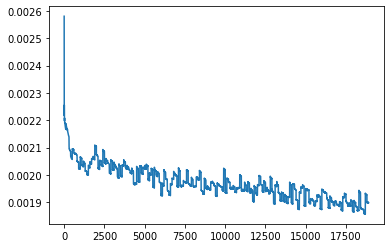

0.0018575272988528013


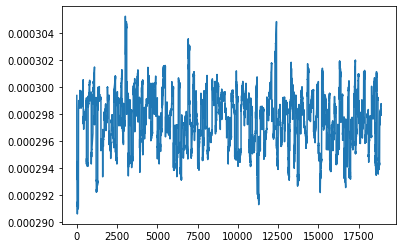

0.0002905963046941906


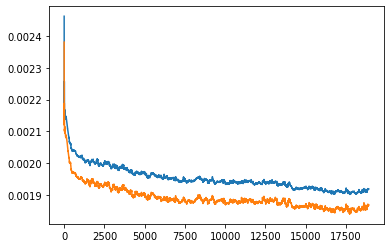

train: 0.0019009013194590807 test: 0.0018394632497802377
0.9337802585501693 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [13]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.plot(test_losses)
plt.show()
print("train:", min(real_losses), "test:", min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

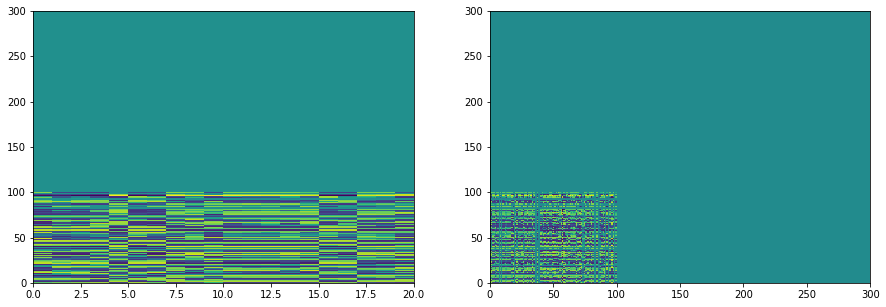

In [14]:
mike2 = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)

diff_I = mike.I.cpu() - mike2.I
diff_I = diff_I.detach().numpy()
diff_J = mike.J.cpu() - mike2.J
diff_J = diff_J.detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].pcolormesh(diff_I)
ax[1].pcolormesh(diff_J)
plt.show()

In [17]:
print(actuals.shape)
print(dout.shape)

import h5py
fout = h5py.File("grasps/sim.hdf5", 'w')
fout_actuals = fout.create_dataset('actuals', shape=)
fout_actuals[:, :] = actuals[0, :, :]
fout_target = fout.create_dataset('target')
fout_target[:, :] = dout[0, 1:, :]
fout.close()

torch.Size([402, 340, 50])
torch.Size([402, 341, 50])


TypeError: One of data, shape or dtype must be specified

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


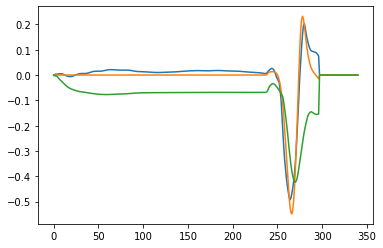

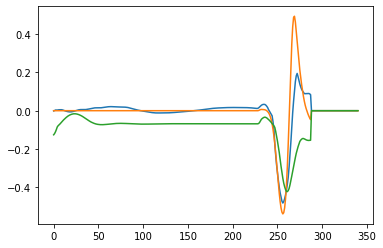

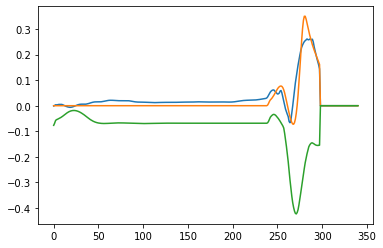

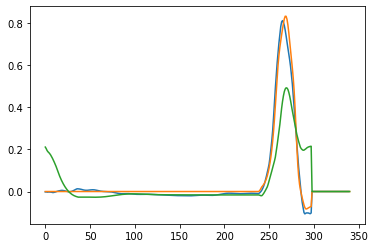

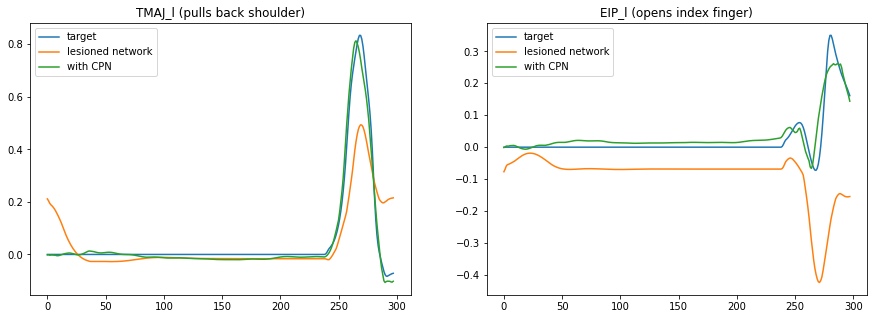

In [89]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T, cuda=CUDA)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T, cuda=CUDA)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T, cuda=CUDA)
mike.reset()

reference_pred_lesioned_0 = utils.trunc_to_trial_end(reference_pred_lesioned_0, trial_end[0, :])
reference_pred_lesioned_neg1 = utils.trunc_to_trial_end(reference_pred_lesioned_neg1, trial_end[-1, :])
reference_pred_lesioned_20 = utils.trunc_to_trial_end(reference_pred_lesioned_20, trial_end[20, :])


print(reference_pred_lesioned_0.shape)


#plt.plot(preds[0, :, 45].cpu().detach().numpy())
#plt.plot(preds.grad[0, :, 45].cpu().detach().numpy())
plt.plot(actuals[0, :, 45].cpu().detach().numpy())
plt.plot(dout[0, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].cpu().detach().numpy())
plt.plot(actuals[-1, :, 45].cpu().detach().numpy())
plt.plot(dout[-1, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_neg1[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].cpu().detach().numpy())
plt.plot(actuals[20, :, 45].cpu().detach().numpy())
plt.plot(dout[20, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].cpu().detach().numpy())
plt.plot(actuals[20, :, 7].cpu().detach().numpy())
plt.plot(dout[20, :, 7].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].cpu().detach().numpy())
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(dout[20, :trial_len[20], 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_lesioned_20[0, :trial_len[20], 7].cpu().detach().numpy(), label="lesioned network")
ax[0].plot(actuals[20, :trial_len[20], 7].cpu().detach().numpy(), label="with CPN")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(dout[20, :trial_len[20], 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_lesioned_20[0, :trial_len[20], 45].cpu().detach().numpy(), label="lesioned network")
ax[1].plot(actuals[20, :trial_len[20], 45].cpu().detach().numpy(), label="with CPN")
ax[1].legend(loc="upper left")

plt.show()

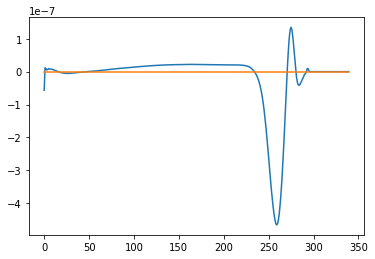

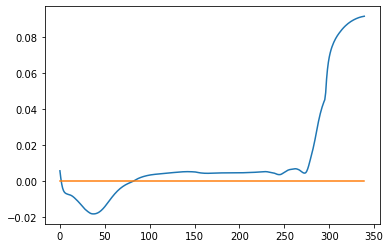

IndexError: index 20 is out of bounds for dimension 1 with size 16

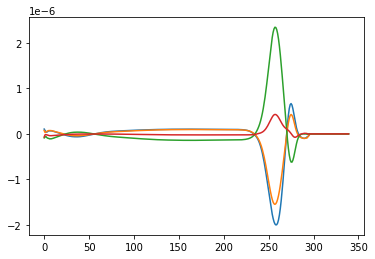

In [16]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

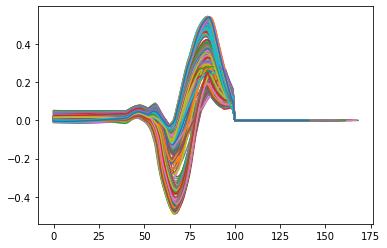

In [63]:
# Are gestures taken between classes?
stout = []
bsize = actuals.shape[0]

for bidx in range(bsize):
    stout.append(actuals[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()

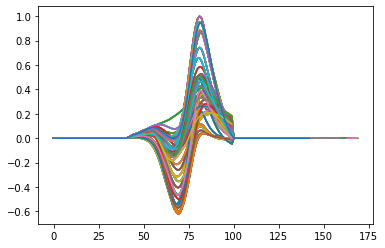

In [64]:
# How does that compare to targets?
stout = []
bsize = dout.shape[0]
for bidx in range(bsize):
    stout.append(dout[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()